In [4]:
%load_ext autoreload
import numpy as np
import seaborn as sns
import os
import ClassificationModelsimplerev1 as ClassificationModelsimple
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def trainmodel(model,train_ds,val_ds):
    
    NUMBER_EPOCHS = 100
    filepath='TrainedWeights/checkptRev1randval'
    BATCH_SIZE=32
    
    model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_auc",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
        options=None
    )
    print(type(train_ds))
    hist = model.fit(train_ds,
                     epochs=NUMBER_EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=val_ds,
                    #  validation_split=0.2,#auto validate using 20% of random samples at each epoch
                     verbose=1, callbacks=[model_checkpoint_callback],class_weight = {0: 1, 1: 5}

                    )
    return hist


In [8]:
#Spatial cross validation

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('Landslide')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def spatialCrossVal():
    for i in range(1,11):
        print(i)
        all_inputs = []
        encoded_features = []
        
        train_df=df[df.id!=i]
        test_df=df[df.id==i]
        print(f"Number of train set{len(train_df)} and number of test set {len(test_df)}")
 
        exai_ds=df_to_dataset(train_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']])
        val_ds=df_to_dataset(test_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']],shuffle=False)
        y_test=test_df['Landslide'].to_numpy()
        

        for header in numerical_cols:
          numeric_col = tf.keras.Input(shape=(1,), name=header)
          normalization_layer = get_normalization_layer(header, exai_ds)
          encoded_numeric_col = normalization_layer(numeric_col)
          all_inputs.append(numeric_col)
          encoded_features.append(encoded_numeric_col)

        for header in categorical_cols:
          categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
          encoding_layer = get_category_encoding_layer(name=header,
                                                      dataset=exai_ds,
                                                      dtype='string',
                                                      max_tokens=9)
          encoded_categorical_col = encoding_layer(categorical_col)
          all_inputs.append(categorical_col)
          encoded_features.append(encoded_categorical_col)

        clfmdl=ClassificationModelsimple.LandslideModel()
        clfmdl.getclassificationModel(all_inputs=all_inputs, encoded_features=encoded_features)
        clfmdl.getOptimizer()
        clfmdl.compileModel()

        trainmodel(clfmdl.model,exai_ds,val_ds)
        preds=clfmdl.model.predict(val_ds)
        np.save(f'crossval_results/SpPredsrv1_{str(i)}.npy',preds)
        np.save(f'crossval_results/SpTruthsrv1_{str(i)}.npy',y_test)
        del clfmdl
        i+=1
def randomCrossVal(dfc):
  kf = KFold(n_splits=10,random_state=42,shuffle=True)
  kf.get_n_splits(df)
  i=0
  for train_index, test_index in kf.split(df):
    print(i)
    all_inputs = []
    encoded_features = []
    
    #    df.iloc[train_index]
    # df.iloc[test_index]
    train_df=dfc.iloc[train_index]
    test_df=dfc.iloc[test_index]
    print(f"Number of train set{len(train_df)} and number of test set {len(test_df)}")

    exai_ds=df_to_dataset(train_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']])
    val_ds=df_to_dataset(test_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']],shuffle=False)
    y_test=test_df['Landslide'].to_numpy()
    

    for header in numerical_cols:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, exai_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)

    for header in categorical_cols:
      categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
      encoding_layer = get_category_encoding_layer(name=header,
                                                  dataset=exai_ds,
                                                  dtype='string',
                                                  max_tokens=9)
      encoded_categorical_col = encoding_layer(categorical_col)
      all_inputs.append(categorical_col)
      encoded_features.append(encoded_categorical_col)

    clfmdl=ClassificationModelsimple.LandslideModel()
    clfmdl.getclassificationModel(all_inputs=all_inputs, encoded_features=encoded_features)
    clfmdl.getOptimizer()
    clfmdl.compileModel()

    trainmodel(clfmdl.model,exai_ds,val_ds)
    preds=clfmdl.model.predict(val_ds)
    np.save(f'crossval_results/RvPredsrv1_{str(i)}.npy',preds)
    np.save(f'crossval_results/RvTruthsrv1_{str(i)}.npy',y_test)
    del clfmdl
    i+=1
    # del clfmdl

In [13]:
categorical_cols = ['GLG']
numerical_cols=['Est_m', 'Nrt_m', 'HC_m', 'VC_m', 'Slp_m', 'Prc_m', 'NDVI_m', 'PGV_Usgs', 'Sand_m', 'Silt_m', 'Clay_m', 'Bdod_m']
df=gpd.read_file('Data/NepalEqUSGSV4.shp')
spatialCrossVal()

1
Number of train set14897 and number of test set 1636


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


459/466 [============================>.] - ETA: 0s - loss: 0.8706 - binary_io_u_1: 0.5379 - auc_1: 0.8344 - binary_accuracy: 0.7526WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 11s 10ms/step - loss: 0.8713 - binary_io_u_1: 0.5366 - auc_1: 0.8339 - binary_accuracy: 0.7514 - val_loss: 0.7955 - val_binary_io_u_1: 0.3616 - val_auc_1: 0.6889 - val_binary_accuracy: 0.5318
Epoch 2/100
463/466 [============================>.] - ETA: 0s - loss: 0.7769 - binary_io_u_1: 0.5598 - auc_1: 0.8693 - binary_accuracy: 0.7702WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7771 - binary_io_u_1: 0.5604 - auc_1: 0.8694 - binary_accuracy: 0.7706 - val_loss: 0.9270 - val_binary_io_u_1: 0.4033 - val_auc_1: 0.6987 - val_binary_accuracy: 0.5752
Epoch 3/100
466/466 [==============================] - ETA: 0s - loss: 0.7516 - binary_io_u_1: 0.5853 - auc_1: 0.8783 - binary_accuracy: 0.7920WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 3s 7ms/step - loss: 0.7516 - binary_io_u_1: 0.5853 - auc_1: 0.8783 - binary_accuracy: 0.7920 - val_loss: 0.9378 - val_binary_io_u_1: 0.3777 - val_auc_1: 0.7505 - val_binary_accuracy: 0.5489
Epoch 4/100
466/466 [==============================] - ETA: 0s - loss: 0.7424 - binary_io_u_1: 0.5819 - auc_1: 0.8813 - binary_accuracy: 0.7880WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7424 - binary_io_u_1: 0.5819 - auc_1: 0.8813 - binary_accuracy: 0.7880 - val_loss: 0.7980 - val_binary_io_u_1: 0.4012 - val_auc_1: 0.7423 - val_binary_accuracy: 0.5727
Epoch 5/100
458/466 [============================>.] - ETA: 0s - loss: 0.7389 - binary_io_u_1: 0.6017 - auc_1: 0.8822 - binary_accuracy: 0.8083WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7410 - binary_io_u_1: 0.6003 - auc_1: 0.8817 - binary_accuracy: 0.8069 - val_loss: 0.9488 - val_binary_io_u_1: 0.3805 - val_auc_1: 0.7121 - val_binary_accuracy: 0.5513
Epoch 6/100
464/466 [============================>.] - ETA: 0s - loss: 0.7287 - binary_io_u_1: 0.5846 - auc_1: 0.8861 - binary_accuracy: 0.7895WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.7281 - binary_io_u_1: 0.5845 - auc_1: 0.8862 - binary_accuracy: 0.7895 - val_loss: 1.1023 - val_binary_io_u_1: 0.4136 - val_auc_1: 0.7260 - val_binary_accuracy: 0.5856
Epoch 7/100
459/466 [============================>.] - ETA: 0s - loss: 0.7365 - binary_io_u_1: 0.5775 - auc_1: 0.8835 - binary_accuracy: 0.7841WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 3s 6ms/step - loss: 0.7355 - binary_io_u_1: 0.5768 - auc_1: 0.8836 - binary_accuracy: 0.7837 - val_loss: 0.8788 - val_binary_io_u_1: 0.4303 - val_auc_1: 0.7506 - val_binary_accuracy: 0.6021
Epoch 8/100
460/466 [============================>.] - ETA: 0s - loss: 0.7273 - binary_io_u_1: 0.5826 - auc_1: 0.8856 - binary_accuracy: 0.7893WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.7282 - binary_io_u_1: 0.5834 - auc_1: 0.8855 - binary_accuracy: 0.7899 - val_loss: 1.0016 - val_binary_io_u_1: 0.3991 - val_auc_1: 0.6935 - val_binary_accuracy: 0.5709
Epoch 9/100
459/466 [============================>.] - ETA: 0s - loss: 0.7228 - binary_io_u_1: 0.5850 - auc_1: 0.8875 - binary_accuracy: 0.7899WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7232 - binary_io_u_1: 0.5856 - auc_1: 0.8876 - binary_accuracy: 0.7902 - val_loss: 1.1422 - val_binary_io_u_1: 0.3888 - val_auc_1: 0.7150 - val_binary_accuracy: 0.5599
Epoch 10/100
465/466 [============================>.] - ETA: 0s - loss: 0.7236 - binary_io_u_1: 0.5868 - auc_1: 0.8874 - binary_accuracy: 0.7927WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7242 - binary_io_u_1: 0.5867 - auc_1: 0.8873 - binary_accuracy: 0.7926 - val_loss: 0.9295 - val_binary_io_u_1: 0.4083 - val_auc_1: 0.7242 - val_binary_accuracy: 0.5801
Epoch 11/100
466/466 [==============================] - ETA: 0s - loss: 0.7243 - binary_io_u_1: 0.6088 - auc_1: 0.8875 - binary_accuracy: 0.8133WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7243 - binary_io_u_1: 0.6088 - auc_1: 0.8875 - binary_accuracy: 0.8133 - val_loss: 0.9803 - val_binary_io_u_1: 0.3995 - val_auc_1: 0.7036 - val_binary_accuracy: 0.5709
Epoch 12/100
464/466 [============================>.] - ETA: 0s - loss: 0.7261 - binary_io_u_1: 0.5822 - auc_1: 0.8872 - binary_accuracy: 0.7876WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.7275 - binary_io_u_1: 0.5819 - auc_1: 0.8868 - binary_accuracy: 0.7873 - val_loss: 0.9134 - val_binary_io_u_1: 0.4097 - val_auc_1: 0.7470 - val_binary_accuracy: 0.5813
Epoch 13/100
465/466 [============================>.] - ETA: 0s - loss: 0.7194 - binary_io_u_1: 0.5871 - auc_1: 0.8886 - binary_accuracy: 0.7934WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7190 - binary_io_u_1: 0.5871 - auc_1: 0.8887 - binary_accuracy: 0.7934 - val_loss: 1.0569 - val_binary_io_u_1: 0.3633 - val_auc_1: 0.7114 - val_binary_accuracy: 0.5336
Epoch 14/100
464/466 [============================>.] - ETA: 0s - loss: 0.7176 - binary_io_u_1: 0.5696 - auc_1: 0.8889 - binary_accuracy: 0.7753WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7168 - binary_io_u_1: 0.5702 - auc_1: 0.8893 - binary_accuracy: 0.7757 - val_loss: 0.9780 - val_binary_io_u_1: 0.4083 - val_auc_1: 0.7113 - val_binary_accuracy: 0.5801
Epoch 15/100
462/466 [============================>.] - ETA: 0s - loss: 0.7096 - binary_io_u_1: 0.5884 - auc_1: 0.8916 - binary_accuracy: 0.7930WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.7089 - binary_io_u_1: 0.5886 - auc_1: 0.8917 - binary_accuracy: 0.7930 - val_loss: 0.9127 - val_binary_io_u_1: 0.4179 - val_auc_1: 0.7432 - val_binary_accuracy: 0.5899
Epoch 16/100
464/466 [============================>.] - ETA: 0s - loss: 0.7114 - binary_io_u_1: 0.5788 - auc_1: 0.8914 - binary_accuracy: 0.7829WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.7117 - binary_io_u_1: 0.5784 - auc_1: 0.8911 - binary_accuracy: 0.7826 - val_loss: 0.8897 - val_binary_io_u_1: 0.4067 - val_auc_1: 0.7522 - val_binary_accuracy: 0.5782
Epoch 17/100
466/466 [==============================] - ETA: 0s - loss: 0.7084 - binary_io_u_1: 0.5629 - auc_1: 0.8914 - binary_accuracy: 0.7668WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.7084 - binary_io_u_1: 0.5629 - auc_1: 0.8914 - binary_accuracy: 0.7668 - val_loss: 0.8622 - val_binary_io_u_1: 0.4186 - val_auc_1: 0.7148 - val_binary_accuracy: 0.5911
Epoch 18/100
465/466 [============================>.] - ETA: 0s - loss: 0.7074 - binary_io_u_1: 0.5837 - auc_1: 0.8923 - binary_accuracy: 0.7880WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7073 - binary_io_u_1: 0.5837 - auc_1: 0.8924 - binary_accuracy: 0.7880 - val_loss: 1.1121 - val_binary_io_u_1: 0.4168 - val_auc_1: 0.7384 - val_binary_accuracy: 0.5886
Epoch 19/100
464/466 [============================>.] - ETA: 0s - loss: 0.7011 - binary_io_u_1: 0.5659 - auc_1: 0.8932 - binary_accuracy: 0.7703WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7003 - binary_io_u_1: 0.5660 - auc_1: 0.8934 - binary_accuracy: 0.7704 - val_loss: 1.1317 - val_binary_io_u_1: 0.4061 - val_auc_1: 0.7308 - val_binary_accuracy: 0.5776
Epoch 20/100
466/466 [==============================] - ETA: 0s - loss: 0.7004 - binary_io_u_1: 0.5910 - auc_1: 0.8944 - binary_accuracy: 0.7935WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7004 - binary_io_u_1: 0.5910 - auc_1: 0.8944 - binary_accuracy: 0.7935 - val_loss: 0.7810 - val_binary_io_u_1: 0.4150 - val_auc_1: 0.7371 - val_binary_accuracy: 0.5868
Epoch 21/100
462/466 [============================>.] - ETA: 0s - loss: 0.6899 - binary_io_u_1: 0.5956 - auc_1: 0.8974 - binary_accuracy: 0.7976WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 5s 8ms/step - loss: 0.6888 - binary_io_u_1: 0.5958 - auc_1: 0.8978 - binary_accuracy: 0.7977 - val_loss: 0.7104 - val_binary_io_u_1: 0.4471 - val_auc_1: 0.7555 - val_binary_accuracy: 0.6192
Epoch 22/100
461/466 [============================>.] - ETA: 0s - loss: 0.7071 - binary_io_u_1: 0.5646 - auc_1: 0.8930 - binary_accuracy: 0.7678WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.7059 - binary_io_u_1: 0.5645 - auc_1: 0.8933 - binary_accuracy: 0.7678 - val_loss: 1.1321 - val_binary_io_u_1: 0.4225 - val_auc_1: 0.7490 - val_binary_accuracy: 0.5941
Epoch 23/100
462/466 [============================>.] - ETA: 0s - loss: 0.6818 - binary_io_u_1: 0.5818 - auc_1: 0.8996 - binary_accuracy: 0.7839WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6833 - binary_io_u_1: 0.5822 - auc_1: 0.8994 - binary_accuracy: 0.7841 - val_loss: 0.7731 - val_binary_io_u_1: 0.4288 - val_auc_1: 0.7496 - val_binary_accuracy: 0.6009
Epoch 24/100
465/466 [============================>.] - ETA: 0s - loss: 0.6843 - binary_io_u_1: 0.6065 - auc_1: 0.8992 - binary_accuracy: 0.8086WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6842 - binary_io_u_1: 0.6063 - auc_1: 0.8992 - binary_accuracy: 0.8085 - val_loss: 0.8355 - val_binary_io_u_1: 0.4360 - val_auc_1: 0.7530 - val_binary_accuracy: 0.6082
Epoch 25/100
465/466 [============================>.] - ETA: 0s - loss: 0.6916 - binary_io_u_1: 0.5937 - auc_1: 0.8969 - binary_accuracy: 0.7956WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6913 - binary_io_u_1: 0.5938 - auc_1: 0.8970 - binary_accuracy: 0.7957 - val_loss: 0.8796 - val_binary_io_u_1: 0.3870 - val_auc_1: 0.7197 - val_binary_accuracy: 0.5581
Epoch 26/100
460/466 [============================>.] - ETA: 0s - loss: 0.6808 - binary_io_u_1: 0.5780 - auc_1: 0.8999 - binary_accuracy: 0.7798WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6806 - binary_io_u_1: 0.5778 - auc_1: 0.8999 - binary_accuracy: 0.7798 - val_loss: 1.1840 - val_binary_io_u_1: 0.3976 - val_auc_1: 0.7367 - val_binary_accuracy: 0.5691
Epoch 27/100
464/466 [============================>.] - ETA: 0s - loss: 0.6700 - binary_io_u_1: 0.6039 - auc_1: 0.9033 - binary_accuracy: 0.8039WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6698 - binary_io_u_1: 0.6042 - auc_1: 0.9035 - binary_accuracy: 0.8041 - val_loss: 0.9066 - val_binary_io_u_1: 0.4116 - val_auc_1: 0.7118 - val_binary_accuracy: 0.5837
Epoch 28/100
465/466 [============================>.] - ETA: 0s - loss: 0.6798 - binary_io_u_1: 0.6010 - auc_1: 0.9003 - binary_accuracy: 0.8023WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6795 - binary_io_u_1: 0.6013 - auc_1: 0.9004 - binary_accuracy: 0.8025 - val_loss: 0.9084 - val_binary_io_u_1: 0.4187 - val_auc_1: 0.7371 - val_binary_accuracy: 0.5905
Epoch 29/100
461/466 [============================>.] - ETA: 0s - loss: 0.6766 - binary_io_u_1: 0.5984 - auc_1: 0.9009 - binary_accuracy: 0.8000WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6780 - binary_io_u_1: 0.5984 - auc_1: 0.9005 - binary_accuracy: 0.7998 - val_loss: 0.7690 - val_binary_io_u_1: 0.4347 - val_auc_1: 0.7096 - val_binary_accuracy: 0.6106
Epoch 30/100
465/466 [============================>.] - ETA: 0s - loss: 0.6806 - binary_io_u_1: 0.5855 - auc_1: 0.9005 - binary_accuracy: 0.7867WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6805 - binary_io_u_1: 0.5854 - auc_1: 0.9005 - binary_accuracy: 0.7867 - val_loss: 1.0384 - val_binary_io_u_1: 0.4469 - val_auc_1: 0.7300 - val_binary_accuracy: 0.6198
Epoch 31/100
465/466 [============================>.] - ETA: 0s - loss: 0.6716 - binary_io_u_1: 0.5904 - auc_1: 0.9022 - binary_accuracy: 0.7907WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6717 - binary_io_u_1: 0.5903 - auc_1: 0.9022 - binary_accuracy: 0.7906 - val_loss: 0.9312 - val_binary_io_u_1: 0.4211 - val_auc_1: 0.7221 - val_binary_accuracy: 0.5929
Epoch 32/100
463/466 [============================>.] - ETA: 0s - loss: 0.6654 - binary_io_u_1: 0.6012 - auc_1: 0.9046 - binary_accuracy: 0.8004WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6653 - binary_io_u_1: 0.6006 - auc_1: 0.9044 - binary_accuracy: 0.8001 - val_loss: 0.9355 - val_binary_io_u_1: 0.4152 - val_auc_1: 0.7160 - val_binary_accuracy: 0.5874
Epoch 33/100
463/466 [============================>.] - ETA: 0s - loss: 0.6626 - binary_io_u_1: 0.6050 - auc_1: 0.9054 - binary_accuracy: 0.8049WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6616 - binary_io_u_1: 0.6046 - auc_1: 0.9055 - binary_accuracy: 0.8047 - val_loss: 0.8870 - val_binary_io_u_1: 0.4401 - val_auc_1: 0.7279 - val_binary_accuracy: 0.6131
Epoch 34/100
464/466 [============================>.] - ETA: 0s - loss: 0.6594 - binary_io_u_1: 0.6143 - auc_1: 0.9062 - binary_accuracy: 0.8131WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6595 - binary_io_u_1: 0.6140 - auc_1: 0.9062 - binary_accuracy: 0.8129 - val_loss: 0.8206 - val_binary_io_u_1: 0.4145 - val_auc_1: 0.7325 - val_binary_accuracy: 0.5862
Epoch 35/100
462/466 [============================>.] - ETA: 0s - loss: 0.6730 - binary_io_u_1: 0.6017 - auc_1: 0.9028 - binary_accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6723 - binary_io_u_1: 0.6015 - auc_1: 0.9029 - binary_accuracy: 0.8020 - val_loss: 0.8470 - val_binary_io_u_1: 0.4404 - val_auc_1: 0.7334 - val_binary_accuracy: 0.6143
Epoch 36/100
460/466 [============================>.] - ETA: 0s - loss: 0.6659 - binary_io_u_1: 0.6013 - auc_1: 0.9049 - binary_accuracy: 0.8009WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6646 - binary_io_u_1: 0.6017 - auc_1: 0.9052 - binary_accuracy: 0.8012 - val_loss: 0.8079 - val_binary_io_u_1: 0.4453 - val_auc_1: 0.7316 - val_binary_accuracy: 0.6186
Epoch 37/100
463/466 [============================>.] - ETA: 0s - loss: 0.6540 - binary_io_u_1: 0.6169 - auc_1: 0.9073 - binary_accuracy: 0.8160WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6554 - binary_io_u_1: 0.6173 - auc_1: 0.9071 - binary_accuracy: 0.8161 - val_loss: 0.8815 - val_binary_io_u_1: 0.4162 - val_auc_1: 0.7054 - val_binary_accuracy: 0.5886
Epoch 38/100
465/466 [============================>.] - ETA: 0s - loss: 0.6504 - binary_io_u_1: 0.6098 - auc_1: 0.9086 - binary_accuracy: 0.8081WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6502 - binary_io_u_1: 0.6099 - auc_1: 0.9087 - binary_accuracy: 0.8081 - val_loss: 0.8336 - val_binary_io_u_1: 0.4374 - val_auc_1: 0.7495 - val_binary_accuracy: 0.6100
Epoch 39/100
465/466 [============================>.] - ETA: 0s - loss: 0.6452 - binary_io_u_1: 0.6189 - auc_1: 0.9103 - binary_accuracy: 0.8153WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6450 - binary_io_u_1: 0.6191 - auc_1: 0.9104 - binary_accuracy: 0.8153 - val_loss: 0.9535 - val_binary_io_u_1: 0.4228 - val_auc_1: 0.7380 - val_binary_accuracy: 0.5947
Epoch 40/100
466/466 [==============================] - ETA: 0s - loss: 0.6471 - binary_io_u_1: 0.6088 - auc_1: 0.9094 - binary_accuracy: 0.8079WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6471 - binary_io_u_1: 0.6088 - auc_1: 0.9094 - binary_accuracy: 0.8079 - val_loss: 0.8336 - val_binary_io_u_1: 0.4327 - val_auc_1: 0.7401 - val_binary_accuracy: 0.6051
Epoch 41/100
466/466 [==============================] - ETA: 0s - loss: 0.6478 - binary_io_u_1: 0.6052 - auc_1: 0.9099 - binary_accuracy: 0.8028WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6478 - binary_io_u_1: 0.6052 - auc_1: 0.9099 - binary_accuracy: 0.8028 - val_loss: 0.8399 - val_binary_io_u_1: 0.4505 - val_auc_1: 0.7257 - val_binary_accuracy: 0.6247
Epoch 42/100
461/466 [============================>.] - ETA: 0s - loss: 0.6478 - binary_io_u_1: 0.6200 - auc_1: 0.9087 - binary_accuracy: 0.8168WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 5s 8ms/step - loss: 0.6483 - binary_io_u_1: 0.6197 - auc_1: 0.9086 - binary_accuracy: 0.8167 - val_loss: 0.8488 - val_binary_io_u_1: 0.4335 - val_auc_1: 0.7331 - val_binary_accuracy: 0.6070
Epoch 43/100
459/466 [============================>.] - ETA: 0s - loss: 0.6427 - binary_io_u_1: 0.6181 - auc_1: 0.9112 - binary_accuracy: 0.8164WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6444 - binary_io_u_1: 0.6165 - auc_1: 0.9107 - binary_accuracy: 0.8152 - val_loss: 0.8110 - val_binary_io_u_1: 0.4346 - val_auc_1: 0.7211 - val_binary_accuracy: 0.6082
Epoch 44/100
460/466 [============================>.] - ETA: 0s - loss: 0.6400 - binary_io_u_1: 0.6120 - auc_1: 0.9115 - binary_accuracy: 0.8096WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6405 - binary_io_u_1: 0.6116 - auc_1: 0.9112 - binary_accuracy: 0.8093 - val_loss: 0.8124 - val_binary_io_u_1: 0.4312 - val_auc_1: 0.7270 - val_binary_accuracy: 0.6045
Epoch 45/100
460/466 [============================>.] - ETA: 0s - loss: 0.6445 - binary_io_u_1: 0.6149 - auc_1: 0.9110 - binary_accuracy: 0.8114WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6430 - binary_io_u_1: 0.6139 - auc_1: 0.9113 - binary_accuracy: 0.8107 - val_loss: 0.8294 - val_binary_io_u_1: 0.4107 - val_auc_1: 0.7245 - val_binary_accuracy: 0.5825
Epoch 46/100
464/466 [============================>.] - ETA: 0s - loss: 0.6385 - binary_io_u_1: 0.6131 - auc_1: 0.9121 - binary_accuracy: 0.8099WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6377 - binary_io_u_1: 0.6130 - auc_1: 0.9123 - binary_accuracy: 0.8100 - val_loss: 0.9882 - val_binary_io_u_1: 0.4415 - val_auc_1: 0.7366 - val_binary_accuracy: 0.6155
Epoch 47/100
459/466 [============================>.] - ETA: 0s - loss: 0.6338 - binary_io_u_1: 0.6275 - auc_1: 0.9135 - binary_accuracy: 0.8222WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6319 - binary_io_u_1: 0.6278 - auc_1: 0.9140 - binary_accuracy: 0.8225 - val_loss: 0.9092 - val_binary_io_u_1: 0.4622 - val_auc_1: 0.7342 - val_binary_accuracy: 0.6369
Epoch 48/100
460/466 [============================>.] - ETA: 0s - loss: 0.6222 - binary_io_u_1: 0.6174 - auc_1: 0.9161 - binary_accuracy: 0.8129WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6252 - binary_io_u_1: 0.6167 - auc_1: 0.9154 - binary_accuracy: 0.8124 - val_loss: 0.7732 - val_binary_io_u_1: 0.4489 - val_auc_1: 0.7139 - val_binary_accuracy: 0.6229
Epoch 49/100
461/466 [============================>.] - ETA: 0s - loss: 0.6278 - binary_io_u_1: 0.6095 - auc_1: 0.9150 - binary_accuracy: 0.8059WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6286 - binary_io_u_1: 0.6086 - auc_1: 0.9145 - binary_accuracy: 0.8055 - val_loss: 0.8641 - val_binary_io_u_1: 0.4650 - val_auc_1: 0.7285 - val_binary_accuracy: 0.6412
Epoch 50/100
464/466 [============================>.] - ETA: 0s - loss: 0.6344 - binary_io_u_1: 0.6114 - auc_1: 0.9132 - binary_accuracy: 0.8081WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6338 - binary_io_u_1: 0.6112 - auc_1: 0.9133 - binary_accuracy: 0.8079 - val_loss: 0.8741 - val_binary_io_u_1: 0.4506 - val_auc_1: 0.7413 - val_binary_accuracy: 0.6235
Epoch 51/100
458/466 [============================>.] - ETA: 0s - loss: 0.6391 - binary_io_u_1: 0.6078 - auc_1: 0.9120 - binary_accuracy: 0.8056WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6393 - binary_io_u_1: 0.6083 - auc_1: 0.9120 - binary_accuracy: 0.8061 - val_loss: 0.8298 - val_binary_io_u_1: 0.4441 - val_auc_1: 0.7164 - val_binary_accuracy: 0.6192
Epoch 52/100
458/466 [============================>.] - ETA: 0s - loss: 0.6294 - binary_io_u_1: 0.6261 - auc_1: 0.9145 - binary_accuracy: 0.8210WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6301 - binary_io_u_1: 0.6249 - auc_1: 0.9141 - binary_accuracy: 0.8201 - val_loss: 0.8521 - val_binary_io_u_1: 0.4407 - val_auc_1: 0.7419 - val_binary_accuracy: 0.6137
Epoch 53/100
459/466 [============================>.] - ETA: 0s - loss: 0.6275 - binary_io_u_1: 0.6143 - auc_1: 0.9151 - binary_accuracy: 0.8095WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6274 - binary_io_u_1: 0.6145 - auc_1: 0.9150 - binary_accuracy: 0.8098 - val_loss: 0.9568 - val_binary_io_u_1: 0.4495 - val_auc_1: 0.7457 - val_binary_accuracy: 0.6229
Epoch 54/100
464/466 [============================>.] - ETA: 0s - loss: 0.6139 - binary_io_u_1: 0.6113 - auc_1: 0.9181 - binary_accuracy: 0.8071WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.6142 - binary_io_u_1: 0.6116 - auc_1: 0.9180 - binary_accuracy: 0.8073 - val_loss: 0.8886 - val_binary_io_u_1: 0.4471 - val_auc_1: 0.7383 - val_binary_accuracy: 0.6204
Epoch 55/100
462/466 [============================>.] - ETA: 0s - loss: 0.6186 - binary_io_u_1: 0.6120 - auc_1: 0.9173 - binary_accuracy: 0.8080WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6191 - binary_io_u_1: 0.6117 - auc_1: 0.9172 - binary_accuracy: 0.8077 - val_loss: 0.6977 - val_binary_io_u_1: 0.4462 - val_auc_1: 0.7232 - val_binary_accuracy: 0.6204
Epoch 56/100
465/466 [============================>.] - ETA: 0s - loss: 0.6213 - binary_io_u_1: 0.6102 - auc_1: 0.9165 - binary_accuracy: 0.8067WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 9ms/step - loss: 0.6221 - binary_io_u_1: 0.6100 - auc_1: 0.9163 - binary_accuracy: 0.8065 - val_loss: 0.7391 - val_binary_io_u_1: 0.4503 - val_auc_1: 0.7336 - val_binary_accuracy: 0.6253
Epoch 57/100
465/466 [============================>.] - ETA: 0s - loss: 0.6215 - binary_io_u_1: 0.6162 - auc_1: 0.9159 - binary_accuracy: 0.8127WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6215 - binary_io_u_1: 0.6162 - auc_1: 0.9159 - binary_accuracy: 0.8126 - val_loss: 0.7585 - val_binary_io_u_1: 0.4596 - val_auc_1: 0.7314 - val_binary_accuracy: 0.6345
Epoch 58/100
465/466 [============================>.] - ETA: 0s - loss: 0.6164 - binary_io_u_1: 0.6290 - auc_1: 0.9179 - binary_accuracy: 0.8231WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6167 - binary_io_u_1: 0.6289 - auc_1: 0.9178 - binary_accuracy: 0.8231 - val_loss: 0.8588 - val_binary_io_u_1: 0.4583 - val_auc_1: 0.7300 - val_binary_accuracy: 0.6345
Epoch 59/100
465/466 [============================>.] - ETA: 0s - loss: 0.6177 - binary_io_u_1: 0.6191 - auc_1: 0.9172 - binary_accuracy: 0.8136WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 5s 9ms/step - loss: 0.6174 - binary_io_u_1: 0.6190 - auc_1: 0.9172 - binary_accuracy: 0.8136 - val_loss: 0.7615 - val_binary_io_u_1: 0.4434 - val_auc_1: 0.7280 - val_binary_accuracy: 0.6180
Epoch 60/100
465/466 [============================>.] - ETA: 0s - loss: 0.6141 - binary_io_u_1: 0.6230 - auc_1: 0.9187 - binary_accuracy: 0.8173WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6139 - binary_io_u_1: 0.6230 - auc_1: 0.9188 - binary_accuracy: 0.8173 - val_loss: 0.7434 - val_binary_io_u_1: 0.4504 - val_auc_1: 0.7414 - val_binary_accuracy: 0.6235
Epoch 61/100
461/466 [============================>.] - ETA: 0s - loss: 0.6125 - binary_io_u_1: 0.6188 - auc_1: 0.9189 - binary_accuracy: 0.8134WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6139 - binary_io_u_1: 0.6184 - auc_1: 0.9185 - binary_accuracy: 0.8131 - val_loss: 0.8120 - val_binary_io_u_1: 0.4624 - val_auc_1: 0.7352 - val_binary_accuracy: 0.6375
Epoch 62/100
458/466 [============================>.] - ETA: 0s - loss: 0.6048 - binary_io_u_1: 0.6306 - auc_1: 0.9212 - binary_accuracy: 0.8236WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6051 - binary_io_u_1: 0.6300 - auc_1: 0.9209 - binary_accuracy: 0.8233 - val_loss: 0.7631 - val_binary_io_u_1: 0.4673 - val_auc_1: 0.7313 - val_binary_accuracy: 0.6443
Epoch 63/100
462/466 [============================>.] - ETA: 0s - loss: 0.6031 - binary_io_u_1: 0.6329 - auc_1: 0.9207 - binary_accuracy: 0.8260WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6039 - binary_io_u_1: 0.6331 - auc_1: 0.9207 - binary_accuracy: 0.8259 - val_loss: 0.7054 - val_binary_io_u_1: 0.4567 - val_auc_1: 0.7159 - val_binary_accuracy: 0.6363
Epoch 64/100
465/466 [============================>.] - ETA: 0s - loss: 0.6151 - binary_io_u_1: 0.6261 - auc_1: 0.9186 - binary_accuracy: 0.8197WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6148 - binary_io_u_1: 0.6261 - auc_1: 0.9186 - binary_accuracy: 0.8197 - val_loss: 0.8852 - val_binary_io_u_1: 0.4525 - val_auc_1: 0.7269 - val_binary_accuracy: 0.6271
Epoch 65/100
460/466 [============================>.] - ETA: 0s - loss: 0.5930 - binary_io_u_1: 0.6263 - auc_1: 0.9231 - binary_accuracy: 0.8181WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5972 - binary_io_u_1: 0.6249 - auc_1: 0.9221 - binary_accuracy: 0.8175 - val_loss: 0.8406 - val_binary_io_u_1: 0.4536 - val_auc_1: 0.7213 - val_binary_accuracy: 0.6278
Epoch 66/100
466/466 [==============================] - ETA: 0s - loss: 0.5952 - binary_io_u_1: 0.6192 - auc_1: 0.9238 - binary_accuracy: 0.8122WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5952 - binary_io_u_1: 0.6192 - auc_1: 0.9238 - binary_accuracy: 0.8122 - val_loss: 0.8911 - val_binary_io_u_1: 0.4608 - val_auc_1: 0.7429 - val_binary_accuracy: 0.6345
Epoch 67/100
461/466 [============================>.] - ETA: 0s - loss: 0.6005 - binary_io_u_1: 0.6190 - auc_1: 0.9210 - binary_accuracy: 0.8131WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.6008 - binary_io_u_1: 0.6198 - auc_1: 0.9212 - binary_accuracy: 0.8134 - val_loss: 0.7921 - val_binary_io_u_1: 0.4607 - val_auc_1: 0.7429 - val_binary_accuracy: 0.6351
Epoch 68/100
462/466 [============================>.] - ETA: 0s - loss: 0.5958 - binary_io_u_1: 0.6282 - auc_1: 0.9231 - binary_accuracy: 0.8210WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5961 - binary_io_u_1: 0.6279 - auc_1: 0.9231 - binary_accuracy: 0.8208 - val_loss: 0.6669 - val_binary_io_u_1: 0.4848 - val_auc_1: 0.7381 - val_binary_accuracy: 0.6626
Epoch 69/100
465/466 [============================>.] - ETA: 0s - loss: 0.5978 - binary_io_u_1: 0.6290 - auc_1: 0.9222 - binary_accuracy: 0.8215WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5979 - binary_io_u_1: 0.6291 - auc_1: 0.9223 - binary_accuracy: 0.8215 - val_loss: 0.7259 - val_binary_io_u_1: 0.4776 - val_auc_1: 0.7355 - val_binary_accuracy: 0.6553
Epoch 70/100
466/466 [==============================] - ETA: 0s - loss: 0.5975 - binary_io_u_1: 0.6304 - auc_1: 0.9229 - binary_accuracy: 0.8220WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5975 - binary_io_u_1: 0.6304 - auc_1: 0.9229 - binary_accuracy: 0.8220 - val_loss: 0.7648 - val_binary_io_u_1: 0.4669 - val_auc_1: 0.7355 - val_binary_accuracy: 0.6443
Epoch 71/100
466/466 [==============================] - ETA: 0s - loss: 0.5900 - binary_io_u_1: 0.6343 - auc_1: 0.9234 - binary_accuracy: 0.8255WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5900 - binary_io_u_1: 0.6343 - auc_1: 0.9234 - binary_accuracy: 0.8255 - val_loss: 0.7210 - val_binary_io_u_1: 0.4823 - val_auc_1: 0.7228 - val_binary_accuracy: 0.6608
Epoch 72/100
461/466 [============================>.] - ETA: 0s - loss: 0.5934 - binary_io_u_1: 0.6339 - auc_1: 0.9241 - binary_accuracy: 0.8251WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5942 - binary_io_u_1: 0.6331 - auc_1: 0.9237 - binary_accuracy: 0.8248 - val_loss: 0.9100 - val_binary_io_u_1: 0.4503 - val_auc_1: 0.7278 - val_binary_accuracy: 0.6259
Epoch 73/100
464/466 [============================>.] - ETA: 0s - loss: 0.5843 - binary_io_u_1: 0.6364 - auc_1: 0.9258 - binary_accuracy: 0.8266WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5842 - binary_io_u_1: 0.6365 - auc_1: 0.9258 - binary_accuracy: 0.8267 - val_loss: 0.7608 - val_binary_io_u_1: 0.4638 - val_auc_1: 0.7352 - val_binary_accuracy: 0.6394
Epoch 74/100
463/466 [============================>.] - ETA: 0s - loss: 0.5874 - binary_io_u_1: 0.6238 - auc_1: 0.9250 - binary_accuracy: 0.8165WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5874 - binary_io_u_1: 0.6236 - auc_1: 0.9249 - binary_accuracy: 0.8164 - val_loss: 0.9327 - val_binary_io_u_1: 0.4669 - val_auc_1: 0.7362 - val_binary_accuracy: 0.6412
Epoch 75/100
459/466 [============================>.] - ETA: 0s - loss: 0.5869 - binary_io_u_1: 0.6325 - auc_1: 0.9249 - binary_accuracy: 0.8231WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5875 - binary_io_u_1: 0.6321 - auc_1: 0.9246 - binary_accuracy: 0.8231 - val_loss: 0.8410 - val_binary_io_u_1: 0.4719 - val_auc_1: 0.7362 - val_binary_accuracy: 0.6491
Epoch 76/100
461/466 [============================>.] - ETA: 0s - loss: 0.5817 - binary_io_u_1: 0.6229 - auc_1: 0.9252 - binary_accuracy: 0.8147WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5827 - binary_io_u_1: 0.6220 - auc_1: 0.9250 - binary_accuracy: 0.8140 - val_loss: 0.7097 - val_binary_io_u_1: 0.4649 - val_auc_1: 0.7044 - val_binary_accuracy: 0.6473
Epoch 77/100
465/466 [============================>.] - ETA: 0s - loss: 0.5828 - binary_io_u_1: 0.6233 - auc_1: 0.9255 - binary_accuracy: 0.8146WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5825 - binary_io_u_1: 0.6233 - auc_1: 0.9256 - binary_accuracy: 0.8146 - val_loss: 0.7831 - val_binary_io_u_1: 0.4403 - val_auc_1: 0.7148 - val_binary_accuracy: 0.6149
Epoch 78/100
461/466 [============================>.] - ETA: 0s - loss: 0.5781 - binary_io_u_1: 0.6310 - auc_1: 0.9275 - binary_accuracy: 0.8210WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5794 - binary_io_u_1: 0.6306 - auc_1: 0.9271 - binary_accuracy: 0.8208 - val_loss: 0.7692 - val_binary_io_u_1: 0.4507 - val_auc_1: 0.7168 - val_binary_accuracy: 0.6290
Epoch 79/100
464/466 [============================>.] - ETA: 0s - loss: 0.5812 - binary_io_u_1: 0.6312 - auc_1: 0.9259 - binary_accuracy: 0.8215WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5814 - binary_io_u_1: 0.6312 - auc_1: 0.9258 - binary_accuracy: 0.8216 - val_loss: 0.7984 - val_binary_io_u_1: 0.4677 - val_auc_1: 0.7423 - val_binary_accuracy: 0.6430
Epoch 80/100
462/466 [============================>.] - ETA: 0s - loss: 0.5984 - binary_io_u_1: 0.6324 - auc_1: 0.9226 - binary_accuracy: 0.8235WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5979 - binary_io_u_1: 0.6326 - auc_1: 0.9227 - binary_accuracy: 0.8236 - val_loss: 0.8083 - val_binary_io_u_1: 0.4483 - val_auc_1: 0.7241 - val_binary_accuracy: 0.6241
Epoch 81/100
458/466 [============================>.] - ETA: 0s - loss: 0.5970 - binary_io_u_1: 0.6321 - auc_1: 0.9236 - binary_accuracy: 0.8235WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5948 - binary_io_u_1: 0.6320 - auc_1: 0.9239 - binary_accuracy: 0.8237 - val_loss: 0.8067 - val_binary_io_u_1: 0.4590 - val_auc_1: 0.7202 - val_binary_accuracy: 0.6388
Epoch 82/100
461/466 [============================>.] - ETA: 0s - loss: 0.5787 - binary_io_u_1: 0.6437 - auc_1: 0.9270 - binary_accuracy: 0.8316WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5786 - binary_io_u_1: 0.6438 - auc_1: 0.9271 - binary_accuracy: 0.8316 - val_loss: 0.8582 - val_binary_io_u_1: 0.4536 - val_auc_1: 0.7098 - val_binary_accuracy: 0.6345
Epoch 83/100
463/466 [============================>.] - ETA: 0s - loss: 0.5736 - binary_io_u_1: 0.6309 - auc_1: 0.9279 - binary_accuracy: 0.8217WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5729 - binary_io_u_1: 0.6309 - auc_1: 0.9280 - binary_accuracy: 0.8218 - val_loss: 0.8246 - val_binary_io_u_1: 0.4633 - val_auc_1: 0.7478 - val_binary_accuracy: 0.6394
Epoch 84/100
466/466 [==============================] - ETA: 0s - loss: 0.5750 - binary_io_u_1: 0.6393 - auc_1: 0.9275 - binary_accuracy: 0.8280WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 5s 8ms/step - loss: 0.5750 - binary_io_u_1: 0.6393 - auc_1: 0.9275 - binary_accuracy: 0.8280 - val_loss: 0.7756 - val_binary_io_u_1: 0.4759 - val_auc_1: 0.7233 - val_binary_accuracy: 0.6589
Epoch 85/100
457/466 [============================>.] - ETA: 0s - loss: 0.5706 - binary_io_u_1: 0.6404 - auc_1: 0.9284 - binary_accuracy: 0.8293WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5714 - binary_io_u_1: 0.6393 - auc_1: 0.9283 - binary_accuracy: 0.8284 - val_loss: 0.7589 - val_binary_io_u_1: 0.4630 - val_auc_1: 0.7188 - val_binary_accuracy: 0.6443
Epoch 86/100
462/466 [============================>.] - ETA: 0s - loss: 0.5642 - binary_io_u_1: 0.6404 - auc_1: 0.9303 - binary_accuracy: 0.8282WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5642 - binary_io_u_1: 0.6406 - auc_1: 0.9302 - binary_accuracy: 0.8284 - val_loss: 0.8317 - val_binary_io_u_1: 0.4652 - val_auc_1: 0.7289 - val_binary_accuracy: 0.6449
Epoch 87/100
463/466 [============================>.] - ETA: 0s - loss: 0.5589 - binary_io_u_1: 0.6376 - auc_1: 0.9306 - binary_accuracy: 0.8255WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5601 - binary_io_u_1: 0.6369 - auc_1: 0.9304 - binary_accuracy: 0.8251 - val_loss: 0.8626 - val_binary_io_u_1: 0.4532 - val_auc_1: 0.7206 - val_binary_accuracy: 0.6308
Epoch 88/100
460/466 [============================>.] - ETA: 0s - loss: 0.5760 - binary_io_u_1: 0.6320 - auc_1: 0.9272 - binary_accuracy: 0.8224WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5751 - binary_io_u_1: 0.6320 - auc_1: 0.9273 - binary_accuracy: 0.8224 - val_loss: 0.7875 - val_binary_io_u_1: 0.4669 - val_auc_1: 0.7338 - val_binary_accuracy: 0.6424
Epoch 89/100
462/466 [============================>.] - ETA: 0s - loss: 0.5642 - binary_io_u_1: 0.6417 - auc_1: 0.9302 - binary_accuracy: 0.8291WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5640 - binary_io_u_1: 0.6417 - auc_1: 0.9301 - binary_accuracy: 0.8293 - val_loss: 0.8468 - val_binary_io_u_1: 0.4707 - val_auc_1: 0.7187 - val_binary_accuracy: 0.6559
Epoch 90/100
464/466 [============================>.] - ETA: 0s - loss: 0.5633 - binary_io_u_1: 0.6462 - auc_1: 0.9312 - binary_accuracy: 0.8336WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5637 - binary_io_u_1: 0.6461 - auc_1: 0.9311 - binary_accuracy: 0.8334 - val_loss: 0.7951 - val_binary_io_u_1: 0.4734 - val_auc_1: 0.7237 - val_binary_accuracy: 0.6565
Epoch 91/100
464/466 [============================>.] - ETA: 0s - loss: 0.5608 - binary_io_u_1: 0.6431 - auc_1: 0.9310 - binary_accuracy: 0.8316WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5601 - binary_io_u_1: 0.6433 - auc_1: 0.9312 - binary_accuracy: 0.8318 - val_loss: 0.8093 - val_binary_io_u_1: 0.4627 - val_auc_1: 0.7261 - val_binary_accuracy: 0.6424
Epoch 92/100
462/466 [============================>.] - ETA: 0s - loss: 0.5588 - binary_io_u_1: 0.6400 - auc_1: 0.9317 - binary_accuracy: 0.8283WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5581 - binary_io_u_1: 0.6400 - auc_1: 0.9318 - binary_accuracy: 0.8285 - val_loss: 0.9852 - val_binary_io_u_1: 0.4639 - val_auc_1: 0.7235 - val_binary_accuracy: 0.6424
Epoch 93/100
462/466 [============================>.] - ETA: 0s - loss: 0.5702 - binary_io_u_1: 0.6306 - auc_1: 0.9286 - binary_accuracy: 0.8216WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5694 - binary_io_u_1: 0.6304 - auc_1: 0.9288 - binary_accuracy: 0.8216 - val_loss: 0.7289 - val_binary_io_u_1: 0.4820 - val_auc_1: 0.7329 - val_binary_accuracy: 0.6608
Epoch 94/100
465/466 [============================>.] - ETA: 0s - loss: 0.5697 - binary_io_u_1: 0.6321 - auc_1: 0.9288 - binary_accuracy: 0.8228WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5697 - binary_io_u_1: 0.6322 - auc_1: 0.9289 - binary_accuracy: 0.8229 - val_loss: 0.9058 - val_binary_io_u_1: 0.4499 - val_auc_1: 0.7222 - val_binary_accuracy: 0.6253
Epoch 95/100
462/466 [============================>.] - ETA: 0s - loss: 0.5568 - binary_io_u_1: 0.6401 - auc_1: 0.9316 - binary_accuracy: 0.8293WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5574 - binary_io_u_1: 0.6401 - auc_1: 0.9316 - binary_accuracy: 0.8290 - val_loss: 0.7461 - val_binary_io_u_1: 0.4786 - val_auc_1: 0.7342 - val_binary_accuracy: 0.6553
Epoch 96/100
466/466 [==============================] - ETA: 0s - loss: 0.5545 - binary_io_u_1: 0.6448 - auc_1: 0.9327 - binary_accuracy: 0.8320WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5545 - binary_io_u_1: 0.6448 - auc_1: 0.9327 - binary_accuracy: 0.8320 - val_loss: 0.8199 - val_binary_io_u_1: 0.4806 - val_auc_1: 0.7359 - val_binary_accuracy: 0.6595
Epoch 97/100
459/466 [============================>.] - ETA: 0s - loss: 0.5587 - binary_io_u_1: 0.6439 - auc_1: 0.9317 - binary_accuracy: 0.8308WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 7ms/step - loss: 0.5593 - binary_io_u_1: 0.6439 - auc_1: 0.9316 - binary_accuracy: 0.8309 - val_loss: 0.7767 - val_binary_io_u_1: 0.4656 - val_auc_1: 0.7256 - val_binary_accuracy: 0.6443
Epoch 98/100
462/466 [============================>.] - ETA: 0s - loss: 0.5428 - binary_io_u_1: 0.6426 - auc_1: 0.9345 - binary_accuracy: 0.8294WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5455 - binary_io_u_1: 0.6421 - auc_1: 0.9338 - binary_accuracy: 0.8291 - val_loss: 0.8794 - val_binary_io_u_1: 0.4581 - val_auc_1: 0.7226 - val_binary_accuracy: 0.6345
Epoch 99/100
464/466 [============================>.] - ETA: 0s - loss: 0.5608 - binary_io_u_1: 0.6411 - auc_1: 0.9313 - binary_accuracy: 0.8297WARNING:tensorflow:Can save best model only with val_auc available, skipping.


466/466 [==============================] - 4s 8ms/step - loss: 0.5601 - binary_io_u_1: 0.6413 - auc_1: 0.9315 - binary_accuracy: 0.8298 - val_loss: 0.8317 - val_binary_io_u_1: 0.4620 - val_auc_1: 0.7350 - val_binary_accuracy: 0.6394
Epoch 100/100
465/466 [============================>.] - ETA: 0s - loss: 0.5483 - binary_io_u_1: 0.6429 - auc_1: 0.9332 - binary_accuracy: 0.8296WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 3ms/step
2
Number of train set14624 and number of test set 1909


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


455/457 [============================>.] - ETA: 0s - loss: 0.9565 - binary_io_u_2: 0.5123 - auc_2: 0.8180 - binary_accuracy: 0.7113WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 10s 10ms/step - loss: 0.9560 - binary_io_u_2: 0.5123 - auc_2: 0.8181 - binary_accuracy: 0.7114 - val_loss: 0.4281 - val_binary_io_u_2: 0.4786 - val_auc_2: 0.7432 - val_binary_accuracy: 0.8811
Epoch 2/100
457/457 [==============================] - ETA: 0s - loss: 0.8392 - binary_io_u_2: 0.5524 - auc_2: 0.8622 - binary_accuracy: 0.7458WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.8392 - binary_io_u_2: 0.5524 - auc_2: 0.8622 - binary_accuracy: 0.7458 - val_loss: 0.3516 - val_binary_io_u_2: 0.4880 - val_auc_2: 0.7779 - val_binary_accuracy: 0.8701
Epoch 3/100
452/457 [============================>.] - ETA: 0s - loss: 0.8269 - binary_io_u_2: 0.5566 - auc_2: 0.8658 - binary_accuracy: 0.7492WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.8263 - binary_io_u_2: 0.5566 - auc_2: 0.8660 - binary_accuracy: 0.7491 - val_loss: 0.3991 - val_binary_io_u_2: 0.4744 - val_auc_2: 0.7686 - val_binary_accuracy: 0.8240
Epoch 4/100
452/457 [============================>.] - ETA: 0s - loss: 0.8045 - binary_io_u_2: 0.5435 - auc_2: 0.8734 - binary_accuracy: 0.7362WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 9ms/step - loss: 0.8050 - binary_io_u_2: 0.5440 - auc_2: 0.8732 - binary_accuracy: 0.7366 - val_loss: 0.3589 - val_binary_io_u_2: 0.4721 - val_auc_2: 0.7757 - val_binary_accuracy: 0.8460
Epoch 5/100
454/457 [============================>.] - ETA: 0s - loss: 0.8005 - binary_io_u_2: 0.5615 - auc_2: 0.8742 - binary_accuracy: 0.7528WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7995 - binary_io_u_2: 0.5613 - auc_2: 0.8745 - binary_accuracy: 0.7526 - val_loss: 0.3910 - val_binary_io_u_2: 0.4850 - val_auc_2: 0.7349 - val_binary_accuracy: 0.8460
Epoch 6/100
453/457 [============================>.] - ETA: 0s - loss: 0.7952 - binary_io_u_2: 0.5654 - auc_2: 0.8759 - binary_accuracy: 0.7559WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7952 - binary_io_u_2: 0.5649 - auc_2: 0.8757 - binary_accuracy: 0.7555 - val_loss: 0.2691 - val_binary_io_u_2: 0.4983 - val_auc_2: 0.7189 - val_binary_accuracy: 0.9193
Epoch 7/100
452/457 [============================>.] - ETA: 0s - loss: 0.7973 - binary_io_u_2: 0.5676 - auc_2: 0.8761 - binary_accuracy: 0.7580WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7973 - binary_io_u_2: 0.5672 - auc_2: 0.8759 - binary_accuracy: 0.7579 - val_loss: 0.4354 - val_binary_io_u_2: 0.4376 - val_auc_2: 0.7297 - val_binary_accuracy: 0.7826
Epoch 8/100
453/457 [============================>.] - ETA: 0s - loss: 0.7943 - binary_io_u_2: 0.5807 - auc_2: 0.8766 - binary_accuracy: 0.7713WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7959 - binary_io_u_2: 0.5797 - auc_2: 0.8760 - binary_accuracy: 0.7704 - val_loss: 0.3841 - val_binary_io_u_2: 0.4626 - val_auc_2: 0.7681 - val_binary_accuracy: 0.7952
Epoch 9/100
453/457 [============================>.] - ETA: 0s - loss: 0.7928 - binary_io_u_2: 0.5734 - auc_2: 0.8778 - binary_accuracy: 0.7641WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7939 - binary_io_u_2: 0.5735 - auc_2: 0.8775 - binary_accuracy: 0.7642 - val_loss: 0.3845 - val_binary_io_u_2: 0.4770 - val_auc_2: 0.7608 - val_binary_accuracy: 0.8554
Epoch 10/100
456/457 [============================>.] - ETA: 0s - loss: 0.7784 - binary_io_u_2: 0.5583 - auc_2: 0.8818 - binary_accuracy: 0.7494WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7781 - binary_io_u_2: 0.5585 - auc_2: 0.8819 - binary_accuracy: 0.7495 - val_loss: 0.2872 - val_binary_io_u_2: 0.4785 - val_auc_2: 0.7731 - val_binary_accuracy: 0.8539
Epoch 11/100
449/457 [============================>.] - ETA: 0s - loss: 0.7835 - binary_io_u_2: 0.5618 - auc_2: 0.8803 - binary_accuracy: 0.7517WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7815 - binary_io_u_2: 0.5622 - auc_2: 0.8809 - binary_accuracy: 0.7521 - val_loss: 0.3695 - val_binary_io_u_2: 0.4502 - val_auc_2: 0.7530 - val_binary_accuracy: 0.8025
Epoch 12/100
450/457 [============================>.] - ETA: 0s - loss: 0.7861 - binary_io_u_2: 0.5713 - auc_2: 0.8797 - binary_accuracy: 0.7615WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7864 - binary_io_u_2: 0.5709 - auc_2: 0.8795 - binary_accuracy: 0.7612 - val_loss: 0.4739 - val_binary_io_u_2: 0.4103 - val_auc_2: 0.7117 - val_binary_accuracy: 0.7428
Epoch 13/100
450/457 [============================>.] - ETA: 0s - loss: 0.7805 - binary_io_u_2: 0.5740 - auc_2: 0.8812 - binary_accuracy: 0.7633WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7802 - binary_io_u_2: 0.5747 - auc_2: 0.8813 - binary_accuracy: 0.7640 - val_loss: 0.3500 - val_binary_io_u_2: 0.4943 - val_auc_2: 0.7363 - val_binary_accuracy: 0.8827
Epoch 14/100
452/457 [============================>.] - ETA: 0s - loss: 0.7861 - binary_io_u_2: 0.5517 - auc_2: 0.8791 - binary_accuracy: 0.7417WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7867 - binary_io_u_2: 0.5508 - auc_2: 0.8788 - binary_accuracy: 0.7410 - val_loss: 0.3329 - val_binary_io_u_2: 0.4817 - val_auc_2: 0.7709 - val_binary_accuracy: 0.8544
Epoch 15/100
450/457 [============================>.] - ETA: 0s - loss: 0.7736 - binary_io_u_2: 0.5686 - auc_2: 0.8834 - binary_accuracy: 0.7569WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7731 - binary_io_u_2: 0.5684 - auc_2: 0.8836 - binary_accuracy: 0.7568 - val_loss: 0.3590 - val_binary_io_u_2: 0.4831 - val_auc_2: 0.7501 - val_binary_accuracy: 0.8544
Epoch 16/100
454/457 [============================>.] - ETA: 0s - loss: 0.7690 - binary_io_u_2: 0.5616 - auc_2: 0.8854 - binary_accuracy: 0.7504WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7702 - binary_io_u_2: 0.5618 - auc_2: 0.8849 - binary_accuracy: 0.7505 - val_loss: 0.4776 - val_binary_io_u_2: 0.4596 - val_auc_2: 0.7550 - val_binary_accuracy: 0.8177
Epoch 17/100
457/457 [==============================] - ETA: 0s - loss: 0.7691 - binary_io_u_2: 0.5657 - auc_2: 0.8846 - binary_accuracy: 0.7544WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7691 - binary_io_u_2: 0.5657 - auc_2: 0.8846 - binary_accuracy: 0.7544 - val_loss: 0.3379 - val_binary_io_u_2: 0.4713 - val_auc_2: 0.7454 - val_binary_accuracy: 0.8355
Epoch 18/100
452/457 [============================>.] - ETA: 0s - loss: 0.7557 - binary_io_u_2: 0.5769 - auc_2: 0.8890 - binary_accuracy: 0.7645WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7564 - binary_io_u_2: 0.5762 - auc_2: 0.8886 - binary_accuracy: 0.7640 - val_loss: 0.3415 - val_binary_io_u_2: 0.4809 - val_auc_2: 0.7657 - val_binary_accuracy: 0.8229
Epoch 19/100
449/457 [============================>.] - ETA: 0s - loss: 0.7661 - binary_io_u_2: 0.5645 - auc_2: 0.8860 - binary_accuracy: 0.7538WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7663 - binary_io_u_2: 0.5647 - auc_2: 0.8858 - binary_accuracy: 0.7540 - val_loss: 0.3286 - val_binary_io_u_2: 0.4838 - val_auc_2: 0.7302 - val_binary_accuracy: 0.8601
Epoch 20/100
450/457 [============================>.] - ETA: 0s - loss: 0.7568 - binary_io_u_2: 0.5744 - auc_2: 0.8887 - binary_accuracy: 0.7621WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7589 - binary_io_u_2: 0.5750 - auc_2: 0.8882 - binary_accuracy: 0.7627 - val_loss: 0.3732 - val_binary_io_u_2: 0.4808 - val_auc_2: 0.7753 - val_binary_accuracy: 0.8470
Epoch 21/100
455/457 [============================>.] - ETA: 0s - loss: 0.7479 - binary_io_u_2: 0.5796 - auc_2: 0.8912 - binary_accuracy: 0.7666WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7477 - binary_io_u_2: 0.5787 - auc_2: 0.8912 - binary_accuracy: 0.7659 - val_loss: 0.3570 - val_binary_io_u_2: 0.4891 - val_auc_2: 0.7658 - val_binary_accuracy: 0.8287
Epoch 22/100
455/457 [============================>.] - ETA: 0s - loss: 0.7563 - binary_io_u_2: 0.5575 - auc_2: 0.8881 - binary_accuracy: 0.7469WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7563 - binary_io_u_2: 0.5576 - auc_2: 0.8881 - binary_accuracy: 0.7469 - val_loss: 0.2726 - val_binary_io_u_2: 0.4950 - val_auc_2: 0.7659 - val_binary_accuracy: 0.9251
Epoch 23/100
456/457 [============================>.] - ETA: 0s - loss: 0.7506 - binary_io_u_2: 0.5684 - auc_2: 0.8899 - binary_accuracy: 0.7570WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7508 - binary_io_u_2: 0.5688 - auc_2: 0.8900 - binary_accuracy: 0.7572 - val_loss: 0.3586 - val_binary_io_u_2: 0.4583 - val_auc_2: 0.7483 - val_binary_accuracy: 0.8161
Epoch 24/100
456/457 [============================>.] - ETA: 0s - loss: 0.7531 - binary_io_u_2: 0.5637 - auc_2: 0.8902 - binary_accuracy: 0.7529WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7530 - binary_io_u_2: 0.5639 - auc_2: 0.8902 - binary_accuracy: 0.7530 - val_loss: 0.3380 - val_binary_io_u_2: 0.4667 - val_auc_2: 0.7563 - val_binary_accuracy: 0.8392
Epoch 25/100
450/457 [============================>.] - ETA: 0s - loss: 0.7491 - binary_io_u_2: 0.5683 - auc_2: 0.8907 - binary_accuracy: 0.7571WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7510 - binary_io_u_2: 0.5682 - auc_2: 0.8904 - binary_accuracy: 0.7570 - val_loss: 0.4087 - val_binary_io_u_2: 0.4744 - val_auc_2: 0.7683 - val_binary_accuracy: 0.8062
Epoch 26/100
455/457 [============================>.] - ETA: 0s - loss: 0.7452 - binary_io_u_2: 0.5841 - auc_2: 0.8918 - binary_accuracy: 0.7714WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7439 - binary_io_u_2: 0.5844 - auc_2: 0.8922 - binary_accuracy: 0.7717 - val_loss: 0.3730 - val_binary_io_u_2: 0.4787 - val_auc_2: 0.7734 - val_binary_accuracy: 0.8387
Epoch 27/100
452/457 [============================>.] - ETA: 0s - loss: 0.7343 - binary_io_u_2: 0.5856 - auc_2: 0.8948 - binary_accuracy: 0.7725WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7338 - binary_io_u_2: 0.5853 - auc_2: 0.8947 - binary_accuracy: 0.7723 - val_loss: 0.3726 - val_binary_io_u_2: 0.4696 - val_auc_2: 0.7723 - val_binary_accuracy: 0.8277
Epoch 28/100
457/457 [==============================] - ETA: 0s - loss: 0.7407 - binary_io_u_2: 0.5832 - auc_2: 0.8936 - binary_accuracy: 0.7698WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7407 - binary_io_u_2: 0.5832 - auc_2: 0.8936 - binary_accuracy: 0.7698 - val_loss: 0.4308 - val_binary_io_u_2: 0.4404 - val_auc_2: 0.7298 - val_binary_accuracy: 0.7878
Epoch 29/100
452/457 [============================>.] - ETA: 0s - loss: 0.7256 - binary_io_u_2: 0.5756 - auc_2: 0.8977 - binary_accuracy: 0.7627WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7243 - binary_io_u_2: 0.5761 - auc_2: 0.8981 - binary_accuracy: 0.7630 - val_loss: 0.4118 - val_binary_io_u_2: 0.4695 - val_auc_2: 0.7625 - val_binary_accuracy: 0.8083
Epoch 30/100
457/457 [==============================] - ETA: 0s - loss: 0.7392 - binary_io_u_2: 0.5745 - auc_2: 0.8934 - binary_accuracy: 0.7618WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7392 - binary_io_u_2: 0.5745 - auc_2: 0.8934 - binary_accuracy: 0.7618 - val_loss: 0.6065 - val_binary_io_u_2: 0.4412 - val_auc_2: 0.7623 - val_binary_accuracy: 0.7742
Epoch 31/100
457/457 [==============================] - ETA: 0s - loss: 0.7230 - binary_io_u_2: 0.5724 - auc_2: 0.8971 - binary_accuracy: 0.7594WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7230 - binary_io_u_2: 0.5724 - auc_2: 0.8971 - binary_accuracy: 0.7594 - val_loss: 0.3138 - val_binary_io_u_2: 0.4918 - val_auc_2: 0.7700 - val_binary_accuracy: 0.9015
Epoch 32/100
453/457 [============================>.] - ETA: 0s - loss: 0.7276 - binary_io_u_2: 0.5676 - auc_2: 0.8964 - binary_accuracy: 0.7548WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7291 - binary_io_u_2: 0.5669 - auc_2: 0.8960 - binary_accuracy: 0.7542 - val_loss: 0.4070 - val_binary_io_u_2: 0.4490 - val_auc_2: 0.7303 - val_binary_accuracy: 0.7957
Epoch 33/100
452/457 [============================>.] - ETA: 0s - loss: 0.7275 - binary_io_u_2: 0.5840 - auc_2: 0.8975 - binary_accuracy: 0.7696WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7279 - binary_io_u_2: 0.5842 - auc_2: 0.8974 - binary_accuracy: 0.7698 - val_loss: 0.4196 - val_binary_io_u_2: 0.4426 - val_auc_2: 0.7333 - val_binary_accuracy: 0.7936
Epoch 34/100
451/457 [============================>.] - ETA: 0s - loss: 0.7249 - binary_io_u_2: 0.5755 - auc_2: 0.8978 - binary_accuracy: 0.7624WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7240 - binary_io_u_2: 0.5751 - auc_2: 0.8978 - binary_accuracy: 0.7622 - val_loss: 0.4663 - val_binary_io_u_2: 0.4515 - val_auc_2: 0.7452 - val_binary_accuracy: 0.7868
Epoch 35/100
454/457 [============================>.] - ETA: 0s - loss: 0.7203 - binary_io_u_2: 0.5948 - auc_2: 0.8991 - binary_accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7195 - binary_io_u_2: 0.5955 - auc_2: 0.8994 - binary_accuracy: 0.7811 - val_loss: 0.3865 - val_binary_io_u_2: 0.4680 - val_auc_2: 0.7478 - val_binary_accuracy: 0.8345
Epoch 36/100
452/457 [============================>.] - ETA: 0s - loss: 0.7199 - binary_io_u_2: 0.5945 - auc_2: 0.8986 - binary_accuracy: 0.7795WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7199 - binary_io_u_2: 0.5945 - auc_2: 0.8986 - binary_accuracy: 0.7795 - val_loss: 0.4703 - val_binary_io_u_2: 0.4450 - val_auc_2: 0.7335 - val_binary_accuracy: 0.7941
Epoch 37/100
451/457 [============================>.] - ETA: 0s - loss: 0.7263 - binary_io_u_2: 0.5967 - auc_2: 0.8969 - binary_accuracy: 0.7820WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7255 - binary_io_u_2: 0.5968 - auc_2: 0.8973 - binary_accuracy: 0.7821 - val_loss: 0.3076 - val_binary_io_u_2: 0.4912 - val_auc_2: 0.7385 - val_binary_accuracy: 0.8916
Epoch 38/100
454/457 [============================>.] - ETA: 0s - loss: 0.7235 - binary_io_u_2: 0.5966 - auc_2: 0.8980 - binary_accuracy: 0.7819WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7233 - binary_io_u_2: 0.5973 - auc_2: 0.8982 - binary_accuracy: 0.7822 - val_loss: 0.2942 - val_binary_io_u_2: 0.4932 - val_auc_2: 0.7401 - val_binary_accuracy: 0.9031
Epoch 39/100
454/457 [============================>.] - ETA: 0s - loss: 0.7016 - binary_io_u_2: 0.5938 - auc_2: 0.9031 - binary_accuracy: 0.7789WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7016 - binary_io_u_2: 0.5938 - auc_2: 0.9031 - binary_accuracy: 0.7789 - val_loss: 0.3870 - val_binary_io_u_2: 0.4599 - val_auc_2: 0.7214 - val_binary_accuracy: 0.8303
Epoch 40/100
457/457 [==============================] - ETA: 0s - loss: 0.7054 - binary_io_u_2: 0.5984 - auc_2: 0.9023 - binary_accuracy: 0.7829WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7054 - binary_io_u_2: 0.5984 - auc_2: 0.9023 - binary_accuracy: 0.7829 - val_loss: 0.4129 - val_binary_io_u_2: 0.4561 - val_auc_2: 0.7296 - val_binary_accuracy: 0.8146
Epoch 41/100
450/457 [============================>.] - ETA: 0s - loss: 0.7133 - binary_io_u_2: 0.5883 - auc_2: 0.8999 - binary_accuracy: 0.7740WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7137 - binary_io_u_2: 0.5877 - auc_2: 0.8996 - binary_accuracy: 0.7735 - val_loss: 0.3665 - val_binary_io_u_2: 0.4726 - val_auc_2: 0.7363 - val_binary_accuracy: 0.8434
Epoch 42/100
452/457 [============================>.] - ETA: 0s - loss: 0.7096 - binary_io_u_2: 0.6077 - auc_2: 0.9023 - binary_accuracy: 0.7913WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.7087 - binary_io_u_2: 0.6085 - auc_2: 0.9026 - binary_accuracy: 0.7918 - val_loss: 0.3063 - val_binary_io_u_2: 0.4836 - val_auc_2: 0.7350 - val_binary_accuracy: 0.9026
Epoch 43/100
453/457 [============================>.] - ETA: 0s - loss: 0.7077 - binary_io_u_2: 0.5966 - auc_2: 0.9023 - binary_accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 3s 7ms/step - loss: 0.7066 - binary_io_u_2: 0.5965 - auc_2: 0.9025 - binary_accuracy: 0.7812 - val_loss: 0.3508 - val_binary_io_u_2: 0.4754 - val_auc_2: 0.7206 - val_binary_accuracy: 0.8685
Epoch 44/100
454/457 [============================>.] - ETA: 0s - loss: 0.6978 - binary_io_u_2: 0.5963 - auc_2: 0.9039 - binary_accuracy: 0.7808WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6977 - binary_io_u_2: 0.5969 - auc_2: 0.9040 - binary_accuracy: 0.7813 - val_loss: 0.4967 - val_binary_io_u_2: 0.4610 - val_auc_2: 0.7634 - val_binary_accuracy: 0.7868
Epoch 45/100
457/457 [==============================] - ETA: 0s - loss: 0.7053 - binary_io_u_2: 0.6017 - auc_2: 0.9036 - binary_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7053 - binary_io_u_2: 0.6017 - auc_2: 0.9036 - binary_accuracy: 0.7858 - val_loss: 0.3528 - val_binary_io_u_2: 0.4893 - val_auc_2: 0.7390 - val_binary_accuracy: 0.8664
Epoch 46/100
452/457 [============================>.] - ETA: 0s - loss: 0.6896 - binary_io_u_2: 0.6087 - auc_2: 0.9065 - binary_accuracy: 0.7908WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6901 - binary_io_u_2: 0.6088 - auc_2: 0.9065 - binary_accuracy: 0.7908 - val_loss: 0.2754 - val_binary_io_u_2: 0.4873 - val_auc_2: 0.7546 - val_binary_accuracy: 0.9099
Epoch 47/100
451/457 [============================>.] - ETA: 0s - loss: 0.6966 - binary_io_u_2: 0.6101 - auc_2: 0.9049 - binary_accuracy: 0.7921WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6980 - binary_io_u_2: 0.6095 - auc_2: 0.9044 - binary_accuracy: 0.7918 - val_loss: 0.5091 - val_binary_io_u_2: 0.4614 - val_auc_2: 0.7208 - val_binary_accuracy: 0.8030
Epoch 48/100
449/457 [============================>.] - ETA: 0s - loss: 0.6842 - binary_io_u_2: 0.6015 - auc_2: 0.9066 - binary_accuracy: 0.7851WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6829 - binary_io_u_2: 0.6018 - auc_2: 0.9069 - binary_accuracy: 0.7853 - val_loss: 0.3516 - val_binary_io_u_2: 0.4830 - val_auc_2: 0.7526 - val_binary_accuracy: 0.8643
Epoch 49/100
450/457 [============================>.] - ETA: 0s - loss: 0.6997 - binary_io_u_2: 0.6015 - auc_2: 0.9050 - binary_accuracy: 0.7849WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.7001 - binary_io_u_2: 0.6009 - auc_2: 0.9048 - binary_accuracy: 0.7844 - val_loss: 0.3409 - val_binary_io_u_2: 0.4802 - val_auc_2: 0.7519 - val_binary_accuracy: 0.8575
Epoch 50/100
456/457 [============================>.] - ETA: 0s - loss: 0.6832 - binary_io_u_2: 0.6012 - auc_2: 0.9084 - binary_accuracy: 0.7834WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6831 - binary_io_u_2: 0.6010 - auc_2: 0.9083 - binary_accuracy: 0.7832 - val_loss: 0.3522 - val_binary_io_u_2: 0.4794 - val_auc_2: 0.7551 - val_binary_accuracy: 0.8439
Epoch 51/100
453/457 [============================>.] - ETA: 0s - loss: 0.6871 - binary_io_u_2: 0.5983 - auc_2: 0.9062 - binary_accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6865 - binary_io_u_2: 0.5986 - auc_2: 0.9065 - binary_accuracy: 0.7814 - val_loss: 0.4485 - val_binary_io_u_2: 0.4557 - val_auc_2: 0.7080 - val_binary_accuracy: 0.7957
Epoch 52/100
456/457 [============================>.] - ETA: 0s - loss: 0.6820 - binary_io_u_2: 0.6011 - auc_2: 0.9085 - binary_accuracy: 0.7835WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6818 - binary_io_u_2: 0.6014 - auc_2: 0.9086 - binary_accuracy: 0.7837 - val_loss: 0.3381 - val_binary_io_u_2: 0.4926 - val_auc_2: 0.7446 - val_binary_accuracy: 0.8753
Epoch 53/100
457/457 [==============================] - ETA: 0s - loss: 0.6756 - binary_io_u_2: 0.5962 - auc_2: 0.9103 - binary_accuracy: 0.7798WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6756 - binary_io_u_2: 0.5962 - auc_2: 0.9103 - binary_accuracy: 0.7798 - val_loss: 0.3249 - val_binary_io_u_2: 0.4873 - val_auc_2: 0.7370 - val_binary_accuracy: 0.8748
Epoch 54/100
457/457 [==============================] - ETA: 0s - loss: 0.6850 - binary_io_u_2: 0.6044 - auc_2: 0.9081 - binary_accuracy: 0.7869WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6850 - binary_io_u_2: 0.6044 - auc_2: 0.9081 - binary_accuracy: 0.7869 - val_loss: 0.3534 - val_binary_io_u_2: 0.4760 - val_auc_2: 0.7343 - val_binary_accuracy: 0.8559
Epoch 55/100
454/457 [============================>.] - ETA: 0s - loss: 0.6724 - binary_io_u_2: 0.6025 - auc_2: 0.9108 - binary_accuracy: 0.7844WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6733 - binary_io_u_2: 0.6028 - auc_2: 0.9107 - binary_accuracy: 0.7845 - val_loss: 0.3403 - val_binary_io_u_2: 0.4962 - val_auc_2: 0.7605 - val_binary_accuracy: 0.8675
Epoch 56/100
454/457 [============================>.] - ETA: 0s - loss: 0.6616 - binary_io_u_2: 0.6031 - auc_2: 0.9131 - binary_accuracy: 0.7846WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6621 - binary_io_u_2: 0.6021 - auc_2: 0.9129 - binary_accuracy: 0.7838 - val_loss: 0.3256 - val_binary_io_u_2: 0.4874 - val_auc_2: 0.7239 - val_binary_accuracy: 0.8769
Epoch 57/100
455/457 [============================>.] - ETA: 0s - loss: 0.6739 - binary_io_u_2: 0.6062 - auc_2: 0.9103 - binary_accuracy: 0.7876WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6736 - binary_io_u_2: 0.6063 - auc_2: 0.9105 - binary_accuracy: 0.7877 - val_loss: 0.3346 - val_binary_io_u_2: 0.4933 - val_auc_2: 0.7403 - val_binary_accuracy: 0.8675
Epoch 58/100
453/457 [============================>.] - ETA: 0s - loss: 0.6679 - binary_io_u_2: 0.6025 - auc_2: 0.9112 - binary_accuracy: 0.7845WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6710 - binary_io_u_2: 0.6027 - auc_2: 0.9108 - binary_accuracy: 0.7847 - val_loss: 0.3588 - val_binary_io_u_2: 0.4844 - val_auc_2: 0.7416 - val_binary_accuracy: 0.8439
Epoch 59/100
452/457 [============================>.] - ETA: 0s - loss: 0.6719 - binary_io_u_2: 0.6096 - auc_2: 0.9104 - binary_accuracy: 0.7907WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6717 - binary_io_u_2: 0.6091 - auc_2: 0.9103 - binary_accuracy: 0.7903 - val_loss: 0.3431 - val_binary_io_u_2: 0.4971 - val_auc_2: 0.7425 - val_binary_accuracy: 0.8717
Epoch 60/100
453/457 [============================>.] - ETA: 0s - loss: 0.6670 - binary_io_u_2: 0.6068 - auc_2: 0.9119 - binary_accuracy: 0.7884WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6673 - binary_io_u_2: 0.6072 - auc_2: 0.9118 - binary_accuracy: 0.7888 - val_loss: 0.4302 - val_binary_io_u_2: 0.4647 - val_auc_2: 0.7063 - val_binary_accuracy: 0.8109
Epoch 61/100
453/457 [============================>.] - ETA: 0s - loss: 0.6590 - binary_io_u_2: 0.6140 - auc_2: 0.9130 - binary_accuracy: 0.7941WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6591 - binary_io_u_2: 0.6140 - auc_2: 0.9129 - binary_accuracy: 0.7940 - val_loss: 0.3620 - val_binary_io_u_2: 0.4801 - val_auc_2: 0.7477 - val_binary_accuracy: 0.8402
Epoch 62/100
452/457 [============================>.] - ETA: 0s - loss: 0.6710 - binary_io_u_2: 0.6193 - auc_2: 0.9116 - binary_accuracy: 0.7989WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6692 - binary_io_u_2: 0.6193 - auc_2: 0.9120 - binary_accuracy: 0.7989 - val_loss: 0.3796 - val_binary_io_u_2: 0.4844 - val_auc_2: 0.7388 - val_binary_accuracy: 0.8497
Epoch 63/100
454/457 [============================>.] - ETA: 0s - loss: 0.6724 - binary_io_u_2: 0.6133 - auc_2: 0.9101 - binary_accuracy: 0.7941WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6725 - binary_io_u_2: 0.6126 - auc_2: 0.9100 - binary_accuracy: 0.7936 - val_loss: 0.3062 - val_binary_io_u_2: 0.4820 - val_auc_2: 0.7278 - val_binary_accuracy: 0.8853
Epoch 64/100
455/457 [============================>.] - ETA: 0s - loss: 0.6582 - binary_io_u_2: 0.6113 - auc_2: 0.9134 - binary_accuracy: 0.7918WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6574 - binary_io_u_2: 0.6111 - auc_2: 0.9137 - binary_accuracy: 0.7916 - val_loss: 0.3024 - val_binary_io_u_2: 0.4985 - val_auc_2: 0.7328 - val_binary_accuracy: 0.8931
Epoch 65/100
455/457 [============================>.] - ETA: 0s - loss: 0.6489 - binary_io_u_2: 0.6097 - auc_2: 0.9164 - binary_accuracy: 0.7898WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6492 - binary_io_u_2: 0.6098 - auc_2: 0.9163 - binary_accuracy: 0.7899 - val_loss: 0.3638 - val_binary_io_u_2: 0.4824 - val_auc_2: 0.7483 - val_binary_accuracy: 0.8444
Epoch 66/100
453/457 [============================>.] - ETA: 0s - loss: 0.6665 - binary_io_u_2: 0.6115 - auc_2: 0.9114 - binary_accuracy: 0.7916WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6659 - binary_io_u_2: 0.6108 - auc_2: 0.9115 - binary_accuracy: 0.7912 - val_loss: 0.3324 - val_binary_io_u_2: 0.4914 - val_auc_2: 0.7290 - val_binary_accuracy: 0.8722
Epoch 67/100
455/457 [============================>.] - ETA: 0s - loss: 0.6506 - binary_io_u_2: 0.6198 - auc_2: 0.9156 - binary_accuracy: 0.7983WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 5s 8ms/step - loss: 0.6499 - binary_io_u_2: 0.6197 - auc_2: 0.9158 - binary_accuracy: 0.7982 - val_loss: 0.3485 - val_binary_io_u_2: 0.4884 - val_auc_2: 0.7302 - val_binary_accuracy: 0.8706
Epoch 68/100
452/457 [============================>.] - ETA: 0s - loss: 0.6534 - binary_io_u_2: 0.6109 - auc_2: 0.9148 - binary_accuracy: 0.7915WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6540 - binary_io_u_2: 0.6104 - auc_2: 0.9146 - binary_accuracy: 0.7911 - val_loss: 0.3928 - val_binary_io_u_2: 0.4746 - val_auc_2: 0.7007 - val_binary_accuracy: 0.8366
Epoch 69/100
452/457 [============================>.] - ETA: 0s - loss: 0.6474 - binary_io_u_2: 0.6093 - auc_2: 0.9160 - binary_accuracy: 0.7894WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6472 - binary_io_u_2: 0.6088 - auc_2: 0.9160 - binary_accuracy: 0.7892 - val_loss: 0.4326 - val_binary_io_u_2: 0.4603 - val_auc_2: 0.7251 - val_binary_accuracy: 0.8041
Epoch 70/100
451/457 [============================>.] - ETA: 0s - loss: 0.6568 - binary_io_u_2: 0.6181 - auc_2: 0.9144 - binary_accuracy: 0.7982WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6561 - binary_io_u_2: 0.6182 - auc_2: 0.9146 - binary_accuracy: 0.7981 - val_loss: 0.2798 - val_binary_io_u_2: 0.4946 - val_auc_2: 0.7348 - val_binary_accuracy: 0.9356
Epoch 71/100
452/457 [============================>.] - ETA: 0s - loss: 0.6390 - binary_io_u_2: 0.6144 - auc_2: 0.9178 - binary_accuracy: 0.7935WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6380 - binary_io_u_2: 0.6143 - auc_2: 0.9181 - binary_accuracy: 0.7933 - val_loss: 0.3557 - val_binary_io_u_2: 0.4825 - val_auc_2: 0.7398 - val_binary_accuracy: 0.8460
Epoch 72/100
457/457 [==============================] - ETA: 0s - loss: 0.6412 - binary_io_u_2: 0.6185 - auc_2: 0.9180 - binary_accuracy: 0.7973WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6412 - binary_io_u_2: 0.6185 - auc_2: 0.9180 - binary_accuracy: 0.7973 - val_loss: 0.4197 - val_binary_io_u_2: 0.4608 - val_auc_2: 0.7362 - val_binary_accuracy: 0.8072
Epoch 73/100
454/457 [============================>.] - ETA: 0s - loss: 0.6482 - binary_io_u_2: 0.6193 - auc_2: 0.9164 - binary_accuracy: 0.7980WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6489 - binary_io_u_2: 0.6190 - auc_2: 0.9161 - binary_accuracy: 0.7979 - val_loss: 0.3447 - val_binary_io_u_2: 0.4786 - val_auc_2: 0.7358 - val_binary_accuracy: 0.8591
Epoch 74/100
457/457 [==============================] - ETA: 0s - loss: 0.6467 - binary_io_u_2: 0.6158 - auc_2: 0.9168 - binary_accuracy: 0.7955WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6467 - binary_io_u_2: 0.6158 - auc_2: 0.9168 - binary_accuracy: 0.7955 - val_loss: 0.3194 - val_binary_io_u_2: 0.4954 - val_auc_2: 0.7477 - val_binary_accuracy: 0.8858
Epoch 75/100
457/457 [==============================] - ETA: 0s - loss: 0.6414 - binary_io_u_2: 0.6221 - auc_2: 0.9178 - binary_accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6414 - binary_io_u_2: 0.6221 - auc_2: 0.9178 - binary_accuracy: 0.8003 - val_loss: 0.3149 - val_binary_io_u_2: 0.4800 - val_auc_2: 0.7538 - val_binary_accuracy: 0.8701
Epoch 76/100
456/457 [============================>.] - ETA: 0s - loss: 0.6459 - binary_io_u_2: 0.6242 - auc_2: 0.9176 - binary_accuracy: 0.8018WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6466 - binary_io_u_2: 0.6243 - auc_2: 0.9175 - binary_accuracy: 0.8019 - val_loss: 0.3221 - val_binary_io_u_2: 0.4798 - val_auc_2: 0.7455 - val_binary_accuracy: 0.8680
Epoch 77/100
450/457 [============================>.] - ETA: 0s - loss: 0.6365 - binary_io_u_2: 0.6221 - auc_2: 0.9193 - binary_accuracy: 0.7996WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6367 - binary_io_u_2: 0.6215 - auc_2: 0.9191 - binary_accuracy: 0.7992 - val_loss: 0.2718 - val_binary_io_u_2: 0.4855 - val_auc_2: 0.7349 - val_binary_accuracy: 0.9020
Epoch 78/100
456/457 [============================>.] - ETA: 0s - loss: 0.6479 - binary_io_u_2: 0.6153 - auc_2: 0.9162 - binary_accuracy: 0.7943WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6478 - binary_io_u_2: 0.6149 - auc_2: 0.9163 - binary_accuracy: 0.7941 - val_loss: 0.3828 - val_binary_io_u_2: 0.4558 - val_auc_2: 0.7094 - val_binary_accuracy: 0.8172
Epoch 79/100
451/457 [============================>.] - ETA: 0s - loss: 0.6379 - binary_io_u_2: 0.6163 - auc_2: 0.9185 - binary_accuracy: 0.7948WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6370 - binary_io_u_2: 0.6166 - auc_2: 0.9188 - binary_accuracy: 0.7951 - val_loss: 0.3664 - val_binary_io_u_2: 0.4650 - val_auc_2: 0.7291 - val_binary_accuracy: 0.8219
Epoch 80/100
454/457 [============================>.] - ETA: 0s - loss: 0.6342 - binary_io_u_2: 0.6203 - auc_2: 0.9192 - binary_accuracy: 0.7983WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6349 - binary_io_u_2: 0.6204 - auc_2: 0.9191 - binary_accuracy: 0.7984 - val_loss: 0.2889 - val_binary_io_u_2: 0.4885 - val_auc_2: 0.7500 - val_binary_accuracy: 0.8842
Epoch 81/100
454/457 [============================>.] - ETA: 0s - loss: 0.6251 - binary_io_u_2: 0.6232 - auc_2: 0.9224 - binary_accuracy: 0.8002WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 3s 7ms/step - loss: 0.6252 - binary_io_u_2: 0.6227 - auc_2: 0.9224 - binary_accuracy: 0.8000 - val_loss: 0.3932 - val_binary_io_u_2: 0.4631 - val_auc_2: 0.7297 - val_binary_accuracy: 0.8167
Epoch 82/100
452/457 [============================>.] - ETA: 0s - loss: 0.6289 - binary_io_u_2: 0.6289 - auc_2: 0.9208 - binary_accuracy: 0.8051WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6280 - binary_io_u_2: 0.6292 - auc_2: 0.9210 - binary_accuracy: 0.8053 - val_loss: 0.4219 - val_binary_io_u_2: 0.4565 - val_auc_2: 0.6959 - val_binary_accuracy: 0.8109
Epoch 83/100
450/457 [============================>.] - ETA: 0s - loss: 0.6288 - binary_io_u_2: 0.6285 - auc_2: 0.9203 - binary_accuracy: 0.8049WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6297 - binary_io_u_2: 0.6272 - auc_2: 0.9200 - binary_accuracy: 0.8042 - val_loss: 0.3201 - val_binary_io_u_2: 0.4852 - val_auc_2: 0.7360 - val_binary_accuracy: 0.8617
Epoch 84/100
453/457 [============================>.] - ETA: 0s - loss: 0.6295 - binary_io_u_2: 0.6274 - auc_2: 0.9203 - binary_accuracy: 0.8037WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6298 - binary_io_u_2: 0.6270 - auc_2: 0.9202 - binary_accuracy: 0.8033 - val_loss: 0.3229 - val_binary_io_u_2: 0.4830 - val_auc_2: 0.7250 - val_binary_accuracy: 0.8738
Epoch 85/100
455/457 [============================>.] - ETA: 0s - loss: 0.6301 - binary_io_u_2: 0.6238 - auc_2: 0.9200 - binary_accuracy: 0.8012WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6299 - binary_io_u_2: 0.6235 - auc_2: 0.9200 - binary_accuracy: 0.8010 - val_loss: 0.3282 - val_binary_io_u_2: 0.4825 - val_auc_2: 0.7361 - val_binary_accuracy: 0.8638
Epoch 86/100
455/457 [============================>.] - ETA: 0s - loss: 0.6283 - binary_io_u_2: 0.6166 - auc_2: 0.9200 - binary_accuracy: 0.7951WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6277 - binary_io_u_2: 0.6166 - auc_2: 0.9201 - binary_accuracy: 0.7952 - val_loss: 0.3187 - val_binary_io_u_2: 0.4846 - val_auc_2: 0.7320 - val_binary_accuracy: 0.8680
Epoch 87/100
456/457 [============================>.] - ETA: 0s - loss: 0.6223 - binary_io_u_2: 0.6201 - auc_2: 0.9214 - binary_accuracy: 0.7976WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6221 - binary_io_u_2: 0.6201 - auc_2: 0.9214 - binary_accuracy: 0.7977 - val_loss: 0.3844 - val_binary_io_u_2: 0.4679 - val_auc_2: 0.7258 - val_binary_accuracy: 0.8313
Epoch 88/100
455/457 [============================>.] - ETA: 0s - loss: 0.6217 - binary_io_u_2: 0.6245 - auc_2: 0.9226 - binary_accuracy: 0.8014WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6224 - binary_io_u_2: 0.6242 - auc_2: 0.9224 - binary_accuracy: 0.8012 - val_loss: 0.3196 - val_binary_io_u_2: 0.4853 - val_auc_2: 0.7536 - val_binary_accuracy: 0.8586
Epoch 89/100
451/457 [============================>.] - ETA: 0s - loss: 0.6157 - binary_io_u_2: 0.6263 - auc_2: 0.9237 - binary_accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6149 - binary_io_u_2: 0.6264 - auc_2: 0.9239 - binary_accuracy: 0.8022 - val_loss: 0.3642 - val_binary_io_u_2: 0.4722 - val_auc_2: 0.7408 - val_binary_accuracy: 0.8308
Epoch 90/100
449/457 [============================>.] - ETA: 0s - loss: 0.6332 - binary_io_u_2: 0.6219 - auc_2: 0.9201 - binary_accuracy: 0.7995WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6328 - binary_io_u_2: 0.6226 - auc_2: 0.9202 - binary_accuracy: 0.7999 - val_loss: 0.3096 - val_binary_io_u_2: 0.4836 - val_auc_2: 0.7274 - val_binary_accuracy: 0.8706
Epoch 91/100
454/457 [============================>.] - ETA: 0s - loss: 0.6142 - binary_io_u_2: 0.6261 - auc_2: 0.9239 - binary_accuracy: 0.8025WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6152 - binary_io_u_2: 0.6260 - auc_2: 0.9237 - binary_accuracy: 0.8024 - val_loss: 0.3417 - val_binary_io_u_2: 0.4754 - val_auc_2: 0.7488 - val_binary_accuracy: 0.8376
Epoch 92/100
456/457 [============================>.] - ETA: 0s - loss: 0.6224 - binary_io_u_2: 0.6254 - auc_2: 0.9214 - binary_accuracy: 0.8019WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6224 - binary_io_u_2: 0.6253 - auc_2: 0.9214 - binary_accuracy: 0.8019 - val_loss: 0.4034 - val_binary_io_u_2: 0.4617 - val_auc_2: 0.7245 - val_binary_accuracy: 0.8177
Epoch 93/100
451/457 [============================>.] - ETA: 0s - loss: 0.6081 - binary_io_u_2: 0.6353 - auc_2: 0.9248 - binary_accuracy: 0.8096WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6088 - binary_io_u_2: 0.6349 - auc_2: 0.9245 - binary_accuracy: 0.8094 - val_loss: 0.3030 - val_binary_io_u_2: 0.4868 - val_auc_2: 0.7363 - val_binary_accuracy: 0.8743
Epoch 94/100
451/457 [============================>.] - ETA: 0s - loss: 0.6108 - binary_io_u_2: 0.6319 - auc_2: 0.9247 - binary_accuracy: 0.8070WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6112 - binary_io_u_2: 0.6315 - auc_2: 0.9245 - binary_accuracy: 0.8068 - val_loss: 0.3029 - val_binary_io_u_2: 0.4858 - val_auc_2: 0.7207 - val_binary_accuracy: 0.8811
Epoch 95/100
453/457 [============================>.] - ETA: 0s - loss: 0.6088 - binary_io_u_2: 0.6348 - auc_2: 0.9250 - binary_accuracy: 0.8100WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6122 - binary_io_u_2: 0.6344 - auc_2: 0.9242 - binary_accuracy: 0.8096 - val_loss: 0.2734 - val_binary_io_u_2: 0.4942 - val_auc_2: 0.7286 - val_binary_accuracy: 0.9094
Epoch 96/100
454/457 [============================>.] - ETA: 0s - loss: 0.6010 - binary_io_u_2: 0.6350 - auc_2: 0.9262 - binary_accuracy: 0.8091WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6023 - binary_io_u_2: 0.6347 - auc_2: 0.9258 - binary_accuracy: 0.8089 - val_loss: 0.3064 - val_binary_io_u_2: 0.4889 - val_auc_2: 0.7334 - val_binary_accuracy: 0.8748
Epoch 97/100
452/457 [============================>.] - ETA: 0s - loss: 0.6116 - binary_io_u_2: 0.6219 - auc_2: 0.9245 - binary_accuracy: 0.7992WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6117 - binary_io_u_2: 0.6223 - auc_2: 0.9245 - binary_accuracy: 0.7995 - val_loss: 0.4009 - val_binary_io_u_2: 0.4582 - val_auc_2: 0.7183 - val_binary_accuracy: 0.8104
Epoch 98/100
456/457 [============================>.] - ETA: 0s - loss: 0.6107 - binary_io_u_2: 0.6289 - auc_2: 0.9243 - binary_accuracy: 0.8046WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 7ms/step - loss: 0.6105 - binary_io_u_2: 0.6288 - auc_2: 0.9243 - binary_accuracy: 0.8046 - val_loss: 0.2974 - val_binary_io_u_2: 0.4805 - val_auc_2: 0.7220 - val_binary_accuracy: 0.8769
Epoch 99/100
456/457 [============================>.] - ETA: 0s - loss: 0.6191 - binary_io_u_2: 0.6332 - auc_2: 0.9225 - binary_accuracy: 0.8081WARNING:tensorflow:Can save best model only with val_auc available, skipping.


457/457 [==============================] - 4s 8ms/step - loss: 0.6199 - binary_io_u_2: 0.6331 - auc_2: 0.9223 - binary_accuracy: 0.8080 - val_loss: 0.2928 - val_binary_io_u_2: 0.4889 - val_auc_2: 0.7337 - val_binary_accuracy: 0.8889
Epoch 100/100
452/457 [============================>.] - ETA: 0s - loss: 0.6141 - binary_io_u_2: 0.6310 - auc_2: 0.9240 - binary_accuracy: 0.8066WARNING:tensorflow:Can save best model only with val_auc available, skipping.


60/60 [==============================] - 1s 3ms/step
3
Number of train set15120 and number of test set 1413


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


467/473 [============================>.] - ETA: 0s - loss: 0.9585 - binary_io_u_3: 0.5006 - auc_3: 0.8156 - binary_accuracy: 0.7006WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 11s 11ms/step - loss: 0.9601 - binary_io_u_3: 0.5002 - auc_3: 0.8149 - binary_accuracy: 0.7004 - val_loss: 0.4039 - val_binary_io_u_3: 0.4866 - val_auc_3: 0.7975 - val_binary_accuracy: 0.8740
Epoch 2/100
467/473 [============================>.] - ETA: 0s - loss: 0.8575 - binary_io_u_3: 0.5277 - auc_3: 0.8540 - binary_accuracy: 0.7243WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.8567 - binary_io_u_3: 0.5284 - auc_3: 0.8543 - binary_accuracy: 0.7249 - val_loss: 0.3113 - val_binary_io_u_3: 0.5045 - val_auc_3: 0.8150 - val_binary_accuracy: 0.8960
Epoch 3/100
464/473 [============================>.] - ETA: 0s - loss: 0.8479 - binary_io_u_3: 0.5404 - auc_3: 0.8583 - binary_accuracy: 0.7369WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 6ms/step - loss: 0.8470 - binary_io_u_3: 0.5410 - auc_3: 0.8587 - binary_accuracy: 0.7373 - val_loss: 0.3795 - val_binary_io_u_3: 0.4859 - val_auc_3: 0.8409 - val_binary_accuracy: 0.8429
Epoch 4/100
471/473 [============================>.] - ETA: 0s - loss: 0.8213 - binary_io_u_3: 0.5459 - auc_3: 0.8676 - binary_accuracy: 0.7402WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.8209 - binary_io_u_3: 0.5457 - auc_3: 0.8676 - binary_accuracy: 0.7401 - val_loss: 0.3390 - val_binary_io_u_3: 0.4933 - val_auc_3: 0.8116 - val_binary_accuracy: 0.8790
Epoch 5/100
466/473 [============================>.] - ETA: 0s - loss: 0.8234 - binary_io_u_3: 0.5458 - auc_3: 0.8665 - binary_accuracy: 0.7403WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.8228 - binary_io_u_3: 0.5450 - auc_3: 0.8665 - binary_accuracy: 0.7396 - val_loss: 0.3279 - val_binary_io_u_3: 0.4542 - val_auc_3: 0.7870 - val_binary_accuracy: 0.8075
Epoch 6/100
470/473 [============================>.] - ETA: 0s - loss: 0.8143 - binary_io_u_3: 0.5656 - auc_3: 0.8694 - binary_accuracy: 0.7605WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.8154 - binary_io_u_3: 0.5652 - auc_3: 0.8690 - binary_accuracy: 0.7601 - val_loss: 0.2669 - val_binary_io_u_3: 0.4999 - val_auc_3: 0.8139 - val_binary_accuracy: 0.9158
Epoch 7/100
465/473 [============================>.] - ETA: 0s - loss: 0.8010 - binary_io_u_3: 0.5662 - auc_3: 0.8736 - binary_accuracy: 0.7600WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7998 - binary_io_u_3: 0.5669 - auc_3: 0.8740 - binary_accuracy: 0.7606 - val_loss: 0.4261 - val_binary_io_u_3: 0.4497 - val_auc_3: 0.8427 - val_binary_accuracy: 0.7863
Epoch 8/100
473/473 [==============================] - ETA: 0s - loss: 0.8019 - binary_io_u_3: 0.5555 - auc_3: 0.8730 - binary_accuracy: 0.7493WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.8019 - binary_io_u_3: 0.5555 - auc_3: 0.8730 - binary_accuracy: 0.7493 - val_loss: 0.3331 - val_binary_io_u_3: 0.4969 - val_auc_3: 0.8384 - val_binary_accuracy: 0.8669
Epoch 9/100
466/473 [============================>.] - ETA: 0s - loss: 0.7945 - binary_io_u_3: 0.5384 - auc_3: 0.8748 - binary_accuracy: 0.7315WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7957 - binary_io_u_3: 0.5380 - auc_3: 0.8745 - binary_accuracy: 0.7310 - val_loss: 0.2696 - val_binary_io_u_3: 0.4950 - val_auc_3: 0.8342 - val_binary_accuracy: 0.8648
Epoch 10/100
467/473 [============================>.] - ETA: 0s - loss: 0.7869 - binary_io_u_3: 0.5473 - auc_3: 0.8781 - binary_accuracy: 0.7401WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7913 - binary_io_u_3: 0.5476 - auc_3: 0.8775 - binary_accuracy: 0.7404 - val_loss: 0.2602 - val_binary_io_u_3: 0.5014 - val_auc_3: 0.8166 - val_binary_accuracy: 0.9250
Epoch 11/100
472/473 [============================>.] - ETA: 0s - loss: 0.7945 - binary_io_u_3: 0.5720 - auc_3: 0.8766 - binary_accuracy: 0.7654WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 3s 6ms/step - loss: 0.7944 - binary_io_u_3: 0.5719 - auc_3: 0.8766 - binary_accuracy: 0.7653 - val_loss: 0.3183 - val_binary_io_u_3: 0.4736 - val_auc_3: 0.8291 - val_binary_accuracy: 0.8231
Epoch 12/100
472/473 [============================>.] - ETA: 0s - loss: 0.7808 - binary_io_u_3: 0.5806 - auc_3: 0.8812 - binary_accuracy: 0.7718WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7810 - binary_io_u_3: 0.5808 - auc_3: 0.8811 - binary_accuracy: 0.7719 - val_loss: 0.3358 - val_binary_io_u_3: 0.4580 - val_auc_3: 0.8109 - val_binary_accuracy: 0.8266
Epoch 13/100
472/473 [============================>.] - ETA: 0s - loss: 0.7872 - binary_io_u_3: 0.5630 - auc_3: 0.8779 - binary_accuracy: 0.7559WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7870 - binary_io_u_3: 0.5633 - auc_3: 0.8780 - binary_accuracy: 0.7561 - val_loss: 0.4750 - val_binary_io_u_3: 0.4415 - val_auc_3: 0.8231 - val_binary_accuracy: 0.7785
Epoch 14/100
468/473 [============================>.] - ETA: 0s - loss: 0.7815 - binary_io_u_3: 0.5701 - auc_3: 0.8810 - binary_accuracy: 0.7625WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7809 - binary_io_u_3: 0.5706 - auc_3: 0.8812 - binary_accuracy: 0.7629 - val_loss: 0.5312 - val_binary_io_u_3: 0.4235 - val_auc_3: 0.8042 - val_binary_accuracy: 0.7629
Epoch 15/100
467/473 [============================>.] - ETA: 0s - loss: 0.7742 - binary_io_u_3: 0.5758 - auc_3: 0.8828 - binary_accuracy: 0.7669WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7755 - binary_io_u_3: 0.5753 - auc_3: 0.8827 - binary_accuracy: 0.7666 - val_loss: 0.3693 - val_binary_io_u_3: 0.4438 - val_auc_3: 0.8113 - val_binary_accuracy: 0.7849
Epoch 16/100
466/473 [============================>.] - ETA: 0s - loss: 0.7766 - binary_io_u_3: 0.5688 - auc_3: 0.8817 - binary_accuracy: 0.7603WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7765 - binary_io_u_3: 0.5688 - auc_3: 0.8815 - binary_accuracy: 0.7602 - val_loss: 0.2546 - val_binary_io_u_3: 0.5107 - val_auc_3: 0.8104 - val_binary_accuracy: 0.9264
Epoch 17/100
471/473 [============================>.] - ETA: 0s - loss: 0.7719 - binary_io_u_3: 0.5762 - auc_3: 0.8845 - binary_accuracy: 0.7672WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7717 - binary_io_u_3: 0.5763 - auc_3: 0.8845 - binary_accuracy: 0.7673 - val_loss: 0.3142 - val_binary_io_u_3: 0.4711 - val_auc_3: 0.8070 - val_binary_accuracy: 0.8457
Epoch 18/100
470/473 [============================>.] - ETA: 0s - loss: 0.7679 - binary_io_u_3: 0.5647 - auc_3: 0.8841 - binary_accuracy: 0.7568WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7682 - binary_io_u_3: 0.5647 - auc_3: 0.8839 - binary_accuracy: 0.7567 - val_loss: 0.4031 - val_binary_io_u_3: 0.4269 - val_auc_3: 0.7733 - val_binary_accuracy: 0.7714
Epoch 19/100
466/473 [============================>.] - ETA: 0s - loss: 0.7648 - binary_io_u_3: 0.5745 - auc_3: 0.8855 - binary_accuracy: 0.7652WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7656 - binary_io_u_3: 0.5735 - auc_3: 0.8852 - binary_accuracy: 0.7643 - val_loss: 0.3094 - val_binary_io_u_3: 0.4959 - val_auc_3: 0.8099 - val_binary_accuracy: 0.8818
Epoch 20/100
470/473 [============================>.] - ETA: 0s - loss: 0.7645 - binary_io_u_3: 0.5828 - auc_3: 0.8860 - binary_accuracy: 0.7735WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7651 - binary_io_u_3: 0.5828 - auc_3: 0.8859 - binary_accuracy: 0.7734 - val_loss: 0.2553 - val_binary_io_u_3: 0.4994 - val_auc_3: 0.8107 - val_binary_accuracy: 0.9476
Epoch 21/100
472/473 [============================>.] - ETA: 0s - loss: 0.7615 - binary_io_u_3: 0.5882 - auc_3: 0.8875 - binary_accuracy: 0.7776WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7613 - binary_io_u_3: 0.5883 - auc_3: 0.8876 - binary_accuracy: 0.7776 - val_loss: 0.2405 - val_binary_io_u_3: 0.4976 - val_auc_3: 0.8095 - val_binary_accuracy: 0.9398
Epoch 22/100
467/473 [============================>.] - ETA: 0s - loss: 0.7558 - binary_io_u_3: 0.5875 - auc_3: 0.8886 - binary_accuracy: 0.7774WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7546 - binary_io_u_3: 0.5876 - auc_3: 0.8890 - binary_accuracy: 0.7775 - val_loss: 0.4919 - val_binary_io_u_3: 0.4194 - val_auc_3: 0.8082 - val_binary_accuracy: 0.7459
Epoch 23/100
468/473 [============================>.] - ETA: 0s - loss: 0.7469 - binary_io_u_3: 0.5787 - auc_3: 0.8905 - binary_accuracy: 0.7688WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7461 - binary_io_u_3: 0.5787 - auc_3: 0.8906 - binary_accuracy: 0.7688 - val_loss: 0.2677 - val_binary_io_u_3: 0.4854 - val_auc_3: 0.7962 - val_binary_accuracy: 0.9314
Epoch 24/100
472/473 [============================>.] - ETA: 0s - loss: 0.7466 - binary_io_u_3: 0.5815 - auc_3: 0.8909 - binary_accuracy: 0.7715WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7468 - binary_io_u_3: 0.5812 - auc_3: 0.8908 - binary_accuracy: 0.7713 - val_loss: 0.3452 - val_binary_io_u_3: 0.4606 - val_auc_3: 0.8016 - val_binary_accuracy: 0.8238
Epoch 25/100
467/473 [============================>.] - ETA: 0s - loss: 0.7516 - binary_io_u_3: 0.5754 - auc_3: 0.8894 - binary_accuracy: 0.7650WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7503 - binary_io_u_3: 0.5757 - auc_3: 0.8897 - binary_accuracy: 0.7651 - val_loss: 0.2797 - val_binary_io_u_3: 0.4824 - val_auc_3: 0.8051 - val_binary_accuracy: 0.8641
Epoch 26/100
470/473 [============================>.] - ETA: 0s - loss: 0.7416 - binary_io_u_3: 0.5767 - auc_3: 0.8921 - binary_accuracy: 0.7663WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7422 - binary_io_u_3: 0.5767 - auc_3: 0.8919 - binary_accuracy: 0.7662 - val_loss: 0.2337 - val_binary_io_u_3: 0.4814 - val_auc_3: 0.8077 - val_binary_accuracy: 0.9490
Epoch 27/100
466/473 [============================>.] - ETA: 0s - loss: 0.7364 - binary_io_u_3: 0.5832 - auc_3: 0.8942 - binary_accuracy: 0.7717WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7359 - binary_io_u_3: 0.5830 - auc_3: 0.8943 - binary_accuracy: 0.7717 - val_loss: 0.3702 - val_binary_io_u_3: 0.4527 - val_auc_3: 0.7884 - val_binary_accuracy: 0.8238
Epoch 28/100
467/473 [============================>.] - ETA: 0s - loss: 0.7339 - binary_io_u_3: 0.5890 - auc_3: 0.8953 - binary_accuracy: 0.7774WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7329 - binary_io_u_3: 0.5885 - auc_3: 0.8956 - binary_accuracy: 0.7771 - val_loss: 0.2242 - val_binary_io_u_3: 0.4832 - val_auc_3: 0.7847 - val_binary_accuracy: 0.9519
Epoch 29/100
471/473 [============================>.] - ETA: 0s - loss: 0.7362 - binary_io_u_3: 0.5844 - auc_3: 0.8934 - binary_accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7361 - binary_io_u_3: 0.5845 - auc_3: 0.8934 - binary_accuracy: 0.7735 - val_loss: 0.3785 - val_binary_io_u_3: 0.4432 - val_auc_3: 0.7929 - val_binary_accuracy: 0.7983
Epoch 30/100
471/473 [============================>.] - ETA: 0s - loss: 0.7324 - binary_io_u_3: 0.5921 - auc_3: 0.8954 - binary_accuracy: 0.7810WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 3s 6ms/step - loss: 0.7326 - binary_io_u_3: 0.5922 - auc_3: 0.8954 - binary_accuracy: 0.7810 - val_loss: 0.2506 - val_binary_io_u_3: 0.4941 - val_auc_3: 0.7960 - val_binary_accuracy: 0.9214
Epoch 31/100
472/473 [============================>.] - ETA: 0s - loss: 0.7336 - binary_io_u_3: 0.5920 - auc_3: 0.8951 - binary_accuracy: 0.7806WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7339 - binary_io_u_3: 0.5920 - auc_3: 0.8951 - binary_accuracy: 0.7806 - val_loss: 0.4767 - val_binary_io_u_3: 0.4199 - val_auc_3: 0.7739 - val_binary_accuracy: 0.7594
Epoch 32/100
468/473 [============================>.] - ETA: 0s - loss: 0.7242 - binary_io_u_3: 0.5948 - auc_3: 0.8977 - binary_accuracy: 0.7826WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7244 - binary_io_u_3: 0.5945 - auc_3: 0.8977 - binary_accuracy: 0.7823 - val_loss: 0.2975 - val_binary_io_u_3: 0.4777 - val_auc_3: 0.7823 - val_binary_accuracy: 0.8585
Epoch 33/100
473/473 [==============================] - ETA: 0s - loss: 0.7216 - binary_io_u_3: 0.6021 - auc_3: 0.8973 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 9ms/step - loss: 0.7216 - binary_io_u_3: 0.6021 - auc_3: 0.8973 - binary_accuracy: 0.7892 - val_loss: 0.2548 - val_binary_io_u_3: 0.4827 - val_auc_3: 0.7575 - val_binary_accuracy: 0.9222
Epoch 34/100
469/473 [============================>.] - ETA: 0s - loss: 0.7152 - binary_io_u_3: 0.5927 - auc_3: 0.8997 - binary_accuracy: 0.7793WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 8ms/step - loss: 0.7149 - binary_io_u_3: 0.5928 - auc_3: 0.8998 - binary_accuracy: 0.7794 - val_loss: 0.3106 - val_binary_io_u_3: 0.4698 - val_auc_3: 0.7751 - val_binary_accuracy: 0.8535
Epoch 35/100
473/473 [==============================] - ETA: 0s - loss: 0.7088 - binary_io_u_3: 0.5956 - auc_3: 0.9011 - binary_accuracy: 0.7813WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7088 - binary_io_u_3: 0.5956 - auc_3: 0.9011 - binary_accuracy: 0.7813 - val_loss: 0.3657 - val_binary_io_u_3: 0.4551 - val_auc_3: 0.7544 - val_binary_accuracy: 0.8316
Epoch 36/100
466/473 [============================>.] - ETA: 0s - loss: 0.7058 - binary_io_u_3: 0.5941 - auc_3: 0.9024 - binary_accuracy: 0.7796WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 8ms/step - loss: 0.7074 - binary_io_u_3: 0.5931 - auc_3: 0.9019 - binary_accuracy: 0.7790 - val_loss: 0.3089 - val_binary_io_u_3: 0.4757 - val_auc_3: 0.7644 - val_binary_accuracy: 0.8585
Epoch 37/100
466/473 [============================>.] - ETA: 0s - loss: 0.7046 - binary_io_u_3: 0.5945 - auc_3: 0.9020 - binary_accuracy: 0.7809WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7050 - binary_io_u_3: 0.5943 - auc_3: 0.9019 - binary_accuracy: 0.7807 - val_loss: 0.2800 - val_binary_io_u_3: 0.4787 - val_auc_3: 0.7690 - val_binary_accuracy: 0.8726
Epoch 38/100
468/473 [============================>.] - ETA: 0s - loss: 0.7042 - binary_io_u_3: 0.6015 - auc_3: 0.9031 - binary_accuracy: 0.7875WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.7046 - binary_io_u_3: 0.6018 - auc_3: 0.9032 - binary_accuracy: 0.7877 - val_loss: 0.3964 - val_binary_io_u_3: 0.4322 - val_auc_3: 0.7601 - val_binary_accuracy: 0.7884
Epoch 39/100
472/473 [============================>.] - ETA: 0s - loss: 0.7088 - binary_io_u_3: 0.5982 - auc_3: 0.9017 - binary_accuracy: 0.7840WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.7086 - binary_io_u_3: 0.5983 - auc_3: 0.9017 - binary_accuracy: 0.7841 - val_loss: 0.3681 - val_binary_io_u_3: 0.4548 - val_auc_3: 0.7694 - val_binary_accuracy: 0.8245
Epoch 40/100
469/473 [============================>.] - ETA: 0s - loss: 0.6926 - binary_io_u_3: 0.6072 - auc_3: 0.9068 - binary_accuracy: 0.7906WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6915 - binary_io_u_3: 0.6076 - auc_3: 0.9071 - binary_accuracy: 0.7909 - val_loss: 0.2905 - val_binary_io_u_3: 0.4714 - val_auc_3: 0.7732 - val_binary_accuracy: 0.8556
Epoch 41/100
468/473 [============================>.] - ETA: 0s - loss: 0.6929 - binary_io_u_3: 0.5954 - auc_3: 0.9053 - binary_accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6919 - binary_io_u_3: 0.5956 - auc_3: 0.9056 - binary_accuracy: 0.7812 - val_loss: 0.3802 - val_binary_io_u_3: 0.4351 - val_auc_3: 0.7773 - val_binary_accuracy: 0.7926
Epoch 42/100
471/473 [============================>.] - ETA: 0s - loss: 0.6909 - binary_io_u_3: 0.6081 - auc_3: 0.9063 - binary_accuracy: 0.7913WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6919 - binary_io_u_3: 0.6081 - auc_3: 0.9061 - binary_accuracy: 0.7913 - val_loss: 0.2748 - val_binary_io_u_3: 0.4822 - val_auc_3: 0.7557 - val_binary_accuracy: 0.8797
Epoch 43/100
469/473 [============================>.] - ETA: 0s - loss: 0.6863 - binary_io_u_3: 0.6070 - auc_3: 0.9075 - binary_accuracy: 0.7905WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6861 - binary_io_u_3: 0.6070 - auc_3: 0.9075 - binary_accuracy: 0.7907 - val_loss: 0.4035 - val_binary_io_u_3: 0.4333 - val_auc_3: 0.7547 - val_binary_accuracy: 0.7919
Epoch 44/100
471/473 [============================>.] - ETA: 0s - loss: 0.6819 - binary_io_u_3: 0.6041 - auc_3: 0.9077 - binary_accuracy: 0.7882WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 9ms/step - loss: 0.6813 - binary_io_u_3: 0.6044 - auc_3: 0.9079 - binary_accuracy: 0.7885 - val_loss: 0.2214 - val_binary_io_u_3: 0.4935 - val_auc_3: 0.7590 - val_binary_accuracy: 0.9207
Epoch 45/100
469/473 [============================>.] - ETA: 0s - loss: 0.6853 - binary_io_u_3: 0.6085 - auc_3: 0.9081 - binary_accuracy: 0.7916WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 9ms/step - loss: 0.6842 - binary_io_u_3: 0.6090 - auc_3: 0.9084 - binary_accuracy: 0.7921 - val_loss: 0.4854 - val_binary_io_u_3: 0.4239 - val_auc_3: 0.7848 - val_binary_accuracy: 0.7636
Epoch 46/100
468/473 [============================>.] - ETA: 0s - loss: 0.6885 - binary_io_u_3: 0.6073 - auc_3: 0.9065 - binary_accuracy: 0.7915WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6881 - binary_io_u_3: 0.6079 - auc_3: 0.9067 - binary_accuracy: 0.7918 - val_loss: 0.2905 - val_binary_io_u_3: 0.4728 - val_auc_3: 0.7749 - val_binary_accuracy: 0.8549
Epoch 47/100
471/473 [============================>.] - ETA: 0s - loss: 0.6780 - binary_io_u_3: 0.6071 - auc_3: 0.9094 - binary_accuracy: 0.7903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 9ms/step - loss: 0.6780 - binary_io_u_3: 0.6074 - auc_3: 0.9095 - binary_accuracy: 0.7905 - val_loss: 0.3394 - val_binary_io_u_3: 0.4422 - val_auc_3: 0.7443 - val_binary_accuracy: 0.8181
Epoch 48/100
465/473 [============================>.] - ETA: 0s - loss: 0.6861 - binary_io_u_3: 0.6003 - auc_3: 0.9069 - binary_accuracy: 0.7851WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 9ms/step - loss: 0.6846 - binary_io_u_3: 0.6008 - auc_3: 0.9073 - binary_accuracy: 0.7855 - val_loss: 0.2932 - val_binary_io_u_3: 0.4711 - val_auc_3: 0.7781 - val_binary_accuracy: 0.8577
Epoch 49/100
468/473 [============================>.] - ETA: 0s - loss: 0.6824 - binary_io_u_3: 0.6102 - auc_3: 0.9087 - binary_accuracy: 0.7939WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6817 - binary_io_u_3: 0.6100 - auc_3: 0.9089 - binary_accuracy: 0.7938 - val_loss: 0.4004 - val_binary_io_u_3: 0.4311 - val_auc_3: 0.7668 - val_binary_accuracy: 0.7849
Epoch 50/100
472/473 [============================>.] - ETA: 0s - loss: 0.6715 - binary_io_u_3: 0.6073 - auc_3: 0.9111 - binary_accuracy: 0.7905WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 9ms/step - loss: 0.6712 - binary_io_u_3: 0.6075 - auc_3: 0.9112 - binary_accuracy: 0.7906 - val_loss: 0.3600 - val_binary_io_u_3: 0.4406 - val_auc_3: 0.7528 - val_binary_accuracy: 0.8110
Epoch 51/100
472/473 [============================>.] - ETA: 0s - loss: 0.6662 - binary_io_u_3: 0.6110 - auc_3: 0.9120 - binary_accuracy: 0.7931WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 9ms/step - loss: 0.6660 - binary_io_u_3: 0.6111 - auc_3: 0.9121 - binary_accuracy: 0.7932 - val_loss: 0.2937 - val_binary_io_u_3: 0.4734 - val_auc_3: 0.7792 - val_binary_accuracy: 0.8556
Epoch 52/100
470/473 [============================>.] - ETA: 0s - loss: 0.6728 - binary_io_u_3: 0.6104 - auc_3: 0.9099 - binary_accuracy: 0.7930WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 9ms/step - loss: 0.6723 - binary_io_u_3: 0.6101 - auc_3: 0.9099 - binary_accuracy: 0.7929 - val_loss: 0.3285 - val_binary_io_u_3: 0.4543 - val_auc_3: 0.7840 - val_binary_accuracy: 0.8238
Epoch 53/100
470/473 [============================>.] - ETA: 0s - loss: 0.6691 - binary_io_u_3: 0.6094 - auc_3: 0.9111 - binary_accuracy: 0.7920WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6697 - binary_io_u_3: 0.6088 - auc_3: 0.9109 - binary_accuracy: 0.7916 - val_loss: 0.3331 - val_binary_io_u_3: 0.4629 - val_auc_3: 0.7923 - val_binary_accuracy: 0.8330
Epoch 54/100
468/473 [============================>.] - ETA: 0s - loss: 0.6851 - binary_io_u_3: 0.6050 - auc_3: 0.9076 - binary_accuracy: 0.7885WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6850 - binary_io_u_3: 0.6048 - auc_3: 0.9075 - binary_accuracy: 0.7884 - val_loss: 0.3323 - val_binary_io_u_3: 0.4447 - val_auc_3: 0.7442 - val_binary_accuracy: 0.8266
Epoch 55/100
468/473 [============================>.] - ETA: 0s - loss: 0.6569 - binary_io_u_3: 0.6159 - auc_3: 0.9145 - binary_accuracy: 0.7971WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6578 - binary_io_u_3: 0.6158 - auc_3: 0.9143 - binary_accuracy: 0.7970 - val_loss: 0.3184 - val_binary_io_u_3: 0.4493 - val_auc_3: 0.7545 - val_binary_accuracy: 0.8386
Epoch 56/100
466/473 [============================>.] - ETA: 0s - loss: 0.6534 - binary_io_u_3: 0.6122 - auc_3: 0.9151 - binary_accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6541 - binary_io_u_3: 0.6106 - auc_3: 0.9148 - binary_accuracy: 0.7926 - val_loss: 0.2803 - val_binary_io_u_3: 0.4728 - val_auc_3: 0.7226 - val_binary_accuracy: 0.8804
Epoch 57/100
467/473 [============================>.] - ETA: 0s - loss: 0.6578 - binary_io_u_3: 0.6090 - auc_3: 0.9134 - binary_accuracy: 0.7911WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6578 - binary_io_u_3: 0.6091 - auc_3: 0.9134 - binary_accuracy: 0.7912 - val_loss: 0.2937 - val_binary_io_u_3: 0.4746 - val_auc_3: 0.7550 - val_binary_accuracy: 0.8648
Epoch 58/100
466/473 [============================>.] - ETA: 0s - loss: 0.6595 - binary_io_u_3: 0.6101 - auc_3: 0.9135 - binary_accuracy: 0.7922WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6614 - binary_io_u_3: 0.6096 - auc_3: 0.9131 - binary_accuracy: 0.7918 - val_loss: 0.2444 - val_binary_io_u_3: 0.4815 - val_auc_3: 0.7704 - val_binary_accuracy: 0.9023
Epoch 59/100
469/473 [============================>.] - ETA: 0s - loss: 0.6558 - binary_io_u_3: 0.6152 - auc_3: 0.9146 - binary_accuracy: 0.7963WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6552 - binary_io_u_3: 0.6155 - auc_3: 0.9148 - binary_accuracy: 0.7967 - val_loss: 0.3607 - val_binary_io_u_3: 0.4548 - val_auc_3: 0.7845 - val_binary_accuracy: 0.8181
Epoch 60/100
467/473 [============================>.] - ETA: 0s - loss: 0.6535 - binary_io_u_3: 0.6099 - auc_3: 0.9136 - binary_accuracy: 0.7918WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6539 - binary_io_u_3: 0.6111 - auc_3: 0.9136 - binary_accuracy: 0.7925 - val_loss: 0.3352 - val_binary_io_u_3: 0.4492 - val_auc_3: 0.7738 - val_binary_accuracy: 0.8167
Epoch 61/100
472/473 [============================>.] - ETA: 0s - loss: 0.6608 - binary_io_u_3: 0.6042 - auc_3: 0.9137 - binary_accuracy: 0.7866WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6606 - binary_io_u_3: 0.6043 - auc_3: 0.9138 - binary_accuracy: 0.7867 - val_loss: 0.2965 - val_binary_io_u_3: 0.4648 - val_auc_3: 0.7362 - val_binary_accuracy: 0.8634
Epoch 62/100
472/473 [============================>.] - ETA: 0s - loss: 0.6552 - binary_io_u_3: 0.6158 - auc_3: 0.9150 - binary_accuracy: 0.7965WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 8ms/step - loss: 0.6551 - binary_io_u_3: 0.6158 - auc_3: 0.9151 - binary_accuracy: 0.7965 - val_loss: 0.2245 - val_binary_io_u_3: 0.4856 - val_auc_3: 0.7630 - val_binary_accuracy: 0.9207
Epoch 63/100
468/473 [============================>.] - ETA: 0s - loss: 0.6447 - binary_io_u_3: 0.6138 - auc_3: 0.9166 - binary_accuracy: 0.7945WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6436 - binary_io_u_3: 0.6134 - auc_3: 0.9168 - binary_accuracy: 0.7942 - val_loss: 0.2982 - val_binary_io_u_3: 0.4631 - val_auc_3: 0.7524 - val_binary_accuracy: 0.8500
Epoch 64/100
469/473 [============================>.] - ETA: 0s - loss: 0.6471 - binary_io_u_3: 0.6132 - auc_3: 0.9166 - binary_accuracy: 0.7945WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 5s 8ms/step - loss: 0.6480 - binary_io_u_3: 0.6127 - auc_3: 0.9164 - binary_accuracy: 0.7941 - val_loss: 0.2243 - val_binary_io_u_3: 0.4965 - val_auc_3: 0.7734 - val_binary_accuracy: 0.9285
Epoch 65/100
473/473 [==============================] - ETA: 0s - loss: 0.6418 - binary_io_u_3: 0.6208 - auc_3: 0.9185 - binary_accuracy: 0.8000WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6418 - binary_io_u_3: 0.6208 - auc_3: 0.9185 - binary_accuracy: 0.8000 - val_loss: 0.2758 - val_binary_io_u_3: 0.4798 - val_auc_3: 0.7678 - val_binary_accuracy: 0.8712
Epoch 66/100
467/473 [============================>.] - ETA: 0s - loss: 0.6387 - binary_io_u_3: 0.6162 - auc_3: 0.9179 - binary_accuracy: 0.7972WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6385 - binary_io_u_3: 0.6172 - auc_3: 0.9182 - binary_accuracy: 0.7978 - val_loss: 0.4369 - val_binary_io_u_3: 0.4274 - val_auc_3: 0.7768 - val_binary_accuracy: 0.7636
Epoch 67/100
472/473 [============================>.] - ETA: 0s - loss: 0.6438 - binary_io_u_3: 0.6151 - auc_3: 0.9170 - binary_accuracy: 0.7959WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6440 - binary_io_u_3: 0.6150 - auc_3: 0.9169 - binary_accuracy: 0.7958 - val_loss: 0.2721 - val_binary_io_u_3: 0.4691 - val_auc_3: 0.7553 - val_binary_accuracy: 0.8691
Epoch 68/100
468/473 [============================>.] - ETA: 0s - loss: 0.6396 - binary_io_u_3: 0.6198 - auc_3: 0.9184 - binary_accuracy: 0.7999WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6398 - binary_io_u_3: 0.6199 - auc_3: 0.9182 - binary_accuracy: 0.7999 - val_loss: 0.3000 - val_binary_io_u_3: 0.4700 - val_auc_3: 0.7815 - val_binary_accuracy: 0.8443
Epoch 69/100
467/473 [============================>.] - ETA: 0s - loss: 0.6373 - binary_io_u_3: 0.6119 - auc_3: 0.9184 - binary_accuracy: 0.7930WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6369 - binary_io_u_3: 0.6121 - auc_3: 0.9186 - binary_accuracy: 0.7931 - val_loss: 0.3275 - val_binary_io_u_3: 0.4471 - val_auc_3: 0.7876 - val_binary_accuracy: 0.8139
Epoch 70/100
467/473 [============================>.] - ETA: 0s - loss: 0.6284 - binary_io_u_3: 0.6222 - auc_3: 0.9209 - binary_accuracy: 0.8009WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6300 - binary_io_u_3: 0.6219 - auc_3: 0.9205 - binary_accuracy: 0.8007 - val_loss: 0.2600 - val_binary_io_u_3: 0.4807 - val_auc_3: 0.7733 - val_binary_accuracy: 0.8839
Epoch 71/100
473/473 [==============================] - ETA: 0s - loss: 0.6347 - binary_io_u_3: 0.6096 - auc_3: 0.9186 - binary_accuracy: 0.7910WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6347 - binary_io_u_3: 0.6096 - auc_3: 0.9186 - binary_accuracy: 0.7910 - val_loss: 0.3453 - val_binary_io_u_3: 0.4497 - val_auc_3: 0.7615 - val_binary_accuracy: 0.8132
Epoch 72/100
464/473 [============================>.] - ETA: 0s - loss: 0.6414 - binary_io_u_3: 0.6206 - auc_3: 0.9184 - binary_accuracy: 0.7996WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6407 - binary_io_u_3: 0.6209 - auc_3: 0.9185 - binary_accuracy: 0.8000 - val_loss: 0.3600 - val_binary_io_u_3: 0.4465 - val_auc_3: 0.7580 - val_binary_accuracy: 0.8174
Epoch 73/100
472/473 [============================>.] - ETA: 0s - loss: 0.6375 - binary_io_u_3: 0.6165 - auc_3: 0.9184 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6373 - binary_io_u_3: 0.6165 - auc_3: 0.9184 - binary_accuracy: 0.7969 - val_loss: 0.1999 - val_binary_io_u_3: 0.4833 - val_auc_3: 0.7381 - val_binary_accuracy: 0.9427
Epoch 74/100
466/473 [============================>.] - ETA: 0s - loss: 0.6285 - binary_io_u_3: 0.6216 - auc_3: 0.9203 - binary_accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6313 - binary_io_u_3: 0.6214 - auc_3: 0.9200 - binary_accuracy: 0.8003 - val_loss: 0.2395 - val_binary_io_u_3: 0.4809 - val_auc_3: 0.7544 - val_binary_accuracy: 0.9016
Epoch 75/100
466/473 [============================>.] - ETA: 0s - loss: 0.6317 - binary_io_u_3: 0.6211 - auc_3: 0.9198 - binary_accuracy: 0.8002WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6305 - binary_io_u_3: 0.6216 - auc_3: 0.9201 - binary_accuracy: 0.8006 - val_loss: 0.3330 - val_binary_io_u_3: 0.4458 - val_auc_3: 0.7608 - val_binary_accuracy: 0.8209
Epoch 76/100
467/473 [============================>.] - ETA: 0s - loss: 0.6392 - binary_io_u_3: 0.6115 - auc_3: 0.9179 - binary_accuracy: 0.7923WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6401 - binary_io_u_3: 0.6111 - auc_3: 0.9176 - binary_accuracy: 0.7920 - val_loss: 0.3144 - val_binary_io_u_3: 0.4595 - val_auc_3: 0.7606 - val_binary_accuracy: 0.8330
Epoch 77/100
468/473 [============================>.] - ETA: 0s - loss: 0.6391 - binary_io_u_3: 0.6208 - auc_3: 0.9177 - binary_accuracy: 0.8007WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6407 - binary_io_u_3: 0.6212 - auc_3: 0.9174 - binary_accuracy: 0.8010 - val_loss: 0.3321 - val_binary_io_u_3: 0.4564 - val_auc_3: 0.7607 - val_binary_accuracy: 0.8408
Epoch 78/100
470/473 [============================>.] - ETA: 0s - loss: 0.6271 - binary_io_u_3: 0.6298 - auc_3: 0.9213 - binary_accuracy: 0.8068WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6297 - binary_io_u_3: 0.6291 - auc_3: 0.9208 - binary_accuracy: 0.8063 - val_loss: 0.3043 - val_binary_io_u_3: 0.4580 - val_auc_3: 0.7728 - val_binary_accuracy: 0.8379
Epoch 79/100
472/473 [============================>.] - ETA: 0s - loss: 0.6226 - binary_io_u_3: 0.6229 - auc_3: 0.9204 - binary_accuracy: 0.8012WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6227 - binary_io_u_3: 0.6229 - auc_3: 0.9203 - binary_accuracy: 0.8013 - val_loss: 0.2878 - val_binary_io_u_3: 0.4645 - val_auc_3: 0.7718 - val_binary_accuracy: 0.8493
Epoch 80/100
468/473 [============================>.] - ETA: 0s - loss: 0.6339 - binary_io_u_3: 0.6239 - auc_3: 0.9192 - binary_accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6328 - binary_io_u_3: 0.6240 - auc_3: 0.9195 - binary_accuracy: 0.8028 - val_loss: 0.2710 - val_binary_io_u_3: 0.4683 - val_auc_3: 0.7421 - val_binary_accuracy: 0.8712
Epoch 81/100
472/473 [============================>.] - ETA: 0s - loss: 0.6184 - binary_io_u_3: 0.6244 - auc_3: 0.9221 - binary_accuracy: 0.8032WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6182 - binary_io_u_3: 0.6244 - auc_3: 0.9221 - binary_accuracy: 0.8032 - val_loss: 0.3058 - val_binary_io_u_3: 0.4550 - val_auc_3: 0.7624 - val_binary_accuracy: 0.8415
Epoch 82/100
471/473 [============================>.] - ETA: 0s - loss: 0.6254 - binary_io_u_3: 0.6201 - auc_3: 0.9211 - binary_accuracy: 0.7989WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6255 - binary_io_u_3: 0.6202 - auc_3: 0.9211 - binary_accuracy: 0.7990 - val_loss: 0.3970 - val_binary_io_u_3: 0.4271 - val_auc_3: 0.7747 - val_binary_accuracy: 0.7771
Epoch 83/100
466/473 [============================>.] - ETA: 0s - loss: 0.6106 - binary_io_u_3: 0.6310 - auc_3: 0.9242 - binary_accuracy: 0.8079WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6100 - binary_io_u_3: 0.6306 - auc_3: 0.9244 - binary_accuracy: 0.8075 - val_loss: 0.2262 - val_binary_io_u_3: 0.4807 - val_auc_3: 0.7714 - val_binary_accuracy: 0.8938
Epoch 84/100
468/473 [============================>.] - ETA: 0s - loss: 0.6174 - binary_io_u_3: 0.6223 - auc_3: 0.9224 - binary_accuracy: 0.8002WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6171 - binary_io_u_3: 0.6222 - auc_3: 0.9224 - binary_accuracy: 0.8003 - val_loss: 0.2958 - val_binary_io_u_3: 0.4721 - val_auc_3: 0.7786 - val_binary_accuracy: 0.8493
Epoch 85/100
470/473 [============================>.] - ETA: 0s - loss: 0.6064 - binary_io_u_3: 0.6253 - auc_3: 0.9240 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6063 - binary_io_u_3: 0.6253 - auc_3: 0.9240 - binary_accuracy: 0.8031 - val_loss: 0.2392 - val_binary_io_u_3: 0.4926 - val_auc_3: 0.7624 - val_binary_accuracy: 0.9045
Epoch 86/100
466/473 [============================>.] - ETA: 0s - loss: 0.6076 - binary_io_u_3: 0.6285 - auc_3: 0.9250 - binary_accuracy: 0.8056WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6070 - binary_io_u_3: 0.6293 - auc_3: 0.9251 - binary_accuracy: 0.8062 - val_loss: 0.2900 - val_binary_io_u_3: 0.4728 - val_auc_3: 0.7746 - val_binary_accuracy: 0.8549
Epoch 87/100
472/473 [============================>.] - ETA: 0s - loss: 0.6200 - binary_io_u_3: 0.6250 - auc_3: 0.9218 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6200 - binary_io_u_3: 0.6252 - auc_3: 0.9218 - binary_accuracy: 0.8032 - val_loss: 0.3599 - val_binary_io_u_3: 0.4353 - val_auc_3: 0.7543 - val_binary_accuracy: 0.7990
Epoch 88/100
469/473 [============================>.] - ETA: 0s - loss: 0.6046 - binary_io_u_3: 0.6269 - auc_3: 0.9255 - binary_accuracy: 0.8039WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6054 - binary_io_u_3: 0.6269 - auc_3: 0.9254 - binary_accuracy: 0.8039 - val_loss: 0.2457 - val_binary_io_u_3: 0.4845 - val_auc_3: 0.7920 - val_binary_accuracy: 0.8825
Epoch 89/100
473/473 [==============================] - ETA: 0s - loss: 0.6054 - binary_io_u_3: 0.6301 - auc_3: 0.9254 - binary_accuracy: 0.8065WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6054 - binary_io_u_3: 0.6301 - auc_3: 0.9254 - binary_accuracy: 0.8065 - val_loss: 0.3249 - val_binary_io_u_3: 0.4520 - val_auc_3: 0.7460 - val_binary_accuracy: 0.8273
Epoch 90/100
473/473 [==============================] - ETA: 0s - loss: 0.6273 - binary_io_u_3: 0.6254 - auc_3: 0.9207 - binary_accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6273 - binary_io_u_3: 0.6254 - auc_3: 0.9207 - binary_accuracy: 0.8035 - val_loss: 0.2480 - val_binary_io_u_3: 0.4869 - val_auc_3: 0.8048 - val_binary_accuracy: 0.8797
Epoch 91/100
472/473 [============================>.] - ETA: 0s - loss: 0.6183 - binary_io_u_3: 0.6246 - auc_3: 0.9223 - binary_accuracy: 0.8024WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6180 - binary_io_u_3: 0.6249 - auc_3: 0.9224 - binary_accuracy: 0.8026 - val_loss: 0.2725 - val_binary_io_u_3: 0.4681 - val_auc_3: 0.7908 - val_binary_accuracy: 0.8620
Epoch 92/100
469/473 [============================>.] - ETA: 0s - loss: 0.5958 - binary_io_u_3: 0.6332 - auc_3: 0.9283 - binary_accuracy: 0.8091WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.5959 - binary_io_u_3: 0.6335 - auc_3: 0.9282 - binary_accuracy: 0.8091 - val_loss: 0.4628 - val_binary_io_u_3: 0.4100 - val_auc_3: 0.7724 - val_binary_accuracy: 0.7381
Epoch 93/100
472/473 [============================>.] - ETA: 0s - loss: 0.6017 - binary_io_u_3: 0.6356 - auc_3: 0.9262 - binary_accuracy: 0.8111WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6018 - binary_io_u_3: 0.6356 - auc_3: 0.9262 - binary_accuracy: 0.8111 - val_loss: 0.4072 - val_binary_io_u_3: 0.4317 - val_auc_3: 0.7848 - val_binary_accuracy: 0.7714
Epoch 94/100
471/473 [============================>.] - ETA: 0s - loss: 0.6085 - binary_io_u_3: 0.6333 - auc_3: 0.9245 - binary_accuracy: 0.8092WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6085 - binary_io_u_3: 0.6329 - auc_3: 0.9245 - binary_accuracy: 0.8090 - val_loss: 0.2250 - val_binary_io_u_3: 0.4946 - val_auc_3: 0.7812 - val_binary_accuracy: 0.9066
Epoch 95/100
472/473 [============================>.] - ETA: 0s - loss: 0.6026 - binary_io_u_3: 0.6330 - auc_3: 0.9257 - binary_accuracy: 0.8090WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6024 - binary_io_u_3: 0.6332 - auc_3: 0.9258 - binary_accuracy: 0.8091 - val_loss: 0.2226 - val_binary_io_u_3: 0.4992 - val_auc_3: 0.7948 - val_binary_accuracy: 0.9115
Epoch 96/100
469/473 [============================>.] - ETA: 0s - loss: 0.6008 - binary_io_u_3: 0.6342 - auc_3: 0.9267 - binary_accuracy: 0.8103WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.6011 - binary_io_u_3: 0.6345 - auc_3: 0.9267 - binary_accuracy: 0.8104 - val_loss: 0.2633 - val_binary_io_u_3: 0.4686 - val_auc_3: 0.7735 - val_binary_accuracy: 0.8747
Epoch 97/100
472/473 [============================>.] - ETA: 0s - loss: 0.6030 - binary_io_u_3: 0.6275 - auc_3: 0.9253 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6031 - binary_io_u_3: 0.6273 - auc_3: 0.9252 - binary_accuracy: 0.8054 - val_loss: 0.2073 - val_binary_io_u_3: 0.4993 - val_auc_3: 0.7912 - val_binary_accuracy: 0.9363
Epoch 98/100
473/473 [==============================] - ETA: 0s - loss: 0.6025 - binary_io_u_3: 0.6247 - auc_3: 0.9252 - binary_accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 7ms/step - loss: 0.6025 - binary_io_u_3: 0.6247 - auc_3: 0.9252 - binary_accuracy: 0.8022 - val_loss: 0.4787 - val_binary_io_u_3: 0.4026 - val_auc_3: 0.7852 - val_binary_accuracy: 0.7240
Epoch 99/100
471/473 [============================>.] - ETA: 0s - loss: 0.5947 - binary_io_u_3: 0.6326 - auc_3: 0.9273 - binary_accuracy: 0.8091WARNING:tensorflow:Can save best model only with val_auc available, skipping.


473/473 [==============================] - 4s 8ms/step - loss: 0.5963 - binary_io_u_3: 0.6328 - auc_3: 0.9271 - binary_accuracy: 0.8092 - val_loss: 0.3356 - val_binary_io_u_3: 0.4446 - val_auc_3: 0.7745 - val_binary_accuracy: 0.8082
Epoch 100/100
473/473 [==============================] - ETA: 0s - loss: 0.5977 - binary_io_u_3: 0.6323 - auc_3: 0.9267 - binary_accuracy: 0.8081WARNING:tensorflow:Can save best model only with val_auc available, skipping.


45/45 [==============================] - 1s 4ms/step
4
Number of train set14935 and number of test set 1598


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


463/467 [============================>.] - ETA: 0s - loss: 0.8896 - binary_io_u_4: 0.5174 - auc_4: 0.8204 - binary_accuracy: 0.7376WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 10s 10ms/step - loss: 0.8883 - binary_io_u_4: 0.5178 - auc_4: 0.8209 - binary_accuracy: 0.7379 - val_loss: 0.8974 - val_binary_io_u_4: 0.3224 - val_auc_4: 0.7588 - val_binary_accuracy: 0.5044
Epoch 2/100
464/467 [============================>.] - ETA: 0s - loss: 0.7840 - binary_io_u_4: 0.5602 - auc_4: 0.8631 - binary_accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7846 - binary_io_u_4: 0.5601 - auc_4: 0.8630 - binary_accuracy: 0.7734 - val_loss: 0.9826 - val_binary_io_u_4: 0.3167 - val_auc_4: 0.7346 - val_binary_accuracy: 0.4994
Epoch 3/100
467/467 [==============================] - ETA: 0s - loss: 0.7681 - binary_io_u_4: 0.5776 - auc_4: 0.8698 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 3s 7ms/step - loss: 0.7681 - binary_io_u_4: 0.5776 - auc_4: 0.8698 - binary_accuracy: 0.7892 - val_loss: 0.9883 - val_binary_io_u_4: 0.2954 - val_auc_4: 0.7884 - val_binary_accuracy: 0.4806
Epoch 4/100
461/467 [============================>.] - ETA: 0s - loss: 0.7500 - binary_io_u_4: 0.5642 - auc_4: 0.8759 - binary_accuracy: 0.7745WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7509 - binary_io_u_4: 0.5637 - auc_4: 0.8754 - binary_accuracy: 0.7742 - val_loss: 0.8546 - val_binary_io_u_4: 0.4219 - val_auc_4: 0.7833 - val_binary_accuracy: 0.5964
Epoch 5/100
465/467 [============================>.] - ETA: 0s - loss: 0.7417 - binary_io_u_4: 0.5737 - auc_4: 0.8789 - binary_accuracy: 0.7829WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7410 - binary_io_u_4: 0.5734 - auc_4: 0.8791 - binary_accuracy: 0.7827 - val_loss: 0.7292 - val_binary_io_u_4: 0.3732 - val_auc_4: 0.7960 - val_binary_accuracy: 0.5532
Epoch 6/100
461/467 [============================>.] - ETA: 0s - loss: 0.7401 - binary_io_u_4: 0.5810 - auc_4: 0.8788 - binary_accuracy: 0.7919WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7400 - binary_io_u_4: 0.5813 - auc_4: 0.8788 - binary_accuracy: 0.7922 - val_loss: 0.7813 - val_binary_io_u_4: 0.4351 - val_auc_4: 0.8113 - val_binary_accuracy: 0.6083
Epoch 7/100
466/467 [============================>.] - ETA: 0s - loss: 0.7399 - binary_io_u_4: 0.5822 - auc_4: 0.8790 - binary_accuracy: 0.7920WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7396 - binary_io_u_4: 0.5822 - auc_4: 0.8791 - binary_accuracy: 0.7920 - val_loss: 1.0815 - val_binary_io_u_4: 0.3235 - val_auc_4: 0.7879 - val_binary_accuracy: 0.5075
Epoch 8/100
465/467 [============================>.] - ETA: 0s - loss: 0.7373 - binary_io_u_4: 0.5856 - auc_4: 0.8793 - binary_accuracy: 0.7963WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7368 - binary_io_u_4: 0.5854 - auc_4: 0.8794 - binary_accuracy: 0.7962 - val_loss: 0.8444 - val_binary_io_u_4: 0.3854 - val_auc_4: 0.7927 - val_binary_accuracy: 0.5638
Epoch 9/100
461/467 [============================>.] - ETA: 0s - loss: 0.7396 - binary_io_u_4: 0.5793 - auc_4: 0.8794 - binary_accuracy: 0.7894WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7386 - binary_io_u_4: 0.5795 - auc_4: 0.8796 - binary_accuracy: 0.7896 - val_loss: 1.0893 - val_binary_io_u_4: 0.3554 - val_auc_4: 0.8109 - val_binary_accuracy: 0.5369
Epoch 10/100
461/467 [============================>.] - ETA: 0s - loss: 0.7191 - binary_io_u_4: 0.5792 - auc_4: 0.8861 - binary_accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7202 - binary_io_u_4: 0.5789 - auc_4: 0.8858 - binary_accuracy: 0.7882 - val_loss: 0.6491 - val_binary_io_u_4: 0.4809 - val_auc_4: 0.7903 - val_binary_accuracy: 0.6496
Epoch 11/100
463/467 [============================>.] - ETA: 0s - loss: 0.7402 - binary_io_u_4: 0.5830 - auc_4: 0.8798 - binary_accuracy: 0.7923WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7392 - binary_io_u_4: 0.5829 - auc_4: 0.8801 - binary_accuracy: 0.7921 - val_loss: 0.8333 - val_binary_io_u_4: 0.4136 - val_auc_4: 0.7956 - val_binary_accuracy: 0.5889
Epoch 12/100
466/467 [============================>.] - ETA: 0s - loss: 0.7294 - binary_io_u_4: 0.5855 - auc_4: 0.8828 - binary_accuracy: 0.7951WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7290 - binary_io_u_4: 0.5856 - auc_4: 0.8829 - binary_accuracy: 0.7951 - val_loss: 0.9318 - val_binary_io_u_4: 0.4205 - val_auc_4: 0.7756 - val_binary_accuracy: 0.5945
Epoch 13/100
465/467 [============================>.] - ETA: 0s - loss: 0.7200 - binary_io_u_4: 0.5861 - auc_4: 0.8868 - binary_accuracy: 0.7946WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7212 - binary_io_u_4: 0.5859 - auc_4: 0.8865 - binary_accuracy: 0.7944 - val_loss: 0.6919 - val_binary_io_u_4: 0.4851 - val_auc_4: 0.7977 - val_binary_accuracy: 0.6533
Epoch 14/100
464/467 [============================>.] - ETA: 0s - loss: 0.7285 - binary_io_u_4: 0.5773 - auc_4: 0.8825 - binary_accuracy: 0.7883WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7281 - binary_io_u_4: 0.5767 - auc_4: 0.8826 - binary_accuracy: 0.7878 - val_loss: 0.6629 - val_binary_io_u_4: 0.4457 - val_auc_4: 0.7896 - val_binary_accuracy: 0.6176
Epoch 15/100
467/467 [==============================] - ETA: 0s - loss: 0.7223 - binary_io_u_4: 0.5942 - auc_4: 0.8849 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.7223 - binary_io_u_4: 0.5942 - auc_4: 0.8849 - binary_accuracy: 0.8031 - val_loss: 0.7581 - val_binary_io_u_4: 0.4565 - val_auc_4: 0.7951 - val_binary_accuracy: 0.6277
Epoch 16/100
466/467 [============================>.] - ETA: 0s - loss: 0.7182 - binary_io_u_4: 0.6001 - auc_4: 0.8861 - binary_accuracy: 0.8079WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7176 - binary_io_u_4: 0.6003 - auc_4: 0.8863 - binary_accuracy: 0.8081 - val_loss: 0.8986 - val_binary_io_u_4: 0.3980 - val_auc_4: 0.7917 - val_binary_accuracy: 0.5738
Epoch 17/100
463/467 [============================>.] - ETA: 0s - loss: 0.7184 - binary_io_u_4: 0.6037 - auc_4: 0.8876 - binary_accuracy: 0.8104WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7171 - binary_io_u_4: 0.6035 - auc_4: 0.8879 - binary_accuracy: 0.8103 - val_loss: 0.7783 - val_binary_io_u_4: 0.4280 - val_auc_4: 0.7873 - val_binary_accuracy: 0.6014
Epoch 18/100
458/467 [============================>.] - ETA: 0s - loss: 0.7041 - binary_io_u_4: 0.5990 - auc_4: 0.8910 - binary_accuracy: 0.8058WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 3s 6ms/step - loss: 0.7033 - binary_io_u_4: 0.5987 - auc_4: 0.8913 - binary_accuracy: 0.8054 - val_loss: 0.6729 - val_binary_io_u_4: 0.4552 - val_auc_4: 0.7930 - val_binary_accuracy: 0.6264
Epoch 19/100
467/467 [==============================] - ETA: 0s - loss: 0.7104 - binary_io_u_4: 0.5933 - auc_4: 0.8890 - binary_accuracy: 0.8006WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7104 - binary_io_u_4: 0.5933 - auc_4: 0.8890 - binary_accuracy: 0.8006 - val_loss: 0.6513 - val_binary_io_u_4: 0.4526 - val_auc_4: 0.7941 - val_binary_accuracy: 0.6239
Epoch 20/100
461/467 [============================>.] - ETA: 0s - loss: 0.7076 - binary_io_u_4: 0.5663 - auc_4: 0.8899 - binary_accuracy: 0.7743WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.7073 - binary_io_u_4: 0.5667 - auc_4: 0.8900 - binary_accuracy: 0.7746 - val_loss: 1.0685 - val_binary_io_u_4: 0.3685 - val_auc_4: 0.7925 - val_binary_accuracy: 0.5482
Epoch 21/100
466/467 [============================>.] - ETA: 0s - loss: 0.7018 - binary_io_u_4: 0.5808 - auc_4: 0.8917 - binary_accuracy: 0.7880WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.7014 - binary_io_u_4: 0.5808 - auc_4: 0.8918 - binary_accuracy: 0.7879 - val_loss: 0.6723 - val_binary_io_u_4: 0.4352 - val_auc_4: 0.7897 - val_binary_accuracy: 0.6076
Epoch 22/100
464/467 [============================>.] - ETA: 0s - loss: 0.6975 - binary_io_u_4: 0.5768 - auc_4: 0.8928 - binary_accuracy: 0.7836WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6971 - binary_io_u_4: 0.5764 - auc_4: 0.8929 - binary_accuracy: 0.7833 - val_loss: 1.3543 - val_binary_io_u_4: 0.3227 - val_auc_4: 0.7797 - val_binary_accuracy: 0.5044
Epoch 23/100
460/467 [============================>.] - ETA: 0s - loss: 0.6896 - binary_io_u_4: 0.5925 - auc_4: 0.8954 - binary_accuracy: 0.7977WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6888 - binary_io_u_4: 0.5919 - auc_4: 0.8954 - binary_accuracy: 0.7974 - val_loss: 0.6740 - val_binary_io_u_4: 0.4701 - val_auc_4: 0.7853 - val_binary_accuracy: 0.6395
Epoch 24/100
461/467 [============================>.] - ETA: 0s - loss: 0.6985 - binary_io_u_4: 0.5970 - auc_4: 0.8929 - binary_accuracy: 0.8029WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 6ms/step - loss: 0.6968 - binary_io_u_4: 0.5973 - auc_4: 0.8935 - binary_accuracy: 0.8031 - val_loss: 0.8482 - val_binary_io_u_4: 0.4004 - val_auc_4: 0.7836 - val_binary_accuracy: 0.5763
Epoch 25/100
462/467 [============================>.] - ETA: 0s - loss: 0.6903 - binary_io_u_4: 0.5904 - auc_4: 0.8953 - binary_accuracy: 0.7961WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6911 - binary_io_u_4: 0.5915 - auc_4: 0.8953 - binary_accuracy: 0.7967 - val_loss: 0.7449 - val_binary_io_u_4: 0.4534 - val_auc_4: 0.7930 - val_binary_accuracy: 0.6245
Epoch 26/100
465/467 [============================>.] - ETA: 0s - loss: 0.6805 - binary_io_u_4: 0.5960 - auc_4: 0.8984 - binary_accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6809 - binary_io_u_4: 0.5958 - auc_4: 0.8982 - binary_accuracy: 0.8002 - val_loss: 0.5924 - val_binary_io_u_4: 0.5112 - val_auc_4: 0.7930 - val_binary_accuracy: 0.6777
Epoch 27/100
466/467 [============================>.] - ETA: 0s - loss: 0.6834 - binary_io_u_4: 0.5977 - auc_4: 0.8971 - binary_accuracy: 0.8011WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6831 - binary_io_u_4: 0.5975 - auc_4: 0.8971 - binary_accuracy: 0.8010 - val_loss: 0.5753 - val_binary_io_u_4: 0.5115 - val_auc_4: 0.7890 - val_binary_accuracy: 0.6783
Epoch 28/100
465/467 [============================>.] - ETA: 0s - loss: 0.6743 - binary_io_u_4: 0.6021 - auc_4: 0.9005 - binary_accuracy: 0.8045WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6747 - binary_io_u_4: 0.6022 - auc_4: 0.9005 - binary_accuracy: 0.8046 - val_loss: 0.7921 - val_binary_io_u_4: 0.4693 - val_auc_4: 0.7798 - val_binary_accuracy: 0.6389
Epoch 29/100
459/467 [============================>.] - ETA: 0s - loss: 0.6774 - binary_io_u_4: 0.5988 - auc_4: 0.8991 - binary_accuracy: 0.8030WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6785 - binary_io_u_4: 0.5979 - auc_4: 0.8988 - binary_accuracy: 0.8022 - val_loss: 0.6429 - val_binary_io_u_4: 0.4796 - val_auc_4: 0.7836 - val_binary_accuracy: 0.6483
Epoch 30/100
467/467 [==============================] - ETA: 0s - loss: 0.6753 - binary_io_u_4: 0.5962 - auc_4: 0.8999 - binary_accuracy: 0.8002WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6753 - binary_io_u_4: 0.5962 - auc_4: 0.8999 - binary_accuracy: 0.8002 - val_loss: 0.8769 - val_binary_io_u_4: 0.4180 - val_auc_4: 0.7567 - val_binary_accuracy: 0.5914
Epoch 31/100
466/467 [============================>.] - ETA: 0s - loss: 0.6749 - binary_io_u_4: 0.5951 - auc_4: 0.9009 - binary_accuracy: 0.7994WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6751 - binary_io_u_4: 0.5948 - auc_4: 0.9008 - binary_accuracy: 0.7993 - val_loss: 1.2437 - val_binary_io_u_4: 0.3853 - val_auc_4: 0.7841 - val_binary_accuracy: 0.5626
Epoch 32/100
467/467 [==============================] - ETA: 0s - loss: 0.6662 - binary_io_u_4: 0.6010 - auc_4: 0.9031 - binary_accuracy: 0.8045WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6662 - binary_io_u_4: 0.6010 - auc_4: 0.9031 - binary_accuracy: 0.8045 - val_loss: 0.7386 - val_binary_io_u_4: 0.4609 - val_auc_4: 0.7868 - val_binary_accuracy: 0.6314
Epoch 33/100
463/467 [============================>.] - ETA: 0s - loss: 0.6573 - binary_io_u_4: 0.6055 - auc_4: 0.9054 - binary_accuracy: 0.8071WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6577 - binary_io_u_4: 0.6051 - auc_4: 0.9051 - binary_accuracy: 0.8070 - val_loss: 0.8208 - val_binary_io_u_4: 0.4056 - val_auc_4: 0.7885 - val_binary_accuracy: 0.5814
Epoch 34/100
458/467 [============================>.] - ETA: 0s - loss: 0.6559 - binary_io_u_4: 0.6065 - auc_4: 0.9056 - binary_accuracy: 0.8083WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6569 - binary_io_u_4: 0.6063 - auc_4: 0.9053 - binary_accuracy: 0.8083 - val_loss: 1.3897 - val_binary_io_u_4: 0.3441 - val_auc_4: 0.7933 - val_binary_accuracy: 0.5257
Epoch 35/100
460/467 [============================>.] - ETA: 0s - loss: 0.6505 - binary_io_u_4: 0.6125 - auc_4: 0.9071 - binary_accuracy: 0.8118WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6512 - binary_io_u_4: 0.6124 - auc_4: 0.9070 - binary_accuracy: 0.8117 - val_loss: 0.7693 - val_binary_io_u_4: 0.4297 - val_auc_4: 0.7827 - val_binary_accuracy: 0.6033
Epoch 36/100
463/467 [============================>.] - ETA: 0s - loss: 0.6566 - binary_io_u_4: 0.6011 - auc_4: 0.9048 - binary_accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6571 - binary_io_u_4: 0.6010 - auc_4: 0.9047 - binary_accuracy: 0.8027 - val_loss: 0.9721 - val_binary_io_u_4: 0.4093 - val_auc_4: 0.7930 - val_binary_accuracy: 0.5851
Epoch 37/100
465/467 [============================>.] - ETA: 0s - loss: 0.6464 - binary_io_u_4: 0.6003 - auc_4: 0.9078 - binary_accuracy: 0.8024WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6465 - binary_io_u_4: 0.6005 - auc_4: 0.9078 - binary_accuracy: 0.8025 - val_loss: 0.7122 - val_binary_io_u_4: 0.4549 - val_auc_4: 0.7902 - val_binary_accuracy: 0.6258
Epoch 38/100
464/467 [============================>.] - ETA: 0s - loss: 0.6476 - binary_io_u_4: 0.6015 - auc_4: 0.9074 - binary_accuracy: 0.8033WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6487 - binary_io_u_4: 0.6020 - auc_4: 0.9072 - binary_accuracy: 0.8036 - val_loss: 1.0210 - val_binary_io_u_4: 0.4115 - val_auc_4: 0.7922 - val_binary_accuracy: 0.5870
Epoch 39/100
463/467 [============================>.] - ETA: 0s - loss: 0.6480 - binary_io_u_4: 0.6060 - auc_4: 0.9077 - binary_accuracy: 0.8069WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6474 - binary_io_u_4: 0.6059 - auc_4: 0.9077 - binary_accuracy: 0.8069 - val_loss: 0.5980 - val_binary_io_u_4: 0.5085 - val_auc_4: 0.7973 - val_binary_accuracy: 0.6746
Epoch 40/100
465/467 [============================>.] - ETA: 0s - loss: 0.6471 - binary_io_u_4: 0.6014 - auc_4: 0.9085 - binary_accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6474 - binary_io_u_4: 0.6009 - auc_4: 0.9083 - binary_accuracy: 0.8031 - val_loss: 0.8315 - val_binary_io_u_4: 0.4556 - val_auc_4: 0.7964 - val_binary_accuracy: 0.6270
Epoch 41/100
465/467 [============================>.] - ETA: 0s - loss: 0.6483 - binary_io_u_4: 0.5955 - auc_4: 0.9076 - binary_accuracy: 0.7972WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6489 - binary_io_u_4: 0.5949 - auc_4: 0.9074 - binary_accuracy: 0.7969 - val_loss: 0.7930 - val_binary_io_u_4: 0.4290 - val_auc_4: 0.7871 - val_binary_accuracy: 0.6026
Epoch 42/100
464/467 [============================>.] - ETA: 0s - loss: 0.6393 - binary_io_u_4: 0.6056 - auc_4: 0.9099 - binary_accuracy: 0.8051WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6386 - binary_io_u_4: 0.6059 - auc_4: 0.9102 - binary_accuracy: 0.8052 - val_loss: 0.7696 - val_binary_io_u_4: 0.4133 - val_auc_4: 0.7789 - val_binary_accuracy: 0.5876
Epoch 43/100
467/467 [==============================] - ETA: 0s - loss: 0.6355 - binary_io_u_4: 0.6035 - auc_4: 0.9110 - binary_accuracy: 0.8036WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6355 - binary_io_u_4: 0.6035 - auc_4: 0.9110 - binary_accuracy: 0.8036 - val_loss: 0.9020 - val_binary_io_u_4: 0.4185 - val_auc_4: 0.7790 - val_binary_accuracy: 0.5926
Epoch 44/100
462/467 [============================>.] - ETA: 0s - loss: 0.6397 - binary_io_u_4: 0.6093 - auc_4: 0.9099 - binary_accuracy: 0.8104WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6412 - binary_io_u_4: 0.6089 - auc_4: 0.9095 - binary_accuracy: 0.8101 - val_loss: 0.6533 - val_binary_io_u_4: 0.4803 - val_auc_4: 0.7811 - val_binary_accuracy: 0.6489
Epoch 45/100
465/467 [============================>.] - ETA: 0s - loss: 0.6376 - binary_io_u_4: 0.6061 - auc_4: 0.9100 - binary_accuracy: 0.8073WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6387 - binary_io_u_4: 0.6059 - auc_4: 0.9097 - binary_accuracy: 0.8071 - val_loss: 0.6349 - val_binary_io_u_4: 0.4927 - val_auc_4: 0.7890 - val_binary_accuracy: 0.6602
Epoch 46/100
465/467 [============================>.] - ETA: 0s - loss: 0.6345 - binary_io_u_4: 0.6093 - auc_4: 0.9112 - binary_accuracy: 0.8079WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6350 - binary_io_u_4: 0.6091 - auc_4: 0.9112 - binary_accuracy: 0.8078 - val_loss: 0.5700 - val_binary_io_u_4: 0.5225 - val_auc_4: 0.7803 - val_binary_accuracy: 0.6902
Epoch 47/100
465/467 [============================>.] - ETA: 0s - loss: 0.6454 - binary_io_u_4: 0.6023 - auc_4: 0.9079 - binary_accuracy: 0.8037WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6449 - binary_io_u_4: 0.6025 - auc_4: 0.9081 - binary_accuracy: 0.8038 - val_loss: 0.7405 - val_binary_io_u_4: 0.4205 - val_auc_4: 0.7698 - val_binary_accuracy: 0.5939
Epoch 48/100
467/467 [==============================] - ETA: 0s - loss: 0.6249 - binary_io_u_4: 0.6079 - auc_4: 0.9132 - binary_accuracy: 0.8081WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6249 - binary_io_u_4: 0.6079 - auc_4: 0.9132 - binary_accuracy: 0.8081 - val_loss: 1.2335 - val_binary_io_u_4: 0.3650 - val_auc_4: 0.7769 - val_binary_accuracy: 0.5444
Epoch 49/100
464/467 [============================>.] - ETA: 0s - loss: 0.6324 - binary_io_u_4: 0.6062 - auc_4: 0.9110 - binary_accuracy: 0.8064WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6310 - binary_io_u_4: 0.6062 - auc_4: 0.9114 - binary_accuracy: 0.8065 - val_loss: 0.6643 - val_binary_io_u_4: 0.4748 - val_auc_4: 0.7863 - val_binary_accuracy: 0.6439
Epoch 50/100
466/467 [============================>.] - ETA: 0s - loss: 0.6320 - binary_io_u_4: 0.6127 - auc_4: 0.9123 - binary_accuracy: 0.8112WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6319 - binary_io_u_4: 0.6127 - auc_4: 0.9123 - binary_accuracy: 0.8112 - val_loss: 0.8286 - val_binary_io_u_4: 0.4321 - val_auc_4: 0.7973 - val_binary_accuracy: 0.6064
Epoch 51/100
467/467 [==============================] - ETA: 0s - loss: 0.6215 - binary_io_u_4: 0.6115 - auc_4: 0.9144 - binary_accuracy: 0.8098WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 3s 7ms/step - loss: 0.6215 - binary_io_u_4: 0.6115 - auc_4: 0.9144 - binary_accuracy: 0.8098 - val_loss: 0.7456 - val_binary_io_u_4: 0.4480 - val_auc_4: 0.7728 - val_binary_accuracy: 0.6195
Epoch 52/100
467/467 [==============================] - ETA: 0s - loss: 0.6320 - binary_io_u_4: 0.6157 - auc_4: 0.9119 - binary_accuracy: 0.8141WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6320 - binary_io_u_4: 0.6157 - auc_4: 0.9119 - binary_accuracy: 0.8141 - val_loss: 0.9680 - val_binary_io_u_4: 0.3892 - val_auc_4: 0.7712 - val_binary_accuracy: 0.5657
Epoch 53/100
460/467 [============================>.] - ETA: 0s - loss: 0.6303 - binary_io_u_4: 0.6147 - auc_4: 0.9123 - binary_accuracy: 0.8130WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6284 - binary_io_u_4: 0.6146 - auc_4: 0.9127 - binary_accuracy: 0.8131 - val_loss: 0.8446 - val_binary_io_u_4: 0.4195 - val_auc_4: 0.7747 - val_binary_accuracy: 0.5926
Epoch 54/100
464/467 [============================>.] - ETA: 0s - loss: 0.6166 - binary_io_u_4: 0.6169 - auc_4: 0.9152 - binary_accuracy: 0.8148WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6163 - binary_io_u_4: 0.6171 - auc_4: 0.9153 - binary_accuracy: 0.8149 - val_loss: 0.6020 - val_binary_io_u_4: 0.5384 - val_auc_4: 0.7764 - val_binary_accuracy: 0.7209
Epoch 55/100
460/467 [============================>.] - ETA: 0s - loss: 0.6318 - binary_io_u_4: 0.6163 - auc_4: 0.9118 - binary_accuracy: 0.8152WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6306 - binary_io_u_4: 0.6159 - auc_4: 0.9120 - binary_accuracy: 0.8150 - val_loss: 0.6636 - val_binary_io_u_4: 0.4836 - val_auc_4: 0.7856 - val_binary_accuracy: 0.6521
Epoch 56/100
465/467 [============================>.] - ETA: 0s - loss: 0.6107 - binary_io_u_4: 0.6215 - auc_4: 0.9179 - binary_accuracy: 0.8186WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6116 - binary_io_u_4: 0.6215 - auc_4: 0.9177 - binary_accuracy: 0.8185 - val_loss: 0.5847 - val_binary_io_u_4: 0.5271 - val_auc_4: 0.7566 - val_binary_accuracy: 0.7065
Epoch 57/100
466/467 [============================>.] - ETA: 0s - loss: 0.6179 - binary_io_u_4: 0.6177 - auc_4: 0.9156 - binary_accuracy: 0.8155WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6177 - binary_io_u_4: 0.6181 - auc_4: 0.9157 - binary_accuracy: 0.8157 - val_loss: 0.5784 - val_binary_io_u_4: 0.5159 - val_auc_4: 0.7835 - val_binary_accuracy: 0.6827
Epoch 58/100
465/467 [============================>.] - ETA: 0s - loss: 0.6133 - binary_io_u_4: 0.6176 - auc_4: 0.9167 - binary_accuracy: 0.8144WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6131 - binary_io_u_4: 0.6175 - auc_4: 0.9167 - binary_accuracy: 0.8143 - val_loss: 0.7871 - val_binary_io_u_4: 0.4404 - val_auc_4: 0.7750 - val_binary_accuracy: 0.6120
Epoch 59/100
461/467 [============================>.] - ETA: 0s - loss: 0.6157 - binary_io_u_4: 0.6084 - auc_4: 0.9156 - binary_accuracy: 0.8076WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6159 - binary_io_u_4: 0.6082 - auc_4: 0.9157 - binary_accuracy: 0.8072 - val_loss: 0.7545 - val_binary_io_u_4: 0.4338 - val_auc_4: 0.7744 - val_binary_accuracy: 0.6064
Epoch 60/100
466/467 [============================>.] - ETA: 0s - loss: 0.5991 - binary_io_u_4: 0.6211 - auc_4: 0.9205 - binary_accuracy: 0.8173WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5990 - binary_io_u_4: 0.6213 - auc_4: 0.9205 - binary_accuracy: 0.8174 - val_loss: 0.6344 - val_binary_io_u_4: 0.5153 - val_auc_4: 0.7824 - val_binary_accuracy: 0.6827
Epoch 61/100
459/467 [============================>.] - ETA: 0s - loss: 0.6117 - binary_io_u_4: 0.6152 - auc_4: 0.9171 - binary_accuracy: 0.8128WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6117 - binary_io_u_4: 0.6153 - auc_4: 0.9171 - binary_accuracy: 0.8128 - val_loss: 0.7658 - val_binary_io_u_4: 0.4364 - val_auc_4: 0.7773 - val_binary_accuracy: 0.6083
Epoch 62/100
463/467 [============================>.] - ETA: 0s - loss: 0.6081 - binary_io_u_4: 0.6163 - auc_4: 0.9184 - binary_accuracy: 0.8130WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6073 - binary_io_u_4: 0.6160 - auc_4: 0.9185 - binary_accuracy: 0.8129 - val_loss: 0.7991 - val_binary_io_u_4: 0.4512 - val_auc_4: 0.7873 - val_binary_accuracy: 0.6227
Epoch 63/100
463/467 [============================>.] - ETA: 0s - loss: 0.6123 - binary_io_u_4: 0.6210 - auc_4: 0.9175 - binary_accuracy: 0.8179WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6121 - binary_io_u_4: 0.6203 - auc_4: 0.9174 - binary_accuracy: 0.8176 - val_loss: 0.9886 - val_binary_io_u_4: 0.3929 - val_auc_4: 0.7844 - val_binary_accuracy: 0.5695
Epoch 64/100
464/467 [============================>.] - ETA: 0s - loss: 0.6095 - binary_io_u_4: 0.6203 - auc_4: 0.9178 - binary_accuracy: 0.8167WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6086 - binary_io_u_4: 0.6204 - auc_4: 0.9180 - binary_accuracy: 0.8169 - val_loss: 0.9703 - val_binary_io_u_4: 0.3968 - val_auc_4: 0.7670 - val_binary_accuracy: 0.5726
Epoch 65/100
460/467 [============================>.] - ETA: 0s - loss: 0.6118 - binary_io_u_4: 0.6152 - auc_4: 0.9166 - binary_accuracy: 0.8128WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6122 - binary_io_u_4: 0.6146 - auc_4: 0.9164 - binary_accuracy: 0.8125 - val_loss: 0.6531 - val_binary_io_u_4: 0.4967 - val_auc_4: 0.7813 - val_binary_accuracy: 0.6646
Epoch 66/100
458/467 [============================>.] - ETA: 0s - loss: 0.5921 - binary_io_u_4: 0.6204 - auc_4: 0.9221 - binary_accuracy: 0.8157WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5911 - binary_io_u_4: 0.6208 - auc_4: 0.9223 - binary_accuracy: 0.8158 - val_loss: 0.6209 - val_binary_io_u_4: 0.4716 - val_auc_4: 0.7796 - val_binary_accuracy: 0.6990
Epoch 67/100
463/467 [============================>.] - ETA: 0s - loss: 0.5994 - binary_io_u_4: 0.6215 - auc_4: 0.9204 - binary_accuracy: 0.8170WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5984 - binary_io_u_4: 0.6212 - auc_4: 0.9205 - binary_accuracy: 0.8169 - val_loss: 1.0132 - val_binary_io_u_4: 0.4162 - val_auc_4: 0.7861 - val_binary_accuracy: 0.5907
Epoch 68/100
467/467 [==============================] - ETA: 0s - loss: 0.6000 - binary_io_u_4: 0.6234 - auc_4: 0.9198 - binary_accuracy: 0.8188WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6000 - binary_io_u_4: 0.6234 - auc_4: 0.9198 - binary_accuracy: 0.8188 - val_loss: 1.1879 - val_binary_io_u_4: 0.3841 - val_auc_4: 0.7783 - val_binary_accuracy: 0.5607
Epoch 69/100
467/467 [==============================] - ETA: 0s - loss: 0.6030 - binary_io_u_4: 0.6260 - auc_4: 0.9192 - binary_accuracy: 0.8214WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6030 - binary_io_u_4: 0.6260 - auc_4: 0.9192 - binary_accuracy: 0.8214 - val_loss: 0.5900 - val_binary_io_u_4: 0.5367 - val_auc_4: 0.7780 - val_binary_accuracy: 0.7034
Epoch 70/100
461/467 [============================>.] - ETA: 0s - loss: 0.5979 - binary_io_u_4: 0.6314 - auc_4: 0.9206 - binary_accuracy: 0.8258WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5980 - binary_io_u_4: 0.6317 - auc_4: 0.9207 - binary_accuracy: 0.8259 - val_loss: 0.5947 - val_binary_io_u_4: 0.5208 - val_auc_4: 0.7771 - val_binary_accuracy: 0.6890
Epoch 71/100
465/467 [============================>.] - ETA: 0s - loss: 0.5956 - binary_io_u_4: 0.6288 - auc_4: 0.9214 - binary_accuracy: 0.8234WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5953 - binary_io_u_4: 0.6291 - auc_4: 0.9215 - binary_accuracy: 0.8236 - val_loss: 0.7787 - val_binary_io_u_4: 0.4581 - val_auc_4: 0.7882 - val_binary_accuracy: 0.6289
Epoch 72/100
466/467 [============================>.] - ETA: 0s - loss: 0.5909 - binary_io_u_4: 0.6239 - auc_4: 0.9225 - binary_accuracy: 0.8189WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5909 - binary_io_u_4: 0.6236 - auc_4: 0.9225 - binary_accuracy: 0.8187 - val_loss: 0.6197 - val_binary_io_u_4: 0.5216 - val_auc_4: 0.7786 - val_binary_accuracy: 0.6890
Epoch 73/100
462/467 [============================>.] - ETA: 0s - loss: 0.5839 - binary_io_u_4: 0.6229 - auc_4: 0.9233 - binary_accuracy: 0.8176WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5835 - binary_io_u_4: 0.6230 - auc_4: 0.9235 - binary_accuracy: 0.8175 - val_loss: 0.5759 - val_binary_io_u_4: 0.5335 - val_auc_4: 0.7696 - val_binary_accuracy: 0.7065
Epoch 74/100
465/467 [============================>.] - ETA: 0s - loss: 0.5847 - binary_io_u_4: 0.6211 - auc_4: 0.9233 - binary_accuracy: 0.8156WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5850 - binary_io_u_4: 0.6214 - auc_4: 0.9232 - binary_accuracy: 0.8157 - val_loss: 0.7861 - val_binary_io_u_4: 0.4428 - val_auc_4: 0.7836 - val_binary_accuracy: 0.6151
Epoch 75/100
463/467 [============================>.] - ETA: 0s - loss: 0.5962 - binary_io_u_4: 0.6332 - auc_4: 0.9218 - binary_accuracy: 0.8261WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5957 - binary_io_u_4: 0.6329 - auc_4: 0.9219 - binary_accuracy: 0.8259 - val_loss: 0.8806 - val_binary_io_u_4: 0.3914 - val_auc_4: 0.7799 - val_binary_accuracy: 0.5670
Epoch 76/100
467/467 [==============================] - ETA: 0s - loss: 0.6024 - binary_io_u_4: 0.6244 - auc_4: 0.9197 - binary_accuracy: 0.8193WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.6024 - binary_io_u_4: 0.6244 - auc_4: 0.9197 - binary_accuracy: 0.8193 - val_loss: 0.6262 - val_binary_io_u_4: 0.5023 - val_auc_4: 0.7921 - val_binary_accuracy: 0.6690
Epoch 77/100
462/467 [============================>.] - ETA: 0s - loss: 0.5876 - binary_io_u_4: 0.6151 - auc_4: 0.9226 - binary_accuracy: 0.8103WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5874 - binary_io_u_4: 0.6144 - auc_4: 0.9225 - binary_accuracy: 0.8100 - val_loss: 0.7877 - val_binary_io_u_4: 0.4803 - val_auc_4: 0.7879 - val_binary_accuracy: 0.6489
Epoch 78/100
463/467 [============================>.] - ETA: 0s - loss: 0.6061 - binary_io_u_4: 0.6200 - auc_4: 0.9194 - binary_accuracy: 0.8159WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.6059 - binary_io_u_4: 0.6202 - auc_4: 0.9194 - binary_accuracy: 0.8161 - val_loss: 0.9695 - val_binary_io_u_4: 0.4126 - val_auc_4: 0.7811 - val_binary_accuracy: 0.5870
Epoch 79/100
467/467 [==============================] - ETA: 0s - loss: 0.5831 - binary_io_u_4: 0.6296 - auc_4: 0.9235 - binary_accuracy: 0.8232WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5831 - binary_io_u_4: 0.6296 - auc_4: 0.9235 - binary_accuracy: 0.8232 - val_loss: 0.7070 - val_binary_io_u_4: 0.4762 - val_auc_4: 0.7714 - val_binary_accuracy: 0.6452
Epoch 80/100
466/467 [============================>.] - ETA: 0s - loss: 0.5732 - binary_io_u_4: 0.6318 - auc_4: 0.9262 - binary_accuracy: 0.8232WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5730 - binary_io_u_4: 0.6315 - auc_4: 0.9262 - binary_accuracy: 0.8231 - val_loss: 0.7179 - val_binary_io_u_4: 0.4626 - val_auc_4: 0.7773 - val_binary_accuracy: 0.6327
Epoch 81/100
467/467 [==============================] - ETA: 0s - loss: 0.5893 - binary_io_u_4: 0.6185 - auc_4: 0.9223 - binary_accuracy: 0.8138WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5893 - binary_io_u_4: 0.6185 - auc_4: 0.9223 - binary_accuracy: 0.8138 - val_loss: 0.7312 - val_binary_io_u_4: 0.4810 - val_auc_4: 0.7857 - val_binary_accuracy: 0.6496
Epoch 82/100
466/467 [============================>.] - ETA: 0s - loss: 0.5947 - binary_io_u_4: 0.6204 - auc_4: 0.9215 - binary_accuracy: 0.8157WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5946 - binary_io_u_4: 0.6200 - auc_4: 0.9215 - binary_accuracy: 0.8155 - val_loss: 0.7493 - val_binary_io_u_4: 0.4453 - val_auc_4: 0.7885 - val_binary_accuracy: 0.6176
Epoch 83/100
464/467 [============================>.] - ETA: 0s - loss: 0.5705 - binary_io_u_4: 0.6235 - auc_4: 0.9272 - binary_accuracy: 0.8176WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5709 - binary_io_u_4: 0.6233 - auc_4: 0.9271 - binary_accuracy: 0.8173 - val_loss: 0.6778 - val_binary_io_u_4: 0.5073 - val_auc_4: 0.7938 - val_binary_accuracy: 0.6733
Epoch 84/100
462/467 [============================>.] - ETA: 0s - loss: 0.5733 - binary_io_u_4: 0.6280 - auc_4: 0.9260 - binary_accuracy: 0.8211WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5738 - binary_io_u_4: 0.6272 - auc_4: 0.9258 - binary_accuracy: 0.8206 - val_loss: 0.6267 - val_binary_io_u_4: 0.5205 - val_auc_4: 0.7799 - val_binary_accuracy: 0.6877
Epoch 85/100
465/467 [============================>.] - ETA: 0s - loss: 0.5847 - binary_io_u_4: 0.6262 - auc_4: 0.9240 - binary_accuracy: 0.8206WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5841 - binary_io_u_4: 0.6267 - auc_4: 0.9242 - binary_accuracy: 0.8210 - val_loss: 0.6771 - val_binary_io_u_4: 0.4885 - val_auc_4: 0.7848 - val_binary_accuracy: 0.6564
Epoch 86/100
462/467 [============================>.] - ETA: 0s - loss: 0.5757 - binary_io_u_4: 0.6287 - auc_4: 0.9263 - binary_accuracy: 0.8210WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5758 - binary_io_u_4: 0.6277 - auc_4: 0.9262 - binary_accuracy: 0.8205 - val_loss: 0.6332 - val_binary_io_u_4: 0.5063 - val_auc_4: 0.7730 - val_binary_accuracy: 0.6740
Epoch 87/100
464/467 [============================>.] - ETA: 0s - loss: 0.5667 - binary_io_u_4: 0.6295 - auc_4: 0.9271 - binary_accuracy: 0.8219WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5675 - binary_io_u_4: 0.6295 - auc_4: 0.9269 - binary_accuracy: 0.8218 - val_loss: 0.7720 - val_binary_io_u_4: 0.4582 - val_auc_4: 0.7819 - val_binary_accuracy: 0.6289
Epoch 88/100
464/467 [============================>.] - ETA: 0s - loss: 0.5710 - binary_io_u_4: 0.6295 - auc_4: 0.9270 - binary_accuracy: 0.8221WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5706 - binary_io_u_4: 0.6290 - auc_4: 0.9271 - binary_accuracy: 0.8218 - val_loss: 0.6863 - val_binary_io_u_4: 0.4844 - val_auc_4: 0.7788 - val_binary_accuracy: 0.6527
Epoch 89/100
464/467 [============================>.] - ETA: 0s - loss: 0.5770 - binary_io_u_4: 0.6261 - auc_4: 0.9251 - binary_accuracy: 0.8196WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5795 - binary_io_u_4: 0.6258 - auc_4: 0.9247 - binary_accuracy: 0.8194 - val_loss: 1.0639 - val_binary_io_u_4: 0.3618 - val_auc_4: 0.7767 - val_binary_accuracy: 0.5407
Epoch 90/100
467/467 [==============================] - ETA: 0s - loss: 0.5577 - binary_io_u_4: 0.6328 - auc_4: 0.9290 - binary_accuracy: 0.8242WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5577 - binary_io_u_4: 0.6328 - auc_4: 0.9290 - binary_accuracy: 0.8242 - val_loss: 0.7512 - val_binary_io_u_4: 0.4374 - val_auc_4: 0.7824 - val_binary_accuracy: 0.6095
Epoch 91/100
463/467 [============================>.] - ETA: 0s - loss: 0.5658 - binary_io_u_4: 0.6268 - auc_4: 0.9279 - binary_accuracy: 0.8201WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5657 - binary_io_u_4: 0.6274 - auc_4: 0.9280 - binary_accuracy: 0.8204 - val_loss: 0.9858 - val_binary_io_u_4: 0.4046 - val_auc_4: 0.7869 - val_binary_accuracy: 0.5801
Epoch 92/100
466/467 [============================>.] - ETA: 0s - loss: 0.5719 - binary_io_u_4: 0.6330 - auc_4: 0.9270 - binary_accuracy: 0.8253WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5722 - binary_io_u_4: 0.6332 - auc_4: 0.9270 - binary_accuracy: 0.8254 - val_loss: 0.5634 - val_binary_io_u_4: 0.5583 - val_auc_4: 0.7885 - val_binary_accuracy: 0.7322
Epoch 93/100
459/467 [============================>.] - ETA: 0s - loss: 0.5598 - binary_io_u_4: 0.6265 - auc_4: 0.9295 - binary_accuracy: 0.8194WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5618 - binary_io_u_4: 0.6263 - auc_4: 0.9291 - binary_accuracy: 0.8191 - val_loss: 0.7283 - val_binary_io_u_4: 0.4762 - val_auc_4: 0.7914 - val_binary_accuracy: 0.6452
Epoch 94/100
463/467 [============================>.] - ETA: 0s - loss: 0.5683 - binary_io_u_4: 0.6283 - auc_4: 0.9277 - binary_accuracy: 0.8205WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5693 - binary_io_u_4: 0.6278 - auc_4: 0.9274 - binary_accuracy: 0.8202 - val_loss: 0.8253 - val_binary_io_u_4: 0.4580 - val_auc_4: 0.7884 - val_binary_accuracy: 0.6289
Epoch 95/100
460/467 [============================>.] - ETA: 0s - loss: 0.5571 - binary_io_u_4: 0.6380 - auc_4: 0.9298 - binary_accuracy: 0.8281WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5577 - binary_io_u_4: 0.6375 - auc_4: 0.9297 - binary_accuracy: 0.8278 - val_loss: 0.5924 - val_binary_io_u_4: 0.5431 - val_auc_4: 0.7819 - val_binary_accuracy: 0.7322
Epoch 96/100
467/467 [==============================] - ETA: 0s - loss: 0.5628 - binary_io_u_4: 0.6292 - auc_4: 0.9282 - binary_accuracy: 0.8221WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5628 - binary_io_u_4: 0.6292 - auc_4: 0.9282 - binary_accuracy: 0.8221 - val_loss: 0.6849 - val_binary_io_u_4: 0.4817 - val_auc_4: 0.7833 - val_binary_accuracy: 0.6502
Epoch 97/100
461/467 [============================>.] - ETA: 0s - loss: 0.5658 - binary_io_u_4: 0.6344 - auc_4: 0.9287 - binary_accuracy: 0.8254WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5644 - binary_io_u_4: 0.6340 - auc_4: 0.9289 - binary_accuracy: 0.8254 - val_loss: 0.7835 - val_binary_io_u_4: 0.4633 - val_auc_4: 0.7757 - val_binary_accuracy: 0.6333
Epoch 98/100
460/467 [============================>.] - ETA: 0s - loss: 0.5741 - binary_io_u_4: 0.6388 - auc_4: 0.9266 - binary_accuracy: 0.8294WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 8ms/step - loss: 0.5737 - binary_io_u_4: 0.6381 - auc_4: 0.9268 - binary_accuracy: 0.8291 - val_loss: 0.7463 - val_binary_io_u_4: 0.4789 - val_auc_4: 0.7766 - val_binary_accuracy: 0.6477
Epoch 99/100
464/467 [============================>.] - ETA: 0s - loss: 0.5528 - binary_io_u_4: 0.6421 - auc_4: 0.9314 - binary_accuracy: 0.8319WARNING:tensorflow:Can save best model only with val_auc available, skipping.


467/467 [==============================] - 4s 7ms/step - loss: 0.5526 - binary_io_u_4: 0.6420 - auc_4: 0.9314 - binary_accuracy: 0.8319 - val_loss: 0.7880 - val_binary_io_u_4: 0.4443 - val_auc_4: 0.7729 - val_binary_accuracy: 0.6158
Epoch 100/100
460/467 [============================>.] - ETA: 0s - loss: 0.5515 - binary_io_u_4: 0.6420 - auc_4: 0.9313 - binary_accuracy: 0.8308WARNING:tensorflow:Can save best model only with val_auc available, skipping.


50/50 [==============================] - 1s 5ms/step
5
Number of train set14378 and number of test set 2155


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


450/450 [==============================] - ETA: 0s - loss: 0.9065 - binary_io_u_5: 0.4958 - auc_5: 0.8212 - binary_accuracy: 0.7068WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 12s 10ms/step - loss: 0.9065 - binary_io_u_5: 0.4958 - auc_5: 0.8212 - binary_accuracy: 0.7068 - val_loss: 0.7122 - val_binary_io_u_5: 0.3834 - val_auc_5: 0.8145 - val_binary_accuracy: 0.5564
Epoch 2/100
446/450 [============================>.] - ETA: 0s - loss: 0.7916 - binary_io_u_5: 0.5625 - auc_5: 0.8678 - binary_accuracy: 0.7681WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.7902 - binary_io_u_5: 0.5621 - auc_5: 0.8681 - binary_accuracy: 0.7679 - val_loss: 0.7056 - val_binary_io_u_5: 0.4904 - val_auc_5: 0.8157 - val_binary_accuracy: 0.6715
Epoch 3/100
445/450 [============================>.] - ETA: 0s - loss: 0.7740 - binary_io_u_5: 0.5776 - auc_5: 0.8740 - binary_accuracy: 0.7829WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7742 - binary_io_u_5: 0.5765 - auc_5: 0.8739 - binary_accuracy: 0.7820 - val_loss: 0.7003 - val_binary_io_u_5: 0.4394 - val_auc_5: 0.8337 - val_binary_accuracy: 0.6167
Epoch 4/100
449/450 [============================>.] - ETA: 0s - loss: 0.7649 - binary_io_u_5: 0.5579 - auc_5: 0.8764 - binary_accuracy: 0.7627WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.7647 - binary_io_u_5: 0.5579 - auc_5: 0.8764 - binary_accuracy: 0.7628 - val_loss: 0.7365 - val_binary_io_u_5: 0.5077 - val_auc_5: 0.8239 - val_binary_accuracy: 0.6877
Epoch 5/100
442/450 [============================>.] - ETA: 0s - loss: 0.7469 - binary_io_u_5: 0.5812 - auc_5: 0.8830 - binary_accuracy: 0.7832WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.7451 - binary_io_u_5: 0.5813 - auc_5: 0.8832 - binary_accuracy: 0.7839 - val_loss: 0.8282 - val_binary_io_u_5: 0.4726 - val_auc_5: 0.8166 - val_binary_accuracy: 0.6534
Epoch 6/100
443/450 [============================>.] - ETA: 0s - loss: 0.7507 - binary_io_u_5: 0.5767 - auc_5: 0.8809 - binary_accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.7483 - binary_io_u_5: 0.5784 - auc_5: 0.8817 - binary_accuracy: 0.7825 - val_loss: 0.7355 - val_binary_io_u_5: 0.4833 - val_auc_5: 0.8234 - val_binary_accuracy: 0.6645
Epoch 7/100
445/450 [============================>.] - ETA: 0s - loss: 0.7366 - binary_io_u_5: 0.5660 - auc_5: 0.8844 - binary_accuracy: 0.7707WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7370 - binary_io_u_5: 0.5661 - auc_5: 0.8843 - binary_accuracy: 0.7708 - val_loss: 0.8892 - val_binary_io_u_5: 0.4617 - val_auc_5: 0.8304 - val_binary_accuracy: 0.6408
Epoch 8/100
450/450 [==============================] - ETA: 0s - loss: 0.7429 - binary_io_u_5: 0.5932 - auc_5: 0.8831 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7429 - binary_io_u_5: 0.5932 - auc_5: 0.8831 - binary_accuracy: 0.7968 - val_loss: 0.9209 - val_binary_io_u_5: 0.4283 - val_auc_5: 0.8260 - val_binary_accuracy: 0.6056
Epoch 9/100
445/450 [============================>.] - ETA: 0s - loss: 0.7245 - binary_io_u_5: 0.5897 - auc_5: 0.8890 - binary_accuracy: 0.7915WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7242 - binary_io_u_5: 0.5893 - auc_5: 0.8891 - binary_accuracy: 0.7911 - val_loss: 0.5776 - val_binary_io_u_5: 0.4767 - val_auc_5: 0.8106 - val_binary_accuracy: 0.6585
Epoch 10/100
446/450 [============================>.] - ETA: 0s - loss: 0.7362 - binary_io_u_5: 0.5767 - auc_5: 0.8862 - binary_accuracy: 0.7789WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7353 - binary_io_u_5: 0.5767 - auc_5: 0.8863 - binary_accuracy: 0.7791 - val_loss: 0.9309 - val_binary_io_u_5: 0.4342 - val_auc_5: 0.8345 - val_binary_accuracy: 0.6111
Epoch 11/100
445/450 [============================>.] - ETA: 0s - loss: 0.7454 - binary_io_u_5: 0.5778 - auc_5: 0.8835 - binary_accuracy: 0.7811WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7445 - binary_io_u_5: 0.5777 - auc_5: 0.8836 - binary_accuracy: 0.7811 - val_loss: 0.8899 - val_binary_io_u_5: 0.4380 - val_auc_5: 0.8297 - val_binary_accuracy: 0.6158
Epoch 12/100
449/450 [============================>.] - ETA: 0s - loss: 0.7259 - binary_io_u_5: 0.5800 - auc_5: 0.8887 - binary_accuracy: 0.7820WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.7258 - binary_io_u_5: 0.5800 - auc_5: 0.8887 - binary_accuracy: 0.7820 - val_loss: 0.6852 - val_binary_io_u_5: 0.4725 - val_auc_5: 0.8132 - val_binary_accuracy: 0.6534
Epoch 13/100
450/450 [==============================] - ETA: 0s - loss: 0.7241 - binary_io_u_5: 0.5951 - auc_5: 0.8893 - binary_accuracy: 0.7957WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7241 - binary_io_u_5: 0.5951 - auc_5: 0.8893 - binary_accuracy: 0.7957 - val_loss: 0.7408 - val_binary_io_u_5: 0.4191 - val_auc_5: 0.8216 - val_binary_accuracy: 0.5958
Epoch 14/100
449/450 [============================>.] - ETA: 0s - loss: 0.7247 - binary_io_u_5: 0.5743 - auc_5: 0.8885 - binary_accuracy: 0.7778WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.7247 - binary_io_u_5: 0.5743 - auc_5: 0.8885 - binary_accuracy: 0.7778 - val_loss: 0.5157 - val_binary_io_u_5: 0.5372 - val_auc_5: 0.8245 - val_binary_accuracy: 0.7225
Epoch 15/100
447/450 [============================>.] - ETA: 0s - loss: 0.7158 - binary_io_u_5: 0.5846 - auc_5: 0.8917 - binary_accuracy: 0.7854WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7163 - binary_io_u_5: 0.5844 - auc_5: 0.8914 - binary_accuracy: 0.7853 - val_loss: 0.7567 - val_binary_io_u_5: 0.4687 - val_auc_5: 0.8201 - val_binary_accuracy: 0.6497
Epoch 16/100
442/450 [============================>.] - ETA: 0s - loss: 0.7249 - binary_io_u_5: 0.5882 - auc_5: 0.8895 - binary_accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.7225 - binary_io_u_5: 0.5886 - auc_5: 0.8900 - binary_accuracy: 0.7893 - val_loss: 0.9829 - val_binary_io_u_5: 0.4119 - val_auc_5: 0.8238 - val_binary_accuracy: 0.5879
Epoch 17/100
449/450 [============================>.] - ETA: 0s - loss: 0.7025 - binary_io_u_5: 0.5920 - auc_5: 0.8962 - binary_accuracy: 0.7923WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7024 - binary_io_u_5: 0.5920 - auc_5: 0.8962 - binary_accuracy: 0.7923 - val_loss: 0.7919 - val_binary_io_u_5: 0.4525 - val_auc_5: 0.8209 - val_binary_accuracy: 0.6306
Epoch 18/100
442/450 [============================>.] - ETA: 0s - loss: 0.7165 - binary_io_u_5: 0.5860 - auc_5: 0.8918 - binary_accuracy: 0.7876WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7163 - binary_io_u_5: 0.5861 - auc_5: 0.8919 - binary_accuracy: 0.7877 - val_loss: 0.8483 - val_binary_io_u_5: 0.4262 - val_auc_5: 0.8117 - val_binary_accuracy: 0.6046
Epoch 19/100
447/450 [============================>.] - ETA: 0s - loss: 0.7021 - binary_io_u_5: 0.5881 - auc_5: 0.8960 - binary_accuracy: 0.7880WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.7025 - binary_io_u_5: 0.5881 - auc_5: 0.8960 - binary_accuracy: 0.7880 - val_loss: 0.7361 - val_binary_io_u_5: 0.4335 - val_auc_5: 0.8317 - val_binary_accuracy: 0.6111
Epoch 20/100
446/450 [============================>.] - ETA: 0s - loss: 0.7078 - binary_io_u_5: 0.5944 - auc_5: 0.8950 - binary_accuracy: 0.7944WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.7078 - binary_io_u_5: 0.5950 - auc_5: 0.8951 - binary_accuracy: 0.7948 - val_loss: 0.7016 - val_binary_io_u_5: 0.4791 - val_auc_5: 0.8171 - val_binary_accuracy: 0.6608
Epoch 21/100
450/450 [==============================] - ETA: 0s - loss: 0.6955 - binary_io_u_5: 0.5937 - auc_5: 0.8981 - binary_accuracy: 0.7929WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6955 - binary_io_u_5: 0.5937 - auc_5: 0.8981 - binary_accuracy: 0.7929 - val_loss: 0.9056 - val_binary_io_u_5: 0.4224 - val_auc_5: 0.8218 - val_binary_accuracy: 0.6000
Epoch 22/100
444/450 [============================>.] - ETA: 0s - loss: 0.7056 - binary_io_u_5: 0.5962 - auc_5: 0.8949 - binary_accuracy: 0.7970WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.7037 - binary_io_u_5: 0.5970 - auc_5: 0.8955 - binary_accuracy: 0.7976 - val_loss: 0.7317 - val_binary_io_u_5: 0.4699 - val_auc_5: 0.8228 - val_binary_accuracy: 0.6501
Epoch 23/100
442/450 [============================>.] - ETA: 0s - loss: 0.6965 - binary_io_u_5: 0.5934 - auc_5: 0.8971 - binary_accuracy: 0.7940WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6962 - binary_io_u_5: 0.5934 - auc_5: 0.8971 - binary_accuracy: 0.7940 - val_loss: 0.5443 - val_binary_io_u_5: 0.5258 - val_auc_5: 0.8133 - val_binary_accuracy: 0.7132
Epoch 24/100
446/450 [============================>.] - ETA: 0s - loss: 0.6904 - binary_io_u_5: 0.5993 - auc_5: 0.8988 - binary_accuracy: 0.7969WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6897 - binary_io_u_5: 0.5991 - auc_5: 0.8989 - binary_accuracy: 0.7968 - val_loss: 0.5796 - val_binary_io_u_5: 0.5063 - val_auc_5: 0.8083 - val_binary_accuracy: 0.6910
Epoch 25/100
448/450 [============================>.] - ETA: 0s - loss: 0.6909 - binary_io_u_5: 0.5891 - auc_5: 0.8994 - binary_accuracy: 0.7882WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6905 - binary_io_u_5: 0.5895 - auc_5: 0.8995 - binary_accuracy: 0.7884 - val_loss: 1.2911 - val_binary_io_u_5: 0.3869 - val_auc_5: 0.8282 - val_binary_accuracy: 0.5606
Epoch 26/100
449/450 [============================>.] - ETA: 0s - loss: 0.6818 - binary_io_u_5: 0.5997 - auc_5: 0.9013 - binary_accuracy: 0.7971WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6821 - binary_io_u_5: 0.5994 - auc_5: 0.9012 - binary_accuracy: 0.7969 - val_loss: 0.7399 - val_binary_io_u_5: 0.4396 - val_auc_5: 0.8251 - val_binary_accuracy: 0.6181
Epoch 27/100
448/450 [============================>.] - ETA: 0s - loss: 0.6774 - binary_io_u_5: 0.5895 - auc_5: 0.9031 - binary_accuracy: 0.7873WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6765 - binary_io_u_5: 0.5898 - auc_5: 0.9033 - binary_accuracy: 0.7877 - val_loss: 0.8348 - val_binary_io_u_5: 0.4438 - val_auc_5: 0.8106 - val_binary_accuracy: 0.6237
Epoch 28/100
448/450 [============================>.] - ETA: 0s - loss: 0.6835 - binary_io_u_5: 0.5919 - auc_5: 0.9022 - binary_accuracy: 0.7888WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6833 - binary_io_u_5: 0.5917 - auc_5: 0.9022 - binary_accuracy: 0.7887 - val_loss: 0.5671 - val_binary_io_u_5: 0.4929 - val_auc_5: 0.8211 - val_binary_accuracy: 0.6742
Epoch 29/100
447/450 [============================>.] - ETA: 0s - loss: 0.6754 - binary_io_u_5: 0.5816 - auc_5: 0.9038 - binary_accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6756 - binary_io_u_5: 0.5818 - auc_5: 0.9038 - binary_accuracy: 0.7792 - val_loss: 0.9321 - val_binary_io_u_5: 0.4066 - val_auc_5: 0.8303 - val_binary_accuracy: 0.5819
Epoch 30/100
444/450 [============================>.] - ETA: 0s - loss: 0.6716 - binary_io_u_5: 0.5859 - auc_5: 0.9046 - binary_accuracy: 0.7835WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6696 - binary_io_u_5: 0.5867 - auc_5: 0.9051 - binary_accuracy: 0.7841 - val_loss: 1.0575 - val_binary_io_u_5: 0.4102 - val_auc_5: 0.8205 - val_binary_accuracy: 0.5861
Epoch 31/100
448/450 [============================>.] - ETA: 0s - loss: 0.6592 - binary_io_u_5: 0.6027 - auc_5: 0.9074 - binary_accuracy: 0.7980WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6594 - binary_io_u_5: 0.6028 - auc_5: 0.9074 - binary_accuracy: 0.7980 - val_loss: 0.6167 - val_binary_io_u_5: 0.4969 - val_auc_5: 0.8114 - val_binary_accuracy: 0.6803
Epoch 32/100
448/450 [============================>.] - ETA: 0s - loss: 0.6703 - binary_io_u_5: 0.5882 - auc_5: 0.9049 - binary_accuracy: 0.7854WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6702 - binary_io_u_5: 0.5877 - auc_5: 0.9048 - binary_accuracy: 0.7852 - val_loss: 0.6978 - val_binary_io_u_5: 0.4518 - val_auc_5: 0.8227 - val_binary_accuracy: 0.6316
Epoch 33/100
450/450 [==============================] - ETA: 0s - loss: 0.6621 - binary_io_u_5: 0.5970 - auc_5: 0.9070 - binary_accuracy: 0.7933WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6621 - binary_io_u_5: 0.5970 - auc_5: 0.9070 - binary_accuracy: 0.7933 - val_loss: 0.5055 - val_binary_io_u_5: 0.5605 - val_auc_5: 0.8169 - val_binary_accuracy: 0.7513
Epoch 34/100
449/450 [============================>.] - ETA: 0s - loss: 0.6631 - binary_io_u_5: 0.6049 - auc_5: 0.9072 - binary_accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.6631 - binary_io_u_5: 0.6048 - auc_5: 0.9071 - binary_accuracy: 0.8002 - val_loss: 0.6840 - val_binary_io_u_5: 0.4683 - val_auc_5: 0.7991 - val_binary_accuracy: 0.6520
Epoch 35/100
447/450 [============================>.] - ETA: 0s - loss: 0.6617 - binary_io_u_5: 0.6036 - auc_5: 0.9076 - binary_accuracy: 0.7998WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6622 - binary_io_u_5: 0.6032 - auc_5: 0.9075 - binary_accuracy: 0.7995 - val_loss: 0.4978 - val_binary_io_u_5: 0.5630 - val_auc_5: 0.8051 - val_binary_accuracy: 0.7638
Epoch 36/100
442/450 [============================>.] - ETA: 0s - loss: 0.6727 - binary_io_u_5: 0.5964 - auc_5: 0.9051 - binary_accuracy: 0.7933WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6712 - binary_io_u_5: 0.5979 - auc_5: 0.9057 - binary_accuracy: 0.7941 - val_loss: 0.6635 - val_binary_io_u_5: 0.4809 - val_auc_5: 0.8153 - val_binary_accuracy: 0.6622
Epoch 37/100
445/450 [============================>.] - ETA: 0s - loss: 0.6469 - binary_io_u_5: 0.6094 - auc_5: 0.9109 - binary_accuracy: 0.8045WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6464 - binary_io_u_5: 0.6105 - auc_5: 0.9112 - binary_accuracy: 0.8051 - val_loss: 0.6336 - val_binary_io_u_5: 0.4874 - val_auc_5: 0.8150 - val_binary_accuracy: 0.6705
Epoch 38/100
441/450 [============================>.] - ETA: 0s - loss: 0.6385 - binary_io_u_5: 0.6046 - auc_5: 0.9132 - binary_accuracy: 0.7990WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6382 - binary_io_u_5: 0.6050 - auc_5: 0.9133 - binary_accuracy: 0.7992 - val_loss: 0.6058 - val_binary_io_u_5: 0.4961 - val_auc_5: 0.8115 - val_binary_accuracy: 0.6789
Epoch 39/100
447/450 [============================>.] - ETA: 0s - loss: 0.6379 - binary_io_u_5: 0.6094 - auc_5: 0.9135 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6405 - binary_io_u_5: 0.6091 - auc_5: 0.9130 - binary_accuracy: 0.8029 - val_loss: 0.8549 - val_binary_io_u_5: 0.4374 - val_auc_5: 0.8017 - val_binary_accuracy: 0.6172
Epoch 40/100
446/450 [============================>.] - ETA: 0s - loss: 0.6467 - binary_io_u_5: 0.6051 - auc_5: 0.9114 - binary_accuracy: 0.7996WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6479 - binary_io_u_5: 0.6051 - auc_5: 0.9112 - binary_accuracy: 0.7996 - val_loss: 0.7010 - val_binary_io_u_5: 0.4437 - val_auc_5: 0.8126 - val_binary_accuracy: 0.6232
Epoch 41/100
441/450 [============================>.] - ETA: 0s - loss: 0.6461 - binary_io_u_5: 0.5978 - auc_5: 0.9108 - binary_accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6467 - binary_io_u_5: 0.5987 - auc_5: 0.9106 - binary_accuracy: 0.7943 - val_loss: 0.7963 - val_binary_io_u_5: 0.4692 - val_auc_5: 0.8076 - val_binary_accuracy: 0.6510
Epoch 42/100
450/450 [==============================] - ETA: 0s - loss: 0.6366 - binary_io_u_5: 0.6003 - auc_5: 0.9140 - binary_accuracy: 0.7948WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6366 - binary_io_u_5: 0.6003 - auc_5: 0.9140 - binary_accuracy: 0.7948 - val_loss: 1.1743 - val_binary_io_u_5: 0.3825 - val_auc_5: 0.8070 - val_binary_accuracy: 0.5559
Epoch 43/100
448/450 [============================>.] - ETA: 0s - loss: 0.6390 - binary_io_u_5: 0.6080 - auc_5: 0.9134 - binary_accuracy: 0.8006WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6390 - binary_io_u_5: 0.6079 - auc_5: 0.9134 - binary_accuracy: 0.8005 - val_loss: 0.6750 - val_binary_io_u_5: 0.4683 - val_auc_5: 0.8124 - val_binary_accuracy: 0.6492
Epoch 44/100
444/450 [============================>.] - ETA: 0s - loss: 0.6240 - binary_io_u_5: 0.6129 - auc_5: 0.9172 - binary_accuracy: 0.8054WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6238 - binary_io_u_5: 0.6130 - auc_5: 0.9173 - binary_accuracy: 0.8054 - val_loss: 0.7626 - val_binary_io_u_5: 0.4472 - val_auc_5: 0.7827 - val_binary_accuracy: 0.6302
Epoch 45/100
443/450 [============================>.] - ETA: 0s - loss: 0.6339 - binary_io_u_5: 0.6121 - auc_5: 0.9145 - binary_accuracy: 0.8054WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6323 - binary_io_u_5: 0.6127 - auc_5: 0.9150 - binary_accuracy: 0.8057 - val_loss: 0.8282 - val_binary_io_u_5: 0.4583 - val_auc_5: 0.8174 - val_binary_accuracy: 0.6376
Epoch 46/100
445/450 [============================>.] - ETA: 0s - loss: 0.6239 - binary_io_u_5: 0.6092 - auc_5: 0.9167 - binary_accuracy: 0.8025WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6244 - binary_io_u_5: 0.6091 - auc_5: 0.9167 - binary_accuracy: 0.8024 - val_loss: 0.6892 - val_binary_io_u_5: 0.4709 - val_auc_5: 0.8027 - val_binary_accuracy: 0.6534
Epoch 47/100
444/450 [============================>.] - ETA: 0s - loss: 0.6269 - binary_io_u_5: 0.6178 - auc_5: 0.9167 - binary_accuracy: 0.8092WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.6260 - binary_io_u_5: 0.6182 - auc_5: 0.9170 - binary_accuracy: 0.8094 - val_loss: 0.6903 - val_binary_io_u_5: 0.4851 - val_auc_5: 0.8043 - val_binary_accuracy: 0.6682
Epoch 48/100
447/450 [============================>.] - ETA: 0s - loss: 0.6333 - binary_io_u_5: 0.6044 - auc_5: 0.9139 - binary_accuracy: 0.7979WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6332 - binary_io_u_5: 0.6045 - auc_5: 0.9140 - binary_accuracy: 0.7980 - val_loss: 0.5547 - val_binary_io_u_5: 0.5184 - val_auc_5: 0.8117 - val_binary_accuracy: 0.7035
Epoch 49/100
442/450 [============================>.] - ETA: 0s - loss: 0.6179 - binary_io_u_5: 0.6014 - auc_5: 0.9180 - binary_accuracy: 0.7957WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6181 - binary_io_u_5: 0.6028 - auc_5: 0.9181 - binary_accuracy: 0.7968 - val_loss: 0.8702 - val_binary_io_u_5: 0.4333 - val_auc_5: 0.8187 - val_binary_accuracy: 0.6111
Epoch 50/100
445/450 [============================>.] - ETA: 0s - loss: 0.6225 - binary_io_u_5: 0.6100 - auc_5: 0.9171 - binary_accuracy: 0.8029WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6237 - binary_io_u_5: 0.6094 - auc_5: 0.9167 - binary_accuracy: 0.8024 - val_loss: 0.4751 - val_binary_io_u_5: 0.5640 - val_auc_5: 0.8036 - val_binary_accuracy: 0.7865
Epoch 51/100
446/450 [============================>.] - ETA: 0s - loss: 0.6177 - binary_io_u_5: 0.6084 - auc_5: 0.9187 - binary_accuracy: 0.8011WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6174 - binary_io_u_5: 0.6081 - auc_5: 0.9188 - binary_accuracy: 0.8009 - val_loss: 0.5400 - val_binary_io_u_5: 0.5396 - val_auc_5: 0.8035 - val_binary_accuracy: 0.7276
Epoch 52/100
445/450 [============================>.] - ETA: 0s - loss: 0.6248 - binary_io_u_5: 0.6105 - auc_5: 0.9174 - binary_accuracy: 0.8030WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6258 - binary_io_u_5: 0.6092 - auc_5: 0.9169 - binary_accuracy: 0.8023 - val_loss: 0.6667 - val_binary_io_u_5: 0.4699 - val_auc_5: 0.8085 - val_binary_accuracy: 0.6515
Epoch 53/100
447/450 [============================>.] - ETA: 0s - loss: 0.6144 - binary_io_u_5: 0.6133 - auc_5: 0.9184 - binary_accuracy: 0.8046WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.6144 - binary_io_u_5: 0.6132 - auc_5: 0.9184 - binary_accuracy: 0.8045 - val_loss: 0.6658 - val_binary_io_u_5: 0.5002 - val_auc_5: 0.8116 - val_binary_accuracy: 0.6821
Epoch 54/100
449/450 [============================>.] - ETA: 0s - loss: 0.5988 - binary_io_u_5: 0.6169 - auc_5: 0.9230 - binary_accuracy: 0.8070WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5989 - binary_io_u_5: 0.6167 - auc_5: 0.9229 - binary_accuracy: 0.8069 - val_loss: 0.7299 - val_binary_io_u_5: 0.4759 - val_auc_5: 0.8087 - val_binary_accuracy: 0.6571
Epoch 55/100
444/450 [============================>.] - ETA: 0s - loss: 0.6152 - binary_io_u_5: 0.6120 - auc_5: 0.9201 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.6146 - binary_io_u_5: 0.6119 - auc_5: 0.9202 - binary_accuracy: 0.8030 - val_loss: 0.5468 - val_binary_io_u_5: 0.5255 - val_auc_5: 0.7969 - val_binary_accuracy: 0.7174
Epoch 56/100
444/450 [============================>.] - ETA: 0s - loss: 0.6035 - binary_io_u_5: 0.6103 - auc_5: 0.9219 - binary_accuracy: 0.8024WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6034 - binary_io_u_5: 0.6102 - auc_5: 0.9219 - binary_accuracy: 0.8023 - val_loss: 0.6869 - val_binary_io_u_5: 0.4651 - val_auc_5: 0.8013 - val_binary_accuracy: 0.6473
Epoch 57/100
445/450 [============================>.] - ETA: 0s - loss: 0.6031 - binary_io_u_5: 0.6132 - auc_5: 0.9225 - binary_accuracy: 0.8048WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6049 - binary_io_u_5: 0.6122 - auc_5: 0.9219 - binary_accuracy: 0.8041 - val_loss: 0.5774 - val_binary_io_u_5: 0.5197 - val_auc_5: 0.7992 - val_binary_accuracy: 0.7058
Epoch 58/100
450/450 [==============================] - ETA: 0s - loss: 0.6092 - binary_io_u_5: 0.6122 - auc_5: 0.9205 - binary_accuracy: 0.8042WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.6092 - binary_io_u_5: 0.6122 - auc_5: 0.9205 - binary_accuracy: 0.8042 - val_loss: 0.6157 - val_binary_io_u_5: 0.5024 - val_auc_5: 0.8007 - val_binary_accuracy: 0.6872
Epoch 59/100
444/450 [============================>.] - ETA: 0s - loss: 0.5981 - binary_io_u_5: 0.6210 - auc_5: 0.9228 - binary_accuracy: 0.8102WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5978 - binary_io_u_5: 0.6217 - auc_5: 0.9230 - binary_accuracy: 0.8107 - val_loss: 0.5045 - val_binary_io_u_5: 0.5698 - val_auc_5: 0.8051 - val_binary_accuracy: 0.7675
Epoch 60/100
449/450 [============================>.] - ETA: 0s - loss: 0.5986 - binary_io_u_5: 0.6205 - auc_5: 0.9238 - binary_accuracy: 0.8110WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5989 - binary_io_u_5: 0.6207 - auc_5: 0.9237 - binary_accuracy: 0.8110 - val_loss: 0.5216 - val_binary_io_u_5: 0.5611 - val_auc_5: 0.8018 - val_binary_accuracy: 0.7671
Epoch 61/100
448/450 [============================>.] - ETA: 0s - loss: 0.5956 - binary_io_u_5: 0.6210 - auc_5: 0.9239 - binary_accuracy: 0.8107WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5957 - binary_io_u_5: 0.6211 - auc_5: 0.9238 - binary_accuracy: 0.8108 - val_loss: 0.7447 - val_binary_io_u_5: 0.4502 - val_auc_5: 0.8077 - val_binary_accuracy: 0.6297
Epoch 62/100
450/450 [==============================] - ETA: 0s - loss: 0.5977 - binary_io_u_5: 0.6133 - auc_5: 0.9228 - binary_accuracy: 0.8051WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5977 - binary_io_u_5: 0.6133 - auc_5: 0.9228 - binary_accuracy: 0.8051 - val_loss: 0.6833 - val_binary_io_u_5: 0.4612 - val_auc_5: 0.8030 - val_binary_accuracy: 0.6432
Epoch 63/100
447/450 [============================>.] - ETA: 0s - loss: 0.5927 - binary_io_u_5: 0.6160 - auc_5: 0.9245 - binary_accuracy: 0.8061WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5920 - binary_io_u_5: 0.6159 - auc_5: 0.9246 - binary_accuracy: 0.8062 - val_loss: 0.8775 - val_binary_io_u_5: 0.4229 - val_auc_5: 0.8144 - val_binary_accuracy: 0.6000
Epoch 64/100
443/450 [============================>.] - ETA: 0s - loss: 0.5940 - binary_io_u_5: 0.6196 - auc_5: 0.9241 - binary_accuracy: 0.8107WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5947 - binary_io_u_5: 0.6192 - auc_5: 0.9239 - binary_accuracy: 0.8103 - val_loss: 0.5743 - val_binary_io_u_5: 0.5450 - val_auc_5: 0.8135 - val_binary_accuracy: 0.7299
Epoch 65/100
444/450 [============================>.] - ETA: 0s - loss: 0.5819 - binary_io_u_5: 0.6308 - auc_5: 0.9273 - binary_accuracy: 0.8183WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5838 - binary_io_u_5: 0.6296 - auc_5: 0.9267 - binary_accuracy: 0.8175 - val_loss: 0.5484 - val_binary_io_u_5: 0.5196 - val_auc_5: 0.7859 - val_binary_accuracy: 0.7165
Epoch 66/100
447/450 [============================>.] - ETA: 0s - loss: 0.5911 - binary_io_u_5: 0.6203 - auc_5: 0.9244 - binary_accuracy: 0.8110WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5909 - binary_io_u_5: 0.6210 - auc_5: 0.9245 - binary_accuracy: 0.8114 - val_loss: 0.8129 - val_binary_io_u_5: 0.4614 - val_auc_5: 0.8018 - val_binary_accuracy: 0.6422
Epoch 67/100
443/450 [============================>.] - ETA: 0s - loss: 0.5846 - binary_io_u_5: 0.6315 - auc_5: 0.9274 - binary_accuracy: 0.8186WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5860 - binary_io_u_5: 0.6298 - auc_5: 0.9268 - binary_accuracy: 0.8176 - val_loss: 0.7111 - val_binary_io_u_5: 0.4633 - val_auc_5: 0.8113 - val_binary_accuracy: 0.6445
Epoch 68/100
446/450 [============================>.] - ETA: 0s - loss: 0.5797 - binary_io_u_5: 0.6373 - auc_5: 0.9283 - binary_accuracy: 0.8233WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.5797 - binary_io_u_5: 0.6374 - auc_5: 0.9283 - binary_accuracy: 0.8233 - val_loss: 0.7619 - val_binary_io_u_5: 0.4517 - val_auc_5: 0.8090 - val_binary_accuracy: 0.6316
Epoch 69/100
445/450 [============================>.] - ETA: 0s - loss: 0.5874 - binary_io_u_5: 0.6219 - auc_5: 0.9256 - binary_accuracy: 0.8115WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.5862 - binary_io_u_5: 0.6219 - auc_5: 0.9259 - binary_accuracy: 0.8114 - val_loss: 0.4751 - val_binary_io_u_5: 0.5660 - val_auc_5: 0.8097 - val_binary_accuracy: 0.7842
Epoch 70/100
443/450 [============================>.] - ETA: 0s - loss: 0.5760 - binary_io_u_5: 0.6306 - auc_5: 0.9286 - binary_accuracy: 0.8176WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 3s 7ms/step - loss: 0.5753 - binary_io_u_5: 0.6312 - auc_5: 0.9287 - binary_accuracy: 0.8181 - val_loss: 0.9857 - val_binary_io_u_5: 0.4154 - val_auc_5: 0.8106 - val_binary_accuracy: 0.5921
Epoch 71/100
448/450 [============================>.] - ETA: 0s - loss: 0.5755 - binary_io_u_5: 0.6329 - auc_5: 0.9281 - binary_accuracy: 0.8196WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5756 - binary_io_u_5: 0.6328 - auc_5: 0.9280 - binary_accuracy: 0.8196 - val_loss: 0.7724 - val_binary_io_u_5: 0.4151 - val_auc_5: 0.7691 - val_binary_accuracy: 0.5954
Epoch 72/100
446/450 [============================>.] - ETA: 0s - loss: 0.5752 - binary_io_u_5: 0.6374 - auc_5: 0.9283 - binary_accuracy: 0.8243WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5762 - binary_io_u_5: 0.6370 - auc_5: 0.9279 - binary_accuracy: 0.8240 - val_loss: 0.6110 - val_binary_io_u_5: 0.5196 - val_auc_5: 0.8043 - val_binary_accuracy: 0.7067
Epoch 73/100
445/450 [============================>.] - ETA: 0s - loss: 0.5731 - binary_io_u_5: 0.6361 - auc_5: 0.9294 - binary_accuracy: 0.8223WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5725 - binary_io_u_5: 0.6361 - auc_5: 0.9295 - binary_accuracy: 0.8223 - val_loss: 0.6814 - val_binary_io_u_5: 0.4780 - val_auc_5: 0.8004 - val_binary_accuracy: 0.6608
Epoch 74/100
447/450 [============================>.] - ETA: 0s - loss: 0.5816 - binary_io_u_5: 0.6291 - auc_5: 0.9267 - binary_accuracy: 0.8171WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5827 - binary_io_u_5: 0.6294 - auc_5: 0.9266 - binary_accuracy: 0.8173 - val_loss: 0.7051 - val_binary_io_u_5: 0.4554 - val_auc_5: 0.7841 - val_binary_accuracy: 0.6404
Epoch 75/100
447/450 [============================>.] - ETA: 0s - loss: 0.5628 - binary_io_u_5: 0.6464 - auc_5: 0.9320 - binary_accuracy: 0.8295WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5625 - binary_io_u_5: 0.6466 - auc_5: 0.9320 - binary_accuracy: 0.8297 - val_loss: 0.6346 - val_binary_io_u_5: 0.4992 - val_auc_5: 0.7996 - val_binary_accuracy: 0.6877
Epoch 76/100
445/450 [============================>.] - ETA: 0s - loss: 0.5722 - binary_io_u_5: 0.6340 - auc_5: 0.9286 - binary_accuracy: 0.8209WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5716 - binary_io_u_5: 0.6343 - auc_5: 0.9288 - binary_accuracy: 0.8213 - val_loss: 0.7265 - val_binary_io_u_5: 0.4665 - val_auc_5: 0.8135 - val_binary_accuracy: 0.6478
Epoch 77/100
447/450 [============================>.] - ETA: 0s - loss: 0.5658 - binary_io_u_5: 0.6419 - auc_5: 0.9300 - binary_accuracy: 0.8266WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5660 - binary_io_u_5: 0.6420 - auc_5: 0.9300 - binary_accuracy: 0.8265 - val_loss: 0.5723 - val_binary_io_u_5: 0.5382 - val_auc_5: 0.7989 - val_binary_accuracy: 0.7295
Epoch 78/100
446/450 [============================>.] - ETA: 0s - loss: 0.5753 - binary_io_u_5: 0.6372 - auc_5: 0.9291 - binary_accuracy: 0.8229WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5751 - binary_io_u_5: 0.6369 - auc_5: 0.9290 - binary_accuracy: 0.8229 - val_loss: 0.8496 - val_binary_io_u_5: 0.4368 - val_auc_5: 0.8087 - val_binary_accuracy: 0.6162
Epoch 79/100
448/450 [============================>.] - ETA: 0s - loss: 0.5611 - binary_io_u_5: 0.6458 - auc_5: 0.9319 - binary_accuracy: 0.8297WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5610 - binary_io_u_5: 0.6461 - auc_5: 0.9320 - binary_accuracy: 0.8299 - val_loss: 0.7611 - val_binary_io_u_5: 0.4477 - val_auc_5: 0.8020 - val_binary_accuracy: 0.6283
Epoch 80/100
444/450 [============================>.] - ETA: 0s - loss: 0.5619 - binary_io_u_5: 0.6491 - auc_5: 0.9315 - binary_accuracy: 0.8322WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5622 - binary_io_u_5: 0.6491 - auc_5: 0.9315 - binary_accuracy: 0.8320 - val_loss: 0.5225 - val_binary_io_u_5: 0.5666 - val_auc_5: 0.7959 - val_binary_accuracy: 0.7671
Epoch 81/100
448/450 [============================>.] - ETA: 0s - loss: 0.5600 - binary_io_u_5: 0.6447 - auc_5: 0.9324 - binary_accuracy: 0.8281WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5607 - binary_io_u_5: 0.6443 - auc_5: 0.9323 - binary_accuracy: 0.8278 - val_loss: 0.5745 - val_binary_io_u_5: 0.5246 - val_auc_5: 0.7977 - val_binary_accuracy: 0.7132
Epoch 82/100
448/450 [============================>.] - ETA: 0s - loss: 0.5653 - binary_io_u_5: 0.6395 - auc_5: 0.9310 - binary_accuracy: 0.8249WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5661 - binary_io_u_5: 0.6391 - auc_5: 0.9309 - binary_accuracy: 0.8247 - val_loss: 0.6577 - val_binary_io_u_5: 0.4787 - val_auc_5: 0.7885 - val_binary_accuracy: 0.6659
Epoch 83/100
446/450 [============================>.] - ETA: 0s - loss: 0.5685 - binary_io_u_5: 0.6353 - auc_5: 0.9302 - binary_accuracy: 0.8213WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5680 - binary_io_u_5: 0.6349 - auc_5: 0.9302 - binary_accuracy: 0.8211 - val_loss: 0.7577 - val_binary_io_u_5: 0.4428 - val_auc_5: 0.8105 - val_binary_accuracy: 0.6227
Epoch 84/100
444/450 [============================>.] - ETA: 0s - loss: 0.5650 - binary_io_u_5: 0.6390 - auc_5: 0.9308 - binary_accuracy: 0.8240WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5634 - binary_io_u_5: 0.6396 - auc_5: 0.9312 - binary_accuracy: 0.8245 - val_loss: 0.7051 - val_binary_io_u_5: 0.4834 - val_auc_5: 0.7982 - val_binary_accuracy: 0.6668
Epoch 85/100
446/450 [============================>.] - ETA: 0s - loss: 0.5639 - binary_io_u_5: 0.6326 - auc_5: 0.9313 - binary_accuracy: 0.8196WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5633 - binary_io_u_5: 0.6332 - auc_5: 0.9315 - binary_accuracy: 0.8199 - val_loss: 0.6688 - val_binary_io_u_5: 0.4851 - val_auc_5: 0.8031 - val_binary_accuracy: 0.6682
Epoch 86/100
444/450 [============================>.] - ETA: 0s - loss: 0.5538 - binary_io_u_5: 0.6381 - auc_5: 0.9337 - binary_accuracy: 0.8228WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5532 - binary_io_u_5: 0.6386 - auc_5: 0.9337 - binary_accuracy: 0.8233 - val_loss: 0.6642 - val_binary_io_u_5: 0.4988 - val_auc_5: 0.8008 - val_binary_accuracy: 0.6817
Epoch 87/100
445/450 [============================>.] - ETA: 0s - loss: 0.5420 - binary_io_u_5: 0.6543 - auc_5: 0.9364 - binary_accuracy: 0.8352WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5420 - binary_io_u_5: 0.6540 - auc_5: 0.9364 - binary_accuracy: 0.8349 - val_loss: 0.5730 - val_binary_io_u_5: 0.5102 - val_auc_5: 0.7954 - val_binary_accuracy: 0.6984
Epoch 88/100
450/450 [==============================] - ETA: 0s - loss: 0.5429 - binary_io_u_5: 0.6450 - auc_5: 0.9364 - binary_accuracy: 0.8279WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5429 - binary_io_u_5: 0.6450 - auc_5: 0.9364 - binary_accuracy: 0.8279 - val_loss: 0.5890 - val_binary_io_u_5: 0.5146 - val_auc_5: 0.7994 - val_binary_accuracy: 0.7030
Epoch 89/100
448/450 [============================>.] - ETA: 0s - loss: 0.5391 - binary_io_u_5: 0.6454 - auc_5: 0.9362 - binary_accuracy: 0.8276WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5393 - binary_io_u_5: 0.6453 - auc_5: 0.9361 - binary_accuracy: 0.8276 - val_loss: 0.7199 - val_binary_io_u_5: 0.4452 - val_auc_5: 0.7764 - val_binary_accuracy: 0.6265
Epoch 90/100
447/450 [============================>.] - ETA: 0s - loss: 0.5525 - binary_io_u_5: 0.6372 - auc_5: 0.9328 - binary_accuracy: 0.8219WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5521 - binary_io_u_5: 0.6372 - auc_5: 0.9329 - binary_accuracy: 0.8220 - val_loss: 0.7140 - val_binary_io_u_5: 0.4661 - val_auc_5: 0.7971 - val_binary_accuracy: 0.6473
Epoch 91/100
449/450 [============================>.] - ETA: 0s - loss: 0.5559 - binary_io_u_5: 0.6458 - auc_5: 0.9336 - binary_accuracy: 0.8292WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5561 - binary_io_u_5: 0.6456 - auc_5: 0.9335 - binary_accuracy: 0.8291 - val_loss: 0.7336 - val_binary_io_u_5: 0.4643 - val_auc_5: 0.7962 - val_binary_accuracy: 0.6473
Epoch 92/100
450/450 [==============================] - ETA: 0s - loss: 0.5473 - binary_io_u_5: 0.6493 - auc_5: 0.9349 - binary_accuracy: 0.8316WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5473 - binary_io_u_5: 0.6493 - auc_5: 0.9349 - binary_accuracy: 0.8316 - val_loss: 0.6829 - val_binary_io_u_5: 0.4920 - val_auc_5: 0.8010 - val_binary_accuracy: 0.6756
Epoch 93/100
447/450 [============================>.] - ETA: 0s - loss: 0.5443 - binary_io_u_5: 0.6497 - auc_5: 0.9350 - binary_accuracy: 0.8314WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5457 - binary_io_u_5: 0.6498 - auc_5: 0.9347 - binary_accuracy: 0.8315 - val_loss: 0.5624 - val_binary_io_u_5: 0.5409 - val_auc_5: 0.7992 - val_binary_accuracy: 0.7299
Epoch 94/100
447/450 [============================>.] - ETA: 0s - loss: 0.5310 - binary_io_u_5: 0.6509 - auc_5: 0.9382 - binary_accuracy: 0.8319WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5323 - binary_io_u_5: 0.6507 - auc_5: 0.9378 - binary_accuracy: 0.8318 - val_loss: 0.7600 - val_binary_io_u_5: 0.4595 - val_auc_5: 0.7900 - val_binary_accuracy: 0.6427
Epoch 95/100
444/450 [============================>.] - ETA: 0s - loss: 0.5392 - binary_io_u_5: 0.6537 - auc_5: 0.9361 - binary_accuracy: 0.8346WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5390 - binary_io_u_5: 0.6531 - auc_5: 0.9361 - binary_accuracy: 0.8342 - val_loss: 0.5292 - val_binary_io_u_5: 0.5441 - val_auc_5: 0.8096 - val_binary_accuracy: 0.7336
Epoch 96/100
443/450 [============================>.] - ETA: 0s - loss: 0.5386 - binary_io_u_5: 0.6482 - auc_5: 0.9366 - binary_accuracy: 0.8302WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5395 - binary_io_u_5: 0.6472 - auc_5: 0.9364 - binary_accuracy: 0.8295 - val_loss: 0.6341 - val_binary_io_u_5: 0.4961 - val_auc_5: 0.7891 - val_binary_accuracy: 0.6835
Epoch 97/100
444/450 [============================>.] - ETA: 0s - loss: 0.5706 - binary_io_u_5: 0.6489 - auc_5: 0.9315 - binary_accuracy: 0.8322WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 7ms/step - loss: 0.5715 - binary_io_u_5: 0.6491 - auc_5: 0.9314 - binary_accuracy: 0.8323 - val_loss: 0.6337 - val_binary_io_u_5: 0.5171 - val_auc_5: 0.7971 - val_binary_accuracy: 0.7035
Epoch 98/100
446/450 [============================>.] - ETA: 0s - loss: 0.5518 - binary_io_u_5: 0.6486 - auc_5: 0.9346 - binary_accuracy: 0.8318WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5535 - binary_io_u_5: 0.6480 - auc_5: 0.9342 - binary_accuracy: 0.8315 - val_loss: 0.6392 - val_binary_io_u_5: 0.5044 - val_auc_5: 0.8020 - val_binary_accuracy: 0.6886
Epoch 99/100
446/450 [============================>.] - ETA: 0s - loss: 0.5463 - binary_io_u_5: 0.6515 - auc_5: 0.9357 - binary_accuracy: 0.8332WARNING:tensorflow:Can save best model only with val_auc available, skipping.


450/450 [==============================] - 4s 8ms/step - loss: 0.5473 - binary_io_u_5: 0.6513 - auc_5: 0.9354 - binary_accuracy: 0.8331 - val_loss: 0.6166 - val_binary_io_u_5: 0.5076 - val_auc_5: 0.7968 - val_binary_accuracy: 0.6961
Epoch 100/100
446/450 [============================>.] - ETA: 0s - loss: 0.5316 - binary_io_u_5: 0.6517 - auc_5: 0.9382 - binary_accuracy: 0.8332WARNING:tensorflow:Can save best model only with val_auc available, skipping.


68/68 [==============================] - 2s 4ms/step
6
Number of train set14104 and number of test set 2429


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


439/441 [============================>.] - ETA: 0s - loss: 1.0125 - binary_io_u_6: 0.4815 - auc_6: 0.8007 - binary_accuracy: 0.6763WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 10s 11ms/step - loss: 1.0128 - binary_io_u_6: 0.4822 - auc_6: 0.8009 - binary_accuracy: 0.6768 - val_loss: 0.2514 - val_binary_io_u_6: 0.4858 - val_auc_6: 0.7629 - val_binary_accuracy: 0.9716
Epoch 2/100
437/441 [============================>.] - ETA: 0s - loss: 0.9014 - binary_io_u_6: 0.5395 - auc_6: 0.8453 - binary_accuracy: 0.7310WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.9005 - binary_io_u_6: 0.5397 - auc_6: 0.8457 - binary_accuracy: 0.7311 - val_loss: 0.1784 - val_binary_io_u_6: 0.5124 - val_auc_6: 0.7910 - val_binary_accuracy: 0.9667
Epoch 3/100
436/441 [============================>.] - ETA: 0s - loss: 0.8821 - binary_io_u_6: 0.5337 - auc_6: 0.8532 - binary_accuracy: 0.7243WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.8831 - binary_io_u_6: 0.5335 - auc_6: 0.8528 - binary_accuracy: 0.7240 - val_loss: 0.1543 - val_binary_io_u_6: 0.4983 - val_auc_6: 0.7844 - val_binary_accuracy: 0.9699
Epoch 4/100
439/441 [============================>.] - ETA: 0s - loss: 0.8678 - binary_io_u_6: 0.5318 - auc_6: 0.8587 - binary_accuracy: 0.7218WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.8681 - binary_io_u_6: 0.5317 - auc_6: 0.8587 - binary_accuracy: 0.7216 - val_loss: 0.1374 - val_binary_io_u_6: 0.4979 - val_auc_6: 0.7663 - val_binary_accuracy: 0.9695
Epoch 5/100
438/441 [============================>.] - ETA: 0s - loss: 0.8600 - binary_io_u_6: 0.5438 - auc_6: 0.8598 - binary_accuracy: 0.7331WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.8593 - binary_io_u_6: 0.5442 - auc_6: 0.8600 - binary_accuracy: 0.7335 - val_loss: 0.1405 - val_binary_io_u_6: 0.5182 - val_auc_6: 0.8218 - val_binary_accuracy: 0.9708
Epoch 6/100
435/441 [============================>.] - ETA: 0s - loss: 0.8563 - binary_io_u_6: 0.5455 - auc_6: 0.8613 - binary_accuracy: 0.7358WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.8564 - binary_io_u_6: 0.5454 - auc_6: 0.8614 - binary_accuracy: 0.7357 - val_loss: 0.2206 - val_binary_io_u_6: 0.4907 - val_auc_6: 0.7967 - val_binary_accuracy: 0.9078
Epoch 7/100
436/441 [============================>.] - ETA: 0s - loss: 0.8443 - binary_io_u_6: 0.5421 - auc_6: 0.8656 - binary_accuracy: 0.7311WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.8432 - binary_io_u_6: 0.5429 - auc_6: 0.8661 - binary_accuracy: 0.7318 - val_loss: 0.1278 - val_binary_io_u_6: 0.4999 - val_auc_6: 0.8270 - val_binary_accuracy: 0.9716
Epoch 8/100
438/441 [============================>.] - ETA: 0s - loss: 0.8444 - binary_io_u_6: 0.5477 - auc_6: 0.8649 - binary_accuracy: 0.7372WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.8442 - binary_io_u_6: 0.5478 - auc_6: 0.8649 - binary_accuracy: 0.7373 - val_loss: 0.1320 - val_binary_io_u_6: 0.5096 - val_auc_6: 0.8180 - val_binary_accuracy: 0.9502
Epoch 9/100
437/441 [============================>.] - ETA: 0s - loss: 0.8490 - binary_io_u_6: 0.5557 - auc_6: 0.8655 - binary_accuracy: 0.7443WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.8498 - binary_io_u_6: 0.5555 - auc_6: 0.8651 - binary_accuracy: 0.7442 - val_loss: 0.1364 - val_binary_io_u_6: 0.5160 - val_auc_6: 0.8184 - val_binary_accuracy: 0.9654
Epoch 10/100
439/441 [============================>.] - ETA: 0s - loss: 0.8307 - binary_io_u_6: 0.5621 - auc_6: 0.8707 - binary_accuracy: 0.7506WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.8309 - binary_io_u_6: 0.5624 - auc_6: 0.8707 - binary_accuracy: 0.7509 - val_loss: 0.1475 - val_binary_io_u_6: 0.5003 - val_auc_6: 0.7753 - val_binary_accuracy: 0.9658
Epoch 11/100
439/441 [============================>.] - ETA: 0s - loss: 0.8375 - binary_io_u_6: 0.5634 - auc_6: 0.8690 - binary_accuracy: 0.7509WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.8372 - binary_io_u_6: 0.5628 - auc_6: 0.8690 - binary_accuracy: 0.7504 - val_loss: 0.2385 - val_binary_io_u_6: 0.4536 - val_auc_6: 0.8035 - val_binary_accuracy: 0.8530
Epoch 12/100
436/441 [============================>.] - ETA: 0s - loss: 0.8320 - binary_io_u_6: 0.5569 - auc_6: 0.8700 - binary_accuracy: 0.7447WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.8315 - binary_io_u_6: 0.5574 - auc_6: 0.8702 - binary_accuracy: 0.7450 - val_loss: 0.1497 - val_binary_io_u_6: 0.5158 - val_auc_6: 0.8395 - val_binary_accuracy: 0.9584
Epoch 13/100
440/441 [============================>.] - ETA: 0s - loss: 0.8247 - binary_io_u_6: 0.5429 - auc_6: 0.8720 - binary_accuracy: 0.7305WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.8243 - binary_io_u_6: 0.5428 - auc_6: 0.8721 - binary_accuracy: 0.7304 - val_loss: 0.1777 - val_binary_io_u_6: 0.5036 - val_auc_6: 0.8248 - val_binary_accuracy: 0.9284
Epoch 14/100
437/441 [============================>.] - ETA: 0s - loss: 0.8410 - binary_io_u_6: 0.5471 - auc_6: 0.8677 - binary_accuracy: 0.7353WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.8407 - binary_io_u_6: 0.5473 - auc_6: 0.8679 - binary_accuracy: 0.7354 - val_loss: 0.1572 - val_binary_io_u_6: 0.5093 - val_auc_6: 0.7418 - val_binary_accuracy: 0.9469
Epoch 15/100
441/441 [==============================] - ETA: 0s - loss: 0.8226 - binary_io_u_6: 0.5404 - auc_6: 0.8729 - binary_accuracy: 0.7282WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.8226 - binary_io_u_6: 0.5404 - auc_6: 0.8729 - binary_accuracy: 0.7282 - val_loss: 0.1202 - val_binary_io_u_6: 0.4995 - val_auc_6: 0.8350 - val_binary_accuracy: 0.9712
Epoch 16/100
440/441 [============================>.] - ETA: 0s - loss: 0.8118 - binary_io_u_6: 0.5643 - auc_6: 0.8766 - binary_accuracy: 0.7516WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.8119 - binary_io_u_6: 0.5642 - auc_6: 0.8765 - binary_accuracy: 0.7516 - val_loss: 0.1492 - val_binary_io_u_6: 0.5204 - val_auc_6: 0.8450 - val_binary_accuracy: 0.9531
Epoch 17/100
436/441 [============================>.] - ETA: 0s - loss: 0.8190 - binary_io_u_6: 0.5655 - auc_6: 0.8747 - binary_accuracy: 0.7527WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.8197 - binary_io_u_6: 0.5667 - auc_6: 0.8748 - binary_accuracy: 0.7535 - val_loss: 0.1310 - val_binary_io_u_6: 0.5302 - val_auc_6: 0.8186 - val_binary_accuracy: 0.9597
Epoch 18/100
438/441 [============================>.] - ETA: 0s - loss: 0.8190 - binary_io_u_6: 0.5528 - auc_6: 0.8743 - binary_accuracy: 0.7405WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.8192 - binary_io_u_6: 0.5526 - auc_6: 0.8744 - binary_accuracy: 0.7404 - val_loss: 0.1249 - val_binary_io_u_6: 0.5158 - val_auc_6: 0.8419 - val_binary_accuracy: 0.9584
Epoch 19/100
440/441 [============================>.] - ETA: 0s - loss: 0.8128 - binary_io_u_6: 0.5683 - auc_6: 0.8768 - binary_accuracy: 0.7552WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.8128 - binary_io_u_6: 0.5681 - auc_6: 0.8767 - binary_accuracy: 0.7551 - val_loss: 0.1836 - val_binary_io_u_6: 0.5028 - val_auc_6: 0.7944 - val_binary_accuracy: 0.9300
Epoch 20/100
435/441 [============================>.] - ETA: 0s - loss: 0.8077 - binary_io_u_6: 0.5767 - auc_6: 0.8781 - binary_accuracy: 0.7634WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.8091 - binary_io_u_6: 0.5757 - auc_6: 0.8775 - binary_accuracy: 0.7626 - val_loss: 0.1536 - val_binary_io_u_6: 0.5079 - val_auc_6: 0.8270 - val_binary_accuracy: 0.9457
Epoch 21/100
435/441 [============================>.] - ETA: 0s - loss: 0.7983 - binary_io_u_6: 0.5554 - auc_6: 0.8802 - binary_accuracy: 0.7419WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7991 - binary_io_u_6: 0.5557 - auc_6: 0.8800 - binary_accuracy: 0.7422 - val_loss: 0.2059 - val_binary_io_u_6: 0.4935 - val_auc_6: 0.6410 - val_binary_accuracy: 0.9201
Epoch 22/100
440/441 [============================>.] - ETA: 0s - loss: 0.8039 - binary_io_u_6: 0.5662 - auc_6: 0.8798 - binary_accuracy: 0.7528WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.8038 - binary_io_u_6: 0.5661 - auc_6: 0.8798 - binary_accuracy: 0.7527 - val_loss: 0.1256 - val_binary_io_u_6: 0.5024 - val_auc_6: 0.8090 - val_binary_accuracy: 0.9679
Epoch 23/100
439/441 [============================>.] - ETA: 0s - loss: 0.7954 - binary_io_u_6: 0.5754 - auc_6: 0.8823 - binary_accuracy: 0.7604WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7955 - binary_io_u_6: 0.5756 - auc_6: 0.8824 - binary_accuracy: 0.7605 - val_loss: 0.1634 - val_binary_io_u_6: 0.5012 - val_auc_6: 0.8143 - val_binary_accuracy: 0.9667
Epoch 24/100
437/441 [============================>.] - ETA: 0s - loss: 0.7896 - binary_io_u_6: 0.5824 - auc_6: 0.8839 - binary_accuracy: 0.7670WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7906 - binary_io_u_6: 0.5819 - auc_6: 0.8836 - binary_accuracy: 0.7667 - val_loss: 0.1613 - val_binary_io_u_6: 0.5142 - val_auc_6: 0.8039 - val_binary_accuracy: 0.9605
Epoch 25/100
439/441 [============================>.] - ETA: 0s - loss: 0.7872 - binary_io_u_6: 0.5812 - auc_6: 0.8848 - binary_accuracy: 0.7666WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7866 - binary_io_u_6: 0.5816 - auc_6: 0.8850 - binary_accuracy: 0.7669 - val_loss: 0.1622 - val_binary_io_u_6: 0.4980 - val_auc_6: 0.7989 - val_binary_accuracy: 0.9634
Epoch 26/100
437/441 [============================>.] - ETA: 0s - loss: 0.7811 - binary_io_u_6: 0.5824 - auc_6: 0.8864 - binary_accuracy: 0.7666WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.7804 - binary_io_u_6: 0.5818 - auc_6: 0.8863 - binary_accuracy: 0.7662 - val_loss: 0.1909 - val_binary_io_u_6: 0.5093 - val_auc_6: 0.8117 - val_binary_accuracy: 0.9469
Epoch 27/100
436/441 [============================>.] - ETA: 0s - loss: 0.7806 - binary_io_u_6: 0.5816 - auc_6: 0.8868 - binary_accuracy: 0.7656WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7819 - binary_io_u_6: 0.5810 - auc_6: 0.8864 - binary_accuracy: 0.7650 - val_loss: 0.2496 - val_binary_io_u_6: 0.5011 - val_auc_6: 0.6219 - val_binary_accuracy: 0.9490
Epoch 28/100
433/441 [============================>.] - ETA: 0s - loss: 0.7828 - binary_io_u_6: 0.5729 - auc_6: 0.8854 - binary_accuracy: 0.7572WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7835 - binary_io_u_6: 0.5715 - auc_6: 0.8850 - binary_accuracy: 0.7562 - val_loss: 0.1680 - val_binary_io_u_6: 0.5126 - val_auc_6: 0.8094 - val_binary_accuracy: 0.9391
Epoch 29/100
441/441 [==============================] - ETA: 0s - loss: 0.7776 - binary_io_u_6: 0.5688 - auc_6: 0.8878 - binary_accuracy: 0.7533WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7776 - binary_io_u_6: 0.5688 - auc_6: 0.8878 - binary_accuracy: 0.7533 - val_loss: 0.1729 - val_binary_io_u_6: 0.5024 - val_auc_6: 0.8263 - val_binary_accuracy: 0.9271
Epoch 30/100
436/441 [============================>.] - ETA: 0s - loss: 0.7661 - binary_io_u_6: 0.5744 - auc_6: 0.8904 - binary_accuracy: 0.7584WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7653 - binary_io_u_6: 0.5744 - auc_6: 0.8906 - binary_accuracy: 0.7584 - val_loss: 0.1563 - val_binary_io_u_6: 0.5151 - val_auc_6: 0.8250 - val_binary_accuracy: 0.9490
Epoch 31/100
438/441 [============================>.] - ETA: 0s - loss: 0.7715 - binary_io_u_6: 0.5828 - auc_6: 0.8896 - binary_accuracy: 0.7664WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.7714 - binary_io_u_6: 0.5828 - auc_6: 0.8895 - binary_accuracy: 0.7665 - val_loss: 0.1488 - val_binary_io_u_6: 0.5160 - val_auc_6: 0.8480 - val_binary_accuracy: 0.9654
Epoch 32/100
440/441 [============================>.] - ETA: 0s - loss: 0.7763 - binary_io_u_6: 0.5752 - auc_6: 0.8874 - binary_accuracy: 0.7604WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.7760 - binary_io_u_6: 0.5757 - auc_6: 0.8875 - binary_accuracy: 0.7608 - val_loss: 0.1264 - val_binary_io_u_6: 0.5014 - val_auc_6: 0.8522 - val_binary_accuracy: 0.9617
Epoch 33/100
436/441 [============================>.] - ETA: 0s - loss: 0.7694 - binary_io_u_6: 0.5773 - auc_6: 0.8889 - binary_accuracy: 0.7614WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7675 - binary_io_u_6: 0.5770 - auc_6: 0.8894 - binary_accuracy: 0.7613 - val_loss: 0.2029 - val_binary_io_u_6: 0.4998 - val_auc_6: 0.7780 - val_binary_accuracy: 0.9378
Epoch 34/100
438/441 [============================>.] - ETA: 0s - loss: 0.7722 - binary_io_u_6: 0.5854 - auc_6: 0.8882 - binary_accuracy: 0.7695WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7718 - binary_io_u_6: 0.5853 - auc_6: 0.8883 - binary_accuracy: 0.7694 - val_loss: 0.1339 - val_binary_io_u_6: 0.5143 - val_auc_6: 0.8302 - val_binary_accuracy: 0.9642
Epoch 35/100
439/441 [============================>.] - ETA: 0s - loss: 0.7625 - binary_io_u_6: 0.5797 - auc_6: 0.8904 - binary_accuracy: 0.7627WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7628 - binary_io_u_6: 0.5795 - auc_6: 0.8903 - binary_accuracy: 0.7625 - val_loss: 0.1411 - val_binary_io_u_6: 0.5091 - val_auc_6: 0.8280 - val_binary_accuracy: 0.9601
Epoch 36/100
438/441 [============================>.] - ETA: 0s - loss: 0.7635 - binary_io_u_6: 0.5791 - auc_6: 0.8909 - binary_accuracy: 0.7621WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7642 - binary_io_u_6: 0.5792 - auc_6: 0.8908 - binary_accuracy: 0.7623 - val_loss: 0.1323 - val_binary_io_u_6: 0.5206 - val_auc_6: 0.8104 - val_binary_accuracy: 0.9588
Epoch 37/100
441/441 [==============================] - ETA: 0s - loss: 0.7725 - binary_io_u_6: 0.5660 - auc_6: 0.8875 - binary_accuracy: 0.7513WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7725 - binary_io_u_6: 0.5660 - auc_6: 0.8875 - binary_accuracy: 0.7513 - val_loss: 0.2075 - val_binary_io_u_6: 0.4856 - val_auc_6: 0.8037 - val_binary_accuracy: 0.9160
Epoch 38/100
435/441 [============================>.] - ETA: 0s - loss: 0.7677 - binary_io_u_6: 0.5716 - auc_6: 0.8908 - binary_accuracy: 0.7554WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7668 - binary_io_u_6: 0.5726 - auc_6: 0.8912 - binary_accuracy: 0.7561 - val_loss: 0.2138 - val_binary_io_u_6: 0.5035 - val_auc_6: 0.8029 - val_binary_accuracy: 0.9214
Epoch 39/100
438/441 [============================>.] - ETA: 0s - loss: 0.7617 - binary_io_u_6: 0.5737 - auc_6: 0.8914 - binary_accuracy: 0.7572WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7616 - binary_io_u_6: 0.5741 - auc_6: 0.8914 - binary_accuracy: 0.7574 - val_loss: 0.1626 - val_binary_io_u_6: 0.5162 - val_auc_6: 0.8202 - val_binary_accuracy: 0.9527
Epoch 40/100
435/441 [============================>.] - ETA: 0s - loss: 0.7507 - binary_io_u_6: 0.5706 - auc_6: 0.8945 - binary_accuracy: 0.7533WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7504 - binary_io_u_6: 0.5705 - auc_6: 0.8946 - binary_accuracy: 0.7533 - val_loss: 0.1553 - val_binary_io_u_6: 0.4999 - val_auc_6: 0.7943 - val_binary_accuracy: 0.9654
Epoch 41/100
438/441 [============================>.] - ETA: 0s - loss: 0.7450 - binary_io_u_6: 0.5881 - auc_6: 0.8971 - binary_accuracy: 0.7698WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7457 - binary_io_u_6: 0.5875 - auc_6: 0.8969 - binary_accuracy: 0.7693 - val_loss: 0.1355 - val_binary_io_u_6: 0.5088 - val_auc_6: 0.7678 - val_binary_accuracy: 0.9683
Epoch 42/100
440/441 [============================>.] - ETA: 0s - loss: 0.7466 - binary_io_u_6: 0.5827 - auc_6: 0.8957 - binary_accuracy: 0.7656WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7467 - binary_io_u_6: 0.5828 - auc_6: 0.8957 - binary_accuracy: 0.7656 - val_loss: 0.1208 - val_binary_io_u_6: 0.5199 - val_auc_6: 0.8081 - val_binary_accuracy: 0.9646
Epoch 43/100
440/441 [============================>.] - ETA: 0s - loss: 0.7455 - binary_io_u_6: 0.5786 - auc_6: 0.8959 - binary_accuracy: 0.7611WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7452 - binary_io_u_6: 0.5791 - auc_6: 0.8961 - binary_accuracy: 0.7614 - val_loss: 0.1728 - val_binary_io_u_6: 0.5043 - val_auc_6: 0.8202 - val_binary_accuracy: 0.9366
Epoch 44/100
438/441 [============================>.] - ETA: 0s - loss: 0.7275 - binary_io_u_6: 0.5872 - auc_6: 0.9005 - binary_accuracy: 0.7679WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7273 - binary_io_u_6: 0.5872 - auc_6: 0.9005 - binary_accuracy: 0.7679 - val_loss: 0.1396 - val_binary_io_u_6: 0.5141 - val_auc_6: 0.8399 - val_binary_accuracy: 0.9481
Epoch 45/100
434/441 [============================>.] - ETA: 0s - loss: 0.7247 - binary_io_u_6: 0.5865 - auc_6: 0.9015 - binary_accuracy: 0.7667WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7240 - binary_io_u_6: 0.5861 - auc_6: 0.9015 - binary_accuracy: 0.7666 - val_loss: 0.1352 - val_binary_io_u_6: 0.5157 - val_auc_6: 0.8136 - val_binary_accuracy: 0.9522
Epoch 46/100
434/441 [============================>.] - ETA: 0s - loss: 0.7304 - binary_io_u_6: 0.5804 - auc_6: 0.8998 - binary_accuracy: 0.7619WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7286 - binary_io_u_6: 0.5814 - auc_6: 0.9004 - binary_accuracy: 0.7627 - val_loss: 0.1338 - val_binary_io_u_6: 0.5158 - val_auc_6: 0.7943 - val_binary_accuracy: 0.9584
Epoch 47/100
441/441 [==============================] - ETA: 0s - loss: 0.7385 - binary_io_u_6: 0.5858 - auc_6: 0.8974 - binary_accuracy: 0.7669WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7385 - binary_io_u_6: 0.5858 - auc_6: 0.8974 - binary_accuracy: 0.7669 - val_loss: 0.1406 - val_binary_io_u_6: 0.5161 - val_auc_6: 0.8111 - val_binary_accuracy: 0.9498
Epoch 48/100
440/441 [============================>.] - ETA: 0s - loss: 0.7228 - binary_io_u_6: 0.6008 - auc_6: 0.9020 - binary_accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.7233 - binary_io_u_6: 0.6005 - auc_6: 0.9018 - binary_accuracy: 0.7805 - val_loss: 0.1486 - val_binary_io_u_6: 0.5158 - val_auc_6: 0.8138 - val_binary_accuracy: 0.9691
Epoch 49/100
436/441 [============================>.] - ETA: 0s - loss: 0.7247 - binary_io_u_6: 0.5990 - auc_6: 0.9022 - binary_accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.7246 - binary_io_u_6: 0.5988 - auc_6: 0.9022 - binary_accuracy: 0.7786 - val_loss: 0.1791 - val_binary_io_u_6: 0.5041 - val_auc_6: 0.8091 - val_binary_accuracy: 0.9312
Epoch 50/100
438/441 [============================>.] - ETA: 0s - loss: 0.7236 - binary_io_u_6: 0.5987 - auc_6: 0.9019 - binary_accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7253 - binary_io_u_6: 0.5986 - auc_6: 0.9015 - binary_accuracy: 0.7786 - val_loss: 0.1347 - val_binary_io_u_6: 0.5254 - val_auc_6: 0.7912 - val_binary_accuracy: 0.9592
Epoch 51/100
434/441 [============================>.] - ETA: 0s - loss: 0.7191 - binary_io_u_6: 0.6054 - auc_6: 0.9031 - binary_accuracy: 0.7850WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7200 - binary_io_u_6: 0.6050 - auc_6: 0.9031 - binary_accuracy: 0.7845 - val_loss: 0.1246 - val_binary_io_u_6: 0.4945 - val_auc_6: 0.7948 - val_binary_accuracy: 0.9737
Epoch 52/100
437/441 [============================>.] - ETA: 0s - loss: 0.7204 - binary_io_u_6: 0.5924 - auc_6: 0.9022 - binary_accuracy: 0.7726WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7203 - binary_io_u_6: 0.5916 - auc_6: 0.9021 - binary_accuracy: 0.7721 - val_loss: 0.1810 - val_binary_io_u_6: 0.5084 - val_auc_6: 0.7934 - val_binary_accuracy: 0.9432
Epoch 53/100
441/441 [==============================] - ETA: 0s - loss: 0.7276 - binary_io_u_6: 0.5921 - auc_6: 0.9007 - binary_accuracy: 0.7733WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7276 - binary_io_u_6: 0.5921 - auc_6: 0.9007 - binary_accuracy: 0.7733 - val_loss: 0.1579 - val_binary_io_u_6: 0.5160 - val_auc_6: 0.8262 - val_binary_accuracy: 0.9444
Epoch 54/100
438/441 [============================>.] - ETA: 0s - loss: 0.7136 - binary_io_u_6: 0.5915 - auc_6: 0.9039 - binary_accuracy: 0.7721WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7122 - binary_io_u_6: 0.5919 - auc_6: 0.9043 - binary_accuracy: 0.7724 - val_loss: 0.1550 - val_binary_io_u_6: 0.5156 - val_auc_6: 0.7681 - val_binary_accuracy: 0.9551
Epoch 55/100
434/441 [============================>.] - ETA: 0s - loss: 0.7106 - binary_io_u_6: 0.6006 - auc_6: 0.9055 - binary_accuracy: 0.7794WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7106 - binary_io_u_6: 0.6016 - auc_6: 0.9057 - binary_accuracy: 0.7801 - val_loss: 0.1587 - val_binary_io_u_6: 0.5145 - val_auc_6: 0.7969 - val_binary_accuracy: 0.9407
Epoch 56/100
440/441 [============================>.] - ETA: 0s - loss: 0.7135 - binary_io_u_6: 0.5902 - auc_6: 0.9036 - binary_accuracy: 0.7705WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.7141 - binary_io_u_6: 0.5904 - auc_6: 0.9035 - binary_accuracy: 0.7706 - val_loss: 0.1980 - val_binary_io_u_6: 0.5060 - val_auc_6: 0.7666 - val_binary_accuracy: 0.9469
Epoch 57/100
438/441 [============================>.] - ETA: 0s - loss: 0.7057 - binary_io_u_6: 0.5985 - auc_6: 0.9055 - binary_accuracy: 0.7778WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7051 - binary_io_u_6: 0.5988 - auc_6: 0.9058 - binary_accuracy: 0.7779 - val_loss: 0.1281 - val_binary_io_u_6: 0.5108 - val_auc_6: 0.7979 - val_binary_accuracy: 0.9654
Epoch 58/100
440/441 [============================>.] - ETA: 0s - loss: 0.7012 - binary_io_u_6: 0.6058 - auc_6: 0.9068 - binary_accuracy: 0.7842WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7009 - binary_io_u_6: 0.6060 - auc_6: 0.9070 - binary_accuracy: 0.7842 - val_loss: 0.1273 - val_binary_io_u_6: 0.5132 - val_auc_6: 0.8000 - val_binary_accuracy: 0.9634
Epoch 59/100
438/441 [============================>.] - ETA: 0s - loss: 0.7165 - binary_io_u_6: 0.6076 - auc_6: 0.9049 - binary_accuracy: 0.7865WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7162 - binary_io_u_6: 0.6072 - auc_6: 0.9049 - binary_accuracy: 0.7862 - val_loss: 0.1243 - val_binary_io_u_6: 0.5124 - val_auc_6: 0.8040 - val_binary_accuracy: 0.9667
Epoch 60/100
435/441 [============================>.] - ETA: 0s - loss: 0.6983 - binary_io_u_6: 0.5987 - auc_6: 0.9070 - binary_accuracy: 0.7777WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6983 - binary_io_u_6: 0.5991 - auc_6: 0.9070 - binary_accuracy: 0.7779 - val_loss: 0.1832 - val_binary_io_u_6: 0.5264 - val_auc_6: 0.7738 - val_binary_accuracy: 0.9522
Epoch 61/100
439/441 [============================>.] - ETA: 0s - loss: 0.6996 - binary_io_u_6: 0.5930 - auc_6: 0.9063 - binary_accuracy: 0.7722WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6998 - binary_io_u_6: 0.5928 - auc_6: 0.9063 - binary_accuracy: 0.7721 - val_loss: 0.1781 - val_binary_io_u_6: 0.5151 - val_auc_6: 0.6474 - val_binary_accuracy: 0.9547
Epoch 62/100
435/441 [============================>.] - ETA: 0s - loss: 0.6917 - binary_io_u_6: 0.6031 - auc_6: 0.9087 - binary_accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6919 - binary_io_u_6: 0.6031 - auc_6: 0.9087 - binary_accuracy: 0.7811 - val_loss: 0.1578 - val_binary_io_u_6: 0.5137 - val_auc_6: 0.7249 - val_binary_accuracy: 0.9568
Epoch 63/100
440/441 [============================>.] - ETA: 0s - loss: 0.6875 - binary_io_u_6: 0.6010 - auc_6: 0.9100 - binary_accuracy: 0.7793WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6876 - binary_io_u_6: 0.6009 - auc_6: 0.9099 - binary_accuracy: 0.7791 - val_loss: 0.1706 - val_binary_io_u_6: 0.5060 - val_auc_6: 0.7507 - val_binary_accuracy: 0.9469
Epoch 64/100
435/441 [============================>.] - ETA: 0s - loss: 0.7010 - binary_io_u_6: 0.5940 - auc_6: 0.9072 - binary_accuracy: 0.7736WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7029 - binary_io_u_6: 0.5942 - auc_6: 0.9071 - binary_accuracy: 0.7736 - val_loss: 0.1469 - val_binary_io_u_6: 0.5168 - val_auc_6: 0.7805 - val_binary_accuracy: 0.9531
Epoch 65/100
440/441 [============================>.] - ETA: 0s - loss: 0.7043 - binary_io_u_6: 0.6040 - auc_6: 0.9066 - binary_accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.7043 - binary_io_u_6: 0.6042 - auc_6: 0.9066 - binary_accuracy: 0.7818 - val_loss: 0.1735 - val_binary_io_u_6: 0.4926 - val_auc_6: 0.8072 - val_binary_accuracy: 0.9300
Epoch 66/100
440/441 [============================>.] - ETA: 0s - loss: 0.6747 - binary_io_u_6: 0.6074 - auc_6: 0.9131 - binary_accuracy: 0.7837WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6745 - binary_io_u_6: 0.6077 - auc_6: 0.9132 - binary_accuracy: 0.7839 - val_loss: 0.1476 - val_binary_io_u_6: 0.5115 - val_auc_6: 0.8150 - val_binary_accuracy: 0.9432
Epoch 67/100
438/441 [============================>.] - ETA: 0s - loss: 0.6872 - binary_io_u_6: 0.6039 - auc_6: 0.9108 - binary_accuracy: 0.7813WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6863 - binary_io_u_6: 0.6041 - auc_6: 0.9109 - binary_accuracy: 0.7816 - val_loss: 0.1345 - val_binary_io_u_6: 0.5073 - val_auc_6: 0.7970 - val_binary_accuracy: 0.9671
Epoch 68/100
438/441 [============================>.] - ETA: 0s - loss: 0.6692 - binary_io_u_6: 0.6175 - auc_6: 0.9152 - binary_accuracy: 0.7925WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.6692 - binary_io_u_6: 0.6172 - auc_6: 0.9152 - binary_accuracy: 0.7923 - val_loss: 0.1551 - val_binary_io_u_6: 0.5063 - val_auc_6: 0.7941 - val_binary_accuracy: 0.9576
Epoch 69/100
438/441 [============================>.] - ETA: 0s - loss: 0.6714 - binary_io_u_6: 0.6097 - auc_6: 0.9137 - binary_accuracy: 0.7865WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6714 - binary_io_u_6: 0.6100 - auc_6: 0.9137 - binary_accuracy: 0.7866 - val_loss: 0.1557 - val_binary_io_u_6: 0.5195 - val_auc_6: 0.7904 - val_binary_accuracy: 0.9498
Epoch 70/100
436/441 [============================>.] - ETA: 0s - loss: 0.6784 - binary_io_u_6: 0.6114 - auc_6: 0.9121 - binary_accuracy: 0.7879WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6770 - binary_io_u_6: 0.6119 - auc_6: 0.9125 - binary_accuracy: 0.7883 - val_loss: 0.1591 - val_binary_io_u_6: 0.5011 - val_auc_6: 0.8212 - val_binary_accuracy: 0.9362
Epoch 71/100
434/441 [============================>.] - ETA: 0s - loss: 0.6722 - binary_io_u_6: 0.6130 - auc_6: 0.9135 - binary_accuracy: 0.7890WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6704 - binary_io_u_6: 0.6131 - auc_6: 0.9139 - binary_accuracy: 0.7893 - val_loss: 0.2024 - val_binary_io_u_6: 0.4760 - val_auc_6: 0.7683 - val_binary_accuracy: 0.9012
Epoch 72/100
441/441 [==============================] - ETA: 0s - loss: 0.6675 - binary_io_u_6: 0.6198 - auc_6: 0.9152 - binary_accuracy: 0.7950WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6675 - binary_io_u_6: 0.6198 - auc_6: 0.9152 - binary_accuracy: 0.7950 - val_loss: 0.1765 - val_binary_io_u_6: 0.5137 - val_auc_6: 0.6784 - val_binary_accuracy: 0.9506
Epoch 73/100
439/441 [============================>.] - ETA: 0s - loss: 0.6828 - binary_io_u_6: 0.6058 - auc_6: 0.9113 - binary_accuracy: 0.7830WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6822 - binary_io_u_6: 0.6056 - auc_6: 0.9115 - binary_accuracy: 0.7828 - val_loss: 0.1342 - val_binary_io_u_6: 0.5178 - val_auc_6: 0.7654 - val_binary_accuracy: 0.9667
Epoch 74/100
439/441 [============================>.] - ETA: 0s - loss: 0.6699 - binary_io_u_6: 0.6178 - auc_6: 0.9147 - binary_accuracy: 0.7932WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6691 - binary_io_u_6: 0.6185 - auc_6: 0.9149 - binary_accuracy: 0.7937 - val_loss: 0.1742 - val_binary_io_u_6: 0.5006 - val_auc_6: 0.7803 - val_binary_accuracy: 0.9387
Epoch 75/100
438/441 [============================>.] - ETA: 0s - loss: 0.6669 - binary_io_u_6: 0.6163 - auc_6: 0.9148 - binary_accuracy: 0.7916WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6670 - binary_io_u_6: 0.6161 - auc_6: 0.9148 - binary_accuracy: 0.7914 - val_loss: 0.1382 - val_binary_io_u_6: 0.5073 - val_auc_6: 0.7914 - val_binary_accuracy: 0.9625
Epoch 76/100
437/441 [============================>.] - ETA: 0s - loss: 0.6678 - binary_io_u_6: 0.6109 - auc_6: 0.9144 - binary_accuracy: 0.7873WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6675 - binary_io_u_6: 0.6109 - auc_6: 0.9145 - binary_accuracy: 0.7873 - val_loss: 0.2101 - val_binary_io_u_6: 0.5068 - val_auc_6: 0.6505 - val_binary_accuracy: 0.9667
Epoch 77/100
434/441 [============================>.] - ETA: 0s - loss: 0.6811 - binary_io_u_6: 0.6173 - auc_6: 0.9125 - binary_accuracy: 0.7931WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6792 - binary_io_u_6: 0.6178 - auc_6: 0.9129 - binary_accuracy: 0.7937 - val_loss: 0.1819 - val_binary_io_u_6: 0.5009 - val_auc_6: 0.7301 - val_binary_accuracy: 0.9420
Epoch 78/100
434/441 [============================>.] - ETA: 0s - loss: 0.6670 - binary_io_u_6: 0.6121 - auc_6: 0.9151 - binary_accuracy: 0.7882WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6678 - binary_io_u_6: 0.6111 - auc_6: 0.9148 - binary_accuracy: 0.7876 - val_loss: 0.1477 - val_binary_io_u_6: 0.5126 - val_auc_6: 0.7517 - val_binary_accuracy: 0.9592
Epoch 79/100
440/441 [============================>.] - ETA: 0s - loss: 0.6571 - binary_io_u_6: 0.6166 - auc_6: 0.9167 - binary_accuracy: 0.7921WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.6569 - binary_io_u_6: 0.6169 - auc_6: 0.9168 - binary_accuracy: 0.7923 - val_loss: 0.1503 - val_binary_io_u_6: 0.5195 - val_auc_6: 0.7117 - val_binary_accuracy: 0.9580
Epoch 80/100
440/441 [============================>.] - ETA: 0s - loss: 0.6705 - binary_io_u_6: 0.6143 - auc_6: 0.9139 - binary_accuracy: 0.7906WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6705 - binary_io_u_6: 0.6141 - auc_6: 0.9138 - binary_accuracy: 0.7905 - val_loss: 0.1479 - val_binary_io_u_6: 0.5107 - val_auc_6: 0.7702 - val_binary_accuracy: 0.9543
Epoch 81/100
434/441 [============================>.] - ETA: 0s - loss: 0.6632 - binary_io_u_6: 0.6127 - auc_6: 0.9159 - binary_accuracy: 0.7882WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6614 - binary_io_u_6: 0.6146 - auc_6: 0.9166 - binary_accuracy: 0.7896 - val_loss: 0.1729 - val_binary_io_u_6: 0.5057 - val_auc_6: 0.7504 - val_binary_accuracy: 0.9354
Epoch 82/100
435/441 [============================>.] - ETA: 0s - loss: 0.6610 - binary_io_u_6: 0.6098 - auc_6: 0.9160 - binary_accuracy: 0.7862WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6600 - binary_io_u_6: 0.6112 - auc_6: 0.9164 - binary_accuracy: 0.7869 - val_loss: 0.1593 - val_binary_io_u_6: 0.5102 - val_auc_6: 0.7655 - val_binary_accuracy: 0.9477
Epoch 83/100
435/441 [============================>.] - ETA: 0s - loss: 0.6506 - binary_io_u_6: 0.6159 - auc_6: 0.9185 - binary_accuracy: 0.7908WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6522 - binary_io_u_6: 0.6147 - auc_6: 0.9182 - binary_accuracy: 0.7898 - val_loss: 0.1388 - val_binary_io_u_6: 0.5086 - val_auc_6: 0.7584 - val_binary_accuracy: 0.9597
Epoch 84/100
434/441 [============================>.] - ETA: 0s - loss: 0.6532 - binary_io_u_6: 0.6144 - auc_6: 0.9173 - binary_accuracy: 0.7896WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6520 - binary_io_u_6: 0.6150 - auc_6: 0.9177 - binary_accuracy: 0.7898 - val_loss: 0.1386 - val_binary_io_u_6: 0.5131 - val_auc_6: 0.7657 - val_binary_accuracy: 0.9597
Epoch 85/100
439/441 [============================>.] - ETA: 0s - loss: 0.6500 - binary_io_u_6: 0.6168 - auc_6: 0.9186 - binary_accuracy: 0.7916WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6493 - binary_io_u_6: 0.6173 - auc_6: 0.9188 - binary_accuracy: 0.7920 - val_loss: 0.1400 - val_binary_io_u_6: 0.5011 - val_auc_6: 0.7740 - val_binary_accuracy: 0.9568
Epoch 86/100
441/441 [==============================] - ETA: 0s - loss: 0.6454 - binary_io_u_6: 0.6285 - auc_6: 0.9193 - binary_accuracy: 0.8008WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6454 - binary_io_u_6: 0.6285 - auc_6: 0.9193 - binary_accuracy: 0.8008 - val_loss: 0.1422 - val_binary_io_u_6: 0.5138 - val_auc_6: 0.7786 - val_binary_accuracy: 0.9638
Epoch 87/100
439/441 [============================>.] - ETA: 0s - loss: 0.6538 - binary_io_u_6: 0.6182 - auc_6: 0.9167 - binary_accuracy: 0.7929WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 3s 7ms/step - loss: 0.6532 - binary_io_u_6: 0.6194 - auc_6: 0.9169 - binary_accuracy: 0.7936 - val_loss: 0.1539 - val_binary_io_u_6: 0.5112 - val_auc_6: 0.7727 - val_binary_accuracy: 0.9485
Epoch 88/100
440/441 [============================>.] - ETA: 0s - loss: 0.6492 - binary_io_u_6: 0.6188 - auc_6: 0.9194 - binary_accuracy: 0.7930WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6492 - binary_io_u_6: 0.6185 - auc_6: 0.9194 - binary_accuracy: 0.7928 - val_loss: 0.1513 - val_binary_io_u_6: 0.5141 - val_auc_6: 0.8128 - val_binary_accuracy: 0.9481
Epoch 89/100
438/441 [============================>.] - ETA: 0s - loss: 0.6464 - binary_io_u_6: 0.6212 - auc_6: 0.9198 - binary_accuracy: 0.7949WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6482 - binary_io_u_6: 0.6209 - auc_6: 0.9194 - binary_accuracy: 0.7947 - val_loss: 0.1427 - val_binary_io_u_6: 0.5102 - val_auc_6: 0.7814 - val_binary_accuracy: 0.9539
Epoch 90/100
441/441 [==============================] - ETA: 0s - loss: 0.6430 - binary_io_u_6: 0.6192 - auc_6: 0.9201 - binary_accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6430 - binary_io_u_6: 0.6192 - auc_6: 0.9201 - binary_accuracy: 0.7937 - val_loss: 0.1579 - val_binary_io_u_6: 0.5098 - val_auc_6: 0.7478 - val_binary_accuracy: 0.9444
Epoch 91/100
440/441 [============================>.] - ETA: 0s - loss: 0.6500 - binary_io_u_6: 0.6231 - auc_6: 0.9186 - binary_accuracy: 0.7972WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6498 - binary_io_u_6: 0.6233 - auc_6: 0.9186 - binary_accuracy: 0.7973 - val_loss: 0.1529 - val_binary_io_u_6: 0.5024 - val_auc_6: 0.7708 - val_binary_accuracy: 0.9502
Epoch 92/100
435/441 [============================>.] - ETA: 0s - loss: 0.6449 - binary_io_u_6: 0.6229 - auc_6: 0.9195 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6446 - binary_io_u_6: 0.6238 - auc_6: 0.9197 - binary_accuracy: 0.7972 - val_loss: 0.1466 - val_binary_io_u_6: 0.5204 - val_auc_6: 0.7715 - val_binary_accuracy: 0.9531
Epoch 93/100
436/441 [============================>.] - ETA: 0s - loss: 0.6429 - binary_io_u_6: 0.6290 - auc_6: 0.9210 - binary_accuracy: 0.8015WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6419 - binary_io_u_6: 0.6293 - auc_6: 0.9211 - binary_accuracy: 0.8018 - val_loss: 0.2040 - val_binary_io_u_6: 0.4928 - val_auc_6: 0.7100 - val_binary_accuracy: 0.9193
Epoch 94/100
434/441 [============================>.] - ETA: 0s - loss: 0.6302 - binary_io_u_6: 0.6250 - auc_6: 0.9222 - binary_accuracy: 0.7972WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6324 - binary_io_u_6: 0.6229 - auc_6: 0.9218 - binary_accuracy: 0.7957 - val_loss: 0.1502 - val_binary_io_u_6: 0.5067 - val_auc_6: 0.7815 - val_binary_accuracy: 0.9580
Epoch 95/100
437/441 [============================>.] - ETA: 0s - loss: 0.6323 - binary_io_u_6: 0.6266 - auc_6: 0.9220 - binary_accuracy: 0.7987WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6323 - binary_io_u_6: 0.6257 - auc_6: 0.9219 - binary_accuracy: 0.7981 - val_loss: 0.1658 - val_binary_io_u_6: 0.5130 - val_auc_6: 0.7532 - val_binary_accuracy: 0.9531
Epoch 96/100
433/441 [============================>.] - ETA: 0s - loss: 0.6382 - binary_io_u_6: 0.6253 - auc_6: 0.9207 - binary_accuracy: 0.7981WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 7ms/step - loss: 0.6388 - binary_io_u_6: 0.6253 - auc_6: 0.9207 - binary_accuracy: 0.7981 - val_loss: 0.1918 - val_binary_io_u_6: 0.4869 - val_auc_6: 0.8054 - val_binary_accuracy: 0.9078
Epoch 97/100
433/441 [============================>.] - ETA: 0s - loss: 0.6402 - binary_io_u_6: 0.6257 - auc_6: 0.9209 - binary_accuracy: 0.7984WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6395 - binary_io_u_6: 0.6261 - auc_6: 0.9211 - binary_accuracy: 0.7986 - val_loss: 0.1541 - val_binary_io_u_6: 0.5073 - val_auc_6: 0.7869 - val_binary_accuracy: 0.9481
Epoch 98/100
435/441 [============================>.] - ETA: 0s - loss: 0.6379 - binary_io_u_6: 0.6268 - auc_6: 0.9220 - binary_accuracy: 0.7996WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6384 - binary_io_u_6: 0.6256 - auc_6: 0.9218 - binary_accuracy: 0.7988 - val_loss: 0.2142 - val_binary_io_u_6: 0.4757 - val_auc_6: 0.7588 - val_binary_accuracy: 0.8983
Epoch 99/100
441/441 [==============================] - ETA: 0s - loss: 0.6280 - binary_io_u_6: 0.6300 - auc_6: 0.9241 - binary_accuracy: 0.8011WARNING:tensorflow:Can save best model only with val_auc available, skipping.


441/441 [==============================] - 4s 8ms/step - loss: 0.6280 - binary_io_u_6: 0.6300 - auc_6: 0.9241 - binary_accuracy: 0.8011 - val_loss: 0.2359 - val_binary_io_u_6: 0.4597 - val_auc_6: 0.7798 - val_binary_accuracy: 0.8716
Epoch 100/100
438/441 [============================>.] - ETA: 0s - loss: 0.6303 - binary_io_u_6: 0.6275 - auc_6: 0.9225 - binary_accuracy: 0.7994WARNING:tensorflow:Can save best model only with val_auc available, skipping.


76/76 [==============================] - 1s 3ms/step
7
Number of train set15738 and number of test set 795


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


485/492 [============================>.] - ETA: 0s - loss: 0.9370 - binary_io_u_7: 0.5113 - auc_7: 0.8206 - binary_accuracy: 0.7163WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 10s 9ms/step - loss: 0.9354 - binary_io_u_7: 0.5121 - auc_7: 0.8216 - binary_accuracy: 0.7167 - val_loss: 0.4171 - val_binary_io_u_7: 0.4528 - val_auc_7: 0.8250 - val_binary_accuracy: 0.7824
Epoch 2/100
489/492 [============================>.] - ETA: 0s - loss: 0.8309 - binary_io_u_7: 0.5373 - auc_7: 0.8595 - binary_accuracy: 0.7361WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.8309 - binary_io_u_7: 0.5368 - auc_7: 0.8593 - binary_accuracy: 0.7358 - val_loss: 0.2338 - val_binary_io_u_7: 0.5409 - val_auc_7: 0.7712 - val_binary_accuracy: 0.9258
Epoch 3/100
490/492 [============================>.] - ETA: 0s - loss: 0.8148 - binary_io_u_7: 0.5516 - auc_7: 0.8653 - binary_accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.8149 - binary_io_u_7: 0.5522 - auc_7: 0.8655 - binary_accuracy: 0.7503 - val_loss: 0.2419 - val_binary_io_u_7: 0.4820 - val_auc_7: 0.8352 - val_binary_accuracy: 0.9195
Epoch 4/100
492/492 [==============================] - ETA: 0s - loss: 0.8031 - binary_io_u_7: 0.5606 - auc_7: 0.8705 - binary_accuracy: 0.7575WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.8031 - binary_io_u_7: 0.5606 - auc_7: 0.8705 - binary_accuracy: 0.7575 - val_loss: 0.2941 - val_binary_io_u_7: 0.5043 - val_auc_7: 0.8430 - val_binary_accuracy: 0.8478
Epoch 5/100
489/492 [============================>.] - ETA: 0s - loss: 0.8036 - binary_io_u_7: 0.5581 - auc_7: 0.8701 - binary_accuracy: 0.7557WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.8029 - binary_io_u_7: 0.5583 - auc_7: 0.8702 - binary_accuracy: 0.7559 - val_loss: 0.2638 - val_binary_io_u_7: 0.4887 - val_auc_7: 0.8210 - val_binary_accuracy: 0.9384
Epoch 6/100
490/492 [============================>.] - ETA: 0s - loss: 0.7936 - binary_io_u_7: 0.5582 - auc_7: 0.8735 - binary_accuracy: 0.7553WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.7934 - binary_io_u_7: 0.5578 - auc_7: 0.8735 - binary_accuracy: 0.7551 - val_loss: 0.2586 - val_binary_io_u_7: 0.4936 - val_auc_7: 0.8102 - val_binary_accuracy: 0.8742
Epoch 7/100
492/492 [==============================] - ETA: 0s - loss: 0.7944 - binary_io_u_7: 0.5611 - auc_7: 0.8726 - binary_accuracy: 0.7580WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7944 - binary_io_u_7: 0.5611 - auc_7: 0.8726 - binary_accuracy: 0.7580 - val_loss: 0.2930 - val_binary_io_u_7: 0.5109 - val_auc_7: 0.8314 - val_binary_accuracy: 0.8604
Epoch 8/100
487/492 [============================>.] - ETA: 0s - loss: 0.7887 - binary_io_u_7: 0.5631 - auc_7: 0.8759 - binary_accuracy: 0.7597WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7885 - binary_io_u_7: 0.5631 - auc_7: 0.8760 - binary_accuracy: 0.7595 - val_loss: 0.2516 - val_binary_io_u_7: 0.5221 - val_auc_7: 0.8321 - val_binary_accuracy: 0.8805
Epoch 9/100
492/492 [==============================] - ETA: 0s - loss: 0.7840 - binary_io_u_7: 0.5507 - auc_7: 0.8769 - binary_accuracy: 0.7465WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.7840 - binary_io_u_7: 0.5507 - auc_7: 0.8769 - binary_accuracy: 0.7465 - val_loss: 0.2993 - val_binary_io_u_7: 0.4779 - val_auc_7: 0.8232 - val_binary_accuracy: 0.8340
Epoch 10/100
491/492 [============================>.] - ETA: 0s - loss: 0.7770 - binary_io_u_7: 0.5629 - auc_7: 0.8788 - binary_accuracy: 0.7594WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7770 - binary_io_u_7: 0.5630 - auc_7: 0.8788 - binary_accuracy: 0.7594 - val_loss: 0.2435 - val_binary_io_u_7: 0.4808 - val_auc_7: 0.8430 - val_binary_accuracy: 0.9409
Epoch 11/100
486/492 [============================>.] - ETA: 0s - loss: 0.7833 - binary_io_u_7: 0.5691 - auc_7: 0.8770 - binary_accuracy: 0.7649WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7825 - binary_io_u_7: 0.5690 - auc_7: 0.8771 - binary_accuracy: 0.7649 - val_loss: 0.2676 - val_binary_io_u_7: 0.5428 - val_auc_7: 0.8595 - val_binary_accuracy: 0.8981
Epoch 12/100
489/492 [============================>.] - ETA: 0s - loss: 0.7823 - binary_io_u_7: 0.5643 - auc_7: 0.8776 - binary_accuracy: 0.7602WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7819 - binary_io_u_7: 0.5642 - auc_7: 0.8776 - binary_accuracy: 0.7602 - val_loss: 0.2578 - val_binary_io_u_7: 0.5230 - val_auc_7: 0.8142 - val_binary_accuracy: 0.9031
Epoch 13/100
491/492 [============================>.] - ETA: 0s - loss: 0.7753 - binary_io_u_7: 0.5730 - auc_7: 0.8796 - binary_accuracy: 0.7685WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.7753 - binary_io_u_7: 0.5730 - auc_7: 0.8796 - binary_accuracy: 0.7685 - val_loss: 0.3187 - val_binary_io_u_7: 0.4930 - val_auc_7: 0.8573 - val_binary_accuracy: 0.8302
Epoch 14/100
490/492 [============================>.] - ETA: 0s - loss: 0.7670 - binary_io_u_7: 0.5727 - auc_7: 0.8824 - binary_accuracy: 0.7670WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7666 - binary_io_u_7: 0.5726 - auc_7: 0.8825 - binary_accuracy: 0.7669 - val_loss: 0.2448 - val_binary_io_u_7: 0.5071 - val_auc_7: 0.8345 - val_binary_accuracy: 0.9069
Epoch 15/100
491/492 [============================>.] - ETA: 0s - loss: 0.7720 - binary_io_u_7: 0.5559 - auc_7: 0.8809 - binary_accuracy: 0.7515WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 6ms/step - loss: 0.7718 - binary_io_u_7: 0.5558 - auc_7: 0.8809 - binary_accuracy: 0.7514 - val_loss: 0.2529 - val_binary_io_u_7: 0.5120 - val_auc_7: 0.8368 - val_binary_accuracy: 0.8931
Epoch 16/100
487/492 [============================>.] - ETA: 0s - loss: 0.7638 - binary_io_u_7: 0.5700 - auc_7: 0.8840 - binary_accuracy: 0.7657WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7640 - binary_io_u_7: 0.5703 - auc_7: 0.8842 - binary_accuracy: 0.7657 - val_loss: 0.2156 - val_binary_io_u_7: 0.4839 - val_auc_7: 0.8234 - val_binary_accuracy: 0.9220
Epoch 17/100
485/492 [============================>.] - ETA: 0s - loss: 0.7635 - binary_io_u_7: 0.5712 - auc_7: 0.8837 - binary_accuracy: 0.7654WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.7631 - binary_io_u_7: 0.5710 - auc_7: 0.8837 - binary_accuracy: 0.7653 - val_loss: 0.3659 - val_binary_io_u_7: 0.4599 - val_auc_7: 0.8502 - val_binary_accuracy: 0.7836
Epoch 18/100
487/492 [============================>.] - ETA: 0s - loss: 0.7490 - binary_io_u_7: 0.5760 - auc_7: 0.8873 - binary_accuracy: 0.7700WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7483 - binary_io_u_7: 0.5760 - auc_7: 0.8875 - binary_accuracy: 0.7700 - val_loss: 0.2459 - val_binary_io_u_7: 0.4924 - val_auc_7: 0.8132 - val_binary_accuracy: 0.8730
Epoch 19/100
489/492 [============================>.] - ETA: 0s - loss: 0.7578 - binary_io_u_7: 0.5688 - auc_7: 0.8853 - binary_accuracy: 0.7635WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7565 - binary_io_u_7: 0.5688 - auc_7: 0.8857 - binary_accuracy: 0.7635 - val_loss: 0.2619 - val_binary_io_u_7: 0.4883 - val_auc_7: 0.8438 - val_binary_accuracy: 0.8428
Epoch 20/100
492/492 [==============================] - ETA: 0s - loss: 0.7478 - binary_io_u_7: 0.5521 - auc_7: 0.8878 - binary_accuracy: 0.7459WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7478 - binary_io_u_7: 0.5521 - auc_7: 0.8878 - binary_accuracy: 0.7459 - val_loss: 0.2792 - val_binary_io_u_7: 0.5022 - val_auc_7: 0.8193 - val_binary_accuracy: 0.8679
Epoch 21/100
486/492 [============================>.] - ETA: 0s - loss: 0.7372 - binary_io_u_7: 0.5727 - auc_7: 0.8906 - binary_accuracy: 0.7657WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7396 - binary_io_u_7: 0.5730 - auc_7: 0.8900 - binary_accuracy: 0.7659 - val_loss: 0.2152 - val_binary_io_u_7: 0.5147 - val_auc_7: 0.8314 - val_binary_accuracy: 0.9044
Epoch 22/100
487/492 [============================>.] - ETA: 0s - loss: 0.7479 - binary_io_u_7: 0.5670 - auc_7: 0.8880 - binary_accuracy: 0.7605WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7475 - binary_io_u_7: 0.5670 - auc_7: 0.8881 - binary_accuracy: 0.7604 - val_loss: 0.2082 - val_binary_io_u_7: 0.5244 - val_auc_7: 0.8421 - val_binary_accuracy: 0.9044
Epoch 23/100
485/492 [============================>.] - ETA: 0s - loss: 0.7318 - binary_io_u_7: 0.5756 - auc_7: 0.8921 - binary_accuracy: 0.7685WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.7321 - binary_io_u_7: 0.5753 - auc_7: 0.8921 - binary_accuracy: 0.7680 - val_loss: 0.3115 - val_binary_io_u_7: 0.4793 - val_auc_7: 0.8122 - val_binary_accuracy: 0.8390
Epoch 24/100
490/492 [============================>.] - ETA: 0s - loss: 0.7452 - binary_io_u_7: 0.5773 - auc_7: 0.8890 - binary_accuracy: 0.7702WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7452 - binary_io_u_7: 0.5778 - auc_7: 0.8891 - binary_accuracy: 0.7706 - val_loss: 0.3126 - val_binary_io_u_7: 0.4660 - val_auc_7: 0.8345 - val_binary_accuracy: 0.8164
Epoch 25/100
492/492 [==============================] - ETA: 0s - loss: 0.7457 - binary_io_u_7: 0.5741 - auc_7: 0.8877 - binary_accuracy: 0.7681WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7457 - binary_io_u_7: 0.5741 - auc_7: 0.8877 - binary_accuracy: 0.7681 - val_loss: 0.2880 - val_binary_io_u_7: 0.4929 - val_auc_7: 0.8117 - val_binary_accuracy: 0.8654
Epoch 26/100
490/492 [============================>.] - ETA: 0s - loss: 0.7283 - binary_io_u_7: 0.5818 - auc_7: 0.8932 - binary_accuracy: 0.7740WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 5s 8ms/step - loss: 0.7280 - binary_io_u_7: 0.5821 - auc_7: 0.8933 - binary_accuracy: 0.7742 - val_loss: 0.3236 - val_binary_io_u_7: 0.4940 - val_auc_7: 0.8444 - val_binary_accuracy: 0.8491
Epoch 27/100
488/492 [============================>.] - ETA: 0s - loss: 0.7375 - binary_io_u_7: 0.5826 - auc_7: 0.8920 - binary_accuracy: 0.7753WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7389 - binary_io_u_7: 0.5823 - auc_7: 0.8915 - binary_accuracy: 0.7752 - val_loss: 0.3301 - val_binary_io_u_7: 0.4751 - val_auc_7: 0.8401 - val_binary_accuracy: 0.8340
Epoch 28/100
492/492 [==============================] - ETA: 0s - loss: 0.7283 - binary_io_u_7: 0.5845 - auc_7: 0.8937 - binary_accuracy: 0.7765WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7283 - binary_io_u_7: 0.5845 - auc_7: 0.8937 - binary_accuracy: 0.7765 - val_loss: 0.2333 - val_binary_io_u_7: 0.5218 - val_auc_7: 0.8570 - val_binary_accuracy: 0.8906
Epoch 29/100
492/492 [==============================] - ETA: 0s - loss: 0.7208 - binary_io_u_7: 0.5862 - auc_7: 0.8960 - binary_accuracy: 0.7770WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7208 - binary_io_u_7: 0.5862 - auc_7: 0.8960 - binary_accuracy: 0.7770 - val_loss: 0.2465 - val_binary_io_u_7: 0.5254 - val_auc_7: 0.8754 - val_binary_accuracy: 0.8868
Epoch 30/100
491/492 [============================>.] - ETA: 0s - loss: 0.7175 - binary_io_u_7: 0.5841 - auc_7: 0.8971 - binary_accuracy: 0.7751WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7171 - binary_io_u_7: 0.5840 - auc_7: 0.8972 - binary_accuracy: 0.7751 - val_loss: 0.2580 - val_binary_io_u_7: 0.5071 - val_auc_7: 0.7797 - val_binary_accuracy: 0.8843
Epoch 31/100
485/492 [============================>.] - ETA: 0s - loss: 0.7206 - binary_io_u_7: 0.5764 - auc_7: 0.8958 - binary_accuracy: 0.7684WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7204 - binary_io_u_7: 0.5771 - auc_7: 0.8960 - binary_accuracy: 0.7689 - val_loss: 0.2768 - val_binary_io_u_7: 0.5040 - val_auc_7: 0.8373 - val_binary_accuracy: 0.8629
Epoch 32/100
487/492 [============================>.] - ETA: 0s - loss: 0.7129 - binary_io_u_7: 0.5771 - auc_7: 0.8979 - binary_accuracy: 0.7693WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7134 - binary_io_u_7: 0.5778 - auc_7: 0.8979 - binary_accuracy: 0.7697 - val_loss: 0.3387 - val_binary_io_u_7: 0.4723 - val_auc_7: 0.8647 - val_binary_accuracy: 0.8013
Epoch 33/100
484/492 [============================>.] - ETA: 0s - loss: 0.7145 - binary_io_u_7: 0.5691 - auc_7: 0.8966 - binary_accuracy: 0.7606WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.7186 - binary_io_u_7: 0.5699 - auc_7: 0.8959 - binary_accuracy: 0.7611 - val_loss: 0.2670 - val_binary_io_u_7: 0.5181 - val_auc_7: 0.8511 - val_binary_accuracy: 0.8704
Epoch 34/100
490/492 [============================>.] - ETA: 0s - loss: 0.7161 - binary_io_u_7: 0.5878 - auc_7: 0.8978 - binary_accuracy: 0.7783WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7156 - binary_io_u_7: 0.5879 - auc_7: 0.8979 - binary_accuracy: 0.7784 - val_loss: 0.2594 - val_binary_io_u_7: 0.5419 - val_auc_7: 0.8535 - val_binary_accuracy: 0.8855
Epoch 35/100
489/492 [============================>.] - ETA: 0s - loss: 0.7142 - binary_io_u_7: 0.5838 - auc_7: 0.8981 - binary_accuracy: 0.7746WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7139 - binary_io_u_7: 0.5838 - auc_7: 0.8980 - binary_accuracy: 0.7746 - val_loss: 0.3068 - val_binary_io_u_7: 0.4914 - val_auc_7: 0.8335 - val_binary_accuracy: 0.8528
Epoch 36/100
492/492 [==============================] - ETA: 0s - loss: 0.7093 - binary_io_u_7: 0.5870 - auc_7: 0.8988 - binary_accuracy: 0.7780WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7093 - binary_io_u_7: 0.5870 - auc_7: 0.8988 - binary_accuracy: 0.7780 - val_loss: 0.2661 - val_binary_io_u_7: 0.5249 - val_auc_7: 0.8147 - val_binary_accuracy: 0.8830
Epoch 37/100
488/492 [============================>.] - ETA: 0s - loss: 0.6962 - binary_io_u_7: 0.5812 - auc_7: 0.9019 - binary_accuracy: 0.7718WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6968 - binary_io_u_7: 0.5811 - auc_7: 0.9017 - binary_accuracy: 0.7717 - val_loss: 0.2400 - val_binary_io_u_7: 0.4936 - val_auc_7: 0.8090 - val_binary_accuracy: 0.8742
Epoch 38/100
492/492 [==============================] - ETA: 0s - loss: 0.7044 - binary_io_u_7: 0.5895 - auc_7: 0.9006 - binary_accuracy: 0.7791WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.7044 - binary_io_u_7: 0.5895 - auc_7: 0.9006 - binary_accuracy: 0.7791 - val_loss: 0.3151 - val_binary_io_u_7: 0.4788 - val_auc_7: 0.8167 - val_binary_accuracy: 0.8226
Epoch 39/100
490/492 [============================>.] - ETA: 0s - loss: 0.6922 - binary_io_u_7: 0.5910 - auc_7: 0.9031 - binary_accuracy: 0.7809WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6932 - binary_io_u_7: 0.5910 - auc_7: 0.9028 - binary_accuracy: 0.7810 - val_loss: 0.3788 - val_binary_io_u_7: 0.4813 - val_auc_7: 0.8511 - val_binary_accuracy: 0.8226
Epoch 40/100
490/492 [============================>.] - ETA: 0s - loss: 0.6816 - binary_io_u_7: 0.6040 - auc_7: 0.9061 - binary_accuracy: 0.7923WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6837 - binary_io_u_7: 0.6040 - auc_7: 0.9056 - binary_accuracy: 0.7922 - val_loss: 0.2639 - val_binary_io_u_7: 0.5097 - val_auc_7: 0.8344 - val_binary_accuracy: 0.8755
Epoch 41/100
492/492 [==============================] - ETA: 0s - loss: 0.6909 - binary_io_u_7: 0.6026 - auc_7: 0.9039 - binary_accuracy: 0.7910WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.6909 - binary_io_u_7: 0.6026 - auc_7: 0.9039 - binary_accuracy: 0.7910 - val_loss: 0.2744 - val_binary_io_u_7: 0.4952 - val_auc_7: 0.8379 - val_binary_accuracy: 0.8679
Epoch 42/100
487/492 [============================>.] - ETA: 0s - loss: 0.6867 - binary_io_u_7: 0.6022 - auc_7: 0.9053 - binary_accuracy: 0.7902WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6863 - binary_io_u_7: 0.6025 - auc_7: 0.9053 - binary_accuracy: 0.7905 - val_loss: 0.4008 - val_binary_io_u_7: 0.4722 - val_auc_7: 0.8545 - val_binary_accuracy: 0.7962
Epoch 43/100
487/492 [============================>.] - ETA: 0s - loss: 0.6896 - binary_io_u_7: 0.5916 - auc_7: 0.9040 - binary_accuracy: 0.7813WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6897 - binary_io_u_7: 0.5920 - auc_7: 0.9040 - binary_accuracy: 0.7814 - val_loss: 0.2375 - val_binary_io_u_7: 0.5297 - val_auc_7: 0.8238 - val_binary_accuracy: 0.8906
Epoch 44/100
487/492 [============================>.] - ETA: 0s - loss: 0.6976 - binary_io_u_7: 0.5875 - auc_7: 0.9016 - binary_accuracy: 0.7776WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6975 - binary_io_u_7: 0.5874 - auc_7: 0.9016 - binary_accuracy: 0.7777 - val_loss: 0.3136 - val_binary_io_u_7: 0.4789 - val_auc_7: 0.8359 - val_binary_accuracy: 0.8352
Epoch 45/100
488/492 [============================>.] - ETA: 0s - loss: 0.6787 - binary_io_u_7: 0.5968 - auc_7: 0.9063 - binary_accuracy: 0.7848WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6785 - binary_io_u_7: 0.5970 - auc_7: 0.9064 - binary_accuracy: 0.7849 - val_loss: 0.2749 - val_binary_io_u_7: 0.4937 - val_auc_7: 0.8348 - val_binary_accuracy: 0.8553
Epoch 46/100
487/492 [============================>.] - ETA: 0s - loss: 0.6820 - binary_io_u_7: 0.5921 - auc_7: 0.9051 - binary_accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6853 - binary_io_u_7: 0.5918 - auc_7: 0.9045 - binary_accuracy: 0.7811 - val_loss: 0.3017 - val_binary_io_u_7: 0.4948 - val_auc_7: 0.8526 - val_binary_accuracy: 0.8377
Epoch 47/100
486/492 [============================>.] - ETA: 0s - loss: 0.6723 - binary_io_u_7: 0.6003 - auc_7: 0.9090 - binary_accuracy: 0.7871WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6711 - binary_io_u_7: 0.6005 - auc_7: 0.9092 - binary_accuracy: 0.7874 - val_loss: 0.2447 - val_binary_io_u_7: 0.5218 - val_auc_7: 0.8170 - val_binary_accuracy: 0.8981
Epoch 48/100
492/492 [==============================] - ETA: 0s - loss: 0.6849 - binary_io_u_7: 0.5991 - auc_7: 0.9054 - binary_accuracy: 0.7874WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6849 - binary_io_u_7: 0.5991 - auc_7: 0.9054 - binary_accuracy: 0.7874 - val_loss: 0.3061 - val_binary_io_u_7: 0.5051 - val_auc_7: 0.8527 - val_binary_accuracy: 0.8516
Epoch 49/100
488/492 [============================>.] - ETA: 0s - loss: 0.6725 - binary_io_u_7: 0.6016 - auc_7: 0.9083 - binary_accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6715 - binary_io_u_7: 0.6018 - auc_7: 0.9085 - binary_accuracy: 0.7888 - val_loss: 0.3293 - val_binary_io_u_7: 0.4936 - val_auc_7: 0.8570 - val_binary_accuracy: 0.8365
Epoch 50/100
483/492 [============================>.] - ETA: 0s - loss: 0.6712 - binary_io_u_7: 0.6073 - auc_7: 0.9090 - binary_accuracy: 0.7934WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6719 - binary_io_u_7: 0.6068 - auc_7: 0.9088 - binary_accuracy: 0.7929 - val_loss: 0.2522 - val_binary_io_u_7: 0.5111 - val_auc_7: 0.8421 - val_binary_accuracy: 0.8843
Epoch 51/100
488/492 [============================>.] - ETA: 0s - loss: 0.6739 - binary_io_u_7: 0.6025 - auc_7: 0.9084 - binary_accuracy: 0.7903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6734 - binary_io_u_7: 0.6027 - auc_7: 0.9086 - binary_accuracy: 0.7905 - val_loss: 0.2964 - val_binary_io_u_7: 0.4654 - val_auc_7: 0.8124 - val_binary_accuracy: 0.8327
Epoch 52/100
488/492 [============================>.] - ETA: 0s - loss: 0.6684 - binary_io_u_7: 0.6088 - auc_7: 0.9093 - binary_accuracy: 0.7950WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6684 - binary_io_u_7: 0.6084 - auc_7: 0.9094 - binary_accuracy: 0.7946 - val_loss: 0.2525 - val_binary_io_u_7: 0.5150 - val_auc_7: 0.7791 - val_binary_accuracy: 0.8843
Epoch 53/100
489/492 [============================>.] - ETA: 0s - loss: 0.6710 - binary_io_u_7: 0.6013 - auc_7: 0.9095 - binary_accuracy: 0.7891WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.6710 - binary_io_u_7: 0.6010 - auc_7: 0.9095 - binary_accuracy: 0.7889 - val_loss: 0.2621 - val_binary_io_u_7: 0.5059 - val_auc_7: 0.8467 - val_binary_accuracy: 0.8717
Epoch 54/100
488/492 [============================>.] - ETA: 0s - loss: 0.6708 - binary_io_u_7: 0.5889 - auc_7: 0.9093 - binary_accuracy: 0.7780WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6724 - binary_io_u_7: 0.5893 - auc_7: 0.9089 - binary_accuracy: 0.7781 - val_loss: 0.3094 - val_binary_io_u_7: 0.4696 - val_auc_7: 0.8278 - val_binary_accuracy: 0.8176
Epoch 55/100
484/492 [============================>.] - ETA: 0s - loss: 0.6565 - binary_io_u_7: 0.5875 - auc_7: 0.9125 - binary_accuracy: 0.7753WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6571 - binary_io_u_7: 0.5870 - auc_7: 0.9120 - binary_accuracy: 0.7751 - val_loss: 0.2621 - val_binary_io_u_7: 0.4927 - val_auc_7: 0.8035 - val_binary_accuracy: 0.8692
Epoch 56/100
489/492 [============================>.] - ETA: 0s - loss: 0.6535 - binary_io_u_7: 0.6037 - auc_7: 0.9131 - binary_accuracy: 0.7899WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6533 - binary_io_u_7: 0.6039 - auc_7: 0.9131 - binary_accuracy: 0.7901 - val_loss: 0.2599 - val_binary_io_u_7: 0.5148 - val_auc_7: 0.7919 - val_binary_accuracy: 0.8805
Epoch 57/100
486/492 [============================>.] - ETA: 0s - loss: 0.6573 - binary_io_u_7: 0.6031 - auc_7: 0.9123 - binary_accuracy: 0.7899WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6574 - binary_io_u_7: 0.6025 - auc_7: 0.9123 - binary_accuracy: 0.7893 - val_loss: 0.2579 - val_binary_io_u_7: 0.5202 - val_auc_7: 0.8370 - val_binary_accuracy: 0.8855
Epoch 58/100
490/492 [============================>.] - ETA: 0s - loss: 0.6594 - binary_io_u_7: 0.6010 - auc_7: 0.9113 - binary_accuracy: 0.7879WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6590 - binary_io_u_7: 0.6009 - auc_7: 0.9113 - binary_accuracy: 0.7878 - val_loss: 0.3009 - val_binary_io_u_7: 0.4758 - val_auc_7: 0.8250 - val_binary_accuracy: 0.8314
Epoch 59/100
491/492 [============================>.] - ETA: 0s - loss: 0.6601 - binary_io_u_7: 0.6143 - auc_7: 0.9116 - binary_accuracy: 0.7996WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6599 - binary_io_u_7: 0.6143 - auc_7: 0.9116 - binary_accuracy: 0.7996 - val_loss: 0.2233 - val_binary_io_u_7: 0.5138 - val_auc_7: 0.7879 - val_binary_accuracy: 0.9371
Epoch 60/100
492/492 [==============================] - ETA: 0s - loss: 0.6374 - binary_io_u_7: 0.6136 - auc_7: 0.9171 - binary_accuracy: 0.7974WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6374 - binary_io_u_7: 0.6136 - auc_7: 0.9171 - binary_accuracy: 0.7974 - val_loss: 0.2619 - val_binary_io_u_7: 0.4974 - val_auc_7: 0.8280 - val_binary_accuracy: 0.8629
Epoch 61/100
490/492 [============================>.] - ETA: 0s - loss: 0.6534 - binary_io_u_7: 0.6049 - auc_7: 0.9128 - binary_accuracy: 0.7908WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6535 - binary_io_u_7: 0.6050 - auc_7: 0.9128 - binary_accuracy: 0.7910 - val_loss: 0.3028 - val_binary_io_u_7: 0.4937 - val_auc_7: 0.7886 - val_binary_accuracy: 0.8553
Epoch 62/100
487/492 [============================>.] - ETA: 0s - loss: 0.6419 - binary_io_u_7: 0.6216 - auc_7: 0.9155 - binary_accuracy: 0.8048WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.6412 - binary_io_u_7: 0.6214 - auc_7: 0.9156 - binary_accuracy: 0.8048 - val_loss: 0.2917 - val_binary_io_u_7: 0.5059 - val_auc_7: 0.8450 - val_binary_accuracy: 0.8553
Epoch 63/100
484/492 [============================>.] - ETA: 0s - loss: 0.6492 - binary_io_u_7: 0.6097 - auc_7: 0.9130 - binary_accuracy: 0.7955WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6465 - binary_io_u_7: 0.6102 - auc_7: 0.9137 - binary_accuracy: 0.7958 - val_loss: 0.2801 - val_binary_io_u_7: 0.4974 - val_auc_7: 0.8235 - val_binary_accuracy: 0.8629
Epoch 64/100
487/492 [============================>.] - ETA: 0s - loss: 0.6519 - binary_io_u_7: 0.6164 - auc_7: 0.9131 - binary_accuracy: 0.8007WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6516 - binary_io_u_7: 0.6165 - auc_7: 0.9133 - binary_accuracy: 0.8006 - val_loss: 0.2568 - val_binary_io_u_7: 0.5233 - val_auc_7: 0.8522 - val_binary_accuracy: 0.8956
Epoch 65/100
490/492 [============================>.] - ETA: 0s - loss: 0.6387 - binary_io_u_7: 0.6224 - auc_7: 0.9164 - binary_accuracy: 0.8057WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6386 - binary_io_u_7: 0.6228 - auc_7: 0.9165 - binary_accuracy: 0.8059 - val_loss: 0.3082 - val_binary_io_u_7: 0.4971 - val_auc_7: 0.8636 - val_binary_accuracy: 0.8403
Epoch 66/100
486/492 [============================>.] - ETA: 0s - loss: 0.6409 - binary_io_u_7: 0.6223 - auc_7: 0.9160 - binary_accuracy: 0.8051WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 3s 7ms/step - loss: 0.6430 - binary_io_u_7: 0.6213 - auc_7: 0.9155 - binary_accuracy: 0.8044 - val_loss: 0.3059 - val_binary_io_u_7: 0.4858 - val_auc_7: 0.8244 - val_binary_accuracy: 0.8465
Epoch 67/100
486/492 [============================>.] - ETA: 0s - loss: 0.6414 - binary_io_u_7: 0.6182 - auc_7: 0.9158 - binary_accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6427 - binary_io_u_7: 0.6184 - auc_7: 0.9156 - binary_accuracy: 0.8023 - val_loss: 0.2092 - val_binary_io_u_7: 0.5366 - val_auc_7: 0.8163 - val_binary_accuracy: 0.9270
Epoch 68/100
490/492 [============================>.] - ETA: 0s - loss: 0.6347 - binary_io_u_7: 0.6180 - auc_7: 0.9173 - binary_accuracy: 0.8012WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6355 - binary_io_u_7: 0.6179 - auc_7: 0.9172 - binary_accuracy: 0.8011 - val_loss: 0.4687 - val_binary_io_u_7: 0.4543 - val_auc_7: 0.8070 - val_binary_accuracy: 0.7925
Epoch 69/100
489/492 [============================>.] - ETA: 0s - loss: 0.6406 - binary_io_u_7: 0.6219 - auc_7: 0.9161 - binary_accuracy: 0.8054WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6409 - binary_io_u_7: 0.6220 - auc_7: 0.9161 - binary_accuracy: 0.8054 - val_loss: 0.3078 - val_binary_io_u_7: 0.4910 - val_auc_7: 0.7909 - val_binary_accuracy: 0.8491
Epoch 70/100
487/492 [============================>.] - ETA: 0s - loss: 0.6225 - binary_io_u_7: 0.6207 - auc_7: 0.9203 - binary_accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6219 - binary_io_u_7: 0.6209 - auc_7: 0.9204 - binary_accuracy: 0.8036 - val_loss: 0.2668 - val_binary_io_u_7: 0.5084 - val_auc_7: 0.7892 - val_binary_accuracy: 0.8855
Epoch 71/100
489/492 [============================>.] - ETA: 0s - loss: 0.6235 - binary_io_u_7: 0.6114 - auc_7: 0.9194 - binary_accuracy: 0.7956WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6237 - binary_io_u_7: 0.6114 - auc_7: 0.9193 - binary_accuracy: 0.7956 - val_loss: 0.2899 - val_binary_io_u_7: 0.4851 - val_auc_7: 0.7855 - val_binary_accuracy: 0.8528
Epoch 72/100
491/492 [============================>.] - ETA: 0s - loss: 0.6296 - binary_io_u_7: 0.6232 - auc_7: 0.9193 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6296 - binary_io_u_7: 0.6233 - auc_7: 0.9193 - binary_accuracy: 0.8055 - val_loss: 0.2831 - val_binary_io_u_7: 0.5059 - val_auc_7: 0.7434 - val_binary_accuracy: 0.8717
Epoch 73/100
491/492 [============================>.] - ETA: 0s - loss: 0.6156 - binary_io_u_7: 0.6223 - auc_7: 0.9215 - binary_accuracy: 0.8038WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6155 - binary_io_u_7: 0.6221 - auc_7: 0.9215 - binary_accuracy: 0.8038 - val_loss: 0.3233 - val_binary_io_u_7: 0.4836 - val_auc_7: 0.7828 - val_binary_accuracy: 0.8440
Epoch 74/100
489/492 [============================>.] - ETA: 0s - loss: 0.6285 - binary_io_u_7: 0.6298 - auc_7: 0.9189 - binary_accuracy: 0.8116WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.6288 - binary_io_u_7: 0.6302 - auc_7: 0.9188 - binary_accuracy: 0.8117 - val_loss: 0.2423 - val_binary_io_u_7: 0.5010 - val_auc_7: 0.7639 - val_binary_accuracy: 0.9119
Epoch 75/100
490/492 [============================>.] - ETA: 0s - loss: 0.6195 - binary_io_u_7: 0.6211 - auc_7: 0.9194 - binary_accuracy: 0.8043WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6193 - binary_io_u_7: 0.6214 - auc_7: 0.9195 - binary_accuracy: 0.8044 - val_loss: 0.2834 - val_binary_io_u_7: 0.5001 - val_auc_7: 0.7335 - val_binary_accuracy: 0.8855
Epoch 76/100
492/492 [==============================] - ETA: 0s - loss: 0.6262 - binary_io_u_7: 0.6226 - auc_7: 0.9195 - binary_accuracy: 0.8046WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6262 - binary_io_u_7: 0.6226 - auc_7: 0.9195 - binary_accuracy: 0.8046 - val_loss: 0.3175 - val_binary_io_u_7: 0.4737 - val_auc_7: 0.8320 - val_binary_accuracy: 0.8226
Epoch 77/100
488/492 [============================>.] - ETA: 0s - loss: 0.6232 - binary_io_u_7: 0.6216 - auc_7: 0.9192 - binary_accuracy: 0.8033WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6248 - binary_io_u_7: 0.6214 - auc_7: 0.9188 - binary_accuracy: 0.8032 - val_loss: 0.2621 - val_binary_io_u_7: 0.5010 - val_auc_7: 0.8230 - val_binary_accuracy: 0.8667
Epoch 78/100
491/492 [============================>.] - ETA: 0s - loss: 0.6232 - binary_io_u_7: 0.6147 - auc_7: 0.9199 - binary_accuracy: 0.7980WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6231 - binary_io_u_7: 0.6145 - auc_7: 0.9199 - binary_accuracy: 0.7979 - val_loss: 0.2908 - val_binary_io_u_7: 0.4895 - val_auc_7: 0.7844 - val_binary_accuracy: 0.8579
Epoch 79/100
483/492 [============================>.] - ETA: 0s - loss: 0.6319 - binary_io_u_7: 0.6116 - auc_7: 0.9173 - binary_accuracy: 0.7954WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.6314 - binary_io_u_7: 0.6117 - auc_7: 0.9175 - binary_accuracy: 0.7955 - val_loss: 0.3316 - val_binary_io_u_7: 0.4827 - val_auc_7: 0.8084 - val_binary_accuracy: 0.8302
Epoch 80/100
490/492 [============================>.] - ETA: 0s - loss: 0.6208 - binary_io_u_7: 0.6157 - auc_7: 0.9213 - binary_accuracy: 0.7985WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6216 - binary_io_u_7: 0.6150 - auc_7: 0.9211 - binary_accuracy: 0.7980 - val_loss: 0.2782 - val_binary_io_u_7: 0.4905 - val_auc_7: 0.7978 - val_binary_accuracy: 0.8553
Epoch 81/100
490/492 [============================>.] - ETA: 0s - loss: 0.6159 - binary_io_u_7: 0.6160 - auc_7: 0.9219 - binary_accuracy: 0.7990WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6159 - binary_io_u_7: 0.6162 - auc_7: 0.9219 - binary_accuracy: 0.7992 - val_loss: 0.2753 - val_binary_io_u_7: 0.4851 - val_auc_7: 0.7976 - val_binary_accuracy: 0.8566
Epoch 82/100
489/492 [============================>.] - ETA: 0s - loss: 0.6158 - binary_io_u_7: 0.6135 - auc_7: 0.9219 - binary_accuracy: 0.7967WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6153 - binary_io_u_7: 0.6139 - auc_7: 0.9221 - binary_accuracy: 0.7969 - val_loss: 0.2803 - val_binary_io_u_7: 0.4910 - val_auc_7: 0.8171 - val_binary_accuracy: 0.8491
Epoch 83/100
491/492 [============================>.] - ETA: 0s - loss: 0.6155 - binary_io_u_7: 0.6207 - auc_7: 0.9224 - binary_accuracy: 0.8025WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6157 - binary_io_u_7: 0.6206 - auc_7: 0.9224 - binary_accuracy: 0.8025 - val_loss: 0.3507 - val_binary_io_u_7: 0.4777 - val_auc_7: 0.7995 - val_binary_accuracy: 0.8214
Epoch 84/100
487/492 [============================>.] - ETA: 0s - loss: 0.6069 - binary_io_u_7: 0.6276 - auc_7: 0.9234 - binary_accuracy: 0.8077WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6061 - binary_io_u_7: 0.6273 - auc_7: 0.9234 - binary_accuracy: 0.8077 - val_loss: 0.2594 - val_binary_io_u_7: 0.5060 - val_auc_7: 0.7927 - val_binary_accuracy: 0.8755
Epoch 85/100
486/492 [============================>.] - ETA: 0s - loss: 0.5976 - binary_io_u_7: 0.6323 - auc_7: 0.9255 - binary_accuracy: 0.8113WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.5978 - binary_io_u_7: 0.6324 - auc_7: 0.9255 - binary_accuracy: 0.8113 - val_loss: 0.3102 - val_binary_io_u_7: 0.4939 - val_auc_7: 0.8522 - val_binary_accuracy: 0.8340
Epoch 86/100
489/492 [============================>.] - ETA: 0s - loss: 0.6119 - binary_io_u_7: 0.6187 - auc_7: 0.9231 - binary_accuracy: 0.8009WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6115 - binary_io_u_7: 0.6183 - auc_7: 0.9231 - binary_accuracy: 0.8007 - val_loss: 0.2651 - val_binary_io_u_7: 0.5023 - val_auc_7: 0.8050 - val_binary_accuracy: 0.8755
Epoch 87/100
489/492 [============================>.] - ETA: 0s - loss: 0.5981 - binary_io_u_7: 0.6290 - auc_7: 0.9254 - binary_accuracy: 0.8083WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.5978 - binary_io_u_7: 0.6292 - auc_7: 0.9255 - binary_accuracy: 0.8084 - val_loss: 0.2884 - val_binary_io_u_7: 0.5054 - val_auc_7: 0.8055 - val_binary_accuracy: 0.8579
Epoch 88/100
491/492 [============================>.] - ETA: 0s - loss: 0.6099 - binary_io_u_7: 0.6236 - auc_7: 0.9226 - binary_accuracy: 0.8048WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6098 - binary_io_u_7: 0.6240 - auc_7: 0.9227 - binary_accuracy: 0.8050 - val_loss: 0.2216 - val_binary_io_u_7: 0.5059 - val_auc_7: 0.8183 - val_binary_accuracy: 0.9006
Epoch 89/100
488/492 [============================>.] - ETA: 0s - loss: 0.5971 - binary_io_u_7: 0.6190 - auc_7: 0.9249 - binary_accuracy: 0.8001WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.5968 - binary_io_u_7: 0.6188 - auc_7: 0.9250 - binary_accuracy: 0.7998 - val_loss: 0.2999 - val_binary_io_u_7: 0.4772 - val_auc_7: 0.8067 - val_binary_accuracy: 0.8365
Epoch 90/100
491/492 [============================>.] - ETA: 0s - loss: 0.6055 - binary_io_u_7: 0.6209 - auc_7: 0.9241 - binary_accuracy: 0.8019WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6057 - binary_io_u_7: 0.6209 - auc_7: 0.9241 - binary_accuracy: 0.8019 - val_loss: 0.3431 - val_binary_io_u_7: 0.4824 - val_auc_7: 0.8203 - val_binary_accuracy: 0.8239
Epoch 91/100
488/492 [============================>.] - ETA: 0s - loss: 0.6006 - binary_io_u_7: 0.6294 - auc_7: 0.9254 - binary_accuracy: 0.8090WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6009 - binary_io_u_7: 0.6291 - auc_7: 0.9254 - binary_accuracy: 0.8087 - val_loss: 0.3126 - val_binary_io_u_7: 0.4878 - val_auc_7: 0.8283 - val_binary_accuracy: 0.8390
Epoch 92/100
491/492 [============================>.] - ETA: 0s - loss: 0.5914 - binary_io_u_7: 0.6365 - auc_7: 0.9277 - binary_accuracy: 0.8145WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.5911 - binary_io_u_7: 0.6365 - auc_7: 0.9277 - binary_accuracy: 0.8145 - val_loss: 0.2724 - val_binary_io_u_7: 0.4986 - val_auc_7: 0.7936 - val_binary_accuracy: 0.8755
Epoch 93/100
483/492 [============================>.] - ETA: 0s - loss: 0.6077 - binary_io_u_7: 0.6333 - auc_7: 0.9245 - binary_accuracy: 0.8131WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.6066 - binary_io_u_7: 0.6345 - auc_7: 0.9248 - binary_accuracy: 0.8139 - val_loss: 0.2957 - val_binary_io_u_7: 0.4894 - val_auc_7: 0.7810 - val_binary_accuracy: 0.8541
Epoch 94/100
486/492 [============================>.] - ETA: 0s - loss: 0.5967 - binary_io_u_7: 0.6259 - auc_7: 0.9263 - binary_accuracy: 0.8062WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.5956 - binary_io_u_7: 0.6265 - auc_7: 0.9265 - binary_accuracy: 0.8068 - val_loss: 0.4216 - val_binary_io_u_7: 0.4471 - val_auc_7: 0.8387 - val_binary_accuracy: 0.7723
Epoch 95/100
491/492 [============================>.] - ETA: 0s - loss: 0.5956 - binary_io_u_7: 0.6286 - auc_7: 0.9258 - binary_accuracy: 0.8084WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.5953 - binary_io_u_7: 0.6286 - auc_7: 0.9259 - binary_accuracy: 0.8084 - val_loss: 0.2206 - val_binary_io_u_7: 0.5293 - val_auc_7: 0.8043 - val_binary_accuracy: 0.9170
Epoch 96/100
485/492 [============================>.] - ETA: 0s - loss: 0.5784 - binary_io_u_7: 0.6338 - auc_7: 0.9296 - binary_accuracy: 0.8122WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.5783 - binary_io_u_7: 0.6333 - auc_7: 0.9297 - binary_accuracy: 0.8118 - val_loss: 0.2597 - val_binary_io_u_7: 0.4974 - val_auc_7: 0.8284 - val_binary_accuracy: 0.8629
Epoch 97/100
490/492 [============================>.] - ETA: 0s - loss: 0.5891 - binary_io_u_7: 0.6313 - auc_7: 0.9276 - binary_accuracy: 0.8108WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.5888 - binary_io_u_7: 0.6313 - auc_7: 0.9277 - binary_accuracy: 0.8108 - val_loss: 0.2344 - val_binary_io_u_7: 0.5189 - val_auc_7: 0.8246 - val_binary_accuracy: 0.9082
Epoch 98/100
490/492 [============================>.] - ETA: 0s - loss: 0.5970 - binary_io_u_7: 0.6269 - auc_7: 0.9252 - binary_accuracy: 0.8066WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 7ms/step - loss: 0.5973 - binary_io_u_7: 0.6271 - auc_7: 0.9251 - binary_accuracy: 0.8067 - val_loss: 0.2947 - val_binary_io_u_7: 0.4940 - val_auc_7: 0.8220 - val_binary_accuracy: 0.8491
Epoch 99/100
491/492 [============================>.] - ETA: 0s - loss: 0.5754 - binary_io_u_7: 0.6343 - auc_7: 0.9294 - binary_accuracy: 0.8119WARNING:tensorflow:Can save best model only with val_auc available, skipping.


492/492 [==============================] - 4s 8ms/step - loss: 0.5753 - binary_io_u_7: 0.6343 - auc_7: 0.9294 - binary_accuracy: 0.8119 - val_loss: 0.3463 - val_binary_io_u_7: 0.4756 - val_auc_7: 0.8174 - val_binary_accuracy: 0.8189
Epoch 100/100
486/492 [============================>.] - ETA: 0s - loss: 0.5959 - binary_io_u_7: 0.6265 - auc_7: 0.9259 - binary_accuracy: 0.8066WARNING:tensorflow:Can save best model only with val_auc available, skipping.


25/25 [==============================] - 1s 3ms/step
8
Number of train set14293 and number of test set 2240


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


444/447 [============================>.] - ETA: 0s - loss: 0.8774 - binary_io_u_8: 0.4973 - auc_8: 0.7962 - binary_accuracy: 0.7404WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 10s 10ms/step - loss: 0.8770 - binary_io_u_8: 0.4974 - auc_8: 0.7964 - binary_accuracy: 0.7405 - val_loss: 0.5779 - val_binary_io_u_8: 0.5480 - val_auc_8: 0.7852 - val_binary_accuracy: 0.7080
Epoch 2/100
442/447 [============================>.] - ETA: 0s - loss: 0.7643 - binary_io_u_8: 0.5552 - auc_8: 0.8531 - binary_accuracy: 0.7883WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.7658 - binary_io_u_8: 0.5549 - auc_8: 0.8524 - binary_accuracy: 0.7881 - val_loss: 0.7173 - val_binary_io_u_8: 0.5250 - val_auc_8: 0.8136 - val_binary_accuracy: 0.6955
Epoch 3/100
445/447 [============================>.] - ETA: 0s - loss: 0.7510 - binary_io_u_8: 0.5492 - auc_8: 0.8585 - binary_accuracy: 0.7799WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.7513 - binary_io_u_8: 0.5492 - auc_8: 0.8584 - binary_accuracy: 0.7800 - val_loss: 0.7024 - val_binary_io_u_8: 0.4401 - val_auc_8: 0.7929 - val_binary_accuracy: 0.6304
Epoch 4/100
446/447 [============================>.] - ETA: 0s - loss: 0.7421 - binary_io_u_8: 0.5548 - auc_8: 0.8610 - binary_accuracy: 0.7873WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.7418 - binary_io_u_8: 0.5548 - auc_8: 0.8611 - binary_accuracy: 0.7873 - val_loss: 0.6460 - val_binary_io_u_8: 0.4625 - val_auc_8: 0.8106 - val_binary_accuracy: 0.6460
Epoch 5/100
443/447 [============================>.] - ETA: 0s - loss: 0.7304 - binary_io_u_8: 0.5642 - auc_8: 0.8662 - binary_accuracy: 0.7942WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 6ms/step - loss: 0.7300 - binary_io_u_8: 0.5644 - auc_8: 0.8663 - binary_accuracy: 0.7943 - val_loss: 0.5609 - val_binary_io_u_8: 0.5487 - val_auc_8: 0.8153 - val_binary_accuracy: 0.7121
Epoch 6/100
444/447 [============================>.] - ETA: 0s - loss: 0.7178 - binary_io_u_8: 0.5655 - auc_8: 0.8715 - binary_accuracy: 0.7945WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.7191 - binary_io_u_8: 0.5653 - auc_8: 0.8711 - binary_accuracy: 0.7942 - val_loss: 0.6847 - val_binary_io_u_8: 0.5017 - val_auc_8: 0.7983 - val_binary_accuracy: 0.6772
Epoch 7/100
439/447 [============================>.] - ETA: 0s - loss: 0.7244 - binary_io_u_8: 0.5427 - auc_8: 0.8687 - binary_accuracy: 0.7689WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.7228 - binary_io_u_8: 0.5431 - auc_8: 0.8691 - binary_accuracy: 0.7693 - val_loss: 1.0263 - val_binary_io_u_8: 0.3311 - val_auc_8: 0.6805 - val_binary_accuracy: 0.5406
Epoch 8/100
440/447 [============================>.] - ETA: 0s - loss: 0.7262 - binary_io_u_8: 0.5426 - auc_8: 0.8682 - binary_accuracy: 0.7695WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.7246 - binary_io_u_8: 0.5427 - auc_8: 0.8685 - binary_accuracy: 0.7699 - val_loss: 0.7897 - val_binary_io_u_8: 0.5315 - val_auc_8: 0.8038 - val_binary_accuracy: 0.6991
Epoch 9/100
439/447 [============================>.] - ETA: 0s - loss: 0.7200 - binary_io_u_8: 0.5676 - auc_8: 0.8710 - binary_accuracy: 0.7959WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.7227 - binary_io_u_8: 0.5663 - auc_8: 0.8699 - binary_accuracy: 0.7952 - val_loss: 0.7070 - val_binary_io_u_8: 0.4969 - val_auc_8: 0.8073 - val_binary_accuracy: 0.6728
Epoch 10/100
447/447 [==============================] - ETA: 0s - loss: 0.7241 - binary_io_u_8: 0.5542 - auc_8: 0.8684 - binary_accuracy: 0.7825WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 7ms/step - loss: 0.7241 - binary_io_u_8: 0.5542 - auc_8: 0.8684 - binary_accuracy: 0.7825 - val_loss: 0.6870 - val_binary_io_u_8: 0.4453 - val_auc_8: 0.8073 - val_binary_accuracy: 0.6362
Epoch 11/100
444/447 [============================>.] - ETA: 0s - loss: 0.7245 - binary_io_u_8: 0.5776 - auc_8: 0.8689 - binary_accuracy: 0.8066WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.7242 - binary_io_u_8: 0.5781 - auc_8: 0.8692 - binary_accuracy: 0.8068 - val_loss: 0.6302 - val_binary_io_u_8: 0.4512 - val_auc_8: 0.8037 - val_binary_accuracy: 0.6402
Epoch 12/100
447/447 [==============================] - ETA: 0s - loss: 0.7136 - binary_io_u_8: 0.5672 - auc_8: 0.8734 - binary_accuracy: 0.7947WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.7136 - binary_io_u_8: 0.5672 - auc_8: 0.8734 - binary_accuracy: 0.7947 - val_loss: 0.6377 - val_binary_io_u_8: 0.5184 - val_auc_8: 0.8084 - val_binary_accuracy: 0.6906
Epoch 13/100
441/447 [============================>.] - ETA: 0s - loss: 0.7142 - binary_io_u_8: 0.5717 - auc_8: 0.8737 - binary_accuracy: 0.7996WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.7124 - binary_io_u_8: 0.5721 - auc_8: 0.8742 - binary_accuracy: 0.8002 - val_loss: 0.6115 - val_binary_io_u_8: 0.5695 - val_auc_8: 0.8057 - val_binary_accuracy: 0.7268
Epoch 14/100
446/447 [============================>.] - ETA: 0s - loss: 0.7071 - binary_io_u_8: 0.5701 - auc_8: 0.8757 - binary_accuracy: 0.7984WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.7068 - binary_io_u_8: 0.5700 - auc_8: 0.8758 - binary_accuracy: 0.7984 - val_loss: 0.6930 - val_binary_io_u_8: 0.4541 - val_auc_8: 0.8093 - val_binary_accuracy: 0.6424
Epoch 15/100
446/447 [============================>.] - ETA: 0s - loss: 0.7041 - binary_io_u_8: 0.5794 - auc_8: 0.8773 - binary_accuracy: 0.8068WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 7ms/step - loss: 0.7039 - binary_io_u_8: 0.5790 - auc_8: 0.8772 - binary_accuracy: 0.8067 - val_loss: 0.5798 - val_binary_io_u_8: 0.5487 - val_auc_8: 0.7783 - val_binary_accuracy: 0.7094
Epoch 16/100
442/447 [============================>.] - ETA: 0s - loss: 0.7023 - binary_io_u_8: 0.5631 - auc_8: 0.8769 - binary_accuracy: 0.7903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.7012 - binary_io_u_8: 0.5626 - auc_8: 0.8771 - binary_accuracy: 0.7900 - val_loss: 0.5879 - val_binary_io_u_8: 0.5205 - val_auc_8: 0.7969 - val_binary_accuracy: 0.6893
Epoch 17/100
446/447 [============================>.] - ETA: 0s - loss: 0.7108 - binary_io_u_8: 0.5626 - auc_8: 0.8742 - binary_accuracy: 0.7911WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.7104 - binary_io_u_8: 0.5629 - auc_8: 0.8745 - binary_accuracy: 0.7912 - val_loss: 0.5720 - val_binary_io_u_8: 0.5476 - val_auc_8: 0.8082 - val_binary_accuracy: 0.7098
Epoch 18/100
442/447 [============================>.] - ETA: 0s - loss: 0.7053 - binary_io_u_8: 0.5760 - auc_8: 0.8761 - binary_accuracy: 0.8040WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 7ms/step - loss: 0.7035 - binary_io_u_8: 0.5754 - auc_8: 0.8761 - binary_accuracy: 0.8040 - val_loss: 0.6387 - val_binary_io_u_8: 0.5548 - val_auc_8: 0.8105 - val_binary_accuracy: 0.7161
Epoch 19/100
441/447 [============================>.] - ETA: 0s - loss: 0.6937 - binary_io_u_8: 0.5826 - auc_8: 0.8802 - binary_accuracy: 0.8102WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 7ms/step - loss: 0.6932 - binary_io_u_8: 0.5831 - auc_8: 0.8803 - binary_accuracy: 0.8105 - val_loss: 0.6036 - val_binary_io_u_8: 0.5570 - val_auc_8: 0.7989 - val_binary_accuracy: 0.7161
Epoch 20/100
445/447 [============================>.] - ETA: 0s - loss: 0.6952 - binary_io_u_8: 0.5761 - auc_8: 0.8799 - binary_accuracy: 0.8021WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6948 - binary_io_u_8: 0.5767 - auc_8: 0.8801 - binary_accuracy: 0.8025 - val_loss: 0.6599 - val_binary_io_u_8: 0.5239 - val_auc_8: 0.7926 - val_binary_accuracy: 0.6929
Epoch 21/100
440/447 [============================>.] - ETA: 0s - loss: 0.6905 - binary_io_u_8: 0.5790 - auc_8: 0.8822 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 7ms/step - loss: 0.6877 - binary_io_u_8: 0.5795 - auc_8: 0.8829 - binary_accuracy: 0.8058 - val_loss: 0.5636 - val_binary_io_u_8: 0.5453 - val_auc_8: 0.7988 - val_binary_accuracy: 0.7085
Epoch 22/100
444/447 [============================>.] - ETA: 0s - loss: 0.6970 - binary_io_u_8: 0.5569 - auc_8: 0.8792 - binary_accuracy: 0.7815WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6968 - binary_io_u_8: 0.5569 - auc_8: 0.8792 - binary_accuracy: 0.7816 - val_loss: 0.6554 - val_binary_io_u_8: 0.5063 - val_auc_8: 0.7934 - val_binary_accuracy: 0.6790
Epoch 23/100
447/447 [==============================] - ETA: 0s - loss: 0.6823 - binary_io_u_8: 0.5787 - auc_8: 0.8845 - binary_accuracy: 0.8033WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6823 - binary_io_u_8: 0.5787 - auc_8: 0.8845 - binary_accuracy: 0.8033 - val_loss: 0.6243 - val_binary_io_u_8: 0.5393 - val_auc_8: 0.8128 - val_binary_accuracy: 0.7049
Epoch 24/100
445/447 [============================>.] - ETA: 0s - loss: 0.6846 - binary_io_u_8: 0.5696 - auc_8: 0.8833 - binary_accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6846 - binary_io_u_8: 0.5698 - auc_8: 0.8834 - binary_accuracy: 0.7939 - val_loss: 0.5708 - val_binary_io_u_8: 0.5610 - val_auc_8: 0.8205 - val_binary_accuracy: 0.7214
Epoch 25/100
443/447 [============================>.] - ETA: 0s - loss: 0.6825 - binary_io_u_8: 0.5660 - auc_8: 0.8840 - binary_accuracy: 0.7888WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6826 - binary_io_u_8: 0.5661 - auc_8: 0.8841 - binary_accuracy: 0.7887 - val_loss: 0.7358 - val_binary_io_u_8: 0.4611 - val_auc_8: 0.8100 - val_binary_accuracy: 0.6491
Epoch 26/100
445/447 [============================>.] - ETA: 0s - loss: 0.6772 - binary_io_u_8: 0.5749 - auc_8: 0.8855 - binary_accuracy: 0.7996WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6768 - binary_io_u_8: 0.5754 - auc_8: 0.8858 - binary_accuracy: 0.8000 - val_loss: 0.6043 - val_binary_io_u_8: 0.5550 - val_auc_8: 0.8094 - val_binary_accuracy: 0.7165
Epoch 27/100
444/447 [============================>.] - ETA: 0s - loss: 0.6768 - binary_io_u_8: 0.5560 - auc_8: 0.8854 - binary_accuracy: 0.7805WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6771 - binary_io_u_8: 0.5565 - auc_8: 0.8855 - binary_accuracy: 0.7807 - val_loss: 0.6584 - val_binary_io_u_8: 0.4635 - val_auc_8: 0.8096 - val_binary_accuracy: 0.6504
Epoch 28/100
445/447 [============================>.] - ETA: 0s - loss: 0.6782 - binary_io_u_8: 0.5809 - auc_8: 0.8862 - binary_accuracy: 0.8051WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6791 - binary_io_u_8: 0.5805 - auc_8: 0.8859 - binary_accuracy: 0.8049 - val_loss: 0.5674 - val_binary_io_u_8: 0.5337 - val_auc_8: 0.7905 - val_binary_accuracy: 0.6978
Epoch 29/100
444/447 [============================>.] - ETA: 0s - loss: 0.6679 - binary_io_u_8: 0.5718 - auc_8: 0.8895 - binary_accuracy: 0.7943WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6678 - binary_io_u_8: 0.5721 - auc_8: 0.8896 - binary_accuracy: 0.7944 - val_loss: 0.5635 - val_binary_io_u_8: 0.5464 - val_auc_8: 0.8230 - val_binary_accuracy: 0.7125
Epoch 30/100
441/447 [============================>.] - ETA: 0s - loss: 0.6631 - binary_io_u_8: 0.5760 - auc_8: 0.8908 - binary_accuracy: 0.7981WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6631 - binary_io_u_8: 0.5756 - auc_8: 0.8909 - binary_accuracy: 0.7977 - val_loss: 0.6257 - val_binary_io_u_8: 0.5356 - val_auc_8: 0.8113 - val_binary_accuracy: 0.7036
Epoch 31/100
440/447 [============================>.] - ETA: 0s - loss: 0.6756 - binary_io_u_8: 0.5676 - auc_8: 0.8871 - binary_accuracy: 0.7906WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6771 - binary_io_u_8: 0.5661 - auc_8: 0.8861 - binary_accuracy: 0.7899 - val_loss: 0.6426 - val_binary_io_u_8: 0.4920 - val_auc_8: 0.8093 - val_binary_accuracy: 0.6696
Epoch 32/100
441/447 [============================>.] - ETA: 0s - loss: 0.6665 - binary_io_u_8: 0.5691 - auc_8: 0.8890 - binary_accuracy: 0.7928WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6656 - binary_io_u_8: 0.5702 - auc_8: 0.8895 - binary_accuracy: 0.7935 - val_loss: 0.7089 - val_binary_io_u_8: 0.4982 - val_auc_8: 0.8122 - val_binary_accuracy: 0.6768
Epoch 33/100
447/447 [==============================] - ETA: 0s - loss: 0.6611 - binary_io_u_8: 0.5778 - auc_8: 0.8913 - binary_accuracy: 0.8017WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6611 - binary_io_u_8: 0.5778 - auc_8: 0.8913 - binary_accuracy: 0.8017 - val_loss: 0.5771 - val_binary_io_u_8: 0.5462 - val_auc_8: 0.8164 - val_binary_accuracy: 0.7103
Epoch 34/100
442/447 [============================>.] - ETA: 0s - loss: 0.6622 - binary_io_u_8: 0.5757 - auc_8: 0.8914 - binary_accuracy: 0.7976WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 7ms/step - loss: 0.6615 - binary_io_u_8: 0.5758 - auc_8: 0.8918 - binary_accuracy: 0.7977 - val_loss: 0.5349 - val_binary_io_u_8: 0.5687 - val_auc_8: 0.8076 - val_binary_accuracy: 0.7254
Epoch 35/100
441/447 [============================>.] - ETA: 0s - loss: 0.6551 - binary_io_u_8: 0.5754 - auc_8: 0.8937 - binary_accuracy: 0.7963WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6549 - binary_io_u_8: 0.5748 - auc_8: 0.8936 - binary_accuracy: 0.7960 - val_loss: 0.6030 - val_binary_io_u_8: 0.5475 - val_auc_8: 0.8039 - val_binary_accuracy: 0.7098
Epoch 36/100
439/447 [============================>.] - ETA: 0s - loss: 0.6482 - binary_io_u_8: 0.5750 - auc_8: 0.8957 - binary_accuracy: 0.7966WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6471 - binary_io_u_8: 0.5749 - auc_8: 0.8961 - binary_accuracy: 0.7967 - val_loss: 0.6257 - val_binary_io_u_8: 0.5291 - val_auc_8: 0.8163 - val_binary_accuracy: 0.6991
Epoch 37/100
442/447 [============================>.] - ETA: 0s - loss: 0.6405 - binary_io_u_8: 0.5779 - auc_8: 0.8980 - binary_accuracy: 0.7990WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6408 - binary_io_u_8: 0.5783 - auc_8: 0.8980 - binary_accuracy: 0.7993 - val_loss: 0.6332 - val_binary_io_u_8: 0.5670 - val_auc_8: 0.8131 - val_binary_accuracy: 0.7259
Epoch 38/100
446/447 [============================>.] - ETA: 0s - loss: 0.6531 - binary_io_u_8: 0.5734 - auc_8: 0.8937 - binary_accuracy: 0.7946WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6532 - binary_io_u_8: 0.5732 - auc_8: 0.8936 - binary_accuracy: 0.7945 - val_loss: 0.7181 - val_binary_io_u_8: 0.5255 - val_auc_8: 0.8021 - val_binary_accuracy: 0.6978
Epoch 39/100
443/447 [============================>.] - ETA: 0s - loss: 0.6498 - binary_io_u_8: 0.5869 - auc_8: 0.8947 - binary_accuracy: 0.8078WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6490 - binary_io_u_8: 0.5869 - auc_8: 0.8949 - binary_accuracy: 0.8078 - val_loss: 0.5907 - val_binary_io_u_8: 0.5434 - val_auc_8: 0.8059 - val_binary_accuracy: 0.7080
Epoch 40/100
440/447 [============================>.] - ETA: 0s - loss: 0.6361 - binary_io_u_8: 0.5852 - auc_8: 0.8996 - binary_accuracy: 0.8058WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6352 - binary_io_u_8: 0.5856 - auc_8: 0.8999 - binary_accuracy: 0.8061 - val_loss: 0.6385 - val_binary_io_u_8: 0.5496 - val_auc_8: 0.8010 - val_binary_accuracy: 0.7116
Epoch 41/100
444/447 [============================>.] - ETA: 0s - loss: 0.6574 - binary_io_u_8: 0.5839 - auc_8: 0.8925 - binary_accuracy: 0.8062WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6570 - binary_io_u_8: 0.5841 - auc_8: 0.8927 - binary_accuracy: 0.8064 - val_loss: 0.6437 - val_binary_io_u_8: 0.5328 - val_auc_8: 0.7920 - val_binary_accuracy: 0.7009
Epoch 42/100
444/447 [============================>.] - ETA: 0s - loss: 0.6396 - binary_io_u_8: 0.5826 - auc_8: 0.8983 - binary_accuracy: 0.8038WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6398 - binary_io_u_8: 0.5827 - auc_8: 0.8982 - binary_accuracy: 0.8039 - val_loss: 0.6323 - val_binary_io_u_8: 0.5386 - val_auc_8: 0.8034 - val_binary_accuracy: 0.7040
Epoch 43/100
447/447 [==============================] - ETA: 0s - loss: 0.6359 - binary_io_u_8: 0.5770 - auc_8: 0.8993 - binary_accuracy: 0.7975WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6359 - binary_io_u_8: 0.5770 - auc_8: 0.8993 - binary_accuracy: 0.7975 - val_loss: 0.7626 - val_binary_io_u_8: 0.5041 - val_auc_8: 0.8126 - val_binary_accuracy: 0.6812
Epoch 44/100
442/447 [============================>.] - ETA: 0s - loss: 0.6367 - binary_io_u_8: 0.5820 - auc_8: 0.8988 - binary_accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6367 - binary_io_u_8: 0.5814 - auc_8: 0.8988 - binary_accuracy: 0.8032 - val_loss: 0.6061 - val_binary_io_u_8: 0.5291 - val_auc_8: 0.8050 - val_binary_accuracy: 0.6969
Epoch 45/100
442/447 [============================>.] - ETA: 0s - loss: 0.6420 - binary_io_u_8: 0.5942 - auc_8: 0.8978 - binary_accuracy: 0.8144WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6421 - binary_io_u_8: 0.5939 - auc_8: 0.8977 - binary_accuracy: 0.8144 - val_loss: 0.5844 - val_binary_io_u_8: 0.5688 - val_auc_8: 0.8178 - val_binary_accuracy: 0.7272
Epoch 46/100
444/447 [============================>.] - ETA: 0s - loss: 0.6395 - binary_io_u_8: 0.5868 - auc_8: 0.8987 - binary_accuracy: 0.8076WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6400 - binary_io_u_8: 0.5874 - auc_8: 0.8987 - binary_accuracy: 0.8079 - val_loss: 0.6198 - val_binary_io_u_8: 0.5766 - val_auc_8: 0.8157 - val_binary_accuracy: 0.7335
Epoch 47/100
446/447 [============================>.] - ETA: 0s - loss: 0.6310 - binary_io_u_8: 0.5873 - auc_8: 0.9004 - binary_accuracy: 0.8066WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6310 - binary_io_u_8: 0.5874 - auc_8: 0.9005 - binary_accuracy: 0.8066 - val_loss: 0.5474 - val_binary_io_u_8: 0.5954 - val_auc_8: 0.8107 - val_binary_accuracy: 0.7464
Epoch 48/100
447/447 [==============================] - ETA: 0s - loss: 0.6262 - binary_io_u_8: 0.5950 - auc_8: 0.9024 - binary_accuracy: 0.8137WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6262 - binary_io_u_8: 0.5950 - auc_8: 0.9024 - binary_accuracy: 0.8137 - val_loss: 0.5881 - val_binary_io_u_8: 0.5467 - val_auc_8: 0.7930 - val_binary_accuracy: 0.7089
Epoch 49/100
444/447 [============================>.] - ETA: 0s - loss: 0.6202 - binary_io_u_8: 0.5913 - auc_8: 0.9036 - binary_accuracy: 0.8113WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6199 - binary_io_u_8: 0.5915 - auc_8: 0.9038 - binary_accuracy: 0.8114 - val_loss: 0.6634 - val_binary_io_u_8: 0.5419 - val_auc_8: 0.8038 - val_binary_accuracy: 0.7067
Epoch 50/100
447/447 [==============================] - ETA: 0s - loss: 0.6262 - binary_io_u_8: 0.5928 - auc_8: 0.9028 - binary_accuracy: 0.8107WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6262 - binary_io_u_8: 0.5928 - auc_8: 0.9028 - binary_accuracy: 0.8107 - val_loss: 0.6617 - val_binary_io_u_8: 0.5512 - val_auc_8: 0.8138 - val_binary_accuracy: 0.7156
Epoch 51/100
440/447 [============================>.] - ETA: 0s - loss: 0.6280 - binary_io_u_8: 0.5932 - auc_8: 0.9013 - binary_accuracy: 0.8122WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6277 - binary_io_u_8: 0.5934 - auc_8: 0.9016 - binary_accuracy: 0.8122 - val_loss: 0.5861 - val_binary_io_u_8: 0.5731 - val_auc_8: 0.8033 - val_binary_accuracy: 0.7290
Epoch 52/100
443/447 [============================>.] - ETA: 0s - loss: 0.6228 - binary_io_u_8: 0.5882 - auc_8: 0.9042 - binary_accuracy: 0.8069WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6223 - binary_io_u_8: 0.5879 - auc_8: 0.9043 - binary_accuracy: 0.8068 - val_loss: 0.6643 - val_binary_io_u_8: 0.5230 - val_auc_8: 0.8089 - val_binary_accuracy: 0.6933
Epoch 53/100
443/447 [============================>.] - ETA: 0s - loss: 0.6172 - binary_io_u_8: 0.5891 - auc_8: 0.9050 - binary_accuracy: 0.8077WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6175 - binary_io_u_8: 0.5897 - auc_8: 0.9049 - binary_accuracy: 0.8081 - val_loss: 0.5836 - val_binary_io_u_8: 0.5418 - val_auc_8: 0.8101 - val_binary_accuracy: 0.7058
Epoch 54/100
443/447 [============================>.] - ETA: 0s - loss: 0.6156 - binary_io_u_8: 0.5894 - auc_8: 0.9054 - binary_accuracy: 0.8081WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 7ms/step - loss: 0.6157 - binary_io_u_8: 0.5900 - auc_8: 0.9055 - binary_accuracy: 0.8084 - val_loss: 0.5680 - val_binary_io_u_8: 0.5694 - val_auc_8: 0.8163 - val_binary_accuracy: 0.7268
Epoch 55/100
446/447 [============================>.] - ETA: 0s - loss: 0.6346 - binary_io_u_8: 0.5792 - auc_8: 0.8994 - binary_accuracy: 0.8004WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6347 - binary_io_u_8: 0.5794 - auc_8: 0.8994 - binary_accuracy: 0.8006 - val_loss: 0.7051 - val_binary_io_u_8: 0.5318 - val_auc_8: 0.8113 - val_binary_accuracy: 0.7004
Epoch 56/100
444/447 [============================>.] - ETA: 0s - loss: 0.6238 - binary_io_u_8: 0.5923 - auc_8: 0.9027 - binary_accuracy: 0.8105WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6246 - binary_io_u_8: 0.5925 - auc_8: 0.9026 - binary_accuracy: 0.8107 - val_loss: 0.6248 - val_binary_io_u_8: 0.5451 - val_auc_8: 0.8134 - val_binary_accuracy: 0.7089
Epoch 57/100
445/447 [============================>.] - ETA: 0s - loss: 0.6073 - binary_io_u_8: 0.5928 - auc_8: 0.9070 - binary_accuracy: 0.8104WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6070 - binary_io_u_8: 0.5929 - auc_8: 0.9070 - binary_accuracy: 0.8105 - val_loss: 0.6187 - val_binary_io_u_8: 0.5584 - val_auc_8: 0.8096 - val_binary_accuracy: 0.7188
Epoch 58/100
447/447 [==============================] - ETA: 0s - loss: 0.6169 - binary_io_u_8: 0.5920 - auc_8: 0.9055 - binary_accuracy: 0.8106WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6169 - binary_io_u_8: 0.5920 - auc_8: 0.9055 - binary_accuracy: 0.8106 - val_loss: 0.6372 - val_binary_io_u_8: 0.5590 - val_auc_8: 0.8135 - val_binary_accuracy: 0.7196
Epoch 59/100
444/447 [============================>.] - ETA: 0s - loss: 0.5995 - binary_io_u_8: 0.6080 - auc_8: 0.9101 - binary_accuracy: 0.8244WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5998 - binary_io_u_8: 0.6073 - auc_8: 0.9099 - binary_accuracy: 0.8239 - val_loss: 0.5658 - val_binary_io_u_8: 0.5946 - val_auc_8: 0.8172 - val_binary_accuracy: 0.7460
Epoch 60/100
439/447 [============================>.] - ETA: 0s - loss: 0.6051 - binary_io_u_8: 0.5921 - auc_8: 0.9087 - binary_accuracy: 0.8089WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6063 - binary_io_u_8: 0.5929 - auc_8: 0.9085 - binary_accuracy: 0.8095 - val_loss: 0.5792 - val_binary_io_u_8: 0.5622 - val_auc_8: 0.8168 - val_binary_accuracy: 0.7210
Epoch 61/100
444/447 [============================>.] - ETA: 0s - loss: 0.5979 - binary_io_u_8: 0.6049 - auc_8: 0.9104 - binary_accuracy: 0.8209WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5980 - binary_io_u_8: 0.6046 - auc_8: 0.9103 - binary_accuracy: 0.8207 - val_loss: 0.6078 - val_binary_io_u_8: 0.5993 - val_auc_8: 0.8181 - val_binary_accuracy: 0.7500
Epoch 62/100
442/447 [============================>.] - ETA: 0s - loss: 0.6042 - binary_io_u_8: 0.6022 - auc_8: 0.9090 - binary_accuracy: 0.8194WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6036 - binary_io_u_8: 0.6027 - auc_8: 0.9093 - binary_accuracy: 0.8194 - val_loss: 0.5331 - val_binary_io_u_8: 0.5864 - val_auc_8: 0.8069 - val_binary_accuracy: 0.7393
Epoch 63/100
444/447 [============================>.] - ETA: 0s - loss: 0.6064 - binary_io_u_8: 0.5978 - auc_8: 0.9077 - binary_accuracy: 0.8159WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6061 - binary_io_u_8: 0.5979 - auc_8: 0.9077 - binary_accuracy: 0.8159 - val_loss: 0.5601 - val_binary_io_u_8: 0.5785 - val_auc_8: 0.8098 - val_binary_accuracy: 0.7330
Epoch 64/100
444/447 [============================>.] - ETA: 0s - loss: 0.6112 - binary_io_u_8: 0.5997 - auc_8: 0.9066 - binary_accuracy: 0.8163WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6112 - binary_io_u_8: 0.5992 - auc_8: 0.9065 - binary_accuracy: 0.8161 - val_loss: 0.5407 - val_binary_io_u_8: 0.5763 - val_auc_8: 0.8065 - val_binary_accuracy: 0.7312
Epoch 65/100
446/447 [============================>.] - ETA: 0s - loss: 0.6028 - binary_io_u_8: 0.5925 - auc_8: 0.9083 - binary_accuracy: 0.8113WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6028 - binary_io_u_8: 0.5926 - auc_8: 0.9083 - binary_accuracy: 0.8114 - val_loss: 0.6755 - val_binary_io_u_8: 0.5479 - val_auc_8: 0.7954 - val_binary_accuracy: 0.7112
Epoch 66/100
440/447 [============================>.] - ETA: 0s - loss: 0.6049 - binary_io_u_8: 0.5973 - auc_8: 0.9083 - binary_accuracy: 0.8130WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.6043 - binary_io_u_8: 0.5978 - auc_8: 0.9086 - binary_accuracy: 0.8132 - val_loss: 0.6299 - val_binary_io_u_8: 0.5430 - val_auc_8: 0.7707 - val_binary_accuracy: 0.7040
Epoch 67/100
445/447 [============================>.] - ETA: 0s - loss: 0.6002 - binary_io_u_8: 0.5916 - auc_8: 0.9099 - binary_accuracy: 0.8088WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6009 - binary_io_u_8: 0.5916 - auc_8: 0.9097 - binary_accuracy: 0.8089 - val_loss: 0.6338 - val_binary_io_u_8: 0.5495 - val_auc_8: 0.8113 - val_binary_accuracy: 0.7129
Epoch 68/100
444/447 [============================>.] - ETA: 0s - loss: 0.5997 - binary_io_u_8: 0.5942 - auc_8: 0.9099 - binary_accuracy: 0.8121WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5993 - binary_io_u_8: 0.5945 - auc_8: 0.9100 - binary_accuracy: 0.8124 - val_loss: 0.5942 - val_binary_io_u_8: 0.5637 - val_auc_8: 0.7967 - val_binary_accuracy: 0.7228
Epoch 69/100
447/447 [==============================] - ETA: 0s - loss: 0.5894 - binary_io_u_8: 0.6011 - auc_8: 0.9131 - binary_accuracy: 0.8169WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5894 - binary_io_u_8: 0.6011 - auc_8: 0.9131 - binary_accuracy: 0.8169 - val_loss: 0.6040 - val_binary_io_u_8: 0.5953 - val_auc_8: 0.8225 - val_binary_accuracy: 0.7469
Epoch 70/100
442/447 [============================>.] - ETA: 0s - loss: 0.6016 - binary_io_u_8: 0.5984 - auc_8: 0.9092 - binary_accuracy: 0.8152WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.6042 - binary_io_u_8: 0.5986 - auc_8: 0.9086 - binary_accuracy: 0.8153 - val_loss: 0.5613 - val_binary_io_u_8: 0.5818 - val_auc_8: 0.8110 - val_binary_accuracy: 0.7371
Epoch 71/100
442/447 [============================>.] - ETA: 0s - loss: 0.5828 - binary_io_u_8: 0.5975 - auc_8: 0.9142 - binary_accuracy: 0.8131WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5833 - binary_io_u_8: 0.5975 - auc_8: 0.9140 - binary_accuracy: 0.8132 - val_loss: 0.6235 - val_binary_io_u_8: 0.5612 - val_auc_8: 0.8055 - val_binary_accuracy: 0.7201
Epoch 72/100
447/447 [==============================] - ETA: 0s - loss: 0.5875 - binary_io_u_8: 0.5962 - auc_8: 0.9136 - binary_accuracy: 0.8119WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5875 - binary_io_u_8: 0.5962 - auc_8: 0.9136 - binary_accuracy: 0.8119 - val_loss: 0.5828 - val_binary_io_u_8: 0.5633 - val_auc_8: 0.8236 - val_binary_accuracy: 0.7223
Epoch 73/100
445/447 [============================>.] - ETA: 0s - loss: 0.5790 - binary_io_u_8: 0.6023 - auc_8: 0.9164 - binary_accuracy: 0.8168WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5796 - binary_io_u_8: 0.6024 - auc_8: 0.9163 - binary_accuracy: 0.8168 - val_loss: 0.5880 - val_binary_io_u_8: 0.5756 - val_auc_8: 0.8031 - val_binary_accuracy: 0.7308
Epoch 74/100
446/447 [============================>.] - ETA: 0s - loss: 0.5909 - binary_io_u_8: 0.5939 - auc_8: 0.9126 - binary_accuracy: 0.8098WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5907 - binary_io_u_8: 0.5941 - auc_8: 0.9127 - binary_accuracy: 0.8099 - val_loss: 0.6267 - val_binary_io_u_8: 0.5511 - val_auc_8: 0.8023 - val_binary_accuracy: 0.7129
Epoch 75/100
446/447 [============================>.] - ETA: 0s - loss: 0.5884 - binary_io_u_8: 0.5922 - auc_8: 0.9132 - binary_accuracy: 0.8080WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5883 - binary_io_u_8: 0.5924 - auc_8: 0.9133 - binary_accuracy: 0.8081 - val_loss: 0.6121 - val_binary_io_u_8: 0.5458 - val_auc_8: 0.8014 - val_binary_accuracy: 0.7089
Epoch 76/100
445/447 [============================>.] - ETA: 0s - loss: 0.5824 - binary_io_u_8: 0.5974 - auc_8: 0.9145 - binary_accuracy: 0.8121WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5824 - binary_io_u_8: 0.5971 - auc_8: 0.9145 - binary_accuracy: 0.8118 - val_loss: 0.5559 - val_binary_io_u_8: 0.5884 - val_auc_8: 0.8239 - val_binary_accuracy: 0.7420
Epoch 77/100
444/447 [============================>.] - ETA: 0s - loss: 0.5893 - binary_io_u_8: 0.5957 - auc_8: 0.9132 - binary_accuracy: 0.8100WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5905 - binary_io_u_8: 0.5956 - auc_8: 0.9129 - binary_accuracy: 0.8099 - val_loss: 0.6611 - val_binary_io_u_8: 0.5623 - val_auc_8: 0.7891 - val_binary_accuracy: 0.7205
Epoch 78/100
439/447 [============================>.] - ETA: 0s - loss: 0.5830 - binary_io_u_8: 0.6064 - auc_8: 0.9147 - binary_accuracy: 0.8196WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5829 - binary_io_u_8: 0.6049 - auc_8: 0.9145 - binary_accuracy: 0.8187 - val_loss: 0.6136 - val_binary_io_u_8: 0.5479 - val_auc_8: 0.7713 - val_binary_accuracy: 0.7080
Epoch 79/100
447/447 [==============================] - ETA: 0s - loss: 0.5777 - binary_io_u_8: 0.5996 - auc_8: 0.9156 - binary_accuracy: 0.8142WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5777 - binary_io_u_8: 0.5996 - auc_8: 0.9156 - binary_accuracy: 0.8142 - val_loss: 0.6142 - val_binary_io_u_8: 0.5796 - val_auc_8: 0.7998 - val_binary_accuracy: 0.7339
Epoch 80/100
446/447 [============================>.] - ETA: 0s - loss: 0.5811 - binary_io_u_8: 0.6094 - auc_8: 0.9153 - binary_accuracy: 0.8234WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5807 - binary_io_u_8: 0.6093 - auc_8: 0.9153 - binary_accuracy: 0.8233 - val_loss: 0.6138 - val_binary_io_u_8: 0.5480 - val_auc_8: 0.7822 - val_binary_accuracy: 0.7094
Epoch 81/100
445/447 [============================>.] - ETA: 0s - loss: 0.5826 - binary_io_u_8: 0.6072 - auc_8: 0.9145 - binary_accuracy: 0.8218WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5827 - binary_io_u_8: 0.6069 - auc_8: 0.9144 - binary_accuracy: 0.8215 - val_loss: 0.6555 - val_binary_io_u_8: 0.5451 - val_auc_8: 0.7869 - val_binary_accuracy: 0.7063
Epoch 82/100
446/447 [============================>.] - ETA: 0s - loss: 0.5674 - binary_io_u_8: 0.6063 - auc_8: 0.9181 - binary_accuracy: 0.8192WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5675 - binary_io_u_8: 0.6065 - auc_8: 0.9182 - binary_accuracy: 0.8192 - val_loss: 0.6278 - val_binary_io_u_8: 0.5492 - val_auc_8: 0.7803 - val_binary_accuracy: 0.7094
Epoch 83/100
445/447 [============================>.] - ETA: 0s - loss: 0.5707 - binary_io_u_8: 0.6039 - auc_8: 0.9179 - binary_accuracy: 0.8167WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5711 - binary_io_u_8: 0.6037 - auc_8: 0.9177 - binary_accuracy: 0.8166 - val_loss: 0.5999 - val_binary_io_u_8: 0.5491 - val_auc_8: 0.7981 - val_binary_accuracy: 0.7112
Epoch 84/100
443/447 [============================>.] - ETA: 0s - loss: 0.5708 - binary_io_u_8: 0.6096 - auc_8: 0.9174 - binary_accuracy: 0.8239WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5710 - binary_io_u_8: 0.6094 - auc_8: 0.9173 - binary_accuracy: 0.8236 - val_loss: 0.6389 - val_binary_io_u_8: 0.5352 - val_auc_8: 0.7747 - val_binary_accuracy: 0.6987
Epoch 85/100
443/447 [============================>.] - ETA: 0s - loss: 0.5735 - binary_io_u_8: 0.5993 - auc_8: 0.9165 - binary_accuracy: 0.8129WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5742 - binary_io_u_8: 0.6000 - auc_8: 0.9164 - binary_accuracy: 0.8131 - val_loss: 0.6117 - val_binary_io_u_8: 0.5661 - val_auc_8: 0.8133 - val_binary_accuracy: 0.7250
Epoch 86/100
445/447 [============================>.] - ETA: 0s - loss: 0.5664 - binary_io_u_8: 0.6076 - auc_8: 0.9188 - binary_accuracy: 0.8206WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5667 - binary_io_u_8: 0.6074 - auc_8: 0.9187 - binary_accuracy: 0.8205 - val_loss: 0.5705 - val_binary_io_u_8: 0.5735 - val_auc_8: 0.8024 - val_binary_accuracy: 0.7290
Epoch 87/100
443/447 [============================>.] - ETA: 0s - loss: 0.5674 - binary_io_u_8: 0.5932 - auc_8: 0.9179 - binary_accuracy: 0.8063WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5669 - binary_io_u_8: 0.5930 - auc_8: 0.9180 - binary_accuracy: 0.8062 - val_loss: 0.6029 - val_binary_io_u_8: 0.5598 - val_auc_8: 0.8012 - val_binary_accuracy: 0.7188
Epoch 88/100
442/447 [============================>.] - ETA: 0s - loss: 0.5600 - binary_io_u_8: 0.6047 - auc_8: 0.9210 - binary_accuracy: 0.8162WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5610 - binary_io_u_8: 0.6040 - auc_8: 0.9206 - binary_accuracy: 0.8159 - val_loss: 0.6132 - val_binary_io_u_8: 0.5533 - val_auc_8: 0.7869 - val_binary_accuracy: 0.7125
Epoch 89/100
441/447 [============================>.] - ETA: 0s - loss: 0.5668 - binary_io_u_8: 0.5946 - auc_8: 0.9177 - binary_accuracy: 0.8082WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5651 - binary_io_u_8: 0.5945 - auc_8: 0.9180 - binary_accuracy: 0.8083 - val_loss: 0.5829 - val_binary_io_u_8: 0.5475 - val_auc_8: 0.8090 - val_binary_accuracy: 0.7098
Epoch 90/100
440/447 [============================>.] - ETA: 0s - loss: 0.5554 - binary_io_u_8: 0.5981 - auc_8: 0.9216 - binary_accuracy: 0.8098WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5556 - binary_io_u_8: 0.5981 - auc_8: 0.9216 - binary_accuracy: 0.8097 - val_loss: 0.6280 - val_binary_io_u_8: 0.5447 - val_auc_8: 0.8100 - val_binary_accuracy: 0.7076
Epoch 91/100
442/447 [============================>.] - ETA: 0s - loss: 0.5611 - binary_io_u_8: 0.6007 - auc_8: 0.9203 - binary_accuracy: 0.8119WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 3s 7ms/step - loss: 0.5610 - binary_io_u_8: 0.6013 - auc_8: 0.9204 - binary_accuracy: 0.8124 - val_loss: 0.6299 - val_binary_io_u_8: 0.5432 - val_auc_8: 0.7998 - val_binary_accuracy: 0.7063
Epoch 92/100
442/447 [============================>.] - ETA: 0s - loss: 0.5587 - binary_io_u_8: 0.6120 - auc_8: 0.9219 - binary_accuracy: 0.8225WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5581 - binary_io_u_8: 0.6125 - auc_8: 0.9221 - binary_accuracy: 0.8227 - val_loss: 0.6057 - val_binary_io_u_8: 0.5495 - val_auc_8: 0.7856 - val_binary_accuracy: 0.7094
Epoch 93/100
445/447 [============================>.] - ETA: 0s - loss: 0.5608 - binary_io_u_8: 0.5918 - auc_8: 0.9194 - binary_accuracy: 0.8048WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5614 - binary_io_u_8: 0.5912 - auc_8: 0.9191 - binary_accuracy: 0.8044 - val_loss: 0.6196 - val_binary_io_u_8: 0.5301 - val_auc_8: 0.7819 - val_binary_accuracy: 0.6938
Epoch 94/100
442/447 [============================>.] - ETA: 0s - loss: 0.5556 - binary_io_u_8: 0.6007 - auc_8: 0.9208 - binary_accuracy: 0.8126WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5554 - binary_io_u_8: 0.6005 - auc_8: 0.9209 - binary_accuracy: 0.8124 - val_loss: 0.6713 - val_binary_io_u_8: 0.5247 - val_auc_8: 0.7875 - val_binary_accuracy: 0.6911
Epoch 95/100
442/447 [============================>.] - ETA: 0s - loss: 0.5536 - binary_io_u_8: 0.6034 - auc_8: 0.9224 - binary_accuracy: 0.8150WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5557 - binary_io_u_8: 0.6031 - auc_8: 0.9219 - binary_accuracy: 0.8147 - val_loss: 0.5623 - val_binary_io_u_8: 0.5815 - val_auc_8: 0.8135 - val_binary_accuracy: 0.7357
Epoch 96/100
444/447 [============================>.] - ETA: 0s - loss: 0.5485 - binary_io_u_8: 0.6057 - auc_8: 0.9231 - binary_accuracy: 0.8159WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5478 - binary_io_u_8: 0.6057 - auc_8: 0.9232 - binary_accuracy: 0.8159 - val_loss: 0.6032 - val_binary_io_u_8: 0.5638 - val_auc_8: 0.8170 - val_binary_accuracy: 0.7232
Epoch 97/100
444/447 [============================>.] - ETA: 0s - loss: 0.5520 - binary_io_u_8: 0.6036 - auc_8: 0.9223 - binary_accuracy: 0.8136WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 7ms/step - loss: 0.5518 - binary_io_u_8: 0.6031 - auc_8: 0.9223 - binary_accuracy: 0.8133 - val_loss: 0.6546 - val_binary_io_u_8: 0.5506 - val_auc_8: 0.7951 - val_binary_accuracy: 0.7107
Epoch 98/100
443/447 [============================>.] - ETA: 0s - loss: 0.5483 - binary_io_u_8: 0.6132 - auc_8: 0.9241 - binary_accuracy: 0.8237WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5506 - binary_io_u_8: 0.6128 - auc_8: 0.9236 - binary_accuracy: 0.8233 - val_loss: 0.6079 - val_binary_io_u_8: 0.5460 - val_auc_8: 0.7853 - val_binary_accuracy: 0.7071
Epoch 99/100
443/447 [============================>.] - ETA: 0s - loss: 0.5510 - binary_io_u_8: 0.6077 - auc_8: 0.9227 - binary_accuracy: 0.8181WARNING:tensorflow:Can save best model only with val_auc available, skipping.


447/447 [==============================] - 4s 8ms/step - loss: 0.5503 - binary_io_u_8: 0.6076 - auc_8: 0.9228 - binary_accuracy: 0.8182 - val_loss: 0.6535 - val_binary_io_u_8: 0.5482 - val_auc_8: 0.7946 - val_binary_accuracy: 0.7089
Epoch 100/100
443/447 [============================>.] - ETA: 0s - loss: 0.5464 - binary_io_u_8: 0.6147 - auc_8: 0.9234 - binary_accuracy: 0.8236WARNING:tensorflow:Can save best model only with val_auc available, skipping.


70/70 [==============================] - 2s 4ms/step
9
Number of train set15091 and number of test set 1442


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


468/472 [============================>.] - ETA: 0s - loss: 0.8910 - binary_io_u_9: 0.5113 - auc_9: 0.8347 - binary_accuracy: 0.7118WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 11s 10ms/step - loss: 0.8902 - binary_io_u_9: 0.5109 - auc_9: 0.8347 - binary_accuracy: 0.7115 - val_loss: 0.8013 - val_binary_io_u_9: 0.3029 - val_auc_9: 0.6914 - val_binary_accuracy: 0.4945
Epoch 2/100
472/472 [==============================] - ETA: 0s - loss: 0.8023 - binary_io_u_9: 0.5479 - auc_9: 0.8698 - binary_accuracy: 0.7457WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.8023 - binary_io_u_9: 0.5479 - auc_9: 0.8698 - binary_accuracy: 0.7457 - val_loss: 0.7450 - val_binary_io_u_9: 0.3248 - val_auc_9: 0.7081 - val_binary_accuracy: 0.5243
Epoch 3/100
468/472 [============================>.] - ETA: 0s - loss: 0.7867 - binary_io_u_9: 0.5643 - auc_9: 0.8753 - binary_accuracy: 0.7609WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7865 - binary_io_u_9: 0.5649 - auc_9: 0.8755 - binary_accuracy: 0.7611 - val_loss: 0.6984 - val_binary_io_u_9: 0.3958 - val_auc_9: 0.7195 - val_binary_accuracy: 0.6269
Epoch 4/100
470/472 [============================>.] - ETA: 0s - loss: 0.7762 - binary_io_u_9: 0.5704 - auc_9: 0.8779 - binary_accuracy: 0.7668WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7770 - binary_io_u_9: 0.5703 - auc_9: 0.8777 - binary_accuracy: 0.7667 - val_loss: 0.6003 - val_binary_io_u_9: 0.4217 - val_auc_9: 0.7013 - val_binary_accuracy: 0.6768
Epoch 5/100
472/472 [==============================] - ETA: 0s - loss: 0.7665 - binary_io_u_9: 0.5628 - auc_9: 0.8816 - binary_accuracy: 0.7575WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7665 - binary_io_u_9: 0.5628 - auc_9: 0.8816 - binary_accuracy: 0.7575 - val_loss: 0.8156 - val_binary_io_u_9: 0.3320 - val_auc_9: 0.7064 - val_binary_accuracy: 0.5381
Epoch 6/100
464/472 [============================>.] - ETA: 0s - loss: 0.7764 - binary_io_u_9: 0.5813 - auc_9: 0.8780 - binary_accuracy: 0.7771WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7749 - binary_io_u_9: 0.5828 - auc_9: 0.8786 - binary_accuracy: 0.7783 - val_loss: 0.7325 - val_binary_io_u_9: 0.3945 - val_auc_9: 0.7204 - val_binary_accuracy: 0.6269
Epoch 7/100
469/472 [============================>.] - ETA: 0s - loss: 0.7522 - binary_io_u_9: 0.5696 - auc_9: 0.8858 - binary_accuracy: 0.7643WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 6ms/step - loss: 0.7514 - binary_io_u_9: 0.5695 - auc_9: 0.8859 - binary_accuracy: 0.7643 - val_loss: 0.7934 - val_binary_io_u_9: 0.3631 - val_auc_9: 0.7198 - val_binary_accuracy: 0.5804
Epoch 8/100
466/472 [============================>.] - ETA: 0s - loss: 0.7576 - binary_io_u_9: 0.5727 - auc_9: 0.8844 - binary_accuracy: 0.7683WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7582 - binary_io_u_9: 0.5731 - auc_9: 0.8843 - binary_accuracy: 0.7685 - val_loss: 0.6599 - val_binary_io_u_9: 0.3948 - val_auc_9: 0.7277 - val_binary_accuracy: 0.6262
Epoch 9/100
467/472 [============================>.] - ETA: 0s - loss: 0.7567 - binary_io_u_9: 0.5684 - auc_9: 0.8851 - binary_accuracy: 0.7624WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7567 - binary_io_u_9: 0.5681 - auc_9: 0.8848 - binary_accuracy: 0.7624 - val_loss: 0.6277 - val_binary_io_u_9: 0.3932 - val_auc_9: 0.7464 - val_binary_accuracy: 0.6214
Epoch 10/100
466/472 [============================>.] - ETA: 0s - loss: 0.7526 - binary_io_u_9: 0.5669 - auc_9: 0.8858 - binary_accuracy: 0.7619WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7540 - binary_io_u_9: 0.5667 - auc_9: 0.8853 - binary_accuracy: 0.7618 - val_loss: 0.7673 - val_binary_io_u_9: 0.3383 - val_auc_9: 0.7031 - val_binary_accuracy: 0.5465
Epoch 11/100
471/472 [============================>.] - ETA: 0s - loss: 0.7448 - binary_io_u_9: 0.5707 - auc_9: 0.8882 - binary_accuracy: 0.7646WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7466 - binary_io_u_9: 0.5704 - auc_9: 0.8877 - binary_accuracy: 0.7644 - val_loss: 0.8011 - val_binary_io_u_9: 0.3538 - val_auc_9: 0.7054 - val_binary_accuracy: 0.5707
Epoch 12/100
466/472 [============================>.] - ETA: 0s - loss: 0.7583 - binary_io_u_9: 0.5599 - auc_9: 0.8846 - binary_accuracy: 0.7542WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7571 - binary_io_u_9: 0.5596 - auc_9: 0.8849 - binary_accuracy: 0.7539 - val_loss: 0.5888 - val_binary_io_u_9: 0.3729 - val_auc_9: 0.7230 - val_binary_accuracy: 0.5957
Epoch 13/100
472/472 [==============================] - ETA: 0s - loss: 0.7435 - binary_io_u_9: 0.5642 - auc_9: 0.8884 - binary_accuracy: 0.7587WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7435 - binary_io_u_9: 0.5642 - auc_9: 0.8884 - binary_accuracy: 0.7587 - val_loss: 0.8296 - val_binary_io_u_9: 0.3276 - val_auc_9: 0.6984 - val_binary_accuracy: 0.5319
Epoch 14/100
470/472 [============================>.] - ETA: 0s - loss: 0.7395 - binary_io_u_9: 0.5693 - auc_9: 0.8892 - binary_accuracy: 0.7634WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7395 - binary_io_u_9: 0.5699 - auc_9: 0.8894 - binary_accuracy: 0.7637 - val_loss: 0.7210 - val_binary_io_u_9: 0.3609 - val_auc_9: 0.7059 - val_binary_accuracy: 0.5770
Epoch 15/100
468/472 [============================>.] - ETA: 0s - loss: 0.7460 - binary_io_u_9: 0.5630 - auc_9: 0.8868 - binary_accuracy: 0.7575WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7451 - binary_io_u_9: 0.5629 - auc_9: 0.8871 - binary_accuracy: 0.7575 - val_loss: 0.8161 - val_binary_io_u_9: 0.3571 - val_auc_9: 0.7007 - val_binary_accuracy: 0.5763
Epoch 16/100
468/472 [============================>.] - ETA: 0s - loss: 0.7352 - binary_io_u_9: 0.5722 - auc_9: 0.8899 - binary_accuracy: 0.7662WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7339 - binary_io_u_9: 0.5726 - auc_9: 0.8903 - binary_accuracy: 0.7666 - val_loss: 0.5981 - val_binary_io_u_9: 0.4199 - val_auc_9: 0.6868 - val_binary_accuracy: 0.6782
Epoch 17/100
465/472 [============================>.] - ETA: 0s - loss: 0.7446 - binary_io_u_9: 0.5820 - auc_9: 0.8882 - binary_accuracy: 0.7756WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7412 - binary_io_u_9: 0.5830 - auc_9: 0.8891 - binary_accuracy: 0.7766 - val_loss: 1.3467 - val_binary_io_u_9: 0.3003 - val_auc_9: 0.7067 - val_binary_accuracy: 0.4896
Epoch 18/100
470/472 [============================>.] - ETA: 0s - loss: 0.7290 - binary_io_u_9: 0.5843 - auc_9: 0.8927 - binary_accuracy: 0.7765WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7296 - binary_io_u_9: 0.5843 - auc_9: 0.8925 - binary_accuracy: 0.7765 - val_loss: 0.7330 - val_binary_io_u_9: 0.3610 - val_auc_9: 0.7071 - val_binary_accuracy: 0.5791
Epoch 19/100
466/472 [============================>.] - ETA: 0s - loss: 0.7184 - binary_io_u_9: 0.5787 - auc_9: 0.8966 - binary_accuracy: 0.7707WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7182 - binary_io_u_9: 0.5792 - auc_9: 0.8966 - binary_accuracy: 0.7713 - val_loss: 0.9515 - val_binary_io_u_9: 0.3169 - val_auc_9: 0.7081 - val_binary_accuracy: 0.5132
Epoch 20/100
470/472 [============================>.] - ETA: 0s - loss: 0.7238 - binary_io_u_9: 0.5785 - auc_9: 0.8942 - binary_accuracy: 0.7717WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7232 - binary_io_u_9: 0.5791 - auc_9: 0.8945 - binary_accuracy: 0.7721 - val_loss: 1.5477 - val_binary_io_u_9: 0.2692 - val_auc_9: 0.7104 - val_binary_accuracy: 0.4411
Epoch 21/100
468/472 [============================>.] - ETA: 0s - loss: 0.7143 - binary_io_u_9: 0.5922 - auc_9: 0.8968 - binary_accuracy: 0.7835WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7160 - binary_io_u_9: 0.5916 - auc_9: 0.8963 - binary_accuracy: 0.7831 - val_loss: 0.5557 - val_binary_io_u_9: 0.4353 - val_auc_9: 0.7071 - val_binary_accuracy: 0.6963
Epoch 22/100
467/472 [============================>.] - ETA: 0s - loss: 0.7267 - binary_io_u_9: 0.5790 - auc_9: 0.8939 - binary_accuracy: 0.7721WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7272 - binary_io_u_9: 0.5801 - auc_9: 0.8941 - binary_accuracy: 0.7727 - val_loss: 0.5995 - val_binary_io_u_9: 0.4175 - val_auc_9: 0.7241 - val_binary_accuracy: 0.6588
Epoch 23/100
464/472 [============================>.] - ETA: 0s - loss: 0.7152 - binary_io_u_9: 0.5758 - auc_9: 0.8962 - binary_accuracy: 0.7682WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7139 - binary_io_u_9: 0.5764 - auc_9: 0.8970 - binary_accuracy: 0.7684 - val_loss: 0.6682 - val_binary_io_u_9: 0.3842 - val_auc_9: 0.7119 - val_binary_accuracy: 0.6123
Epoch 24/100
467/472 [============================>.] - ETA: 0s - loss: 0.7130 - binary_io_u_9: 0.5744 - auc_9: 0.8974 - binary_accuracy: 0.7667WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7128 - binary_io_u_9: 0.5752 - auc_9: 0.8976 - binary_accuracy: 0.7672 - val_loss: 0.8900 - val_binary_io_u_9: 0.3551 - val_auc_9: 0.7288 - val_binary_accuracy: 0.5687
Epoch 25/100
470/472 [============================>.] - ETA: 0s - loss: 0.7146 - binary_io_u_9: 0.5789 - auc_9: 0.8970 - binary_accuracy: 0.7712WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7140 - binary_io_u_9: 0.5791 - auc_9: 0.8972 - binary_accuracy: 0.7714 - val_loss: 1.0086 - val_binary_io_u_9: 0.3202 - val_auc_9: 0.7063 - val_binary_accuracy: 0.5194
Epoch 26/100
469/472 [============================>.] - ETA: 0s - loss: 0.7067 - binary_io_u_9: 0.5896 - auc_9: 0.9005 - binary_accuracy: 0.7801WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.7090 - binary_io_u_9: 0.5891 - auc_9: 0.8999 - binary_accuracy: 0.7797 - val_loss: 0.6003 - val_binary_io_u_9: 0.4351 - val_auc_9: 0.7145 - val_binary_accuracy: 0.6886
Epoch 27/100
467/472 [============================>.] - ETA: 0s - loss: 0.7081 - binary_io_u_9: 0.5881 - auc_9: 0.8995 - binary_accuracy: 0.7788WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7060 - binary_io_u_9: 0.5886 - auc_9: 0.9001 - binary_accuracy: 0.7792 - val_loss: 0.9393 - val_binary_io_u_9: 0.3251 - val_auc_9: 0.7095 - val_binary_accuracy: 0.5264
Epoch 28/100
468/472 [============================>.] - ETA: 0s - loss: 0.6981 - binary_io_u_9: 0.5843 - auc_9: 0.9021 - binary_accuracy: 0.7748WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6973 - binary_io_u_9: 0.5843 - auc_9: 0.9022 - binary_accuracy: 0.7749 - val_loss: 0.8665 - val_binary_io_u_9: 0.3327 - val_auc_9: 0.7190 - val_binary_accuracy: 0.5361
Epoch 29/100
465/472 [============================>.] - ETA: 0s - loss: 0.6998 - binary_io_u_9: 0.5863 - auc_9: 0.9006 - binary_accuracy: 0.7768WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7005 - binary_io_u_9: 0.5850 - auc_9: 0.9005 - binary_accuracy: 0.7758 - val_loss: 0.4130 - val_binary_io_u_9: 0.5084 - val_auc_9: 0.7185 - val_binary_accuracy: 0.8759
Epoch 30/100
472/472 [==============================] - ETA: 0s - loss: 0.7011 - binary_io_u_9: 0.5965 - auc_9: 0.9006 - binary_accuracy: 0.7866WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.7011 - binary_io_u_9: 0.5965 - auc_9: 0.9006 - binary_accuracy: 0.7866 - val_loss: 0.8354 - val_binary_io_u_9: 0.3515 - val_auc_9: 0.7136 - val_binary_accuracy: 0.5666
Epoch 31/100
467/472 [============================>.] - ETA: 0s - loss: 0.6858 - binary_io_u_9: 0.6003 - auc_9: 0.9046 - binary_accuracy: 0.7900WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6852 - binary_io_u_9: 0.6007 - auc_9: 0.9048 - binary_accuracy: 0.7903 - val_loss: 0.9854 - val_binary_io_u_9: 0.3057 - val_auc_9: 0.7237 - val_binary_accuracy: 0.4965
Epoch 32/100
467/472 [============================>.] - ETA: 0s - loss: 0.6848 - binary_io_u_9: 0.5939 - auc_9: 0.9057 - binary_accuracy: 0.7837WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6838 - binary_io_u_9: 0.5936 - auc_9: 0.9059 - binary_accuracy: 0.7835 - val_loss: 0.6038 - val_binary_io_u_9: 0.4289 - val_auc_9: 0.7162 - val_binary_accuracy: 0.6782
Epoch 33/100
467/472 [============================>.] - ETA: 0s - loss: 0.6922 - binary_io_u_9: 0.5942 - auc_9: 0.9033 - binary_accuracy: 0.7843WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6919 - binary_io_u_9: 0.5946 - auc_9: 0.9034 - binary_accuracy: 0.7845 - val_loss: 1.1471 - val_binary_io_u_9: 0.3113 - val_auc_9: 0.7006 - val_binary_accuracy: 0.5035
Epoch 34/100
466/472 [============================>.] - ETA: 0s - loss: 0.6849 - binary_io_u_9: 0.5897 - auc_9: 0.9046 - binary_accuracy: 0.7799WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6857 - binary_io_u_9: 0.5894 - auc_9: 0.9044 - binary_accuracy: 0.7796 - val_loss: 0.6351 - val_binary_io_u_9: 0.3816 - val_auc_9: 0.7177 - val_binary_accuracy: 0.6117
Epoch 35/100
467/472 [============================>.] - ETA: 0s - loss: 0.6865 - binary_io_u_9: 0.5879 - auc_9: 0.9054 - binary_accuracy: 0.7770WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6877 - binary_io_u_9: 0.5871 - auc_9: 0.9050 - binary_accuracy: 0.7764 - val_loss: 0.6321 - val_binary_io_u_9: 0.3905 - val_auc_9: 0.7015 - val_binary_accuracy: 0.6276
Epoch 36/100
468/472 [============================>.] - ETA: 0s - loss: 0.6784 - binary_io_u_9: 0.5977 - auc_9: 0.9075 - binary_accuracy: 0.7861WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6781 - binary_io_u_9: 0.5980 - auc_9: 0.9076 - binary_accuracy: 0.7862 - val_loss: 0.4665 - val_binary_io_u_9: 0.5051 - val_auc_9: 0.7149 - val_binary_accuracy: 0.7899
Epoch 37/100
470/472 [============================>.] - ETA: 0s - loss: 0.6773 - binary_io_u_9: 0.5875 - auc_9: 0.9069 - binary_accuracy: 0.7771WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6771 - binary_io_u_9: 0.5876 - auc_9: 0.9071 - binary_accuracy: 0.7772 - val_loss: 0.6469 - val_binary_io_u_9: 0.3696 - val_auc_9: 0.7139 - val_binary_accuracy: 0.5943
Epoch 38/100
470/472 [============================>.] - ETA: 0s - loss: 0.6800 - binary_io_u_9: 0.5868 - auc_9: 0.9062 - binary_accuracy: 0.7757WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6793 - binary_io_u_9: 0.5869 - auc_9: 0.9064 - binary_accuracy: 0.7758 - val_loss: 1.2610 - val_binary_io_u_9: 0.2866 - val_auc_9: 0.7186 - val_binary_accuracy: 0.4709
Epoch 39/100
471/472 [============================>.] - ETA: 0s - loss: 0.6812 - binary_io_u_9: 0.5911 - auc_9: 0.9062 - binary_accuracy: 0.7806WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6811 - binary_io_u_9: 0.5910 - auc_9: 0.9063 - binary_accuracy: 0.7805 - val_loss: 0.6188 - val_binary_io_u_9: 0.3906 - val_auc_9: 0.7217 - val_binary_accuracy: 0.6241
Epoch 40/100
468/472 [============================>.] - ETA: 0s - loss: 0.6722 - binary_io_u_9: 0.5954 - auc_9: 0.9091 - binary_accuracy: 0.7841WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6715 - binary_io_u_9: 0.5948 - auc_9: 0.9091 - binary_accuracy: 0.7837 - val_loss: 0.4138 - val_binary_io_u_9: 0.5456 - val_auc_9: 0.7303 - val_binary_accuracy: 0.8530
Epoch 41/100
471/472 [============================>.] - ETA: 0s - loss: 0.6629 - binary_io_u_9: 0.6087 - auc_9: 0.9111 - binary_accuracy: 0.7953WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6628 - binary_io_u_9: 0.6085 - auc_9: 0.9111 - binary_accuracy: 0.7952 - val_loss: 0.5592 - val_binary_io_u_9: 0.4706 - val_auc_9: 0.7214 - val_binary_accuracy: 0.7323
Epoch 42/100
469/472 [============================>.] - ETA: 0s - loss: 0.6698 - binary_io_u_9: 0.6078 - auc_9: 0.9102 - binary_accuracy: 0.7943WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6688 - binary_io_u_9: 0.6084 - auc_9: 0.9104 - binary_accuracy: 0.7948 - val_loss: 1.8704 - val_binary_io_u_9: 0.2219 - val_auc_9: 0.7186 - val_binary_accuracy: 0.3710
Epoch 43/100
470/472 [============================>.] - ETA: 0s - loss: 0.6620 - binary_io_u_9: 0.6071 - auc_9: 0.9110 - binary_accuracy: 0.7946WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6623 - binary_io_u_9: 0.6070 - auc_9: 0.9110 - binary_accuracy: 0.7945 - val_loss: 0.4692 - val_binary_io_u_9: 0.5354 - val_auc_9: 0.7254 - val_binary_accuracy: 0.8343
Epoch 44/100
469/472 [============================>.] - ETA: 0s - loss: 0.6522 - binary_io_u_9: 0.6084 - auc_9: 0.9144 - binary_accuracy: 0.7942WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6521 - binary_io_u_9: 0.6082 - auc_9: 0.9144 - binary_accuracy: 0.7941 - val_loss: 0.8945 - val_binary_io_u_9: 0.3330 - val_auc_9: 0.7127 - val_binary_accuracy: 0.5395
Epoch 45/100
469/472 [============================>.] - ETA: 0s - loss: 0.6483 - binary_io_u_9: 0.6017 - auc_9: 0.9142 - binary_accuracy: 0.7884WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6484 - binary_io_u_9: 0.6024 - auc_9: 0.9142 - binary_accuracy: 0.7887 - val_loss: 0.7035 - val_binary_io_u_9: 0.3982 - val_auc_9: 0.7203 - val_binary_accuracy: 0.6318
Epoch 46/100
471/472 [============================>.] - ETA: 0s - loss: 0.6531 - binary_io_u_9: 0.6022 - auc_9: 0.9127 - binary_accuracy: 0.7895WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6533 - binary_io_u_9: 0.6021 - auc_9: 0.9126 - binary_accuracy: 0.7894 - val_loss: 0.8693 - val_binary_io_u_9: 0.3524 - val_auc_9: 0.7190 - val_binary_accuracy: 0.5659
Epoch 47/100
469/472 [============================>.] - ETA: 0s - loss: 0.6632 - binary_io_u_9: 0.6014 - auc_9: 0.9110 - binary_accuracy: 0.7888WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6627 - binary_io_u_9: 0.6015 - auc_9: 0.9111 - binary_accuracy: 0.7889 - val_loss: 0.4531 - val_binary_io_u_9: 0.5326 - val_auc_9: 0.7263 - val_binary_accuracy: 0.8218
Epoch 48/100
465/472 [============================>.] - ETA: 0s - loss: 0.6563 - binary_io_u_9: 0.6092 - auc_9: 0.9130 - binary_accuracy: 0.7950WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6555 - binary_io_u_9: 0.6093 - auc_9: 0.9130 - binary_accuracy: 0.7952 - val_loss: 0.6405 - val_binary_io_u_9: 0.4098 - val_auc_9: 0.7200 - val_binary_accuracy: 0.6491
Epoch 49/100
468/472 [============================>.] - ETA: 0s - loss: 0.6458 - binary_io_u_9: 0.6057 - auc_9: 0.9154 - binary_accuracy: 0.7921WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6454 - binary_io_u_9: 0.6060 - auc_9: 0.9154 - binary_accuracy: 0.7924 - val_loss: 0.6566 - val_binary_io_u_9: 0.4177 - val_auc_9: 0.7191 - val_binary_accuracy: 0.6609
Epoch 50/100
470/472 [============================>.] - ETA: 0s - loss: 0.6577 - binary_io_u_9: 0.6032 - auc_9: 0.9114 - binary_accuracy: 0.7913WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6569 - binary_io_u_9: 0.6035 - auc_9: 0.9116 - binary_accuracy: 0.7915 - val_loss: 0.4686 - val_binary_io_u_9: 0.5183 - val_auc_9: 0.7062 - val_binary_accuracy: 0.8190
Epoch 51/100
466/472 [============================>.] - ETA: 0s - loss: 0.6485 - binary_io_u_9: 0.6014 - auc_9: 0.9142 - binary_accuracy: 0.7887WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6478 - binary_io_u_9: 0.6025 - auc_9: 0.9144 - binary_accuracy: 0.7895 - val_loss: 0.6436 - val_binary_io_u_9: 0.4135 - val_auc_9: 0.7074 - val_binary_accuracy: 0.6581
Epoch 52/100
471/472 [============================>.] - ETA: 0s - loss: 0.6486 - binary_io_u_9: 0.6010 - auc_9: 0.9136 - binary_accuracy: 0.7878WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6486 - binary_io_u_9: 0.6010 - auc_9: 0.9135 - binary_accuracy: 0.7878 - val_loss: 0.5538 - val_binary_io_u_9: 0.4384 - val_auc_9: 0.7209 - val_binary_accuracy: 0.6900
Epoch 53/100
472/472 [==============================] - ETA: 0s - loss: 0.6450 - binary_io_u_9: 0.6118 - auc_9: 0.9153 - binary_accuracy: 0.7964WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6450 - binary_io_u_9: 0.6118 - auc_9: 0.9153 - binary_accuracy: 0.7964 - val_loss: 1.1804 - val_binary_io_u_9: 0.3203 - val_auc_9: 0.7171 - val_binary_accuracy: 0.5208
Epoch 54/100
467/472 [============================>.] - ETA: 0s - loss: 0.6489 - binary_io_u_9: 0.6032 - auc_9: 0.9143 - binary_accuracy: 0.7895WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6478 - binary_io_u_9: 0.6036 - auc_9: 0.9145 - binary_accuracy: 0.7899 - val_loss: 0.9083 - val_binary_io_u_9: 0.3507 - val_auc_9: 0.7127 - val_binary_accuracy: 0.5645
Epoch 55/100
470/472 [============================>.] - ETA: 0s - loss: 0.6338 - binary_io_u_9: 0.6196 - auc_9: 0.9180 - binary_accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6359 - binary_io_u_9: 0.6188 - auc_9: 0.9174 - binary_accuracy: 0.8030 - val_loss: 0.6561 - val_binary_io_u_9: 0.4038 - val_auc_9: 0.7006 - val_binary_accuracy: 0.6456
Epoch 56/100
466/472 [============================>.] - ETA: 0s - loss: 0.6387 - binary_io_u_9: 0.6151 - auc_9: 0.9167 - binary_accuracy: 0.8001WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6393 - binary_io_u_9: 0.6160 - auc_9: 0.9167 - binary_accuracy: 0.8006 - val_loss: 0.6637 - val_binary_io_u_9: 0.4149 - val_auc_9: 0.7091 - val_binary_accuracy: 0.6567
Epoch 57/100
466/472 [============================>.] - ETA: 0s - loss: 0.6327 - binary_io_u_9: 0.6143 - auc_9: 0.9176 - binary_accuracy: 0.7986WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6325 - binary_io_u_9: 0.6135 - auc_9: 0.9176 - binary_accuracy: 0.7980 - val_loss: 0.4866 - val_binary_io_u_9: 0.4828 - val_auc_9: 0.7118 - val_binary_accuracy: 0.7677
Epoch 58/100
471/472 [============================>.] - ETA: 0s - loss: 0.6344 - binary_io_u_9: 0.6112 - auc_9: 0.9171 - binary_accuracy: 0.7964WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6351 - binary_io_u_9: 0.6111 - auc_9: 0.9170 - binary_accuracy: 0.7963 - val_loss: 0.5305 - val_binary_io_u_9: 0.4516 - val_auc_9: 0.6990 - val_binary_accuracy: 0.7184
Epoch 59/100
472/472 [==============================] - ETA: 0s - loss: 0.6262 - binary_io_u_9: 0.6089 - auc_9: 0.9190 - binary_accuracy: 0.7935WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6262 - binary_io_u_9: 0.6089 - auc_9: 0.9190 - binary_accuracy: 0.7935 - val_loss: 0.7832 - val_binary_io_u_9: 0.3777 - val_auc_9: 0.7114 - val_binary_accuracy: 0.6047
Epoch 60/100
469/472 [============================>.] - ETA: 0s - loss: 0.6280 - binary_io_u_9: 0.6193 - auc_9: 0.9194 - binary_accuracy: 0.8032WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6270 - binary_io_u_9: 0.6196 - auc_9: 0.9196 - binary_accuracy: 0.8033 - val_loss: 0.6296 - val_binary_io_u_9: 0.4345 - val_auc_9: 0.7138 - val_binary_accuracy: 0.6852
Epoch 61/100
469/472 [============================>.] - ETA: 0s - loss: 0.6215 - binary_io_u_9: 0.6267 - auc_9: 0.9212 - binary_accuracy: 0.8094WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6211 - binary_io_u_9: 0.6266 - auc_9: 0.9213 - binary_accuracy: 0.8094 - val_loss: 0.5310 - val_binary_io_u_9: 0.4970 - val_auc_9: 0.7121 - val_binary_accuracy: 0.7725
Epoch 62/100
467/472 [============================>.] - ETA: 0s - loss: 0.6167 - binary_io_u_9: 0.6228 - auc_9: 0.9214 - binary_accuracy: 0.8054WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6180 - binary_io_u_9: 0.6219 - auc_9: 0.9212 - binary_accuracy: 0.8048 - val_loss: 0.6369 - val_binary_io_u_9: 0.4132 - val_auc_9: 0.7259 - val_binary_accuracy: 0.6498
Epoch 63/100
467/472 [============================>.] - ETA: 0s - loss: 0.6212 - binary_io_u_9: 0.6206 - auc_9: 0.9214 - binary_accuracy: 0.8044WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6227 - binary_io_u_9: 0.6208 - auc_9: 0.9211 - binary_accuracy: 0.8045 - val_loss: 0.5917 - val_binary_io_u_9: 0.4345 - val_auc_9: 0.7061 - val_binary_accuracy: 0.6872
Epoch 64/100
466/472 [============================>.] - ETA: 0s - loss: 0.6209 - binary_io_u_9: 0.6101 - auc_9: 0.9210 - binary_accuracy: 0.7949WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6219 - binary_io_u_9: 0.6104 - auc_9: 0.9208 - binary_accuracy: 0.7952 - val_loss: 0.8381 - val_binary_io_u_9: 0.3490 - val_auc_9: 0.7134 - val_binary_accuracy: 0.5617
Epoch 65/100
467/472 [============================>.] - ETA: 0s - loss: 0.6199 - binary_io_u_9: 0.6160 - auc_9: 0.9199 - binary_accuracy: 0.7999WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6205 - binary_io_u_9: 0.6175 - auc_9: 0.9201 - binary_accuracy: 0.8007 - val_loss: 0.6930 - val_binary_io_u_9: 0.3957 - val_auc_9: 0.7231 - val_binary_accuracy: 0.6297
Epoch 66/100
469/472 [============================>.] - ETA: 0s - loss: 0.6210 - binary_io_u_9: 0.6207 - auc_9: 0.9207 - binary_accuracy: 0.8039WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6210 - binary_io_u_9: 0.6210 - auc_9: 0.9207 - binary_accuracy: 0.8041 - val_loss: 0.8180 - val_binary_io_u_9: 0.3557 - val_auc_9: 0.7027 - val_binary_accuracy: 0.5728
Epoch 67/100
464/472 [============================>.] - ETA: 0s - loss: 0.6249 - binary_io_u_9: 0.6175 - auc_9: 0.9202 - binary_accuracy: 0.8015WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6266 - binary_io_u_9: 0.6164 - auc_9: 0.9196 - binary_accuracy: 0.8006 - val_loss: 0.5592 - val_binary_io_u_9: 0.4452 - val_auc_9: 0.7135 - val_binary_accuracy: 0.7046
Epoch 68/100
466/472 [============================>.] - ETA: 0s - loss: 0.6140 - binary_io_u_9: 0.6258 - auc_9: 0.9219 - binary_accuracy: 0.8073WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6142 - binary_io_u_9: 0.6255 - auc_9: 0.9217 - binary_accuracy: 0.8072 - val_loss: 0.8278 - val_binary_io_u_9: 0.3763 - val_auc_9: 0.7139 - val_binary_accuracy: 0.6012
Epoch 69/100
470/472 [============================>.] - ETA: 0s - loss: 0.6162 - binary_io_u_9: 0.6244 - auc_9: 0.9214 - binary_accuracy: 0.8070WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6169 - binary_io_u_9: 0.6245 - auc_9: 0.9211 - binary_accuracy: 0.8072 - val_loss: 0.6589 - val_binary_io_u_9: 0.4028 - val_auc_9: 0.7013 - val_binary_accuracy: 0.6449
Epoch 70/100
464/472 [============================>.] - ETA: 0s - loss: 0.6129 - binary_io_u_9: 0.6163 - auc_9: 0.9222 - binary_accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6121 - binary_io_u_9: 0.6171 - auc_9: 0.9223 - binary_accuracy: 0.8008 - val_loss: 0.7974 - val_binary_io_u_9: 0.3810 - val_auc_9: 0.7205 - val_binary_accuracy: 0.6075
Epoch 71/100
471/472 [============================>.] - ETA: 0s - loss: 0.5976 - binary_io_u_9: 0.6310 - auc_9: 0.9253 - binary_accuracy: 0.8120WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5976 - binary_io_u_9: 0.6310 - auc_9: 0.9253 - binary_accuracy: 0.8119 - val_loss: 0.4380 - val_binary_io_u_9: 0.5146 - val_auc_9: 0.7059 - val_binary_accuracy: 0.8544
Epoch 72/100
468/472 [============================>.] - ETA: 0s - loss: 0.6065 - binary_io_u_9: 0.6235 - auc_9: 0.9245 - binary_accuracy: 0.8054WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6091 - binary_io_u_9: 0.6226 - auc_9: 0.9239 - binary_accuracy: 0.8048 - val_loss: 0.5492 - val_binary_io_u_9: 0.4635 - val_auc_9: 0.7215 - val_binary_accuracy: 0.7212
Epoch 73/100
469/472 [============================>.] - ETA: 0s - loss: 0.6051 - binary_io_u_9: 0.6277 - auc_9: 0.9246 - binary_accuracy: 0.8084WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6043 - binary_io_u_9: 0.6276 - auc_9: 0.9247 - binary_accuracy: 0.8084 - val_loss: 0.6942 - val_binary_io_u_9: 0.3903 - val_auc_9: 0.7100 - val_binary_accuracy: 0.6248
Epoch 74/100
469/472 [============================>.] - ETA: 0s - loss: 0.6125 - binary_io_u_9: 0.6274 - auc_9: 0.9232 - binary_accuracy: 0.8097WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6141 - binary_io_u_9: 0.6279 - auc_9: 0.9229 - binary_accuracy: 0.8100 - val_loss: 0.6827 - val_binary_io_u_9: 0.3892 - val_auc_9: 0.7067 - val_binary_accuracy: 0.6234
Epoch 75/100
471/472 [============================>.] - ETA: 0s - loss: 0.6082 - binary_io_u_9: 0.6239 - auc_9: 0.9229 - binary_accuracy: 0.8061WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6084 - binary_io_u_9: 0.6238 - auc_9: 0.9229 - binary_accuracy: 0.8060 - val_loss: 0.7259 - val_binary_io_u_9: 0.3978 - val_auc_9: 0.7103 - val_binary_accuracy: 0.6318
Epoch 76/100
471/472 [============================>.] - ETA: 0s - loss: 0.6009 - binary_io_u_9: 0.6227 - auc_9: 0.9242 - binary_accuracy: 0.8047WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.6007 - binary_io_u_9: 0.6228 - auc_9: 0.9243 - binary_accuracy: 0.8049 - val_loss: 0.5702 - val_binary_io_u_9: 0.4507 - val_auc_9: 0.6995 - val_binary_accuracy: 0.7198
Epoch 77/100
466/472 [============================>.] - ETA: 0s - loss: 0.6157 - binary_io_u_9: 0.6200 - auc_9: 0.9208 - binary_accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6137 - binary_io_u_9: 0.6210 - auc_9: 0.9214 - binary_accuracy: 0.8041 - val_loss: 1.0151 - val_binary_io_u_9: 0.3247 - val_auc_9: 0.7022 - val_binary_accuracy: 0.5250
Epoch 78/100
466/472 [============================>.] - ETA: 0s - loss: 0.6068 - binary_io_u_9: 0.6315 - auc_9: 0.9240 - binary_accuracy: 0.8123WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.6073 - binary_io_u_9: 0.6317 - auc_9: 0.9239 - binary_accuracy: 0.8124 - val_loss: 0.5961 - val_binary_io_u_9: 0.4453 - val_auc_9: 0.7155 - val_binary_accuracy: 0.6990
Epoch 79/100
470/472 [============================>.] - ETA: 0s - loss: 0.5912 - binary_io_u_9: 0.6340 - auc_9: 0.9269 - binary_accuracy: 0.8132WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5914 - binary_io_u_9: 0.6342 - auc_9: 0.9269 - binary_accuracy: 0.8134 - val_loss: 0.6427 - val_binary_io_u_9: 0.4333 - val_auc_9: 0.6922 - val_binary_accuracy: 0.6893
Epoch 80/100
469/472 [============================>.] - ETA: 0s - loss: 0.5938 - binary_io_u_9: 0.6292 - auc_9: 0.9254 - binary_accuracy: 0.8102WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5938 - binary_io_u_9: 0.6298 - auc_9: 0.9255 - binary_accuracy: 0.8106 - val_loss: 0.9089 - val_binary_io_u_9: 0.3602 - val_auc_9: 0.6977 - val_binary_accuracy: 0.5791
Epoch 81/100
469/472 [============================>.] - ETA: 0s - loss: 0.5945 - binary_io_u_9: 0.6271 - auc_9: 0.9256 - binary_accuracy: 0.8079WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5951 - binary_io_u_9: 0.6274 - auc_9: 0.9255 - binary_accuracy: 0.8082 - val_loss: 0.7158 - val_binary_io_u_9: 0.4011 - val_auc_9: 0.6871 - val_binary_accuracy: 0.6415
Epoch 82/100
469/472 [============================>.] - ETA: 0s - loss: 0.5952 - binary_io_u_9: 0.6301 - auc_9: 0.9260 - binary_accuracy: 0.8106WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5971 - binary_io_u_9: 0.6304 - auc_9: 0.9258 - binary_accuracy: 0.8107 - val_loss: 0.6889 - val_binary_io_u_9: 0.4160 - val_auc_9: 0.7064 - val_binary_accuracy: 0.6581
Epoch 83/100
464/472 [============================>.] - ETA: 0s - loss: 0.5939 - binary_io_u_9: 0.6382 - auc_9: 0.9267 - binary_accuracy: 0.8168WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5936 - binary_io_u_9: 0.6381 - auc_9: 0.9266 - binary_accuracy: 0.8168 - val_loss: 0.5958 - val_binary_io_u_9: 0.4322 - val_auc_9: 0.7095 - val_binary_accuracy: 0.6865
Epoch 84/100
465/472 [============================>.] - ETA: 0s - loss: 0.5973 - binary_io_u_9: 0.6275 - auc_9: 0.9262 - binary_accuracy: 0.8082WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5965 - binary_io_u_9: 0.6275 - auc_9: 0.9261 - binary_accuracy: 0.8085 - val_loss: 0.7655 - val_binary_io_u_9: 0.3961 - val_auc_9: 0.7065 - val_binary_accuracy: 0.6290
Epoch 85/100
472/472 [==============================] - ETA: 0s - loss: 0.5871 - binary_io_u_9: 0.6356 - auc_9: 0.9281 - binary_accuracy: 0.8151WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5871 - binary_io_u_9: 0.6356 - auc_9: 0.9281 - binary_accuracy: 0.8151 - val_loss: 0.5644 - val_binary_io_u_9: 0.4587 - val_auc_9: 0.7042 - val_binary_accuracy: 0.7254
Epoch 86/100
470/472 [============================>.] - ETA: 0s - loss: 0.5914 - binary_io_u_9: 0.6315 - auc_9: 0.9263 - binary_accuracy: 0.8120WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 3s 7ms/step - loss: 0.5913 - binary_io_u_9: 0.6314 - auc_9: 0.9263 - binary_accuracy: 0.8120 - val_loss: 0.5233 - val_binary_io_u_9: 0.4678 - val_auc_9: 0.7032 - val_binary_accuracy: 0.7524
Epoch 87/100
470/472 [============================>.] - ETA: 0s - loss: 0.5779 - binary_io_u_9: 0.6318 - auc_9: 0.9294 - binary_accuracy: 0.8119WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5778 - binary_io_u_9: 0.6318 - auc_9: 0.9294 - binary_accuracy: 0.8119 - val_loss: 0.7602 - val_binary_io_u_9: 0.3772 - val_auc_9: 0.6865 - val_binary_accuracy: 0.6068
Epoch 88/100
470/472 [============================>.] - ETA: 0s - loss: 0.5967 - binary_io_u_9: 0.6392 - auc_9: 0.9270 - binary_accuracy: 0.8178WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5969 - binary_io_u_9: 0.6393 - auc_9: 0.9269 - binary_accuracy: 0.8178 - val_loss: 0.7758 - val_binary_io_u_9: 0.3715 - val_auc_9: 0.7073 - val_binary_accuracy: 0.5964
Epoch 89/100
471/472 [============================>.] - ETA: 0s - loss: 0.5825 - binary_io_u_9: 0.6354 - auc_9: 0.9286 - binary_accuracy: 0.8145WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5827 - binary_io_u_9: 0.6353 - auc_9: 0.9286 - binary_accuracy: 0.8144 - val_loss: 0.5415 - val_binary_io_u_9: 0.4645 - val_auc_9: 0.7137 - val_binary_accuracy: 0.7337
Epoch 90/100
472/472 [==============================] - ETA: 0s - loss: 0.5759 - binary_io_u_9: 0.6341 - auc_9: 0.9298 - binary_accuracy: 0.8127WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5759 - binary_io_u_9: 0.6341 - auc_9: 0.9298 - binary_accuracy: 0.8127 - val_loss: 0.6780 - val_binary_io_u_9: 0.4043 - val_auc_9: 0.7079 - val_binary_accuracy: 0.6463
Epoch 91/100
470/472 [============================>.] - ETA: 0s - loss: 0.5886 - binary_io_u_9: 0.6370 - auc_9: 0.9278 - binary_accuracy: 0.8160WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5887 - binary_io_u_9: 0.6369 - auc_9: 0.9278 - binary_accuracy: 0.8160 - val_loss: 0.5289 - val_binary_io_u_9: 0.4781 - val_auc_9: 0.7100 - val_binary_accuracy: 0.7552
Epoch 92/100
472/472 [==============================] - ETA: 0s - loss: 0.5708 - binary_io_u_9: 0.6405 - auc_9: 0.9312 - binary_accuracy: 0.8178WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5708 - binary_io_u_9: 0.6405 - auc_9: 0.9312 - binary_accuracy: 0.8178 - val_loss: 0.5494 - val_binary_io_u_9: 0.4758 - val_auc_9: 0.6997 - val_binary_accuracy: 0.7552
Epoch 93/100
465/472 [============================>.] - ETA: 0s - loss: 0.5861 - binary_io_u_9: 0.6346 - auc_9: 0.9284 - binary_accuracy: 0.8140WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 3s 7ms/step - loss: 0.5847 - binary_io_u_9: 0.6352 - auc_9: 0.9287 - binary_accuracy: 0.8146 - val_loss: 0.8299 - val_binary_io_u_9: 0.3772 - val_auc_9: 0.7077 - val_binary_accuracy: 0.6019
Epoch 94/100
470/472 [============================>.] - ETA: 0s - loss: 0.5735 - binary_io_u_9: 0.6463 - auc_9: 0.9312 - binary_accuracy: 0.8227WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5738 - binary_io_u_9: 0.6463 - auc_9: 0.9311 - binary_accuracy: 0.8227 - val_loss: 0.6147 - val_binary_io_u_9: 0.4120 - val_auc_9: 0.6948 - val_binary_accuracy: 0.6602
Epoch 95/100
467/472 [============================>.] - ETA: 0s - loss: 0.5740 - binary_io_u_9: 0.6325 - auc_9: 0.9309 - binary_accuracy: 0.8114WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5745 - binary_io_u_9: 0.6322 - auc_9: 0.9307 - binary_accuracy: 0.8111 - val_loss: 0.7635 - val_binary_io_u_9: 0.3743 - val_auc_9: 0.6967 - val_binary_accuracy: 0.6012
Epoch 96/100
471/472 [============================>.] - ETA: 0s - loss: 0.5816 - binary_io_u_9: 0.6352 - auc_9: 0.9300 - binary_accuracy: 0.8140WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5817 - binary_io_u_9: 0.6351 - auc_9: 0.9300 - binary_accuracy: 0.8139 - val_loss: 0.6197 - val_binary_io_u_9: 0.4196 - val_auc_9: 0.6947 - val_binary_accuracy: 0.6713
Epoch 97/100
467/472 [============================>.] - ETA: 0s - loss: 0.5715 - binary_io_u_9: 0.6289 - auc_9: 0.9303 - binary_accuracy: 0.8087WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5711 - binary_io_u_9: 0.6284 - auc_9: 0.9304 - binary_accuracy: 0.8082 - val_loss: 0.6042 - val_binary_io_u_9: 0.4350 - val_auc_9: 0.7103 - val_binary_accuracy: 0.6907
Epoch 98/100
465/472 [============================>.] - ETA: 0s - loss: 0.5882 - binary_io_u_9: 0.6379 - auc_9: 0.9286 - binary_accuracy: 0.8164WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 8ms/step - loss: 0.5895 - binary_io_u_9: 0.6373 - auc_9: 0.9282 - binary_accuracy: 0.8160 - val_loss: 0.5713 - val_binary_io_u_9: 0.4406 - val_auc_9: 0.6989 - val_binary_accuracy: 0.7067
Epoch 99/100
464/472 [============================>.] - ETA: 0s - loss: 0.5707 - binary_io_u_9: 0.6458 - auc_9: 0.9316 - binary_accuracy: 0.8221WARNING:tensorflow:Can save best model only with val_auc available, skipping.


472/472 [==============================] - 4s 7ms/step - loss: 0.5717 - binary_io_u_9: 0.6460 - auc_9: 0.9315 - binary_accuracy: 0.8220 - val_loss: 0.5850 - val_binary_io_u_9: 0.4346 - val_auc_9: 0.7001 - val_binary_accuracy: 0.6976
Epoch 100/100
467/472 [============================>.] - ETA: 0s - loss: 0.5647 - binary_io_u_9: 0.6475 - auc_9: 0.9329 - binary_accuracy: 0.8238WARNING:tensorflow:Can save best model only with val_auc available, skipping.


46/46 [==============================] - 1s 4ms/step
10
Number of train set15617 and number of test set 916


/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_144801/2121530215.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


489/489 [==============================] - ETA: 0s - loss: 0.9454 - binary_io_u_10: 0.4953 - auc_10: 0.8153 - binary_accuracy: 0.6975WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 10s 11ms/step - loss: 0.9454 - binary_io_u_10: 0.4953 - auc_10: 0.8153 - binary_accuracy: 0.6975 - val_loss: 0.9415 - val_binary_io_u_10: 0.2160 - val_auc_10: 0.5476 - val_binary_accuracy: 0.4116
Epoch 2/100
487/489 [============================>.] - ETA: 0s - loss: 0.8210 - binary_io_u_10: 0.5457 - auc_10: 0.8644 - binary_accuracy: 0.7431WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.8208 - binary_io_u_10: 0.5455 - auc_10: 0.8645 - binary_accuracy: 0.7430 - val_loss: 0.6951 - val_binary_io_u_10: 0.2498 - val_auc_10: 0.6008 - val_binary_accuracy: 0.4716
Epoch 3/100
489/489 [==============================] - ETA: 0s - loss: 0.8048 - binary_io_u_10: 0.5419 - auc_10: 0.8704 - binary_accuracy: 0.7375WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.8048 - binary_io_u_10: 0.5419 - auc_10: 0.8704 - binary_accuracy: 0.7375 - val_loss: 0.6040 - val_binary_io_u_10: 0.3467 - val_auc_10: 0.6107 - val_binary_accuracy: 0.6539
Epoch 4/100
482/489 [============================>.] - ETA: 0s - loss: 0.8027 - binary_io_u_10: 0.5553 - auc_10: 0.8715 - binary_accuracy: 0.7511WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.8023 - binary_io_u_10: 0.5553 - auc_10: 0.8716 - binary_accuracy: 0.7511 - val_loss: 0.6605 - val_binary_io_u_10: 0.2970 - val_auc_10: 0.5858 - val_binary_accuracy: 0.5633
Epoch 5/100
488/489 [============================>.] - ETA: 0s - loss: 0.7895 - binary_io_u_10: 0.5538 - auc_10: 0.8755 - binary_accuracy: 0.7495WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7895 - binary_io_u_10: 0.5539 - auc_10: 0.8755 - binary_accuracy: 0.7495 - val_loss: 0.8908 - val_binary_io_u_10: 0.2123 - val_auc_10: 0.5714 - val_binary_accuracy: 0.4017
Epoch 6/100
482/489 [============================>.] - ETA: 0s - loss: 0.7867 - binary_io_u_10: 0.5722 - auc_10: 0.8763 - binary_accuracy: 0.7678WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7884 - binary_io_u_10: 0.5726 - auc_10: 0.8758 - binary_accuracy: 0.7683 - val_loss: 0.6309 - val_binary_io_u_10: 0.3731 - val_auc_10: 0.6317 - val_binary_accuracy: 0.7020
Epoch 7/100
481/489 [============================>.] - ETA: 0s - loss: 0.7834 - binary_io_u_10: 0.5644 - auc_10: 0.8775 - binary_accuracy: 0.7603WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7844 - binary_io_u_10: 0.5640 - auc_10: 0.8773 - binary_accuracy: 0.7598 - val_loss: 0.5543 - val_binary_io_u_10: 0.3337 - val_auc_10: 0.6000 - val_binary_accuracy: 0.6310
Epoch 8/100
485/489 [============================>.] - ETA: 0s - loss: 0.7837 - binary_io_u_10: 0.5572 - auc_10: 0.8773 - binary_accuracy: 0.7526WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7833 - binary_io_u_10: 0.5573 - auc_10: 0.8774 - binary_accuracy: 0.7526 - val_loss: 0.7598 - val_binary_io_u_10: 0.2909 - val_auc_10: 0.6165 - val_binary_accuracy: 0.5491
Epoch 9/100
487/489 [============================>.] - ETA: 0s - loss: 0.7773 - binary_io_u_10: 0.5548 - auc_10: 0.8793 - binary_accuracy: 0.7502WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7774 - binary_io_u_10: 0.5551 - auc_10: 0.8793 - binary_accuracy: 0.7504 - val_loss: 0.5750 - val_binary_io_u_10: 0.3404 - val_auc_10: 0.6136 - val_binary_accuracy: 0.6408
Epoch 10/100
489/489 [==============================] - ETA: 0s - loss: 0.7808 - binary_io_u_10: 0.5596 - auc_10: 0.8775 - binary_accuracy: 0.7548WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.7808 - binary_io_u_10: 0.5596 - auc_10: 0.8775 - binary_accuracy: 0.7548 - val_loss: 0.7337 - val_binary_io_u_10: 0.3353 - val_auc_10: 0.6217 - val_binary_accuracy: 0.6299
Epoch 11/100
484/489 [============================>.] - ETA: 0s - loss: 0.7772 - binary_io_u_10: 0.5676 - auc_10: 0.8793 - binary_accuracy: 0.7627WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7763 - binary_io_u_10: 0.5681 - auc_10: 0.8797 - binary_accuracy: 0.7630 - val_loss: 0.6813 - val_binary_io_u_10: 0.3077 - val_auc_10: 0.6529 - val_binary_accuracy: 0.5742
Epoch 12/100
482/489 [============================>.] - ETA: 0s - loss: 0.7695 - binary_io_u_10: 0.5721 - auc_10: 0.8806 - binary_accuracy: 0.7680WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7716 - binary_io_u_10: 0.5721 - auc_10: 0.8800 - binary_accuracy: 0.7679 - val_loss: 0.6878 - val_binary_io_u_10: 0.3043 - val_auc_10: 0.6310 - val_binary_accuracy: 0.5731
Epoch 13/100
482/489 [============================>.] - ETA: 0s - loss: 0.7811 - binary_io_u_10: 0.5605 - auc_10: 0.8775 - binary_accuracy: 0.7567WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7845 - binary_io_u_10: 0.5600 - auc_10: 0.8765 - binary_accuracy: 0.7564 - val_loss: 0.7127 - val_binary_io_u_10: 0.3070 - val_auc_10: 0.6312 - val_binary_accuracy: 0.5797
Epoch 14/100
481/489 [============================>.] - ETA: 0s - loss: 0.7700 - binary_io_u_10: 0.5624 - auc_10: 0.8823 - binary_accuracy: 0.7569WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7697 - binary_io_u_10: 0.5618 - auc_10: 0.8822 - binary_accuracy: 0.7565 - val_loss: 0.6898 - val_binary_io_u_10: 0.3018 - val_auc_10: 0.5696 - val_binary_accuracy: 0.5721
Epoch 15/100
486/489 [============================>.] - ETA: 0s - loss: 0.7598 - binary_io_u_10: 0.5669 - auc_10: 0.8841 - binary_accuracy: 0.7609WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7616 - binary_io_u_10: 0.5666 - auc_10: 0.8838 - binary_accuracy: 0.7607 - val_loss: 0.7088 - val_binary_io_u_10: 0.3120 - val_auc_10: 0.6288 - val_binary_accuracy: 0.5852
Epoch 16/100
484/489 [============================>.] - ETA: 0s - loss: 0.7654 - binary_io_u_10: 0.5749 - auc_10: 0.8829 - binary_accuracy: 0.7695WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7657 - binary_io_u_10: 0.5753 - auc_10: 0.8829 - binary_accuracy: 0.7698 - val_loss: 0.6674 - val_binary_io_u_10: 0.3162 - val_auc_10: 0.6291 - val_binary_accuracy: 0.5961
Epoch 17/100
484/489 [============================>.] - ETA: 0s - loss: 0.7587 - binary_io_u_10: 0.5649 - auc_10: 0.8847 - binary_accuracy: 0.7585WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7583 - binary_io_u_10: 0.5653 - auc_10: 0.8849 - binary_accuracy: 0.7589 - val_loss: 0.7620 - val_binary_io_u_10: 0.3164 - val_auc_10: 0.6077 - val_binary_accuracy: 0.5983
Epoch 18/100
489/489 [==============================] - ETA: 0s - loss: 0.7568 - binary_io_u_10: 0.5614 - auc_10: 0.8854 - binary_accuracy: 0.7559WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7568 - binary_io_u_10: 0.5614 - auc_10: 0.8854 - binary_accuracy: 0.7559 - val_loss: 0.7907 - val_binary_io_u_10: 0.2776 - val_auc_10: 0.6343 - val_binary_accuracy: 0.5207
Epoch 19/100
487/489 [============================>.] - ETA: 0s - loss: 0.7528 - binary_io_u_10: 0.5805 - auc_10: 0.8864 - binary_accuracy: 0.7739WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7524 - binary_io_u_10: 0.5808 - auc_10: 0.8866 - binary_accuracy: 0.7741 - val_loss: 0.9152 - val_binary_io_u_10: 0.2697 - val_auc_10: 0.5815 - val_binary_accuracy: 0.5066
Epoch 20/100
482/489 [============================>.] - ETA: 0s - loss: 0.7536 - binary_io_u_10: 0.5773 - auc_10: 0.8871 - binary_accuracy: 0.7710WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7532 - binary_io_u_10: 0.5777 - auc_10: 0.8873 - binary_accuracy: 0.7713 - val_loss: 0.9418 - val_binary_io_u_10: 0.2450 - val_auc_10: 0.5858 - val_binary_accuracy: 0.4607
Epoch 21/100
485/489 [============================>.] - ETA: 0s - loss: 0.7659 - binary_io_u_10: 0.5763 - auc_10: 0.8833 - binary_accuracy: 0.7704WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7650 - binary_io_u_10: 0.5755 - auc_10: 0.8833 - binary_accuracy: 0.7699 - val_loss: 0.8247 - val_binary_io_u_10: 0.2462 - val_auc_10: 0.6409 - val_binary_accuracy: 0.4629
Epoch 22/100
488/489 [============================>.] - ETA: 0s - loss: 0.7420 - binary_io_u_10: 0.5765 - auc_10: 0.8903 - binary_accuracy: 0.7690WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7422 - binary_io_u_10: 0.5765 - auc_10: 0.8903 - binary_accuracy: 0.7690 - val_loss: 0.7390 - val_binary_io_u_10: 0.2875 - val_auc_10: 0.6670 - val_binary_accuracy: 0.5371
Epoch 23/100
488/489 [============================>.] - ETA: 0s - loss: 0.7517 - binary_io_u_10: 0.5742 - auc_10: 0.8870 - binary_accuracy: 0.7670WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7517 - binary_io_u_10: 0.5742 - auc_10: 0.8870 - binary_accuracy: 0.7670 - val_loss: 0.9224 - val_binary_io_u_10: 0.2556 - val_auc_10: 0.5939 - val_binary_accuracy: 0.4847
Epoch 24/100
483/489 [============================>.] - ETA: 0s - loss: 0.7330 - binary_io_u_10: 0.5765 - auc_10: 0.8921 - binary_accuracy: 0.7690WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7348 - binary_io_u_10: 0.5769 - auc_10: 0.8918 - binary_accuracy: 0.7693 - val_loss: 0.8832 - val_binary_io_u_10: 0.2527 - val_auc_10: 0.5336 - val_binary_accuracy: 0.4782
Epoch 25/100
486/489 [============================>.] - ETA: 0s - loss: 0.7367 - binary_io_u_10: 0.5766 - auc_10: 0.8906 - binary_accuracy: 0.7685WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7364 - binary_io_u_10: 0.5773 - auc_10: 0.8908 - binary_accuracy: 0.7688 - val_loss: 0.8903 - val_binary_io_u_10: 0.2521 - val_auc_10: 0.5798 - val_binary_accuracy: 0.4760
Epoch 26/100
483/489 [============================>.] - ETA: 0s - loss: 0.7363 - binary_io_u_10: 0.5760 - auc_10: 0.8911 - binary_accuracy: 0.7679WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7372 - binary_io_u_10: 0.5751 - auc_10: 0.8908 - binary_accuracy: 0.7672 - val_loss: 0.8306 - val_binary_io_u_10: 0.2563 - val_auc_10: 0.6091 - val_binary_accuracy: 0.4836
Epoch 27/100
484/489 [============================>.] - ETA: 0s - loss: 0.7333 - binary_io_u_10: 0.5749 - auc_10: 0.8923 - binary_accuracy: 0.7676WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7342 - binary_io_u_10: 0.5756 - auc_10: 0.8922 - binary_accuracy: 0.7680 - val_loss: 0.7842 - val_binary_io_u_10: 0.2608 - val_auc_10: 0.5668 - val_binary_accuracy: 0.4956
Epoch 28/100
485/489 [============================>.] - ETA: 0s - loss: 0.7343 - binary_io_u_10: 0.5756 - auc_10: 0.8929 - binary_accuracy: 0.7673WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7338 - binary_io_u_10: 0.5761 - auc_10: 0.8930 - binary_accuracy: 0.7678 - val_loss: 1.1600 - val_binary_io_u_10: 0.2266 - val_auc_10: 0.5576 - val_binary_accuracy: 0.4301
Epoch 29/100
487/489 [============================>.] - ETA: 0s - loss: 0.7250 - binary_io_u_10: 0.5920 - auc_10: 0.8950 - binary_accuracy: 0.7824WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7248 - binary_io_u_10: 0.5922 - auc_10: 0.8951 - binary_accuracy: 0.7825 - val_loss: 0.6913 - val_binary_io_u_10: 0.3237 - val_auc_10: 0.6329 - val_binary_accuracy: 0.6114
Epoch 30/100
484/489 [============================>.] - ETA: 0s - loss: 0.7254 - binary_io_u_10: 0.5826 - auc_10: 0.8946 - binary_accuracy: 0.7741WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7248 - binary_io_u_10: 0.5825 - auc_10: 0.8947 - binary_accuracy: 0.7742 - val_loss: 0.7183 - val_binary_io_u_10: 0.3373 - val_auc_10: 0.6321 - val_binary_accuracy: 0.6354
Epoch 31/100
485/489 [============================>.] - ETA: 0s - loss: 0.7185 - binary_io_u_10: 0.5765 - auc_10: 0.8971 - binary_accuracy: 0.7676WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7193 - binary_io_u_10: 0.5771 - auc_10: 0.8969 - binary_accuracy: 0.7680 - val_loss: 0.7947 - val_binary_io_u_10: 0.2815 - val_auc_10: 0.5569 - val_binary_accuracy: 0.5382
Epoch 32/100
486/489 [============================>.] - ETA: 0s - loss: 0.7204 - binary_io_u_10: 0.5818 - auc_10: 0.8962 - binary_accuracy: 0.7717WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7205 - binary_io_u_10: 0.5814 - auc_10: 0.8961 - binary_accuracy: 0.7715 - val_loss: 0.5728 - val_binary_io_u_10: 0.3539 - val_auc_10: 0.5846 - val_binary_accuracy: 0.6736
Epoch 33/100
484/489 [============================>.] - ETA: 0s - loss: 0.7155 - binary_io_u_10: 0.5817 - auc_10: 0.8974 - binary_accuracy: 0.7721WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7151 - binary_io_u_10: 0.5820 - auc_10: 0.8974 - binary_accuracy: 0.7724 - val_loss: 1.0743 - val_binary_io_u_10: 0.2201 - val_auc_10: 0.5968 - val_binary_accuracy: 0.4170
Epoch 34/100
488/489 [============================>.] - ETA: 0s - loss: 0.7163 - binary_io_u_10: 0.5823 - auc_10: 0.8977 - binary_accuracy: 0.7725WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7163 - binary_io_u_10: 0.5823 - auc_10: 0.8977 - binary_accuracy: 0.7726 - val_loss: 0.6013 - val_binary_io_u_10: 0.3295 - val_auc_10: 0.5970 - val_binary_accuracy: 0.6277
Epoch 35/100
482/489 [============================>.] - ETA: 0s - loss: 0.7008 - binary_io_u_10: 0.5787 - auc_10: 0.9009 - binary_accuracy: 0.7681WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7004 - binary_io_u_10: 0.5789 - auc_10: 0.9010 - binary_accuracy: 0.7683 - val_loss: 0.4086 - val_binary_io_u_10: 0.4295 - val_auc_10: 0.6609 - val_binary_accuracy: 0.8242
Epoch 36/100
487/489 [============================>.] - ETA: 0s - loss: 0.7103 - binary_io_u_10: 0.5891 - auc_10: 0.8984 - binary_accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 3s 7ms/step - loss: 0.7103 - binary_io_u_10: 0.5895 - auc_10: 0.8985 - binary_accuracy: 0.7790 - val_loss: 1.0453 - val_binary_io_u_10: 0.2354 - val_auc_10: 0.6092 - val_binary_accuracy: 0.4432
Epoch 37/100
485/489 [============================>.] - ETA: 0s - loss: 0.7032 - binary_io_u_10: 0.5777 - auc_10: 0.9005 - binary_accuracy: 0.7682WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7031 - binary_io_u_10: 0.5776 - auc_10: 0.9005 - binary_accuracy: 0.7681 - val_loss: 0.6245 - val_binary_io_u_10: 0.3162 - val_auc_10: 0.6065 - val_binary_accuracy: 0.5961
Epoch 38/100
489/489 [==============================] - ETA: 0s - loss: 0.7100 - binary_io_u_10: 0.5742 - auc_10: 0.8996 - binary_accuracy: 0.7651WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7100 - binary_io_u_10: 0.5742 - auc_10: 0.8996 - binary_accuracy: 0.7651 - val_loss: 1.0825 - val_binary_io_u_10: 0.2205 - val_auc_10: 0.6083 - val_binary_accuracy: 0.4148
Epoch 39/100
483/489 [============================>.] - ETA: 0s - loss: 0.7063 - binary_io_u_10: 0.5835 - auc_10: 0.9001 - binary_accuracy: 0.7733WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7063 - binary_io_u_10: 0.5842 - auc_10: 0.9002 - binary_accuracy: 0.7738 - val_loss: 0.5794 - val_binary_io_u_10: 0.3773 - val_auc_10: 0.6980 - val_binary_accuracy: 0.7041
Epoch 40/100
484/489 [============================>.] - ETA: 0s - loss: 0.7016 - binary_io_u_10: 0.5919 - auc_10: 0.9006 - binary_accuracy: 0.7809WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7003 - binary_io_u_10: 0.5926 - auc_10: 0.9011 - binary_accuracy: 0.7813 - val_loss: 0.9094 - val_binary_io_u_10: 0.2486 - val_auc_10: 0.6023 - val_binary_accuracy: 0.4672
Epoch 41/100
487/489 [============================>.] - ETA: 0s - loss: 0.7023 - binary_io_u_10: 0.5869 - auc_10: 0.9019 - binary_accuracy: 0.7757WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7022 - binary_io_u_10: 0.5867 - auc_10: 0.9018 - binary_accuracy: 0.7756 - val_loss: 0.7844 - val_binary_io_u_10: 0.2742 - val_auc_10: 0.5955 - val_binary_accuracy: 0.5175
Epoch 42/100
485/489 [============================>.] - ETA: 0s - loss: 0.6998 - binary_io_u_10: 0.5808 - auc_10: 0.9019 - binary_accuracy: 0.7707WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.7011 - binary_io_u_10: 0.5809 - auc_10: 0.9015 - binary_accuracy: 0.7708 - val_loss: 0.8927 - val_binary_io_u_10: 0.2557 - val_auc_10: 0.5694 - val_binary_accuracy: 0.4836
Epoch 43/100
489/489 [==============================] - ETA: 0s - loss: 0.6992 - binary_io_u_10: 0.5868 - auc_10: 0.9022 - binary_accuracy: 0.7762WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6992 - binary_io_u_10: 0.5868 - auc_10: 0.9022 - binary_accuracy: 0.7762 - val_loss: 0.8850 - val_binary_io_u_10: 0.2545 - val_auc_10: 0.6257 - val_binary_accuracy: 0.4814
Epoch 44/100
484/489 [============================>.] - ETA: 0s - loss: 0.6896 - binary_io_u_10: 0.5900 - auc_10: 0.9041 - binary_accuracy: 0.7778WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6896 - binary_io_u_10: 0.5893 - auc_10: 0.9039 - binary_accuracy: 0.7774 - val_loss: 0.4878 - val_binary_io_u_10: 0.3895 - val_auc_10: 0.6408 - val_binary_accuracy: 0.7325
Epoch 45/100
485/489 [============================>.] - ETA: 0s - loss: 0.6857 - binary_io_u_10: 0.5802 - auc_10: 0.9047 - binary_accuracy: 0.7692WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6863 - binary_io_u_10: 0.5798 - auc_10: 0.9045 - binary_accuracy: 0.7689 - val_loss: 0.6549 - val_binary_io_u_10: 0.3061 - val_auc_10: 0.6135 - val_binary_accuracy: 0.5797
Epoch 46/100
484/489 [============================>.] - ETA: 0s - loss: 0.6800 - binary_io_u_10: 0.5990 - auc_10: 0.9072 - binary_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6795 - binary_io_u_10: 0.5995 - auc_10: 0.9073 - binary_accuracy: 0.7863 - val_loss: 0.7268 - val_binary_io_u_10: 0.2946 - val_auc_10: 0.6232 - val_binary_accuracy: 0.5557
Epoch 47/100
487/489 [============================>.] - ETA: 0s - loss: 0.6890 - binary_io_u_10: 0.5868 - auc_10: 0.9050 - binary_accuracy: 0.7752WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6892 - binary_io_u_10: 0.5866 - auc_10: 0.9049 - binary_accuracy: 0.7751 - val_loss: 0.4787 - val_binary_io_u_10: 0.4195 - val_auc_10: 0.5971 - val_binary_accuracy: 0.7991
Epoch 48/100
485/489 [============================>.] - ETA: 0s - loss: 0.6847 - binary_io_u_10: 0.5882 - auc_10: 0.9055 - binary_accuracy: 0.7760WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6851 - binary_io_u_10: 0.5881 - auc_10: 0.9055 - binary_accuracy: 0.7758 - val_loss: 0.6580 - val_binary_io_u_10: 0.2952 - val_auc_10: 0.6104 - val_binary_accuracy: 0.5568
Epoch 49/100
488/489 [============================>.] - ETA: 0s - loss: 0.6838 - binary_io_u_10: 0.5888 - auc_10: 0.9060 - binary_accuracy: 0.7764WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6840 - binary_io_u_10: 0.5887 - auc_10: 0.9060 - binary_accuracy: 0.7764 - val_loss: 0.6862 - val_binary_io_u_10: 0.2951 - val_auc_10: 0.5597 - val_binary_accuracy: 0.5666
Epoch 50/100
487/489 [============================>.] - ETA: 0s - loss: 0.6806 - binary_io_u_10: 0.5917 - auc_10: 0.9072 - binary_accuracy: 0.7799WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6811 - binary_io_u_10: 0.5917 - auc_10: 0.9071 - binary_accuracy: 0.7799 - val_loss: 0.8016 - val_binary_io_u_10: 0.2847 - val_auc_10: 0.5747 - val_binary_accuracy: 0.5393
Epoch 51/100
484/489 [============================>.] - ETA: 0s - loss: 0.6801 - binary_io_u_10: 0.5932 - auc_10: 0.9077 - binary_accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6793 - binary_io_u_10: 0.5936 - auc_10: 0.9079 - binary_accuracy: 0.7809 - val_loss: 0.7909 - val_binary_io_u_10: 0.2731 - val_auc_10: 0.5876 - val_binary_accuracy: 0.5197
Epoch 52/100
484/489 [============================>.] - ETA: 0s - loss: 0.6727 - binary_io_u_10: 0.6017 - auc_10: 0.9090 - binary_accuracy: 0.7878WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6760 - binary_io_u_10: 0.6011 - auc_10: 0.9083 - binary_accuracy: 0.7873 - val_loss: 0.8229 - val_binary_io_u_10: 0.2636 - val_auc_10: 0.5675 - val_binary_accuracy: 0.5022
Epoch 53/100
489/489 [==============================] - ETA: 0s - loss: 0.6740 - binary_io_u_10: 0.6024 - auc_10: 0.9086 - binary_accuracy: 0.7889WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 3s 6ms/step - loss: 0.6740 - binary_io_u_10: 0.6024 - auc_10: 0.9086 - binary_accuracy: 0.7889 - val_loss: 0.9533 - val_binary_io_u_10: 0.2562 - val_auc_10: 0.5851 - val_binary_accuracy: 0.4858
Epoch 54/100
488/489 [============================>.] - ETA: 0s - loss: 0.6760 - binary_io_u_10: 0.6022 - auc_10: 0.9090 - binary_accuracy: 0.7889WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6760 - binary_io_u_10: 0.6022 - auc_10: 0.9090 - binary_accuracy: 0.7889 - val_loss: 0.4934 - val_binary_io_u_10: 0.3888 - val_auc_10: 0.5899 - val_binary_accuracy: 0.7402
Epoch 55/100
489/489 [==============================] - ETA: 0s - loss: 0.6759 - binary_io_u_10: 0.6005 - auc_10: 0.9082 - binary_accuracy: 0.7869WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6759 - binary_io_u_10: 0.6005 - auc_10: 0.9082 - binary_accuracy: 0.7869 - val_loss: 0.5650 - val_binary_io_u_10: 0.3314 - val_auc_10: 0.5911 - val_binary_accuracy: 0.6332
Epoch 56/100
482/489 [============================>.] - ETA: 0s - loss: 0.6583 - binary_io_u_10: 0.5980 - auc_10: 0.9118 - binary_accuracy: 0.7839WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6577 - binary_io_u_10: 0.5986 - auc_10: 0.9120 - binary_accuracy: 0.7845 - val_loss: 1.0721 - val_binary_io_u_10: 0.2260 - val_auc_10: 0.5731 - val_binary_accuracy: 0.4279
Epoch 57/100
485/489 [============================>.] - ETA: 0s - loss: 0.6632 - binary_io_u_10: 0.6001 - auc_10: 0.9108 - binary_accuracy: 0.7862WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6623 - binary_io_u_10: 0.6008 - auc_10: 0.9111 - binary_accuracy: 0.7866 - val_loss: 0.7029 - val_binary_io_u_10: 0.3033 - val_auc_10: 0.5371 - val_binary_accuracy: 0.5764
Epoch 58/100
487/489 [============================>.] - ETA: 0s - loss: 0.6671 - binary_io_u_10: 0.5981 - auc_10: 0.9098 - binary_accuracy: 0.7852WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6667 - binary_io_u_10: 0.5982 - auc_10: 0.9099 - binary_accuracy: 0.7853 - val_loss: 0.6474 - val_binary_io_u_10: 0.3378 - val_auc_10: 0.6041 - val_binary_accuracy: 0.6343
Epoch 59/100
484/489 [============================>.] - ETA: 0s - loss: 0.6618 - binary_io_u_10: 0.6071 - auc_10: 0.9112 - binary_accuracy: 0.7924WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6611 - binary_io_u_10: 0.6072 - auc_10: 0.9114 - binary_accuracy: 0.7924 - val_loss: 0.5573 - val_binary_io_u_10: 0.3554 - val_auc_10: 0.5971 - val_binary_accuracy: 0.6812
Epoch 60/100
488/489 [============================>.] - ETA: 0s - loss: 0.6739 - binary_io_u_10: 0.5944 - auc_10: 0.9087 - binary_accuracy: 0.7816WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6739 - binary_io_u_10: 0.5944 - auc_10: 0.9087 - binary_accuracy: 0.7816 - val_loss: 0.8754 - val_binary_io_u_10: 0.2461 - val_auc_10: 0.5656 - val_binary_accuracy: 0.4672
Epoch 61/100
480/489 [============================>.] - ETA: 0s - loss: 0.6653 - binary_io_u_10: 0.5937 - auc_10: 0.9103 - binary_accuracy: 0.7798WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6651 - binary_io_u_10: 0.5937 - auc_10: 0.9103 - binary_accuracy: 0.7799 - val_loss: 1.0896 - val_binary_io_u_10: 0.2234 - val_auc_10: 0.5984 - val_binary_accuracy: 0.4192
Epoch 62/100
482/489 [============================>.] - ETA: 0s - loss: 0.6517 - binary_io_u_10: 0.6021 - auc_10: 0.9132 - binary_accuracy: 0.7873WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6500 - binary_io_u_10: 0.6031 - auc_10: 0.9138 - binary_accuracy: 0.7881 - val_loss: 1.1652 - val_binary_io_u_10: 0.2253 - val_auc_10: 0.6056 - val_binary_accuracy: 0.4258
Epoch 63/100
482/489 [============================>.] - ETA: 0s - loss: 0.6554 - binary_io_u_10: 0.6108 - auc_10: 0.9135 - binary_accuracy: 0.7953WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6561 - binary_io_u_10: 0.6095 - auc_10: 0.9131 - binary_accuracy: 0.7945 - val_loss: 0.6449 - val_binary_io_u_10: 0.3330 - val_auc_10: 0.6000 - val_binary_accuracy: 0.6277
Epoch 64/100
488/489 [============================>.] - ETA: 0s - loss: 0.6549 - binary_io_u_10: 0.6020 - auc_10: 0.9133 - binary_accuracy: 0.7872WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6549 - binary_io_u_10: 0.6020 - auc_10: 0.9133 - binary_accuracy: 0.7872 - val_loss: 0.6964 - val_binary_io_u_10: 0.2991 - val_auc_10: 0.5568 - val_binary_accuracy: 0.5688
Epoch 65/100
484/489 [============================>.] - ETA: 0s - loss: 0.6502 - binary_io_u_10: 0.6016 - auc_10: 0.9140 - binary_accuracy: 0.7866WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6495 - binary_io_u_10: 0.6012 - auc_10: 0.9141 - binary_accuracy: 0.7865 - val_loss: 1.0279 - val_binary_io_u_10: 0.2200 - val_auc_10: 0.5875 - val_binary_accuracy: 0.4159
Epoch 66/100
487/489 [============================>.] - ETA: 0s - loss: 0.6648 - binary_io_u_10: 0.6053 - auc_10: 0.9113 - binary_accuracy: 0.7910WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6647 - binary_io_u_10: 0.6055 - auc_10: 0.9113 - binary_accuracy: 0.7911 - val_loss: 0.5942 - val_binary_io_u_10: 0.3454 - val_auc_10: 0.5964 - val_binary_accuracy: 0.6561
Epoch 67/100
485/489 [============================>.] - ETA: 0s - loss: 0.6517 - binary_io_u_10: 0.6087 - auc_10: 0.9145 - binary_accuracy: 0.7932WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6516 - binary_io_u_10: 0.6083 - auc_10: 0.9145 - binary_accuracy: 0.7929 - val_loss: 0.6606 - val_binary_io_u_10: 0.3097 - val_auc_10: 0.5580 - val_binary_accuracy: 0.5862
Epoch 68/100
488/489 [============================>.] - ETA: 0s - loss: 0.6458 - binary_io_u_10: 0.6023 - auc_10: 0.9149 - binary_accuracy: 0.7870WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6458 - binary_io_u_10: 0.6023 - auc_10: 0.9149 - binary_accuracy: 0.7870 - val_loss: 0.6663 - val_binary_io_u_10: 0.3103 - val_auc_10: 0.5431 - val_binary_accuracy: 0.5928
Epoch 69/100
487/489 [============================>.] - ETA: 0s - loss: 0.6473 - binary_io_u_10: 0.6068 - auc_10: 0.9154 - binary_accuracy: 0.7911WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6484 - binary_io_u_10: 0.6067 - auc_10: 0.9152 - binary_accuracy: 0.7910 - val_loss: 1.0532 - val_binary_io_u_10: 0.2337 - val_auc_10: 0.5670 - val_binary_accuracy: 0.4421
Epoch 70/100
487/489 [============================>.] - ETA: 0s - loss: 0.6392 - binary_io_u_10: 0.6083 - auc_10: 0.9168 - binary_accuracy: 0.7922WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6387 - binary_io_u_10: 0.6083 - auc_10: 0.9169 - binary_accuracy: 0.7923 - val_loss: 0.9108 - val_binary_io_u_10: 0.2825 - val_auc_10: 0.5660 - val_binary_accuracy: 0.5338
Epoch 71/100
486/489 [============================>.] - ETA: 0s - loss: 0.6410 - binary_io_u_10: 0.6163 - auc_10: 0.9167 - binary_accuracy: 0.7993WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6407 - binary_io_u_10: 0.6166 - auc_10: 0.9168 - binary_accuracy: 0.7994 - val_loss: 0.7179 - val_binary_io_u_10: 0.3070 - val_auc_10: 0.5601 - val_binary_accuracy: 0.5797
Epoch 72/100
487/489 [============================>.] - ETA: 0s - loss: 0.6318 - binary_io_u_10: 0.6111 - auc_10: 0.9191 - binary_accuracy: 0.7943WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6320 - binary_io_u_10: 0.6106 - auc_10: 0.9189 - binary_accuracy: 0.7941 - val_loss: 0.8219 - val_binary_io_u_10: 0.2954 - val_auc_10: 0.5672 - val_binary_accuracy: 0.5557
Epoch 73/100
484/489 [============================>.] - ETA: 0s - loss: 0.6381 - binary_io_u_10: 0.6180 - auc_10: 0.9174 - binary_accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6389 - binary_io_u_10: 0.6179 - auc_10: 0.9174 - binary_accuracy: 0.8002 - val_loss: 0.5917 - val_binary_io_u_10: 0.3556 - val_auc_10: 0.5594 - val_binary_accuracy: 0.6790
Epoch 74/100
489/489 [==============================] - ETA: 0s - loss: 0.6383 - binary_io_u_10: 0.6121 - auc_10: 0.9167 - binary_accuracy: 0.7959WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6383 - binary_io_u_10: 0.6121 - auc_10: 0.9167 - binary_accuracy: 0.7959 - val_loss: 0.8491 - val_binary_io_u_10: 0.2885 - val_auc_10: 0.5577 - val_binary_accuracy: 0.5448
Epoch 75/100
482/489 [============================>.] - ETA: 0s - loss: 0.6425 - binary_io_u_10: 0.6191 - auc_10: 0.9156 - binary_accuracy: 0.8016WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6423 - binary_io_u_10: 0.6186 - auc_10: 0.9155 - binary_accuracy: 0.8013 - val_loss: 0.5297 - val_binary_io_u_10: 0.3770 - val_auc_10: 0.5647 - val_binary_accuracy: 0.7140
Epoch 76/100
488/489 [============================>.] - ETA: 0s - loss: 0.6371 - binary_io_u_10: 0.6186 - auc_10: 0.9174 - binary_accuracy: 0.8007WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6371 - binary_io_u_10: 0.6186 - auc_10: 0.9174 - binary_accuracy: 0.8007 - val_loss: 1.0610 - val_binary_io_u_10: 0.2545 - val_auc_10: 0.5695 - val_binary_accuracy: 0.4814
Epoch 77/100
487/489 [============================>.] - ETA: 0s - loss: 0.6329 - binary_io_u_10: 0.6190 - auc_10: 0.9186 - binary_accuracy: 0.8009WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6327 - binary_io_u_10: 0.6188 - auc_10: 0.9186 - binary_accuracy: 0.8009 - val_loss: 0.9380 - val_binary_io_u_10: 0.2675 - val_auc_10: 0.5383 - val_binary_accuracy: 0.5066
Epoch 78/100
483/489 [============================>.] - ETA: 0s - loss: 0.6244 - binary_io_u_10: 0.6218 - auc_10: 0.9209 - binary_accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6244 - binary_io_u_10: 0.6212 - auc_10: 0.9209 - binary_accuracy: 0.8022 - val_loss: 0.8780 - val_binary_io_u_10: 0.2827 - val_auc_10: 0.5516 - val_binary_accuracy: 0.5328
Epoch 79/100
487/489 [============================>.] - ETA: 0s - loss: 0.6224 - binary_io_u_10: 0.6189 - auc_10: 0.9207 - binary_accuracy: 0.8006WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6226 - binary_io_u_10: 0.6186 - auc_10: 0.9206 - binary_accuracy: 0.8005 - val_loss: 0.6417 - val_binary_io_u_10: 0.3294 - val_auc_10: 0.5655 - val_binary_accuracy: 0.6234
Epoch 80/100
486/489 [============================>.] - ETA: 0s - loss: 0.6299 - binary_io_u_10: 0.6215 - auc_10: 0.9197 - binary_accuracy: 0.8029WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6303 - binary_io_u_10: 0.6214 - auc_10: 0.9195 - binary_accuracy: 0.8028 - val_loss: 0.7607 - val_binary_io_u_10: 0.3109 - val_auc_10: 0.5930 - val_binary_accuracy: 0.5884
Epoch 81/100
489/489 [==============================] - ETA: 0s - loss: 0.6230 - binary_io_u_10: 0.6201 - auc_10: 0.9207 - binary_accuracy: 0.8012WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6230 - binary_io_u_10: 0.6201 - auc_10: 0.9207 - binary_accuracy: 0.8012 - val_loss: 0.8537 - val_binary_io_u_10: 0.2879 - val_auc_10: 0.5918 - val_binary_accuracy: 0.5437
Epoch 82/100
482/489 [============================>.] - ETA: 0s - loss: 0.6197 - binary_io_u_10: 0.6192 - auc_10: 0.9209 - binary_accuracy: 0.8004WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6206 - binary_io_u_10: 0.6194 - auc_10: 0.9207 - binary_accuracy: 0.8004 - val_loss: 0.7114 - val_binary_io_u_10: 0.3097 - val_auc_10: 0.6015 - val_binary_accuracy: 0.5862
Epoch 83/100
489/489 [==============================] - ETA: 0s - loss: 0.6167 - binary_io_u_10: 0.6239 - auc_10: 0.9218 - binary_accuracy: 0.8044WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6167 - binary_io_u_10: 0.6239 - auc_10: 0.9218 - binary_accuracy: 0.8044 - val_loss: 0.8638 - val_binary_io_u_10: 0.2898 - val_auc_10: 0.5569 - val_binary_accuracy: 0.5535
Epoch 84/100
483/489 [============================>.] - ETA: 0s - loss: 0.6175 - binary_io_u_10: 0.6158 - auc_10: 0.9214 - binary_accuracy: 0.7976WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6177 - binary_io_u_10: 0.6154 - auc_10: 0.9213 - binary_accuracy: 0.7974 - val_loss: 0.6829 - val_binary_io_u_10: 0.3325 - val_auc_10: 0.5666 - val_binary_accuracy: 0.6310
Epoch 85/100
486/489 [============================>.] - ETA: 0s - loss: 0.6180 - binary_io_u_10: 0.6175 - auc_10: 0.9217 - binary_accuracy: 0.7997WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6182 - binary_io_u_10: 0.6172 - auc_10: 0.9216 - binary_accuracy: 0.7996 - val_loss: 0.6432 - val_binary_io_u_10: 0.3319 - val_auc_10: 0.5717 - val_binary_accuracy: 0.6299
Epoch 86/100
486/489 [============================>.] - ETA: 0s - loss: 0.6112 - binary_io_u_10: 0.6202 - auc_10: 0.9229 - binary_accuracy: 0.8013WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 5s 8ms/step - loss: 0.6108 - binary_io_u_10: 0.6201 - auc_10: 0.9230 - binary_accuracy: 0.8013 - val_loss: 0.5490 - val_binary_io_u_10: 0.3636 - val_auc_10: 0.5654 - val_binary_accuracy: 0.6987
Epoch 87/100
486/489 [============================>.] - ETA: 0s - loss: 0.6243 - binary_io_u_10: 0.6114 - auc_10: 0.9191 - binary_accuracy: 0.7931WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6244 - binary_io_u_10: 0.6112 - auc_10: 0.9190 - binary_accuracy: 0.7930 - val_loss: 0.6112 - val_binary_io_u_10: 0.3380 - val_auc_10: 0.5171 - val_binary_accuracy: 0.6452
Epoch 88/100
484/489 [============================>.] - ETA: 0s - loss: 0.6185 - binary_io_u_10: 0.6183 - auc_10: 0.9217 - binary_accuracy: 0.7993WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6176 - binary_io_u_10: 0.6179 - auc_10: 0.9218 - binary_accuracy: 0.7992 - val_loss: 0.6328 - val_binary_io_u_10: 0.3283 - val_auc_10: 0.5482 - val_binary_accuracy: 0.6255
Epoch 89/100
487/489 [============================>.] - ETA: 0s - loss: 0.6148 - binary_io_u_10: 0.6233 - auc_10: 0.9222 - binary_accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6149 - binary_io_u_10: 0.6235 - auc_10: 0.9222 - binary_accuracy: 0.8035 - val_loss: 0.8053 - val_binary_io_u_10: 0.2820 - val_auc_10: 0.5383 - val_binary_accuracy: 0.5360
Epoch 90/100
488/489 [============================>.] - ETA: 0s - loss: 0.6117 - binary_io_u_10: 0.6183 - auc_10: 0.9228 - binary_accuracy: 0.7991WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6117 - binary_io_u_10: 0.6183 - auc_10: 0.9228 - binary_accuracy: 0.7991 - val_loss: 0.7167 - val_binary_io_u_10: 0.3134 - val_auc_10: 0.5213 - val_binary_accuracy: 0.6004
Epoch 91/100
487/489 [============================>.] - ETA: 0s - loss: 0.6265 - binary_io_u_10: 0.6197 - auc_10: 0.9193 - binary_accuracy: 0.8011WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6272 - binary_io_u_10: 0.6196 - auc_10: 0.9192 - binary_accuracy: 0.8010 - val_loss: 0.7272 - val_binary_io_u_10: 0.3176 - val_auc_10: 0.5060 - val_binary_accuracy: 0.6081
Epoch 92/100
483/489 [============================>.] - ETA: 0s - loss: 0.6160 - binary_io_u_10: 0.6213 - auc_10: 0.9223 - binary_accuracy: 0.8019WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6164 - binary_io_u_10: 0.6209 - auc_10: 0.9222 - binary_accuracy: 0.8016 - val_loss: 0.7833 - val_binary_io_u_10: 0.2842 - val_auc_10: 0.5115 - val_binary_accuracy: 0.5448
Epoch 93/100
486/489 [============================>.] - ETA: 0s - loss: 0.6101 - binary_io_u_10: 0.6268 - auc_10: 0.9237 - binary_accuracy: 0.8063WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6107 - binary_io_u_10: 0.6267 - auc_10: 0.9236 - binary_accuracy: 0.8063 - val_loss: 0.9051 - val_binary_io_u_10: 0.2789 - val_auc_10: 0.5425 - val_binary_accuracy: 0.5273
Epoch 94/100
489/489 [==============================] - ETA: 0s - loss: 0.6098 - binary_io_u_10: 0.6200 - auc_10: 0.9226 - binary_accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 8ms/step - loss: 0.6098 - binary_io_u_10: 0.6200 - auc_10: 0.9226 - binary_accuracy: 0.8010 - val_loss: 0.6019 - val_binary_io_u_10: 0.3584 - val_auc_10: 0.5544 - val_binary_accuracy: 0.6790
Epoch 95/100
489/489 [==============================] - ETA: 0s - loss: 0.6051 - binary_io_u_10: 0.6225 - auc_10: 0.9240 - binary_accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6051 - binary_io_u_10: 0.6225 - auc_10: 0.9240 - binary_accuracy: 0.8027 - val_loss: 0.7178 - val_binary_io_u_10: 0.3111 - val_auc_10: 0.5157 - val_binary_accuracy: 0.5961
Epoch 96/100
482/489 [============================>.] - ETA: 0s - loss: 0.6132 - binary_io_u_10: 0.6183 - auc_10: 0.9220 - binary_accuracy: 0.7993WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6138 - binary_io_u_10: 0.6179 - auc_10: 0.9219 - binary_accuracy: 0.7989 - val_loss: 0.6208 - val_binary_io_u_10: 0.3435 - val_auc_10: 0.5255 - val_binary_accuracy: 0.6550
Epoch 97/100
489/489 [==============================] - ETA: 0s - loss: 0.6013 - binary_io_u_10: 0.6184 - auc_10: 0.9246 - binary_accuracy: 0.7989WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6013 - binary_io_u_10: 0.6184 - auc_10: 0.9246 - binary_accuracy: 0.7989 - val_loss: 0.7923 - val_binary_io_u_10: 0.3087 - val_auc_10: 0.5496 - val_binary_accuracy: 0.5862
Epoch 98/100
485/489 [============================>.] - ETA: 0s - loss: 0.6028 - binary_io_u_10: 0.6233 - auc_10: 0.9239 - binary_accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.6029 - binary_io_u_10: 0.6231 - auc_10: 0.9240 - binary_accuracy: 0.8032 - val_loss: 0.5985 - val_binary_io_u_10: 0.3453 - val_auc_10: 0.5343 - val_binary_accuracy: 0.6605
Epoch 99/100
487/489 [============================>.] - ETA: 0s - loss: 0.5948 - binary_io_u_10: 0.6265 - auc_10: 0.9258 - binary_accuracy: 0.8058WARNING:tensorflow:Can save best model only with val_auc available, skipping.


489/489 [==============================] - 4s 7ms/step - loss: 0.5950 - binary_io_u_10: 0.6267 - auc_10: 0.9257 - binary_accuracy: 0.8058 - val_loss: 0.5504 - val_binary_io_u_10: 0.3709 - val_auc_10: 0.5649 - val_binary_accuracy: 0.7118
Epoch 100/100
483/489 [============================>.] - ETA: 0s - loss: 0.5975 - binary_io_u_10: 0.6319 - auc_10: 0.9255 - binary_accuracy: 0.8104WARNING:tensorflow:Can save best model only with val_auc available, skipping.


29/29 [==============================] - 3s 5ms/step


In [9]:
categorical_cols = ['GLG']
numerical_cols=['Est_m', 'Nrt_m', 'HC_m', 'VC_m', 'Slp_m', 'Prc_m', 'NDVI_m', 'PGV_Usgs', 'Sand_m', 'Silt_m', 'Clay_m', 'Bdod_m']
df=gpd.read_file('Data/NepalEqUSGSV4.shp')
randomCrossVal(df)

0
Number of train set14879 and number of test set 1654


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


457/465 [============================>.] - ETA: 0s - loss: 0.9385 - binary_io_u: 0.5106 - auc: 0.8153 - binary_accuracy: 0.7172

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 24s 38ms/step - loss: 0.9369 - binary_io_u: 0.5109 - auc: 0.8156 - binary_accuracy: 0.7177 - val_loss: 0.5260 - val_binary_io_u: 0.5474 - val_auc: 0.8682 - val_binary_accuracy: 0.7545
Epoch 2/100
465/465 [==============================] - 4s 7ms/step - loss: 0.8407 - binary_io_u: 0.5506 - auc: 0.8553 - binary_accuracy: 0.7524 - val_loss: 0.5986 - val_binary_io_u: 0.4961 - val_auc: 0.8595 - val_binary_accuracy: 0.7013
Epoch 3/100
463/465 [============================>.] - ETA: 0s - loss: 0.8092 - binary_io_u: 0.5500 - auc: 0.8649 - binary_accuracy: 0.7518

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 14s 28ms/step - loss: 0.8088 - binary_io_u: 0.5507 - auc: 0.8653 - binary_accuracy: 0.7523 - val_loss: 0.5019 - val_binary_io_u: 0.5709 - val_auc: 0.8752 - val_binary_accuracy: 0.7811
Epoch 4/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7999 - binary_io_u: 0.5636 - auc: 0.8698 - binary_accuracy: 0.7637 - val_loss: 0.5512 - val_binary_io_u: 0.5582 - val_auc: 0.8716 - val_binary_accuracy: 0.7709
Epoch 5/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7817 - binary_io_u: 0.5673 - auc: 0.8760 - binary_accuracy: 0.7653 - val_loss: 0.5093 - val_binary_io_u: 0.5156 - val_auc: 0.8657 - val_binary_accuracy: 0.7273
Epoch 6/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7790 - binary_io_u: 0.5644 - auc: 0.8773 - binary_accuracy: 0.7619 - val_loss: 0.4851 - val_binary_io_u: 0.5702 - val_auc: 0.8692 - val_binary_accuracy: 0.7823
Epoch 7/100
465/465 [==============================] - 4s 7ms/

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 17s 35ms/step - loss: 0.7651 - binary_io_u: 0.5787 - auc: 0.8804 - binary_accuracy: 0.7761 - val_loss: 0.6459 - val_binary_io_u: 0.5373 - val_auc: 0.8812 - val_binary_accuracy: 0.7437
Epoch 9/100
461/465 [============================>.] - ETA: 0s - loss: 0.7675 - binary_io_u: 0.5736 - auc: 0.8802 - binary_accuracy: 0.7709

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 16s 33ms/step - loss: 0.7666 - binary_io_u: 0.5734 - auc: 0.8804 - binary_accuracy: 0.7708 - val_loss: 0.5773 - val_binary_io_u: 0.5206 - val_auc: 0.8841 - val_binary_accuracy: 0.7285
Epoch 10/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7662 - binary_io_u: 0.5640 - auc: 0.8808 - binary_accuracy: 0.7617 - val_loss: 0.5223 - val_binary_io_u: 0.5182 - val_auc: 0.8832 - val_binary_accuracy: 0.7255
Epoch 11/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7620 - binary_io_u: 0.5802 - auc: 0.8817 - binary_accuracy: 0.7778 - val_loss: 0.6421 - val_binary_io_u: 0.5133 - val_auc: 0.8806 - val_binary_accuracy: 0.7219
Epoch 12/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7586 - binary_io_u: 0.5760 - auc: 0.8837 - binary_accuracy: 0.7733 - val_loss: 0.6323 - val_binary_io_u: 0.5050 - val_auc: 0.8818 - val_binary_accuracy: 0.7116
Epoch 13/100
465/465 [==============================] - 4s 

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 13s 27ms/step - loss: 0.7551 - binary_io_u: 0.5772 - auc: 0.8841 - binary_accuracy: 0.7751 - val_loss: 0.5733 - val_binary_io_u: 0.5550 - val_auc: 0.8849 - val_binary_accuracy: 0.7612
Epoch 16/100
460/465 [============================>.] - ETA: 0s - loss: 0.7519 - binary_io_u: 0.5855 - auc: 0.8848 - binary_accuracy: 0.7828

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 17s 36ms/step - loss: 0.7531 - binary_io_u: 0.5858 - auc: 0.8845 - binary_accuracy: 0.7829 - val_loss: 0.6711 - val_binary_io_u: 0.5387 - val_auc: 0.8904 - val_binary_accuracy: 0.7437
Epoch 17/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7454 - binary_io_u: 0.5933 - auc: 0.8872 - binary_accuracy: 0.7899 - val_loss: 0.5036 - val_binary_io_u: 0.5494 - val_auc: 0.8833 - val_binary_accuracy: 0.7557
Epoch 18/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7393 - binary_io_u: 0.5837 - auc: 0.8891 - binary_accuracy: 0.7796 - val_loss: 0.4299 - val_binary_io_u: 0.5748 - val_auc: 0.8877 - val_binary_accuracy: 0.7842
Epoch 19/100
463/465 [============================>.] - ETA: 0s - loss: 0.7323 - binary_io_u: 0.5774 - auc: 0.8909 - binary_accuracy: 0.7731

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 15s 33ms/step - loss: 0.7330 - binary_io_u: 0.5772 - auc: 0.8907 - binary_accuracy: 0.7730 - val_loss: 0.5041 - val_binary_io_u: 0.5548 - val_auc: 0.8909 - val_binary_accuracy: 0.7600
Epoch 20/100
465/465 [==============================] - 4s 8ms/step - loss: 0.7368 - binary_io_u: 0.5839 - auc: 0.8893 - binary_accuracy: 0.7806 - val_loss: 0.4907 - val_binary_io_u: 0.5484 - val_auc: 0.8904 - val_binary_accuracy: 0.7551
Epoch 21/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7346 - binary_io_u: 0.5850 - auc: 0.8899 - binary_accuracy: 0.7802 - val_loss: 0.5000 - val_binary_io_u: 0.5399 - val_auc: 0.8714 - val_binary_accuracy: 0.7485
Epoch 22/100
465/465 [==============================] - 4s 7ms/step - loss: 0.7375 - binary_io_u: 0.5793 - auc: 0.8899 - binary_accuracy: 0.7746 - val_loss: 0.9104 - val_binary_io_u: 0.4695 - val_auc: 0.8842 - val_binary_accuracy: 0.6705
Epoch 23/100
465/465 [==============================] - 4s 

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 15s 31ms/step - loss: 0.6843 - binary_io_u: 0.6002 - auc: 0.9052 - binary_accuracy: 0.7915 - val_loss: 0.3580 - val_binary_io_u: 0.6316 - val_auc: 0.8913 - val_binary_accuracy: 0.8392
Epoch 41/100
465/465 [==============================] - 4s 7ms/step - loss: 0.6775 - binary_io_u: 0.5955 - auc: 0.9058 - binary_accuracy: 0.7861 - val_loss: 0.7915 - val_binary_io_u: 0.4590 - val_auc: 0.8792 - val_binary_accuracy: 0.6602
Epoch 42/100
465/465 [==============================] - 4s 8ms/step - loss: 0.6747 - binary_io_u: 0.5980 - auc: 0.9067 - binary_accuracy: 0.7885 - val_loss: 0.5572 - val_binary_io_u: 0.5180 - val_auc: 0.8834 - val_binary_accuracy: 0.7243
Epoch 43/100
465/465 [==============================] - 4s 7ms/step - loss: 0.6852 - binary_io_u: 0.5985 - auc: 0.9047 - binary_accuracy: 0.7906 - val_loss: 0.4458 - val_binary_io_u: 0.5924 - val_auc: 0.8886 - val_binary_accuracy: 0.7993
Epoch 44/100
465/465 [==============================] - 4s 

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 15s 31ms/step - loss: 0.6459 - binary_io_u: 0.6020 - auc: 0.9136 - binary_accuracy: 0.7908 - val_loss: 0.3938 - val_binary_io_u: 0.6061 - val_auc: 0.8920 - val_binary_accuracy: 0.8096
Epoch 55/100
465/465 [==============================] - 4s 8ms/step - loss: 0.6599 - binary_io_u: 0.6030 - auc: 0.9105 - binary_accuracy: 0.7929 - val_loss: 0.5452 - val_binary_io_u: 0.5221 - val_auc: 0.8907 - val_binary_accuracy: 0.7273
Epoch 56/100
465/465 [==============================] - 4s 8ms/step - loss: 0.6660 - binary_io_u: 0.5976 - auc: 0.9088 - binary_accuracy: 0.7875 - val_loss: 0.4818 - val_binary_io_u: 0.5494 - val_auc: 0.8918 - val_binary_accuracy: 0.7527
Epoch 57/100
465/465 [==============================] - 4s 7ms/step - loss: 0.6467 - binary_io_u: 0.6105 - auc: 0.9144 - binary_accuracy: 0.7984 - val_loss: 0.5000 - val_binary_io_u: 0.5466 - val_auc: 0.8854 - val_binary_accuracy: 0.7527
Epoch 58/100
465/465 [==============================] - 4s 

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 15s 31ms/step - loss: 0.6430 - binary_io_u: 0.6122 - auc: 0.9147 - binary_accuracy: 0.7994 - val_loss: 0.4330 - val_binary_io_u: 0.6003 - val_auc: 0.8922 - val_binary_accuracy: 0.8041
Epoch 61/100
465/465 [==============================] - 4s 8ms/step - loss: 0.6438 - binary_io_u: 0.6212 - auc: 0.9149 - binary_accuracy: 0.8070 - val_loss: 0.3455 - val_binary_io_u: 0.6436 - val_auc: 0.8890 - val_binary_accuracy: 0.8537
Epoch 62/100
465/465 [==============================] - ETA: 0s - loss: 0.6329 - binary_io_u: 0.6124 - auc: 0.9166 - binary_accuracy: 0.7994

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 14s 28ms/step - loss: 0.6329 - binary_io_u: 0.6124 - auc: 0.9166 - binary_accuracy: 0.7994 - val_loss: 0.5238 - val_binary_io_u: 0.5562 - val_auc: 0.8932 - val_binary_accuracy: 0.7600
Epoch 63/100
465/465 [==============================] - 4s 8ms/step - loss: 0.6372 - binary_io_u: 0.6236 - auc: 0.9169 - binary_accuracy: 0.8091 - val_loss: 0.5567 - val_binary_io_u: 0.5493 - val_auc: 0.8914 - val_binary_accuracy: 0.7539
Epoch 64/100
465/465 [==============================] - 4s 8ms/step - loss: 0.6374 - binary_io_u: 0.6207 - auc: 0.9154 - binary_accuracy: 0.8065 - val_loss: 0.3585 - val_binary_io_u: 0.6348 - val_auc: 0.8830 - val_binary_accuracy: 0.8458
Epoch 65/100
465/465 [==============================] - 4s 7ms/step - loss: 0.6221 - binary_io_u: 0.6220 - auc: 0.9193 - binary_accuracy: 0.8075 - val_loss: 0.5558 - val_binary_io_u: 0.5486 - val_auc: 0.8894 - val_binary_accuracy: 0.7533
Epoch 66/100
465/465 [==============================] - 4s 

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1randval/assets


465/465 [==============================] - 16s 33ms/step - loss: 0.6048 - binary_io_u: 0.6228 - auc: 0.9240 - binary_accuracy: 0.8072 - val_loss: 0.4354 - val_binary_io_u: 0.5842 - val_auc: 0.8932 - val_binary_accuracy: 0.7878
Epoch 90/100
465/465 [==============================] - 4s 8ms/step - loss: 0.5980 - binary_io_u: 0.6313 - auc: 0.9262 - binary_accuracy: 0.8137 - val_loss: 0.5865 - val_binary_io_u: 0.5274 - val_auc: 0.8888 - val_binary_accuracy: 0.7322
Epoch 91/100
465/465 [==============================] - 5s 8ms/step - loss: 0.5846 - binary_io_u: 0.6309 - auc: 0.9282 - binary_accuracy: 0.8130 - val_loss: 0.4349 - val_binary_io_u: 0.5898 - val_auc: 0.8815 - val_binary_accuracy: 0.7975
Epoch 92/100
465/465 [==============================] - 4s 8ms/step - loss: 0.5848 - binary_io_u: 0.6315 - auc: 0.9279 - binary_accuracy: 0.8132 - val_loss: 0.4466 - val_binary_io_u: 0.5840 - val_auc: 0.8878 - val_binary_accuracy: 0.7860
Epoch 93/100
465/465 [==============================] - 4s 

/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


52/52 [==============================] - 1s 4ms/step
1
Number of train set14879 and number of test set 1654


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


459/465 [============================>.] - ETA: 0s - loss: 0.9405 - binary_io_u_1: 0.4964 - auc_1: 0.8115 - binary_accuracy: 0.7046WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 14s 15ms/step - loss: 0.9386 - binary_io_u_1: 0.4980 - auc_1: 0.8123 - binary_accuracy: 0.7062 - val_loss: 0.5649 - val_binary_io_u_1: 0.5382 - val_auc_1: 0.8722 - val_binary_accuracy: 0.7340
Epoch 2/100
458/465 [============================>.] - ETA: 0s - loss: 0.8277 - binary_io_u_1: 0.5522 - auc_1: 0.8581 - binary_accuracy: 0.7563WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8255 - binary_io_u_1: 0.5527 - auc_1: 0.8588 - binary_accuracy: 0.7568 - val_loss: 0.5766 - val_binary_io_u_1: 0.5776 - val_auc_1: 0.8808 - val_binary_accuracy: 0.7727
Epoch 3/100
461/465 [============================>.] - ETA: 0s - loss: 0.7944 - binary_io_u_1: 0.5725 - auc_1: 0.8693 - binary_accuracy: 0.7741WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7943 - binary_io_u_1: 0.5723 - auc_1: 0.8692 - binary_accuracy: 0.7741 - val_loss: 0.5870 - val_binary_io_u_1: 0.5657 - val_auc_1: 0.8864 - val_binary_accuracy: 0.7582
Epoch 4/100
457/465 [============================>.] - ETA: 0s - loss: 0.7875 - binary_io_u_1: 0.5794 - auc_1: 0.8725 - binary_accuracy: 0.7802WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7886 - binary_io_u_1: 0.5792 - auc_1: 0.8721 - binary_accuracy: 0.7801 - val_loss: 0.4772 - val_binary_io_u_1: 0.5845 - val_auc_1: 0.8952 - val_binary_accuracy: 0.7775
Epoch 5/100
465/465 [==============================] - ETA: 0s - loss: 0.7798 - binary_io_u_1: 0.5622 - auc_1: 0.8746 - binary_accuracy: 0.7635WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7798 - binary_io_u_1: 0.5622 - auc_1: 0.8746 - binary_accuracy: 0.7635 - val_loss: 0.6049 - val_binary_io_u_1: 0.5579 - val_auc_1: 0.8846 - val_binary_accuracy: 0.7503
Epoch 6/100
463/465 [============================>.] - ETA: 0s - loss: 0.7705 - binary_io_u_1: 0.5793 - auc_1: 0.8771 - binary_accuracy: 0.7801WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7707 - binary_io_u_1: 0.5794 - auc_1: 0.8771 - binary_accuracy: 0.7802 - val_loss: 0.5667 - val_binary_io_u_1: 0.5471 - val_auc_1: 0.8900 - val_binary_accuracy: 0.7412
Epoch 7/100
459/465 [============================>.] - ETA: 0s - loss: 0.7799 - binary_io_u_1: 0.5705 - auc_1: 0.8741 - binary_accuracy: 0.7714WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7796 - binary_io_u_1: 0.5707 - auc_1: 0.8741 - binary_accuracy: 0.7717 - val_loss: 0.4873 - val_binary_io_u_1: 0.5894 - val_auc_1: 0.8880 - val_binary_accuracy: 0.7823
Epoch 8/100
462/465 [============================>.] - ETA: 0s - loss: 0.7741 - binary_io_u_1: 0.5686 - auc_1: 0.8770 - binary_accuracy: 0.7697WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7736 - binary_io_u_1: 0.5681 - auc_1: 0.8772 - binary_accuracy: 0.7692 - val_loss: 0.5122 - val_binary_io_u_1: 0.5358 - val_auc_1: 0.8934 - val_binary_accuracy: 0.7267
Epoch 9/100
465/465 [==============================] - ETA: 0s - loss: 0.7713 - binary_io_u_1: 0.5752 - auc_1: 0.8777 - binary_accuracy: 0.7761WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7713 - binary_io_u_1: 0.5752 - auc_1: 0.8777 - binary_accuracy: 0.7761 - val_loss: 0.4651 - val_binary_io_u_1: 0.5806 - val_auc_1: 0.8976 - val_binary_accuracy: 0.7709
Epoch 10/100
463/465 [============================>.] - ETA: 0s - loss: 0.7657 - binary_io_u_1: 0.5781 - auc_1: 0.8790 - binary_accuracy: 0.7780WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7653 - binary_io_u_1: 0.5781 - auc_1: 0.8791 - binary_accuracy: 0.7780 - val_loss: 0.4895 - val_binary_io_u_1: 0.5914 - val_auc_1: 0.8958 - val_binary_accuracy: 0.7823
Epoch 11/100
460/465 [============================>.] - ETA: 0s - loss: 0.7676 - binary_io_u_1: 0.5762 - auc_1: 0.8791 - binary_accuracy: 0.7756WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7657 - binary_io_u_1: 0.5761 - auc_1: 0.8796 - binary_accuracy: 0.7755 - val_loss: 0.8193 - val_binary_io_u_1: 0.4839 - val_auc_1: 0.8839 - val_binary_accuracy: 0.6753
Epoch 12/100
460/465 [============================>.] - ETA: 0s - loss: 0.7709 - binary_io_u_1: 0.5549 - auc_1: 0.8772 - binary_accuracy: 0.7549WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7701 - binary_io_u_1: 0.5545 - auc_1: 0.8774 - binary_accuracy: 0.7545 - val_loss: 0.5402 - val_binary_io_u_1: 0.5219 - val_auc_1: 0.8933 - val_binary_accuracy: 0.7134
Epoch 13/100
459/465 [============================>.] - ETA: 0s - loss: 0.7583 - binary_io_u_1: 0.5628 - auc_1: 0.8816 - binary_accuracy: 0.7637WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7583 - binary_io_u_1: 0.5640 - auc_1: 0.8820 - binary_accuracy: 0.7643 - val_loss: 0.4187 - val_binary_io_u_1: 0.5931 - val_auc_1: 0.8903 - val_binary_accuracy: 0.7866
Epoch 14/100
461/465 [============================>.] - ETA: 0s - loss: 0.7609 - binary_io_u_1: 0.5658 - auc_1: 0.8811 - binary_accuracy: 0.7661WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7614 - binary_io_u_1: 0.5668 - auc_1: 0.8810 - binary_accuracy: 0.7669 - val_loss: 0.6855 - val_binary_io_u_1: 0.5487 - val_auc_1: 0.8871 - val_binary_accuracy: 0.7400
Epoch 15/100
463/465 [============================>.] - ETA: 0s - loss: 0.7592 - binary_io_u_1: 0.5654 - auc_1: 0.8807 - binary_accuracy: 0.7648WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7589 - binary_io_u_1: 0.5647 - auc_1: 0.8807 - binary_accuracy: 0.7644 - val_loss: 0.5150 - val_binary_io_u_1: 0.5742 - val_auc_1: 0.8953 - val_binary_accuracy: 0.7636
Epoch 16/100
460/465 [============================>.] - ETA: 0s - loss: 0.7427 - binary_io_u_1: 0.5631 - auc_1: 0.8867 - binary_accuracy: 0.7615WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7422 - binary_io_u_1: 0.5629 - auc_1: 0.8866 - binary_accuracy: 0.7616 - val_loss: 0.5829 - val_binary_io_u_1: 0.5321 - val_auc_1: 0.8887 - val_binary_accuracy: 0.7255
Epoch 17/100
461/465 [============================>.] - ETA: 0s - loss: 0.7542 - binary_io_u_1: 0.5694 - auc_1: 0.8832 - binary_accuracy: 0.7680WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7529 - binary_io_u_1: 0.5690 - auc_1: 0.8835 - binary_accuracy: 0.7677 - val_loss: 0.4344 - val_binary_io_u_1: 0.5802 - val_auc_1: 0.8926 - val_binary_accuracy: 0.7727
Epoch 18/100
461/465 [============================>.] - ETA: 0s - loss: 0.7470 - binary_io_u_1: 0.5739 - auc_1: 0.8852 - binary_accuracy: 0.7724WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7467 - binary_io_u_1: 0.5735 - auc_1: 0.8852 - binary_accuracy: 0.7722 - val_loss: 0.6109 - val_binary_io_u_1: 0.5265 - val_auc_1: 0.8955 - val_binary_accuracy: 0.7189
Epoch 19/100
464/465 [============================>.] - ETA: 0s - loss: 0.7520 - binary_io_u_1: 0.5691 - auc_1: 0.8836 - binary_accuracy: 0.7683WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7523 - binary_io_u_1: 0.5695 - auc_1: 0.8836 - binary_accuracy: 0.7685 - val_loss: 0.4403 - val_binary_io_u_1: 0.6102 - val_auc_1: 0.8953 - val_binary_accuracy: 0.8017
Epoch 20/100
465/465 [==============================] - ETA: 0s - loss: 0.7358 - binary_io_u_1: 0.5909 - auc_1: 0.8888 - binary_accuracy: 0.7881WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7358 - binary_io_u_1: 0.5909 - auc_1: 0.8888 - binary_accuracy: 0.7881 - val_loss: 0.4572 - val_binary_io_u_1: 0.5768 - val_auc_1: 0.8883 - val_binary_accuracy: 0.7696
Epoch 21/100
459/465 [============================>.] - ETA: 0s - loss: 0.7413 - binary_io_u_1: 0.5864 - auc_1: 0.8875 - binary_accuracy: 0.7842WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7409 - binary_io_u_1: 0.5862 - auc_1: 0.8876 - binary_accuracy: 0.7841 - val_loss: 0.4927 - val_binary_io_u_1: 0.5913 - val_auc_1: 0.8923 - val_binary_accuracy: 0.7848
Epoch 22/100
462/465 [============================>.] - ETA: 0s - loss: 0.7345 - binary_io_u_1: 0.5807 - auc_1: 0.8895 - binary_accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7355 - binary_io_u_1: 0.5805 - auc_1: 0.8892 - binary_accuracy: 0.7785 - val_loss: 0.6588 - val_binary_io_u_1: 0.5347 - val_auc_1: 0.8968 - val_binary_accuracy: 0.7267
Epoch 23/100
463/465 [============================>.] - ETA: 0s - loss: 0.7291 - binary_io_u_1: 0.5796 - auc_1: 0.8907 - binary_accuracy: 0.7773WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7299 - binary_io_u_1: 0.5794 - auc_1: 0.8904 - binary_accuracy: 0.7771 - val_loss: 0.4586 - val_binary_io_u_1: 0.5845 - val_auc_1: 0.8862 - val_binary_accuracy: 0.7775
Epoch 24/100
463/465 [============================>.] - ETA: 0s - loss: 0.7249 - binary_io_u_1: 0.5714 - auc_1: 0.8918 - binary_accuracy: 0.7697WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7242 - binary_io_u_1: 0.5716 - auc_1: 0.8920 - binary_accuracy: 0.7699 - val_loss: 0.4444 - val_binary_io_u_1: 0.5967 - val_auc_1: 0.8984 - val_binary_accuracy: 0.7836
Epoch 25/100
462/465 [============================>.] - ETA: 0s - loss: 0.7352 - binary_io_u_1: 0.5835 - auc_1: 0.8892 - binary_accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7364 - binary_io_u_1: 0.5834 - auc_1: 0.8890 - binary_accuracy: 0.7805 - val_loss: 0.4212 - val_binary_io_u_1: 0.6071 - val_auc_1: 0.8992 - val_binary_accuracy: 0.7969
Epoch 26/100
462/465 [============================>.] - ETA: 0s - loss: 0.7225 - binary_io_u_1: 0.5850 - auc_1: 0.8920 - binary_accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7209 - binary_io_u_1: 0.5856 - auc_1: 0.8926 - binary_accuracy: 0.7822 - val_loss: 0.4623 - val_binary_io_u_1: 0.6057 - val_auc_1: 0.9007 - val_binary_accuracy: 0.7963
Epoch 27/100
465/465 [==============================] - ETA: 0s - loss: 0.7237 - binary_io_u_1: 0.5890 - auc_1: 0.8925 - binary_accuracy: 0.7861WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7237 - binary_io_u_1: 0.5890 - auc_1: 0.8925 - binary_accuracy: 0.7861 - val_loss: 0.4137 - val_binary_io_u_1: 0.6111 - val_auc_1: 0.9029 - val_binary_accuracy: 0.7993
Epoch 28/100
461/465 [============================>.] - ETA: 0s - loss: 0.7102 - binary_io_u_1: 0.5883 - auc_1: 0.8957 - binary_accuracy: 0.7844WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7102 - binary_io_u_1: 0.5880 - auc_1: 0.8956 - binary_accuracy: 0.7841 - val_loss: 0.4259 - val_binary_io_u_1: 0.6078 - val_auc_1: 0.8957 - val_binary_accuracy: 0.7975
Epoch 29/100
459/465 [============================>.] - ETA: 0s - loss: 0.7141 - binary_io_u_1: 0.5861 - auc_1: 0.8947 - binary_accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7145 - binary_io_u_1: 0.5860 - auc_1: 0.8945 - binary_accuracy: 0.7817 - val_loss: 0.5772 - val_binary_io_u_1: 0.5642 - val_auc_1: 0.8937 - val_binary_accuracy: 0.7557
Epoch 30/100
465/465 [==============================] - ETA: 0s - loss: 0.7103 - binary_io_u_1: 0.5869 - auc_1: 0.8961 - binary_accuracy: 0.7822WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7103 - binary_io_u_1: 0.5869 - auc_1: 0.8961 - binary_accuracy: 0.7822 - val_loss: 0.6848 - val_binary_io_u_1: 0.5234 - val_auc_1: 0.8988 - val_binary_accuracy: 0.7134
Epoch 31/100
459/465 [============================>.] - ETA: 0s - loss: 0.7126 - binary_io_u_1: 0.5848 - auc_1: 0.8947 - binary_accuracy: 0.7803WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7140 - binary_io_u_1: 0.5840 - auc_1: 0.8943 - binary_accuracy: 0.7796 - val_loss: 0.3520 - val_binary_io_u_1: 0.6566 - val_auc_1: 0.8944 - val_binary_accuracy: 0.8519
Epoch 32/100
465/465 [==============================] - ETA: 0s - loss: 0.7160 - binary_io_u_1: 0.5856 - auc_1: 0.8960 - binary_accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7160 - binary_io_u_1: 0.5856 - auc_1: 0.8960 - binary_accuracy: 0.7807 - val_loss: 0.6341 - val_binary_io_u_1: 0.5385 - val_auc_1: 0.9015 - val_binary_accuracy: 0.7285
Epoch 33/100
462/465 [============================>.] - ETA: 0s - loss: 0.6988 - binary_io_u_1: 0.5894 - auc_1: 0.8989 - binary_accuracy: 0.7841WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7000 - binary_io_u_1: 0.5885 - auc_1: 0.8984 - binary_accuracy: 0.7835 - val_loss: 0.6419 - val_binary_io_u_1: 0.5174 - val_auc_1: 0.8973 - val_binary_accuracy: 0.7086
Epoch 34/100
464/465 [============================>.] - ETA: 0s - loss: 0.6992 - binary_io_u_1: 0.5880 - auc_1: 0.8991 - binary_accuracy: 0.7827WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6990 - binary_io_u_1: 0.5879 - auc_1: 0.8991 - binary_accuracy: 0.7826 - val_loss: 0.6027 - val_binary_io_u_1: 0.5175 - val_auc_1: 0.8992 - val_binary_accuracy: 0.7092
Epoch 35/100
462/465 [============================>.] - ETA: 0s - loss: 0.7070 - binary_io_u_1: 0.5875 - auc_1: 0.8969 - binary_accuracy: 0.7831WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7061 - binary_io_u_1: 0.5869 - auc_1: 0.8972 - binary_accuracy: 0.7826 - val_loss: 0.3783 - val_binary_io_u_1: 0.6273 - val_auc_1: 0.9018 - val_binary_accuracy: 0.8168
Epoch 36/100
458/465 [============================>.] - ETA: 0s - loss: 0.6993 - binary_io_u_1: 0.5889 - auc_1: 0.8989 - binary_accuracy: 0.7830WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6988 - binary_io_u_1: 0.5881 - auc_1: 0.8988 - binary_accuracy: 0.7826 - val_loss: 0.7745 - val_binary_io_u_1: 0.5092 - val_auc_1: 0.9014 - val_binary_accuracy: 0.6989
Epoch 37/100
456/465 [============================>.] - ETA: 0s - loss: 0.6938 - binary_io_u_1: 0.5889 - auc_1: 0.9006 - binary_accuracy: 0.7838WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6958 - binary_io_u_1: 0.5892 - auc_1: 0.9002 - binary_accuracy: 0.7839 - val_loss: 0.4755 - val_binary_io_u_1: 0.5750 - val_auc_1: 0.8922 - val_binary_accuracy: 0.7672
Epoch 38/100
459/465 [============================>.] - ETA: 0s - loss: 0.6984 - binary_io_u_1: 0.5935 - auc_1: 0.8993 - binary_accuracy: 0.7883WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6984 - binary_io_u_1: 0.5933 - auc_1: 0.8992 - binary_accuracy: 0.7882 - val_loss: 0.3971 - val_binary_io_u_1: 0.6180 - val_auc_1: 0.9038 - val_binary_accuracy: 0.8077
Epoch 39/100
458/465 [============================>.] - ETA: 0s - loss: 0.6860 - binary_io_u_1: 0.5992 - auc_1: 0.9043 - binary_accuracy: 0.7911WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6856 - binary_io_u_1: 0.5984 - auc_1: 0.9041 - binary_accuracy: 0.7908 - val_loss: 0.4428 - val_binary_io_u_1: 0.5975 - val_auc_1: 0.9041 - val_binary_accuracy: 0.7872
Epoch 40/100
459/465 [============================>.] - ETA: 0s - loss: 0.6903 - binary_io_u_1: 0.5967 - auc_1: 0.9018 - binary_accuracy: 0.7897WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6883 - binary_io_u_1: 0.5976 - auc_1: 0.9023 - binary_accuracy: 0.7907 - val_loss: 0.8368 - val_binary_io_u_1: 0.4890 - val_auc_1: 0.8989 - val_binary_accuracy: 0.6784
Epoch 41/100
465/465 [==============================] - ETA: 0s - loss: 0.6852 - binary_io_u_1: 0.6107 - auc_1: 0.9040 - binary_accuracy: 0.8023WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6852 - binary_io_u_1: 0.6107 - auc_1: 0.9040 - binary_accuracy: 0.8023 - val_loss: 0.4945 - val_binary_io_u_1: 0.5735 - val_auc_1: 0.9001 - val_binary_accuracy: 0.7654
Epoch 42/100
465/465 [==============================] - ETA: 0s - loss: 0.6792 - binary_io_u_1: 0.6101 - auc_1: 0.9050 - binary_accuracy: 0.8019WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6792 - binary_io_u_1: 0.6101 - auc_1: 0.9050 - binary_accuracy: 0.8019 - val_loss: 0.3575 - val_binary_io_u_1: 0.6425 - val_auc_1: 0.8978 - val_binary_accuracy: 0.8362
Epoch 43/100
463/465 [============================>.] - ETA: 0s - loss: 0.6854 - binary_io_u_1: 0.5976 - auc_1: 0.9026 - binary_accuracy: 0.7917WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6855 - binary_io_u_1: 0.5978 - auc_1: 0.9025 - binary_accuracy: 0.7919 - val_loss: 0.4610 - val_binary_io_u_1: 0.5922 - val_auc_1: 0.9001 - val_binary_accuracy: 0.7830
Epoch 44/100
458/465 [============================>.] - ETA: 0s - loss: 0.6748 - binary_io_u_1: 0.6128 - auc_1: 0.9069 - binary_accuracy: 0.8040WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6729 - binary_io_u_1: 0.6127 - auc_1: 0.9072 - binary_accuracy: 0.8043 - val_loss: 0.9344 - val_binary_io_u_1: 0.4896 - val_auc_1: 0.8957 - val_binary_accuracy: 0.6796
Epoch 45/100
458/465 [============================>.] - ETA: 0s - loss: 0.6672 - binary_io_u_1: 0.6122 - auc_1: 0.9076 - binary_accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6674 - binary_io_u_1: 0.6122 - auc_1: 0.9075 - binary_accuracy: 0.8026 - val_loss: 0.5015 - val_binary_io_u_1: 0.5653 - val_auc_1: 0.8995 - val_binary_accuracy: 0.7576
Epoch 46/100
460/465 [============================>.] - ETA: 0s - loss: 0.6792 - binary_io_u_1: 0.6049 - auc_1: 0.9051 - binary_accuracy: 0.7963WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6777 - binary_io_u_1: 0.6049 - auc_1: 0.9056 - binary_accuracy: 0.7963 - val_loss: 0.4811 - val_binary_io_u_1: 0.5759 - val_auc_1: 0.9014 - val_binary_accuracy: 0.7654
Epoch 47/100
461/465 [============================>.] - ETA: 0s - loss: 0.6759 - binary_io_u_1: 0.6018 - auc_1: 0.9064 - binary_accuracy: 0.7943WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6754 - binary_io_u_1: 0.6015 - auc_1: 0.9064 - binary_accuracy: 0.7943 - val_loss: 0.5051 - val_binary_io_u_1: 0.5712 - val_auc_1: 0.8945 - val_binary_accuracy: 0.7618
Epoch 48/100
461/465 [============================>.] - ETA: 0s - loss: 0.6581 - binary_io_u_1: 0.6080 - auc_1: 0.9108 - binary_accuracy: 0.7989WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6589 - binary_io_u_1: 0.6072 - auc_1: 0.9103 - binary_accuracy: 0.7984 - val_loss: 0.4985 - val_binary_io_u_1: 0.5484 - val_auc_1: 0.8963 - val_binary_accuracy: 0.7418
Epoch 49/100
464/465 [============================>.] - ETA: 0s - loss: 0.6631 - binary_io_u_1: 0.6126 - auc_1: 0.9092 - binary_accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6624 - binary_io_u_1: 0.6128 - auc_1: 0.9094 - binary_accuracy: 0.8029 - val_loss: 0.5145 - val_binary_io_u_1: 0.5744 - val_auc_1: 0.8974 - val_binary_accuracy: 0.7648
Epoch 50/100
459/465 [============================>.] - ETA: 0s - loss: 0.6726 - binary_io_u_1: 0.6024 - auc_1: 0.9063 - binary_accuracy: 0.7938WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6723 - binary_io_u_1: 0.6011 - auc_1: 0.9061 - binary_accuracy: 0.7929 - val_loss: 0.3294 - val_binary_io_u_1: 0.6618 - val_auc_1: 0.8983 - val_binary_accuracy: 0.8658
Epoch 51/100
461/465 [============================>.] - ETA: 0s - loss: 0.6521 - binary_io_u_1: 0.6062 - auc_1: 0.9122 - binary_accuracy: 0.7962WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6521 - binary_io_u_1: 0.6065 - auc_1: 0.9123 - binary_accuracy: 0.7964 - val_loss: 0.3836 - val_binary_io_u_1: 0.6215 - val_auc_1: 0.8941 - val_binary_accuracy: 0.8120
Epoch 52/100
461/465 [============================>.] - ETA: 0s - loss: 0.6547 - binary_io_u_1: 0.6095 - auc_1: 0.9109 - binary_accuracy: 0.7995WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6545 - binary_io_u_1: 0.6096 - auc_1: 0.9109 - binary_accuracy: 0.7996 - val_loss: 0.4662 - val_binary_io_u_1: 0.5776 - val_auc_1: 0.9001 - val_binary_accuracy: 0.7684
Epoch 53/100
461/465 [============================>.] - ETA: 0s - loss: 0.6509 - binary_io_u_1: 0.6094 - auc_1: 0.9120 - binary_accuracy: 0.7991WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6499 - binary_io_u_1: 0.6098 - auc_1: 0.9122 - binary_accuracy: 0.7994 - val_loss: 0.4431 - val_binary_io_u_1: 0.5894 - val_auc_1: 0.8954 - val_binary_accuracy: 0.7811
Epoch 54/100
459/465 [============================>.] - ETA: 0s - loss: 0.6607 - binary_io_u_1: 0.6000 - auc_1: 0.9089 - binary_accuracy: 0.7924WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6605 - binary_io_u_1: 0.6008 - auc_1: 0.9091 - binary_accuracy: 0.7928 - val_loss: 0.4210 - val_binary_io_u_1: 0.5936 - val_auc_1: 0.8955 - val_binary_accuracy: 0.7848
Epoch 55/100
458/465 [============================>.] - ETA: 0s - loss: 0.6547 - binary_io_u_1: 0.6096 - auc_1: 0.9113 - binary_accuracy: 0.7999WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6583 - binary_io_u_1: 0.6096 - auc_1: 0.9107 - binary_accuracy: 0.7997 - val_loss: 0.3989 - val_binary_io_u_1: 0.6175 - val_auc_1: 0.8983 - val_binary_accuracy: 0.8053
Epoch 56/100
465/465 [==============================] - ETA: 0s - loss: 0.6371 - binary_io_u_1: 0.6152 - auc_1: 0.9161 - binary_accuracy: 0.8037WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6371 - binary_io_u_1: 0.6152 - auc_1: 0.9161 - binary_accuracy: 0.8037 - val_loss: 0.4587 - val_binary_io_u_1: 0.5891 - val_auc_1: 0.8955 - val_binary_accuracy: 0.7817
Epoch 57/100
458/465 [============================>.] - ETA: 0s - loss: 0.6416 - binary_io_u_1: 0.6168 - auc_1: 0.9146 - binary_accuracy: 0.8050WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6420 - binary_io_u_1: 0.6168 - auc_1: 0.9144 - binary_accuracy: 0.8049 - val_loss: 0.3958 - val_binary_io_u_1: 0.6211 - val_auc_1: 0.8983 - val_binary_accuracy: 0.8120
Epoch 58/100
461/465 [============================>.] - ETA: 0s - loss: 0.6484 - binary_io_u_1: 0.6159 - auc_1: 0.9128 - binary_accuracy: 0.8050WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6474 - binary_io_u_1: 0.6164 - auc_1: 0.9132 - binary_accuracy: 0.8052 - val_loss: 0.3878 - val_binary_io_u_1: 0.6166 - val_auc_1: 0.8958 - val_binary_accuracy: 0.8096
Epoch 59/100
465/465 [==============================] - ETA: 0s - loss: 0.6328 - binary_io_u_1: 0.6197 - auc_1: 0.9174 - binary_accuracy: 0.8080WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6328 - binary_io_u_1: 0.6197 - auc_1: 0.9174 - binary_accuracy: 0.8080 - val_loss: 0.4013 - val_binary_io_u_1: 0.6256 - val_auc_1: 0.8984 - val_binary_accuracy: 0.8132
Epoch 60/100
463/465 [============================>.] - ETA: 0s - loss: 0.6394 - binary_io_u_1: 0.6191 - auc_1: 0.9148 - binary_accuracy: 0.8078WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6391 - binary_io_u_1: 0.6193 - auc_1: 0.9149 - binary_accuracy: 0.8079 - val_loss: 0.4771 - val_binary_io_u_1: 0.5749 - val_auc_1: 0.8952 - val_binary_accuracy: 0.7666
Epoch 61/100
458/465 [============================>.] - ETA: 0s - loss: 0.6384 - binary_io_u_1: 0.6166 - auc_1: 0.9149 - binary_accuracy: 0.8049WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6383 - binary_io_u_1: 0.6168 - auc_1: 0.9150 - binary_accuracy: 0.8049 - val_loss: 0.3840 - val_binary_io_u_1: 0.6140 - val_auc_1: 0.8954 - val_binary_accuracy: 0.8065
Epoch 62/100
465/465 [==============================] - ETA: 0s - loss: 0.6471 - binary_io_u_1: 0.6119 - auc_1: 0.9134 - binary_accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6471 - binary_io_u_1: 0.6119 - auc_1: 0.9134 - binary_accuracy: 0.8010 - val_loss: 0.4247 - val_binary_io_u_1: 0.5975 - val_auc_1: 0.9009 - val_binary_accuracy: 0.7878
Epoch 63/100
463/465 [============================>.] - ETA: 0s - loss: 0.6311 - binary_io_u_1: 0.6211 - auc_1: 0.9181 - binary_accuracy: 0.8082WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6312 - binary_io_u_1: 0.6213 - auc_1: 0.9181 - binary_accuracy: 0.8083 - val_loss: 0.3961 - val_binary_io_u_1: 0.6204 - val_auc_1: 0.8932 - val_binary_accuracy: 0.8114
Epoch 64/100
458/465 [============================>.] - ETA: 0s - loss: 0.6424 - binary_io_u_1: 0.6140 - auc_1: 0.9145 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6415 - binary_io_u_1: 0.6149 - auc_1: 0.9149 - binary_accuracy: 0.8035 - val_loss: 0.4202 - val_binary_io_u_1: 0.5951 - val_auc_1: 0.8933 - val_binary_accuracy: 0.7860
Epoch 65/100
465/465 [==============================] - ETA: 0s - loss: 0.6282 - binary_io_u_1: 0.6206 - auc_1: 0.9174 - binary_accuracy: 0.8074WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6282 - binary_io_u_1: 0.6206 - auc_1: 0.9174 - binary_accuracy: 0.8074 - val_loss: 0.5010 - val_binary_io_u_1: 0.5618 - val_auc_1: 0.8942 - val_binary_accuracy: 0.7533
Epoch 66/100
460/465 [============================>.] - ETA: 0s - loss: 0.6269 - binary_io_u_1: 0.6125 - auc_1: 0.9178 - binary_accuracy: 0.8004WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6262 - binary_io_u_1: 0.6124 - auc_1: 0.9180 - binary_accuracy: 0.8003 - val_loss: 0.3678 - val_binary_io_u_1: 0.6158 - val_auc_1: 0.8938 - val_binary_accuracy: 0.8096
Epoch 67/100
461/465 [============================>.] - ETA: 0s - loss: 0.6173 - binary_io_u_1: 0.6108 - auc_1: 0.9201 - binary_accuracy: 0.7992WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6173 - binary_io_u_1: 0.6113 - auc_1: 0.9203 - binary_accuracy: 0.7995 - val_loss: 0.4867 - val_binary_io_u_1: 0.5700 - val_auc_1: 0.8890 - val_binary_accuracy: 0.7642
Epoch 68/100
465/465 [==============================] - ETA: 0s - loss: 0.6235 - binary_io_u_1: 0.6166 - auc_1: 0.9192 - binary_accuracy: 0.8054WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6235 - binary_io_u_1: 0.6166 - auc_1: 0.9192 - binary_accuracy: 0.8054 - val_loss: 0.3404 - val_binary_io_u_1: 0.6521 - val_auc_1: 0.8900 - val_binary_accuracy: 0.8519
Epoch 69/100
460/465 [============================>.] - ETA: 0s - loss: 0.6208 - binary_io_u_1: 0.6155 - auc_1: 0.9186 - binary_accuracy: 0.8033WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6198 - binary_io_u_1: 0.6163 - auc_1: 0.9189 - binary_accuracy: 0.8039 - val_loss: 0.5831 - val_binary_io_u_1: 0.5313 - val_auc_1: 0.8918 - val_binary_accuracy: 0.7237
Epoch 70/100
457/465 [============================>.] - ETA: 0s - loss: 0.6262 - binary_io_u_1: 0.6077 - auc_1: 0.9171 - binary_accuracy: 0.7967WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6268 - binary_io_u_1: 0.6079 - auc_1: 0.9170 - binary_accuracy: 0.7968 - val_loss: 0.4076 - val_binary_io_u_1: 0.5835 - val_auc_1: 0.8905 - val_binary_accuracy: 0.7793
Epoch 71/100
464/465 [============================>.] - ETA: 0s - loss: 0.6338 - binary_io_u_1: 0.6128 - auc_1: 0.9164 - binary_accuracy: 0.8011WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6334 - binary_io_u_1: 0.6130 - auc_1: 0.9165 - binary_accuracy: 0.8012 - val_loss: 0.4819 - val_binary_io_u_1: 0.5681 - val_auc_1: 0.8934 - val_binary_accuracy: 0.7606
Epoch 72/100
461/465 [============================>.] - ETA: 0s - loss: 0.6355 - binary_io_u_1: 0.6098 - auc_1: 0.9158 - binary_accuracy: 0.7981WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6346 - binary_io_u_1: 0.6103 - auc_1: 0.9160 - binary_accuracy: 0.7984 - val_loss: 0.3839 - val_binary_io_u_1: 0.6234 - val_auc_1: 0.8929 - val_binary_accuracy: 0.8150
Epoch 73/100
462/465 [============================>.] - ETA: 0s - loss: 0.6132 - binary_io_u_1: 0.6198 - auc_1: 0.9203 - binary_accuracy: 0.8061WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6134 - binary_io_u_1: 0.6197 - auc_1: 0.9203 - binary_accuracy: 0.8058 - val_loss: 0.3554 - val_binary_io_u_1: 0.6363 - val_auc_1: 0.8942 - val_binary_accuracy: 0.8289
Epoch 74/100
464/465 [============================>.] - ETA: 0s - loss: 0.6157 - binary_io_u_1: 0.6201 - auc_1: 0.9208 - binary_accuracy: 0.8066WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6154 - binary_io_u_1: 0.6202 - auc_1: 0.9209 - binary_accuracy: 0.8067 - val_loss: 0.4257 - val_binary_io_u_1: 0.5775 - val_auc_1: 0.8885 - val_binary_accuracy: 0.7715
Epoch 75/100
464/465 [============================>.] - ETA: 0s - loss: 0.6124 - binary_io_u_1: 0.6240 - auc_1: 0.9212 - binary_accuracy: 0.8091WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6121 - binary_io_u_1: 0.6242 - auc_1: 0.9213 - binary_accuracy: 0.8093 - val_loss: 0.4399 - val_binary_io_u_1: 0.5804 - val_auc_1: 0.8891 - val_binary_accuracy: 0.7757
Epoch 76/100
461/465 [============================>.] - ETA: 0s - loss: 0.6224 - binary_io_u_1: 0.6167 - auc_1: 0.9194 - binary_accuracy: 0.8041WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6226 - binary_io_u_1: 0.6171 - auc_1: 0.9194 - binary_accuracy: 0.8043 - val_loss: 0.4670 - val_binary_io_u_1: 0.5724 - val_auc_1: 0.8895 - val_binary_accuracy: 0.7666
Epoch 77/100
465/465 [==============================] - ETA: 0s - loss: 0.6052 - binary_io_u_1: 0.6269 - auc_1: 0.9239 - binary_accuracy: 0.8111WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6052 - binary_io_u_1: 0.6269 - auc_1: 0.9239 - binary_accuracy: 0.8111 - val_loss: 0.4596 - val_binary_io_u_1: 0.5697 - val_auc_1: 0.8840 - val_binary_accuracy: 0.7654
Epoch 78/100
460/465 [============================>.] - ETA: 0s - loss: 0.6123 - binary_io_u_1: 0.6223 - auc_1: 0.9213 - binary_accuracy: 0.8083WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6130 - binary_io_u_1: 0.6215 - auc_1: 0.9210 - binary_accuracy: 0.8079 - val_loss: 0.5069 - val_binary_io_u_1: 0.5513 - val_auc_1: 0.8847 - val_binary_accuracy: 0.7449
Epoch 79/100
462/465 [============================>.] - ETA: 0s - loss: 0.6084 - binary_io_u_1: 0.6281 - auc_1: 0.9224 - binary_accuracy: 0.8127WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6094 - binary_io_u_1: 0.6272 - auc_1: 0.9220 - binary_accuracy: 0.8122 - val_loss: 0.4616 - val_binary_io_u_1: 0.5892 - val_auc_1: 0.8956 - val_binary_accuracy: 0.7793
Epoch 80/100
461/465 [============================>.] - ETA: 0s - loss: 0.6082 - binary_io_u_1: 0.6294 - auc_1: 0.9228 - binary_accuracy: 0.8136WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6082 - binary_io_u_1: 0.6290 - auc_1: 0.9227 - binary_accuracy: 0.8134 - val_loss: 0.3907 - val_binary_io_u_1: 0.6125 - val_auc_1: 0.8905 - val_binary_accuracy: 0.8047
Epoch 81/100
465/465 [==============================] - ETA: 0s - loss: 0.6158 - binary_io_u_1: 0.6194 - auc_1: 0.9207 - binary_accuracy: 0.8059WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6158 - binary_io_u_1: 0.6194 - auc_1: 0.9207 - binary_accuracy: 0.8059 - val_loss: 0.5359 - val_binary_io_u_1: 0.5476 - val_auc_1: 0.8879 - val_binary_accuracy: 0.7406
Epoch 82/100
464/465 [============================>.] - ETA: 0s - loss: 0.6003 - binary_io_u_1: 0.6289 - auc_1: 0.9241 - binary_accuracy: 0.8129WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5999 - binary_io_u_1: 0.6288 - auc_1: 0.9242 - binary_accuracy: 0.8128 - val_loss: 0.4048 - val_binary_io_u_1: 0.6003 - val_auc_1: 0.8902 - val_binary_accuracy: 0.7944
Epoch 83/100
461/465 [============================>.] - ETA: 0s - loss: 0.6032 - binary_io_u_1: 0.6296 - auc_1: 0.9240 - binary_accuracy: 0.8136WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6029 - binary_io_u_1: 0.6296 - auc_1: 0.9240 - binary_accuracy: 0.8138 - val_loss: 0.4719 - val_binary_io_u_1: 0.5594 - val_auc_1: 0.8937 - val_binary_accuracy: 0.7533
Epoch 84/100
462/465 [============================>.] - ETA: 0s - loss: 0.5955 - binary_io_u_1: 0.6345 - auc_1: 0.9253 - binary_accuracy: 0.8178WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5947 - binary_io_u_1: 0.6347 - auc_1: 0.9255 - binary_accuracy: 0.8179 - val_loss: 0.4310 - val_binary_io_u_1: 0.5942 - val_auc_1: 0.8921 - val_binary_accuracy: 0.7884
Epoch 85/100
461/465 [============================>.] - ETA: 0s - loss: 0.5969 - binary_io_u_1: 0.6347 - auc_1: 0.9256 - binary_accuracy: 0.8177WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.5976 - binary_io_u_1: 0.6337 - auc_1: 0.9254 - binary_accuracy: 0.8171 - val_loss: 0.4031 - val_binary_io_u_1: 0.6021 - val_auc_1: 0.8920 - val_binary_accuracy: 0.7950
Epoch 86/100
462/465 [============================>.] - ETA: 0s - loss: 0.5990 - binary_io_u_1: 0.6329 - auc_1: 0.9251 - binary_accuracy: 0.8163WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.5991 - binary_io_u_1: 0.6336 - auc_1: 0.9252 - binary_accuracy: 0.8167 - val_loss: 0.5267 - val_binary_io_u_1: 0.5607 - val_auc_1: 0.8916 - val_binary_accuracy: 0.7545
Epoch 87/100
465/465 [==============================] - ETA: 0s - loss: 0.5914 - binary_io_u_1: 0.6383 - auc_1: 0.9266 - binary_accuracy: 0.8210WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.5914 - binary_io_u_1: 0.6383 - auc_1: 0.9266 - binary_accuracy: 0.8210 - val_loss: 0.4078 - val_binary_io_u_1: 0.6021 - val_auc_1: 0.8909 - val_binary_accuracy: 0.7969
Epoch 88/100
462/465 [============================>.] - ETA: 0s - loss: 0.5891 - binary_io_u_1: 0.6399 - auc_1: 0.9271 - binary_accuracy: 0.8218WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5887 - binary_io_u_1: 0.6403 - auc_1: 0.9272 - binary_accuracy: 0.8221 - val_loss: 0.4590 - val_binary_io_u_1: 0.5765 - val_auc_1: 0.8894 - val_binary_accuracy: 0.7703
Epoch 89/100
463/465 [============================>.] - ETA: 0s - loss: 0.5887 - binary_io_u_1: 0.6383 - auc_1: 0.9269 - binary_accuracy: 0.8207WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5885 - binary_io_u_1: 0.6382 - auc_1: 0.9270 - binary_accuracy: 0.8206 - val_loss: 0.3606 - val_binary_io_u_1: 0.6307 - val_auc_1: 0.8874 - val_binary_accuracy: 0.8289
Epoch 90/100
463/465 [============================>.] - ETA: 0s - loss: 0.5949 - binary_io_u_1: 0.6367 - auc_1: 0.9257 - binary_accuracy: 0.8190WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5945 - binary_io_u_1: 0.6364 - auc_1: 0.9258 - binary_accuracy: 0.8188 - val_loss: 0.5184 - val_binary_io_u_1: 0.5614 - val_auc_1: 0.8895 - val_binary_accuracy: 0.7551
Epoch 91/100
461/465 [============================>.] - ETA: 0s - loss: 0.5894 - binary_io_u_1: 0.6324 - auc_1: 0.9262 - binary_accuracy: 0.8163WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5891 - binary_io_u_1: 0.6323 - auc_1: 0.9262 - binary_accuracy: 0.8162 - val_loss: 0.4034 - val_binary_io_u_1: 0.6025 - val_auc_1: 0.8907 - val_binary_accuracy: 0.7969
Epoch 92/100
464/465 [============================>.] - ETA: 0s - loss: 0.5942 - binary_io_u_1: 0.6348 - auc_1: 0.9265 - binary_accuracy: 0.8179WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5945 - binary_io_u_1: 0.6346 - auc_1: 0.9265 - binary_accuracy: 0.8178 - val_loss: 0.4166 - val_binary_io_u_1: 0.6054 - val_auc_1: 0.8921 - val_binary_accuracy: 0.7969
Epoch 93/100
464/465 [============================>.] - ETA: 0s - loss: 0.5798 - binary_io_u_1: 0.6385 - auc_1: 0.9288 - binary_accuracy: 0.8202WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5794 - binary_io_u_1: 0.6384 - auc_1: 0.9289 - binary_accuracy: 0.8201 - val_loss: 0.4699 - val_binary_io_u_1: 0.5783 - val_auc_1: 0.8852 - val_binary_accuracy: 0.7727
Epoch 94/100
462/465 [============================>.] - ETA: 0s - loss: 0.5809 - binary_io_u_1: 0.6395 - auc_1: 0.9288 - binary_accuracy: 0.8212WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.5802 - binary_io_u_1: 0.6395 - auc_1: 0.9289 - binary_accuracy: 0.8213 - val_loss: 0.4851 - val_binary_io_u_1: 0.5744 - val_auc_1: 0.8909 - val_binary_accuracy: 0.7654
Epoch 95/100
465/465 [==============================] - ETA: 0s - loss: 0.5902 - binary_io_u_1: 0.6321 - auc_1: 0.9269 - binary_accuracy: 0.8157WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5902 - binary_io_u_1: 0.6321 - auc_1: 0.9269 - binary_accuracy: 0.8157 - val_loss: 0.5277 - val_binary_io_u_1: 0.5613 - val_auc_1: 0.8946 - val_binary_accuracy: 0.7521
Epoch 96/100
463/465 [============================>.] - ETA: 0s - loss: 0.5898 - binary_io_u_1: 0.6391 - auc_1: 0.9277 - binary_accuracy: 0.8214WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5898 - binary_io_u_1: 0.6383 - auc_1: 0.9277 - binary_accuracy: 0.8209 - val_loss: 0.4345 - val_binary_io_u_1: 0.5983 - val_auc_1: 0.8913 - val_binary_accuracy: 0.7884
Epoch 97/100
458/465 [============================>.] - ETA: 0s - loss: 0.5720 - binary_io_u_1: 0.6476 - auc_1: 0.9309 - binary_accuracy: 0.8271WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5704 - binary_io_u_1: 0.6479 - auc_1: 0.9314 - binary_accuracy: 0.8274 - val_loss: 0.4247 - val_binary_io_u_1: 0.6027 - val_auc_1: 0.8911 - val_binary_accuracy: 0.7926
Epoch 98/100
463/465 [============================>.] - ETA: 0s - loss: 0.5761 - binary_io_u_1: 0.6416 - auc_1: 0.9299 - binary_accuracy: 0.8228WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5761 - binary_io_u_1: 0.6416 - auc_1: 0.9299 - binary_accuracy: 0.8228 - val_loss: 0.4926 - val_binary_io_u_1: 0.5554 - val_auc_1: 0.8838 - val_binary_accuracy: 0.7497
Epoch 99/100
463/465 [============================>.] - ETA: 0s - loss: 0.5760 - binary_io_u_1: 0.6400 - auc_1: 0.9303 - binary_accuracy: 0.8213WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5757 - binary_io_u_1: 0.6401 - auc_1: 0.9304 - binary_accuracy: 0.8212 - val_loss: 0.4753 - val_binary_io_u_1: 0.5740 - val_auc_1: 0.8925 - val_binary_accuracy: 0.7666
Epoch 100/100
459/465 [============================>.] - ETA: 0s - loss: 0.5666 - binary_io_u_1: 0.6401 - auc_1: 0.9315 - binary_accuracy: 0.8214WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 5ms/step
2
Number of train set14879 and number of test set 1654


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


463/465 [============================>.] - ETA: 0s - loss: 0.9102 - binary_io_u_2: 0.5231 - auc_2: 0.8272 - binary_accuracy: 0.7300WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 12s 11ms/step - loss: 0.9106 - binary_io_u_2: 0.5231 - auc_2: 0.8271 - binary_accuracy: 0.7299 - val_loss: 0.5783 - val_binary_io_u_2: 0.5102 - val_auc_2: 0.8455 - val_binary_accuracy: 0.7152
Epoch 2/100
461/465 [============================>.] - ETA: 0s - loss: 0.8176 - binary_io_u_2: 0.5517 - auc_2: 0.8617 - binary_accuracy: 0.7547WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8169 - binary_io_u_2: 0.5523 - auc_2: 0.8620 - binary_accuracy: 0.7551 - val_loss: 0.6144 - val_binary_io_u_2: 0.5346 - val_auc_2: 0.8671 - val_binary_accuracy: 0.7376
Epoch 3/100
456/465 [============================>.] - ETA: 0s - loss: 0.7950 - binary_io_u_2: 0.5691 - auc_2: 0.8682 - binary_accuracy: 0.7719WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7978 - binary_io_u_2: 0.5694 - auc_2: 0.8678 - binary_accuracy: 0.7720 - val_loss: 0.5068 - val_binary_io_u_2: 0.5855 - val_auc_2: 0.8708 - val_binary_accuracy: 0.7866
Epoch 4/100
459/465 [============================>.] - ETA: 0s - loss: 0.7872 - binary_io_u_2: 0.5677 - auc_2: 0.8733 - binary_accuracy: 0.7686WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7871 - binary_io_u_2: 0.5667 - auc_2: 0.8732 - binary_accuracy: 0.7678 - val_loss: 0.5326 - val_binary_io_u_2: 0.5575 - val_auc_2: 0.8661 - val_binary_accuracy: 0.7612
Epoch 5/100
463/465 [============================>.] - ETA: 0s - loss: 0.7803 - binary_io_u_2: 0.5587 - auc_2: 0.8750 - binary_accuracy: 0.7590WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7808 - binary_io_u_2: 0.5587 - auc_2: 0.8749 - binary_accuracy: 0.7589 - val_loss: 0.5359 - val_binary_io_u_2: 0.5573 - val_auc_2: 0.8700 - val_binary_accuracy: 0.7594
Epoch 6/100
462/465 [============================>.] - ETA: 0s - loss: 0.7756 - binary_io_u_2: 0.5700 - auc_2: 0.8764 - binary_accuracy: 0.7706WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7766 - binary_io_u_2: 0.5708 - auc_2: 0.8764 - binary_accuracy: 0.7710 - val_loss: 0.5189 - val_binary_io_u_2: 0.5372 - val_auc_2: 0.8739 - val_binary_accuracy: 0.7406
Epoch 7/100
458/465 [============================>.] - ETA: 0s - loss: 0.7662 - binary_io_u_2: 0.5514 - auc_2: 0.8793 - binary_accuracy: 0.7509WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7667 - binary_io_u_2: 0.5524 - auc_2: 0.8793 - binary_accuracy: 0.7518 - val_loss: 0.5402 - val_binary_io_u_2: 0.5771 - val_auc_2: 0.8768 - val_binary_accuracy: 0.7793
Epoch 8/100
464/465 [============================>.] - ETA: 0s - loss: 0.7713 - binary_io_u_2: 0.5601 - auc_2: 0.8785 - binary_accuracy: 0.7595WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.7714 - binary_io_u_2: 0.5600 - auc_2: 0.8784 - binary_accuracy: 0.7595 - val_loss: 0.5852 - val_binary_io_u_2: 0.5475 - val_auc_2: 0.8743 - val_binary_accuracy: 0.7479
Epoch 9/100
462/465 [============================>.] - ETA: 0s - loss: 0.7724 - binary_io_u_2: 0.5760 - auc_2: 0.8763 - binary_accuracy: 0.7765WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7710 - binary_io_u_2: 0.5767 - auc_2: 0.8768 - binary_accuracy: 0.7769 - val_loss: 0.4459 - val_binary_io_u_2: 0.5854 - val_auc_2: 0.8797 - val_binary_accuracy: 0.7872
Epoch 10/100
464/465 [============================>.] - ETA: 0s - loss: 0.7684 - binary_io_u_2: 0.5764 - auc_2: 0.8787 - binary_accuracy: 0.7753WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7685 - binary_io_u_2: 0.5760 - auc_2: 0.8785 - binary_accuracy: 0.7751 - val_loss: 0.5595 - val_binary_io_u_2: 0.5475 - val_auc_2: 0.8787 - val_binary_accuracy: 0.7491
Epoch 11/100
459/465 [============================>.] - ETA: 0s - loss: 0.7580 - binary_io_u_2: 0.5759 - auc_2: 0.8824 - binary_accuracy: 0.7744WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7598 - binary_io_u_2: 0.5756 - auc_2: 0.8820 - binary_accuracy: 0.7738 - val_loss: 0.4730 - val_binary_io_u_2: 0.5629 - val_auc_2: 0.8772 - val_binary_accuracy: 0.7648
Epoch 12/100
459/465 [============================>.] - ETA: 0s - loss: 0.7657 - binary_io_u_2: 0.5670 - auc_2: 0.8799 - binary_accuracy: 0.7666WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7644 - binary_io_u_2: 0.5678 - auc_2: 0.8806 - binary_accuracy: 0.7669 - val_loss: 0.5048 - val_binary_io_u_2: 0.5331 - val_auc_2: 0.8832 - val_binary_accuracy: 0.7334
Epoch 13/100
463/465 [============================>.] - ETA: 0s - loss: 0.7490 - binary_io_u_2: 0.5770 - auc_2: 0.8846 - binary_accuracy: 0.7752WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7496 - binary_io_u_2: 0.5774 - auc_2: 0.8845 - binary_accuracy: 0.7755 - val_loss: 0.5449 - val_binary_io_u_2: 0.5387 - val_auc_2: 0.8835 - val_binary_accuracy: 0.7370
Epoch 14/100
464/465 [============================>.] - ETA: 0s - loss: 0.7587 - binary_io_u_2: 0.5798 - auc_2: 0.8826 - binary_accuracy: 0.7777WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.7583 - binary_io_u_2: 0.5799 - auc_2: 0.8828 - binary_accuracy: 0.7778 - val_loss: 0.4814 - val_binary_io_u_2: 0.5553 - val_auc_2: 0.8752 - val_binary_accuracy: 0.7576
Epoch 15/100
464/465 [============================>.] - ETA: 0s - loss: 0.7505 - binary_io_u_2: 0.5781 - auc_2: 0.8850 - binary_accuracy: 0.7756WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7512 - binary_io_u_2: 0.5779 - auc_2: 0.8849 - binary_accuracy: 0.7755 - val_loss: 0.5712 - val_binary_io_u_2: 0.5580 - val_auc_2: 0.8854 - val_binary_accuracy: 0.7570
Epoch 16/100
462/465 [============================>.] - ETA: 0s - loss: 0.7377 - binary_io_u_2: 0.5845 - auc_2: 0.8887 - binary_accuracy: 0.7818WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7394 - binary_io_u_2: 0.5841 - auc_2: 0.8881 - binary_accuracy: 0.7816 - val_loss: 0.5621 - val_binary_io_u_2: 0.5906 - val_auc_2: 0.8830 - val_binary_accuracy: 0.7884
Epoch 17/100
465/465 [==============================] - ETA: 0s - loss: 0.7447 - binary_io_u_2: 0.5767 - auc_2: 0.8867 - binary_accuracy: 0.7744WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7447 - binary_io_u_2: 0.5767 - auc_2: 0.8867 - binary_accuracy: 0.7744 - val_loss: 0.4314 - val_binary_io_u_2: 0.5625 - val_auc_2: 0.8808 - val_binary_accuracy: 0.7660
Epoch 18/100
461/465 [============================>.] - ETA: 0s - loss: 0.7472 - binary_io_u_2: 0.5716 - auc_2: 0.8851 - binary_accuracy: 0.7699WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7475 - binary_io_u_2: 0.5724 - auc_2: 0.8853 - binary_accuracy: 0.7704 - val_loss: 0.5913 - val_binary_io_u_2: 0.5540 - val_auc_2: 0.8862 - val_binary_accuracy: 0.7527
Epoch 19/100
461/465 [============================>.] - ETA: 0s - loss: 0.7364 - binary_io_u_2: 0.5862 - auc_2: 0.8896 - binary_accuracy: 0.7819WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7361 - binary_io_u_2: 0.5857 - auc_2: 0.8896 - binary_accuracy: 0.7816 - val_loss: 0.5042 - val_binary_io_u_2: 0.5848 - val_auc_2: 0.8835 - val_binary_accuracy: 0.7848
Epoch 20/100
460/465 [============================>.] - ETA: 0s - loss: 0.7373 - binary_io_u_2: 0.5838 - auc_2: 0.8881 - binary_accuracy: 0.7798WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7367 - binary_io_u_2: 0.5838 - auc_2: 0.8882 - binary_accuracy: 0.7799 - val_loss: 0.5074 - val_binary_io_u_2: 0.5669 - val_auc_2: 0.8862 - val_binary_accuracy: 0.7696
Epoch 21/100
460/465 [============================>.] - ETA: 0s - loss: 0.7342 - binary_io_u_2: 0.5781 - auc_2: 0.8897 - binary_accuracy: 0.7751WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7326 - binary_io_u_2: 0.5793 - auc_2: 0.8902 - binary_accuracy: 0.7760 - val_loss: 0.6020 - val_binary_io_u_2: 0.5597 - val_auc_2: 0.8875 - val_binary_accuracy: 0.7600
Epoch 22/100
460/465 [============================>.] - ETA: 0s - loss: 0.7292 - binary_io_u_2: 0.5783 - auc_2: 0.8905 - binary_accuracy: 0.7757WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7305 - binary_io_u_2: 0.5779 - auc_2: 0.8901 - binary_accuracy: 0.7753 - val_loss: 0.4281 - val_binary_io_u_2: 0.5847 - val_auc_2: 0.8802 - val_binary_accuracy: 0.7866
Epoch 23/100
464/465 [============================>.] - ETA: 0s - loss: 0.7311 - binary_io_u_2: 0.5714 - auc_2: 0.8894 - binary_accuracy: 0.7679WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.7309 - binary_io_u_2: 0.5713 - auc_2: 0.8894 - binary_accuracy: 0.7679 - val_loss: 0.5967 - val_binary_io_u_2: 0.5378 - val_auc_2: 0.8841 - val_binary_accuracy: 0.7370
Epoch 24/100
463/465 [============================>.] - ETA: 0s - loss: 0.7193 - binary_io_u_2: 0.5833 - auc_2: 0.8939 - binary_accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7190 - binary_io_u_2: 0.5842 - auc_2: 0.8941 - binary_accuracy: 0.7793 - val_loss: 0.3849 - val_binary_io_u_2: 0.6366 - val_auc_2: 0.8859 - val_binary_accuracy: 0.8307
Epoch 25/100
464/465 [============================>.] - ETA: 0s - loss: 0.7222 - binary_io_u_2: 0.5837 - auc_2: 0.8929 - binary_accuracy: 0.7795WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7216 - binary_io_u_2: 0.5841 - auc_2: 0.8931 - binary_accuracy: 0.7798 - val_loss: 0.5418 - val_binary_io_u_2: 0.5462 - val_auc_2: 0.8881 - val_binary_accuracy: 0.7473
Epoch 26/100
459/465 [============================>.] - ETA: 0s - loss: 0.7158 - binary_io_u_2: 0.5886 - auc_2: 0.8949 - binary_accuracy: 0.7830WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7166 - binary_io_u_2: 0.5881 - auc_2: 0.8947 - binary_accuracy: 0.7828 - val_loss: 0.6331 - val_binary_io_u_2: 0.5607 - val_auc_2: 0.8865 - val_binary_accuracy: 0.7600
Epoch 27/100
458/465 [============================>.] - ETA: 0s - loss: 0.7146 - binary_io_u_2: 0.5884 - auc_2: 0.8948 - binary_accuracy: 0.7845WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7163 - binary_io_u_2: 0.5896 - auc_2: 0.8947 - binary_accuracy: 0.7851 - val_loss: 0.5540 - val_binary_io_u_2: 0.5452 - val_auc_2: 0.8854 - val_binary_accuracy: 0.7461
Epoch 28/100
461/465 [============================>.] - ETA: 0s - loss: 0.7168 - binary_io_u_2: 0.5782 - auc_2: 0.8948 - binary_accuracy: 0.7743WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7161 - binary_io_u_2: 0.5779 - auc_2: 0.8949 - binary_accuracy: 0.7740 - val_loss: 0.4091 - val_binary_io_u_2: 0.6210 - val_auc_2: 0.8844 - val_binary_accuracy: 0.8168
Epoch 29/100
463/465 [============================>.] - ETA: 0s - loss: 0.7105 - binary_io_u_2: 0.5893 - auc_2: 0.8968 - binary_accuracy: 0.7831WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7099 - binary_io_u_2: 0.5893 - auc_2: 0.8969 - binary_accuracy: 0.7832 - val_loss: 0.5157 - val_binary_io_u_2: 0.5895 - val_auc_2: 0.8888 - val_binary_accuracy: 0.7872
Epoch 30/100
465/465 [==============================] - ETA: 0s - loss: 0.7084 - binary_io_u_2: 0.5925 - auc_2: 0.8966 - binary_accuracy: 0.7872WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7084 - binary_io_u_2: 0.5925 - auc_2: 0.8966 - binary_accuracy: 0.7872 - val_loss: 0.6198 - val_binary_io_u_2: 0.5567 - val_auc_2: 0.8884 - val_binary_accuracy: 0.7545
Epoch 31/100
461/465 [============================>.] - ETA: 0s - loss: 0.7112 - binary_io_u_2: 0.5862 - auc_2: 0.8956 - binary_accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7099 - binary_io_u_2: 0.5866 - auc_2: 0.8960 - binary_accuracy: 0.7815 - val_loss: 0.5817 - val_binary_io_u_2: 0.5448 - val_auc_2: 0.8899 - val_binary_accuracy: 0.7418
Epoch 32/100
458/465 [============================>.] - ETA: 0s - loss: 0.7087 - binary_io_u_2: 0.5675 - auc_2: 0.8969 - binary_accuracy: 0.7624WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7057 - binary_io_u_2: 0.5686 - auc_2: 0.8978 - binary_accuracy: 0.7635 - val_loss: 0.7831 - val_binary_io_u_2: 0.4920 - val_auc_2: 0.8802 - val_binary_accuracy: 0.6898
Epoch 33/100
465/465 [==============================] - ETA: 0s - loss: 0.6969 - binary_io_u_2: 0.5976 - auc_2: 0.9010 - binary_accuracy: 0.7912WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6969 - binary_io_u_2: 0.5976 - auc_2: 0.9010 - binary_accuracy: 0.7912 - val_loss: 0.4619 - val_binary_io_u_2: 0.5941 - val_auc_2: 0.8851 - val_binary_accuracy: 0.7914
Epoch 34/100
464/465 [============================>.] - ETA: 0s - loss: 0.6982 - binary_io_u_2: 0.5968 - auc_2: 0.8997 - binary_accuracy: 0.7903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6981 - binary_io_u_2: 0.5967 - auc_2: 0.8997 - binary_accuracy: 0.7902 - val_loss: 0.5387 - val_binary_io_u_2: 0.5867 - val_auc_2: 0.8886 - val_binary_accuracy: 0.7830
Epoch 35/100
458/465 [============================>.] - ETA: 0s - loss: 0.6974 - binary_io_u_2: 0.6011 - auc_2: 0.9000 - binary_accuracy: 0.7935WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6984 - binary_io_u_2: 0.6005 - auc_2: 0.8996 - binary_accuracy: 0.7931 - val_loss: 0.4711 - val_binary_io_u_2: 0.5824 - val_auc_2: 0.8855 - val_binary_accuracy: 0.7823
Epoch 36/100
464/465 [============================>.] - ETA: 0s - loss: 0.6921 - binary_io_u_2: 0.5882 - auc_2: 0.9010 - binary_accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6924 - binary_io_u_2: 0.5882 - auc_2: 0.9009 - binary_accuracy: 0.7818 - val_loss: 0.5016 - val_binary_io_u_2: 0.5657 - val_auc_2: 0.8883 - val_binary_accuracy: 0.7642
Epoch 37/100
464/465 [============================>.] - ETA: 0s - loss: 0.6897 - binary_io_u_2: 0.5909 - auc_2: 0.9023 - binary_accuracy: 0.7843WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6903 - binary_io_u_2: 0.5907 - auc_2: 0.9021 - binary_accuracy: 0.7841 - val_loss: 0.4188 - val_binary_io_u_2: 0.6006 - val_auc_2: 0.8842 - val_binary_accuracy: 0.7969
Epoch 38/100
459/465 [============================>.] - ETA: 0s - loss: 0.6912 - binary_io_u_2: 0.5806 - auc_2: 0.9018 - binary_accuracy: 0.7741WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6893 - binary_io_u_2: 0.5807 - auc_2: 0.9022 - binary_accuracy: 0.7743 - val_loss: 0.6829 - val_binary_io_u_2: 0.5184 - val_auc_2: 0.8937 - val_binary_accuracy: 0.7146
Epoch 39/100
458/465 [============================>.] - ETA: 0s - loss: 0.6843 - binary_io_u_2: 0.5919 - auc_2: 0.9040 - binary_accuracy: 0.7845WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6828 - binary_io_u_2: 0.5923 - auc_2: 0.9044 - binary_accuracy: 0.7848 - val_loss: 0.5090 - val_binary_io_u_2: 0.5511 - val_auc_2: 0.8882 - val_binary_accuracy: 0.7515
Epoch 40/100
460/465 [============================>.] - ETA: 0s - loss: 0.6885 - binary_io_u_2: 0.5986 - auc_2: 0.9026 - binary_accuracy: 0.7912WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6878 - binary_io_u_2: 0.5989 - auc_2: 0.9029 - binary_accuracy: 0.7913 - val_loss: 0.4208 - val_binary_io_u_2: 0.6076 - val_auc_2: 0.8889 - val_binary_accuracy: 0.8041
Epoch 41/100
465/465 [==============================] - ETA: 0s - loss: 0.6877 - binary_io_u_2: 0.5965 - auc_2: 0.9036 - binary_accuracy: 0.7889WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6877 - binary_io_u_2: 0.5965 - auc_2: 0.9036 - binary_accuracy: 0.7889 - val_loss: 0.6120 - val_binary_io_u_2: 0.5455 - val_auc_2: 0.8924 - val_binary_accuracy: 0.7437
Epoch 42/100
457/465 [============================>.] - ETA: 0s - loss: 0.6733 - binary_io_u_2: 0.5965 - auc_2: 0.9063 - binary_accuracy: 0.7888WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6720 - binary_io_u_2: 0.5977 - auc_2: 0.9068 - binary_accuracy: 0.7896 - val_loss: 0.4872 - val_binary_io_u_2: 0.5808 - val_auc_2: 0.8869 - val_binary_accuracy: 0.7781
Epoch 43/100
464/465 [============================>.] - ETA: 0s - loss: 0.6806 - binary_io_u_2: 0.5929 - auc_2: 0.9054 - binary_accuracy: 0.7843WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6804 - binary_io_u_2: 0.5925 - auc_2: 0.9054 - binary_accuracy: 0.7841 - val_loss: 0.4096 - val_binary_io_u_2: 0.6032 - val_auc_2: 0.8890 - val_binary_accuracy: 0.7999
Epoch 44/100
461/465 [============================>.] - ETA: 0s - loss: 0.6707 - binary_io_u_2: 0.5966 - auc_2: 0.9068 - binary_accuracy: 0.7882WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6709 - binary_io_u_2: 0.5963 - auc_2: 0.9067 - binary_accuracy: 0.7881 - val_loss: 0.4019 - val_binary_io_u_2: 0.6053 - val_auc_2: 0.8934 - val_binary_accuracy: 0.8023
Epoch 45/100
461/465 [============================>.] - ETA: 0s - loss: 0.6762 - binary_io_u_2: 0.5905 - auc_2: 0.9057 - binary_accuracy: 0.7832WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6765 - binary_io_u_2: 0.5901 - auc_2: 0.9055 - binary_accuracy: 0.7830 - val_loss: 0.4519 - val_binary_io_u_2: 0.5899 - val_auc_2: 0.8964 - val_binary_accuracy: 0.7854
Epoch 46/100
459/465 [============================>.] - ETA: 0s - loss: 0.6673 - binary_io_u_2: 0.5890 - auc_2: 0.9078 - binary_accuracy: 0.7806WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6662 - binary_io_u_2: 0.5894 - auc_2: 0.9081 - binary_accuracy: 0.7809 - val_loss: 0.4371 - val_binary_io_u_2: 0.5877 - val_auc_2: 0.8888 - val_binary_accuracy: 0.7860
Epoch 47/100
464/465 [============================>.] - ETA: 0s - loss: 0.6636 - binary_io_u_2: 0.5964 - auc_2: 0.9085 - binary_accuracy: 0.7869WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6631 - binary_io_u_2: 0.5967 - auc_2: 0.9087 - binary_accuracy: 0.7871 - val_loss: 0.4112 - val_binary_io_u_2: 0.5981 - val_auc_2: 0.8948 - val_binary_accuracy: 0.7956
Epoch 48/100
464/465 [============================>.] - ETA: 0s - loss: 0.6617 - binary_io_u_2: 0.5937 - auc_2: 0.9092 - binary_accuracy: 0.7851WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6628 - binary_io_u_2: 0.5937 - auc_2: 0.9090 - binary_accuracy: 0.7851 - val_loss: 0.4396 - val_binary_io_u_2: 0.5667 - val_auc_2: 0.8911 - val_binary_accuracy: 0.7660
Epoch 49/100
460/465 [============================>.] - ETA: 0s - loss: 0.6617 - binary_io_u_2: 0.5946 - auc_2: 0.9098 - binary_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6624 - binary_io_u_2: 0.5946 - auc_2: 0.9096 - binary_accuracy: 0.7859 - val_loss: 0.4844 - val_binary_io_u_2: 0.5794 - val_auc_2: 0.8918 - val_binary_accuracy: 0.7769
Epoch 50/100
464/465 [============================>.] - ETA: 0s - loss: 0.6652 - binary_io_u_2: 0.6013 - auc_2: 0.9078 - binary_accuracy: 0.7921WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 6ms/step - loss: 0.6657 - binary_io_u_2: 0.6011 - auc_2: 0.9077 - binary_accuracy: 0.7919 - val_loss: 0.3896 - val_binary_io_u_2: 0.6071 - val_auc_2: 0.8890 - val_binary_accuracy: 0.8047
Epoch 51/100
463/465 [============================>.] - ETA: 0s - loss: 0.6553 - binary_io_u_2: 0.6064 - auc_2: 0.9118 - binary_accuracy: 0.7952WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6560 - binary_io_u_2: 0.6055 - auc_2: 0.9115 - binary_accuracy: 0.7947 - val_loss: 0.4067 - val_binary_io_u_2: 0.6032 - val_auc_2: 0.8930 - val_binary_accuracy: 0.7993
Epoch 52/100
461/465 [============================>.] - ETA: 0s - loss: 0.6581 - binary_io_u_2: 0.5975 - auc_2: 0.9100 - binary_accuracy: 0.7876WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6575 - binary_io_u_2: 0.5973 - auc_2: 0.9100 - binary_accuracy: 0.7875 - val_loss: 0.5067 - val_binary_io_u_2: 0.5620 - val_auc_2: 0.8875 - val_binary_accuracy: 0.7624
Epoch 53/100
461/465 [============================>.] - ETA: 0s - loss: 0.6616 - binary_io_u_2: 0.5935 - auc_2: 0.9097 - binary_accuracy: 0.7846WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6608 - binary_io_u_2: 0.5942 - auc_2: 0.9099 - binary_accuracy: 0.7852 - val_loss: 0.4892 - val_binary_io_u_2: 0.5735 - val_auc_2: 0.8887 - val_binary_accuracy: 0.7715
Epoch 54/100
463/465 [============================>.] - ETA: 0s - loss: 0.6530 - binary_io_u_2: 0.6066 - auc_2: 0.9125 - binary_accuracy: 0.7958WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6536 - binary_io_u_2: 0.6071 - auc_2: 0.9124 - binary_accuracy: 0.7960 - val_loss: 0.4441 - val_binary_io_u_2: 0.6024 - val_auc_2: 0.8889 - val_binary_accuracy: 0.7993
Epoch 55/100
465/465 [==============================] - ETA: 0s - loss: 0.6551 - binary_io_u_2: 0.6063 - auc_2: 0.9104 - binary_accuracy: 0.7958WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6551 - binary_io_u_2: 0.6063 - auc_2: 0.9104 - binary_accuracy: 0.7958 - val_loss: 0.4093 - val_binary_io_u_2: 0.6227 - val_auc_2: 0.8913 - val_binary_accuracy: 0.8138
Epoch 56/100
462/465 [============================>.] - ETA: 0s - loss: 0.6632 - binary_io_u_2: 0.6031 - auc_2: 0.9087 - binary_accuracy: 0.7931WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6645 - binary_io_u_2: 0.6029 - auc_2: 0.9085 - binary_accuracy: 0.7930 - val_loss: 0.5173 - val_binary_io_u_2: 0.5664 - val_auc_2: 0.8919 - val_binary_accuracy: 0.7654
Epoch 57/100
458/465 [============================>.] - ETA: 0s - loss: 0.6438 - binary_io_u_2: 0.6179 - auc_2: 0.9145 - binary_accuracy: 0.8054WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6440 - binary_io_u_2: 0.6174 - auc_2: 0.9142 - binary_accuracy: 0.8052 - val_loss: 0.4638 - val_binary_io_u_2: 0.5821 - val_auc_2: 0.8952 - val_binary_accuracy: 0.7781
Epoch 58/100
465/465 [==============================] - ETA: 0s - loss: 0.6455 - binary_io_u_2: 0.6120 - auc_2: 0.9131 - binary_accuracy: 0.8005WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6455 - binary_io_u_2: 0.6120 - auc_2: 0.9131 - binary_accuracy: 0.8005 - val_loss: 0.4611 - val_binary_io_u_2: 0.5814 - val_auc_2: 0.8933 - val_binary_accuracy: 0.7799
Epoch 59/100
462/465 [============================>.] - ETA: 0s - loss: 0.6467 - binary_io_u_2: 0.6113 - auc_2: 0.9129 - binary_accuracy: 0.8005WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6486 - binary_io_u_2: 0.6111 - auc_2: 0.9125 - binary_accuracy: 0.8003 - val_loss: 0.3942 - val_binary_io_u_2: 0.6442 - val_auc_2: 0.8908 - val_binary_accuracy: 0.8368
Epoch 60/100
461/465 [============================>.] - ETA: 0s - loss: 0.6367 - binary_io_u_2: 0.6151 - auc_2: 0.9156 - binary_accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6365 - binary_io_u_2: 0.6155 - auc_2: 0.9156 - binary_accuracy: 0.8037 - val_loss: 0.4704 - val_binary_io_u_2: 0.5684 - val_auc_2: 0.8881 - val_binary_accuracy: 0.7678
Epoch 61/100
464/465 [============================>.] - ETA: 0s - loss: 0.6539 - binary_io_u_2: 0.6023 - auc_2: 0.9107 - binary_accuracy: 0.7919WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6544 - binary_io_u_2: 0.6023 - auc_2: 0.9107 - binary_accuracy: 0.7920 - val_loss: 0.5311 - val_binary_io_u_2: 0.5521 - val_auc_2: 0.8911 - val_binary_accuracy: 0.7515
Epoch 62/100
465/465 [==============================] - ETA: 0s - loss: 0.6466 - binary_io_u_2: 0.6070 - auc_2: 0.9123 - binary_accuracy: 0.7970WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6466 - binary_io_u_2: 0.6070 - auc_2: 0.9123 - binary_accuracy: 0.7970 - val_loss: 0.4258 - val_binary_io_u_2: 0.5924 - val_auc_2: 0.8942 - val_binary_accuracy: 0.7896
Epoch 63/100
460/465 [============================>.] - ETA: 0s - loss: 0.6344 - binary_io_u_2: 0.6096 - auc_2: 0.9161 - binary_accuracy: 0.7981WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6356 - binary_io_u_2: 0.6084 - auc_2: 0.9158 - binary_accuracy: 0.7972 - val_loss: 0.4233 - val_binary_io_u_2: 0.5934 - val_auc_2: 0.8907 - val_binary_accuracy: 0.7902
Epoch 64/100
463/465 [============================>.] - ETA: 0s - loss: 0.6371 - binary_io_u_2: 0.6143 - auc_2: 0.9156 - binary_accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6373 - binary_io_u_2: 0.6141 - auc_2: 0.9155 - binary_accuracy: 0.8021 - val_loss: 0.4611 - val_binary_io_u_2: 0.5880 - val_auc_2: 0.8874 - val_binary_accuracy: 0.7872
Epoch 65/100
465/465 [==============================] - ETA: 0s - loss: 0.6416 - binary_io_u_2: 0.6142 - auc_2: 0.9147 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6416 - binary_io_u_2: 0.6142 - auc_2: 0.9147 - binary_accuracy: 0.8031 - val_loss: 0.4171 - val_binary_io_u_2: 0.6039 - val_auc_2: 0.8926 - val_binary_accuracy: 0.8005
Epoch 66/100
461/465 [============================>.] - ETA: 0s - loss: 0.6293 - binary_io_u_2: 0.6156 - auc_2: 0.9173 - binary_accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6286 - binary_io_u_2: 0.6151 - auc_2: 0.9173 - binary_accuracy: 0.8024 - val_loss: 0.4469 - val_binary_io_u_2: 0.5800 - val_auc_2: 0.8938 - val_binary_accuracy: 0.7793
Epoch 67/100
461/465 [============================>.] - ETA: 0s - loss: 0.6342 - binary_io_u_2: 0.6126 - auc_2: 0.9162 - binary_accuracy: 0.8005WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6342 - binary_io_u_2: 0.6128 - auc_2: 0.9162 - binary_accuracy: 0.8006 - val_loss: 0.5100 - val_binary_io_u_2: 0.5593 - val_auc_2: 0.8891 - val_binary_accuracy: 0.7588
Epoch 68/100
458/465 [============================>.] - ETA: 0s - loss: 0.6333 - binary_io_u_2: 0.6166 - auc_2: 0.9168 - binary_accuracy: 0.8037WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6333 - binary_io_u_2: 0.6161 - auc_2: 0.9167 - binary_accuracy: 0.8035 - val_loss: 0.4300 - val_binary_io_u_2: 0.5909 - val_auc_2: 0.8911 - val_binary_accuracy: 0.7884
Epoch 69/100
464/465 [============================>.] - ETA: 0s - loss: 0.6315 - binary_io_u_2: 0.6085 - auc_2: 0.9164 - binary_accuracy: 0.7967WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6319 - binary_io_u_2: 0.6083 - auc_2: 0.9163 - binary_accuracy: 0.7966 - val_loss: 0.4135 - val_binary_io_u_2: 0.5963 - val_auc_2: 0.8889 - val_binary_accuracy: 0.7938
Epoch 70/100
461/465 [============================>.] - ETA: 0s - loss: 0.6380 - binary_io_u_2: 0.6150 - auc_2: 0.9158 - binary_accuracy: 0.8025WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6367 - binary_io_u_2: 0.6149 - auc_2: 0.9161 - binary_accuracy: 0.8023 - val_loss: 0.3601 - val_binary_io_u_2: 0.6607 - val_auc_2: 0.8903 - val_binary_accuracy: 0.8525
Epoch 71/100
459/465 [============================>.] - ETA: 0s - loss: 0.6194 - binary_io_u_2: 0.6128 - auc_2: 0.9189 - binary_accuracy: 0.7998WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6199 - binary_io_u_2: 0.6126 - auc_2: 0.9188 - binary_accuracy: 0.7996 - val_loss: 0.3981 - val_binary_io_u_2: 0.6043 - val_auc_2: 0.8944 - val_binary_accuracy: 0.8005
Epoch 72/100
464/465 [============================>.] - ETA: 0s - loss: 0.6187 - binary_io_u_2: 0.6093 - auc_2: 0.9192 - binary_accuracy: 0.7961WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6184 - binary_io_u_2: 0.6095 - auc_2: 0.9193 - binary_accuracy: 0.7963 - val_loss: 0.4877 - val_binary_io_u_2: 0.5626 - val_auc_2: 0.8955 - val_binary_accuracy: 0.7594
Epoch 73/100
461/465 [============================>.] - ETA: 0s - loss: 0.6308 - binary_io_u_2: 0.6081 - auc_2: 0.9171 - binary_accuracy: 0.7960WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6308 - binary_io_u_2: 0.6081 - auc_2: 0.9170 - binary_accuracy: 0.7960 - val_loss: 0.4961 - val_binary_io_u_2: 0.5633 - val_auc_2: 0.8924 - val_binary_accuracy: 0.7612
Epoch 74/100
461/465 [============================>.] - ETA: 0s - loss: 0.6178 - binary_io_u_2: 0.6184 - auc_2: 0.9196 - binary_accuracy: 0.8041WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6192 - binary_io_u_2: 0.6179 - auc_2: 0.9194 - binary_accuracy: 0.8037 - val_loss: 0.4202 - val_binary_io_u_2: 0.5942 - val_auc_2: 0.8897 - val_binary_accuracy: 0.7902
Epoch 75/100
463/465 [============================>.] - ETA: 0s - loss: 0.6208 - binary_io_u_2: 0.6118 - auc_2: 0.9193 - binary_accuracy: 0.7990WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6201 - binary_io_u_2: 0.6116 - auc_2: 0.9195 - binary_accuracy: 0.7989 - val_loss: 0.4225 - val_binary_io_u_2: 0.6036 - val_auc_2: 0.8907 - val_binary_accuracy: 0.7987
Epoch 76/100
464/465 [============================>.] - ETA: 0s - loss: 0.6175 - binary_io_u_2: 0.6209 - auc_2: 0.9205 - binary_accuracy: 0.8066WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6174 - binary_io_u_2: 0.6212 - auc_2: 0.9206 - binary_accuracy: 0.8068 - val_loss: 0.4770 - val_binary_io_u_2: 0.5808 - val_auc_2: 0.8939 - val_binary_accuracy: 0.7775
Epoch 77/100
462/465 [============================>.] - ETA: 0s - loss: 0.6117 - binary_io_u_2: 0.6174 - auc_2: 0.9208 - binary_accuracy: 0.8038WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6111 - binary_io_u_2: 0.6177 - auc_2: 0.9210 - binary_accuracy: 0.8041 - val_loss: 0.5495 - val_binary_io_u_2: 0.5523 - val_auc_2: 0.8971 - val_binary_accuracy: 0.7491
Epoch 78/100
459/465 [============================>.] - ETA: 0s - loss: 0.6062 - binary_io_u_2: 0.6175 - auc_2: 0.9226 - binary_accuracy: 0.8028WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6065 - binary_io_u_2: 0.6163 - auc_2: 0.9222 - binary_accuracy: 0.8021 - val_loss: 0.4987 - val_binary_io_u_2: 0.5639 - val_auc_2: 0.8957 - val_binary_accuracy: 0.7600
Epoch 79/100
462/465 [============================>.] - ETA: 0s - loss: 0.6217 - binary_io_u_2: 0.6161 - auc_2: 0.9188 - binary_accuracy: 0.8024WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6223 - binary_io_u_2: 0.6162 - auc_2: 0.9188 - binary_accuracy: 0.8025 - val_loss: 0.3805 - val_binary_io_u_2: 0.6300 - val_auc_2: 0.8962 - val_binary_accuracy: 0.8235
Epoch 80/100
460/465 [============================>.] - ETA: 0s - loss: 0.6132 - binary_io_u_2: 0.6154 - auc_2: 0.9213 - binary_accuracy: 0.8021WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6136 - binary_io_u_2: 0.6161 - auc_2: 0.9213 - binary_accuracy: 0.8025 - val_loss: 0.5443 - val_binary_io_u_2: 0.5501 - val_auc_2: 0.8854 - val_binary_accuracy: 0.7503
Epoch 81/100
462/465 [============================>.] - ETA: 0s - loss: 0.6165 - binary_io_u_2: 0.6159 - auc_2: 0.9196 - binary_accuracy: 0.8016WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6168 - binary_io_u_2: 0.6155 - auc_2: 0.9195 - binary_accuracy: 0.8013 - val_loss: 0.3942 - val_binary_io_u_2: 0.6199 - val_auc_2: 0.8911 - val_binary_accuracy: 0.8150
Epoch 82/100
464/465 [============================>.] - ETA: 0s - loss: 0.6013 - binary_io_u_2: 0.6317 - auc_2: 0.9244 - binary_accuracy: 0.8144WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6016 - binary_io_u_2: 0.6314 - auc_2: 0.9243 - binary_accuracy: 0.8142 - val_loss: 0.3970 - val_binary_io_u_2: 0.6106 - val_auc_2: 0.8903 - val_binary_accuracy: 0.8102
Epoch 83/100
461/465 [============================>.] - ETA: 0s - loss: 0.6088 - binary_io_u_2: 0.6216 - auc_2: 0.9216 - binary_accuracy: 0.8067WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6083 - binary_io_u_2: 0.6226 - auc_2: 0.9218 - binary_accuracy: 0.8073 - val_loss: 0.4045 - val_binary_io_u_2: 0.6165 - val_auc_2: 0.8932 - val_binary_accuracy: 0.8126
Epoch 84/100
459/465 [============================>.] - ETA: 0s - loss: 0.6127 - binary_io_u_2: 0.6175 - auc_2: 0.9215 - binary_accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6136 - binary_io_u_2: 0.6175 - auc_2: 0.9212 - binary_accuracy: 0.8036 - val_loss: 0.5900 - val_binary_io_u_2: 0.5504 - val_auc_2: 0.8901 - val_binary_accuracy: 0.7485
Epoch 85/100
464/465 [============================>.] - ETA: 0s - loss: 0.6070 - binary_io_u_2: 0.6230 - auc_2: 0.9218 - binary_accuracy: 0.8077WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6069 - binary_io_u_2: 0.6226 - auc_2: 0.9217 - binary_accuracy: 0.8074 - val_loss: 0.4348 - val_binary_io_u_2: 0.5891 - val_auc_2: 0.8854 - val_binary_accuracy: 0.7872
Epoch 86/100
462/465 [============================>.] - ETA: 0s - loss: 0.6074 - binary_io_u_2: 0.6231 - auc_2: 0.9226 - binary_accuracy: 0.8081WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6071 - binary_io_u_2: 0.6230 - auc_2: 0.9225 - binary_accuracy: 0.8082 - val_loss: 0.4224 - val_binary_io_u_2: 0.6062 - val_auc_2: 0.8895 - val_binary_accuracy: 0.8005
Epoch 87/100
459/465 [============================>.] - ETA: 0s - loss: 0.6001 - binary_io_u_2: 0.6267 - auc_2: 0.9244 - binary_accuracy: 0.8098WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5996 - binary_io_u_2: 0.6262 - auc_2: 0.9245 - binary_accuracy: 0.8097 - val_loss: 0.4977 - val_binary_io_u_2: 0.5721 - val_auc_2: 0.8931 - val_binary_accuracy: 0.7696
Epoch 88/100
461/465 [============================>.] - ETA: 0s - loss: 0.6129 - binary_io_u_2: 0.6212 - auc_2: 0.9207 - binary_accuracy: 0.8063WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6120 - binary_io_u_2: 0.6217 - auc_2: 0.9209 - binary_accuracy: 0.8068 - val_loss: 0.4235 - val_binary_io_u_2: 0.6017 - val_auc_2: 0.8882 - val_binary_accuracy: 0.7981
Epoch 89/100
462/465 [============================>.] - ETA: 0s - loss: 0.5955 - binary_io_u_2: 0.6242 - auc_2: 0.9241 - binary_accuracy: 0.8083WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5944 - binary_io_u_2: 0.6250 - auc_2: 0.9244 - binary_accuracy: 0.8088 - val_loss: 0.4210 - val_binary_io_u_2: 0.6013 - val_auc_2: 0.8883 - val_binary_accuracy: 0.7993
Epoch 90/100
464/465 [============================>.] - ETA: 0s - loss: 0.5971 - binary_io_u_2: 0.6286 - auc_2: 0.9242 - binary_accuracy: 0.8124WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5972 - binary_io_u_2: 0.6282 - auc_2: 0.9241 - binary_accuracy: 0.8123 - val_loss: 0.4163 - val_binary_io_u_2: 0.6028 - val_auc_2: 0.8879 - val_binary_accuracy: 0.7993
Epoch 91/100
461/465 [============================>.] - ETA: 0s - loss: 0.5972 - binary_io_u_2: 0.6284 - auc_2: 0.9243 - binary_accuracy: 0.8118WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5985 - binary_io_u_2: 0.6287 - auc_2: 0.9240 - binary_accuracy: 0.8119 - val_loss: 0.5141 - val_binary_io_u_2: 0.5647 - val_auc_2: 0.8877 - val_binary_accuracy: 0.7636
Epoch 92/100
464/465 [============================>.] - ETA: 0s - loss: 0.5974 - binary_io_u_2: 0.6304 - auc_2: 0.9251 - binary_accuracy: 0.8134WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5971 - binary_io_u_2: 0.6302 - auc_2: 0.9251 - binary_accuracy: 0.8133 - val_loss: 0.4325 - val_binary_io_u_2: 0.5996 - val_auc_2: 0.8864 - val_binary_accuracy: 0.7950
Epoch 93/100
465/465 [==============================] - ETA: 0s - loss: 0.5920 - binary_io_u_2: 0.6264 - auc_2: 0.9265 - binary_accuracy: 0.8108WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5920 - binary_io_u_2: 0.6264 - auc_2: 0.9265 - binary_accuracy: 0.8108 - val_loss: 0.4814 - val_binary_io_u_2: 0.5797 - val_auc_2: 0.8866 - val_binary_accuracy: 0.7787
Epoch 94/100
461/465 [============================>.] - ETA: 0s - loss: 0.5798 - binary_io_u_2: 0.6307 - auc_2: 0.9278 - binary_accuracy: 0.8131WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5802 - binary_io_u_2: 0.6306 - auc_2: 0.9276 - binary_accuracy: 0.8130 - val_loss: 0.4381 - val_binary_io_u_2: 0.5895 - val_auc_2: 0.8864 - val_binary_accuracy: 0.7854
Epoch 95/100
462/465 [============================>.] - ETA: 0s - loss: 0.5888 - binary_io_u_2: 0.6322 - auc_2: 0.9266 - binary_accuracy: 0.8151WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5883 - binary_io_u_2: 0.6319 - auc_2: 0.9267 - binary_accuracy: 0.8149 - val_loss: 0.4165 - val_binary_io_u_2: 0.5998 - val_auc_2: 0.8937 - val_binary_accuracy: 0.7981
Epoch 96/100
458/465 [============================>.] - ETA: 0s - loss: 0.5761 - binary_io_u_2: 0.6317 - auc_2: 0.9286 - binary_accuracy: 0.8136WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5764 - binary_io_u_2: 0.6326 - auc_2: 0.9287 - binary_accuracy: 0.8140 - val_loss: 0.3808 - val_binary_io_u_2: 0.6241 - val_auc_2: 0.8869 - val_binary_accuracy: 0.8192
Epoch 97/100
460/465 [============================>.] - ETA: 0s - loss: 0.5959 - binary_io_u_2: 0.6234 - auc_2: 0.9243 - binary_accuracy: 0.8070WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5950 - binary_io_u_2: 0.6240 - auc_2: 0.9245 - binary_accuracy: 0.8075 - val_loss: 0.4539 - val_binary_io_u_2: 0.5825 - val_auc_2: 0.8897 - val_binary_accuracy: 0.7811
Epoch 98/100
459/465 [============================>.] - ETA: 0s - loss: 0.5871 - binary_io_u_2: 0.6285 - auc_2: 0.9271 - binary_accuracy: 0.8111WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5855 - binary_io_u_2: 0.6293 - auc_2: 0.9275 - binary_accuracy: 0.8117 - val_loss: 0.4546 - val_binary_io_u_2: 0.5857 - val_auc_2: 0.8931 - val_binary_accuracy: 0.7823
Epoch 99/100
464/465 [============================>.] - ETA: 0s - loss: 0.5696 - binary_io_u_2: 0.6361 - auc_2: 0.9309 - binary_accuracy: 0.8169WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5701 - binary_io_u_2: 0.6355 - auc_2: 0.9308 - binary_accuracy: 0.8165 - val_loss: 0.4160 - val_binary_io_u_2: 0.6113 - val_auc_2: 0.8882 - val_binary_accuracy: 0.8053
Epoch 100/100
459/465 [============================>.] - ETA: 0s - loss: 0.5838 - binary_io_u_2: 0.6270 - auc_2: 0.9278 - binary_accuracy: 0.8109WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 4ms/step
3
Number of train set14880 and number of test set 1653


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


463/465 [============================>.] - ETA: 0s - loss: 0.9193 - binary_io_u_3: 0.4725 - auc_3: 0.8173 - binary_accuracy: 0.6754WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 12s 10ms/step - loss: 0.9182 - binary_io_u_3: 0.4729 - auc_3: 0.8178 - binary_accuracy: 0.6759 - val_loss: 0.6089 - val_binary_io_u_3: 0.5348 - val_auc_3: 0.8627 - val_binary_accuracy: 0.7296
Epoch 2/100
459/465 [============================>.] - ETA: 0s - loss: 0.8137 - binary_io_u_3: 0.5497 - auc_3: 0.8614 - binary_accuracy: 0.7539WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8156 - binary_io_u_3: 0.5499 - auc_3: 0.8608 - binary_accuracy: 0.7540 - val_loss: 0.5520 - val_binary_io_u_3: 0.5655 - val_auc_3: 0.8713 - val_binary_accuracy: 0.7616
Epoch 3/100
461/465 [============================>.] - ETA: 0s - loss: 0.8011 - binary_io_u_3: 0.5522 - auc_3: 0.8662 - binary_accuracy: 0.7549WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8009 - binary_io_u_3: 0.5520 - auc_3: 0.8662 - binary_accuracy: 0.7546 - val_loss: 0.4857 - val_binary_io_u_3: 0.5750 - val_auc_3: 0.8715 - val_binary_accuracy: 0.7689
Epoch 4/100
459/465 [============================>.] - ETA: 0s - loss: 0.7996 - binary_io_u_3: 0.5752 - auc_3: 0.8666 - binary_accuracy: 0.7791WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.8006 - binary_io_u_3: 0.5749 - auc_3: 0.8662 - binary_accuracy: 0.7789 - val_loss: 0.5371 - val_binary_io_u_3: 0.5755 - val_auc_3: 0.8696 - val_binary_accuracy: 0.7725
Epoch 5/100
464/465 [============================>.] - ETA: 0s - loss: 0.7858 - binary_io_u_3: 0.5611 - auc_3: 0.8729 - binary_accuracy: 0.7617WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7869 - binary_io_u_3: 0.5609 - auc_3: 0.8726 - binary_accuracy: 0.7616 - val_loss: 0.4553 - val_binary_io_u_3: 0.5831 - val_auc_3: 0.8764 - val_binary_accuracy: 0.7780
Epoch 6/100
465/465 [==============================] - ETA: 0s - loss: 0.7784 - binary_io_u_3: 0.5691 - auc_3: 0.8746 - binary_accuracy: 0.7710WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7784 - binary_io_u_3: 0.5691 - auc_3: 0.8746 - binary_accuracy: 0.7710 - val_loss: 0.5135 - val_binary_io_u_3: 0.5891 - val_auc_3: 0.8720 - val_binary_accuracy: 0.7840
Epoch 7/100
461/465 [============================>.] - ETA: 0s - loss: 0.7813 - binary_io_u_3: 0.5672 - auc_3: 0.8731 - binary_accuracy: 0.7686WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7807 - binary_io_u_3: 0.5669 - auc_3: 0.8732 - binary_accuracy: 0.7684 - val_loss: 0.5144 - val_binary_io_u_3: 0.5556 - val_auc_3: 0.8752 - val_binary_accuracy: 0.7532
Epoch 8/100
456/465 [============================>.] - ETA: 0s - loss: 0.7703 - binary_io_u_3: 0.5640 - auc_3: 0.8771 - binary_accuracy: 0.7642WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7725 - binary_io_u_3: 0.5633 - auc_3: 0.8766 - binary_accuracy: 0.7634 - val_loss: 0.4753 - val_binary_io_u_3: 0.5491 - val_auc_3: 0.8794 - val_binary_accuracy: 0.7441
Epoch 9/100
465/465 [==============================] - ETA: 0s - loss: 0.7736 - binary_io_u_3: 0.5584 - auc_3: 0.8760 - binary_accuracy: 0.7587WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 3s 7ms/step - loss: 0.7736 - binary_io_u_3: 0.5584 - auc_3: 0.8760 - binary_accuracy: 0.7587 - val_loss: 0.5380 - val_binary_io_u_3: 0.5523 - val_auc_3: 0.8834 - val_binary_accuracy: 0.7465
Epoch 10/100
464/465 [============================>.] - ETA: 0s - loss: 0.7617 - binary_io_u_3: 0.5671 - auc_3: 0.8798 - binary_accuracy: 0.7674WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 3s 7ms/step - loss: 0.7622 - binary_io_u_3: 0.5671 - auc_3: 0.8796 - binary_accuracy: 0.7674 - val_loss: 0.5107 - val_binary_io_u_3: 0.5792 - val_auc_3: 0.8798 - val_binary_accuracy: 0.7743
Epoch 11/100
458/465 [============================>.] - ETA: 0s - loss: 0.7673 - binary_io_u_3: 0.5658 - auc_3: 0.8786 - binary_accuracy: 0.7656WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7670 - binary_io_u_3: 0.5659 - auc_3: 0.8786 - binary_accuracy: 0.7658 - val_loss: 0.5414 - val_binary_io_u_3: 0.5594 - val_auc_3: 0.8744 - val_binary_accuracy: 0.7550
Epoch 12/100
464/465 [============================>.] - ETA: 0s - loss: 0.7629 - binary_io_u_3: 0.5736 - auc_3: 0.8799 - binary_accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7638 - binary_io_u_3: 0.5734 - auc_3: 0.8795 - binary_accuracy: 0.7733 - val_loss: 0.5961 - val_binary_io_u_3: 0.5310 - val_auc_3: 0.8755 - val_binary_accuracy: 0.7266
Epoch 13/100
465/465 [==============================] - ETA: 0s - loss: 0.7602 - binary_io_u_3: 0.5812 - auc_3: 0.8798 - binary_accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7602 - binary_io_u_3: 0.5812 - auc_3: 0.8798 - binary_accuracy: 0.7817 - val_loss: 0.4433 - val_binary_io_u_3: 0.5959 - val_auc_3: 0.8790 - val_binary_accuracy: 0.7895
Epoch 14/100
464/465 [============================>.] - ETA: 0s - loss: 0.7415 - binary_io_u_3: 0.5695 - auc_3: 0.8856 - binary_accuracy: 0.7695WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.7420 - binary_io_u_3: 0.5692 - auc_3: 0.8855 - binary_accuracy: 0.7692 - val_loss: 0.4542 - val_binary_io_u_3: 0.5443 - val_auc_3: 0.8762 - val_binary_accuracy: 0.7381
Epoch 15/100
459/465 [============================>.] - ETA: 0s - loss: 0.7449 - binary_io_u_3: 0.5685 - auc_3: 0.8856 - binary_accuracy: 0.7672WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7455 - binary_io_u_3: 0.5686 - auc_3: 0.8856 - binary_accuracy: 0.7673 - val_loss: 0.7858 - val_binary_io_u_3: 0.5168 - val_auc_3: 0.8800 - val_binary_accuracy: 0.7084
Epoch 16/100
460/465 [============================>.] - ETA: 0s - loss: 0.7483 - binary_io_u_3: 0.5746 - auc_3: 0.8843 - binary_accuracy: 0.7732WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7467 - binary_io_u_3: 0.5745 - auc_3: 0.8847 - binary_accuracy: 0.7733 - val_loss: 0.5116 - val_binary_io_u_3: 0.5256 - val_auc_3: 0.8767 - val_binary_accuracy: 0.7229
Epoch 17/100
464/465 [============================>.] - ETA: 0s - loss: 0.7389 - binary_io_u_3: 0.5897 - auc_3: 0.8872 - binary_accuracy: 0.7884WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7387 - binary_io_u_3: 0.5899 - auc_3: 0.8873 - binary_accuracy: 0.7885 - val_loss: 0.6591 - val_binary_io_u_3: 0.5358 - val_auc_3: 0.8821 - val_binary_accuracy: 0.7290
Epoch 18/100
459/465 [============================>.] - ETA: 0s - loss: 0.7380 - binary_io_u_3: 0.5841 - auc_3: 0.8876 - binary_accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7372 - binary_io_u_3: 0.5848 - auc_3: 0.8878 - binary_accuracy: 0.7823 - val_loss: 0.8264 - val_binary_io_u_3: 0.4606 - val_auc_3: 0.8777 - val_binary_accuracy: 0.6491
Epoch 19/100
458/465 [============================>.] - ETA: 0s - loss: 0.7254 - binary_io_u_3: 0.5825 - auc_3: 0.8905 - binary_accuracy: 0.7808WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7269 - binary_io_u_3: 0.5833 - auc_3: 0.8905 - binary_accuracy: 0.7812 - val_loss: 0.7844 - val_binary_io_u_3: 0.5081 - val_auc_3: 0.8790 - val_binary_accuracy: 0.6999
Epoch 20/100
463/465 [============================>.] - ETA: 0s - loss: 0.7356 - binary_io_u_3: 0.5813 - auc_3: 0.8888 - binary_accuracy: 0.7783WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7348 - binary_io_u_3: 0.5817 - auc_3: 0.8891 - binary_accuracy: 0.7786 - val_loss: 0.5479 - val_binary_io_u_3: 0.5386 - val_auc_3: 0.8881 - val_binary_accuracy: 0.7296
Epoch 21/100
463/465 [============================>.] - ETA: 0s - loss: 0.7327 - binary_io_u_3: 0.5778 - auc_3: 0.8895 - binary_accuracy: 0.7753WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7321 - binary_io_u_3: 0.5779 - auc_3: 0.8896 - binary_accuracy: 0.7755 - val_loss: 0.5047 - val_binary_io_u_3: 0.5580 - val_auc_3: 0.8864 - val_binary_accuracy: 0.7520
Epoch 22/100
464/465 [============================>.] - ETA: 0s - loss: 0.7212 - binary_io_u_3: 0.5949 - auc_3: 0.8923 - binary_accuracy: 0.7901WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.7207 - binary_io_u_3: 0.5951 - auc_3: 0.8925 - binary_accuracy: 0.7901 - val_loss: 0.4149 - val_binary_io_u_3: 0.6083 - val_auc_3: 0.8781 - val_binary_accuracy: 0.8034
Epoch 23/100
461/465 [============================>.] - ETA: 0s - loss: 0.7243 - binary_io_u_3: 0.5845 - auc_3: 0.8918 - binary_accuracy: 0.7819WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7251 - binary_io_u_3: 0.5837 - auc_3: 0.8916 - binary_accuracy: 0.7812 - val_loss: 0.4322 - val_binary_io_u_3: 0.5959 - val_auc_3: 0.8805 - val_binary_accuracy: 0.7895
Epoch 24/100
462/465 [============================>.] - ETA: 0s - loss: 0.7153 - binary_io_u_3: 0.5939 - auc_3: 0.8949 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7159 - binary_io_u_3: 0.5939 - auc_3: 0.8949 - binary_accuracy: 0.7891 - val_loss: 0.5451 - val_binary_io_u_3: 0.5249 - val_auc_3: 0.8800 - val_binary_accuracy: 0.7193
Epoch 25/100
460/465 [============================>.] - ETA: 0s - loss: 0.7062 - binary_io_u_3: 0.5909 - auc_3: 0.8972 - binary_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7052 - binary_io_u_3: 0.5918 - auc_3: 0.8976 - binary_accuracy: 0.7865 - val_loss: 0.5539 - val_binary_io_u_3: 0.5441 - val_auc_3: 0.8791 - val_binary_accuracy: 0.7381
Epoch 26/100
465/465 [==============================] - ETA: 0s - loss: 0.7154 - binary_io_u_3: 0.5856 - auc_3: 0.8939 - binary_accuracy: 0.7818WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7154 - binary_io_u_3: 0.5856 - auc_3: 0.8939 - binary_accuracy: 0.7818 - val_loss: 0.4717 - val_binary_io_u_3: 0.5512 - val_auc_3: 0.8852 - val_binary_accuracy: 0.7447
Epoch 27/100
464/465 [============================>.] - ETA: 0s - loss: 0.7077 - binary_io_u_3: 0.5862 - auc_3: 0.8962 - binary_accuracy: 0.7827WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7075 - binary_io_u_3: 0.5861 - auc_3: 0.8963 - binary_accuracy: 0.7826 - val_loss: 0.3709 - val_binary_io_u_3: 0.6452 - val_auc_3: 0.8850 - val_binary_accuracy: 0.8397
Epoch 28/100
459/465 [============================>.] - ETA: 0s - loss: 0.7070 - binary_io_u_3: 0.5796 - auc_3: 0.8958 - binary_accuracy: 0.7761WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.7081 - binary_io_u_3: 0.5793 - auc_3: 0.8955 - binary_accuracy: 0.7761 - val_loss: 0.3699 - val_binary_io_u_3: 0.6389 - val_auc_3: 0.8881 - val_binary_accuracy: 0.8318
Epoch 29/100
459/465 [============================>.] - ETA: 0s - loss: 0.6953 - binary_io_u_3: 0.6009 - auc_3: 0.9008 - binary_accuracy: 0.7947WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6966 - binary_io_u_3: 0.6001 - auc_3: 0.9004 - binary_accuracy: 0.7942 - val_loss: 0.5060 - val_binary_io_u_3: 0.5366 - val_auc_3: 0.8891 - val_binary_accuracy: 0.7290
Epoch 30/100
460/465 [============================>.] - ETA: 0s - loss: 0.6910 - binary_io_u_3: 0.5969 - auc_3: 0.9007 - binary_accuracy: 0.7911WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6910 - binary_io_u_3: 0.5981 - auc_3: 0.9010 - binary_accuracy: 0.7918 - val_loss: 0.6148 - val_binary_io_u_3: 0.5184 - val_auc_3: 0.8876 - val_binary_accuracy: 0.7102
Epoch 31/100
464/465 [============================>.] - ETA: 0s - loss: 0.6936 - binary_io_u_3: 0.5954 - auc_3: 0.9012 - binary_accuracy: 0.7889WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6943 - binary_io_u_3: 0.5956 - auc_3: 0.9010 - binary_accuracy: 0.7890 - val_loss: 0.4787 - val_binary_io_u_3: 0.5692 - val_auc_3: 0.8788 - val_binary_accuracy: 0.7641
Epoch 32/100
465/465 [==============================] - ETA: 0s - loss: 0.6920 - binary_io_u_3: 0.5830 - auc_3: 0.9009 - binary_accuracy: 0.7782WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6920 - binary_io_u_3: 0.5830 - auc_3: 0.9009 - binary_accuracy: 0.7782 - val_loss: 0.6168 - val_binary_io_u_3: 0.5092 - val_auc_3: 0.8789 - val_binary_accuracy: 0.7030
Epoch 33/100
457/465 [============================>.] - ETA: 0s - loss: 0.6879 - binary_io_u_3: 0.5980 - auc_3: 0.9024 - binary_accuracy: 0.7910WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6886 - binary_io_u_3: 0.5987 - auc_3: 0.9022 - binary_accuracy: 0.7915 - val_loss: 0.5272 - val_binary_io_u_3: 0.5598 - val_auc_3: 0.8840 - val_binary_accuracy: 0.7526
Epoch 34/100
465/465 [==============================] - ETA: 0s - loss: 0.6870 - binary_io_u_3: 0.5951 - auc_3: 0.9028 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6870 - binary_io_u_3: 0.5951 - auc_3: 0.9028 - binary_accuracy: 0.7892 - val_loss: 0.5587 - val_binary_io_u_3: 0.5466 - val_auc_3: 0.8898 - val_binary_accuracy: 0.7381
Epoch 35/100
463/465 [============================>.] - ETA: 0s - loss: 0.6881 - binary_io_u_3: 0.5992 - auc_3: 0.9024 - binary_accuracy: 0.7918WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6879 - binary_io_u_3: 0.5991 - auc_3: 0.9023 - binary_accuracy: 0.7919 - val_loss: 0.7144 - val_binary_io_u_3: 0.5080 - val_auc_3: 0.8837 - val_binary_accuracy: 0.6981
Epoch 36/100
463/465 [============================>.] - ETA: 0s - loss: 0.6799 - binary_io_u_3: 0.6012 - auc_3: 0.9045 - binary_accuracy: 0.7934WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6800 - binary_io_u_3: 0.6009 - auc_3: 0.9045 - binary_accuracy: 0.7932 - val_loss: 0.4227 - val_binary_io_u_3: 0.5984 - val_auc_3: 0.8846 - val_binary_accuracy: 0.7925
Epoch 37/100
460/465 [============================>.] - ETA: 0s - loss: 0.6808 - binary_io_u_3: 0.5997 - auc_3: 0.9045 - binary_accuracy: 0.7921WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6810 - binary_io_u_3: 0.5996 - auc_3: 0.9045 - binary_accuracy: 0.7920 - val_loss: 0.4424 - val_binary_io_u_3: 0.5806 - val_auc_3: 0.8845 - val_binary_accuracy: 0.7750
Epoch 38/100
462/465 [============================>.] - ETA: 0s - loss: 0.6693 - binary_io_u_3: 0.6006 - auc_3: 0.9071 - binary_accuracy: 0.7923WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6705 - binary_io_u_3: 0.6004 - auc_3: 0.9069 - binary_accuracy: 0.7923 - val_loss: 0.7709 - val_binary_io_u_3: 0.4953 - val_auc_3: 0.8863 - val_binary_accuracy: 0.6848
Epoch 39/100
457/465 [============================>.] - ETA: 0s - loss: 0.6755 - binary_io_u_3: 0.6047 - auc_3: 0.9064 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6743 - binary_io_u_3: 0.6045 - auc_3: 0.9066 - binary_accuracy: 0.7967 - val_loss: 0.4551 - val_binary_io_u_3: 0.5801 - val_auc_3: 0.8832 - val_binary_accuracy: 0.7725
Epoch 40/100
464/465 [============================>.] - ETA: 0s - loss: 0.6728 - binary_io_u_3: 0.6075 - auc_3: 0.9069 - binary_accuracy: 0.7991WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6733 - binary_io_u_3: 0.6074 - auc_3: 0.9067 - binary_accuracy: 0.7989 - val_loss: 0.3573 - val_binary_io_u_3: 0.6520 - val_auc_3: 0.8855 - val_binary_accuracy: 0.8427
Epoch 41/100
465/465 [==============================] - ETA: 0s - loss: 0.6675 - binary_io_u_3: 0.5919 - auc_3: 0.9077 - binary_accuracy: 0.7852WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6675 - binary_io_u_3: 0.5919 - auc_3: 0.9077 - binary_accuracy: 0.7852 - val_loss: 0.6578 - val_binary_io_u_3: 0.4879 - val_auc_3: 0.8827 - val_binary_accuracy: 0.6794
Epoch 42/100
462/465 [============================>.] - ETA: 0s - loss: 0.6733 - binary_io_u_3: 0.5971 - auc_3: 0.9062 - binary_accuracy: 0.7894WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6722 - binary_io_u_3: 0.5970 - auc_3: 0.9064 - binary_accuracy: 0.7894 - val_loss: 0.4847 - val_binary_io_u_3: 0.5699 - val_auc_3: 0.8865 - val_binary_accuracy: 0.7641
Epoch 43/100
463/465 [============================>.] - ETA: 0s - loss: 0.6757 - binary_io_u_3: 0.6026 - auc_3: 0.9060 - binary_accuracy: 0.7952WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6752 - binary_io_u_3: 0.6028 - auc_3: 0.9062 - binary_accuracy: 0.7954 - val_loss: 0.4270 - val_binary_io_u_3: 0.5856 - val_auc_3: 0.8797 - val_binary_accuracy: 0.7822
Epoch 44/100
465/465 [==============================] - ETA: 0s - loss: 0.6610 - binary_io_u_3: 0.6064 - auc_3: 0.9098 - binary_accuracy: 0.7969WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6610 - binary_io_u_3: 0.6064 - auc_3: 0.9098 - binary_accuracy: 0.7969 - val_loss: 0.4195 - val_binary_io_u_3: 0.5898 - val_auc_3: 0.8829 - val_binary_accuracy: 0.7864
Epoch 45/100
457/465 [============================>.] - ETA: 0s - loss: 0.6537 - binary_io_u_3: 0.6034 - auc_3: 0.9115 - binary_accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6523 - binary_io_u_3: 0.6035 - auc_3: 0.9118 - binary_accuracy: 0.7939 - val_loss: 0.4759 - val_binary_io_u_3: 0.5720 - val_auc_3: 0.8836 - val_binary_accuracy: 0.7683
Epoch 46/100
462/465 [============================>.] - ETA: 0s - loss: 0.6628 - binary_io_u_3: 0.5979 - auc_3: 0.9085 - binary_accuracy: 0.7896WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6630 - binary_io_u_3: 0.5976 - auc_3: 0.9083 - binary_accuracy: 0.7894 - val_loss: 0.4519 - val_binary_io_u_3: 0.5506 - val_auc_3: 0.8781 - val_binary_accuracy: 0.7495
Epoch 47/100
460/465 [============================>.] - ETA: 0s - loss: 0.6482 - binary_io_u_3: 0.6036 - auc_3: 0.9131 - binary_accuracy: 0.7948WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6491 - binary_io_u_3: 0.6035 - auc_3: 0.9129 - binary_accuracy: 0.7948 - val_loss: 0.4469 - val_binary_io_u_3: 0.5792 - val_auc_3: 0.8857 - val_binary_accuracy: 0.7743
Epoch 48/100
462/465 [============================>.] - ETA: 0s - loss: 0.6583 - binary_io_u_3: 0.6049 - auc_3: 0.9098 - binary_accuracy: 0.7957WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6584 - binary_io_u_3: 0.6055 - auc_3: 0.9100 - binary_accuracy: 0.7960 - val_loss: 0.5453 - val_binary_io_u_3: 0.5482 - val_auc_3: 0.8841 - val_binary_accuracy: 0.7411
Epoch 49/100
464/465 [============================>.] - ETA: 0s - loss: 0.6516 - binary_io_u_3: 0.6051 - auc_3: 0.9119 - binary_accuracy: 0.7957WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6513 - binary_io_u_3: 0.6049 - auc_3: 0.9119 - binary_accuracy: 0.7956 - val_loss: 0.6101 - val_binary_io_u_3: 0.5368 - val_auc_3: 0.8845 - val_binary_accuracy: 0.7302
Epoch 50/100
459/465 [============================>.] - ETA: 0s - loss: 0.6586 - binary_io_u_3: 0.6135 - auc_3: 0.9107 - binary_accuracy: 0.8032WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6582 - binary_io_u_3: 0.6145 - auc_3: 0.9108 - binary_accuracy: 0.8038 - val_loss: 0.4135 - val_binary_io_u_3: 0.6075 - val_auc_3: 0.8876 - val_binary_accuracy: 0.8004
Epoch 51/100
462/465 [============================>.] - ETA: 0s - loss: 0.6475 - binary_io_u_3: 0.6088 - auc_3: 0.9124 - binary_accuracy: 0.7985WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6471 - binary_io_u_3: 0.6095 - auc_3: 0.9126 - binary_accuracy: 0.7989 - val_loss: 0.4228 - val_binary_io_u_3: 0.5970 - val_auc_3: 0.8857 - val_binary_accuracy: 0.7919
Epoch 52/100
464/465 [============================>.] - ETA: 0s - loss: 0.6413 - binary_io_u_3: 0.6064 - auc_3: 0.9149 - binary_accuracy: 0.7963WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6412 - binary_io_u_3: 0.6062 - auc_3: 0.9148 - binary_accuracy: 0.7961 - val_loss: 0.5701 - val_binary_io_u_3: 0.5256 - val_auc_3: 0.8875 - val_binary_accuracy: 0.7163
Epoch 53/100
463/465 [============================>.] - ETA: 0s - loss: 0.6525 - binary_io_u_3: 0.6159 - auc_3: 0.9126 - binary_accuracy: 0.8046WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6536 - binary_io_u_3: 0.6164 - auc_3: 0.9125 - binary_accuracy: 0.8049 - val_loss: 0.4702 - val_binary_io_u_3: 0.5696 - val_auc_3: 0.8782 - val_binary_accuracy: 0.7647
Epoch 54/100
462/465 [============================>.] - ETA: 0s - loss: 0.6400 - binary_io_u_3: 0.6149 - auc_3: 0.9146 - binary_accuracy: 0.8036WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6398 - binary_io_u_3: 0.6149 - auc_3: 0.9146 - binary_accuracy: 0.8036 - val_loss: 0.3756 - val_binary_io_u_3: 0.6362 - val_auc_3: 0.8831 - val_binary_accuracy: 0.8270
Epoch 55/100
463/465 [============================>.] - ETA: 0s - loss: 0.6383 - binary_io_u_3: 0.6096 - auc_3: 0.9142 - binary_accuracy: 0.7977WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6385 - binary_io_u_3: 0.6090 - auc_3: 0.9140 - binary_accuracy: 0.7974 - val_loss: 0.5224 - val_binary_io_u_3: 0.5564 - val_auc_3: 0.8812 - val_binary_accuracy: 0.7489
Epoch 56/100
457/465 [============================>.] - ETA: 0s - loss: 0.6257 - binary_io_u_3: 0.6141 - auc_3: 0.9178 - binary_accuracy: 0.8024WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6248 - binary_io_u_3: 0.6138 - auc_3: 0.9179 - binary_accuracy: 0.8022 - val_loss: 0.5233 - val_binary_io_u_3: 0.5248 - val_auc_3: 0.8792 - val_binary_accuracy: 0.7175
Epoch 57/100
459/465 [============================>.] - ETA: 0s - loss: 0.6277 - binary_io_u_3: 0.6094 - auc_3: 0.9164 - binary_accuracy: 0.7978WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6284 - binary_io_u_3: 0.6090 - auc_3: 0.9162 - binary_accuracy: 0.7974 - val_loss: 0.3850 - val_binary_io_u_3: 0.6205 - val_auc_3: 0.8856 - val_binary_accuracy: 0.8173
Epoch 58/100
465/465 [==============================] - ETA: 0s - loss: 0.6258 - binary_io_u_3: 0.6164 - auc_3: 0.9181 - binary_accuracy: 0.8044WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6258 - binary_io_u_3: 0.6164 - auc_3: 0.9181 - binary_accuracy: 0.8044 - val_loss: 0.4610 - val_binary_io_u_3: 0.5866 - val_auc_3: 0.8802 - val_binary_accuracy: 0.7816
Epoch 59/100
460/465 [============================>.] - ETA: 0s - loss: 0.6238 - binary_io_u_3: 0.6177 - auc_3: 0.9181 - binary_accuracy: 0.8058WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6244 - binary_io_u_3: 0.6179 - auc_3: 0.9180 - binary_accuracy: 0.8057 - val_loss: 0.5866 - val_binary_io_u_3: 0.5276 - val_auc_3: 0.8822 - val_binary_accuracy: 0.7199
Epoch 60/100
464/465 [============================>.] - ETA: 0s - loss: 0.6198 - binary_io_u_3: 0.6198 - auc_3: 0.9186 - binary_accuracy: 0.8069WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6199 - binary_io_u_3: 0.6197 - auc_3: 0.9185 - binary_accuracy: 0.8069 - val_loss: 0.4123 - val_binary_io_u_3: 0.5940 - val_auc_3: 0.8799 - val_binary_accuracy: 0.7925
Epoch 61/100
461/465 [============================>.] - ETA: 0s - loss: 0.6245 - binary_io_u_3: 0.6154 - auc_3: 0.9179 - binary_accuracy: 0.8033WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6240 - binary_io_u_3: 0.6155 - auc_3: 0.9180 - binary_accuracy: 0.8034 - val_loss: 0.5112 - val_binary_io_u_3: 0.5528 - val_auc_3: 0.8841 - val_binary_accuracy: 0.7489
Epoch 62/100
462/465 [============================>.] - ETA: 0s - loss: 0.6258 - binary_io_u_3: 0.6190 - auc_3: 0.9175 - binary_accuracy: 0.8061WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6275 - binary_io_u_3: 0.6186 - auc_3: 0.9172 - binary_accuracy: 0.8057 - val_loss: 0.3934 - val_binary_io_u_3: 0.6135 - val_auc_3: 0.8825 - val_binary_accuracy: 0.8070
Epoch 63/100
464/465 [============================>.] - ETA: 0s - loss: 0.6223 - binary_io_u_3: 0.6213 - auc_3: 0.9184 - binary_accuracy: 0.8087WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6243 - binary_io_u_3: 0.6215 - auc_3: 0.9181 - binary_accuracy: 0.8087 - val_loss: 0.3454 - val_binary_io_u_3: 0.6407 - val_auc_3: 0.8796 - val_binary_accuracy: 0.8524
Epoch 64/100
462/465 [============================>.] - ETA: 0s - loss: 0.6215 - binary_io_u_3: 0.6104 - auc_3: 0.9183 - binary_accuracy: 0.7987WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6211 - binary_io_u_3: 0.6105 - auc_3: 0.9183 - binary_accuracy: 0.7988 - val_loss: 0.4544 - val_binary_io_u_3: 0.5768 - val_auc_3: 0.8828 - val_binary_accuracy: 0.7713
Epoch 65/100
460/465 [============================>.] - ETA: 0s - loss: 0.6251 - binary_io_u_3: 0.6098 - auc_3: 0.9183 - binary_accuracy: 0.7982WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6239 - binary_io_u_3: 0.6096 - auc_3: 0.9185 - binary_accuracy: 0.7981 - val_loss: 0.5057 - val_binary_io_u_3: 0.5380 - val_auc_3: 0.8831 - val_binary_accuracy: 0.7308
Epoch 66/100
462/465 [============================>.] - ETA: 0s - loss: 0.6178 - binary_io_u_3: 0.6180 - auc_3: 0.9199 - binary_accuracy: 0.8039WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6178 - binary_io_u_3: 0.6174 - auc_3: 0.9199 - binary_accuracy: 0.8034 - val_loss: 0.3921 - val_binary_io_u_3: 0.6161 - val_auc_3: 0.8875 - val_binary_accuracy: 0.8076
Epoch 67/100
464/465 [============================>.] - ETA: 0s - loss: 0.6194 - binary_io_u_3: 0.6131 - auc_3: 0.9194 - binary_accuracy: 0.8006WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6195 - binary_io_u_3: 0.6132 - auc_3: 0.9194 - binary_accuracy: 0.8006 - val_loss: 0.5096 - val_binary_io_u_3: 0.5395 - val_auc_3: 0.8808 - val_binary_accuracy: 0.7332
Epoch 68/100
465/465 [==============================] - ETA: 0s - loss: 0.6012 - binary_io_u_3: 0.6144 - auc_3: 0.9223 - binary_accuracy: 0.8009WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6012 - binary_io_u_3: 0.6144 - auc_3: 0.9223 - binary_accuracy: 0.8009 - val_loss: 0.4944 - val_binary_io_u_3: 0.5570 - val_auc_3: 0.8791 - val_binary_accuracy: 0.7520
Epoch 69/100
464/465 [============================>.] - ETA: 0s - loss: 0.6153 - binary_io_u_3: 0.6114 - auc_3: 0.9194 - binary_accuracy: 0.7994WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6153 - binary_io_u_3: 0.6118 - auc_3: 0.9195 - binary_accuracy: 0.7995 - val_loss: 0.3564 - val_binary_io_u_3: 0.6398 - val_auc_3: 0.8727 - val_binary_accuracy: 0.8506
Epoch 70/100
458/465 [============================>.] - ETA: 0s - loss: 0.6071 - binary_io_u_3: 0.6205 - auc_3: 0.9210 - binary_accuracy: 0.8070WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6065 - binary_io_u_3: 0.6213 - auc_3: 0.9213 - binary_accuracy: 0.8075 - val_loss: 0.5085 - val_binary_io_u_3: 0.5529 - val_auc_3: 0.8828 - val_binary_accuracy: 0.7465
Epoch 71/100
461/465 [============================>.] - ETA: 0s - loss: 0.6027 - binary_io_u_3: 0.6217 - auc_3: 0.9233 - binary_accuracy: 0.8075WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6073 - binary_io_u_3: 0.6211 - auc_3: 0.9224 - binary_accuracy: 0.8071 - val_loss: 0.4475 - val_binary_io_u_3: 0.5976 - val_auc_3: 0.8812 - val_binary_accuracy: 0.7907
Epoch 72/100
464/465 [============================>.] - ETA: 0s - loss: 0.6112 - binary_io_u_3: 0.6176 - auc_3: 0.9200 - binary_accuracy: 0.8042WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6116 - binary_io_u_3: 0.6175 - auc_3: 0.9198 - binary_accuracy: 0.8042 - val_loss: 0.4988 - val_binary_io_u_3: 0.5505 - val_auc_3: 0.8813 - val_binary_accuracy: 0.7465
Epoch 73/100
459/465 [============================>.] - ETA: 0s - loss: 0.6144 - binary_io_u_3: 0.6177 - auc_3: 0.9215 - binary_accuracy: 0.8040WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6127 - binary_io_u_3: 0.6172 - auc_3: 0.9218 - binary_accuracy: 0.8038 - val_loss: 0.6757 - val_binary_io_u_3: 0.4992 - val_auc_3: 0.8816 - val_binary_accuracy: 0.6915
Epoch 74/100
458/465 [============================>.] - ETA: 0s - loss: 0.5930 - binary_io_u_3: 0.6274 - auc_3: 0.9243 - binary_accuracy: 0.8116WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.5932 - binary_io_u_3: 0.6274 - auc_3: 0.9244 - binary_accuracy: 0.8116 - val_loss: 0.3970 - val_binary_io_u_3: 0.6164 - val_auc_3: 0.8767 - val_binary_accuracy: 0.8119
Epoch 75/100
459/465 [============================>.] - ETA: 0s - loss: 0.5947 - binary_io_u_3: 0.6351 - auc_3: 0.9251 - binary_accuracy: 0.8170WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5959 - binary_io_u_3: 0.6352 - auc_3: 0.9249 - binary_accuracy: 0.8171 - val_loss: 0.5095 - val_binary_io_u_3: 0.5445 - val_auc_3: 0.8792 - val_binary_accuracy: 0.7399
Epoch 76/100
456/465 [============================>.] - ETA: 0s - loss: 0.5939 - binary_io_u_3: 0.6195 - auc_3: 0.9240 - binary_accuracy: 0.8048WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.5957 - binary_io_u_3: 0.6191 - auc_3: 0.9237 - binary_accuracy: 0.8045 - val_loss: 0.3507 - val_binary_io_u_3: 0.6033 - val_auc_3: 0.8747 - val_binary_accuracy: 0.8548
Epoch 77/100
462/465 [============================>.] - ETA: 0s - loss: 0.6046 - binary_io_u_3: 0.6224 - auc_3: 0.9218 - binary_accuracy: 0.8078WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6055 - binary_io_u_3: 0.6218 - auc_3: 0.9215 - binary_accuracy: 0.8074 - val_loss: 0.4377 - val_binary_io_u_3: 0.5991 - val_auc_3: 0.8765 - val_binary_accuracy: 0.7949
Epoch 78/100
459/465 [============================>.] - ETA: 0s - loss: 0.5925 - binary_io_u_3: 0.6260 - auc_3: 0.9255 - binary_accuracy: 0.8109WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5929 - binary_io_u_3: 0.6258 - auc_3: 0.9252 - binary_accuracy: 0.8107 - val_loss: 0.6519 - val_binary_io_u_3: 0.5073 - val_auc_3: 0.8838 - val_binary_accuracy: 0.6981
Epoch 79/100
458/465 [============================>.] - ETA: 0s - loss: 0.6147 - binary_io_u_3: 0.6159 - auc_3: 0.9200 - binary_accuracy: 0.8032WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6138 - binary_io_u_3: 0.6163 - auc_3: 0.9202 - binary_accuracy: 0.8034 - val_loss: 0.4733 - val_binary_io_u_3: 0.5574 - val_auc_3: 0.8746 - val_binary_accuracy: 0.7520
Epoch 80/100
464/465 [============================>.] - ETA: 0s - loss: 0.5953 - binary_io_u_3: 0.6207 - auc_3: 0.9240 - binary_accuracy: 0.8067WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5954 - binary_io_u_3: 0.6206 - auc_3: 0.9239 - binary_accuracy: 0.8067 - val_loss: 0.4645 - val_binary_io_u_3: 0.5528 - val_auc_3: 0.8778 - val_binary_accuracy: 0.7489
Epoch 81/100
465/465 [==============================] - ETA: 0s - loss: 0.6018 - binary_io_u_3: 0.6245 - auc_3: 0.9233 - binary_accuracy: 0.8097WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6018 - binary_io_u_3: 0.6245 - auc_3: 0.9233 - binary_accuracy: 0.8097 - val_loss: 0.4608 - val_binary_io_u_3: 0.5567 - val_auc_3: 0.8829 - val_binary_accuracy: 0.7514
Epoch 82/100
465/465 [==============================] - ETA: 0s - loss: 0.6036 - binary_io_u_3: 0.6184 - auc_3: 0.9231 - binary_accuracy: 0.8044WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6036 - binary_io_u_3: 0.6184 - auc_3: 0.9231 - binary_accuracy: 0.8044 - val_loss: 0.4128 - val_binary_io_u_3: 0.5930 - val_auc_3: 0.8774 - val_binary_accuracy: 0.7901
Epoch 83/100
461/465 [============================>.] - ETA: 0s - loss: 0.5931 - binary_io_u_3: 0.6268 - auc_3: 0.9254 - binary_accuracy: 0.8109WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5943 - binary_io_u_3: 0.6269 - auc_3: 0.9252 - binary_accuracy: 0.8110 - val_loss: 0.5638 - val_binary_io_u_3: 0.5276 - val_auc_3: 0.8807 - val_binary_accuracy: 0.7211
Epoch 84/100
463/465 [============================>.] - ETA: 0s - loss: 0.5814 - binary_io_u_3: 0.6280 - auc_3: 0.9270 - binary_accuracy: 0.8114WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.5814 - binary_io_u_3: 0.6277 - auc_3: 0.9269 - binary_accuracy: 0.8112 - val_loss: 0.4349 - val_binary_io_u_3: 0.5877 - val_auc_3: 0.8772 - val_binary_accuracy: 0.7834
Epoch 85/100
462/465 [============================>.] - ETA: 0s - loss: 0.5989 - binary_io_u_3: 0.6240 - auc_3: 0.9250 - binary_accuracy: 0.8082WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.5990 - binary_io_u_3: 0.6232 - auc_3: 0.9249 - binary_accuracy: 0.8078 - val_loss: 0.4101 - val_binary_io_u_3: 0.5883 - val_auc_3: 0.8781 - val_binary_accuracy: 0.7864
Epoch 86/100
461/465 [============================>.] - ETA: 0s - loss: 0.6007 - binary_io_u_3: 0.6188 - auc_3: 0.9226 - binary_accuracy: 0.8046WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6009 - binary_io_u_3: 0.6191 - auc_3: 0.9226 - binary_accuracy: 0.8048 - val_loss: 0.3506 - val_binary_io_u_3: 0.6610 - val_auc_3: 0.8795 - val_binary_accuracy: 0.8566
Epoch 87/100
461/465 [============================>.] - ETA: 0s - loss: 0.5823 - binary_io_u_3: 0.6292 - auc_3: 0.9268 - binary_accuracy: 0.8130WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.5818 - binary_io_u_3: 0.6300 - auc_3: 0.9270 - binary_accuracy: 0.8134 - val_loss: 0.6061 - val_binary_io_u_3: 0.5072 - val_auc_3: 0.8798 - val_binary_accuracy: 0.6999
Epoch 88/100
462/465 [============================>.] - ETA: 0s - loss: 0.5865 - binary_io_u_3: 0.6196 - auc_3: 0.9260 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.5877 - binary_io_u_3: 0.6196 - auc_3: 0.9258 - binary_accuracy: 0.8054 - val_loss: 0.4166 - val_binary_io_u_3: 0.5944 - val_auc_3: 0.8815 - val_binary_accuracy: 0.7913
Epoch 89/100
462/465 [============================>.] - ETA: 0s - loss: 0.5746 - binary_io_u_3: 0.6279 - auc_3: 0.9287 - binary_accuracy: 0.8114WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.5745 - binary_io_u_3: 0.6277 - auc_3: 0.9287 - binary_accuracy: 0.8112 - val_loss: 0.5515 - val_binary_io_u_3: 0.5238 - val_auc_3: 0.8770 - val_binary_accuracy: 0.7175
Epoch 90/100
461/465 [============================>.] - ETA: 0s - loss: 0.5801 - binary_io_u_3: 0.6322 - auc_3: 0.9278 - binary_accuracy: 0.8147WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5790 - binary_io_u_3: 0.6328 - auc_3: 0.9281 - binary_accuracy: 0.8151 - val_loss: 0.5912 - val_binary_io_u_3: 0.5079 - val_auc_3: 0.8829 - val_binary_accuracy: 0.6999
Epoch 91/100
458/465 [============================>.] - ETA: 0s - loss: 0.5855 - binary_io_u_3: 0.6277 - auc_3: 0.9266 - binary_accuracy: 0.8115WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5837 - binary_io_u_3: 0.6285 - auc_3: 0.9270 - binary_accuracy: 0.8121 - val_loss: 0.4510 - val_binary_io_u_3: 0.5779 - val_auc_3: 0.8824 - val_binary_accuracy: 0.7731
Epoch 92/100
458/465 [============================>.] - ETA: 0s - loss: 0.5777 - binary_io_u_3: 0.6255 - auc_3: 0.9274 - binary_accuracy: 0.8088WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5774 - binary_io_u_3: 0.6246 - auc_3: 0.9273 - binary_accuracy: 0.8084 - val_loss: 0.4669 - val_binary_io_u_3: 0.5785 - val_auc_3: 0.8812 - val_binary_accuracy: 0.7725
Epoch 93/100
458/465 [============================>.] - ETA: 0s - loss: 0.5819 - binary_io_u_3: 0.6272 - auc_3: 0.9266 - binary_accuracy: 0.8104WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5825 - binary_io_u_3: 0.6273 - auc_3: 0.9265 - binary_accuracy: 0.8106 - val_loss: 0.4330 - val_binary_io_u_3: 0.5905 - val_auc_3: 0.8712 - val_binary_accuracy: 0.7877
Epoch 94/100
463/465 [============================>.] - ETA: 0s - loss: 0.5713 - binary_io_u_3: 0.6323 - auc_3: 0.9296 - binary_accuracy: 0.8141WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5715 - binary_io_u_3: 0.6316 - auc_3: 0.9295 - binary_accuracy: 0.8137 - val_loss: 0.4002 - val_binary_io_u_3: 0.6079 - val_auc_3: 0.8801 - val_binary_accuracy: 0.8010
Epoch 95/100
458/465 [============================>.] - ETA: 0s - loss: 0.5607 - binary_io_u_3: 0.6379 - auc_3: 0.9312 - binary_accuracy: 0.8182WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.5619 - binary_io_u_3: 0.6369 - auc_3: 0.9308 - binary_accuracy: 0.8176 - val_loss: 0.4135 - val_binary_io_u_3: 0.6097 - val_auc_3: 0.8763 - val_binary_accuracy: 0.8064
Epoch 96/100
463/465 [============================>.] - ETA: 0s - loss: 0.5690 - binary_io_u_3: 0.6358 - auc_3: 0.9297 - binary_accuracy: 0.8176WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5688 - binary_io_u_3: 0.6354 - auc_3: 0.9297 - binary_accuracy: 0.8173 - val_loss: 0.3983 - val_binary_io_u_3: 0.6302 - val_auc_3: 0.8757 - val_binary_accuracy: 0.8252
Epoch 97/100
464/465 [============================>.] - ETA: 0s - loss: 0.5767 - binary_io_u_3: 0.6394 - auc_3: 0.9285 - binary_accuracy: 0.8209WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.5763 - binary_io_u_3: 0.6394 - auc_3: 0.9285 - binary_accuracy: 0.8209 - val_loss: 0.4145 - val_binary_io_u_3: 0.6006 - val_auc_3: 0.8785 - val_binary_accuracy: 0.7955
Epoch 98/100
457/465 [============================>.] - ETA: 0s - loss: 0.5750 - binary_io_u_3: 0.6379 - auc_3: 0.9288 - binary_accuracy: 0.8196WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.5743 - binary_io_u_3: 0.6389 - auc_3: 0.9291 - binary_accuracy: 0.8202 - val_loss: 0.3895 - val_binary_io_u_3: 0.6266 - val_auc_3: 0.8799 - val_binary_accuracy: 0.8227
Epoch 99/100
461/465 [============================>.] - ETA: 0s - loss: 0.5672 - binary_io_u_3: 0.6340 - auc_3: 0.9296 - binary_accuracy: 0.8157WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5674 - binary_io_u_3: 0.6332 - auc_3: 0.9294 - binary_accuracy: 0.8153 - val_loss: 0.6487 - val_binary_io_u_3: 0.5044 - val_auc_3: 0.8806 - val_binary_accuracy: 0.6969
Epoch 100/100
458/465 [============================>.] - ETA: 0s - loss: 0.5637 - binary_io_u_3: 0.6419 - auc_3: 0.9313 - binary_accuracy: 0.8222WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 3ms/step
4
Number of train set14880 and number of test set 1653


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


460/465 [============================>.] - ETA: 0s - loss: 0.9459 - binary_io_u_4: 0.5004 - auc_4: 0.8106 - binary_accuracy: 0.7073WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 11s 9ms/step - loss: 0.9432 - binary_io_u_4: 0.5008 - auc_4: 0.8119 - binary_accuracy: 0.7074 - val_loss: 0.5313 - val_binary_io_u_4: 0.5289 - val_auc_4: 0.8559 - val_binary_accuracy: 0.7362
Epoch 2/100
463/465 [============================>.] - ETA: 0s - loss: 0.8231 - binary_io_u_4: 0.5477 - auc_4: 0.8590 - binary_accuracy: 0.7501WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8229 - binary_io_u_4: 0.5482 - auc_4: 0.8592 - binary_accuracy: 0.7504 - val_loss: 0.5696 - val_binary_io_u_4: 0.5080 - val_auc_4: 0.8672 - val_binary_accuracy: 0.7102
Epoch 3/100
461/465 [============================>.] - ETA: 0s - loss: 0.8063 - binary_io_u_4: 0.5419 - auc_4: 0.8661 - binary_accuracy: 0.7426WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8057 - binary_io_u_4: 0.5427 - auc_4: 0.8664 - binary_accuracy: 0.7432 - val_loss: 0.5908 - val_binary_io_u_4: 0.5162 - val_auc_4: 0.8769 - val_binary_accuracy: 0.7181
Epoch 4/100
460/465 [============================>.] - ETA: 0s - loss: 0.7930 - binary_io_u_4: 0.5525 - auc_4: 0.8703 - binary_accuracy: 0.7525WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7950 - binary_io_u_4: 0.5531 - auc_4: 0.8700 - binary_accuracy: 0.7528 - val_loss: 0.5274 - val_binary_io_u_4: 0.5395 - val_auc_4: 0.8792 - val_binary_accuracy: 0.7441
Epoch 5/100
463/465 [============================>.] - ETA: 0s - loss: 0.7953 - binary_io_u_4: 0.5557 - auc_4: 0.8703 - binary_accuracy: 0.7567WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7953 - binary_io_u_4: 0.5555 - auc_4: 0.8703 - binary_accuracy: 0.7565 - val_loss: 0.4681 - val_binary_io_u_4: 0.5396 - val_auc_4: 0.8847 - val_binary_accuracy: 0.7429
Epoch 6/100
459/465 [============================>.] - ETA: 0s - loss: 0.7819 - binary_io_u_4: 0.5610 - auc_4: 0.8745 - binary_accuracy: 0.7607WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7842 - binary_io_u_4: 0.5611 - auc_4: 0.8737 - binary_accuracy: 0.7608 - val_loss: 0.5815 - val_binary_io_u_4: 0.5489 - val_auc_4: 0.8835 - val_binary_accuracy: 0.7520
Epoch 7/100
465/465 [==============================] - ETA: 0s - loss: 0.7838 - binary_io_u_4: 0.5729 - auc_4: 0.8745 - binary_accuracy: 0.7727WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.7838 - binary_io_u_4: 0.5729 - auc_4: 0.8745 - binary_accuracy: 0.7727 - val_loss: 0.5106 - val_binary_io_u_4: 0.5812 - val_auc_4: 0.8800 - val_binary_accuracy: 0.7828
Epoch 8/100
464/465 [============================>.] - ETA: 0s - loss: 0.7679 - binary_io_u_4: 0.5641 - auc_4: 0.8790 - binary_accuracy: 0.7637WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7680 - binary_io_u_4: 0.5639 - auc_4: 0.8790 - binary_accuracy: 0.7634 - val_loss: 0.4357 - val_binary_io_u_4: 0.5517 - val_auc_4: 0.8844 - val_binary_accuracy: 0.7574
Epoch 9/100
463/465 [============================>.] - ETA: 0s - loss: 0.7743 - binary_io_u_4: 0.5600 - auc_4: 0.8774 - binary_accuracy: 0.7592WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7736 - binary_io_u_4: 0.5605 - auc_4: 0.8776 - binary_accuracy: 0.7595 - val_loss: 0.5239 - val_binary_io_u_4: 0.5535 - val_auc_4: 0.8850 - val_binary_accuracy: 0.7568
Epoch 10/100
465/465 [==============================] - ETA: 0s - loss: 0.7662 - binary_io_u_4: 0.5684 - auc_4: 0.8803 - binary_accuracy: 0.7666WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7662 - binary_io_u_4: 0.5684 - auc_4: 0.8803 - binary_accuracy: 0.7666 - val_loss: 0.4627 - val_binary_io_u_4: 0.5116 - val_auc_4: 0.8850 - val_binary_accuracy: 0.7139
Epoch 11/100
463/465 [============================>.] - ETA: 0s - loss: 0.7585 - binary_io_u_4: 0.5666 - auc_4: 0.8817 - binary_accuracy: 0.7652WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7579 - binary_io_u_4: 0.5669 - auc_4: 0.8819 - binary_accuracy: 0.7653 - val_loss: 0.4123 - val_binary_io_u_4: 0.6256 - val_auc_4: 0.8894 - val_binary_accuracy: 0.8270
Epoch 12/100
463/465 [============================>.] - ETA: 0s - loss: 0.7672 - binary_io_u_4: 0.5622 - auc_4: 0.8790 - binary_accuracy: 0.7607WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7668 - binary_io_u_4: 0.5623 - auc_4: 0.8790 - binary_accuracy: 0.7608 - val_loss: 0.4894 - val_binary_io_u_4: 0.5579 - val_auc_4: 0.8893 - val_binary_accuracy: 0.7635
Epoch 13/100
463/465 [============================>.] - ETA: 0s - loss: 0.7612 - binary_io_u_4: 0.5694 - auc_4: 0.8814 - binary_accuracy: 0.7678WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.7608 - binary_io_u_4: 0.5687 - auc_4: 0.8813 - binary_accuracy: 0.7673 - val_loss: 0.4801 - val_binary_io_u_4: 0.5049 - val_auc_4: 0.8862 - val_binary_accuracy: 0.7060
Epoch 14/100
460/465 [============================>.] - ETA: 0s - loss: 0.7582 - binary_io_u_4: 0.5782 - auc_4: 0.8815 - binary_accuracy: 0.7775WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7581 - binary_io_u_4: 0.5784 - auc_4: 0.8817 - binary_accuracy: 0.7776 - val_loss: 0.4828 - val_binary_io_u_4: 0.5607 - val_auc_4: 0.8825 - val_binary_accuracy: 0.7677
Epoch 15/100
462/465 [============================>.] - ETA: 0s - loss: 0.7566 - binary_io_u_4: 0.5683 - auc_4: 0.8831 - binary_accuracy: 0.7671WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7585 - binary_io_u_4: 0.5687 - auc_4: 0.8827 - binary_accuracy: 0.7675 - val_loss: 0.5073 - val_binary_io_u_4: 0.6022 - val_auc_4: 0.8728 - val_binary_accuracy: 0.8070
Epoch 16/100
460/465 [============================>.] - ETA: 0s - loss: 0.7568 - binary_io_u_4: 0.5946 - auc_4: 0.8832 - binary_accuracy: 0.7942WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7570 - binary_io_u_4: 0.5940 - auc_4: 0.8832 - binary_accuracy: 0.7934 - val_loss: 0.4927 - val_binary_io_u_4: 0.5286 - val_auc_4: 0.8842 - val_binary_accuracy: 0.7302
Epoch 17/100
458/465 [============================>.] - ETA: 0s - loss: 0.7573 - binary_io_u_4: 0.5671 - auc_4: 0.8827 - binary_accuracy: 0.7655WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7580 - binary_io_u_4: 0.5677 - auc_4: 0.8827 - binary_accuracy: 0.7659 - val_loss: 0.4436 - val_binary_io_u_4: 0.5654 - val_auc_4: 0.8900 - val_binary_accuracy: 0.7689
Epoch 18/100
460/465 [============================>.] - ETA: 0s - loss: 0.7503 - binary_io_u_4: 0.5710 - auc_4: 0.8851 - binary_accuracy: 0.7685WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7480 - binary_io_u_4: 0.5712 - auc_4: 0.8857 - binary_accuracy: 0.7688 - val_loss: 0.5461 - val_binary_io_u_4: 0.5446 - val_auc_4: 0.8829 - val_binary_accuracy: 0.7495
Epoch 19/100
461/465 [============================>.] - ETA: 0s - loss: 0.7451 - binary_io_u_4: 0.5785 - auc_4: 0.8867 - binary_accuracy: 0.7762WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7457 - binary_io_u_4: 0.5787 - auc_4: 0.8869 - binary_accuracy: 0.7761 - val_loss: 0.4509 - val_binary_io_u_4: 0.5493 - val_auc_4: 0.8883 - val_binary_accuracy: 0.7508
Epoch 20/100
465/465 [==============================] - ETA: 0s - loss: 0.7436 - binary_io_u_4: 0.5814 - auc_4: 0.8868 - binary_accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7436 - binary_io_u_4: 0.5814 - auc_4: 0.8868 - binary_accuracy: 0.7787 - val_loss: 0.4917 - val_binary_io_u_4: 0.5638 - val_auc_4: 0.8871 - val_binary_accuracy: 0.7695
Epoch 21/100
464/465 [============================>.] - ETA: 0s - loss: 0.7395 - binary_io_u_4: 0.5763 - auc_4: 0.8878 - binary_accuracy: 0.7736WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7394 - binary_io_u_4: 0.5760 - auc_4: 0.8878 - binary_accuracy: 0.7734 - val_loss: 0.4691 - val_binary_io_u_4: 0.5490 - val_auc_4: 0.8888 - val_binary_accuracy: 0.7514
Epoch 22/100
462/465 [============================>.] - ETA: 0s - loss: 0.7432 - binary_io_u_4: 0.5624 - auc_4: 0.8865 - binary_accuracy: 0.7595WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7440 - binary_io_u_4: 0.5624 - auc_4: 0.8864 - binary_accuracy: 0.7593 - val_loss: 0.4387 - val_binary_io_u_4: 0.5186 - val_auc_4: 0.8854 - val_binary_accuracy: 0.7199
Epoch 23/100
459/465 [============================>.] - ETA: 0s - loss: 0.7347 - binary_io_u_4: 0.5715 - auc_4: 0.8894 - binary_accuracy: 0.7680WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7348 - binary_io_u_4: 0.5722 - auc_4: 0.8897 - binary_accuracy: 0.7684 - val_loss: 0.4963 - val_binary_io_u_4: 0.5451 - val_auc_4: 0.8863 - val_binary_accuracy: 0.7483
Epoch 24/100
458/465 [============================>.] - ETA: 0s - loss: 0.7458 - binary_io_u_4: 0.5568 - auc_4: 0.8866 - binary_accuracy: 0.7537WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7458 - binary_io_u_4: 0.5563 - auc_4: 0.8866 - binary_accuracy: 0.7533 - val_loss: 0.4776 - val_binary_io_u_4: 0.5352 - val_auc_4: 0.8858 - val_binary_accuracy: 0.7356
Epoch 25/100
458/465 [============================>.] - ETA: 0s - loss: 0.7323 - binary_io_u_4: 0.5843 - auc_4: 0.8908 - binary_accuracy: 0.7797WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7354 - binary_io_u_4: 0.5836 - auc_4: 0.8900 - binary_accuracy: 0.7794 - val_loss: 0.5686 - val_binary_io_u_4: 0.5721 - val_auc_4: 0.8867 - val_binary_accuracy: 0.7756
Epoch 26/100
465/465 [==============================] - ETA: 0s - loss: 0.7296 - binary_io_u_4: 0.5782 - auc_4: 0.8918 - binary_accuracy: 0.7738WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7296 - binary_io_u_4: 0.5782 - auc_4: 0.8918 - binary_accuracy: 0.7738 - val_loss: 0.4770 - val_binary_io_u_4: 0.5482 - val_auc_4: 0.8881 - val_binary_accuracy: 0.7532
Epoch 27/100
462/465 [============================>.] - ETA: 0s - loss: 0.7208 - binary_io_u_4: 0.5609 - auc_4: 0.8937 - binary_accuracy: 0.7566WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7211 - binary_io_u_4: 0.5606 - auc_4: 0.8937 - binary_accuracy: 0.7564 - val_loss: 0.5197 - val_binary_io_u_4: 0.4879 - val_auc_4: 0.8843 - val_binary_accuracy: 0.6872
Epoch 28/100
461/465 [============================>.] - ETA: 0s - loss: 0.7279 - binary_io_u_4: 0.5794 - auc_4: 0.8922 - binary_accuracy: 0.7754WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7283 - binary_io_u_4: 0.5789 - auc_4: 0.8920 - binary_accuracy: 0.7749 - val_loss: 0.4697 - val_binary_io_u_4: 0.5425 - val_auc_4: 0.8898 - val_binary_accuracy: 0.7429
Epoch 29/100
463/465 [============================>.] - ETA: 0s - loss: 0.7202 - binary_io_u_4: 0.5906 - auc_4: 0.8938 - binary_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7204 - binary_io_u_4: 0.5905 - auc_4: 0.8936 - binary_accuracy: 0.7858 - val_loss: 0.5296 - val_binary_io_u_4: 0.5445 - val_auc_4: 0.8924 - val_binary_accuracy: 0.7459
Epoch 30/100
458/465 [============================>.] - ETA: 0s - loss: 0.7037 - binary_io_u_4: 0.5945 - auc_4: 0.8983 - binary_accuracy: 0.7883WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7059 - binary_io_u_4: 0.5945 - auc_4: 0.8978 - binary_accuracy: 0.7884 - val_loss: 0.4886 - val_binary_io_u_4: 0.5811 - val_auc_4: 0.8920 - val_binary_accuracy: 0.7834
Epoch 31/100
458/465 [============================>.] - ETA: 0s - loss: 0.7171 - binary_io_u_4: 0.5872 - auc_4: 0.8955 - binary_accuracy: 0.7824WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7176 - binary_io_u_4: 0.5873 - auc_4: 0.8955 - binary_accuracy: 0.7823 - val_loss: 0.4400 - val_binary_io_u_4: 0.5813 - val_auc_4: 0.8951 - val_binary_accuracy: 0.7846
Epoch 32/100
461/465 [============================>.] - ETA: 0s - loss: 0.7190 - binary_io_u_4: 0.5933 - auc_4: 0.8941 - binary_accuracy: 0.7877WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.7179 - binary_io_u_4: 0.5933 - auc_4: 0.8944 - binary_accuracy: 0.7878 - val_loss: 0.6873 - val_binary_io_u_4: 0.5484 - val_auc_4: 0.8921 - val_binary_accuracy: 0.7495
Epoch 33/100
460/465 [============================>.] - ETA: 0s - loss: 0.7044 - binary_io_u_4: 0.6021 - auc_4: 0.8988 - binary_accuracy: 0.7953WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7054 - binary_io_u_4: 0.6019 - auc_4: 0.8985 - binary_accuracy: 0.7952 - val_loss: 0.5021 - val_binary_io_u_4: 0.5493 - val_auc_4: 0.8922 - val_binary_accuracy: 0.7526
Epoch 34/100
465/465 [==============================] - ETA: 0s - loss: 0.7064 - binary_io_u_4: 0.5954 - auc_4: 0.8977 - binary_accuracy: 0.7898WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7064 - binary_io_u_4: 0.5954 - auc_4: 0.8977 - binary_accuracy: 0.7898 - val_loss: 0.5652 - val_binary_io_u_4: 0.5650 - val_auc_4: 0.8923 - val_binary_accuracy: 0.7689
Epoch 35/100
459/465 [============================>.] - ETA: 0s - loss: 0.7045 - binary_io_u_4: 0.5914 - auc_4: 0.8993 - binary_accuracy: 0.7859WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7078 - binary_io_u_4: 0.5912 - auc_4: 0.8986 - binary_accuracy: 0.7856 - val_loss: 0.3860 - val_binary_io_u_4: 0.6053 - val_auc_4: 0.8926 - val_binary_accuracy: 0.8088
Epoch 36/100
465/465 [==============================] - ETA: 0s - loss: 0.6991 - binary_io_u_4: 0.5968 - auc_4: 0.8996 - binary_accuracy: 0.7901WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6991 - binary_io_u_4: 0.5968 - auc_4: 0.8996 - binary_accuracy: 0.7901 - val_loss: 0.4828 - val_binary_io_u_4: 0.5818 - val_auc_4: 0.8954 - val_binary_accuracy: 0.7871
Epoch 37/100
464/465 [============================>.] - ETA: 0s - loss: 0.6914 - binary_io_u_4: 0.5944 - auc_4: 0.9026 - binary_accuracy: 0.7864WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6916 - binary_io_u_4: 0.5940 - auc_4: 0.9025 - binary_accuracy: 0.7862 - val_loss: 0.4377 - val_binary_io_u_4: 0.5569 - val_auc_4: 0.8944 - val_binary_accuracy: 0.7623
Epoch 38/100
464/465 [============================>.] - ETA: 0s - loss: 0.6952 - binary_io_u_4: 0.5872 - auc_4: 0.9004 - binary_accuracy: 0.7802WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6955 - binary_io_u_4: 0.5874 - auc_4: 0.9004 - binary_accuracy: 0.7804 - val_loss: 0.4139 - val_binary_io_u_4: 0.5912 - val_auc_4: 0.8860 - val_binary_accuracy: 0.7985
Epoch 39/100
465/465 [==============================] - ETA: 0s - loss: 0.6888 - binary_io_u_4: 0.5904 - auc_4: 0.9032 - binary_accuracy: 0.7835WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6888 - binary_io_u_4: 0.5904 - auc_4: 0.9032 - binary_accuracy: 0.7835 - val_loss: 0.4706 - val_binary_io_u_4: 0.5317 - val_auc_4: 0.8897 - val_binary_accuracy: 0.7338
Epoch 40/100
460/465 [============================>.] - ETA: 0s - loss: 0.6967 - binary_io_u_4: 0.5883 - auc_4: 0.9006 - binary_accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6952 - binary_io_u_4: 0.5884 - auc_4: 0.9009 - binary_accuracy: 0.7813 - val_loss: 0.5163 - val_binary_io_u_4: 0.5492 - val_auc_4: 0.8922 - val_binary_accuracy: 0.7538
Epoch 41/100
459/465 [============================>.] - ETA: 0s - loss: 0.6956 - binary_io_u_4: 0.6070 - auc_4: 0.9014 - binary_accuracy: 0.7987WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6961 - binary_io_u_4: 0.6061 - auc_4: 0.9011 - binary_accuracy: 0.7982 - val_loss: 0.5069 - val_binary_io_u_4: 0.5590 - val_auc_4: 0.8843 - val_binary_accuracy: 0.7629
Epoch 42/100
465/465 [==============================] - ETA: 0s - loss: 0.6984 - binary_io_u_4: 0.5981 - auc_4: 0.9009 - binary_accuracy: 0.7911WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6984 - binary_io_u_4: 0.5981 - auc_4: 0.9009 - binary_accuracy: 0.7911 - val_loss: 0.4653 - val_binary_io_u_4: 0.5774 - val_auc_4: 0.8936 - val_binary_accuracy: 0.7786
Epoch 43/100
461/465 [============================>.] - ETA: 0s - loss: 0.6862 - binary_io_u_4: 0.5990 - auc_4: 0.9033 - binary_accuracy: 0.7912WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6854 - binary_io_u_4: 0.5995 - auc_4: 0.9036 - binary_accuracy: 0.7916 - val_loss: 0.5295 - val_binary_io_u_4: 0.5741 - val_auc_4: 0.8966 - val_binary_accuracy: 0.7737
Epoch 44/100
457/465 [============================>.] - ETA: 0s - loss: 0.6885 - binary_io_u_4: 0.6038 - auc_4: 0.9025 - binary_accuracy: 0.7955WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6877 - binary_io_u_4: 0.6039 - auc_4: 0.9027 - binary_accuracy: 0.7955 - val_loss: 0.4405 - val_binary_io_u_4: 0.5956 - val_auc_4: 0.8941 - val_binary_accuracy: 0.7961
Epoch 45/100
464/465 [============================>.] - ETA: 0s - loss: 0.6730 - binary_io_u_4: 0.5996 - auc_4: 0.9069 - binary_accuracy: 0.7907WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6727 - binary_io_u_4: 0.5993 - auc_4: 0.9070 - binary_accuracy: 0.7905 - val_loss: 0.3980 - val_binary_io_u_4: 0.5780 - val_auc_4: 0.8974 - val_binary_accuracy: 0.7804
Epoch 46/100
461/465 [============================>.] - ETA: 0s - loss: 0.6790 - binary_io_u_4: 0.5927 - auc_4: 0.9059 - binary_accuracy: 0.7853WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6812 - binary_io_u_4: 0.5927 - auc_4: 0.9054 - binary_accuracy: 0.7852 - val_loss: 0.4968 - val_binary_io_u_4: 0.5519 - val_auc_4: 0.8848 - val_binary_accuracy: 0.7544
Epoch 47/100
464/465 [============================>.] - ETA: 0s - loss: 0.6767 - binary_io_u_4: 0.5940 - auc_4: 0.9059 - binary_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6774 - binary_io_u_4: 0.5940 - auc_4: 0.9057 - binary_accuracy: 0.7858 - val_loss: 0.5175 - val_binary_io_u_4: 0.5585 - val_auc_4: 0.8920 - val_binary_accuracy: 0.7604
Epoch 48/100
461/465 [============================>.] - ETA: 0s - loss: 0.6676 - binary_io_u_4: 0.6017 - auc_4: 0.9087 - binary_accuracy: 0.7922WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6669 - binary_io_u_4: 0.6022 - auc_4: 0.9089 - binary_accuracy: 0.7925 - val_loss: 0.4419 - val_binary_io_u_4: 0.5718 - val_auc_4: 0.8936 - val_binary_accuracy: 0.7750
Epoch 49/100
465/465 [==============================] - ETA: 0s - loss: 0.6676 - binary_io_u_4: 0.6035 - auc_4: 0.9088 - binary_accuracy: 0.7946WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6676 - binary_io_u_4: 0.6035 - auc_4: 0.9088 - binary_accuracy: 0.7946 - val_loss: 0.4559 - val_binary_io_u_4: 0.5673 - val_auc_4: 0.8950 - val_binary_accuracy: 0.7719
Epoch 50/100
459/465 [============================>.] - ETA: 0s - loss: 0.6663 - binary_io_u_4: 0.6064 - auc_4: 0.9089 - binary_accuracy: 0.7962WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6665 - binary_io_u_4: 0.6075 - auc_4: 0.9089 - binary_accuracy: 0.7969 - val_loss: 0.4357 - val_binary_io_u_4: 0.5719 - val_auc_4: 0.8951 - val_binary_accuracy: 0.7737
Epoch 51/100
463/465 [============================>.] - ETA: 0s - loss: 0.6610 - binary_io_u_4: 0.5960 - auc_4: 0.9098 - binary_accuracy: 0.7864WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6611 - binary_io_u_4: 0.5958 - auc_4: 0.9096 - binary_accuracy: 0.7864 - val_loss: 0.5528 - val_binary_io_u_4: 0.5419 - val_auc_4: 0.8943 - val_binary_accuracy: 0.7429
Epoch 52/100
460/465 [============================>.] - ETA: 0s - loss: 0.6584 - binary_io_u_4: 0.6079 - auc_4: 0.9107 - binary_accuracy: 0.7974WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6585 - binary_io_u_4: 0.6072 - auc_4: 0.9106 - binary_accuracy: 0.7969 - val_loss: 0.4185 - val_binary_io_u_4: 0.5844 - val_auc_4: 0.8961 - val_binary_accuracy: 0.7840
Epoch 53/100
460/465 [============================>.] - ETA: 0s - loss: 0.6527 - binary_io_u_4: 0.6015 - auc_4: 0.9116 - binary_accuracy: 0.7916WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6542 - binary_io_u_4: 0.6009 - auc_4: 0.9111 - binary_accuracy: 0.7911 - val_loss: 0.5037 - val_binary_io_u_4: 0.5474 - val_auc_4: 0.8865 - val_binary_accuracy: 0.7489
Epoch 54/100
459/465 [============================>.] - ETA: 0s - loss: 0.6541 - binary_io_u_4: 0.6038 - auc_4: 0.9116 - binary_accuracy: 0.7941WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6554 - binary_io_u_4: 0.6043 - auc_4: 0.9115 - binary_accuracy: 0.7942 - val_loss: 0.4199 - val_binary_io_u_4: 0.5882 - val_auc_4: 0.8946 - val_binary_accuracy: 0.7883
Epoch 55/100
458/465 [============================>.] - ETA: 0s - loss: 0.6523 - binary_io_u_4: 0.6076 - auc_4: 0.9126 - binary_accuracy: 0.7972WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6533 - binary_io_u_4: 0.6074 - auc_4: 0.9124 - binary_accuracy: 0.7970 - val_loss: 0.4859 - val_binary_io_u_4: 0.5638 - val_auc_4: 0.8892 - val_binary_accuracy: 0.7659
Epoch 56/100
459/465 [============================>.] - ETA: 0s - loss: 0.6640 - binary_io_u_4: 0.6008 - auc_4: 0.9086 - binary_accuracy: 0.7916WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6640 - binary_io_u_4: 0.6012 - auc_4: 0.9088 - binary_accuracy: 0.7919 - val_loss: 0.4988 - val_binary_io_u_4: 0.5716 - val_auc_4: 0.8948 - val_binary_accuracy: 0.7731
Epoch 57/100
460/465 [============================>.] - ETA: 0s - loss: 0.6597 - binary_io_u_4: 0.6107 - auc_4: 0.9106 - binary_accuracy: 0.7992WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6589 - binary_io_u_4: 0.6100 - auc_4: 0.9106 - binary_accuracy: 0.7989 - val_loss: 0.4665 - val_binary_io_u_4: 0.5751 - val_auc_4: 0.8973 - val_binary_accuracy: 0.7750
Epoch 58/100
458/465 [============================>.] - ETA: 0s - loss: 0.6511 - binary_io_u_4: 0.6052 - auc_4: 0.9137 - binary_accuracy: 0.7942WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6516 - binary_io_u_4: 0.6040 - auc_4: 0.9133 - binary_accuracy: 0.7937 - val_loss: 0.5393 - val_binary_io_u_4: 0.5552 - val_auc_4: 0.8936 - val_binary_accuracy: 0.7556
Epoch 59/100
463/465 [============================>.] - ETA: 0s - loss: 0.6518 - binary_io_u_4: 0.6022 - auc_4: 0.9119 - binary_accuracy: 0.7918WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6522 - binary_io_u_4: 0.6022 - auc_4: 0.9118 - binary_accuracy: 0.7919 - val_loss: 0.4229 - val_binary_io_u_4: 0.5788 - val_auc_4: 0.8954 - val_binary_accuracy: 0.7792
Epoch 60/100
463/465 [============================>.] - ETA: 0s - loss: 0.6490 - binary_io_u_4: 0.6028 - auc_4: 0.9130 - binary_accuracy: 0.7930WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6498 - binary_io_u_4: 0.6027 - auc_4: 0.9129 - binary_accuracy: 0.7927 - val_loss: 0.3706 - val_binary_io_u_4: 0.6378 - val_auc_4: 0.8905 - val_binary_accuracy: 0.8397
Epoch 61/100
464/465 [============================>.] - ETA: 0s - loss: 0.6455 - binary_io_u_4: 0.6111 - auc_4: 0.9138 - binary_accuracy: 0.8000WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6453 - binary_io_u_4: 0.6109 - auc_4: 0.9138 - binary_accuracy: 0.7999 - val_loss: 0.4792 - val_binary_io_u_4: 0.5735 - val_auc_4: 0.8923 - val_binary_accuracy: 0.7762
Epoch 62/100
461/465 [============================>.] - ETA: 0s - loss: 0.6496 - binary_io_u_4: 0.6085 - auc_4: 0.9125 - binary_accuracy: 0.7970WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6496 - binary_io_u_4: 0.6084 - auc_4: 0.9125 - binary_accuracy: 0.7970 - val_loss: 0.5705 - val_binary_io_u_4: 0.5282 - val_auc_4: 0.8931 - val_binary_accuracy: 0.7278
Epoch 63/100
464/465 [============================>.] - ETA: 0s - loss: 0.6491 - binary_io_u_4: 0.6132 - auc_4: 0.9129 - binary_accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6496 - binary_io_u_4: 0.6132 - auc_4: 0.9128 - binary_accuracy: 0.8009 - val_loss: 0.5201 - val_binary_io_u_4: 0.5425 - val_auc_4: 0.8914 - val_binary_accuracy: 0.7441
Epoch 64/100
459/465 [============================>.] - ETA: 0s - loss: 0.6436 - binary_io_u_4: 0.6078 - auc_4: 0.9142 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6447 - binary_io_u_4: 0.6088 - auc_4: 0.9142 - binary_accuracy: 0.7972 - val_loss: 0.4061 - val_binary_io_u_4: 0.6043 - val_auc_4: 0.8882 - val_binary_accuracy: 0.8094
Epoch 65/100
462/465 [============================>.] - ETA: 0s - loss: 0.6425 - binary_io_u_4: 0.6038 - auc_4: 0.9148 - binary_accuracy: 0.7928WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6419 - binary_io_u_4: 0.6039 - auc_4: 0.9150 - binary_accuracy: 0.7929 - val_loss: 0.4751 - val_binary_io_u_4: 0.5562 - val_auc_4: 0.8924 - val_binary_accuracy: 0.7574
Epoch 66/100
459/465 [============================>.] - ETA: 0s - loss: 0.6300 - binary_io_u_4: 0.6128 - auc_4: 0.9176 - binary_accuracy: 0.8002WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6310 - binary_io_u_4: 0.6129 - auc_4: 0.9174 - binary_accuracy: 0.8002 - val_loss: 0.4019 - val_binary_io_u_4: 0.5987 - val_auc_4: 0.8947 - val_binary_accuracy: 0.8004
Epoch 67/100
460/465 [============================>.] - ETA: 0s - loss: 0.6324 - binary_io_u_4: 0.6104 - auc_4: 0.9177 - binary_accuracy: 0.7978WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.6327 - binary_io_u_4: 0.6103 - auc_4: 0.9176 - binary_accuracy: 0.7978 - val_loss: 0.4264 - val_binary_io_u_4: 0.5955 - val_auc_4: 0.8882 - val_binary_accuracy: 0.7973
Epoch 68/100
458/465 [============================>.] - ETA: 0s - loss: 0.6288 - binary_io_u_4: 0.6123 - auc_4: 0.9177 - binary_accuracy: 0.7995WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6277 - binary_io_u_4: 0.6120 - auc_4: 0.9180 - binary_accuracy: 0.7994 - val_loss: 0.4561 - val_binary_io_u_4: 0.5669 - val_auc_4: 0.8936 - val_binary_accuracy: 0.7677
Epoch 69/100
458/465 [============================>.] - ETA: 0s - loss: 0.6297 - binary_io_u_4: 0.6182 - auc_4: 0.9175 - binary_accuracy: 0.8053WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6305 - binary_io_u_4: 0.6177 - auc_4: 0.9174 - binary_accuracy: 0.8048 - val_loss: 0.4421 - val_binary_io_u_4: 0.5712 - val_auc_4: 0.8886 - val_binary_accuracy: 0.7731
Epoch 70/100
464/465 [============================>.] - ETA: 0s - loss: 0.6363 - binary_io_u_4: 0.6172 - auc_4: 0.9166 - binary_accuracy: 0.8042WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6362 - binary_io_u_4: 0.6170 - auc_4: 0.9166 - binary_accuracy: 0.8041 - val_loss: 0.4640 - val_binary_io_u_4: 0.5724 - val_auc_4: 0.8957 - val_binary_accuracy: 0.7701
Epoch 71/100
459/465 [============================>.] - ETA: 0s - loss: 0.6279 - binary_io_u_4: 0.6231 - auc_4: 0.9191 - binary_accuracy: 0.8078WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6289 - binary_io_u_4: 0.6223 - auc_4: 0.9188 - binary_accuracy: 0.8073 - val_loss: 0.3994 - val_binary_io_u_4: 0.6114 - val_auc_4: 0.8954 - val_binary_accuracy: 0.8100
Epoch 72/100
463/465 [============================>.] - ETA: 0s - loss: 0.6295 - binary_io_u_4: 0.6199 - auc_4: 0.9182 - binary_accuracy: 0.8057WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6289 - binary_io_u_4: 0.6197 - auc_4: 0.9183 - binary_accuracy: 0.8056 - val_loss: 0.4402 - val_binary_io_u_4: 0.5869 - val_auc_4: 0.8967 - val_binary_accuracy: 0.7864
Epoch 73/100
462/465 [============================>.] - ETA: 0s - loss: 0.6224 - binary_io_u_4: 0.6261 - auc_4: 0.9197 - binary_accuracy: 0.8111WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6217 - binary_io_u_4: 0.6268 - auc_4: 0.9199 - binary_accuracy: 0.8116 - val_loss: 0.4483 - val_binary_io_u_4: 0.5921 - val_auc_4: 0.8929 - val_binary_accuracy: 0.7925
Epoch 74/100
459/465 [============================>.] - ETA: 0s - loss: 0.6186 - binary_io_u_4: 0.6254 - auc_4: 0.9199 - binary_accuracy: 0.8102WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6174 - binary_io_u_4: 0.6257 - auc_4: 0.9202 - binary_accuracy: 0.8104 - val_loss: 0.3972 - val_binary_io_u_4: 0.6153 - val_auc_4: 0.8947 - val_binary_accuracy: 0.8149
Epoch 75/100
463/465 [============================>.] - ETA: 0s - loss: 0.6236 - binary_io_u_4: 0.6157 - auc_4: 0.9182 - binary_accuracy: 0.8023WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6247 - binary_io_u_4: 0.6158 - auc_4: 0.9181 - binary_accuracy: 0.8023 - val_loss: 0.5049 - val_binary_io_u_4: 0.5579 - val_auc_4: 0.8902 - val_binary_accuracy: 0.7580
Epoch 76/100
461/465 [============================>.] - ETA: 0s - loss: 0.6154 - binary_io_u_4: 0.6213 - auc_4: 0.9216 - binary_accuracy: 0.8068WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6160 - binary_io_u_4: 0.6215 - auc_4: 0.9215 - binary_accuracy: 0.8069 - val_loss: 0.4919 - val_binary_io_u_4: 0.5668 - val_auc_4: 0.8901 - val_binary_accuracy: 0.7689
Epoch 77/100
462/465 [============================>.] - ETA: 0s - loss: 0.6147 - binary_io_u_4: 0.6135 - auc_4: 0.9210 - binary_accuracy: 0.7994WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6143 - binary_io_u_4: 0.6134 - auc_4: 0.9210 - binary_accuracy: 0.7994 - val_loss: 0.4888 - val_binary_io_u_4: 0.5367 - val_auc_4: 0.8808 - val_binary_accuracy: 0.7405
Epoch 78/100
461/465 [============================>.] - ETA: 0s - loss: 0.6370 - binary_io_u_4: 0.6153 - auc_4: 0.9167 - binary_accuracy: 0.8020WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6370 - binary_io_u_4: 0.6158 - auc_4: 0.9166 - binary_accuracy: 0.8025 - val_loss: 0.4955 - val_binary_io_u_4: 0.5697 - val_auc_4: 0.8966 - val_binary_accuracy: 0.7683
Epoch 79/100
460/465 [============================>.] - ETA: 0s - loss: 0.6181 - binary_io_u_4: 0.6132 - auc_4: 0.9203 - binary_accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6180 - binary_io_u_4: 0.6137 - auc_4: 0.9203 - binary_accuracy: 0.8007 - val_loss: 0.5212 - val_binary_io_u_4: 0.5595 - val_auc_4: 0.8920 - val_binary_accuracy: 0.7610
Epoch 80/100
462/465 [============================>.] - ETA: 0s - loss: 0.6126 - binary_io_u_4: 0.6136 - auc_4: 0.9216 - binary_accuracy: 0.8001WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6123 - binary_io_u_4: 0.6140 - auc_4: 0.9216 - binary_accuracy: 0.8004 - val_loss: 0.4703 - val_binary_io_u_4: 0.5768 - val_auc_4: 0.8941 - val_binary_accuracy: 0.7762
Epoch 81/100
464/465 [============================>.] - ETA: 0s - loss: 0.6088 - binary_io_u_4: 0.6217 - auc_4: 0.9230 - binary_accuracy: 0.8065WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6095 - binary_io_u_4: 0.6215 - auc_4: 0.9229 - binary_accuracy: 0.8065 - val_loss: 0.4226 - val_binary_io_u_4: 0.5971 - val_auc_4: 0.8924 - val_binary_accuracy: 0.7967
Epoch 82/100
460/465 [============================>.] - ETA: 0s - loss: 0.6062 - binary_io_u_4: 0.6220 - auc_4: 0.9234 - binary_accuracy: 0.8063WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6074 - binary_io_u_4: 0.6226 - auc_4: 0.9234 - binary_accuracy: 0.8067 - val_loss: 0.4492 - val_binary_io_u_4: 0.5724 - val_auc_4: 0.8960 - val_binary_accuracy: 0.7713
Epoch 83/100
461/465 [============================>.] - ETA: 0s - loss: 0.6048 - binary_io_u_4: 0.6189 - auc_4: 0.9232 - binary_accuracy: 0.8039WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6044 - binary_io_u_4: 0.6190 - auc_4: 0.9233 - binary_accuracy: 0.8039 - val_loss: 0.4042 - val_binary_io_u_4: 0.5824 - val_auc_4: 0.8942 - val_binary_accuracy: 0.7852
Epoch 84/100
463/465 [============================>.] - ETA: 0s - loss: 0.6101 - binary_io_u_4: 0.6176 - auc_4: 0.9219 - binary_accuracy: 0.8040WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6112 - binary_io_u_4: 0.6178 - auc_4: 0.9218 - binary_accuracy: 0.8040 - val_loss: 0.4506 - val_binary_io_u_4: 0.5593 - val_auc_4: 0.8857 - val_binary_accuracy: 0.7635
Epoch 85/100
460/465 [============================>.] - ETA: 0s - loss: 0.6055 - binary_io_u_4: 0.6252 - auc_4: 0.9235 - binary_accuracy: 0.8096WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6067 - binary_io_u_4: 0.6254 - auc_4: 0.9233 - binary_accuracy: 0.8097 - val_loss: 0.3955 - val_binary_io_u_4: 0.6197 - val_auc_4: 0.8957 - val_binary_accuracy: 0.8167
Epoch 86/100
459/465 [============================>.] - ETA: 0s - loss: 0.5989 - binary_io_u_4: 0.6299 - auc_4: 0.9246 - binary_accuracy: 0.8143WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5984 - binary_io_u_4: 0.6312 - auc_4: 0.9251 - binary_accuracy: 0.8149 - val_loss: 0.3746 - val_binary_io_u_4: 0.6156 - val_auc_4: 0.8951 - val_binary_accuracy: 0.8161
Epoch 87/100
458/465 [============================>.] - ETA: 0s - loss: 0.6011 - binary_io_u_4: 0.6263 - auc_4: 0.9254 - binary_accuracy: 0.8096WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6026 - binary_io_u_4: 0.6253 - auc_4: 0.9248 - binary_accuracy: 0.8091 - val_loss: 0.4573 - val_binary_io_u_4: 0.5744 - val_auc_4: 0.8916 - val_binary_accuracy: 0.7750
Epoch 88/100
462/465 [============================>.] - ETA: 0s - loss: 0.6010 - binary_io_u_4: 0.6138 - auc_4: 0.9230 - binary_accuracy: 0.7996WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6011 - binary_io_u_4: 0.6142 - auc_4: 0.9230 - binary_accuracy: 0.7997 - val_loss: 0.3945 - val_binary_io_u_4: 0.5900 - val_auc_4: 0.8918 - val_binary_accuracy: 0.7895
Epoch 89/100
460/465 [============================>.] - ETA: 0s - loss: 0.5949 - binary_io_u_4: 0.6222 - auc_4: 0.9255 - binary_accuracy: 0.8056WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5949 - binary_io_u_4: 0.6213 - auc_4: 0.9254 - binary_accuracy: 0.8050 - val_loss: 0.4473 - val_binary_io_u_4: 0.5743 - val_auc_4: 0.8873 - val_binary_accuracy: 0.7762
Epoch 90/100
459/465 [============================>.] - ETA: 0s - loss: 0.5901 - binary_io_u_4: 0.6280 - auc_4: 0.9270 - binary_accuracy: 0.8111WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5904 - binary_io_u_4: 0.6286 - auc_4: 0.9269 - binary_accuracy: 0.8115 - val_loss: 0.5203 - val_binary_io_u_4: 0.5576 - val_auc_4: 0.8906 - val_binary_accuracy: 0.7580
Epoch 91/100
462/465 [============================>.] - ETA: 0s - loss: 0.5931 - binary_io_u_4: 0.6323 - auc_4: 0.9268 - binary_accuracy: 0.8149WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5922 - binary_io_u_4: 0.6325 - auc_4: 0.9270 - binary_accuracy: 0.8151 - val_loss: 0.4567 - val_binary_io_u_4: 0.5879 - val_auc_4: 0.8950 - val_binary_accuracy: 0.7877
Epoch 92/100
462/465 [============================>.] - ETA: 0s - loss: 0.5931 - binary_io_u_4: 0.6252 - auc_4: 0.9248 - binary_accuracy: 0.8089WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5919 - binary_io_u_4: 0.6259 - auc_4: 0.9252 - binary_accuracy: 0.8093 - val_loss: 0.4452 - val_binary_io_u_4: 0.5788 - val_auc_4: 0.8900 - val_binary_accuracy: 0.7798
Epoch 93/100
458/465 [============================>.] - ETA: 0s - loss: 0.5878 - binary_io_u_4: 0.6361 - auc_4: 0.9273 - binary_accuracy: 0.8171WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5864 - binary_io_u_4: 0.6355 - auc_4: 0.9276 - binary_accuracy: 0.8169 - val_loss: 0.4739 - val_binary_io_u_4: 0.5750 - val_auc_4: 0.8908 - val_binary_accuracy: 0.7768
Epoch 94/100
463/465 [============================>.] - ETA: 0s - loss: 0.5979 - binary_io_u_4: 0.6304 - auc_4: 0.9264 - binary_accuracy: 0.8127WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5971 - binary_io_u_4: 0.6305 - auc_4: 0.9266 - binary_accuracy: 0.8128 - val_loss: 0.4800 - val_binary_io_u_4: 0.5782 - val_auc_4: 0.8950 - val_binary_accuracy: 0.7774
Epoch 95/100
460/465 [============================>.] - ETA: 0s - loss: 0.6060 - binary_io_u_4: 0.6283 - auc_4: 0.9238 - binary_accuracy: 0.8115WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6075 - binary_io_u_4: 0.6280 - auc_4: 0.9235 - binary_accuracy: 0.8113 - val_loss: 0.4467 - val_binary_io_u_4: 0.5709 - val_auc_4: 0.8932 - val_binary_accuracy: 0.7719
Epoch 96/100
462/465 [============================>.] - ETA: 0s - loss: 0.5814 - binary_io_u_4: 0.6405 - auc_4: 0.9283 - binary_accuracy: 0.8202WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5836 - binary_io_u_4: 0.6401 - auc_4: 0.9279 - binary_accuracy: 0.8200 - val_loss: 0.4362 - val_binary_io_u_4: 0.5778 - val_auc_4: 0.8924 - val_binary_accuracy: 0.7822
Epoch 97/100
463/465 [============================>.] - ETA: 0s - loss: 0.5812 - binary_io_u_4: 0.6309 - auc_4: 0.9280 - binary_accuracy: 0.8124WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5807 - binary_io_u_4: 0.6312 - auc_4: 0.9282 - binary_accuracy: 0.8126 - val_loss: 0.4648 - val_binary_io_u_4: 0.5716 - val_auc_4: 0.8912 - val_binary_accuracy: 0.7725
Epoch 98/100
463/465 [============================>.] - ETA: 0s - loss: 0.5871 - binary_io_u_4: 0.6334 - auc_4: 0.9276 - binary_accuracy: 0.8147WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5877 - binary_io_u_4: 0.6335 - auc_4: 0.9275 - binary_accuracy: 0.8147 - val_loss: 0.4599 - val_binary_io_u_4: 0.5662 - val_auc_4: 0.8943 - val_binary_accuracy: 0.7671
Epoch 99/100
464/465 [============================>.] - ETA: 0s - loss: 0.5827 - binary_io_u_4: 0.6273 - auc_4: 0.9283 - binary_accuracy: 0.8103WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5826 - binary_io_u_4: 0.6276 - auc_4: 0.9284 - binary_accuracy: 0.8105 - val_loss: 0.4887 - val_binary_io_u_4: 0.5598 - val_auc_4: 0.8942 - val_binary_accuracy: 0.7616
Epoch 100/100
459/465 [============================>.] - ETA: 0s - loss: 0.5869 - binary_io_u_4: 0.6292 - auc_4: 0.9277 - binary_accuracy: 0.8123WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 4ms/step
5
Number of train set14880 and number of test set 1653


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


460/465 [============================>.] - ETA: 0s - loss: 0.9107 - binary_io_u_5: 0.5108 - auc_5: 0.8241 - binary_accuracy: 0.7180WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 12s 11ms/step - loss: 0.9104 - binary_io_u_5: 0.5112 - auc_5: 0.8241 - binary_accuracy: 0.7185 - val_loss: 0.5297 - val_binary_io_u_5: 0.5775 - val_auc_5: 0.8724 - val_binary_accuracy: 0.7762
Epoch 2/100
462/465 [============================>.] - ETA: 0s - loss: 0.8182 - binary_io_u_5: 0.5454 - auc_5: 0.8610 - binary_accuracy: 0.7480WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8187 - binary_io_u_5: 0.5453 - auc_5: 0.8608 - binary_accuracy: 0.7481 - val_loss: 0.6385 - val_binary_io_u_5: 0.5127 - val_auc_5: 0.8690 - val_binary_accuracy: 0.7120
Epoch 3/100
457/465 [============================>.] - ETA: 0s - loss: 0.8006 - binary_io_u_5: 0.5705 - auc_5: 0.8677 - binary_accuracy: 0.7726WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8000 - binary_io_u_5: 0.5697 - auc_5: 0.8678 - binary_accuracy: 0.7721 - val_loss: 0.5131 - val_binary_io_u_5: 0.5533 - val_auc_5: 0.8840 - val_binary_accuracy: 0.7520
Epoch 4/100
461/465 [============================>.] - ETA: 0s - loss: 0.8011 - binary_io_u_5: 0.5581 - auc_5: 0.8675 - binary_accuracy: 0.7590WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.8000 - binary_io_u_5: 0.5579 - auc_5: 0.8676 - binary_accuracy: 0.7590 - val_loss: 0.5499 - val_binary_io_u_5: 0.5872 - val_auc_5: 0.8815 - val_binary_accuracy: 0.7864
Epoch 5/100
465/465 [==============================] - ETA: 0s - loss: 0.7824 - binary_io_u_5: 0.5656 - auc_5: 0.8742 - binary_accuracy: 0.7661WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7824 - binary_io_u_5: 0.5656 - auc_5: 0.8742 - binary_accuracy: 0.7661 - val_loss: 0.4583 - val_binary_io_u_5: 0.5556 - val_auc_5: 0.8826 - val_binary_accuracy: 0.7550
Epoch 6/100
457/465 [============================>.] - ETA: 0s - loss: 0.7819 - binary_io_u_5: 0.5822 - auc_5: 0.8746 - binary_accuracy: 0.7824WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7834 - binary_io_u_5: 0.5814 - auc_5: 0.8741 - binary_accuracy: 0.7817 - val_loss: 0.5072 - val_binary_io_u_5: 0.5758 - val_auc_5: 0.8901 - val_binary_accuracy: 0.7725
Epoch 7/100
461/465 [============================>.] - ETA: 0s - loss: 0.7814 - binary_io_u_5: 0.5509 - auc_5: 0.8731 - binary_accuracy: 0.7526WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7806 - binary_io_u_5: 0.5510 - auc_5: 0.8732 - binary_accuracy: 0.7528 - val_loss: 0.5765 - val_binary_io_u_5: 0.5027 - val_auc_5: 0.8890 - val_binary_accuracy: 0.6993
Epoch 8/100
461/465 [============================>.] - ETA: 0s - loss: 0.7701 - binary_io_u_5: 0.5853 - auc_5: 0.8780 - binary_accuracy: 0.7852WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7701 - binary_io_u_5: 0.5858 - auc_5: 0.8781 - binary_accuracy: 0.7855 - val_loss: 0.6319 - val_binary_io_u_5: 0.5451 - val_auc_5: 0.8915 - val_binary_accuracy: 0.7429
Epoch 9/100
465/465 [==============================] - ETA: 0s - loss: 0.7675 - binary_io_u_5: 0.5600 - auc_5: 0.8788 - binary_accuracy: 0.7590WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7675 - binary_io_u_5: 0.5600 - auc_5: 0.8788 - binary_accuracy: 0.7590 - val_loss: 0.4381 - val_binary_io_u_5: 0.5572 - val_auc_5: 0.8897 - val_binary_accuracy: 0.7550
Epoch 10/100
460/465 [============================>.] - ETA: 0s - loss: 0.7697 - binary_io_u_5: 0.5719 - auc_5: 0.8786 - binary_accuracy: 0.7724WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7679 - binary_io_u_5: 0.5726 - auc_5: 0.8792 - binary_accuracy: 0.7728 - val_loss: 0.6090 - val_binary_io_u_5: 0.5077 - val_auc_5: 0.8890 - val_binary_accuracy: 0.7036
Epoch 11/100
458/465 [============================>.] - ETA: 0s - loss: 0.7702 - binary_io_u_5: 0.5771 - auc_5: 0.8782 - binary_accuracy: 0.7770WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7695 - binary_io_u_5: 0.5780 - auc_5: 0.8787 - binary_accuracy: 0.7776 - val_loss: 0.4296 - val_binary_io_u_5: 0.6053 - val_auc_5: 0.8837 - val_binary_accuracy: 0.7998
Epoch 12/100
465/465 [==============================] - ETA: 0s - loss: 0.7624 - binary_io_u_5: 0.5691 - auc_5: 0.8804 - binary_accuracy: 0.7692WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7624 - binary_io_u_5: 0.5691 - auc_5: 0.8804 - binary_accuracy: 0.7692 - val_loss: 0.5766 - val_binary_io_u_5: 0.5416 - val_auc_5: 0.8897 - val_binary_accuracy: 0.7411
Epoch 13/100
465/465 [==============================] - ETA: 0s - loss: 0.7620 - binary_io_u_5: 0.5780 - auc_5: 0.8803 - binary_accuracy: 0.7772WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7620 - binary_io_u_5: 0.5780 - auc_5: 0.8803 - binary_accuracy: 0.7772 - val_loss: 0.6148 - val_binary_io_u_5: 0.5242 - val_auc_5: 0.8899 - val_binary_accuracy: 0.7211
Epoch 14/100
464/465 [============================>.] - ETA: 0s - loss: 0.7577 - binary_io_u_5: 0.5748 - auc_5: 0.8821 - binary_accuracy: 0.7730WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7574 - binary_io_u_5: 0.5748 - auc_5: 0.8822 - binary_accuracy: 0.7731 - val_loss: 0.5830 - val_binary_io_u_5: 0.5165 - val_auc_5: 0.8883 - val_binary_accuracy: 0.7132
Epoch 15/100
459/465 [============================>.] - ETA: 0s - loss: 0.7516 - binary_io_u_5: 0.5598 - auc_5: 0.8841 - binary_accuracy: 0.7583WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7525 - binary_io_u_5: 0.5602 - auc_5: 0.8840 - binary_accuracy: 0.7585 - val_loss: 0.5342 - val_binary_io_u_5: 0.5656 - val_auc_5: 0.8905 - val_binary_accuracy: 0.7629
Epoch 16/100
459/465 [============================>.] - ETA: 0s - loss: 0.7504 - binary_io_u_5: 0.5749 - auc_5: 0.8844 - binary_accuracy: 0.7738WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7513 - binary_io_u_5: 0.5758 - auc_5: 0.8843 - binary_accuracy: 0.7745 - val_loss: 0.6576 - val_binary_io_u_5: 0.5464 - val_auc_5: 0.8930 - val_binary_accuracy: 0.7441
Epoch 17/100
460/465 [============================>.] - ETA: 0s - loss: 0.7516 - binary_io_u_5: 0.5811 - auc_5: 0.8839 - binary_accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7509 - binary_io_u_5: 0.5816 - auc_5: 0.8841 - binary_accuracy: 0.7791 - val_loss: 0.6419 - val_binary_io_u_5: 0.5314 - val_auc_5: 0.8909 - val_binary_accuracy: 0.7272
Epoch 18/100
465/465 [==============================] - ETA: 0s - loss: 0.7416 - binary_io_u_5: 0.5817 - auc_5: 0.8876 - binary_accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7416 - binary_io_u_5: 0.5817 - auc_5: 0.8876 - binary_accuracy: 0.7790 - val_loss: 0.4514 - val_binary_io_u_5: 0.5772 - val_auc_5: 0.8911 - val_binary_accuracy: 0.7762
Epoch 19/100
461/465 [============================>.] - ETA: 0s - loss: 0.7527 - binary_io_u_5: 0.5586 - auc_5: 0.8843 - binary_accuracy: 0.7566WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7525 - binary_io_u_5: 0.5594 - auc_5: 0.8844 - binary_accuracy: 0.7573 - val_loss: 0.6243 - val_binary_io_u_5: 0.5358 - val_auc_5: 0.8972 - val_binary_accuracy: 0.7308
Epoch 20/100
461/465 [============================>.] - ETA: 0s - loss: 0.7449 - binary_io_u_5: 0.5777 - auc_5: 0.8867 - binary_accuracy: 0.7744WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7450 - binary_io_u_5: 0.5772 - auc_5: 0.8865 - binary_accuracy: 0.7741 - val_loss: 0.5820 - val_binary_io_u_5: 0.5088 - val_auc_5: 0.8982 - val_binary_accuracy: 0.7036
Epoch 21/100
462/465 [============================>.] - ETA: 0s - loss: 0.7431 - binary_io_u_5: 0.5639 - auc_5: 0.8865 - binary_accuracy: 0.7619WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7447 - binary_io_u_5: 0.5654 - auc_5: 0.8866 - binary_accuracy: 0.7628 - val_loss: 0.5001 - val_binary_io_u_5: 0.5714 - val_auc_5: 0.8931 - val_binary_accuracy: 0.7695
Epoch 22/100
464/465 [============================>.] - ETA: 0s - loss: 0.7412 - binary_io_u_5: 0.5779 - auc_5: 0.8871 - binary_accuracy: 0.7757WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7412 - binary_io_u_5: 0.5779 - auc_5: 0.8872 - binary_accuracy: 0.7757 - val_loss: 0.4069 - val_binary_io_u_5: 0.6223 - val_auc_5: 0.8921 - val_binary_accuracy: 0.8203
Epoch 23/100
459/465 [============================>.] - ETA: 0s - loss: 0.7318 - binary_io_u_5: 0.5811 - auc_5: 0.8905 - binary_accuracy: 0.7778WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7315 - binary_io_u_5: 0.5807 - auc_5: 0.8905 - binary_accuracy: 0.7774 - val_loss: 0.4028 - val_binary_io_u_5: 0.6116 - val_auc_5: 0.8977 - val_binary_accuracy: 0.8040
Epoch 24/100
458/465 [============================>.] - ETA: 0s - loss: 0.7314 - binary_io_u_5: 0.5795 - auc_5: 0.8909 - binary_accuracy: 0.7756WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7293 - binary_io_u_5: 0.5802 - auc_5: 0.8915 - binary_accuracy: 0.7762 - val_loss: 0.5235 - val_binary_io_u_5: 0.5607 - val_auc_5: 0.9002 - val_binary_accuracy: 0.7556
Epoch 25/100
462/465 [============================>.] - ETA: 0s - loss: 0.7193 - binary_io_u_5: 0.6003 - auc_5: 0.8948 - binary_accuracy: 0.7938WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7189 - binary_io_u_5: 0.5999 - auc_5: 0.8948 - binary_accuracy: 0.7935 - val_loss: 0.3347 - val_binary_io_u_5: 0.6321 - val_auc_5: 0.8956 - val_binary_accuracy: 0.8627
Epoch 26/100
465/465 [==============================] - ETA: 0s - loss: 0.7236 - binary_io_u_5: 0.5806 - auc_5: 0.8925 - binary_accuracy: 0.7768WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7236 - binary_io_u_5: 0.5806 - auc_5: 0.8925 - binary_accuracy: 0.7768 - val_loss: 0.5866 - val_binary_io_u_5: 0.5131 - val_auc_5: 0.8948 - val_binary_accuracy: 0.7096
Epoch 27/100
460/465 [============================>.] - ETA: 0s - loss: 0.7271 - binary_io_u_5: 0.5963 - auc_5: 0.8920 - binary_accuracy: 0.7931WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7254 - binary_io_u_5: 0.5967 - auc_5: 0.8926 - binary_accuracy: 0.7933 - val_loss: 0.4173 - val_binary_io_u_5: 0.5884 - val_auc_5: 0.8979 - val_binary_accuracy: 0.7858
Epoch 28/100
464/465 [============================>.] - ETA: 0s - loss: 0.7251 - binary_io_u_5: 0.5827 - auc_5: 0.8923 - binary_accuracy: 0.7788WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7250 - binary_io_u_5: 0.5824 - auc_5: 0.8922 - binary_accuracy: 0.7786 - val_loss: 0.6069 - val_binary_io_u_5: 0.5298 - val_auc_5: 0.8953 - val_binary_accuracy: 0.7253
Epoch 29/100
465/465 [==============================] - ETA: 0s - loss: 0.7223 - binary_io_u_5: 0.5875 - auc_5: 0.8926 - binary_accuracy: 0.7827WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7223 - binary_io_u_5: 0.5875 - auc_5: 0.8926 - binary_accuracy: 0.7827 - val_loss: 0.3570 - val_binary_io_u_5: 0.6647 - val_auc_5: 0.8939 - val_binary_accuracy: 0.8578
Epoch 30/100
459/465 [============================>.] - ETA: 0s - loss: 0.7137 - binary_io_u_5: 0.5900 - auc_5: 0.8960 - binary_accuracy: 0.7853WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7142 - binary_io_u_5: 0.5900 - auc_5: 0.8959 - binary_accuracy: 0.7851 - val_loss: 0.4049 - val_binary_io_u_5: 0.6168 - val_auc_5: 0.8969 - val_binary_accuracy: 0.8119
Epoch 31/100
458/465 [============================>.] - ETA: 0s - loss: 0.7121 - binary_io_u_5: 0.5892 - auc_5: 0.8961 - binary_accuracy: 0.7847WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7121 - binary_io_u_5: 0.5896 - auc_5: 0.8960 - binary_accuracy: 0.7851 - val_loss: 0.4629 - val_binary_io_u_5: 0.5734 - val_auc_5: 0.8879 - val_binary_accuracy: 0.7707
Epoch 32/100
460/465 [============================>.] - ETA: 0s - loss: 0.7106 - binary_io_u_5: 0.5923 - auc_5: 0.8969 - binary_accuracy: 0.7873WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7115 - binary_io_u_5: 0.5922 - auc_5: 0.8967 - binary_accuracy: 0.7872 - val_loss: 0.5477 - val_binary_io_u_5: 0.5421 - val_auc_5: 0.9013 - val_binary_accuracy: 0.7362
Epoch 33/100
458/465 [============================>.] - ETA: 0s - loss: 0.7049 - binary_io_u_5: 0.5938 - auc_5: 0.8981 - binary_accuracy: 0.7883WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7036 - binary_io_u_5: 0.5953 - auc_5: 0.8986 - binary_accuracy: 0.7895 - val_loss: 0.5335 - val_binary_io_u_5: 0.5743 - val_auc_5: 0.9000 - val_binary_accuracy: 0.7689
Epoch 34/100
463/465 [============================>.] - ETA: 0s - loss: 0.7129 - binary_io_u_5: 0.5945 - auc_5: 0.8962 - binary_accuracy: 0.7895WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7124 - binary_io_u_5: 0.5945 - auc_5: 0.8963 - binary_accuracy: 0.7896 - val_loss: 0.3955 - val_binary_io_u_5: 0.6302 - val_auc_5: 0.8957 - val_binary_accuracy: 0.8246
Epoch 35/100
465/465 [==============================] - ETA: 0s - loss: 0.6998 - binary_io_u_5: 0.5912 - auc_5: 0.8990 - binary_accuracy: 0.7852WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6998 - binary_io_u_5: 0.5912 - auc_5: 0.8990 - binary_accuracy: 0.7852 - val_loss: 0.3960 - val_binary_io_u_5: 0.6151 - val_auc_5: 0.8920 - val_binary_accuracy: 0.8137
Epoch 36/100
459/465 [============================>.] - ETA: 0s - loss: 0.7189 - binary_io_u_5: 0.5975 - auc_5: 0.8955 - binary_accuracy: 0.7919WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7184 - binary_io_u_5: 0.5976 - auc_5: 0.8956 - binary_accuracy: 0.7919 - val_loss: 0.4389 - val_binary_io_u_5: 0.5686 - val_auc_5: 0.9000 - val_binary_accuracy: 0.7653
Epoch 37/100
464/465 [============================>.] - ETA: 0s - loss: 0.7032 - binary_io_u_5: 0.5848 - auc_5: 0.8990 - binary_accuracy: 0.7794WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7031 - binary_io_u_5: 0.5843 - auc_5: 0.8989 - binary_accuracy: 0.7790 - val_loss: 0.3646 - val_binary_io_u_5: 0.6384 - val_auc_5: 0.8972 - val_binary_accuracy: 0.8330
Epoch 38/100
460/465 [============================>.] - ETA: 0s - loss: 0.6944 - binary_io_u_5: 0.5900 - auc_5: 0.9010 - binary_accuracy: 0.7834WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6952 - binary_io_u_5: 0.5911 - auc_5: 0.9010 - binary_accuracy: 0.7840 - val_loss: 0.4122 - val_binary_io_u_5: 0.5998 - val_auc_5: 0.8951 - val_binary_accuracy: 0.7943
Epoch 39/100
458/465 [============================>.] - ETA: 0s - loss: 0.6883 - binary_io_u_5: 0.5874 - auc_5: 0.9024 - binary_accuracy: 0.7802WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6894 - binary_io_u_5: 0.5873 - auc_5: 0.9021 - binary_accuracy: 0.7800 - val_loss: 0.4471 - val_binary_io_u_5: 0.5536 - val_auc_5: 0.8935 - val_binary_accuracy: 0.7526
Epoch 40/100
464/465 [============================>.] - ETA: 0s - loss: 0.7011 - binary_io_u_5: 0.5911 - auc_5: 0.8992 - binary_accuracy: 0.7843WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7009 - binary_io_u_5: 0.5911 - auc_5: 0.8992 - binary_accuracy: 0.7843 - val_loss: 0.4992 - val_binary_io_u_5: 0.5551 - val_auc_5: 0.8905 - val_binary_accuracy: 0.7508
Epoch 41/100
462/465 [============================>.] - ETA: 0s - loss: 0.6916 - binary_io_u_5: 0.5880 - auc_5: 0.9019 - binary_accuracy: 0.7815WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6921 - binary_io_u_5: 0.5879 - auc_5: 0.9018 - binary_accuracy: 0.7814 - val_loss: 0.5231 - val_binary_io_u_5: 0.5322 - val_auc_5: 0.8961 - val_binary_accuracy: 0.7266
Epoch 42/100
460/465 [============================>.] - ETA: 0s - loss: 0.6775 - binary_io_u_5: 0.5919 - auc_5: 0.9058 - binary_accuracy: 0.7840WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6777 - binary_io_u_5: 0.5917 - auc_5: 0.9057 - binary_accuracy: 0.7839 - val_loss: 0.3647 - val_binary_io_u_5: 0.6508 - val_auc_5: 0.8940 - val_binary_accuracy: 0.8457
Epoch 43/100
459/465 [============================>.] - ETA: 0s - loss: 0.6924 - binary_io_u_5: 0.5914 - auc_5: 0.9019 - binary_accuracy: 0.7844WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6906 - binary_io_u_5: 0.5914 - auc_5: 0.9023 - binary_accuracy: 0.7845 - val_loss: 0.5050 - val_binary_io_u_5: 0.5475 - val_auc_5: 0.8938 - val_binary_accuracy: 0.7429
Epoch 44/100
464/465 [============================>.] - ETA: 0s - loss: 0.6911 - binary_io_u_5: 0.5940 - auc_5: 0.9028 - binary_accuracy: 0.7868WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6908 - binary_io_u_5: 0.5940 - auc_5: 0.9029 - binary_accuracy: 0.7868 - val_loss: 0.3465 - val_binary_io_u_5: 0.6476 - val_auc_5: 0.8898 - val_binary_accuracy: 0.8451
Epoch 45/100
463/465 [============================>.] - ETA: 0s - loss: 0.6832 - binary_io_u_5: 0.5897 - auc_5: 0.9046 - binary_accuracy: 0.7832WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6836 - binary_io_u_5: 0.5901 - auc_5: 0.9046 - binary_accuracy: 0.7834 - val_loss: 0.4599 - val_binary_io_u_5: 0.5508 - val_auc_5: 0.8942 - val_binary_accuracy: 0.7465
Epoch 46/100
459/465 [============================>.] - ETA: 0s - loss: 0.6794 - binary_io_u_5: 0.5933 - auc_5: 0.9061 - binary_accuracy: 0.7847WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6786 - binary_io_u_5: 0.5932 - auc_5: 0.9063 - binary_accuracy: 0.7847 - val_loss: 0.3733 - val_binary_io_u_5: 0.6381 - val_auc_5: 0.8913 - val_binary_accuracy: 0.8318
Epoch 47/100
465/465 [==============================] - ETA: 0s - loss: 0.6791 - binary_io_u_5: 0.5931 - auc_5: 0.9053 - binary_accuracy: 0.7853WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6791 - binary_io_u_5: 0.5931 - auc_5: 0.9053 - binary_accuracy: 0.7853 - val_loss: 0.3690 - val_binary_io_u_5: 0.6423 - val_auc_5: 0.8930 - val_binary_accuracy: 0.8324
Epoch 48/100
459/465 [============================>.] - ETA: 0s - loss: 0.6718 - binary_io_u_5: 0.5889 - auc_5: 0.9067 - binary_accuracy: 0.7815WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6778 - binary_io_u_5: 0.5885 - auc_5: 0.9055 - binary_accuracy: 0.7811 - val_loss: 0.6328 - val_binary_io_u_5: 0.4998 - val_auc_5: 0.8941 - val_binary_accuracy: 0.6951
Epoch 49/100
461/465 [============================>.] - ETA: 0s - loss: 0.6777 - binary_io_u_5: 0.5873 - auc_5: 0.9041 - binary_accuracy: 0.7806WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6775 - binary_io_u_5: 0.5877 - auc_5: 0.9043 - binary_accuracy: 0.7808 - val_loss: 0.3235 - val_binary_io_u_5: 0.6704 - val_auc_5: 0.8938 - val_binary_accuracy: 0.8657
Epoch 50/100
459/465 [============================>.] - ETA: 0s - loss: 0.6745 - binary_io_u_5: 0.5949 - auc_5: 0.9066 - binary_accuracy: 0.7874WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6752 - binary_io_u_5: 0.5951 - auc_5: 0.9064 - binary_accuracy: 0.7876 - val_loss: 0.5392 - val_binary_io_u_5: 0.5262 - val_auc_5: 0.8963 - val_binary_accuracy: 0.7211
Epoch 51/100
464/465 [============================>.] - ETA: 0s - loss: 0.6800 - binary_io_u_5: 0.5899 - auc_5: 0.9047 - binary_accuracy: 0.7826WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6800 - binary_io_u_5: 0.5898 - auc_5: 0.9047 - binary_accuracy: 0.7825 - val_loss: 0.6724 - val_binary_io_u_5: 0.5010 - val_auc_5: 0.8878 - val_binary_accuracy: 0.6963
Epoch 52/100
465/465 [==============================] - ETA: 0s - loss: 0.6694 - binary_io_u_5: 0.6023 - auc_5: 0.9075 - binary_accuracy: 0.7931WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6694 - binary_io_u_5: 0.6023 - auc_5: 0.9075 - binary_accuracy: 0.7931 - val_loss: 0.3603 - val_binary_io_u_5: 0.6448 - val_auc_5: 0.8931 - val_binary_accuracy: 0.8391
Epoch 53/100
463/465 [============================>.] - ETA: 0s - loss: 0.6737 - binary_io_u_5: 0.5999 - auc_5: 0.9069 - binary_accuracy: 0.7913WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6740 - binary_io_u_5: 0.6001 - auc_5: 0.9068 - binary_accuracy: 0.7914 - val_loss: 0.3655 - val_binary_io_u_5: 0.6460 - val_auc_5: 0.8931 - val_binary_accuracy: 0.8409
Epoch 54/100
460/465 [============================>.] - ETA: 0s - loss: 0.6653 - binary_io_u_5: 0.6018 - auc_5: 0.9087 - binary_accuracy: 0.7926WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6639 - binary_io_u_5: 0.6024 - auc_5: 0.9091 - binary_accuracy: 0.7930 - val_loss: 0.4708 - val_binary_io_u_5: 0.5858 - val_auc_5: 0.9003 - val_binary_accuracy: 0.7792
Epoch 55/100
462/465 [============================>.] - ETA: 0s - loss: 0.6704 - binary_io_u_5: 0.6100 - auc_5: 0.9081 - binary_accuracy: 0.7999WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6704 - binary_io_u_5: 0.6096 - auc_5: 0.9080 - binary_accuracy: 0.7997 - val_loss: 0.4044 - val_binary_io_u_5: 0.6180 - val_auc_5: 0.8985 - val_binary_accuracy: 0.8113
Epoch 56/100
462/465 [============================>.] - ETA: 0s - loss: 0.6750 - binary_io_u_5: 0.6074 - auc_5: 0.9070 - binary_accuracy: 0.7985WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6751 - binary_io_u_5: 0.6075 - auc_5: 0.9069 - binary_accuracy: 0.7986 - val_loss: 0.4207 - val_binary_io_u_5: 0.5977 - val_auc_5: 0.8926 - val_binary_accuracy: 0.7937
Epoch 57/100
461/465 [============================>.] - ETA: 0s - loss: 0.6634 - binary_io_u_5: 0.6078 - auc_5: 0.9094 - binary_accuracy: 0.7970WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6623 - binary_io_u_5: 0.6077 - auc_5: 0.9096 - binary_accuracy: 0.7970 - val_loss: 0.5134 - val_binary_io_u_5: 0.5451 - val_auc_5: 0.8982 - val_binary_accuracy: 0.7399
Epoch 58/100
460/465 [============================>.] - ETA: 0s - loss: 0.6593 - binary_io_u_5: 0.6067 - auc_5: 0.9106 - binary_accuracy: 0.7963WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6588 - binary_io_u_5: 0.6058 - auc_5: 0.9106 - binary_accuracy: 0.7958 - val_loss: 0.4396 - val_binary_io_u_5: 0.5934 - val_auc_5: 0.8962 - val_binary_accuracy: 0.7895
Epoch 59/100
464/465 [============================>.] - ETA: 0s - loss: 0.6571 - binary_io_u_5: 0.6040 - auc_5: 0.9106 - binary_accuracy: 0.7943WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6573 - binary_io_u_5: 0.6039 - auc_5: 0.9105 - binary_accuracy: 0.7943 - val_loss: 0.3960 - val_binary_io_u_5: 0.6013 - val_auc_5: 0.9000 - val_binary_accuracy: 0.7949
Epoch 60/100
463/465 [============================>.] - ETA: 0s - loss: 0.6486 - binary_io_u_5: 0.5994 - auc_5: 0.9125 - binary_accuracy: 0.7899WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6489 - binary_io_u_5: 0.5993 - auc_5: 0.9124 - binary_accuracy: 0.7898 - val_loss: 0.4471 - val_binary_io_u_5: 0.5758 - val_auc_5: 0.8989 - val_binary_accuracy: 0.7707
Epoch 61/100
458/465 [============================>.] - ETA: 0s - loss: 0.6559 - binary_io_u_5: 0.6000 - auc_5: 0.9107 - binary_accuracy: 0.7913WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6567 - binary_io_u_5: 0.6008 - auc_5: 0.9107 - binary_accuracy: 0.7918 - val_loss: 0.4597 - val_binary_io_u_5: 0.5724 - val_auc_5: 0.8980 - val_binary_accuracy: 0.7695
Epoch 62/100
465/465 [==============================] - ETA: 0s - loss: 0.6385 - binary_io_u_5: 0.6156 - auc_5: 0.9156 - binary_accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6385 - binary_io_u_5: 0.6156 - auc_5: 0.9156 - binary_accuracy: 0.8035 - val_loss: 0.4555 - val_binary_io_u_5: 0.5876 - val_auc_5: 0.8970 - val_binary_accuracy: 0.7816
Epoch 63/100
459/465 [============================>.] - ETA: 0s - loss: 0.6528 - binary_io_u_5: 0.6117 - auc_5: 0.9121 - binary_accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6546 - binary_io_u_5: 0.6119 - auc_5: 0.9119 - binary_accuracy: 0.8010 - val_loss: 0.4280 - val_binary_io_u_5: 0.5962 - val_auc_5: 0.9026 - val_binary_accuracy: 0.7901
Epoch 64/100
461/465 [============================>.] - ETA: 0s - loss: 0.6399 - binary_io_u_5: 0.6147 - auc_5: 0.9148 - binary_accuracy: 0.8026WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6390 - binary_io_u_5: 0.6148 - auc_5: 0.9150 - binary_accuracy: 0.8028 - val_loss: 0.4446 - val_binary_io_u_5: 0.5908 - val_auc_5: 0.9056 - val_binary_accuracy: 0.7834
Epoch 65/100
462/465 [============================>.] - ETA: 0s - loss: 0.6481 - binary_io_u_5: 0.6169 - auc_5: 0.9136 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6474 - binary_io_u_5: 0.6166 - auc_5: 0.9138 - binary_accuracy: 0.8052 - val_loss: 0.4114 - val_binary_io_u_5: 0.5951 - val_auc_5: 0.9035 - val_binary_accuracy: 0.7877
Epoch 66/100
462/465 [============================>.] - ETA: 0s - loss: 0.6337 - binary_io_u_5: 0.6146 - auc_5: 0.9164 - binary_accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6351 - binary_io_u_5: 0.6138 - auc_5: 0.9159 - binary_accuracy: 0.8016 - val_loss: 0.6131 - val_binary_io_u_5: 0.5140 - val_auc_5: 0.8954 - val_binary_accuracy: 0.7084
Epoch 67/100
464/465 [============================>.] - ETA: 0s - loss: 0.6328 - binary_io_u_5: 0.6141 - auc_5: 0.9163 - binary_accuracy: 0.8014WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6323 - binary_io_u_5: 0.6144 - auc_5: 0.9165 - binary_accuracy: 0.8016 - val_loss: 0.4340 - val_binary_io_u_5: 0.5761 - val_auc_5: 0.8952 - val_binary_accuracy: 0.7713
Epoch 68/100
462/465 [============================>.] - ETA: 0s - loss: 0.6453 - binary_io_u_5: 0.6090 - auc_5: 0.9140 - binary_accuracy: 0.7980WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6459 - binary_io_u_5: 0.6090 - auc_5: 0.9138 - binary_accuracy: 0.7981 - val_loss: 0.5326 - val_binary_io_u_5: 0.5467 - val_auc_5: 0.8977 - val_binary_accuracy: 0.7411
Epoch 69/100
461/465 [============================>.] - ETA: 0s - loss: 0.6412 - binary_io_u_5: 0.6155 - auc_5: 0.9158 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6397 - binary_io_u_5: 0.6159 - auc_5: 0.9162 - binary_accuracy: 0.8033 - val_loss: 0.5536 - val_binary_io_u_5: 0.5258 - val_auc_5: 0.8920 - val_binary_accuracy: 0.7223
Epoch 70/100
459/465 [============================>.] - ETA: 0s - loss: 0.6283 - binary_io_u_5: 0.6181 - auc_5: 0.9185 - binary_accuracy: 0.8047WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6270 - binary_io_u_5: 0.6183 - auc_5: 0.9187 - binary_accuracy: 0.8050 - val_loss: 0.4222 - val_binary_io_u_5: 0.6075 - val_auc_5: 0.8936 - val_binary_accuracy: 0.8034
Epoch 71/100
462/465 [============================>.] - ETA: 0s - loss: 0.6226 - binary_io_u_5: 0.6142 - auc_5: 0.9186 - binary_accuracy: 0.8009WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6226 - binary_io_u_5: 0.6139 - auc_5: 0.9186 - binary_accuracy: 0.8007 - val_loss: 0.5493 - val_binary_io_u_5: 0.5149 - val_auc_5: 0.8940 - val_binary_accuracy: 0.7114
Epoch 72/100
464/465 [============================>.] - ETA: 0s - loss: 0.6236 - binary_io_u_5: 0.6160 - auc_5: 0.9189 - binary_accuracy: 0.8024WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6233 - binary_io_u_5: 0.6160 - auc_5: 0.9190 - binary_accuracy: 0.8024 - val_loss: 0.5821 - val_binary_io_u_5: 0.5382 - val_auc_5: 0.8995 - val_binary_accuracy: 0.7320
Epoch 73/100
465/465 [==============================] - ETA: 0s - loss: 0.6269 - binary_io_u_5: 0.6187 - auc_5: 0.9179 - binary_accuracy: 0.8053WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6269 - binary_io_u_5: 0.6187 - auc_5: 0.9179 - binary_accuracy: 0.8053 - val_loss: 0.3428 - val_binary_io_u_5: 0.6347 - val_auc_5: 0.8921 - val_binary_accuracy: 0.8385
Epoch 74/100
464/465 [============================>.] - ETA: 0s - loss: 0.6409 - binary_io_u_5: 0.6055 - auc_5: 0.9142 - binary_accuracy: 0.7940WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6405 - binary_io_u_5: 0.6059 - auc_5: 0.9144 - binary_accuracy: 0.7943 - val_loss: 0.4686 - val_binary_io_u_5: 0.5613 - val_auc_5: 0.8953 - val_binary_accuracy: 0.7556
Epoch 75/100
459/465 [============================>.] - ETA: 0s - loss: 0.6324 - binary_io_u_5: 0.6116 - auc_5: 0.9165 - binary_accuracy: 0.7994WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6313 - binary_io_u_5: 0.6114 - auc_5: 0.9168 - binary_accuracy: 0.7992 - val_loss: 0.5615 - val_binary_io_u_5: 0.5323 - val_auc_5: 0.8958 - val_binary_accuracy: 0.7260
Epoch 76/100
464/465 [============================>.] - ETA: 0s - loss: 0.6231 - binary_io_u_5: 0.6161 - auc_5: 0.9191 - binary_accuracy: 0.8026WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6229 - binary_io_u_5: 0.6162 - auc_5: 0.9192 - binary_accuracy: 0.8027 - val_loss: 0.4920 - val_binary_io_u_5: 0.5631 - val_auc_5: 0.8989 - val_binary_accuracy: 0.7580
Epoch 77/100
460/465 [============================>.] - ETA: 0s - loss: 0.6346 - binary_io_u_5: 0.6137 - auc_5: 0.9159 - binary_accuracy: 0.8018WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6344 - binary_io_u_5: 0.6147 - auc_5: 0.9163 - binary_accuracy: 0.8022 - val_loss: 0.4212 - val_binary_io_u_5: 0.5941 - val_auc_5: 0.8935 - val_binary_accuracy: 0.7889
Epoch 78/100
463/465 [============================>.] - ETA: 0s - loss: 0.6311 - binary_io_u_5: 0.6191 - auc_5: 0.9173 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6316 - binary_io_u_5: 0.6190 - auc_5: 0.9172 - binary_accuracy: 0.8054 - val_loss: 0.3845 - val_binary_io_u_5: 0.6078 - val_auc_5: 0.8873 - val_binary_accuracy: 0.8052
Epoch 79/100
463/465 [============================>.] - ETA: 0s - loss: 0.6131 - binary_io_u_5: 0.6141 - auc_5: 0.9213 - binary_accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6131 - binary_io_u_5: 0.6144 - auc_5: 0.9213 - binary_accuracy: 0.8004 - val_loss: 0.4825 - val_binary_io_u_5: 0.5610 - val_auc_5: 0.8958 - val_binary_accuracy: 0.7556
Epoch 80/100
462/465 [============================>.] - ETA: 0s - loss: 0.6250 - binary_io_u_5: 0.6079 - auc_5: 0.9187 - binary_accuracy: 0.7965WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6260 - binary_io_u_5: 0.6079 - auc_5: 0.9184 - binary_accuracy: 0.7964 - val_loss: 0.4218 - val_binary_io_u_5: 0.5912 - val_auc_5: 0.8985 - val_binary_accuracy: 0.7846
Epoch 81/100
461/465 [============================>.] - ETA: 0s - loss: 0.6162 - binary_io_u_5: 0.6185 - auc_5: 0.9206 - binary_accuracy: 0.8041WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6177 - binary_io_u_5: 0.6175 - auc_5: 0.9200 - binary_accuracy: 0.8034 - val_loss: 0.3689 - val_binary_io_u_5: 0.6156 - val_auc_5: 0.8952 - val_binary_accuracy: 0.8119
Epoch 82/100
460/465 [============================>.] - ETA: 0s - loss: 0.6185 - binary_io_u_5: 0.6105 - auc_5: 0.9193 - binary_accuracy: 0.7974WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6183 - binary_io_u_5: 0.6102 - auc_5: 0.9194 - binary_accuracy: 0.7972 - val_loss: 0.4588 - val_binary_io_u_5: 0.5703 - val_auc_5: 0.8948 - val_binary_accuracy: 0.7659
Epoch 83/100
464/465 [============================>.] - ETA: 0s - loss: 0.6290 - binary_io_u_5: 0.6164 - auc_5: 0.9179 - binary_accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6291 - binary_io_u_5: 0.6165 - auc_5: 0.9178 - binary_accuracy: 0.8035 - val_loss: 0.4723 - val_binary_io_u_5: 0.5833 - val_auc_5: 0.8953 - val_binary_accuracy: 0.7762
Epoch 84/100
461/465 [============================>.] - ETA: 0s - loss: 0.6272 - binary_io_u_5: 0.6126 - auc_5: 0.9184 - binary_accuracy: 0.7997WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6272 - binary_io_u_5: 0.6125 - auc_5: 0.9184 - binary_accuracy: 0.7997 - val_loss: 0.4892 - val_binary_io_u_5: 0.5579 - val_auc_5: 0.8956 - val_binary_accuracy: 0.7514
Epoch 85/100
464/465 [============================>.] - ETA: 0s - loss: 0.6221 - binary_io_u_5: 0.6242 - auc_5: 0.9197 - binary_accuracy: 0.8096WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6218 - binary_io_u_5: 0.6240 - auc_5: 0.9198 - binary_accuracy: 0.8095 - val_loss: 0.3499 - val_binary_io_u_5: 0.6357 - val_auc_5: 0.8961 - val_binary_accuracy: 0.8294
Epoch 86/100
459/465 [============================>.] - ETA: 0s - loss: 0.6116 - binary_io_u_5: 0.6195 - auc_5: 0.9215 - binary_accuracy: 0.8049WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6115 - binary_io_u_5: 0.6196 - auc_5: 0.9216 - binary_accuracy: 0.8050 - val_loss: 0.3952 - val_binary_io_u_5: 0.6068 - val_auc_5: 0.8972 - val_binary_accuracy: 0.8022
Epoch 87/100
458/465 [============================>.] - ETA: 0s - loss: 0.6178 - binary_io_u_5: 0.6152 - auc_5: 0.9206 - binary_accuracy: 0.8023WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6174 - binary_io_u_5: 0.6159 - auc_5: 0.9208 - binary_accuracy: 0.8026 - val_loss: 0.3567 - val_binary_io_u_5: 0.6417 - val_auc_5: 0.8972 - val_binary_accuracy: 0.8355
Epoch 88/100
465/465 [==============================] - ETA: 0s - loss: 0.6126 - binary_io_u_5: 0.6244 - auc_5: 0.9215 - binary_accuracy: 0.8091WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6126 - binary_io_u_5: 0.6244 - auc_5: 0.9215 - binary_accuracy: 0.8091 - val_loss: 0.4788 - val_binary_io_u_5: 0.5713 - val_auc_5: 0.8932 - val_binary_accuracy: 0.7671
Epoch 89/100
464/465 [============================>.] - ETA: 0s - loss: 0.6158 - binary_io_u_5: 0.6206 - auc_5: 0.9214 - binary_accuracy: 0.8063WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6156 - binary_io_u_5: 0.6210 - auc_5: 0.9215 - binary_accuracy: 0.8065 - val_loss: 0.3580 - val_binary_io_u_5: 0.6420 - val_auc_5: 0.8950 - val_binary_accuracy: 0.8361
Epoch 90/100
462/465 [============================>.] - ETA: 0s - loss: 0.6045 - binary_io_u_5: 0.6163 - auc_5: 0.9225 - binary_accuracy: 0.8030WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6062 - binary_io_u_5: 0.6164 - auc_5: 0.9222 - binary_accuracy: 0.8029 - val_loss: 0.3271 - val_binary_io_u_5: 0.5984 - val_auc_5: 0.8906 - val_binary_accuracy: 0.8584
Epoch 91/100
458/465 [============================>.] - ETA: 0s - loss: 0.6208 - binary_io_u_5: 0.6234 - auc_5: 0.9201 - binary_accuracy: 0.8094WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6208 - binary_io_u_5: 0.6237 - auc_5: 0.9201 - binary_accuracy: 0.8095 - val_loss: 0.3928 - val_binary_io_u_5: 0.6139 - val_auc_5: 0.8963 - val_binary_accuracy: 0.8076
Epoch 92/100
457/465 [============================>.] - ETA: 0s - loss: 0.6035 - binary_io_u_5: 0.6206 - auc_5: 0.9229 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6040 - binary_io_u_5: 0.6206 - auc_5: 0.9229 - binary_accuracy: 0.8054 - val_loss: 0.5221 - val_binary_io_u_5: 0.5472 - val_auc_5: 0.8942 - val_binary_accuracy: 0.7435
Epoch 93/100
463/465 [============================>.] - ETA: 0s - loss: 0.5985 - binary_io_u_5: 0.6330 - auc_5: 0.9246 - binary_accuracy: 0.8158WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5976 - binary_io_u_5: 0.6333 - auc_5: 0.9249 - binary_accuracy: 0.8160 - val_loss: 0.4051 - val_binary_io_u_5: 0.6048 - val_auc_5: 0.8910 - val_binary_accuracy: 0.8034
Epoch 94/100
457/465 [============================>.] - ETA: 0s - loss: 0.5977 - binary_io_u_5: 0.6259 - auc_5: 0.9252 - binary_accuracy: 0.8097WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5974 - binary_io_u_5: 0.6262 - auc_5: 0.9252 - binary_accuracy: 0.8101 - val_loss: 0.5448 - val_binary_io_u_5: 0.5415 - val_auc_5: 0.8952 - val_binary_accuracy: 0.7362
Epoch 95/100
460/465 [============================>.] - ETA: 0s - loss: 0.6057 - binary_io_u_5: 0.6279 - auc_5: 0.9229 - binary_accuracy: 0.8128WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6043 - binary_io_u_5: 0.6278 - auc_5: 0.9232 - binary_accuracy: 0.8129 - val_loss: 0.5787 - val_binary_io_u_5: 0.5359 - val_auc_5: 0.9002 - val_binary_accuracy: 0.7296
Epoch 96/100
460/465 [============================>.] - ETA: 0s - loss: 0.6161 - binary_io_u_5: 0.6290 - auc_5: 0.9212 - binary_accuracy: 0.8141WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6159 - binary_io_u_5: 0.6292 - auc_5: 0.9213 - binary_accuracy: 0.8142 - val_loss: 0.4443 - val_binary_io_u_5: 0.5827 - val_auc_5: 0.8985 - val_binary_accuracy: 0.7774
Epoch 97/100
458/465 [============================>.] - ETA: 0s - loss: 0.6009 - binary_io_u_5: 0.6298 - auc_5: 0.9246 - binary_accuracy: 0.8139WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5993 - binary_io_u_5: 0.6307 - auc_5: 0.9250 - binary_accuracy: 0.8146 - val_loss: 0.4919 - val_binary_io_u_5: 0.5658 - val_auc_5: 0.8981 - val_binary_accuracy: 0.7604
Epoch 98/100
464/465 [============================>.] - ETA: 0s - loss: 0.5940 - binary_io_u_5: 0.6331 - auc_5: 0.9258 - binary_accuracy: 0.8155WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 3s 7ms/step - loss: 0.5946 - binary_io_u_5: 0.6333 - auc_5: 0.9257 - binary_accuracy: 0.8156 - val_loss: 0.4779 - val_binary_io_u_5: 0.5921 - val_auc_5: 0.9003 - val_binary_accuracy: 0.7828
Epoch 99/100
459/465 [============================>.] - ETA: 0s - loss: 0.5874 - binary_io_u_5: 0.6348 - auc_5: 0.9269 - binary_accuracy: 0.8173WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5872 - binary_io_u_5: 0.6358 - auc_5: 0.9272 - binary_accuracy: 0.8177 - val_loss: 0.3897 - val_binary_io_u_5: 0.6206 - val_auc_5: 0.8946 - val_binary_accuracy: 0.8155
Epoch 100/100
461/465 [============================>.] - ETA: 0s - loss: 0.6076 - binary_io_u_5: 0.6255 - auc_5: 0.9228 - binary_accuracy: 0.8099WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 3ms/step
6
Number of train set14880 and number of test set 1653


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


465/465 [==============================] - ETA: 0s - loss: 0.9319 - binary_io_u_6: 0.4963 - auc_6: 0.8165 - binary_accuracy: 0.7028WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 14s 11ms/step - loss: 0.9319 - binary_io_u_6: 0.4963 - auc_6: 0.8165 - binary_accuracy: 0.7028 - val_loss: 0.5238 - val_binary_io_u_6: 0.5845 - val_auc_6: 0.8739 - val_binary_accuracy: 0.7792
Epoch 2/100
465/465 [==============================] - ETA: 0s - loss: 0.8373 - binary_io_u_6: 0.5472 - auc_6: 0.8540 - binary_accuracy: 0.7519WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8373 - binary_io_u_6: 0.5472 - auc_6: 0.8540 - binary_accuracy: 0.7519 - val_loss: 0.5463 - val_binary_io_u_6: 0.5147 - val_auc_6: 0.8819 - val_binary_accuracy: 0.7084
Epoch 3/100
461/465 [============================>.] - ETA: 0s - loss: 0.8069 - binary_io_u_6: 0.5487 - auc_6: 0.8644 - binary_accuracy: 0.7505WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8072 - binary_io_u_6: 0.5487 - auc_6: 0.8642 - binary_accuracy: 0.7505 - val_loss: 0.5553 - val_binary_io_u_6: 0.5558 - val_auc_6: 0.8817 - val_binary_accuracy: 0.7514
Epoch 4/100
458/465 [============================>.] - ETA: 0s - loss: 0.7961 - binary_io_u_6: 0.5616 - auc_6: 0.8693 - binary_accuracy: 0.7626WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7958 - binary_io_u_6: 0.5611 - auc_6: 0.8693 - binary_accuracy: 0.7623 - val_loss: 0.5467 - val_binary_io_u_6: 0.5573 - val_auc_6: 0.8834 - val_binary_accuracy: 0.7514
Epoch 5/100
462/465 [============================>.] - ETA: 0s - loss: 0.7870 - binary_io_u_6: 0.5502 - auc_6: 0.8711 - binary_accuracy: 0.7517WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7878 - binary_io_u_6: 0.5505 - auc_6: 0.8711 - binary_accuracy: 0.7518 - val_loss: 0.5636 - val_binary_io_u_6: 0.5233 - val_auc_6: 0.8871 - val_binary_accuracy: 0.7181
Epoch 6/100
463/465 [============================>.] - ETA: 0s - loss: 0.7939 - binary_io_u_6: 0.5588 - auc_6: 0.8693 - binary_accuracy: 0.7603WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7943 - binary_io_u_6: 0.5586 - auc_6: 0.8692 - binary_accuracy: 0.7601 - val_loss: 0.5093 - val_binary_io_u_6: 0.5130 - val_auc_6: 0.8688 - val_binary_accuracy: 0.7090
Epoch 7/100
463/465 [============================>.] - ETA: 0s - loss: 0.7807 - binary_io_u_6: 0.5498 - auc_6: 0.8736 - binary_accuracy: 0.7513WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7820 - binary_io_u_6: 0.5497 - auc_6: 0.8733 - binary_accuracy: 0.7513 - val_loss: 0.4751 - val_binary_io_u_6: 0.5310 - val_auc_6: 0.8808 - val_binary_accuracy: 0.7260
Epoch 8/100
459/465 [============================>.] - ETA: 0s - loss: 0.7770 - binary_io_u_6: 0.5548 - auc_6: 0.8741 - binary_accuracy: 0.7555WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7781 - binary_io_u_6: 0.5550 - auc_6: 0.8739 - binary_accuracy: 0.7556 - val_loss: 0.5602 - val_binary_io_u_6: 0.5502 - val_auc_6: 0.8822 - val_binary_accuracy: 0.7465
Epoch 9/100
463/465 [============================>.] - ETA: 0s - loss: 0.7682 - binary_io_u_6: 0.5644 - auc_6: 0.8782 - binary_accuracy: 0.7642WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7681 - binary_io_u_6: 0.5645 - auc_6: 0.8781 - binary_accuracy: 0.7642 - val_loss: 0.4796 - val_binary_io_u_6: 0.6028 - val_auc_6: 0.8867 - val_binary_accuracy: 0.7967
Epoch 10/100
460/465 [============================>.] - ETA: 0s - loss: 0.7752 - binary_io_u_6: 0.5523 - auc_6: 0.8760 - binary_accuracy: 0.7529WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7766 - binary_io_u_6: 0.5526 - auc_6: 0.8755 - binary_accuracy: 0.7533 - val_loss: 0.5478 - val_binary_io_u_6: 0.5838 - val_auc_6: 0.8859 - val_binary_accuracy: 0.7786
Epoch 11/100
463/465 [============================>.] - ETA: 0s - loss: 0.7703 - binary_io_u_6: 0.5575 - auc_6: 0.8770 - binary_accuracy: 0.7584WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7720 - binary_io_u_6: 0.5567 - auc_6: 0.8764 - binary_accuracy: 0.7577 - val_loss: 0.3965 - val_binary_io_u_6: 0.5686 - val_auc_6: 0.8835 - val_binary_accuracy: 0.7641
Epoch 12/100
464/465 [============================>.] - ETA: 0s - loss: 0.7628 - binary_io_u_6: 0.5506 - auc_6: 0.8799 - binary_accuracy: 0.7499WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7629 - binary_io_u_6: 0.5504 - auc_6: 0.8798 - binary_accuracy: 0.7497 - val_loss: 0.5171 - val_binary_io_u_6: 0.5370 - val_auc_6: 0.8927 - val_binary_accuracy: 0.7296
Epoch 13/100
456/465 [============================>.] - ETA: 0s - loss: 0.7683 - binary_io_u_6: 0.5595 - auc_6: 0.8790 - binary_accuracy: 0.7588WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7686 - binary_io_u_6: 0.5576 - auc_6: 0.8783 - binary_accuracy: 0.7575 - val_loss: 0.4648 - val_binary_io_u_6: 0.5171 - val_auc_6: 0.8908 - val_binary_accuracy: 0.7102
Epoch 14/100
462/465 [============================>.] - ETA: 0s - loss: 0.7612 - binary_io_u_6: 0.5463 - auc_6: 0.8798 - binary_accuracy: 0.7463WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7619 - binary_io_u_6: 0.5471 - auc_6: 0.8797 - binary_accuracy: 0.7468 - val_loss: 0.4997 - val_binary_io_u_6: 0.5550 - val_auc_6: 0.8852 - val_binary_accuracy: 0.7495
Epoch 15/100
464/465 [============================>.] - ETA: 0s - loss: 0.7596 - binary_io_u_6: 0.5558 - auc_6: 0.8805 - binary_accuracy: 0.7551WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7597 - binary_io_u_6: 0.5558 - auc_6: 0.8806 - binary_accuracy: 0.7551 - val_loss: 0.5579 - val_binary_io_u_6: 0.5240 - val_auc_6: 0.8915 - val_binary_accuracy: 0.7169
Epoch 16/100
459/465 [============================>.] - ETA: 0s - loss: 0.7592 - binary_io_u_6: 0.5711 - auc_6: 0.8810 - binary_accuracy: 0.7713WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7577 - binary_io_u_6: 0.5714 - auc_6: 0.8815 - binary_accuracy: 0.7716 - val_loss: 0.5194 - val_binary_io_u_6: 0.5587 - val_auc_6: 0.8956 - val_binary_accuracy: 0.7508
Epoch 17/100
461/465 [============================>.] - ETA: 0s - loss: 0.7522 - binary_io_u_6: 0.5783 - auc_6: 0.8831 - binary_accuracy: 0.7785WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7526 - binary_io_u_6: 0.5785 - auc_6: 0.8830 - binary_accuracy: 0.7786 - val_loss: 0.5253 - val_binary_io_u_6: 0.5973 - val_auc_6: 0.8880 - val_binary_accuracy: 0.7907
Epoch 18/100
465/465 [==============================] - ETA: 0s - loss: 0.7499 - binary_io_u_6: 0.5938 - auc_6: 0.8839 - binary_accuracy: 0.7924WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7499 - binary_io_u_6: 0.5938 - auc_6: 0.8839 - binary_accuracy: 0.7924 - val_loss: 0.7480 - val_binary_io_u_6: 0.5266 - val_auc_6: 0.8858 - val_binary_accuracy: 0.7187
Epoch 19/100
459/465 [============================>.] - ETA: 0s - loss: 0.7473 - binary_io_u_6: 0.5814 - auc_6: 0.8847 - binary_accuracy: 0.7800WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7489 - binary_io_u_6: 0.5815 - auc_6: 0.8844 - binary_accuracy: 0.7800 - val_loss: 0.5138 - val_binary_io_u_6: 0.5370 - val_auc_6: 0.8888 - val_binary_accuracy: 0.7314
Epoch 20/100
462/465 [============================>.] - ETA: 0s - loss: 0.7430 - binary_io_u_6: 0.5796 - auc_6: 0.8858 - binary_accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.7420 - binary_io_u_6: 0.5793 - auc_6: 0.8860 - binary_accuracy: 0.7789 - val_loss: 0.4195 - val_binary_io_u_6: 0.6191 - val_auc_6: 0.8928 - val_binary_accuracy: 0.8100
Epoch 21/100
465/465 [==============================] - ETA: 0s - loss: 0.7417 - binary_io_u_6: 0.5807 - auc_6: 0.8866 - binary_accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7417 - binary_io_u_6: 0.5807 - auc_6: 0.8866 - binary_accuracy: 0.7790 - val_loss: 0.4870 - val_binary_io_u_6: 0.5930 - val_auc_6: 0.8865 - val_binary_accuracy: 0.7864
Epoch 22/100
459/465 [============================>.] - ETA: 0s - loss: 0.7375 - binary_io_u_6: 0.5746 - auc_6: 0.8877 - binary_accuracy: 0.7726WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7366 - binary_io_u_6: 0.5747 - auc_6: 0.8879 - binary_accuracy: 0.7726 - val_loss: 0.4819 - val_binary_io_u_6: 0.5478 - val_auc_6: 0.8805 - val_binary_accuracy: 0.7435
Epoch 23/100
462/465 [============================>.] - ETA: 0s - loss: 0.7421 - binary_io_u_6: 0.5748 - auc_6: 0.8862 - binary_accuracy: 0.7733WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7410 - binary_io_u_6: 0.5748 - auc_6: 0.8864 - binary_accuracy: 0.7734 - val_loss: 0.5507 - val_binary_io_u_6: 0.5129 - val_auc_6: 0.8892 - val_binary_accuracy: 0.7054
Epoch 24/100
461/465 [============================>.] - ETA: 0s - loss: 0.7427 - binary_io_u_6: 0.5731 - auc_6: 0.8856 - binary_accuracy: 0.7725WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7430 - binary_io_u_6: 0.5737 - auc_6: 0.8857 - binary_accuracy: 0.7728 - val_loss: 0.5267 - val_binary_io_u_6: 0.5707 - val_auc_6: 0.8910 - val_binary_accuracy: 0.7629
Epoch 25/100
465/465 [==============================] - ETA: 0s - loss: 0.7355 - binary_io_u_6: 0.5820 - auc_6: 0.8880 - binary_accuracy: 0.7808WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7355 - binary_io_u_6: 0.5820 - auc_6: 0.8880 - binary_accuracy: 0.7808 - val_loss: 0.4635 - val_binary_io_u_6: 0.5867 - val_auc_6: 0.8947 - val_binary_accuracy: 0.7780
Epoch 26/100
461/465 [============================>.] - ETA: 0s - loss: 0.7322 - binary_io_u_6: 0.5824 - auc_6: 0.8890 - binary_accuracy: 0.7798WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7315 - binary_io_u_6: 0.5834 - auc_6: 0.8894 - binary_accuracy: 0.7805 - val_loss: 0.4895 - val_binary_io_u_6: 0.5977 - val_auc_6: 0.8947 - val_binary_accuracy: 0.7871
Epoch 27/100
459/465 [============================>.] - ETA: 0s - loss: 0.7190 - binary_io_u_6: 0.5869 - auc_6: 0.8935 - binary_accuracy: 0.7836WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7189 - binary_io_u_6: 0.5875 - auc_6: 0.8937 - binary_accuracy: 0.7839 - val_loss: 0.6300 - val_binary_io_u_6: 0.5245 - val_auc_6: 0.8945 - val_binary_accuracy: 0.7169
Epoch 28/100
460/465 [============================>.] - ETA: 0s - loss: 0.7293 - binary_io_u_6: 0.5858 - auc_6: 0.8908 - binary_accuracy: 0.7824WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7287 - binary_io_u_6: 0.5855 - auc_6: 0.8909 - binary_accuracy: 0.7823 - val_loss: 0.5110 - val_binary_io_u_6: 0.5427 - val_auc_6: 0.8888 - val_binary_accuracy: 0.7362
Epoch 29/100
465/465 [==============================] - ETA: 0s - loss: 0.7177 - binary_io_u_6: 0.5868 - auc_6: 0.8940 - binary_accuracy: 0.7822WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7177 - binary_io_u_6: 0.5868 - auc_6: 0.8940 - binary_accuracy: 0.7822 - val_loss: 0.5778 - val_binary_io_u_6: 0.5370 - val_auc_6: 0.8947 - val_binary_accuracy: 0.7296
Epoch 30/100
462/465 [============================>.] - ETA: 0s - loss: 0.7123 - binary_io_u_6: 0.5889 - auc_6: 0.8953 - binary_accuracy: 0.7846WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7132 - binary_io_u_6: 0.5891 - auc_6: 0.8951 - binary_accuracy: 0.7846 - val_loss: 0.6294 - val_binary_io_u_6: 0.5479 - val_auc_6: 0.8897 - val_binary_accuracy: 0.7411
Epoch 31/100
461/465 [============================>.] - ETA: 0s - loss: 0.7138 - binary_io_u_6: 0.5885 - auc_6: 0.8946 - binary_accuracy: 0.7838WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7132 - binary_io_u_6: 0.5890 - auc_6: 0.8948 - binary_accuracy: 0.7841 - val_loss: 0.4486 - val_binary_io_u_6: 0.6008 - val_auc_6: 0.8947 - val_binary_accuracy: 0.7913
Epoch 32/100
461/465 [============================>.] - ETA: 0s - loss: 0.7128 - binary_io_u_6: 0.5925 - auc_6: 0.8960 - binary_accuracy: 0.7873WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 9ms/step - loss: 0.7122 - binary_io_u_6: 0.5919 - auc_6: 0.8960 - binary_accuracy: 0.7870 - val_loss: 0.6068 - val_binary_io_u_6: 0.5270 - val_auc_6: 0.8921 - val_binary_accuracy: 0.7193
Epoch 33/100
462/465 [============================>.] - ETA: 0s - loss: 0.7069 - binary_io_u_6: 0.5941 - auc_6: 0.8970 - binary_accuracy: 0.7890WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7063 - binary_io_u_6: 0.5943 - auc_6: 0.8972 - binary_accuracy: 0.7891 - val_loss: 0.4895 - val_binary_io_u_6: 0.5950 - val_auc_6: 0.8905 - val_binary_accuracy: 0.7864
Epoch 34/100
460/465 [============================>.] - ETA: 0s - loss: 0.7049 - binary_io_u_6: 0.5997 - auc_6: 0.8981 - binary_accuracy: 0.7931WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7063 - binary_io_u_6: 0.5989 - auc_6: 0.8975 - binary_accuracy: 0.7926 - val_loss: 0.4038 - val_binary_io_u_6: 0.6264 - val_auc_6: 0.8923 - val_binary_accuracy: 0.8155
Epoch 35/100
463/465 [============================>.] - ETA: 0s - loss: 0.7050 - binary_io_u_6: 0.5911 - auc_6: 0.8973 - binary_accuracy: 0.7864WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7051 - binary_io_u_6: 0.5908 - auc_6: 0.8973 - binary_accuracy: 0.7862 - val_loss: 0.4950 - val_binary_io_u_6: 0.5621 - val_auc_6: 0.8909 - val_binary_accuracy: 0.7538
Epoch 36/100
464/465 [============================>.] - ETA: 0s - loss: 0.6998 - binary_io_u_6: 0.5939 - auc_6: 0.8991 - binary_accuracy: 0.7885WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6995 - binary_io_u_6: 0.5938 - auc_6: 0.8992 - binary_accuracy: 0.7884 - val_loss: 0.4859 - val_binary_io_u_6: 0.5636 - val_auc_6: 0.8899 - val_binary_accuracy: 0.7544
Epoch 37/100
463/465 [============================>.] - ETA: 0s - loss: 0.6965 - binary_io_u_6: 0.5838 - auc_6: 0.8991 - binary_accuracy: 0.7787WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6965 - binary_io_u_6: 0.5842 - auc_6: 0.8993 - binary_accuracy: 0.7789 - val_loss: 0.4169 - val_binary_io_u_6: 0.6154 - val_auc_6: 0.8978 - val_binary_accuracy: 0.8022
Epoch 38/100
464/465 [============================>.] - ETA: 0s - loss: 0.6983 - binary_io_u_6: 0.5896 - auc_6: 0.8993 - binary_accuracy: 0.7831WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6983 - binary_io_u_6: 0.5894 - auc_6: 0.8993 - binary_accuracy: 0.7830 - val_loss: 0.4184 - val_binary_io_u_6: 0.5836 - val_auc_6: 0.8877 - val_binary_accuracy: 0.7762
Epoch 39/100
459/465 [============================>.] - ETA: 0s - loss: 0.6874 - binary_io_u_6: 0.5791 - auc_6: 0.9023 - binary_accuracy: 0.7739WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6908 - binary_io_u_6: 0.5801 - auc_6: 0.9017 - binary_accuracy: 0.7745 - val_loss: 0.5087 - val_binary_io_u_6: 0.5509 - val_auc_6: 0.8862 - val_binary_accuracy: 0.7441
Epoch 40/100
461/465 [============================>.] - ETA: 0s - loss: 0.6940 - binary_io_u_6: 0.5845 - auc_6: 0.9007 - binary_accuracy: 0.7795WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6946 - binary_io_u_6: 0.5845 - auc_6: 0.9007 - binary_accuracy: 0.7792 - val_loss: 0.3963 - val_binary_io_u_6: 0.6129 - val_auc_6: 0.8962 - val_binary_accuracy: 0.8016
Epoch 41/100
461/465 [============================>.] - ETA: 0s - loss: 0.6893 - binary_io_u_6: 0.5931 - auc_6: 0.9022 - binary_accuracy: 0.7862WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6897 - binary_io_u_6: 0.5933 - auc_6: 0.9021 - binary_accuracy: 0.7864 - val_loss: 0.5961 - val_binary_io_u_6: 0.5493 - val_auc_6: 0.8903 - val_binary_accuracy: 0.7429
Epoch 42/100
462/465 [============================>.] - ETA: 0s - loss: 0.6880 - binary_io_u_6: 0.5929 - auc_6: 0.9019 - binary_accuracy: 0.7863WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6893 - binary_io_u_6: 0.5927 - auc_6: 0.9016 - binary_accuracy: 0.7862 - val_loss: 0.4333 - val_binary_io_u_6: 0.5709 - val_auc_6: 0.8903 - val_binary_accuracy: 0.7653
Epoch 43/100
456/465 [============================>.] - ETA: 0s - loss: 0.6780 - binary_io_u_6: 0.5940 - auc_6: 0.9048 - binary_accuracy: 0.7868WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6757 - binary_io_u_6: 0.5947 - auc_6: 0.9055 - binary_accuracy: 0.7871 - val_loss: 0.4114 - val_binary_io_u_6: 0.6032 - val_auc_6: 0.8985 - val_binary_accuracy: 0.7925
Epoch 44/100
462/465 [============================>.] - ETA: 0s - loss: 0.6786 - binary_io_u_6: 0.5982 - auc_6: 0.9046 - binary_accuracy: 0.7903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6790 - binary_io_u_6: 0.5980 - auc_6: 0.9045 - binary_accuracy: 0.7902 - val_loss: 0.4836 - val_binary_io_u_6: 0.5756 - val_auc_6: 0.8941 - val_binary_accuracy: 0.7659
Epoch 45/100
462/465 [============================>.] - ETA: 0s - loss: 0.6778 - binary_io_u_6: 0.5981 - auc_6: 0.9047 - binary_accuracy: 0.7904WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6764 - binary_io_u_6: 0.5984 - auc_6: 0.9050 - binary_accuracy: 0.7908 - val_loss: 0.5665 - val_binary_io_u_6: 0.5525 - val_auc_6: 0.8906 - val_binary_accuracy: 0.7459
Epoch 46/100
461/465 [============================>.] - ETA: 0s - loss: 0.6800 - binary_io_u_6: 0.6021 - auc_6: 0.9044 - binary_accuracy: 0.7950WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6819 - binary_io_u_6: 0.6021 - auc_6: 0.9040 - binary_accuracy: 0.7948 - val_loss: 0.4323 - val_binary_io_u_6: 0.5999 - val_auc_6: 0.8969 - val_binary_accuracy: 0.7895
Epoch 47/100
463/465 [============================>.] - ETA: 0s - loss: 0.6672 - binary_io_u_6: 0.6010 - auc_6: 0.9072 - binary_accuracy: 0.7929WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6679 - binary_io_u_6: 0.6011 - auc_6: 0.9071 - binary_accuracy: 0.7929 - val_loss: 0.5145 - val_binary_io_u_6: 0.5645 - val_auc_6: 0.8920 - val_binary_accuracy: 0.7568
Epoch 48/100
460/465 [============================>.] - ETA: 0s - loss: 0.6748 - binary_io_u_6: 0.5914 - auc_6: 0.9056 - binary_accuracy: 0.7844WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6737 - binary_io_u_6: 0.5917 - auc_6: 0.9060 - binary_accuracy: 0.7846 - val_loss: 0.5602 - val_binary_io_u_6: 0.5423 - val_auc_6: 0.8922 - val_binary_accuracy: 0.7338
Epoch 49/100
464/465 [============================>.] - ETA: 0s - loss: 0.6677 - binary_io_u_6: 0.5984 - auc_6: 0.9073 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6677 - binary_io_u_6: 0.5982 - auc_6: 0.9073 - binary_accuracy: 0.7890 - val_loss: 0.4840 - val_binary_io_u_6: 0.5730 - val_auc_6: 0.8952 - val_binary_accuracy: 0.7647
Epoch 50/100
465/465 [==============================] - ETA: 0s - loss: 0.6619 - binary_io_u_6: 0.5959 - auc_6: 0.9090 - binary_accuracy: 0.7879WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6619 - binary_io_u_6: 0.5959 - auc_6: 0.9090 - binary_accuracy: 0.7879 - val_loss: 0.4804 - val_binary_io_u_6: 0.5653 - val_auc_6: 0.8912 - val_binary_accuracy: 0.7580
Epoch 51/100
462/465 [============================>.] - ETA: 0s - loss: 0.6589 - binary_io_u_6: 0.6043 - auc_6: 0.9102 - binary_accuracy: 0.7949WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6590 - binary_io_u_6: 0.6040 - auc_6: 0.9102 - binary_accuracy: 0.7948 - val_loss: 0.4866 - val_binary_io_u_6: 0.5586 - val_auc_6: 0.8884 - val_binary_accuracy: 0.7520
Epoch 52/100
464/465 [============================>.] - ETA: 0s - loss: 0.6747 - binary_io_u_6: 0.5955 - auc_6: 0.9058 - binary_accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6744 - binary_io_u_6: 0.5953 - auc_6: 0.9058 - binary_accuracy: 0.7885 - val_loss: 0.4465 - val_binary_io_u_6: 0.5988 - val_auc_6: 0.8969 - val_binary_accuracy: 0.7883
Epoch 53/100
465/465 [==============================] - ETA: 0s - loss: 0.6676 - binary_io_u_6: 0.6008 - auc_6: 0.9078 - binary_accuracy: 0.7928WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6676 - binary_io_u_6: 0.6008 - auc_6: 0.9078 - binary_accuracy: 0.7928 - val_loss: 0.3885 - val_binary_io_u_6: 0.6230 - val_auc_6: 0.8900 - val_binary_accuracy: 0.8149
Epoch 54/100
459/465 [============================>.] - ETA: 0s - loss: 0.6588 - binary_io_u_6: 0.5975 - auc_6: 0.9095 - binary_accuracy: 0.7885WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6602 - binary_io_u_6: 0.5968 - auc_6: 0.9090 - binary_accuracy: 0.7880 - val_loss: 0.4808 - val_binary_io_u_6: 0.5590 - val_auc_6: 0.8912 - val_binary_accuracy: 0.7538
Epoch 55/100
463/465 [============================>.] - ETA: 0s - loss: 0.6585 - binary_io_u_6: 0.6016 - auc_6: 0.9106 - binary_accuracy: 0.7918WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6583 - binary_io_u_6: 0.6017 - auc_6: 0.9107 - binary_accuracy: 0.7919 - val_loss: 0.5240 - val_binary_io_u_6: 0.5578 - val_auc_6: 0.8932 - val_binary_accuracy: 0.7502
Epoch 56/100
463/465 [============================>.] - ETA: 0s - loss: 0.6586 - binary_io_u_6: 0.5985 - auc_6: 0.9100 - binary_accuracy: 0.7904WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6586 - binary_io_u_6: 0.5983 - auc_6: 0.9099 - binary_accuracy: 0.7903 - val_loss: 0.4329 - val_binary_io_u_6: 0.5954 - val_auc_6: 0.8906 - val_binary_accuracy: 0.7871
Epoch 57/100
458/465 [============================>.] - ETA: 0s - loss: 0.6520 - binary_io_u_6: 0.6081 - auc_6: 0.9125 - binary_accuracy: 0.7986WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6528 - binary_io_u_6: 0.6085 - auc_6: 0.9124 - binary_accuracy: 0.7988 - val_loss: 0.3714 - val_binary_io_u_6: 0.6266 - val_auc_6: 0.8851 - val_binary_accuracy: 0.8234
Epoch 58/100
463/465 [============================>.] - ETA: 0s - loss: 0.6503 - binary_io_u_6: 0.5961 - auc_6: 0.9117 - binary_accuracy: 0.7875WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6520 - binary_io_u_6: 0.5955 - auc_6: 0.9111 - binary_accuracy: 0.7870 - val_loss: 0.4557 - val_binary_io_u_6: 0.5642 - val_auc_6: 0.8848 - val_binary_accuracy: 0.7604
Epoch 59/100
461/465 [============================>.] - ETA: 0s - loss: 0.6462 - binary_io_u_6: 0.6083 - auc_6: 0.9130 - binary_accuracy: 0.7987WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6463 - binary_io_u_6: 0.6079 - auc_6: 0.9129 - binary_accuracy: 0.7983 - val_loss: 0.3686 - val_binary_io_u_6: 0.6385 - val_auc_6: 0.8901 - val_binary_accuracy: 0.8318
Epoch 60/100
463/465 [============================>.] - ETA: 0s - loss: 0.6495 - binary_io_u_6: 0.6075 - auc_6: 0.9132 - binary_accuracy: 0.7974WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6489 - binary_io_u_6: 0.6078 - auc_6: 0.9134 - binary_accuracy: 0.7976 - val_loss: 0.4683 - val_binary_io_u_6: 0.5800 - val_auc_6: 0.8900 - val_binary_accuracy: 0.7713
Epoch 61/100
461/465 [============================>.] - ETA: 0s - loss: 0.6474 - binary_io_u_6: 0.6039 - auc_6: 0.9128 - binary_accuracy: 0.7939WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6468 - binary_io_u_6: 0.6045 - auc_6: 0.9130 - binary_accuracy: 0.7942 - val_loss: 0.4306 - val_binary_io_u_6: 0.5851 - val_auc_6: 0.8900 - val_binary_accuracy: 0.7780
Epoch 62/100
461/465 [============================>.] - ETA: 0s - loss: 0.6357 - binary_io_u_6: 0.6098 - auc_6: 0.9152 - binary_accuracy: 0.7987WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6352 - binary_io_u_6: 0.6094 - auc_6: 0.9152 - binary_accuracy: 0.7985 - val_loss: 0.4665 - val_binary_io_u_6: 0.5648 - val_auc_6: 0.8894 - val_binary_accuracy: 0.7592
Epoch 63/100
462/465 [============================>.] - ETA: 0s - loss: 0.6461 - binary_io_u_6: 0.6069 - auc_6: 0.9125 - binary_accuracy: 0.7973WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6452 - binary_io_u_6: 0.6074 - auc_6: 0.9128 - binary_accuracy: 0.7976 - val_loss: 0.4736 - val_binary_io_u_6: 0.5666 - val_auc_6: 0.8950 - val_binary_accuracy: 0.7592
Epoch 64/100
460/465 [============================>.] - ETA: 0s - loss: 0.6454 - binary_io_u_6: 0.6130 - auc_6: 0.9127 - binary_accuracy: 0.8016WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6449 - binary_io_u_6: 0.6122 - auc_6: 0.9127 - binary_accuracy: 0.8011 - val_loss: 0.4071 - val_binary_io_u_6: 0.6161 - val_auc_6: 0.8908 - val_binary_accuracy: 0.8076
Epoch 65/100
462/465 [============================>.] - ETA: 0s - loss: 0.6417 - binary_io_u_6: 0.6087 - auc_6: 0.9141 - binary_accuracy: 0.7976WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6411 - binary_io_u_6: 0.6083 - auc_6: 0.9141 - binary_accuracy: 0.7974 - val_loss: 0.5200 - val_binary_io_u_6: 0.5626 - val_auc_6: 0.8974 - val_binary_accuracy: 0.7538
Epoch 66/100
462/465 [============================>.] - ETA: 0s - loss: 0.6437 - binary_io_u_6: 0.6116 - auc_6: 0.9137 - binary_accuracy: 0.8005WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6432 - binary_io_u_6: 0.6122 - auc_6: 0.9138 - binary_accuracy: 0.8008 - val_loss: 0.3946 - val_binary_io_u_6: 0.6060 - val_auc_6: 0.8929 - val_binary_accuracy: 0.7979
Epoch 67/100
465/465 [==============================] - ETA: 0s - loss: 0.6342 - binary_io_u_6: 0.6063 - auc_6: 0.9159 - binary_accuracy: 0.7956WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6342 - binary_io_u_6: 0.6063 - auc_6: 0.9159 - binary_accuracy: 0.7956 - val_loss: 0.5177 - val_binary_io_u_6: 0.5511 - val_auc_6: 0.8912 - val_binary_accuracy: 0.7441
Epoch 68/100
460/465 [============================>.] - ETA: 0s - loss: 0.6444 - binary_io_u_6: 0.6100 - auc_6: 0.9134 - binary_accuracy: 0.7997WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6434 - binary_io_u_6: 0.6106 - auc_6: 0.9137 - binary_accuracy: 0.8001 - val_loss: 0.4930 - val_binary_io_u_6: 0.5709 - val_auc_6: 0.8896 - val_binary_accuracy: 0.7653
Epoch 69/100
461/465 [============================>.] - ETA: 0s - loss: 0.6349 - binary_io_u_6: 0.6118 - auc_6: 0.9153 - binary_accuracy: 0.8008WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6341 - binary_io_u_6: 0.6125 - auc_6: 0.9156 - binary_accuracy: 0.8013 - val_loss: 0.4829 - val_binary_io_u_6: 0.5623 - val_auc_6: 0.8945 - val_binary_accuracy: 0.7532
Epoch 70/100
459/465 [============================>.] - ETA: 0s - loss: 0.6230 - binary_io_u_6: 0.6151 - auc_6: 0.9187 - binary_accuracy: 0.8025WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6224 - binary_io_u_6: 0.6138 - auc_6: 0.9189 - binary_accuracy: 0.8015 - val_loss: 0.3952 - val_binary_io_u_6: 0.5973 - val_auc_6: 0.8866 - val_binary_accuracy: 0.7937
Epoch 71/100
463/465 [============================>.] - ETA: 0s - loss: 0.6272 - binary_io_u_6: 0.6135 - auc_6: 0.9174 - binary_accuracy: 0.8008WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6269 - binary_io_u_6: 0.6133 - auc_6: 0.9174 - binary_accuracy: 0.8007 - val_loss: 0.4436 - val_binary_io_u_6: 0.5702 - val_auc_6: 0.8904 - val_binary_accuracy: 0.7653
Epoch 72/100
465/465 [==============================] - ETA: 0s - loss: 0.6357 - binary_io_u_6: 0.6085 - auc_6: 0.9150 - binary_accuracy: 0.7969WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6357 - binary_io_u_6: 0.6085 - auc_6: 0.9150 - binary_accuracy: 0.7969 - val_loss: 0.4726 - val_binary_io_u_6: 0.5641 - val_auc_6: 0.8857 - val_binary_accuracy: 0.7586
Epoch 73/100
465/465 [==============================] - ETA: 0s - loss: 0.6313 - binary_io_u_6: 0.6079 - auc_6: 0.9158 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6313 - binary_io_u_6: 0.6079 - auc_6: 0.9158 - binary_accuracy: 0.7968 - val_loss: 0.4815 - val_binary_io_u_6: 0.5634 - val_auc_6: 0.8902 - val_binary_accuracy: 0.7550
Epoch 74/100
460/465 [============================>.] - ETA: 0s - loss: 0.6194 - binary_io_u_6: 0.6128 - auc_6: 0.9198 - binary_accuracy: 0.8002WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6198 - binary_io_u_6: 0.6126 - auc_6: 0.9196 - binary_accuracy: 0.8001 - val_loss: 0.4539 - val_binary_io_u_6: 0.5718 - val_auc_6: 0.8924 - val_binary_accuracy: 0.7647
Epoch 75/100
464/465 [============================>.] - ETA: 0s - loss: 0.6189 - binary_io_u_6: 0.6136 - auc_6: 0.9195 - binary_accuracy: 0.8013WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.6197 - binary_io_u_6: 0.6137 - auc_6: 0.9193 - binary_accuracy: 0.8013 - val_loss: 0.4446 - val_binary_io_u_6: 0.5732 - val_auc_6: 0.8951 - val_binary_accuracy: 0.7659
Epoch 76/100
463/465 [============================>.] - ETA: 0s - loss: 0.6237 - binary_io_u_6: 0.6131 - auc_6: 0.9177 - binary_accuracy: 0.8006WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6234 - binary_io_u_6: 0.6129 - auc_6: 0.9177 - binary_accuracy: 0.8004 - val_loss: 0.4185 - val_binary_io_u_6: 0.5736 - val_auc_6: 0.8935 - val_binary_accuracy: 0.7677
Epoch 77/100
463/465 [============================>.] - ETA: 0s - loss: 0.6223 - binary_io_u_6: 0.6146 - auc_6: 0.9193 - binary_accuracy: 0.8014WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6217 - binary_io_u_6: 0.6149 - auc_6: 0.9195 - binary_accuracy: 0.8015 - val_loss: 0.5195 - val_binary_io_u_6: 0.5522 - val_auc_6: 0.8875 - val_binary_accuracy: 0.7453
Epoch 78/100
458/465 [============================>.] - ETA: 0s - loss: 0.6191 - binary_io_u_6: 0.6171 - auc_6: 0.9191 - binary_accuracy: 0.8039WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6190 - binary_io_u_6: 0.6168 - auc_6: 0.9190 - binary_accuracy: 0.8036 - val_loss: 0.3814 - val_binary_io_u_6: 0.6035 - val_auc_6: 0.8901 - val_binary_accuracy: 0.7973
Epoch 79/100
458/465 [============================>.] - ETA: 0s - loss: 0.6180 - binary_io_u_6: 0.6147 - auc_6: 0.9199 - binary_accuracy: 0.8016WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6168 - binary_io_u_6: 0.6152 - auc_6: 0.9202 - binary_accuracy: 0.8021 - val_loss: 0.5294 - val_binary_io_u_6: 0.5615 - val_auc_6: 0.8922 - val_binary_accuracy: 0.7538
Epoch 80/100
459/465 [============================>.] - ETA: 0s - loss: 0.6122 - binary_io_u_6: 0.6182 - auc_6: 0.9210 - binary_accuracy: 0.8045WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6116 - binary_io_u_6: 0.6188 - auc_6: 0.9211 - binary_accuracy: 0.8049 - val_loss: 0.4501 - val_binary_io_u_6: 0.5747 - val_auc_6: 0.8881 - val_binary_accuracy: 0.7695
Epoch 81/100
462/465 [============================>.] - ETA: 0s - loss: 0.6192 - binary_io_u_6: 0.6132 - auc_6: 0.9192 - binary_accuracy: 0.8008WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6179 - binary_io_u_6: 0.6140 - auc_6: 0.9196 - binary_accuracy: 0.8013 - val_loss: 0.5222 - val_binary_io_u_6: 0.5560 - val_auc_6: 0.8886 - val_binary_accuracy: 0.7508
Epoch 82/100
463/465 [============================>.] - ETA: 0s - loss: 0.6092 - binary_io_u_6: 0.6209 - auc_6: 0.9211 - binary_accuracy: 0.8068WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6096 - binary_io_u_6: 0.6204 - auc_6: 0.9210 - binary_accuracy: 0.8065 - val_loss: 0.4081 - val_binary_io_u_6: 0.5824 - val_auc_6: 0.8887 - val_binary_accuracy: 0.7798
Epoch 83/100
459/465 [============================>.] - ETA: 0s - loss: 0.6092 - binary_io_u_6: 0.6206 - auc_6: 0.9218 - binary_accuracy: 0.8069WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6094 - binary_io_u_6: 0.6212 - auc_6: 0.9219 - binary_accuracy: 0.8073 - val_loss: 0.4225 - val_binary_io_u_6: 0.5898 - val_auc_6: 0.8945 - val_binary_accuracy: 0.7834
Epoch 84/100
462/465 [============================>.] - ETA: 0s - loss: 0.6008 - binary_io_u_6: 0.6286 - auc_6: 0.9238 - binary_accuracy: 0.8133WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6004 - binary_io_u_6: 0.6283 - auc_6: 0.9238 - binary_accuracy: 0.8132 - val_loss: 0.3800 - val_binary_io_u_6: 0.6109 - val_auc_6: 0.8927 - val_binary_accuracy: 0.8058
Epoch 85/100
462/465 [============================>.] - ETA: 0s - loss: 0.6064 - binary_io_u_6: 0.6248 - auc_6: 0.9223 - binary_accuracy: 0.8103WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6056 - binary_io_u_6: 0.6250 - auc_6: 0.9226 - binary_accuracy: 0.8104 - val_loss: 0.4420 - val_binary_io_u_6: 0.5922 - val_auc_6: 0.8944 - val_binary_accuracy: 0.7852
Epoch 86/100
461/465 [============================>.] - ETA: 0s - loss: 0.6031 - binary_io_u_6: 0.6361 - auc_6: 0.9232 - binary_accuracy: 0.8193WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6046 - binary_io_u_6: 0.6358 - auc_6: 0.9229 - binary_accuracy: 0.8190 - val_loss: 0.4035 - val_binary_io_u_6: 0.5966 - val_auc_6: 0.8884 - val_binary_accuracy: 0.7919
Epoch 87/100
464/465 [============================>.] - ETA: 0s - loss: 0.5981 - binary_io_u_6: 0.6273 - auc_6: 0.9238 - binary_accuracy: 0.8114WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5981 - binary_io_u_6: 0.6272 - auc_6: 0.9238 - binary_accuracy: 0.8114 - val_loss: 0.4927 - val_binary_io_u_6: 0.5705 - val_auc_6: 0.8904 - val_binary_accuracy: 0.7641
Epoch 88/100
460/465 [============================>.] - ETA: 0s - loss: 0.6040 - binary_io_u_6: 0.6180 - auc_6: 0.9222 - binary_accuracy: 0.8040WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6057 - binary_io_u_6: 0.6178 - auc_6: 0.9220 - binary_accuracy: 0.8038 - val_loss: 0.4058 - val_binary_io_u_6: 0.5973 - val_auc_6: 0.8955 - val_binary_accuracy: 0.7901
Epoch 89/100
462/465 [============================>.] - ETA: 0s - loss: 0.5972 - binary_io_u_6: 0.6250 - auc_6: 0.9248 - binary_accuracy: 0.8097WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5975 - binary_io_u_6: 0.6254 - auc_6: 0.9248 - binary_accuracy: 0.8099 - val_loss: 0.4758 - val_binary_io_u_6: 0.5770 - val_auc_6: 0.8945 - val_binary_accuracy: 0.7701
Epoch 90/100
464/465 [============================>.] - ETA: 0s - loss: 0.5937 - binary_io_u_6: 0.6351 - auc_6: 0.9254 - binary_accuracy: 0.8182WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5937 - binary_io_u_6: 0.6353 - auc_6: 0.9255 - binary_accuracy: 0.8183 - val_loss: 0.4180 - val_binary_io_u_6: 0.5870 - val_auc_6: 0.8870 - val_binary_accuracy: 0.7822
Epoch 91/100
465/465 [==============================] - ETA: 0s - loss: 0.5976 - binary_io_u_6: 0.6236 - auc_6: 0.9245 - binary_accuracy: 0.8085WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5976 - binary_io_u_6: 0.6236 - auc_6: 0.9245 - binary_accuracy: 0.8085 - val_loss: 0.4775 - val_binary_io_u_6: 0.5616 - val_auc_6: 0.8902 - val_binary_accuracy: 0.7550
Epoch 92/100
460/465 [============================>.] - ETA: 0s - loss: 0.6065 - binary_io_u_6: 0.6174 - auc_6: 0.9221 - binary_accuracy: 0.8041WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6069 - binary_io_u_6: 0.6171 - auc_6: 0.9220 - binary_accuracy: 0.8040 - val_loss: 0.4131 - val_binary_io_u_6: 0.6030 - val_auc_6: 0.8934 - val_binary_accuracy: 0.7937
Epoch 93/100
464/465 [============================>.] - ETA: 0s - loss: 0.5977 - binary_io_u_6: 0.6234 - auc_6: 0.9245 - binary_accuracy: 0.8083WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5982 - binary_io_u_6: 0.6232 - auc_6: 0.9243 - binary_accuracy: 0.8081 - val_loss: 0.4410 - val_binary_io_u_6: 0.5730 - val_auc_6: 0.8925 - val_binary_accuracy: 0.7683
Epoch 94/100
459/465 [============================>.] - ETA: 0s - loss: 0.5826 - binary_io_u_6: 0.6369 - auc_6: 0.9281 - binary_accuracy: 0.8186WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5829 - binary_io_u_6: 0.6356 - auc_6: 0.9279 - binary_accuracy: 0.8178 - val_loss: 0.4190 - val_binary_io_u_6: 0.5896 - val_auc_6: 0.8975 - val_binary_accuracy: 0.7810
Epoch 95/100
463/465 [============================>.] - ETA: 0s - loss: 0.5911 - binary_io_u_6: 0.6302 - auc_6: 0.9264 - binary_accuracy: 0.8134WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5905 - binary_io_u_6: 0.6302 - auc_6: 0.9266 - binary_accuracy: 0.8134 - val_loss: 0.4747 - val_binary_io_u_6: 0.5786 - val_auc_6: 0.8948 - val_binary_accuracy: 0.7701
Epoch 96/100
457/465 [============================>.] - ETA: 0s - loss: 0.5851 - binary_io_u_6: 0.6326 - auc_6: 0.9269 - binary_accuracy: 0.8156WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 3s 7ms/step - loss: 0.5855 - binary_io_u_6: 0.6326 - auc_6: 0.9269 - binary_accuracy: 0.8152 - val_loss: 0.3961 - val_binary_io_u_6: 0.5877 - val_auc_6: 0.8943 - val_binary_accuracy: 0.7828
Epoch 97/100
465/465 [==============================] - ETA: 0s - loss: 0.5746 - binary_io_u_6: 0.6308 - auc_6: 0.9293 - binary_accuracy: 0.8135WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5746 - binary_io_u_6: 0.6308 - auc_6: 0.9293 - binary_accuracy: 0.8135 - val_loss: 0.4940 - val_binary_io_u_6: 0.5659 - val_auc_6: 0.8840 - val_binary_accuracy: 0.7616
Epoch 98/100
463/465 [============================>.] - ETA: 0s - loss: 0.5800 - binary_io_u_6: 0.6303 - auc_6: 0.9273 - binary_accuracy: 0.8139WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5794 - binary_io_u_6: 0.6307 - auc_6: 0.9274 - binary_accuracy: 0.8142 - val_loss: 0.4363 - val_binary_io_u_6: 0.5761 - val_auc_6: 0.8925 - val_binary_accuracy: 0.7701
Epoch 99/100
460/465 [============================>.] - ETA: 0s - loss: 0.5939 - binary_io_u_6: 0.6219 - auc_6: 0.9243 - binary_accuracy: 0.8069WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5933 - binary_io_u_6: 0.6217 - auc_6: 0.9245 - binary_accuracy: 0.8067 - val_loss: 0.3909 - val_binary_io_u_6: 0.5923 - val_auc_6: 0.8924 - val_binary_accuracy: 0.7871
Epoch 100/100
464/465 [============================>.] - ETA: 0s - loss: 0.5924 - binary_io_u_6: 0.6219 - auc_6: 0.9262 - binary_accuracy: 0.8064WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 4ms/step
7
Number of train set14880 and number of test set 1653


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


459/465 [============================>.] - ETA: 0s - loss: 0.9115 - binary_io_u_7: 0.5072 - auc_7: 0.8261 - binary_accuracy: 0.7133WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 10s 11ms/step - loss: 0.9099 - binary_io_u_7: 0.5079 - auc_7: 0.8266 - binary_accuracy: 0.7140 - val_loss: 0.4837 - val_binary_io_u_7: 0.5755 - val_auc_7: 0.8413 - val_binary_accuracy: 0.7858
Epoch 2/100
459/465 [============================>.] - ETA: 0s - loss: 0.8288 - binary_io_u_7: 0.5531 - auc_7: 0.8579 - binary_accuracy: 0.7563WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.8290 - binary_io_u_7: 0.5523 - auc_7: 0.8579 - binary_accuracy: 0.7554 - val_loss: 0.6083 - val_binary_io_u_7: 0.5055 - val_auc_7: 0.8566 - val_binary_accuracy: 0.7030
Epoch 3/100
465/465 [==============================] - ETA: 0s - loss: 0.8038 - binary_io_u_7: 0.5563 - auc_7: 0.8670 - binary_accuracy: 0.7581WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.8038 - binary_io_u_7: 0.5563 - auc_7: 0.8670 - binary_accuracy: 0.7581 - val_loss: 0.6235 - val_binary_io_u_7: 0.4901 - val_auc_7: 0.8377 - val_binary_accuracy: 0.6915
Epoch 4/100
459/465 [============================>.] - ETA: 0s - loss: 0.7887 - binary_io_u_7: 0.5645 - auc_7: 0.8707 - binary_accuracy: 0.7655WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7881 - binary_io_u_7: 0.5637 - auc_7: 0.8708 - binary_accuracy: 0.7648 - val_loss: 0.4811 - val_binary_io_u_7: 0.5673 - val_auc_7: 0.8636 - val_binary_accuracy: 0.7665
Epoch 5/100
465/465 [==============================] - ETA: 0s - loss: 0.7784 - binary_io_u_7: 0.5618 - auc_7: 0.8746 - binary_accuracy: 0.7628WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7784 - binary_io_u_7: 0.5618 - auc_7: 0.8746 - binary_accuracy: 0.7628 - val_loss: 0.5697 - val_binary_io_u_7: 0.5403 - val_auc_7: 0.8663 - val_binary_accuracy: 0.7393
Epoch 6/100
459/465 [============================>.] - ETA: 0s - loss: 0.7744 - binary_io_u_7: 0.5634 - auc_7: 0.8754 - binary_accuracy: 0.7639WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7727 - binary_io_u_7: 0.5640 - auc_7: 0.8759 - binary_accuracy: 0.7644 - val_loss: 0.5386 - val_binary_io_u_7: 0.5464 - val_auc_7: 0.8639 - val_binary_accuracy: 0.7471
Epoch 7/100
460/465 [============================>.] - ETA: 0s - loss: 0.7642 - binary_io_u_7: 0.5588 - auc_7: 0.8796 - binary_accuracy: 0.7588WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7645 - binary_io_u_7: 0.5590 - auc_7: 0.8795 - binary_accuracy: 0.7590 - val_loss: 0.4727 - val_binary_io_u_7: 0.5772 - val_auc_7: 0.8689 - val_binary_accuracy: 0.7804
Epoch 8/100
459/465 [============================>.] - ETA: 0s - loss: 0.7696 - binary_io_u_7: 0.5728 - auc_7: 0.8785 - binary_accuracy: 0.7725WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7686 - binary_io_u_7: 0.5736 - auc_7: 0.8789 - binary_accuracy: 0.7732 - val_loss: 0.4450 - val_binary_io_u_7: 0.5843 - val_auc_7: 0.8722 - val_binary_accuracy: 0.7858
Epoch 9/100
464/465 [============================>.] - ETA: 0s - loss: 0.7589 - binary_io_u_7: 0.5777 - auc_7: 0.8813 - binary_accuracy: 0.7765WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7591 - binary_io_u_7: 0.5774 - auc_7: 0.8811 - binary_accuracy: 0.7764 - val_loss: 0.5010 - val_binary_io_u_7: 0.6067 - val_auc_7: 0.8665 - val_binary_accuracy: 0.8082
Epoch 10/100
462/465 [============================>.] - ETA: 0s - loss: 0.7637 - binary_io_u_7: 0.5849 - auc_7: 0.8791 - binary_accuracy: 0.7852WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7619 - binary_io_u_7: 0.5857 - auc_7: 0.8797 - binary_accuracy: 0.7859 - val_loss: 0.5730 - val_binary_io_u_7: 0.5738 - val_auc_7: 0.8669 - val_binary_accuracy: 0.7774
Epoch 11/100
459/465 [============================>.] - ETA: 0s - loss: 0.7637 - binary_io_u_7: 0.5836 - auc_7: 0.8801 - binary_accuracy: 0.7831WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7645 - binary_io_u_7: 0.5833 - auc_7: 0.8799 - binary_accuracy: 0.7829 - val_loss: 0.5458 - val_binary_io_u_7: 0.5773 - val_auc_7: 0.8687 - val_binary_accuracy: 0.7798
Epoch 12/100
460/465 [============================>.] - ETA: 0s - loss: 0.7519 - binary_io_u_7: 0.5696 - auc_7: 0.8830 - binary_accuracy: 0.7684WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7529 - binary_io_u_7: 0.5686 - auc_7: 0.8827 - binary_accuracy: 0.7675 - val_loss: 0.4986 - val_binary_io_u_7: 0.5159 - val_auc_7: 0.8576 - val_binary_accuracy: 0.7181
Epoch 13/100
465/465 [==============================] - ETA: 0s - loss: 0.7520 - binary_io_u_7: 0.5691 - auc_7: 0.8841 - binary_accuracy: 0.7669WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7520 - binary_io_u_7: 0.5691 - auc_7: 0.8841 - binary_accuracy: 0.7669 - val_loss: 0.6291 - val_binary_io_u_7: 0.5348 - val_auc_7: 0.8680 - val_binary_accuracy: 0.7338
Epoch 14/100
459/465 [============================>.] - ETA: 0s - loss: 0.7537 - binary_io_u_7: 0.5771 - auc_7: 0.8831 - binary_accuracy: 0.7755WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7536 - binary_io_u_7: 0.5778 - auc_7: 0.8832 - binary_accuracy: 0.7759 - val_loss: 0.4627 - val_binary_io_u_7: 0.5596 - val_auc_7: 0.8719 - val_binary_accuracy: 0.7598
Epoch 15/100
462/465 [============================>.] - ETA: 0s - loss: 0.7544 - binary_io_u_7: 0.5593 - auc_7: 0.8827 - binary_accuracy: 0.7587WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7552 - binary_io_u_7: 0.5597 - auc_7: 0.8824 - binary_accuracy: 0.7589 - val_loss: 0.5247 - val_binary_io_u_7: 0.5345 - val_auc_7: 0.8745 - val_binary_accuracy: 0.7332
Epoch 16/100
464/465 [============================>.] - ETA: 0s - loss: 0.7539 - binary_io_u_7: 0.5808 - auc_7: 0.8831 - binary_accuracy: 0.7804WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7533 - binary_io_u_7: 0.5810 - auc_7: 0.8833 - binary_accuracy: 0.7805 - val_loss: 0.6923 - val_binary_io_u_7: 0.4577 - val_auc_7: 0.8743 - val_binary_accuracy: 0.6497
Epoch 17/100
460/465 [============================>.] - ETA: 0s - loss: 0.7489 - binary_io_u_7: 0.5808 - auc_7: 0.8849 - binary_accuracy: 0.7782WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7496 - binary_io_u_7: 0.5801 - auc_7: 0.8846 - binary_accuracy: 0.7777 - val_loss: 0.4693 - val_binary_io_u_7: 0.5266 - val_auc_7: 0.8737 - val_binary_accuracy: 0.7260
Epoch 18/100
463/465 [============================>.] - ETA: 0s - loss: 0.7376 - binary_io_u_7: 0.5598 - auc_7: 0.8884 - binary_accuracy: 0.7572WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7373 - binary_io_u_7: 0.5600 - auc_7: 0.8885 - binary_accuracy: 0.7574 - val_loss: 0.4109 - val_binary_io_u_7: 0.5700 - val_auc_7: 0.8793 - val_binary_accuracy: 0.7677
Epoch 19/100
458/465 [============================>.] - ETA: 0s - loss: 0.7379 - binary_io_u_7: 0.5606 - auc_7: 0.8880 - binary_accuracy: 0.7578WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7406 - binary_io_u_7: 0.5605 - auc_7: 0.8873 - binary_accuracy: 0.7577 - val_loss: 0.5898 - val_binary_io_u_7: 0.5080 - val_auc_7: 0.8650 - val_binary_accuracy: 0.7036
Epoch 20/100
457/465 [============================>.] - ETA: 0s - loss: 0.7449 - binary_io_u_7: 0.5662 - auc_7: 0.8860 - binary_accuracy: 0.7633WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7466 - binary_io_u_7: 0.5650 - auc_7: 0.8850 - binary_accuracy: 0.7627 - val_loss: 0.7108 - val_binary_io_u_7: 0.5341 - val_auc_7: 0.8677 - val_binary_accuracy: 0.7320
Epoch 21/100
462/465 [============================>.] - ETA: 0s - loss: 0.7386 - binary_io_u_7: 0.5847 - auc_7: 0.8870 - binary_accuracy: 0.7831WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 8ms/step - loss: 0.7386 - binary_io_u_7: 0.5847 - auc_7: 0.8871 - binary_accuracy: 0.7831 - val_loss: 0.5041 - val_binary_io_u_7: 0.5533 - val_auc_7: 0.8752 - val_binary_accuracy: 0.7526
Epoch 22/100
460/465 [============================>.] - ETA: 0s - loss: 0.7405 - binary_io_u_7: 0.5905 - auc_7: 0.8873 - binary_accuracy: 0.7876WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7410 - binary_io_u_7: 0.5908 - auc_7: 0.8873 - binary_accuracy: 0.7878 - val_loss: 0.5178 - val_binary_io_u_7: 0.5665 - val_auc_7: 0.8744 - val_binary_accuracy: 0.7677
Epoch 23/100
457/465 [============================>.] - ETA: 0s - loss: 0.7329 - binary_io_u_7: 0.5757 - auc_7: 0.8897 - binary_accuracy: 0.7724WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7341 - binary_io_u_7: 0.5762 - auc_7: 0.8894 - binary_accuracy: 0.7727 - val_loss: 0.4529 - val_binary_io_u_7: 0.5747 - val_auc_7: 0.8714 - val_binary_accuracy: 0.7743
Epoch 24/100
464/465 [============================>.] - ETA: 0s - loss: 0.7313 - binary_io_u_7: 0.5766 - auc_7: 0.8897 - binary_accuracy: 0.7741WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 3s 6ms/step - loss: 0.7323 - binary_io_u_7: 0.5766 - auc_7: 0.8895 - binary_accuracy: 0.7741 - val_loss: 0.4653 - val_binary_io_u_7: 0.5642 - val_auc_7: 0.8717 - val_binary_accuracy: 0.7641
Epoch 25/100
458/465 [============================>.] - ETA: 0s - loss: 0.7377 - binary_io_u_7: 0.5719 - auc_7: 0.8878 - binary_accuracy: 0.7699WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7370 - binary_io_u_7: 0.5713 - auc_7: 0.8878 - binary_accuracy: 0.7695 - val_loss: 0.5190 - val_binary_io_u_7: 0.5592 - val_auc_7: 0.8730 - val_binary_accuracy: 0.7580
Epoch 26/100
462/465 [============================>.] - ETA: 0s - loss: 0.7268 - binary_io_u_7: 0.5855 - auc_7: 0.8908 - binary_accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7280 - binary_io_u_7: 0.5857 - auc_7: 0.8905 - binary_accuracy: 0.7819 - val_loss: 0.5413 - val_binary_io_u_7: 0.5727 - val_auc_7: 0.8793 - val_binary_accuracy: 0.7707
Epoch 27/100
464/465 [============================>.] - ETA: 0s - loss: 0.7277 - binary_io_u_7: 0.5776 - auc_7: 0.8911 - binary_accuracy: 0.7747WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7273 - binary_io_u_7: 0.5776 - auc_7: 0.8913 - binary_accuracy: 0.7747 - val_loss: 0.4548 - val_binary_io_u_7: 0.5412 - val_auc_7: 0.8769 - val_binary_accuracy: 0.7393
Epoch 28/100
464/465 [============================>.] - ETA: 0s - loss: 0.7176 - binary_io_u_7: 0.5862 - auc_7: 0.8934 - binary_accuracy: 0.7825WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7176 - binary_io_u_7: 0.5862 - auc_7: 0.8935 - binary_accuracy: 0.7825 - val_loss: 0.4764 - val_binary_io_u_7: 0.5817 - val_auc_7: 0.8797 - val_binary_accuracy: 0.7786
Epoch 29/100
457/465 [============================>.] - ETA: 0s - loss: 0.7162 - binary_io_u_7: 0.5903 - auc_7: 0.8937 - binary_accuracy: 0.7866WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7192 - binary_io_u_7: 0.5888 - auc_7: 0.8929 - binary_accuracy: 0.7852 - val_loss: 0.4563 - val_binary_io_u_7: 0.5461 - val_auc_7: 0.8713 - val_binary_accuracy: 0.7453
Epoch 30/100
464/465 [============================>.] - ETA: 0s - loss: 0.7168 - binary_io_u_7: 0.5808 - auc_7: 0.8944 - binary_accuracy: 0.7768WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7161 - binary_io_u_7: 0.5808 - auc_7: 0.8946 - binary_accuracy: 0.7768 - val_loss: 0.4912 - val_binary_io_u_7: 0.5786 - val_auc_7: 0.8808 - val_binary_accuracy: 0.7768
Epoch 31/100
459/465 [============================>.] - ETA: 0s - loss: 0.7144 - binary_io_u_7: 0.5844 - auc_7: 0.8945 - binary_accuracy: 0.7801WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7145 - binary_io_u_7: 0.5855 - auc_7: 0.8948 - binary_accuracy: 0.7806 - val_loss: 0.4620 - val_binary_io_u_7: 0.5803 - val_auc_7: 0.8783 - val_binary_accuracy: 0.7780
Epoch 32/100
457/465 [============================>.] - ETA: 0s - loss: 0.7143 - binary_io_u_7: 0.5859 - auc_7: 0.8956 - binary_accuracy: 0.7810WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7143 - binary_io_u_7: 0.5854 - auc_7: 0.8954 - binary_accuracy: 0.7809 - val_loss: 0.4761 - val_binary_io_u_7: 0.5844 - val_auc_7: 0.8707 - val_binary_accuracy: 0.7840
Epoch 33/100
460/465 [============================>.] - ETA: 0s - loss: 0.7323 - binary_io_u_7: 0.5803 - auc_7: 0.8905 - binary_accuracy: 0.7772WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7307 - binary_io_u_7: 0.5805 - auc_7: 0.8909 - binary_accuracy: 0.7774 - val_loss: 0.4972 - val_binary_io_u_7: 0.5525 - val_auc_7: 0.8769 - val_binary_accuracy: 0.7495
Epoch 34/100
459/465 [============================>.] - ETA: 0s - loss: 0.7082 - binary_io_u_7: 0.5818 - auc_7: 0.8970 - binary_accuracy: 0.7771WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7097 - binary_io_u_7: 0.5817 - auc_7: 0.8967 - binary_accuracy: 0.7767 - val_loss: 0.4854 - val_binary_io_u_7: 0.5102 - val_auc_7: 0.8752 - val_binary_accuracy: 0.7060
Epoch 35/100
462/465 [============================>.] - ETA: 0s - loss: 0.7067 - binary_io_u_7: 0.5832 - auc_7: 0.8981 - binary_accuracy: 0.7779WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7062 - binary_io_u_7: 0.5831 - auc_7: 0.8982 - binary_accuracy: 0.7778 - val_loss: 0.4061 - val_binary_io_u_7: 0.6099 - val_auc_7: 0.8736 - val_binary_accuracy: 0.8088
Epoch 36/100
465/465 [==============================] - ETA: 0s - loss: 0.7013 - binary_io_u_7: 0.5956 - auc_7: 0.8992 - binary_accuracy: 0.7903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7013 - binary_io_u_7: 0.5956 - auc_7: 0.8992 - binary_accuracy: 0.7903 - val_loss: 0.5133 - val_binary_io_u_7: 0.5622 - val_auc_7: 0.8803 - val_binary_accuracy: 0.7598
Epoch 37/100
460/465 [============================>.] - ETA: 0s - loss: 0.6963 - binary_io_u_7: 0.5969 - auc_7: 0.9003 - binary_accuracy: 0.7909WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6967 - binary_io_u_7: 0.5968 - auc_7: 0.9003 - binary_accuracy: 0.7909 - val_loss: 0.5301 - val_binary_io_u_7: 0.5542 - val_auc_7: 0.8814 - val_binary_accuracy: 0.7514
Epoch 38/100
461/465 [============================>.] - ETA: 0s - loss: 0.6975 - binary_io_u_7: 0.5920 - auc_7: 0.8997 - binary_accuracy: 0.7871WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6981 - binary_io_u_7: 0.5926 - auc_7: 0.8997 - binary_accuracy: 0.7874 - val_loss: 0.3936 - val_binary_io_u_7: 0.6056 - val_auc_7: 0.8811 - val_binary_accuracy: 0.8034
Epoch 39/100
463/465 [============================>.] - ETA: 0s - loss: 0.6928 - binary_io_u_7: 0.5839 - auc_7: 0.9016 - binary_accuracy: 0.7783WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6927 - binary_io_u_7: 0.5837 - auc_7: 0.9016 - binary_accuracy: 0.7782 - val_loss: 0.4814 - val_binary_io_u_7: 0.5539 - val_auc_7: 0.8814 - val_binary_accuracy: 0.7508
Epoch 40/100
459/465 [============================>.] - ETA: 0s - loss: 0.6854 - binary_io_u_7: 0.5909 - auc_7: 0.9038 - binary_accuracy: 0.7851WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6851 - binary_io_u_7: 0.5907 - auc_7: 0.9038 - binary_accuracy: 0.7847 - val_loss: 0.4227 - val_binary_io_u_7: 0.5858 - val_auc_7: 0.8786 - val_binary_accuracy: 0.7858
Epoch 41/100
463/465 [============================>.] - ETA: 0s - loss: 0.6839 - binary_io_u_7: 0.5907 - auc_7: 0.9031 - binary_accuracy: 0.7846WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6829 - binary_io_u_7: 0.5913 - auc_7: 0.9035 - binary_accuracy: 0.7849 - val_loss: 0.5055 - val_binary_io_u_7: 0.5612 - val_auc_7: 0.8813 - val_binary_accuracy: 0.7592
Epoch 42/100
462/465 [============================>.] - ETA: 0s - loss: 0.6831 - binary_io_u_7: 0.5913 - auc_7: 0.9045 - binary_accuracy: 0.7844WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6828 - binary_io_u_7: 0.5912 - auc_7: 0.9045 - binary_accuracy: 0.7843 - val_loss: 0.4470 - val_binary_io_u_7: 0.5693 - val_auc_7: 0.8796 - val_binary_accuracy: 0.7671
Epoch 43/100
465/465 [==============================] - ETA: 0s - loss: 0.6896 - binary_io_u_7: 0.5968 - auc_7: 0.9027 - binary_accuracy: 0.7903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6896 - binary_io_u_7: 0.5968 - auc_7: 0.9027 - binary_accuracy: 0.7903 - val_loss: 0.4369 - val_binary_io_u_7: 0.5926 - val_auc_7: 0.8774 - val_binary_accuracy: 0.7901
Epoch 44/100
461/465 [============================>.] - ETA: 0s - loss: 0.6925 - binary_io_u_7: 0.5925 - auc_7: 0.9017 - binary_accuracy: 0.7861WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6927 - binary_io_u_7: 0.5922 - auc_7: 0.9017 - binary_accuracy: 0.7858 - val_loss: 0.5448 - val_binary_io_u_7: 0.5297 - val_auc_7: 0.8767 - val_binary_accuracy: 0.7278
Epoch 45/100
465/465 [==============================] - ETA: 0s - loss: 0.6787 - binary_io_u_7: 0.5973 - auc_7: 0.9052 - binary_accuracy: 0.7898WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6787 - binary_io_u_7: 0.5973 - auc_7: 0.9052 - binary_accuracy: 0.7898 - val_loss: 0.4169 - val_binary_io_u_7: 0.5859 - val_auc_7: 0.8825 - val_binary_accuracy: 0.7822
Epoch 46/100
465/465 [==============================] - ETA: 0s - loss: 0.6828 - binary_io_u_7: 0.5839 - auc_7: 0.9037 - binary_accuracy: 0.7778WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6828 - binary_io_u_7: 0.5839 - auc_7: 0.9037 - binary_accuracy: 0.7778 - val_loss: 0.4974 - val_binary_io_u_7: 0.5575 - val_auc_7: 0.8801 - val_binary_accuracy: 0.7550
Epoch 47/100
461/465 [============================>.] - ETA: 0s - loss: 0.6781 - binary_io_u_7: 0.6014 - auc_7: 0.9052 - binary_accuracy: 0.7939WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6777 - binary_io_u_7: 0.6011 - auc_7: 0.9052 - binary_accuracy: 0.7936 - val_loss: 0.3911 - val_binary_io_u_7: 0.6150 - val_auc_7: 0.8832 - val_binary_accuracy: 0.8143
Epoch 48/100
463/465 [============================>.] - ETA: 0s - loss: 0.6687 - binary_io_u_7: 0.5973 - auc_7: 0.9077 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6684 - binary_io_u_7: 0.5969 - auc_7: 0.9076 - binary_accuracy: 0.7890 - val_loss: 0.6681 - val_binary_io_u_7: 0.5385 - val_auc_7: 0.8804 - val_binary_accuracy: 0.7356
Epoch 49/100
458/465 [============================>.] - ETA: 0s - loss: 0.6635 - binary_io_u_7: 0.6033 - auc_7: 0.9090 - binary_accuracy: 0.7947WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6632 - binary_io_u_7: 0.6032 - auc_7: 0.9091 - binary_accuracy: 0.7946 - val_loss: 0.4849 - val_binary_io_u_7: 0.5779 - val_auc_7: 0.8814 - val_binary_accuracy: 0.7762
Epoch 50/100
458/465 [============================>.] - ETA: 0s - loss: 0.6594 - binary_io_u_7: 0.6138 - auc_7: 0.9103 - binary_accuracy: 0.8038WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6599 - binary_io_u_7: 0.6138 - auc_7: 0.9103 - binary_accuracy: 0.8036 - val_loss: 0.4676 - val_binary_io_u_7: 0.5659 - val_auc_7: 0.8799 - val_binary_accuracy: 0.7635
Epoch 51/100
465/465 [==============================] - ETA: 0s - loss: 0.6690 - binary_io_u_7: 0.5972 - auc_7: 0.9080 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6690 - binary_io_u_7: 0.5972 - auc_7: 0.9080 - binary_accuracy: 0.7892 - val_loss: 0.4949 - val_binary_io_u_7: 0.5703 - val_auc_7: 0.8762 - val_binary_accuracy: 0.7677
Epoch 52/100
459/465 [============================>.] - ETA: 0s - loss: 0.6654 - binary_io_u_7: 0.6123 - auc_7: 0.9090 - binary_accuracy: 0.8036WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6666 - binary_io_u_7: 0.6123 - auc_7: 0.9087 - binary_accuracy: 0.8032 - val_loss: 0.3755 - val_binary_io_u_7: 0.6355 - val_auc_7: 0.8778 - val_binary_accuracy: 0.8409
Epoch 53/100
461/465 [============================>.] - ETA: 0s - loss: 0.6668 - binary_io_u_7: 0.6074 - auc_7: 0.9082 - binary_accuracy: 0.7986WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6667 - binary_io_u_7: 0.6081 - auc_7: 0.9084 - binary_accuracy: 0.7990 - val_loss: 0.5127 - val_binary_io_u_7: 0.5602 - val_auc_7: 0.8781 - val_binary_accuracy: 0.7580
Epoch 54/100
461/465 [============================>.] - ETA: 0s - loss: 0.6551 - binary_io_u_7: 0.6162 - auc_7: 0.9111 - binary_accuracy: 0.8049WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6552 - binary_io_u_7: 0.6167 - auc_7: 0.9112 - binary_accuracy: 0.8051 - val_loss: 0.5326 - val_binary_io_u_7: 0.5592 - val_auc_7: 0.8814 - val_binary_accuracy: 0.7568
Epoch 55/100
459/465 [============================>.] - ETA: 0s - loss: 0.6585 - binary_io_u_7: 0.6127 - auc_7: 0.9100 - binary_accuracy: 0.8028WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6580 - binary_io_u_7: 0.6136 - auc_7: 0.9102 - binary_accuracy: 0.8036 - val_loss: 0.5012 - val_binary_io_u_7: 0.5782 - val_auc_7: 0.8841 - val_binary_accuracy: 0.7756
Epoch 56/100
464/465 [============================>.] - ETA: 0s - loss: 0.6544 - binary_io_u_7: 0.6139 - auc_7: 0.9105 - binary_accuracy: 0.8040WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6541 - binary_io_u_7: 0.6144 - auc_7: 0.9107 - binary_accuracy: 0.8043 - val_loss: 0.4600 - val_binary_io_u_7: 0.5944 - val_auc_7: 0.8780 - val_binary_accuracy: 0.7919
Epoch 57/100
461/465 [============================>.] - ETA: 0s - loss: 0.6587 - binary_io_u_7: 0.6063 - auc_7: 0.9098 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6577 - binary_io_u_7: 0.6070 - auc_7: 0.9101 - binary_accuracy: 0.7974 - val_loss: 0.5377 - val_binary_io_u_7: 0.5539 - val_auc_7: 0.8795 - val_binary_accuracy: 0.7520
Epoch 58/100
460/465 [============================>.] - ETA: 0s - loss: 0.6517 - binary_io_u_7: 0.6193 - auc_7: 0.9123 - binary_accuracy: 0.8078WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 3s 7ms/step - loss: 0.6516 - binary_io_u_7: 0.6190 - auc_7: 0.9123 - binary_accuracy: 0.8075 - val_loss: 0.4684 - val_binary_io_u_7: 0.5926 - val_auc_7: 0.8810 - val_binary_accuracy: 0.7877
Epoch 59/100
463/465 [============================>.] - ETA: 0s - loss: 0.6470 - binary_io_u_7: 0.6038 - auc_7: 0.9130 - binary_accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6471 - binary_io_u_7: 0.6039 - auc_7: 0.9130 - binary_accuracy: 0.7937 - val_loss: 0.4698 - val_binary_io_u_7: 0.5775 - val_auc_7: 0.8791 - val_binary_accuracy: 0.7731
Epoch 60/100
464/465 [============================>.] - ETA: 0s - loss: 0.6511 - binary_io_u_7: 0.6139 - auc_7: 0.9117 - binary_accuracy: 0.8026WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6513 - binary_io_u_7: 0.6141 - auc_7: 0.9118 - binary_accuracy: 0.8026 - val_loss: 0.4020 - val_binary_io_u_7: 0.6023 - val_auc_7: 0.8779 - val_binary_accuracy: 0.7992
Epoch 61/100
461/465 [============================>.] - ETA: 0s - loss: 0.6437 - binary_io_u_7: 0.5996 - auc_7: 0.9133 - binary_accuracy: 0.7890WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6432 - binary_io_u_7: 0.6003 - auc_7: 0.9134 - binary_accuracy: 0.7895 - val_loss: 0.5120 - val_binary_io_u_7: 0.5789 - val_auc_7: 0.8803 - val_binary_accuracy: 0.7750
Epoch 62/100
460/465 [============================>.] - ETA: 0s - loss: 0.6379 - binary_io_u_7: 0.6148 - auc_7: 0.9159 - binary_accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6391 - binary_io_u_7: 0.6146 - auc_7: 0.9156 - binary_accuracy: 0.8029 - val_loss: 0.4404 - val_binary_io_u_7: 0.5733 - val_auc_7: 0.8859 - val_binary_accuracy: 0.7683
Epoch 63/100
464/465 [============================>.] - ETA: 0s - loss: 0.6560 - binary_io_u_7: 0.6018 - auc_7: 0.9112 - binary_accuracy: 0.7918WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6559 - binary_io_u_7: 0.6017 - auc_7: 0.9112 - binary_accuracy: 0.7917 - val_loss: 0.4278 - val_binary_io_u_7: 0.5877 - val_auc_7: 0.8804 - val_binary_accuracy: 0.7846
Epoch 64/100
461/465 [============================>.] - ETA: 0s - loss: 0.6458 - binary_io_u_7: 0.5958 - auc_7: 0.9128 - binary_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6457 - binary_io_u_7: 0.5961 - auc_7: 0.9129 - binary_accuracy: 0.7859 - val_loss: 0.4076 - val_binary_io_u_7: 0.5912 - val_auc_7: 0.8844 - val_binary_accuracy: 0.7883
Epoch 65/100
464/465 [============================>.] - ETA: 0s - loss: 0.6459 - binary_io_u_7: 0.6023 - auc_7: 0.9134 - binary_accuracy: 0.7923WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6491 - binary_io_u_7: 0.6021 - auc_7: 0.9129 - binary_accuracy: 0.7921 - val_loss: 0.4973 - val_binary_io_u_7: 0.5562 - val_auc_7: 0.8812 - val_binary_accuracy: 0.7544
Epoch 66/100
459/465 [============================>.] - ETA: 0s - loss: 0.6362 - binary_io_u_7: 0.6061 - auc_7: 0.9154 - binary_accuracy: 0.7952WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6371 - binary_io_u_7: 0.6062 - auc_7: 0.9153 - binary_accuracy: 0.7949 - val_loss: 0.3887 - val_binary_io_u_7: 0.5834 - val_auc_7: 0.8715 - val_binary_accuracy: 0.7871
Epoch 67/100
461/465 [============================>.] - ETA: 0s - loss: 0.6442 - binary_io_u_7: 0.5960 - auc_7: 0.9138 - binary_accuracy: 0.7861WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6432 - binary_io_u_7: 0.5965 - auc_7: 0.9141 - binary_accuracy: 0.7865 - val_loss: 0.4327 - val_binary_io_u_7: 0.5969 - val_auc_7: 0.8807 - val_binary_accuracy: 0.7931
Epoch 68/100
458/465 [============================>.] - ETA: 0s - loss: 0.6319 - binary_io_u_7: 0.6076 - auc_7: 0.9171 - binary_accuracy: 0.7967WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6311 - binary_io_u_7: 0.6088 - auc_7: 0.9174 - binary_accuracy: 0.7975 - val_loss: 0.4761 - val_binary_io_u_7: 0.5673 - val_auc_7: 0.8791 - val_binary_accuracy: 0.7641
Epoch 69/100
460/465 [============================>.] - ETA: 0s - loss: 0.6422 - binary_io_u_7: 0.6059 - auc_7: 0.9141 - binary_accuracy: 0.7951WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6420 - binary_io_u_7: 0.6056 - auc_7: 0.9141 - binary_accuracy: 0.7949 - val_loss: 0.4654 - val_binary_io_u_7: 0.5841 - val_auc_7: 0.8778 - val_binary_accuracy: 0.7828
Epoch 70/100
465/465 [==============================] - ETA: 0s - loss: 0.6428 - binary_io_u_7: 0.5983 - auc_7: 0.9136 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6428 - binary_io_u_7: 0.5983 - auc_7: 0.9136 - binary_accuracy: 0.7892 - val_loss: 0.5147 - val_binary_io_u_7: 0.5562 - val_auc_7: 0.8803 - val_binary_accuracy: 0.7526
Epoch 71/100
463/465 [============================>.] - ETA: 0s - loss: 0.6209 - binary_io_u_7: 0.6188 - auc_7: 0.9196 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6217 - binary_io_u_7: 0.6192 - auc_7: 0.9194 - binary_accuracy: 0.8058 - val_loss: 0.4858 - val_binary_io_u_7: 0.5838 - val_auc_7: 0.8731 - val_binary_accuracy: 0.7816
Epoch 72/100
463/465 [============================>.] - ETA: 0s - loss: 0.6389 - binary_io_u_7: 0.6102 - auc_7: 0.9147 - binary_accuracy: 0.7991WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6385 - binary_io_u_7: 0.6106 - auc_7: 0.9148 - binary_accuracy: 0.7994 - val_loss: 0.4618 - val_binary_io_u_7: 0.5859 - val_auc_7: 0.8773 - val_binary_accuracy: 0.7828
Epoch 73/100
457/465 [============================>.] - ETA: 0s - loss: 0.6262 - binary_io_u_7: 0.6184 - auc_7: 0.9184 - binary_accuracy: 0.8059WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6245 - binary_io_u_7: 0.6193 - auc_7: 0.9188 - binary_accuracy: 0.8066 - val_loss: 0.4710 - val_binary_io_u_7: 0.5908 - val_auc_7: 0.8769 - val_binary_accuracy: 0.7889
Epoch 74/100
463/465 [============================>.] - ETA: 0s - loss: 0.6191 - binary_io_u_7: 0.6209 - auc_7: 0.9191 - binary_accuracy: 0.8080WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6206 - binary_io_u_7: 0.6211 - auc_7: 0.9189 - binary_accuracy: 0.8081 - val_loss: 0.4436 - val_binary_io_u_7: 0.5852 - val_auc_7: 0.8779 - val_binary_accuracy: 0.7834
Epoch 75/100
464/465 [============================>.] - ETA: 0s - loss: 0.6366 - binary_io_u_7: 0.6218 - auc_7: 0.9161 - binary_accuracy: 0.8091WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6366 - binary_io_u_7: 0.6217 - auc_7: 0.9161 - binary_accuracy: 0.8091 - val_loss: 0.4629 - val_binary_io_u_7: 0.5887 - val_auc_7: 0.8746 - val_binary_accuracy: 0.7871
Epoch 76/100
465/465 [==============================] - ETA: 0s - loss: 0.6193 - binary_io_u_7: 0.6208 - auc_7: 0.9199 - binary_accuracy: 0.8076WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6193 - binary_io_u_7: 0.6208 - auc_7: 0.9199 - binary_accuracy: 0.8076 - val_loss: 0.4698 - val_binary_io_u_7: 0.5723 - val_auc_7: 0.8798 - val_binary_accuracy: 0.7671
Epoch 77/100
465/465 [==============================] - ETA: 0s - loss: 0.6367 - binary_io_u_7: 0.6136 - auc_7: 0.9150 - binary_accuracy: 0.8012WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6367 - binary_io_u_7: 0.6136 - auc_7: 0.9150 - binary_accuracy: 0.8012 - val_loss: 0.4323 - val_binary_io_u_7: 0.5696 - val_auc_7: 0.8760 - val_binary_accuracy: 0.7695
Epoch 78/100
459/465 [============================>.] - ETA: 0s - loss: 0.6198 - binary_io_u_7: 0.6211 - auc_7: 0.9205 - binary_accuracy: 0.8067WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6183 - binary_io_u_7: 0.6213 - auc_7: 0.9209 - binary_accuracy: 0.8069 - val_loss: 0.4319 - val_binary_io_u_7: 0.5807 - val_auc_7: 0.8796 - val_binary_accuracy: 0.7780
Epoch 79/100
464/465 [============================>.] - ETA: 0s - loss: 0.6203 - binary_io_u_7: 0.6162 - auc_7: 0.9202 - binary_accuracy: 0.8026WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6196 - binary_io_u_7: 0.6164 - auc_7: 0.9204 - binary_accuracy: 0.8028 - val_loss: 0.5266 - val_binary_io_u_7: 0.5506 - val_auc_7: 0.8820 - val_binary_accuracy: 0.7477
Epoch 80/100
462/465 [============================>.] - ETA: 0s - loss: 0.6203 - binary_io_u_7: 0.6162 - auc_7: 0.9197 - binary_accuracy: 0.8030WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6203 - binary_io_u_7: 0.6162 - auc_7: 0.9197 - binary_accuracy: 0.8030 - val_loss: 0.4328 - val_binary_io_u_7: 0.5789 - val_auc_7: 0.8812 - val_binary_accuracy: 0.7768
Epoch 81/100
463/465 [============================>.] - ETA: 0s - loss: 0.6135 - binary_io_u_7: 0.6153 - auc_7: 0.9213 - binary_accuracy: 0.8016WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6130 - binary_io_u_7: 0.6148 - auc_7: 0.9213 - binary_accuracy: 0.8013 - val_loss: 0.4292 - val_binary_io_u_7: 0.5831 - val_auc_7: 0.8817 - val_binary_accuracy: 0.7804
Epoch 82/100
465/465 [==============================] - ETA: 0s - loss: 0.6206 - binary_io_u_7: 0.6125 - auc_7: 0.9188 - binary_accuracy: 0.7995WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6206 - binary_io_u_7: 0.6125 - auc_7: 0.9188 - binary_accuracy: 0.7995 - val_loss: 0.5178 - val_binary_io_u_7: 0.5533 - val_auc_7: 0.8790 - val_binary_accuracy: 0.7514
Epoch 83/100
460/465 [============================>.] - ETA: 0s - loss: 0.5995 - binary_io_u_7: 0.6272 - auc_7: 0.9249 - binary_accuracy: 0.8113WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6013 - binary_io_u_7: 0.6270 - auc_7: 0.9246 - binary_accuracy: 0.8111 - val_loss: 0.4360 - val_binary_io_u_7: 0.5959 - val_auc_7: 0.8800 - val_binary_accuracy: 0.7925
Epoch 84/100
463/465 [============================>.] - ETA: 0s - loss: 0.6135 - binary_io_u_7: 0.6120 - auc_7: 0.9215 - binary_accuracy: 0.7985WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6138 - binary_io_u_7: 0.6113 - auc_7: 0.9213 - binary_accuracy: 0.7981 - val_loss: 0.4919 - val_binary_io_u_7: 0.5659 - val_auc_7: 0.8791 - val_binary_accuracy: 0.7623
Epoch 85/100
459/465 [============================>.] - ETA: 0s - loss: 0.6169 - binary_io_u_7: 0.6181 - auc_7: 0.9202 - binary_accuracy: 0.8043WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6156 - binary_io_u_7: 0.6183 - auc_7: 0.9205 - binary_accuracy: 0.8045 - val_loss: 0.5157 - val_binary_io_u_7: 0.5577 - val_auc_7: 0.8786 - val_binary_accuracy: 0.7526
Epoch 86/100
461/465 [============================>.] - ETA: 0s - loss: 0.6180 - binary_io_u_7: 0.6120 - auc_7: 0.9194 - binary_accuracy: 0.8002WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6177 - binary_io_u_7: 0.6122 - auc_7: 0.9195 - binary_accuracy: 0.8003 - val_loss: 0.4590 - val_binary_io_u_7: 0.5824 - val_auc_7: 0.8803 - val_binary_accuracy: 0.7786
Epoch 87/100
462/465 [============================>.] - ETA: 0s - loss: 0.6133 - binary_io_u_7: 0.6218 - auc_7: 0.9209 - binary_accuracy: 0.8078WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6142 - binary_io_u_7: 0.6217 - auc_7: 0.9207 - binary_accuracy: 0.8078 - val_loss: 0.4527 - val_binary_io_u_7: 0.5789 - val_auc_7: 0.8798 - val_binary_accuracy: 0.7743
Epoch 88/100
464/465 [============================>.] - ETA: 0s - loss: 0.6014 - binary_io_u_7: 0.6289 - auc_7: 0.9236 - binary_accuracy: 0.8132WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6019 - binary_io_u_7: 0.6288 - auc_7: 0.9235 - binary_accuracy: 0.8131 - val_loss: 0.5118 - val_binary_io_u_7: 0.5676 - val_auc_7: 0.8802 - val_binary_accuracy: 0.7647
Epoch 89/100
461/465 [============================>.] - ETA: 0s - loss: 0.6076 - binary_io_u_7: 0.6192 - auc_7: 0.9224 - binary_accuracy: 0.8055WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6073 - binary_io_u_7: 0.6192 - auc_7: 0.9226 - binary_accuracy: 0.8054 - val_loss: 0.4924 - val_binary_io_u_7: 0.5658 - val_auc_7: 0.8784 - val_binary_accuracy: 0.7610
Epoch 90/100
460/465 [============================>.] - ETA: 0s - loss: 0.6037 - binary_io_u_7: 0.6165 - auc_7: 0.9233 - binary_accuracy: 0.8029WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6045 - binary_io_u_7: 0.6163 - auc_7: 0.9231 - binary_accuracy: 0.8028 - val_loss: 0.4478 - val_binary_io_u_7: 0.5690 - val_auc_7: 0.8782 - val_binary_accuracy: 0.7683
Epoch 91/100
458/465 [============================>.] - ETA: 0s - loss: 0.6060 - binary_io_u_7: 0.6148 - auc_7: 0.9218 - binary_accuracy: 0.8017WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.6083 - binary_io_u_7: 0.6150 - auc_7: 0.9216 - binary_accuracy: 0.8017 - val_loss: 0.4602 - val_binary_io_u_7: 0.5799 - val_auc_7: 0.8751 - val_binary_accuracy: 0.7792
Epoch 92/100
465/465 [==============================] - ETA: 0s - loss: 0.6032 - binary_io_u_7: 0.6267 - auc_7: 0.9241 - binary_accuracy: 0.8107WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6032 - binary_io_u_7: 0.6267 - auc_7: 0.9241 - binary_accuracy: 0.8107 - val_loss: 0.4816 - val_binary_io_u_7: 0.5782 - val_auc_7: 0.8800 - val_binary_accuracy: 0.7756
Epoch 93/100
460/465 [============================>.] - ETA: 0s - loss: 0.5973 - binary_io_u_7: 0.6316 - auc_7: 0.9248 - binary_accuracy: 0.8149WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 5s 9ms/step - loss: 0.5985 - binary_io_u_7: 0.6314 - auc_7: 0.9246 - binary_accuracy: 0.8148 - val_loss: 0.4458 - val_binary_io_u_7: 0.5859 - val_auc_7: 0.8800 - val_binary_accuracy: 0.7834
Epoch 94/100
464/465 [============================>.] - ETA: 0s - loss: 0.6004 - binary_io_u_7: 0.6223 - auc_7: 0.9245 - binary_accuracy: 0.8069WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6006 - binary_io_u_7: 0.6218 - auc_7: 0.9243 - binary_accuracy: 0.8066 - val_loss: 0.4036 - val_binary_io_u_7: 0.6161 - val_auc_7: 0.8830 - val_binary_accuracy: 0.8106
Epoch 95/100
459/465 [============================>.] - ETA: 0s - loss: 0.5998 - binary_io_u_7: 0.6267 - auc_7: 0.9246 - binary_accuracy: 0.8105WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5999 - binary_io_u_7: 0.6266 - auc_7: 0.9248 - binary_accuracy: 0.8105 - val_loss: 0.3974 - val_binary_io_u_7: 0.6028 - val_auc_7: 0.8840 - val_binary_accuracy: 0.7979
Epoch 96/100
462/465 [============================>.] - ETA: 0s - loss: 0.5910 - binary_io_u_7: 0.6229 - auc_7: 0.9260 - binary_accuracy: 0.8076WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5910 - binary_io_u_7: 0.6234 - auc_7: 0.9260 - binary_accuracy: 0.8081 - val_loss: 0.4807 - val_binary_io_u_7: 0.5734 - val_auc_7: 0.8784 - val_binary_accuracy: 0.7713
Epoch 97/100
460/465 [============================>.] - ETA: 0s - loss: 0.5975 - binary_io_u_7: 0.6260 - auc_7: 0.9249 - binary_accuracy: 0.8105WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5971 - binary_io_u_7: 0.6269 - auc_7: 0.9250 - binary_accuracy: 0.8112 - val_loss: 0.4743 - val_binary_io_u_7: 0.5755 - val_auc_7: 0.8821 - val_binary_accuracy: 0.7725
Epoch 98/100
460/465 [============================>.] - ETA: 0s - loss: 0.5946 - binary_io_u_7: 0.6295 - auc_7: 0.9262 - binary_accuracy: 0.8123WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5970 - binary_io_u_7: 0.6286 - auc_7: 0.9256 - binary_accuracy: 0.8117 - val_loss: 0.4881 - val_binary_io_u_7: 0.5751 - val_auc_7: 0.8785 - val_binary_accuracy: 0.7713
Epoch 99/100
464/465 [============================>.] - ETA: 0s - loss: 0.5985 - binary_io_u_7: 0.6207 - auc_7: 0.9238 - binary_accuracy: 0.8058WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5979 - binary_io_u_7: 0.6208 - auc_7: 0.9240 - binary_accuracy: 0.8059 - val_loss: 0.5019 - val_binary_io_u_7: 0.5762 - val_auc_7: 0.8762 - val_binary_accuracy: 0.7731
Epoch 100/100
463/465 [============================>.] - ETA: 0s - loss: 0.5967 - binary_io_u_7: 0.6376 - auc_7: 0.9252 - binary_accuracy: 0.8201WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 3s 4ms/step
8
Number of train set14880 and number of test set 1653


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


463/465 [============================>.] - ETA: 0s - loss: 0.9226 - binary_io_u_8: 0.5093 - auc_8: 0.8211 - binary_accuracy: 0.7157WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 12s 10ms/step - loss: 0.9217 - binary_io_u_8: 0.5096 - auc_8: 0.8215 - binary_accuracy: 0.7159 - val_loss: 0.4818 - val_binary_io_u_8: 0.6079 - val_auc_8: 0.8620 - val_binary_accuracy: 0.8149
Epoch 2/100
465/465 [==============================] - ETA: 0s - loss: 0.8276 - binary_io_u_8: 0.5536 - auc_8: 0.8592 - binary_accuracy: 0.7553WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.8276 - binary_io_u_8: 0.5536 - auc_8: 0.8592 - binary_accuracy: 0.7553 - val_loss: 0.4615 - val_binary_io_u_8: 0.5533 - val_auc_8: 0.8828 - val_binary_accuracy: 0.7538
Epoch 3/100
461/465 [============================>.] - ETA: 0s - loss: 0.8049 - binary_io_u_8: 0.5564 - auc_8: 0.8669 - binary_accuracy: 0.7570WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.8049 - binary_io_u_8: 0.5554 - auc_8: 0.8666 - binary_accuracy: 0.7565 - val_loss: 0.5823 - val_binary_io_u_8: 0.5205 - val_auc_8: 0.8840 - val_binary_accuracy: 0.7211
Epoch 4/100
460/465 [============================>.] - ETA: 0s - loss: 0.7983 - binary_io_u_8: 0.5541 - auc_8: 0.8690 - binary_accuracy: 0.7554WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7978 - binary_io_u_8: 0.5542 - auc_8: 0.8691 - binary_accuracy: 0.7556 - val_loss: 0.4671 - val_binary_io_u_8: 0.6013 - val_auc_8: 0.8982 - val_binary_accuracy: 0.7979
Epoch 5/100
464/465 [============================>.] - ETA: 0s - loss: 0.7933 - binary_io_u_8: 0.5557 - auc_8: 0.8703 - binary_accuracy: 0.7576WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7929 - binary_io_u_8: 0.5560 - auc_8: 0.8705 - binary_accuracy: 0.7579 - val_loss: 0.5607 - val_binary_io_u_8: 0.5775 - val_auc_8: 0.9000 - val_binary_accuracy: 0.7737
Epoch 6/100
464/465 [============================>.] - ETA: 0s - loss: 0.7788 - binary_io_u_8: 0.5636 - auc_8: 0.8754 - binary_accuracy: 0.7636WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7782 - binary_io_u_8: 0.5634 - auc_8: 0.8755 - binary_accuracy: 0.7636 - val_loss: 0.4997 - val_binary_io_u_8: 0.5835 - val_auc_8: 0.8988 - val_binary_accuracy: 0.7798
Epoch 7/100
458/465 [============================>.] - ETA: 0s - loss: 0.7787 - binary_io_u_8: 0.5581 - auc_8: 0.8750 - binary_accuracy: 0.7585WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7779 - binary_io_u_8: 0.5593 - auc_8: 0.8755 - binary_accuracy: 0.7593 - val_loss: 0.4772 - val_binary_io_u_8: 0.5882 - val_auc_8: 0.9018 - val_binary_accuracy: 0.7883
Epoch 8/100
463/465 [============================>.] - ETA: 0s - loss: 0.7739 - binary_io_u_8: 0.5711 - auc_8: 0.8768 - binary_accuracy: 0.7712WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7732 - binary_io_u_8: 0.5715 - auc_8: 0.8770 - binary_accuracy: 0.7715 - val_loss: 0.5487 - val_binary_io_u_8: 0.5923 - val_auc_8: 0.9005 - val_binary_accuracy: 0.7895
Epoch 9/100
459/465 [============================>.] - ETA: 0s - loss: 0.7687 - binary_io_u_8: 0.5749 - auc_8: 0.8789 - binary_accuracy: 0.7740WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7675 - binary_io_u_8: 0.5751 - auc_8: 0.8792 - binary_accuracy: 0.7741 - val_loss: 0.4522 - val_binary_io_u_8: 0.5877 - val_auc_8: 0.8971 - val_binary_accuracy: 0.7846
Epoch 10/100
464/465 [============================>.] - ETA: 0s - loss: 0.7806 - binary_io_u_8: 0.5885 - auc_8: 0.8746 - binary_accuracy: 0.7888WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7808 - binary_io_u_8: 0.5885 - auc_8: 0.8746 - binary_accuracy: 0.7887 - val_loss: 0.5110 - val_binary_io_u_8: 0.5919 - val_auc_8: 0.9025 - val_binary_accuracy: 0.7895
Epoch 11/100
464/465 [============================>.] - ETA: 0s - loss: 0.7729 - binary_io_u_8: 0.5498 - auc_8: 0.8764 - binary_accuracy: 0.7503WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7724 - binary_io_u_8: 0.5502 - auc_8: 0.8767 - binary_accuracy: 0.7506 - val_loss: 0.5334 - val_binary_io_u_8: 0.5399 - val_auc_8: 0.8973 - val_binary_accuracy: 0.7374
Epoch 12/100
462/465 [============================>.] - ETA: 0s - loss: 0.7716 - binary_io_u_8: 0.5742 - auc_8: 0.8777 - binary_accuracy: 0.7731WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7725 - binary_io_u_8: 0.5734 - auc_8: 0.8772 - binary_accuracy: 0.7724 - val_loss: 0.4200 - val_binary_io_u_8: 0.5944 - val_auc_8: 0.8991 - val_binary_accuracy: 0.7919
Epoch 13/100
465/465 [==============================] - ETA: 0s - loss: 0.7681 - binary_io_u_8: 0.5572 - auc_8: 0.8793 - binary_accuracy: 0.7556WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7681 - binary_io_u_8: 0.5572 - auc_8: 0.8793 - binary_accuracy: 0.7556 - val_loss: 0.4101 - val_binary_io_u_8: 0.5629 - val_auc_8: 0.9076 - val_binary_accuracy: 0.7598
Epoch 14/100
460/465 [============================>.] - ETA: 0s - loss: 0.7652 - binary_io_u_8: 0.5692 - auc_8: 0.8804 - binary_accuracy: 0.7688WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7657 - binary_io_u_8: 0.5694 - auc_8: 0.8803 - binary_accuracy: 0.7689 - val_loss: 0.4308 - val_binary_io_u_8: 0.6068 - val_auc_8: 0.9023 - val_binary_accuracy: 0.8028
Epoch 15/100
462/465 [============================>.] - ETA: 0s - loss: 0.7685 - binary_io_u_8: 0.5685 - auc_8: 0.8796 - binary_accuracy: 0.7677WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7700 - binary_io_u_8: 0.5684 - auc_8: 0.8792 - binary_accuracy: 0.7677 - val_loss: 0.5148 - val_binary_io_u_8: 0.5768 - val_auc_8: 0.9064 - val_binary_accuracy: 0.7725
Epoch 16/100
459/465 [============================>.] - ETA: 0s - loss: 0.7630 - binary_io_u_8: 0.5700 - auc_8: 0.8807 - binary_accuracy: 0.7689WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7636 - binary_io_u_8: 0.5695 - auc_8: 0.8805 - binary_accuracy: 0.7685 - val_loss: 0.4674 - val_binary_io_u_8: 0.5884 - val_auc_8: 0.9037 - val_binary_accuracy: 0.7828
Epoch 17/100
461/465 [============================>.] - ETA: 0s - loss: 0.7640 - binary_io_u_8: 0.5592 - auc_8: 0.8806 - binary_accuracy: 0.7574WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7637 - binary_io_u_8: 0.5589 - auc_8: 0.8806 - binary_accuracy: 0.7573 - val_loss: 0.7843 - val_binary_io_u_8: 0.5037 - val_auc_8: 0.9053 - val_binary_accuracy: 0.7011
Epoch 18/100
461/465 [============================>.] - ETA: 0s - loss: 0.7518 - binary_io_u_8: 0.5859 - auc_8: 0.8848 - binary_accuracy: 0.7831WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7519 - binary_io_u_8: 0.5852 - auc_8: 0.8846 - binary_accuracy: 0.7827 - val_loss: 0.5565 - val_binary_io_u_8: 0.5482 - val_auc_8: 0.9068 - val_binary_accuracy: 0.7447
Epoch 19/100
461/465 [============================>.] - ETA: 0s - loss: 0.7488 - binary_io_u_8: 0.5732 - auc_8: 0.8851 - binary_accuracy: 0.7710WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7502 - binary_io_u_8: 0.5734 - auc_8: 0.8847 - binary_accuracy: 0.7712 - val_loss: 0.5185 - val_binary_io_u_8: 0.5642 - val_auc_8: 0.9063 - val_binary_accuracy: 0.7604
Epoch 20/100
465/465 [==============================] - ETA: 0s - loss: 0.7459 - binary_io_u_8: 0.5813 - auc_8: 0.8864 - binary_accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7459 - binary_io_u_8: 0.5813 - auc_8: 0.8864 - binary_accuracy: 0.7790 - val_loss: 0.3949 - val_binary_io_u_8: 0.6374 - val_auc_8: 0.9092 - val_binary_accuracy: 0.8276
Epoch 21/100
460/465 [============================>.] - ETA: 0s - loss: 0.7442 - binary_io_u_8: 0.5778 - auc_8: 0.8866 - binary_accuracy: 0.7755WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7437 - binary_io_u_8: 0.5791 - auc_8: 0.8871 - binary_accuracy: 0.7765 - val_loss: 0.5660 - val_binary_io_u_8: 0.5362 - val_auc_8: 0.9056 - val_binary_accuracy: 0.7326
Epoch 22/100
461/465 [============================>.] - ETA: 0s - loss: 0.7369 - binary_io_u_8: 0.5844 - auc_8: 0.8890 - binary_accuracy: 0.7813WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7371 - binary_io_u_8: 0.5841 - auc_8: 0.8887 - binary_accuracy: 0.7813 - val_loss: 0.5816 - val_binary_io_u_8: 0.5622 - val_auc_8: 0.9030 - val_binary_accuracy: 0.7592
Epoch 23/100
461/465 [============================>.] - ETA: 0s - loss: 0.7430 - binary_io_u_8: 0.5880 - auc_8: 0.8866 - binary_accuracy: 0.7857WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7430 - binary_io_u_8: 0.5880 - auc_8: 0.8866 - binary_accuracy: 0.7857 - val_loss: 0.4132 - val_binary_io_u_8: 0.6478 - val_auc_8: 0.9067 - val_binary_accuracy: 0.8397
Epoch 24/100
461/465 [============================>.] - ETA: 0s - loss: 0.7376 - binary_io_u_8: 0.5829 - auc_8: 0.8892 - binary_accuracy: 0.7794WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7368 - binary_io_u_8: 0.5827 - auc_8: 0.8893 - binary_accuracy: 0.7793 - val_loss: 0.4293 - val_binary_io_u_8: 0.6146 - val_auc_8: 0.9081 - val_binary_accuracy: 0.8070
Epoch 25/100
465/465 [==============================] - ETA: 0s - loss: 0.7363 - binary_io_u_8: 0.5798 - auc_8: 0.8893 - binary_accuracy: 0.7769WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7363 - binary_io_u_8: 0.5798 - auc_8: 0.8893 - binary_accuracy: 0.7769 - val_loss: 0.5097 - val_binary_io_u_8: 0.5768 - val_auc_8: 0.9072 - val_binary_accuracy: 0.7713
Epoch 26/100
462/465 [============================>.] - ETA: 0s - loss: 0.7220 - binary_io_u_8: 0.5835 - auc_8: 0.8935 - binary_accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7215 - binary_io_u_8: 0.5837 - auc_8: 0.8937 - binary_accuracy: 0.7791 - val_loss: 0.3889 - val_binary_io_u_8: 0.6427 - val_auc_8: 0.9104 - val_binary_accuracy: 0.8306
Epoch 27/100
464/465 [============================>.] - ETA: 0s - loss: 0.7160 - binary_io_u_8: 0.5938 - auc_8: 0.8954 - binary_accuracy: 0.7885WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7157 - binary_io_u_8: 0.5940 - auc_8: 0.8955 - binary_accuracy: 0.7886 - val_loss: 0.3706 - val_binary_io_u_8: 0.6384 - val_auc_8: 0.9065 - val_binary_accuracy: 0.8330
Epoch 28/100
463/465 [============================>.] - ETA: 0s - loss: 0.7241 - binary_io_u_8: 0.5832 - auc_8: 0.8931 - binary_accuracy: 0.7781WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7231 - binary_io_u_8: 0.5832 - auc_8: 0.8934 - binary_accuracy: 0.7782 - val_loss: 0.4565 - val_binary_io_u_8: 0.5884 - val_auc_8: 0.9061 - val_binary_accuracy: 0.7834
Epoch 29/100
458/465 [============================>.] - ETA: 0s - loss: 0.7307 - binary_io_u_8: 0.5782 - auc_8: 0.8909 - binary_accuracy: 0.7740WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7299 - binary_io_u_8: 0.5778 - auc_8: 0.8911 - binary_accuracy: 0.7737 - val_loss: 0.4105 - val_binary_io_u_8: 0.6094 - val_auc_8: 0.9099 - val_binary_accuracy: 0.8028
Epoch 30/100
459/465 [============================>.] - ETA: 0s - loss: 0.7164 - binary_io_u_8: 0.5900 - auc_8: 0.8953 - binary_accuracy: 0.7854WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7189 - binary_io_u_8: 0.5895 - auc_8: 0.8946 - binary_accuracy: 0.7849 - val_loss: 0.3730 - val_binary_io_u_8: 0.6475 - val_auc_8: 0.9148 - val_binary_accuracy: 0.8342
Epoch 31/100
457/465 [============================>.] - ETA: 0s - loss: 0.7193 - binary_io_u_8: 0.5878 - auc_8: 0.8950 - binary_accuracy: 0.7823WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7182 - binary_io_u_8: 0.5887 - auc_8: 0.8954 - binary_accuracy: 0.7829 - val_loss: 0.4476 - val_binary_io_u_8: 0.5859 - val_auc_8: 0.9111 - val_binary_accuracy: 0.7816
Epoch 32/100
460/465 [============================>.] - ETA: 0s - loss: 0.7051 - binary_io_u_8: 0.5941 - auc_8: 0.8990 - binary_accuracy: 0.7884WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7045 - binary_io_u_8: 0.5935 - auc_8: 0.8990 - binary_accuracy: 0.7881 - val_loss: 0.5840 - val_binary_io_u_8: 0.5598 - val_auc_8: 0.9099 - val_binary_accuracy: 0.7550
Epoch 33/100
462/465 [============================>.] - ETA: 0s - loss: 0.7020 - binary_io_u_8: 0.6000 - auc_8: 0.8987 - binary_accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7011 - binary_io_u_8: 0.6009 - auc_8: 0.8990 - binary_accuracy: 0.7944 - val_loss: 0.4818 - val_binary_io_u_8: 0.5988 - val_auc_8: 0.9098 - val_binary_accuracy: 0.7937
Epoch 34/100
458/465 [============================>.] - ETA: 0s - loss: 0.7127 - binary_io_u_8: 0.5952 - auc_8: 0.8964 - binary_accuracy: 0.7899WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7139 - binary_io_u_8: 0.5961 - auc_8: 0.8964 - binary_accuracy: 0.7904 - val_loss: 0.5920 - val_binary_io_u_8: 0.5405 - val_auc_8: 0.9153 - val_binary_accuracy: 0.7350
Epoch 35/100
460/465 [============================>.] - ETA: 0s - loss: 0.7073 - binary_io_u_8: 0.5902 - auc_8: 0.8971 - binary_accuracy: 0.7853WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7094 - binary_io_u_8: 0.5891 - auc_8: 0.8965 - binary_accuracy: 0.7843 - val_loss: 0.3682 - val_binary_io_u_8: 0.6406 - val_auc_8: 0.9087 - val_binary_accuracy: 0.8318
Epoch 36/100
464/465 [============================>.] - ETA: 0s - loss: 0.7052 - binary_io_u_8: 0.5860 - auc_8: 0.8976 - binary_accuracy: 0.7798WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7047 - binary_io_u_8: 0.5863 - auc_8: 0.8978 - binary_accuracy: 0.7800 - val_loss: 0.6484 - val_binary_io_u_8: 0.5308 - val_auc_8: 0.9118 - val_binary_accuracy: 0.7266
Epoch 37/100
464/465 [============================>.] - ETA: 0s - loss: 0.6975 - binary_io_u_8: 0.5842 - auc_8: 0.8997 - binary_accuracy: 0.7786WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6974 - binary_io_u_8: 0.5843 - auc_8: 0.8997 - binary_accuracy: 0.7788 - val_loss: 0.5481 - val_binary_io_u_8: 0.5491 - val_auc_8: 0.9117 - val_binary_accuracy: 0.7441
Epoch 38/100
462/465 [============================>.] - ETA: 0s - loss: 0.6992 - binary_io_u_8: 0.5982 - auc_8: 0.8997 - binary_accuracy: 0.7913WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6996 - binary_io_u_8: 0.5986 - auc_8: 0.8996 - binary_accuracy: 0.7915 - val_loss: 0.3432 - val_binary_io_u_8: 0.6655 - val_auc_8: 0.9144 - val_binary_accuracy: 0.8548
Epoch 39/100
461/465 [============================>.] - ETA: 0s - loss: 0.7037 - binary_io_u_8: 0.5936 - auc_8: 0.8990 - binary_accuracy: 0.7871WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7025 - binary_io_u_8: 0.5934 - auc_8: 0.8992 - binary_accuracy: 0.7872 - val_loss: 0.4150 - val_binary_io_u_8: 0.6260 - val_auc_8: 0.9164 - val_binary_accuracy: 0.8149
Epoch 40/100
464/465 [============================>.] - ETA: 0s - loss: 0.7011 - binary_io_u_8: 0.5878 - auc_8: 0.8997 - binary_accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7009 - binary_io_u_8: 0.5874 - auc_8: 0.8997 - binary_accuracy: 0.7815 - val_loss: 0.3898 - val_binary_io_u_8: 0.6276 - val_auc_8: 0.9088 - val_binary_accuracy: 0.8197
Epoch 41/100
457/465 [============================>.] - ETA: 0s - loss: 0.6907 - binary_io_u_8: 0.5895 - auc_8: 0.9021 - binary_accuracy: 0.7825WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6915 - binary_io_u_8: 0.5887 - auc_8: 0.9017 - binary_accuracy: 0.7821 - val_loss: 0.4387 - val_binary_io_u_8: 0.5887 - val_auc_8: 0.9108 - val_binary_accuracy: 0.7822
Epoch 42/100
464/465 [============================>.] - ETA: 0s - loss: 0.6915 - binary_io_u_8: 0.5956 - auc_8: 0.9012 - binary_accuracy: 0.7891WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6923 - binary_io_u_8: 0.5956 - auc_8: 0.9010 - binary_accuracy: 0.7890 - val_loss: 0.3974 - val_binary_io_u_8: 0.6057 - val_auc_8: 0.9111 - val_binary_accuracy: 0.8016
Epoch 43/100
458/465 [============================>.] - ETA: 0s - loss: 0.6895 - binary_io_u_8: 0.5916 - auc_8: 0.9026 - binary_accuracy: 0.7847WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6878 - binary_io_u_8: 0.5928 - auc_8: 0.9031 - binary_accuracy: 0.7858 - val_loss: 0.6412 - val_binary_io_u_8: 0.5096 - val_auc_8: 0.9144 - val_binary_accuracy: 0.7054
Epoch 44/100
462/465 [============================>.] - ETA: 0s - loss: 0.6861 - binary_io_u_8: 0.6026 - auc_8: 0.9033 - binary_accuracy: 0.7949WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6860 - binary_io_u_8: 0.6021 - auc_8: 0.9032 - binary_accuracy: 0.7947 - val_loss: 0.3951 - val_binary_io_u_8: 0.6288 - val_auc_8: 0.9151 - val_binary_accuracy: 0.8209
Epoch 45/100
458/465 [============================>.] - ETA: 0s - loss: 0.6879 - binary_io_u_8: 0.6007 - auc_8: 0.9037 - binary_accuracy: 0.7930WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6889 - binary_io_u_8: 0.6003 - auc_8: 0.9033 - binary_accuracy: 0.7927 - val_loss: 0.4177 - val_binary_io_u_8: 0.6150 - val_auc_8: 0.9082 - val_binary_accuracy: 0.8094
Epoch 46/100
463/465 [============================>.] - ETA: 0s - loss: 0.6796 - binary_io_u_8: 0.5960 - auc_8: 0.9046 - binary_accuracy: 0.7885WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6798 - binary_io_u_8: 0.5959 - auc_8: 0.9045 - binary_accuracy: 0.7885 - val_loss: 0.3984 - val_binary_io_u_8: 0.6176 - val_auc_8: 0.9053 - val_binary_accuracy: 0.8131
Epoch 47/100
463/465 [============================>.] - ETA: 0s - loss: 0.6724 - binary_io_u_8: 0.5995 - auc_8: 0.9075 - binary_accuracy: 0.7906WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6723 - binary_io_u_8: 0.5988 - auc_8: 0.9074 - binary_accuracy: 0.7902 - val_loss: 0.4457 - val_binary_io_u_8: 0.5628 - val_auc_8: 0.9137 - val_binary_accuracy: 0.7586
Epoch 48/100
464/465 [============================>.] - ETA: 0s - loss: 0.6925 - binary_io_u_8: 0.5958 - auc_8: 0.9018 - binary_accuracy: 0.7885WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6922 - binary_io_u_8: 0.5960 - auc_8: 0.9018 - binary_accuracy: 0.7886 - val_loss: 0.4576 - val_binary_io_u_8: 0.5792 - val_auc_8: 0.9128 - val_binary_accuracy: 0.7737
Epoch 49/100
463/465 [============================>.] - ETA: 0s - loss: 0.6795 - binary_io_u_8: 0.5996 - auc_8: 0.9049 - binary_accuracy: 0.7907WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6792 - binary_io_u_8: 0.5996 - auc_8: 0.9049 - binary_accuracy: 0.7907 - val_loss: 0.4428 - val_binary_io_u_8: 0.5868 - val_auc_8: 0.9111 - val_binary_accuracy: 0.7792
Epoch 50/100
465/465 [==============================] - ETA: 0s - loss: 0.6738 - binary_io_u_8: 0.5961 - auc_8: 0.9060 - binary_accuracy: 0.7874WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6738 - binary_io_u_8: 0.5961 - auc_8: 0.9060 - binary_accuracy: 0.7874 - val_loss: 0.4777 - val_binary_io_u_8: 0.5823 - val_auc_8: 0.9136 - val_binary_accuracy: 0.7756
Epoch 51/100
459/465 [============================>.] - ETA: 0s - loss: 0.6734 - binary_io_u_8: 0.5894 - auc_8: 0.9064 - binary_accuracy: 0.7818WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6734 - binary_io_u_8: 0.5889 - auc_8: 0.9064 - binary_accuracy: 0.7815 - val_loss: 0.4251 - val_binary_io_u_8: 0.5905 - val_auc_8: 0.9089 - val_binary_accuracy: 0.7852
Epoch 52/100
460/465 [============================>.] - ETA: 0s - loss: 0.6745 - binary_io_u_8: 0.5931 - auc_8: 0.9067 - binary_accuracy: 0.7851WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6761 - binary_io_u_8: 0.5935 - auc_8: 0.9063 - binary_accuracy: 0.7852 - val_loss: 0.5135 - val_binary_io_u_8: 0.5524 - val_auc_8: 0.9134 - val_binary_accuracy: 0.7477
Epoch 53/100
460/465 [============================>.] - ETA: 0s - loss: 0.6570 - binary_io_u_8: 0.6002 - auc_8: 0.9118 - binary_accuracy: 0.7900WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6564 - binary_io_u_8: 0.6000 - auc_8: 0.9118 - binary_accuracy: 0.7900 - val_loss: 0.4846 - val_binary_io_u_8: 0.5760 - val_auc_8: 0.9153 - val_binary_accuracy: 0.7695
Epoch 54/100
465/465 [==============================] - ETA: 0s - loss: 0.6627 - binary_io_u_8: 0.6014 - auc_8: 0.9101 - binary_accuracy: 0.7919WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6627 - binary_io_u_8: 0.6014 - auc_8: 0.9101 - binary_accuracy: 0.7919 - val_loss: 0.4793 - val_binary_io_u_8: 0.5713 - val_auc_8: 0.9121 - val_binary_accuracy: 0.7671
Epoch 55/100
460/465 [============================>.] - ETA: 0s - loss: 0.6641 - binary_io_u_8: 0.5934 - auc_8: 0.9080 - binary_accuracy: 0.7860WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6637 - binary_io_u_8: 0.5943 - auc_8: 0.9082 - binary_accuracy: 0.7866 - val_loss: 0.3944 - val_binary_io_u_8: 0.6061 - val_auc_8: 0.9119 - val_binary_accuracy: 0.7998
Epoch 56/100
459/465 [============================>.] - ETA: 0s - loss: 0.6621 - binary_io_u_8: 0.6039 - auc_8: 0.9101 - binary_accuracy: 0.7947WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6598 - binary_io_u_8: 0.6044 - auc_8: 0.9108 - binary_accuracy: 0.7950 - val_loss: 0.3864 - val_binary_io_u_8: 0.6307 - val_auc_8: 0.9147 - val_binary_accuracy: 0.8197
Epoch 57/100
460/465 [============================>.] - ETA: 0s - loss: 0.6565 - binary_io_u_8: 0.6079 - auc_8: 0.9107 - binary_accuracy: 0.7971WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6557 - binary_io_u_8: 0.6076 - auc_8: 0.9107 - binary_accuracy: 0.7970 - val_loss: 0.4014 - val_binary_io_u_8: 0.6116 - val_auc_8: 0.9161 - val_binary_accuracy: 0.8034
Epoch 58/100
464/465 [============================>.] - ETA: 0s - loss: 0.6567 - binary_io_u_8: 0.6047 - auc_8: 0.9111 - binary_accuracy: 0.7941WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6572 - binary_io_u_8: 0.6043 - auc_8: 0.9109 - binary_accuracy: 0.7939 - val_loss: 0.3691 - val_binary_io_u_8: 0.6134 - val_auc_8: 0.9118 - val_binary_accuracy: 0.8088
Epoch 59/100
460/465 [============================>.] - ETA: 0s - loss: 0.6602 - binary_io_u_8: 0.5934 - auc_8: 0.9092 - binary_accuracy: 0.7839WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6600 - binary_io_u_8: 0.5944 - auc_8: 0.9095 - binary_accuracy: 0.7846 - val_loss: 0.4523 - val_binary_io_u_8: 0.5812 - val_auc_8: 0.9170 - val_binary_accuracy: 0.7743
Epoch 60/100
462/465 [============================>.] - ETA: 0s - loss: 0.6557 - binary_io_u_8: 0.5981 - auc_8: 0.9110 - binary_accuracy: 0.7889WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6586 - binary_io_u_8: 0.5983 - auc_8: 0.9105 - binary_accuracy: 0.7888 - val_loss: 0.4228 - val_binary_io_u_8: 0.5982 - val_auc_8: 0.9141 - val_binary_accuracy: 0.7889
Epoch 61/100
461/465 [============================>.] - ETA: 0s - loss: 0.6497 - binary_io_u_8: 0.5992 - auc_8: 0.9131 - binary_accuracy: 0.7892WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6496 - binary_io_u_8: 0.5992 - auc_8: 0.9131 - binary_accuracy: 0.7892 - val_loss: 0.4014 - val_binary_io_u_8: 0.6142 - val_auc_8: 0.9146 - val_binary_accuracy: 0.8046
Epoch 62/100
460/465 [============================>.] - ETA: 0s - loss: 0.6487 - binary_io_u_8: 0.6043 - auc_8: 0.9124 - binary_accuracy: 0.7940WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6498 - binary_io_u_8: 0.6051 - auc_8: 0.9123 - binary_accuracy: 0.7946 - val_loss: 0.5461 - val_binary_io_u_8: 0.5601 - val_auc_8: 0.9136 - val_binary_accuracy: 0.7562
Epoch 63/100
460/465 [============================>.] - ETA: 0s - loss: 0.6499 - binary_io_u_8: 0.6076 - auc_8: 0.9130 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6489 - binary_io_u_8: 0.6074 - auc_8: 0.9132 - binary_accuracy: 0.7967 - val_loss: 0.3987 - val_binary_io_u_8: 0.6112 - val_auc_8: 0.9111 - val_binary_accuracy: 0.8064
Epoch 64/100
457/465 [============================>.] - ETA: 0s - loss: 0.6489 - binary_io_u_8: 0.6017 - auc_8: 0.9122 - binary_accuracy: 0.7912WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6490 - binary_io_u_8: 0.5995 - auc_8: 0.9119 - binary_accuracy: 0.7899 - val_loss: 0.3493 - val_binary_io_u_8: 0.6385 - val_auc_8: 0.9130 - val_binary_accuracy: 0.8324
Epoch 65/100
464/465 [============================>.] - ETA: 0s - loss: 0.6431 - binary_io_u_8: 0.6096 - auc_8: 0.9146 - binary_accuracy: 0.7976WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6428 - binary_io_u_8: 0.6096 - auc_8: 0.9146 - binary_accuracy: 0.7976 - val_loss: 0.5536 - val_binary_io_u_8: 0.5495 - val_auc_8: 0.9112 - val_binary_accuracy: 0.7459
Epoch 66/100
465/465 [==============================] - ETA: 0s - loss: 0.6360 - binary_io_u_8: 0.6077 - auc_8: 0.9163 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6360 - binary_io_u_8: 0.6077 - auc_8: 0.9163 - binary_accuracy: 0.7968 - val_loss: 0.5145 - val_binary_io_u_8: 0.5551 - val_auc_8: 0.9140 - val_binary_accuracy: 0.7502
Epoch 67/100
463/465 [============================>.] - ETA: 0s - loss: 0.6367 - binary_io_u_8: 0.6118 - auc_8: 0.9160 - binary_accuracy: 0.8000WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6361 - binary_io_u_8: 0.6114 - auc_8: 0.9161 - binary_accuracy: 0.7999 - val_loss: 0.4540 - val_binary_io_u_8: 0.5813 - val_auc_8: 0.9127 - val_binary_accuracy: 0.7756
Epoch 68/100
463/465 [============================>.] - ETA: 0s - loss: 0.6364 - binary_io_u_8: 0.6033 - auc_8: 0.9157 - binary_accuracy: 0.7921WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6366 - binary_io_u_8: 0.6039 - auc_8: 0.9157 - binary_accuracy: 0.7924 - val_loss: 0.4111 - val_binary_io_u_8: 0.5883 - val_auc_8: 0.9136 - val_binary_accuracy: 0.7816
Epoch 69/100
463/465 [============================>.] - ETA: 0s - loss: 0.6296 - binary_io_u_8: 0.6105 - auc_8: 0.9178 - binary_accuracy: 0.7977WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6311 - binary_io_u_8: 0.6102 - auc_8: 0.9175 - binary_accuracy: 0.7974 - val_loss: 0.3879 - val_binary_io_u_8: 0.5915 - val_auc_8: 0.9143 - val_binary_accuracy: 0.7846
Epoch 70/100
465/465 [==============================] - ETA: 0s - loss: 0.6371 - binary_io_u_8: 0.6018 - auc_8: 0.9165 - binary_accuracy: 0.7903WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6371 - binary_io_u_8: 0.6018 - auc_8: 0.9165 - binary_accuracy: 0.7903 - val_loss: 0.4672 - val_binary_io_u_8: 0.5726 - val_auc_8: 0.9131 - val_binary_accuracy: 0.7665
Epoch 71/100
463/465 [============================>.] - ETA: 0s - loss: 0.6317 - binary_io_u_8: 0.5978 - auc_8: 0.9163 - binary_accuracy: 0.7866WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 3s 7ms/step - loss: 0.6313 - binary_io_u_8: 0.5980 - auc_8: 0.9164 - binary_accuracy: 0.7868 - val_loss: 0.4600 - val_binary_io_u_8: 0.5758 - val_auc_8: 0.9051 - val_binary_accuracy: 0.7719
Epoch 72/100
463/465 [============================>.] - ETA: 0s - loss: 0.6297 - binary_io_u_8: 0.6055 - auc_8: 0.9169 - binary_accuracy: 0.7939WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6294 - binary_io_u_8: 0.6056 - auc_8: 0.9170 - binary_accuracy: 0.7940 - val_loss: 0.4190 - val_binary_io_u_8: 0.6045 - val_auc_8: 0.9130 - val_binary_accuracy: 0.7955
Epoch 73/100
465/465 [==============================] - ETA: 0s - loss: 0.6245 - binary_io_u_8: 0.6087 - auc_8: 0.9181 - binary_accuracy: 0.7961WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6245 - binary_io_u_8: 0.6087 - auc_8: 0.9181 - binary_accuracy: 0.7961 - val_loss: 0.3764 - val_binary_io_u_8: 0.6234 - val_auc_8: 0.9150 - val_binary_accuracy: 0.8143
Epoch 74/100
462/465 [============================>.] - ETA: 0s - loss: 0.6371 - binary_io_u_8: 0.6105 - auc_8: 0.9154 - binary_accuracy: 0.7980WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6367 - binary_io_u_8: 0.6107 - auc_8: 0.9154 - binary_accuracy: 0.7982 - val_loss: 0.3735 - val_binary_io_u_8: 0.6307 - val_auc_8: 0.9080 - val_binary_accuracy: 0.8215
Epoch 75/100
459/465 [============================>.] - ETA: 0s - loss: 0.6325 - binary_io_u_8: 0.6095 - auc_8: 0.9166 - binary_accuracy: 0.7968WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6314 - binary_io_u_8: 0.6090 - auc_8: 0.9167 - binary_accuracy: 0.7966 - val_loss: 0.4722 - val_binary_io_u_8: 0.5702 - val_auc_8: 0.9133 - val_binary_accuracy: 0.7641
Epoch 76/100
463/465 [============================>.] - ETA: 0s - loss: 0.6240 - binary_io_u_8: 0.6144 - auc_8: 0.9183 - binary_accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6238 - binary_io_u_8: 0.6143 - auc_8: 0.9183 - binary_accuracy: 0.8010 - val_loss: 0.5197 - val_binary_io_u_8: 0.5613 - val_auc_8: 0.9109 - val_binary_accuracy: 0.7556
Epoch 77/100
457/465 [============================>.] - ETA: 0s - loss: 0.6174 - binary_io_u_8: 0.6155 - auc_8: 0.9203 - binary_accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6185 - binary_io_u_8: 0.6152 - auc_8: 0.9201 - binary_accuracy: 0.8024 - val_loss: 0.3701 - val_binary_io_u_8: 0.6315 - val_auc_8: 0.9082 - val_binary_accuracy: 0.8240
Epoch 78/100
464/465 [============================>.] - ETA: 0s - loss: 0.6315 - binary_io_u_8: 0.6143 - auc_8: 0.9171 - binary_accuracy: 0.8009WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6319 - binary_io_u_8: 0.6139 - auc_8: 0.9169 - binary_accuracy: 0.8007 - val_loss: 0.3871 - val_binary_io_u_8: 0.6192 - val_auc_8: 0.9098 - val_binary_accuracy: 0.8119
Epoch 79/100
465/465 [==============================] - ETA: 0s - loss: 0.6221 - binary_io_u_8: 0.6086 - auc_8: 0.9189 - binary_accuracy: 0.7958WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6221 - binary_io_u_8: 0.6086 - auc_8: 0.9189 - binary_accuracy: 0.7958 - val_loss: 0.5279 - val_binary_io_u_8: 0.5581 - val_auc_8: 0.9111 - val_binary_accuracy: 0.7532
Epoch 80/100
460/465 [============================>.] - ETA: 0s - loss: 0.6129 - binary_io_u_8: 0.6233 - auc_8: 0.9215 - binary_accuracy: 0.8077WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6122 - binary_io_u_8: 0.6230 - auc_8: 0.9214 - binary_accuracy: 0.8077 - val_loss: 0.3861 - val_binary_io_u_8: 0.6303 - val_auc_8: 0.9119 - val_binary_accuracy: 0.8197
Epoch 81/100
464/465 [============================>.] - ETA: 0s - loss: 0.6220 - binary_io_u_8: 0.6121 - auc_8: 0.9195 - binary_accuracy: 0.7992WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6220 - binary_io_u_8: 0.6122 - auc_8: 0.9195 - binary_accuracy: 0.7993 - val_loss: 0.3713 - val_binary_io_u_8: 0.6180 - val_auc_8: 0.9042 - val_binary_accuracy: 0.8119
Epoch 82/100
461/465 [============================>.] - ETA: 0s - loss: 0.6131 - binary_io_u_8: 0.6201 - auc_8: 0.9216 - binary_accuracy: 0.8057WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6138 - binary_io_u_8: 0.6204 - auc_8: 0.9216 - binary_accuracy: 0.8057 - val_loss: 0.3392 - val_binary_io_u_8: 0.6537 - val_auc_8: 0.9103 - val_binary_accuracy: 0.8433
Epoch 83/100
465/465 [==============================] - ETA: 0s - loss: 0.6159 - binary_io_u_8: 0.6133 - auc_8: 0.9206 - binary_accuracy: 0.7992WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6159 - binary_io_u_8: 0.6133 - auc_8: 0.9206 - binary_accuracy: 0.7992 - val_loss: 0.3745 - val_binary_io_u_8: 0.6343 - val_auc_8: 0.9131 - val_binary_accuracy: 0.8234
Epoch 84/100
462/465 [============================>.] - ETA: 0s - loss: 0.5936 - binary_io_u_8: 0.6175 - auc_8: 0.9252 - binary_accuracy: 0.8021WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5988 - binary_io_u_8: 0.6172 - auc_8: 0.9246 - binary_accuracy: 0.8018 - val_loss: 0.3658 - val_binary_io_u_8: 0.6226 - val_auc_8: 0.9089 - val_binary_accuracy: 0.8137
Epoch 85/100
460/465 [============================>.] - ETA: 0s - loss: 0.6151 - binary_io_u_8: 0.6151 - auc_8: 0.9210 - binary_accuracy: 0.8009WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6142 - binary_io_u_8: 0.6152 - auc_8: 0.9211 - binary_accuracy: 0.8010 - val_loss: 0.3482 - val_binary_io_u_8: 0.6451 - val_auc_8: 0.9113 - val_binary_accuracy: 0.8355
Epoch 86/100
462/465 [============================>.] - ETA: 0s - loss: 0.6143 - binary_io_u_8: 0.6150 - auc_8: 0.9210 - binary_accuracy: 0.8001WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6129 - binary_io_u_8: 0.6156 - auc_8: 0.9214 - binary_accuracy: 0.8005 - val_loss: 0.5146 - val_binary_io_u_8: 0.5548 - val_auc_8: 0.9086 - val_binary_accuracy: 0.7502
Epoch 87/100
460/465 [============================>.] - ETA: 0s - loss: 0.6117 - binary_io_u_8: 0.6164 - auc_8: 0.9211 - binary_accuracy: 0.8015WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6110 - binary_io_u_8: 0.6164 - auc_8: 0.9212 - binary_accuracy: 0.8015 - val_loss: 0.4519 - val_binary_io_u_8: 0.5786 - val_auc_8: 0.9071 - val_binary_accuracy: 0.7743
Epoch 88/100
464/465 [============================>.] - ETA: 0s - loss: 0.6090 - binary_io_u_8: 0.6178 - auc_8: 0.9222 - binary_accuracy: 0.8025WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6086 - binary_io_u_8: 0.6180 - auc_8: 0.9223 - binary_accuracy: 0.8027 - val_loss: 0.4970 - val_binary_io_u_8: 0.5668 - val_auc_8: 0.9069 - val_binary_accuracy: 0.7616
Epoch 89/100
463/465 [============================>.] - ETA: 0s - loss: 0.6032 - binary_io_u_8: 0.6212 - auc_8: 0.9235 - binary_accuracy: 0.8058WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6029 - binary_io_u_8: 0.6216 - auc_8: 0.9236 - binary_accuracy: 0.8059 - val_loss: 0.3617 - val_binary_io_u_8: 0.6167 - val_auc_8: 0.9039 - val_binary_accuracy: 0.8137
Epoch 90/100
465/465 [==============================] - ETA: 0s - loss: 0.6015 - binary_io_u_8: 0.6224 - auc_8: 0.9237 - binary_accuracy: 0.8071WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6015 - binary_io_u_8: 0.6224 - auc_8: 0.9237 - binary_accuracy: 0.8071 - val_loss: 0.3826 - val_binary_io_u_8: 0.6184 - val_auc_8: 0.9101 - val_binary_accuracy: 0.8119
Epoch 91/100
463/465 [============================>.] - ETA: 0s - loss: 0.6020 - binary_io_u_8: 0.6227 - auc_8: 0.9244 - binary_accuracy: 0.8074WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6012 - binary_io_u_8: 0.6230 - auc_8: 0.9245 - binary_accuracy: 0.8077 - val_loss: 0.4660 - val_binary_io_u_8: 0.5683 - val_auc_8: 0.9017 - val_binary_accuracy: 0.7665
Epoch 92/100
464/465 [============================>.] - ETA: 0s - loss: 0.6009 - binary_io_u_8: 0.6273 - auc_8: 0.9246 - binary_accuracy: 0.8101WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6004 - binary_io_u_8: 0.6273 - auc_8: 0.9247 - binary_accuracy: 0.8102 - val_loss: 0.3302 - val_binary_io_u_8: 0.6379 - val_auc_8: 0.9064 - val_binary_accuracy: 0.8367
Epoch 93/100
462/465 [============================>.] - ETA: 0s - loss: 0.5883 - binary_io_u_8: 0.6271 - auc_8: 0.9268 - binary_accuracy: 0.8104WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5883 - binary_io_u_8: 0.6273 - auc_8: 0.9268 - binary_accuracy: 0.8106 - val_loss: 0.3706 - val_binary_io_u_8: 0.6094 - val_auc_8: 0.9052 - val_binary_accuracy: 0.8094
Epoch 94/100
461/465 [============================>.] - ETA: 0s - loss: 0.6017 - binary_io_u_8: 0.6301 - auc_8: 0.9243 - binary_accuracy: 0.8137WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6006 - binary_io_u_8: 0.6304 - auc_8: 0.9245 - binary_accuracy: 0.8139 - val_loss: 0.3589 - val_binary_io_u_8: 0.6389 - val_auc_8: 0.9065 - val_binary_accuracy: 0.8318
Epoch 95/100
461/465 [============================>.] - ETA: 0s - loss: 0.5938 - binary_io_u_8: 0.6385 - auc_8: 0.9259 - binary_accuracy: 0.8194WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5936 - binary_io_u_8: 0.6376 - auc_8: 0.9258 - binary_accuracy: 0.8190 - val_loss: 0.3619 - val_binary_io_u_8: 0.6255 - val_auc_8: 0.9081 - val_binary_accuracy: 0.8215
Epoch 96/100
459/465 [============================>.] - ETA: 0s - loss: 0.5987 - binary_io_u_8: 0.6297 - auc_8: 0.9240 - binary_accuracy: 0.8130WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5974 - binary_io_u_8: 0.6295 - auc_8: 0.9243 - binary_accuracy: 0.8128 - val_loss: 0.3646 - val_binary_io_u_8: 0.6307 - val_auc_8: 0.9096 - val_binary_accuracy: 0.8227
Epoch 97/100
464/465 [============================>.] - ETA: 0s - loss: 0.5969 - binary_io_u_8: 0.6301 - auc_8: 0.9251 - binary_accuracy: 0.8123WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5965 - binary_io_u_8: 0.6302 - auc_8: 0.9251 - binary_accuracy: 0.8124 - val_loss: 0.5233 - val_binary_io_u_8: 0.5619 - val_auc_8: 0.9142 - val_binary_accuracy: 0.7586
Epoch 98/100
465/465 [==============================] - ETA: 0s - loss: 0.6017 - binary_io_u_8: 0.6285 - auc_8: 0.9244 - binary_accuracy: 0.8124WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6017 - binary_io_u_8: 0.6285 - auc_8: 0.9244 - binary_accuracy: 0.8124 - val_loss: 0.4770 - val_binary_io_u_8: 0.5831 - val_auc_8: 0.9106 - val_binary_accuracy: 0.7774
Epoch 99/100
464/465 [============================>.] - ETA: 0s - loss: 0.5899 - binary_io_u_8: 0.6310 - auc_8: 0.9265 - binary_accuracy: 0.8139WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5898 - binary_io_u_8: 0.6312 - auc_8: 0.9266 - binary_accuracy: 0.8140 - val_loss: 0.5805 - val_binary_io_u_8: 0.5577 - val_auc_8: 0.9100 - val_binary_accuracy: 0.7526
Epoch 100/100
464/465 [============================>.] - ETA: 0s - loss: 0.5957 - binary_io_u_8: 0.6317 - auc_8: 0.9257 - binary_accuracy: 0.8144WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 4ms/step
9
Number of train set14880 and number of test set 1653


/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_28020/2347737644.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100


/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


462/465 [============================>.] - ETA: 0s - loss: 0.9284 - binary_io_u_9: 0.4973 - auc_9: 0.8173 - binary_accuracy: 0.7045WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 13s 11ms/step - loss: 0.9276 - binary_io_u_9: 0.4977 - auc_9: 0.8177 - binary_accuracy: 0.7049 - val_loss: 0.4422 - val_binary_io_u_9: 0.5970 - val_auc_9: 0.8881 - val_binary_accuracy: 0.7925
Epoch 2/100
461/465 [============================>.] - ETA: 0s - loss: 0.8311 - binary_io_u_9: 0.5478 - auc_9: 0.8560 - binary_accuracy: 0.7507WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.8305 - binary_io_u_9: 0.5480 - auc_9: 0.8561 - binary_accuracy: 0.7510 - val_loss: 0.5044 - val_binary_io_u_9: 0.5955 - val_auc_9: 0.9041 - val_binary_accuracy: 0.7883
Epoch 3/100
461/465 [============================>.] - ETA: 0s - loss: 0.8051 - binary_io_u_9: 0.5660 - auc_9: 0.8658 - binary_accuracy: 0.7700WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.8054 - binary_io_u_9: 0.5654 - auc_9: 0.8656 - binary_accuracy: 0.7696 - val_loss: 0.4738 - val_binary_io_u_9: 0.6071 - val_auc_9: 0.9030 - val_binary_accuracy: 0.7973
Epoch 4/100
457/465 [============================>.] - ETA: 0s - loss: 0.7966 - binary_io_u_9: 0.5604 - auc_9: 0.8694 - binary_accuracy: 0.7622WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7941 - binary_io_u_9: 0.5615 - auc_9: 0.8700 - binary_accuracy: 0.7632 - val_loss: 0.5353 - val_binary_io_u_9: 0.5962 - val_auc_9: 0.9007 - val_binary_accuracy: 0.7907
Epoch 5/100
465/465 [==============================] - ETA: 0s - loss: 0.7930 - binary_io_u_9: 0.5676 - auc_9: 0.8701 - binary_accuracy: 0.7695WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7930 - binary_io_u_9: 0.5676 - auc_9: 0.8701 - binary_accuracy: 0.7695 - val_loss: 0.4784 - val_binary_io_u_9: 0.6274 - val_auc_9: 0.9013 - val_binary_accuracy: 0.8143
Epoch 6/100
465/465 [==============================] - ETA: 0s - loss: 0.7934 - binary_io_u_9: 0.5650 - auc_9: 0.8698 - binary_accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7934 - binary_io_u_9: 0.5650 - auc_9: 0.8698 - binary_accuracy: 0.7659 - val_loss: 0.4881 - val_binary_io_u_9: 0.5702 - val_auc_9: 0.9011 - val_binary_accuracy: 0.7653
Epoch 7/100
462/465 [============================>.] - ETA: 0s - loss: 0.7756 - binary_io_u_9: 0.5704 - auc_9: 0.8755 - binary_accuracy: 0.7708WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7752 - binary_io_u_9: 0.5702 - auc_9: 0.8756 - binary_accuracy: 0.7706 - val_loss: 0.4173 - val_binary_io_u_9: 0.6120 - val_auc_9: 0.9006 - val_binary_accuracy: 0.8040
Epoch 8/100
461/465 [============================>.] - ETA: 0s - loss: 0.7843 - binary_io_u_9: 0.5671 - auc_9: 0.8726 - binary_accuracy: 0.7686WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7841 - binary_io_u_9: 0.5678 - auc_9: 0.8727 - binary_accuracy: 0.7692 - val_loss: 0.5157 - val_binary_io_u_9: 0.5631 - val_auc_9: 0.9044 - val_binary_accuracy: 0.7580
Epoch 9/100
465/465 [==============================] - ETA: 0s - loss: 0.7773 - binary_io_u_9: 0.5760 - auc_9: 0.8752 - binary_accuracy: 0.7765WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7773 - binary_io_u_9: 0.5760 - auc_9: 0.8752 - binary_accuracy: 0.7765 - val_loss: 0.5239 - val_binary_io_u_9: 0.5561 - val_auc_9: 0.9058 - val_binary_accuracy: 0.7483
Epoch 10/100
460/465 [============================>.] - ETA: 0s - loss: 0.7744 - binary_io_u_9: 0.5691 - auc_9: 0.8754 - binary_accuracy: 0.7696WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7747 - binary_io_u_9: 0.5683 - auc_9: 0.8752 - binary_accuracy: 0.7692 - val_loss: 0.5100 - val_binary_io_u_9: 0.5629 - val_auc_9: 0.9060 - val_binary_accuracy: 0.7562
Epoch 11/100
461/465 [============================>.] - ETA: 0s - loss: 0.7693 - binary_io_u_9: 0.5757 - auc_9: 0.8783 - binary_accuracy: 0.7756WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7685 - binary_io_u_9: 0.5754 - auc_9: 0.8784 - binary_accuracy: 0.7755 - val_loss: 0.5037 - val_binary_io_u_9: 0.5439 - val_auc_9: 0.8988 - val_binary_accuracy: 0.7393
Epoch 12/100
458/465 [============================>.] - ETA: 0s - loss: 0.7739 - binary_io_u_9: 0.5669 - auc_9: 0.8774 - binary_accuracy: 0.7666WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7741 - binary_io_u_9: 0.5662 - auc_9: 0.8772 - binary_accuracy: 0.7662 - val_loss: 0.5079 - val_binary_io_u_9: 0.5678 - val_auc_9: 0.9046 - val_binary_accuracy: 0.7616
Epoch 13/100
461/465 [============================>.] - ETA: 0s - loss: 0.7817 - binary_io_u_9: 0.5620 - auc_9: 0.8744 - binary_accuracy: 0.7626WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7813 - binary_io_u_9: 0.5624 - auc_9: 0.8745 - binary_accuracy: 0.7630 - val_loss: 0.4628 - val_binary_io_u_9: 0.6022 - val_auc_9: 0.9059 - val_binary_accuracy: 0.7919
Epoch 14/100
463/465 [============================>.] - ETA: 0s - loss: 0.7555 - binary_io_u_9: 0.5746 - auc_9: 0.8834 - binary_accuracy: 0.7732WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7565 - binary_io_u_9: 0.5744 - auc_9: 0.8830 - binary_accuracy: 0.7732 - val_loss: 0.5351 - val_binary_io_u_9: 0.5849 - val_auc_9: 0.9084 - val_binary_accuracy: 0.7762
Epoch 15/100
462/465 [============================>.] - ETA: 0s - loss: 0.7602 - binary_io_u_9: 0.5634 - auc_9: 0.8809 - binary_accuracy: 0.7633WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7590 - binary_io_u_9: 0.5636 - auc_9: 0.8812 - binary_accuracy: 0.7636 - val_loss: 0.5731 - val_binary_io_u_9: 0.5487 - val_auc_9: 0.9041 - val_binary_accuracy: 0.7435
Epoch 16/100
459/465 [============================>.] - ETA: 0s - loss: 0.7573 - binary_io_u_9: 0.5727 - auc_9: 0.8818 - binary_accuracy: 0.7714WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7594 - binary_io_u_9: 0.5726 - auc_9: 0.8813 - binary_accuracy: 0.7712 - val_loss: 0.4104 - val_binary_io_u_9: 0.5959 - val_auc_9: 0.9023 - val_binary_accuracy: 0.7907
Epoch 17/100
460/465 [============================>.] - ETA: 0s - loss: 0.7489 - binary_io_u_9: 0.5585 - auc_9: 0.8839 - binary_accuracy: 0.7568WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7487 - binary_io_u_9: 0.5583 - auc_9: 0.8839 - binary_accuracy: 0.7567 - val_loss: 0.4351 - val_binary_io_u_9: 0.5940 - val_auc_9: 0.9039 - val_binary_accuracy: 0.7858
Epoch 18/100
459/465 [============================>.] - ETA: 0s - loss: 0.7552 - binary_io_u_9: 0.5611 - auc_9: 0.8822 - binary_accuracy: 0.7596WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7545 - binary_io_u_9: 0.5610 - auc_9: 0.8823 - binary_accuracy: 0.7596 - val_loss: 0.4541 - val_binary_io_u_9: 0.5788 - val_auc_9: 0.9074 - val_binary_accuracy: 0.7719
Epoch 19/100
460/465 [============================>.] - ETA: 0s - loss: 0.7534 - binary_io_u_9: 0.5617 - auc_9: 0.8828 - binary_accuracy: 0.7598WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7534 - binary_io_u_9: 0.5619 - auc_9: 0.8828 - binary_accuracy: 0.7600 - val_loss: 0.6710 - val_binary_io_u_9: 0.5317 - val_auc_9: 0.9096 - val_binary_accuracy: 0.7253
Epoch 20/100
460/465 [============================>.] - ETA: 0s - loss: 0.7517 - binary_io_u_9: 0.5704 - auc_9: 0.8826 - binary_accuracy: 0.7706WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7526 - binary_io_u_9: 0.5701 - auc_9: 0.8825 - binary_accuracy: 0.7702 - val_loss: 0.4507 - val_binary_io_u_9: 0.5883 - val_auc_9: 0.9014 - val_binary_accuracy: 0.7810
Epoch 21/100
462/465 [============================>.] - ETA: 0s - loss: 0.7472 - binary_io_u_9: 0.5695 - auc_9: 0.8851 - binary_accuracy: 0.7670WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7468 - binary_io_u_9: 0.5697 - auc_9: 0.8852 - binary_accuracy: 0.7672 - val_loss: 0.4649 - val_binary_io_u_9: 0.5828 - val_auc_9: 0.9084 - val_binary_accuracy: 0.7743
Epoch 22/100
461/465 [============================>.] - ETA: 0s - loss: 0.7417 - binary_io_u_9: 0.5946 - auc_9: 0.8875 - binary_accuracy: 0.7899WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7425 - binary_io_u_9: 0.5943 - auc_9: 0.8869 - binary_accuracy: 0.7899 - val_loss: 0.6209 - val_binary_io_u_9: 0.5397 - val_auc_9: 0.9071 - val_binary_accuracy: 0.7332
Epoch 23/100
465/465 [==============================] - ETA: 0s - loss: 0.7521 - binary_io_u_9: 0.5877 - auc_9: 0.8840 - binary_accuracy: 0.7860WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7521 - binary_io_u_9: 0.5877 - auc_9: 0.8840 - binary_accuracy: 0.7860 - val_loss: 0.4692 - val_binary_io_u_9: 0.5964 - val_auc_9: 0.9086 - val_binary_accuracy: 0.7877
Epoch 24/100
458/465 [============================>.] - ETA: 0s - loss: 0.7342 - binary_io_u_9: 0.5812 - auc_9: 0.8893 - binary_accuracy: 0.7783WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7336 - binary_io_u_9: 0.5815 - auc_9: 0.8894 - binary_accuracy: 0.7788 - val_loss: 0.6514 - val_binary_io_u_9: 0.5653 - val_auc_9: 0.9086 - val_binary_accuracy: 0.7580
Epoch 25/100
460/465 [============================>.] - ETA: 0s - loss: 0.7324 - binary_io_u_9: 0.5942 - auc_9: 0.8895 - binary_accuracy: 0.7898WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7327 - binary_io_u_9: 0.5939 - auc_9: 0.8893 - binary_accuracy: 0.7895 - val_loss: 0.4394 - val_binary_io_u_9: 0.5986 - val_auc_9: 0.9086 - val_binary_accuracy: 0.7895
Epoch 26/100
460/465 [============================>.] - ETA: 0s - loss: 0.7273 - binary_io_u_9: 0.5840 - auc_9: 0.8915 - binary_accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7272 - binary_io_u_9: 0.5839 - auc_9: 0.8914 - binary_accuracy: 0.7808 - val_loss: 0.5784 - val_binary_io_u_9: 0.5680 - val_auc_9: 0.9088 - val_binary_accuracy: 0.7604
Epoch 27/100
458/465 [============================>.] - ETA: 0s - loss: 0.7228 - binary_io_u_9: 0.5829 - auc_9: 0.8927 - binary_accuracy: 0.7786WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7207 - binary_io_u_9: 0.5829 - auc_9: 0.8931 - binary_accuracy: 0.7787 - val_loss: 0.4707 - val_binary_io_u_9: 0.5696 - val_auc_9: 0.9101 - val_binary_accuracy: 0.7616
Epoch 28/100
459/465 [============================>.] - ETA: 0s - loss: 0.7313 - binary_io_u_9: 0.5848 - auc_9: 0.8895 - binary_accuracy: 0.7806WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7311 - binary_io_u_9: 0.5847 - auc_9: 0.8895 - binary_accuracy: 0.7805 - val_loss: 0.4681 - val_binary_io_u_9: 0.5914 - val_auc_9: 0.9033 - val_binary_accuracy: 0.7834
Epoch 29/100
457/465 [============================>.] - ETA: 0s - loss: 0.7200 - binary_io_u_9: 0.5790 - auc_9: 0.8941 - binary_accuracy: 0.7754WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7172 - binary_io_u_9: 0.5801 - auc_9: 0.8952 - binary_accuracy: 0.7761 - val_loss: 0.4121 - val_binary_io_u_9: 0.6082 - val_auc_9: 0.9043 - val_binary_accuracy: 0.7985
Epoch 30/100
460/465 [============================>.] - ETA: 0s - loss: 0.7192 - binary_io_u_9: 0.5798 - auc_9: 0.8935 - binary_accuracy: 0.7757WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7182 - binary_io_u_9: 0.5792 - auc_9: 0.8936 - binary_accuracy: 0.7753 - val_loss: 0.4307 - val_binary_io_u_9: 0.5783 - val_auc_9: 0.9095 - val_binary_accuracy: 0.7707
Epoch 31/100
461/465 [============================>.] - ETA: 0s - loss: 0.7245 - binary_io_u_9: 0.5668 - auc_9: 0.8923 - binary_accuracy: 0.7634WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7239 - binary_io_u_9: 0.5672 - auc_9: 0.8924 - binary_accuracy: 0.7638 - val_loss: 0.6261 - val_binary_io_u_9: 0.5366 - val_auc_9: 0.9121 - val_binary_accuracy: 0.7290
Epoch 32/100
463/465 [============================>.] - ETA: 0s - loss: 0.7132 - binary_io_u_9: 0.5843 - auc_9: 0.8957 - binary_accuracy: 0.7794WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7129 - binary_io_u_9: 0.5842 - auc_9: 0.8956 - binary_accuracy: 0.7794 - val_loss: 0.5762 - val_binary_io_u_9: 0.5496 - val_auc_9: 0.9098 - val_binary_accuracy: 0.7411
Epoch 33/100
461/465 [============================>.] - ETA: 0s - loss: 0.7139 - binary_io_u_9: 0.5864 - auc_9: 0.8954 - binary_accuracy: 0.7815WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7132 - binary_io_u_9: 0.5868 - auc_9: 0.8956 - binary_accuracy: 0.7817 - val_loss: 0.4409 - val_binary_io_u_9: 0.5968 - val_auc_9: 0.9091 - val_binary_accuracy: 0.7883
Epoch 34/100
459/465 [============================>.] - ETA: 0s - loss: 0.7088 - binary_io_u_9: 0.5894 - auc_9: 0.8967 - binary_accuracy: 0.7838WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7084 - binary_io_u_9: 0.5893 - auc_9: 0.8968 - binary_accuracy: 0.7837 - val_loss: 0.3604 - val_binary_io_u_9: 0.6635 - val_auc_9: 0.9092 - val_binary_accuracy: 0.8488
Epoch 35/100
464/465 [============================>.] - ETA: 0s - loss: 0.7046 - binary_io_u_9: 0.5958 - auc_9: 0.8983 - binary_accuracy: 0.7895WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.7042 - binary_io_u_9: 0.5959 - auc_9: 0.8984 - binary_accuracy: 0.7895 - val_loss: 0.6594 - val_binary_io_u_9: 0.5374 - val_auc_9: 0.9130 - val_binary_accuracy: 0.7302
Epoch 36/100
464/465 [============================>.] - ETA: 0s - loss: 0.6969 - binary_io_u_9: 0.5890 - auc_9: 0.9001 - binary_accuracy: 0.7832WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6988 - binary_io_u_9: 0.5889 - auc_9: 0.8998 - binary_accuracy: 0.7832 - val_loss: 0.5584 - val_binary_io_u_9: 0.5507 - val_auc_9: 0.9077 - val_binary_accuracy: 0.7429
Epoch 37/100
465/465 [==============================] - ETA: 0s - loss: 0.7090 - binary_io_u_9: 0.5809 - auc_9: 0.8965 - binary_accuracy: 0.7755WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.7090 - binary_io_u_9: 0.5809 - auc_9: 0.8965 - binary_accuracy: 0.7755 - val_loss: 0.5978 - val_binary_io_u_9: 0.5368 - val_auc_9: 0.9081 - val_binary_accuracy: 0.7302
Epoch 38/100
460/465 [============================>.] - ETA: 0s - loss: 0.6905 - binary_io_u_9: 0.5812 - auc_9: 0.9019 - binary_accuracy: 0.7751WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6917 - binary_io_u_9: 0.5804 - auc_9: 0.9014 - binary_accuracy: 0.7747 - val_loss: 0.4882 - val_binary_io_u_9: 0.5687 - val_auc_9: 0.9131 - val_binary_accuracy: 0.7592
Epoch 39/100
464/465 [============================>.] - ETA: 0s - loss: 0.6903 - binary_io_u_9: 0.5937 - auc_9: 0.9019 - binary_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6907 - binary_io_u_9: 0.5936 - auc_9: 0.9018 - binary_accuracy: 0.7858 - val_loss: 0.4514 - val_binary_io_u_9: 0.5944 - val_auc_9: 0.9086 - val_binary_accuracy: 0.7834
Epoch 40/100
461/465 [============================>.] - ETA: 0s - loss: 0.6913 - binary_io_u_9: 0.5959 - auc_9: 0.9019 - binary_accuracy: 0.7888WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6909 - binary_io_u_9: 0.5962 - auc_9: 0.9020 - binary_accuracy: 0.7890 - val_loss: 0.3849 - val_binary_io_u_9: 0.6299 - val_auc_9: 0.9121 - val_binary_accuracy: 0.8197
Epoch 41/100
465/465 [==============================] - ETA: 0s - loss: 0.6815 - binary_io_u_9: 0.6026 - auc_9: 0.9047 - binary_accuracy: 0.7946WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6815 - binary_io_u_9: 0.6026 - auc_9: 0.9047 - binary_accuracy: 0.7946 - val_loss: 0.4227 - val_binary_io_u_9: 0.6175 - val_auc_9: 0.9111 - val_binary_accuracy: 0.8028
Epoch 42/100
456/465 [============================>.] - ETA: 0s - loss: 0.6873 - binary_io_u_9: 0.5959 - auc_9: 0.9032 - binary_accuracy: 0.7882WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6846 - binary_io_u_9: 0.5958 - auc_9: 0.9037 - binary_accuracy: 0.7882 - val_loss: 0.4115 - val_binary_io_u_9: 0.6244 - val_auc_9: 0.9067 - val_binary_accuracy: 0.8125
Epoch 43/100
459/465 [============================>.] - ETA: 0s - loss: 0.6842 - binary_io_u_9: 0.5962 - auc_9: 0.9041 - binary_accuracy: 0.7887WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6856 - binary_io_u_9: 0.5954 - auc_9: 0.9037 - binary_accuracy: 0.7879 - val_loss: 0.3604 - val_binary_io_u_9: 0.6487 - val_auc_9: 0.9052 - val_binary_accuracy: 0.8391
Epoch 44/100
459/465 [============================>.] - ETA: 0s - loss: 0.6937 - binary_io_u_9: 0.5885 - auc_9: 0.9011 - binary_accuracy: 0.7818WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6922 - binary_io_u_9: 0.5886 - auc_9: 0.9015 - binary_accuracy: 0.7819 - val_loss: 0.4653 - val_binary_io_u_9: 0.5857 - val_auc_9: 0.9114 - val_binary_accuracy: 0.7743
Epoch 45/100
462/465 [============================>.] - ETA: 0s - loss: 0.6941 - binary_io_u_9: 0.5961 - auc_9: 0.9009 - binary_accuracy: 0.7891WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6935 - binary_io_u_9: 0.5962 - auc_9: 0.9011 - binary_accuracy: 0.7891 - val_loss: 0.4065 - val_binary_io_u_9: 0.6182 - val_auc_9: 0.9123 - val_binary_accuracy: 0.8058
Epoch 46/100
463/465 [============================>.] - ETA: 0s - loss: 0.6738 - binary_io_u_9: 0.5948 - auc_9: 0.9059 - binary_accuracy: 0.7876WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6750 - binary_io_u_9: 0.5952 - auc_9: 0.9057 - binary_accuracy: 0.7877 - val_loss: 0.5338 - val_binary_io_u_9: 0.5489 - val_auc_9: 0.9081 - val_binary_accuracy: 0.7423
Epoch 47/100
459/465 [============================>.] - ETA: 0s - loss: 0.6803 - binary_io_u_9: 0.5967 - auc_9: 0.9046 - binary_accuracy: 0.7898WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6808 - binary_io_u_9: 0.5966 - auc_9: 0.9045 - binary_accuracy: 0.7897 - val_loss: 0.3976 - val_binary_io_u_9: 0.6283 - val_auc_9: 0.9098 - val_binary_accuracy: 0.8173
Epoch 48/100
462/465 [============================>.] - ETA: 0s - loss: 0.6776 - binary_io_u_9: 0.6019 - auc_9: 0.9056 - binary_accuracy: 0.7934WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6775 - binary_io_u_9: 0.6010 - auc_9: 0.9055 - binary_accuracy: 0.7929 - val_loss: 0.3907 - val_binary_io_u_9: 0.6310 - val_auc_9: 0.9099 - val_binary_accuracy: 0.8185
Epoch 49/100
460/465 [============================>.] - ETA: 0s - loss: 0.6787 - binary_io_u_9: 0.6024 - auc_9: 0.9046 - binary_accuracy: 0.7939WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6791 - binary_io_u_9: 0.6024 - auc_9: 0.9045 - binary_accuracy: 0.7938 - val_loss: 0.4252 - val_binary_io_u_9: 0.5975 - val_auc_9: 0.9105 - val_binary_accuracy: 0.7889
Epoch 50/100
461/465 [============================>.] - ETA: 0s - loss: 0.6772 - binary_io_u_9: 0.6004 - auc_9: 0.9055 - binary_accuracy: 0.7925WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6765 - binary_io_u_9: 0.6013 - auc_9: 0.9058 - binary_accuracy: 0.7931 - val_loss: 0.5074 - val_binary_io_u_9: 0.5862 - val_auc_9: 0.9126 - val_binary_accuracy: 0.7762
Epoch 51/100
465/465 [==============================] - ETA: 0s - loss: 0.6618 - binary_io_u_9: 0.6027 - auc_9: 0.9093 - binary_accuracy: 0.7932WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6618 - binary_io_u_9: 0.6027 - auc_9: 0.9093 - binary_accuracy: 0.7932 - val_loss: 0.4265 - val_binary_io_u_9: 0.5996 - val_auc_9: 0.9123 - val_binary_accuracy: 0.7895
Epoch 52/100
460/465 [============================>.] - ETA: 0s - loss: 0.6668 - binary_io_u_9: 0.6067 - auc_9: 0.9087 - binary_accuracy: 0.7967WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6676 - binary_io_u_9: 0.6062 - auc_9: 0.9084 - binary_accuracy: 0.7965 - val_loss: 0.5663 - val_binary_io_u_9: 0.5492 - val_auc_9: 0.9084 - val_binary_accuracy: 0.7423
Epoch 53/100
462/465 [============================>.] - ETA: 0s - loss: 0.6693 - binary_io_u_9: 0.6084 - auc_9: 0.9076 - binary_accuracy: 0.7988WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6707 - binary_io_u_9: 0.6082 - auc_9: 0.9073 - binary_accuracy: 0.7987 - val_loss: 0.4059 - val_binary_io_u_9: 0.6090 - val_auc_9: 0.9075 - val_binary_accuracy: 0.8016
Epoch 54/100
458/465 [============================>.] - ETA: 0s - loss: 0.6528 - binary_io_u_9: 0.6066 - auc_9: 0.9112 - binary_accuracy: 0.7969WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6530 - binary_io_u_9: 0.6082 - auc_9: 0.9114 - binary_accuracy: 0.7980 - val_loss: 0.6134 - val_binary_io_u_9: 0.5500 - val_auc_9: 0.9099 - val_binary_accuracy: 0.7417
Epoch 55/100
458/465 [============================>.] - ETA: 0s - loss: 0.6580 - binary_io_u_9: 0.6062 - auc_9: 0.9100 - binary_accuracy: 0.7970WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6591 - binary_io_u_9: 0.6072 - auc_9: 0.9101 - binary_accuracy: 0.7976 - val_loss: 0.4322 - val_binary_io_u_9: 0.6055 - val_auc_9: 0.9089 - val_binary_accuracy: 0.7949
Epoch 56/100
460/465 [============================>.] - ETA: 0s - loss: 0.6638 - binary_io_u_9: 0.5958 - auc_9: 0.9083 - binary_accuracy: 0.7874WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6627 - binary_io_u_9: 0.5957 - auc_9: 0.9085 - binary_accuracy: 0.7872 - val_loss: 0.3672 - val_binary_io_u_9: 0.6280 - val_auc_9: 0.9096 - val_binary_accuracy: 0.8185
Epoch 57/100
461/465 [============================>.] - ETA: 0s - loss: 0.6690 - binary_io_u_9: 0.5929 - auc_9: 0.9073 - binary_accuracy: 0.7842WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6688 - binary_io_u_9: 0.5929 - auc_9: 0.9073 - binary_accuracy: 0.7842 - val_loss: 0.4268 - val_binary_io_u_9: 0.5993 - val_auc_9: 0.9148 - val_binary_accuracy: 0.7895
Epoch 58/100
462/465 [============================>.] - ETA: 0s - loss: 0.6506 - binary_io_u_9: 0.6010 - auc_9: 0.9117 - binary_accuracy: 0.7908WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6508 - binary_io_u_9: 0.6012 - auc_9: 0.9117 - binary_accuracy: 0.7909 - val_loss: 0.4175 - val_binary_io_u_9: 0.6114 - val_auc_9: 0.9099 - val_binary_accuracy: 0.8004
Epoch 59/100
459/465 [============================>.] - ETA: 0s - loss: 0.6545 - binary_io_u_9: 0.6083 - auc_9: 0.9112 - binary_accuracy: 0.7981WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6536 - binary_io_u_9: 0.6087 - auc_9: 0.9114 - binary_accuracy: 0.7983 - val_loss: 0.4578 - val_binary_io_u_9: 0.5945 - val_auc_9: 0.9033 - val_binary_accuracy: 0.7846
Epoch 60/100
461/465 [============================>.] - ETA: 0s - loss: 0.6429 - binary_io_u_9: 0.6188 - auc_9: 0.9138 - binary_accuracy: 0.8063WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6417 - binary_io_u_9: 0.6193 - auc_9: 0.9142 - binary_accuracy: 0.8065 - val_loss: 0.4044 - val_binary_io_u_9: 0.6255 - val_auc_9: 0.9099 - val_binary_accuracy: 0.8131
Epoch 61/100
460/465 [============================>.] - ETA: 0s - loss: 0.6439 - binary_io_u_9: 0.6140 - auc_9: 0.9136 - binary_accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6450 - binary_io_u_9: 0.6149 - auc_9: 0.9135 - binary_accuracy: 0.8028 - val_loss: 0.5085 - val_binary_io_u_9: 0.5790 - val_auc_9: 0.9077 - val_binary_accuracy: 0.7713
Epoch 62/100
461/465 [============================>.] - ETA: 0s - loss: 0.6477 - binary_io_u_9: 0.6181 - auc_9: 0.9130 - binary_accuracy: 0.8049WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6473 - binary_io_u_9: 0.6182 - auc_9: 0.9131 - binary_accuracy: 0.8050 - val_loss: 0.4471 - val_binary_io_u_9: 0.5899 - val_auc_9: 0.9077 - val_binary_accuracy: 0.7810
Epoch 63/100
463/465 [============================>.] - ETA: 0s - loss: 0.6632 - binary_io_u_9: 0.6019 - auc_9: 0.9087 - binary_accuracy: 0.7920WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6626 - binary_io_u_9: 0.6018 - auc_9: 0.9087 - binary_accuracy: 0.7920 - val_loss: 0.4987 - val_binary_io_u_9: 0.5637 - val_auc_9: 0.9088 - val_binary_accuracy: 0.7574
Epoch 64/100
465/465 [==============================] - ETA: 0s - loss: 0.6517 - binary_io_u_9: 0.6055 - auc_9: 0.9111 - binary_accuracy: 0.7950WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6517 - binary_io_u_9: 0.6055 - auc_9: 0.9111 - binary_accuracy: 0.7950 - val_loss: 0.3681 - val_binary_io_u_9: 0.6264 - val_auc_9: 0.9083 - val_binary_accuracy: 0.8173
Epoch 65/100
460/465 [============================>.] - ETA: 0s - loss: 0.6404 - binary_io_u_9: 0.6123 - auc_9: 0.9152 - binary_accuracy: 0.8002WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6401 - binary_io_u_9: 0.6120 - auc_9: 0.9153 - binary_accuracy: 0.7999 - val_loss: 0.3891 - val_binary_io_u_9: 0.6105 - val_auc_9: 0.9066 - val_binary_accuracy: 0.8016
Epoch 66/100
461/465 [============================>.] - ETA: 0s - loss: 0.6446 - binary_io_u_9: 0.6049 - auc_9: 0.9131 - binary_accuracy: 0.7942WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6439 - binary_io_u_9: 0.6044 - auc_9: 0.9132 - binary_accuracy: 0.7938 - val_loss: 0.4884 - val_binary_io_u_9: 0.5788 - val_auc_9: 0.9076 - val_binary_accuracy: 0.7695
Epoch 67/100
462/465 [============================>.] - ETA: 0s - loss: 0.6375 - binary_io_u_9: 0.6067 - auc_9: 0.9158 - binary_accuracy: 0.7961WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6366 - binary_io_u_9: 0.6071 - auc_9: 0.9161 - binary_accuracy: 0.7964 - val_loss: 0.5951 - val_binary_io_u_9: 0.5549 - val_auc_9: 0.9095 - val_binary_accuracy: 0.7465
Epoch 68/100
464/465 [============================>.] - ETA: 0s - loss: 0.6299 - binary_io_u_9: 0.6201 - auc_9: 0.9176 - binary_accuracy: 0.8070WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6294 - binary_io_u_9: 0.6205 - auc_9: 0.9177 - binary_accuracy: 0.8073 - val_loss: 0.4831 - val_binary_io_u_9: 0.5646 - val_auc_9: 0.9042 - val_binary_accuracy: 0.7580
Epoch 69/100
464/465 [============================>.] - ETA: 0s - loss: 0.6355 - binary_io_u_9: 0.6135 - auc_9: 0.9162 - binary_accuracy: 0.8016WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6359 - binary_io_u_9: 0.6134 - auc_9: 0.9161 - binary_accuracy: 0.8015 - val_loss: 0.4348 - val_binary_io_u_9: 0.5968 - val_auc_9: 0.9066 - val_binary_accuracy: 0.7883
Epoch 70/100
460/465 [============================>.] - ETA: 0s - loss: 0.6348 - binary_io_u_9: 0.6176 - auc_9: 0.9164 - binary_accuracy: 0.8050WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6353 - binary_io_u_9: 0.6186 - auc_9: 0.9164 - binary_accuracy: 0.8056 - val_loss: 0.5057 - val_binary_io_u_9: 0.5733 - val_auc_9: 0.9078 - val_binary_accuracy: 0.7647
Epoch 71/100
461/465 [============================>.] - ETA: 0s - loss: 0.6355 - binary_io_u_9: 0.6170 - auc_9: 0.9160 - binary_accuracy: 0.8039WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6343 - binary_io_u_9: 0.6170 - auc_9: 0.9162 - binary_accuracy: 0.8040 - val_loss: 0.4069 - val_binary_io_u_9: 0.6105 - val_auc_9: 0.9122 - val_binary_accuracy: 0.8016
Epoch 72/100
462/465 [============================>.] - ETA: 0s - loss: 0.6265 - binary_io_u_9: 0.6246 - auc_9: 0.9188 - binary_accuracy: 0.8101WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6268 - binary_io_u_9: 0.6240 - auc_9: 0.9187 - binary_accuracy: 0.8097 - val_loss: 0.4302 - val_binary_io_u_9: 0.6081 - val_auc_9: 0.9049 - val_binary_accuracy: 0.7973
Epoch 73/100
459/465 [============================>.] - ETA: 0s - loss: 0.6165 - binary_io_u_9: 0.6178 - auc_9: 0.9202 - binary_accuracy: 0.8046WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6187 - binary_io_u_9: 0.6172 - auc_9: 0.9198 - binary_accuracy: 0.8040 - val_loss: 0.3893 - val_binary_io_u_9: 0.6263 - val_auc_9: 0.9051 - val_binary_accuracy: 0.8137
Epoch 74/100
456/465 [============================>.] - ETA: 0s - loss: 0.6307 - binary_io_u_9: 0.6185 - auc_9: 0.9172 - binary_accuracy: 0.8053WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6311 - binary_io_u_9: 0.6186 - auc_9: 0.9170 - binary_accuracy: 0.8055 - val_loss: 0.5154 - val_binary_io_u_9: 0.5792 - val_auc_9: 0.9093 - val_binary_accuracy: 0.7695
Epoch 75/100
462/465 [============================>.] - ETA: 0s - loss: 0.6347 - binary_io_u_9: 0.6237 - auc_9: 0.9161 - binary_accuracy: 0.8092WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6349 - binary_io_u_9: 0.6242 - auc_9: 0.9162 - binary_accuracy: 0.8095 - val_loss: 0.6001 - val_binary_io_u_9: 0.5680 - val_auc_9: 0.9060 - val_binary_accuracy: 0.7586
Epoch 76/100
461/465 [============================>.] - ETA: 0s - loss: 0.6340 - binary_io_u_9: 0.6179 - auc_9: 0.9165 - binary_accuracy: 0.8060WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6343 - binary_io_u_9: 0.6182 - auc_9: 0.9165 - binary_accuracy: 0.8060 - val_loss: 0.3566 - val_binary_io_u_9: 0.6430 - val_auc_9: 0.9077 - val_binary_accuracy: 0.8336
Epoch 77/100
461/465 [============================>.] - ETA: 0s - loss: 0.6311 - binary_io_u_9: 0.6200 - auc_9: 0.9172 - binary_accuracy: 0.8068WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6312 - binary_io_u_9: 0.6197 - auc_9: 0.9173 - binary_accuracy: 0.8066 - val_loss: 0.4148 - val_binary_io_u_9: 0.6105 - val_auc_9: 0.9059 - val_binary_accuracy: 0.8022
Epoch 78/100
460/465 [============================>.] - ETA: 0s - loss: 0.6269 - binary_io_u_9: 0.6186 - auc_9: 0.9181 - binary_accuracy: 0.8056WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6269 - binary_io_u_9: 0.6185 - auc_9: 0.9181 - binary_accuracy: 0.8056 - val_loss: 0.3575 - val_binary_io_u_9: 0.6492 - val_auc_9: 0.9040 - val_binary_accuracy: 0.8379
Epoch 79/100
461/465 [============================>.] - ETA: 0s - loss: 0.6137 - binary_io_u_9: 0.6193 - auc_9: 0.9210 - binary_accuracy: 0.8052WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6139 - binary_io_u_9: 0.6195 - auc_9: 0.9209 - binary_accuracy: 0.8053 - val_loss: 0.4292 - val_binary_io_u_9: 0.5929 - val_auc_9: 0.9091 - val_binary_accuracy: 0.7846
Epoch 80/100
464/465 [============================>.] - ETA: 0s - loss: 0.6106 - binary_io_u_9: 0.6098 - auc_9: 0.9214 - binary_accuracy: 0.7972WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6108 - binary_io_u_9: 0.6095 - auc_9: 0.9212 - binary_accuracy: 0.7970 - val_loss: 0.4724 - val_binary_io_u_9: 0.5802 - val_auc_9: 0.9052 - val_binary_accuracy: 0.7731
Epoch 81/100
459/465 [============================>.] - ETA: 0s - loss: 0.6127 - binary_io_u_9: 0.6176 - auc_9: 0.9207 - binary_accuracy: 0.8032WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6136 - binary_io_u_9: 0.6178 - auc_9: 0.9205 - binary_accuracy: 0.8035 - val_loss: 0.4090 - val_binary_io_u_9: 0.6016 - val_auc_9: 0.9087 - val_binary_accuracy: 0.7943
Epoch 82/100
461/465 [============================>.] - ETA: 0s - loss: 0.6127 - binary_io_u_9: 0.6240 - auc_9: 0.9207 - binary_accuracy: 0.8095WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6119 - binary_io_u_9: 0.6246 - auc_9: 0.9210 - binary_accuracy: 0.8099 - val_loss: 0.3703 - val_binary_io_u_9: 0.6249 - val_auc_9: 0.9073 - val_binary_accuracy: 0.8173
Epoch 83/100
462/465 [============================>.] - ETA: 0s - loss: 0.6292 - binary_io_u_9: 0.6164 - auc_9: 0.9172 - binary_accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6286 - binary_io_u_9: 0.6168 - auc_9: 0.9174 - binary_accuracy: 0.8036 - val_loss: 0.4679 - val_binary_io_u_9: 0.5946 - val_auc_9: 0.9098 - val_binary_accuracy: 0.7852
Epoch 84/100
463/465 [============================>.] - ETA: 0s - loss: 0.6047 - binary_io_u_9: 0.6247 - auc_9: 0.9222 - binary_accuracy: 0.8094WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6068 - binary_io_u_9: 0.6248 - auc_9: 0.9218 - binary_accuracy: 0.8094 - val_loss: 0.4046 - val_binary_io_u_9: 0.6048 - val_auc_9: 0.9106 - val_binary_accuracy: 0.7955
Epoch 85/100
459/465 [============================>.] - ETA: 0s - loss: 0.6170 - binary_io_u_9: 0.6225 - auc_9: 0.9199 - binary_accuracy: 0.8071WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6157 - binary_io_u_9: 0.6223 - auc_9: 0.9202 - binary_accuracy: 0.8071 - val_loss: 0.4738 - val_binary_io_u_9: 0.5911 - val_auc_9: 0.9009 - val_binary_accuracy: 0.7828
Epoch 86/100
464/465 [============================>.] - ETA: 0s - loss: 0.6117 - binary_io_u_9: 0.6206 - auc_9: 0.9212 - binary_accuracy: 0.8058WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6112 - binary_io_u_9: 0.6209 - auc_9: 0.9213 - binary_accuracy: 0.8060 - val_loss: 0.4371 - val_binary_io_u_9: 0.5910 - val_auc_9: 0.9078 - val_binary_accuracy: 0.7816
Epoch 87/100
463/465 [============================>.] - ETA: 0s - loss: 0.6094 - binary_io_u_9: 0.6231 - auc_9: 0.9223 - binary_accuracy: 0.8078WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6095 - binary_io_u_9: 0.6225 - auc_9: 0.9222 - binary_accuracy: 0.8074 - val_loss: 0.3820 - val_binary_io_u_9: 0.6253 - val_auc_9: 0.9016 - val_binary_accuracy: 0.8155
Epoch 88/100
458/465 [============================>.] - ETA: 0s - loss: 0.6031 - binary_io_u_9: 0.6200 - auc_9: 0.9227 - binary_accuracy: 0.8053WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6033 - binary_io_u_9: 0.6211 - auc_9: 0.9228 - binary_accuracy: 0.8060 - val_loss: 0.4568 - val_binary_io_u_9: 0.5848 - val_auc_9: 0.9009 - val_binary_accuracy: 0.7786
Epoch 89/100
456/465 [============================>.] - ETA: 0s - loss: 0.5875 - binary_io_u_9: 0.6386 - auc_9: 0.9272 - binary_accuracy: 0.8198WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5906 - binary_io_u_9: 0.6376 - auc_9: 0.9266 - binary_accuracy: 0.8192 - val_loss: 0.4356 - val_binary_io_u_9: 0.5919 - val_auc_9: 0.8934 - val_binary_accuracy: 0.7864
Epoch 90/100
462/465 [============================>.] - ETA: 0s - loss: 0.6090 - binary_io_u_9: 0.6318 - auc_9: 0.9231 - binary_accuracy: 0.8150WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6094 - binary_io_u_9: 0.6316 - auc_9: 0.9229 - binary_accuracy: 0.8149 - val_loss: 0.4527 - val_binary_io_u_9: 0.5922 - val_auc_9: 0.9053 - val_binary_accuracy: 0.7846
Epoch 91/100
463/465 [============================>.] - ETA: 0s - loss: 0.5961 - binary_io_u_9: 0.6267 - auc_9: 0.9240 - binary_accuracy: 0.8103WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5956 - binary_io_u_9: 0.6269 - auc_9: 0.9241 - binary_accuracy: 0.8104 - val_loss: 0.4138 - val_binary_io_u_9: 0.5973 - val_auc_9: 0.9045 - val_binary_accuracy: 0.7901
Epoch 92/100
463/465 [============================>.] - ETA: 0s - loss: 0.5996 - binary_io_u_9: 0.6301 - auc_9: 0.9252 - binary_accuracy: 0.8136WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5994 - binary_io_u_9: 0.6298 - auc_9: 0.9253 - binary_accuracy: 0.8135 - val_loss: 0.4883 - val_binary_io_u_9: 0.5697 - val_auc_9: 0.9026 - val_binary_accuracy: 0.7623
Epoch 93/100
464/465 [============================>.] - ETA: 0s - loss: 0.6025 - binary_io_u_9: 0.6278 - auc_9: 0.9236 - binary_accuracy: 0.8124WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.6025 - binary_io_u_9: 0.6283 - auc_9: 0.9237 - binary_accuracy: 0.8128 - val_loss: 0.4964 - val_binary_io_u_9: 0.5794 - val_auc_9: 0.9037 - val_binary_accuracy: 0.7713
Epoch 94/100
458/465 [============================>.] - ETA: 0s - loss: 0.5925 - binary_io_u_9: 0.6264 - auc_9: 0.9249 - binary_accuracy: 0.8098WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5924 - binary_io_u_9: 0.6266 - auc_9: 0.9249 - binary_accuracy: 0.8097 - val_loss: 0.4485 - val_binary_io_u_9: 0.5827 - val_auc_9: 0.9036 - val_binary_accuracy: 0.7762
Epoch 95/100
465/465 [==============================] - ETA: 0s - loss: 0.5989 - binary_io_u_9: 0.6189 - auc_9: 0.9243 - binary_accuracy: 0.8042WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 7ms/step - loss: 0.5989 - binary_io_u_9: 0.6189 - auc_9: 0.9243 - binary_accuracy: 0.8042 - val_loss: 0.4780 - val_binary_io_u_9: 0.5714 - val_auc_9: 0.9073 - val_binary_accuracy: 0.7641
Epoch 96/100
460/465 [============================>.] - ETA: 0s - loss: 0.5881 - binary_io_u_9: 0.6248 - auc_9: 0.9258 - binary_accuracy: 0.8077WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5880 - binary_io_u_9: 0.6233 - auc_9: 0.9257 - binary_accuracy: 0.8067 - val_loss: 0.3944 - val_binary_io_u_9: 0.6062 - val_auc_9: 0.9090 - val_binary_accuracy: 0.7955
Epoch 97/100
460/465 [============================>.] - ETA: 0s - loss: 0.5960 - binary_io_u_9: 0.6217 - auc_9: 0.9242 - binary_accuracy: 0.8059WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5952 - binary_io_u_9: 0.6225 - auc_9: 0.9245 - binary_accuracy: 0.8065 - val_loss: 0.4545 - val_binary_io_u_9: 0.5994 - val_auc_9: 0.9116 - val_binary_accuracy: 0.7877
Epoch 98/100
461/465 [============================>.] - ETA: 0s - loss: 0.5864 - binary_io_u_9: 0.6323 - auc_9: 0.9268 - binary_accuracy: 0.8146WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.5868 - binary_io_u_9: 0.6322 - auc_9: 0.9267 - binary_accuracy: 0.8144 - val_loss: 0.4277 - val_binary_io_u_9: 0.6068 - val_auc_9: 0.9035 - val_binary_accuracy: 0.7992
Epoch 99/100
458/465 [============================>.] - ETA: 0s - loss: 0.6033 - binary_io_u_9: 0.6214 - auc_9: 0.9231 - binary_accuracy: 0.8061WARNING:tensorflow:Can save best model only with val_auc available, skipping.


465/465 [==============================] - 4s 8ms/step - loss: 0.6027 - binary_io_u_9: 0.6212 - auc_9: 0.9233 - binary_accuracy: 0.8058 - val_loss: 0.3675 - val_binary_io_u_9: 0.6299 - val_auc_9: 0.9037 - val_binary_accuracy: 0.8209
Epoch 100/100
462/465 [============================>.] - ETA: 0s - loss: 0.6095 - binary_io_u_9: 0.6181 - auc_9: 0.9213 - binary_accuracy: 0.8032WARNING:tensorflow:Can save best model only with val_auc available, skipping.


52/52 [==============================] - 1s 4ms/step


# Cross validation plots

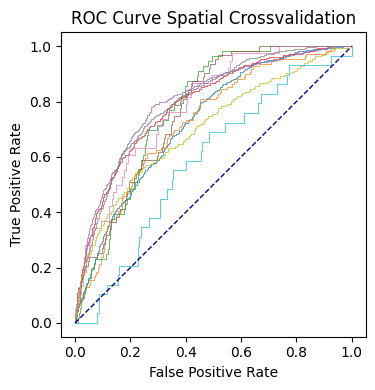

In [10]:
#plot 
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np 
figure(figsize=(4, 4), dpi=100)
Aucs=[]
for i in range(1,11):
    preds=np.load(f'crossval_results/SpPredsrv1_{str(i)}.npy')
    truths=np.load(f'crossval_results/SpTruthsrv1_{str(i)}.npy')
    fpr,tpr,thresholds=sklearn.metrics.roc_curve(truths.flatten(), preds.flatten())
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=0.5,
        label=f"ValArea{str(i)}",
    )
    Aucs.append(sklearn.metrics.auc(fpr,tpr))

ax=plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Spatial Crossvalidation")
# plt.text(0.38, 0.11,"Accuracy=0.8131")
# plt.legend(loc="lower right")
plt.axis('square')
plt.tight_layout()
plt.savefig('Exaiplots/rocSpValrev1.pdf')
plt.show()


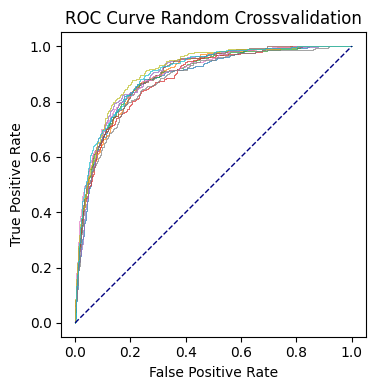

In [12]:
#plot 
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np 
figure(figsize=(4, 4), dpi=100)
Aucs2=[]
for i in range(0,10):
    preds=np.load(f'crossval_results/RvPredsrv1_{str(i)}.npy')
    truths=np.load(f'crossval_results/RvTruthsrv1_{str(i)}.npy')
    fpr,tpr,thresholds=sklearn.metrics.roc_curve(truths.flatten(), preds.flatten())
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=0.5,
        label=f"RandomArea{str(i+1)}",
    )
    Aucs2.append(sklearn.metrics.auc(fpr,tpr))

ax=plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Random Crossvalidation")
# plt.text(0.38, 0.11,"Accuracy=0.8131")
# plt.legend(loc="lower right")
plt.axis('square')
plt.tight_layout()
plt.savefig('Exaiplots/rocrandValrv1.pdf')
plt.show()


In [16]:
Aucs2

[0.8846185674556704,
 0.8929987770004137,
 0.8898031066182944,
 0.8818544873977826,
 0.8964026852167144,
 0.8971522271576238,
 0.8967618970649641,
 0.877250967727158,
 0.908349146110057,
 0.9022519544523604]

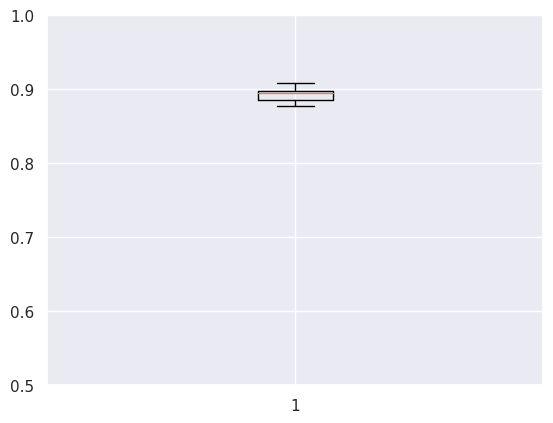

In [24]:

plt.boxplot(Aucs2)
plt.ylim(0.5,1)
plt.savefig('Exaiplots/violin_randomvalrv1.pdf')


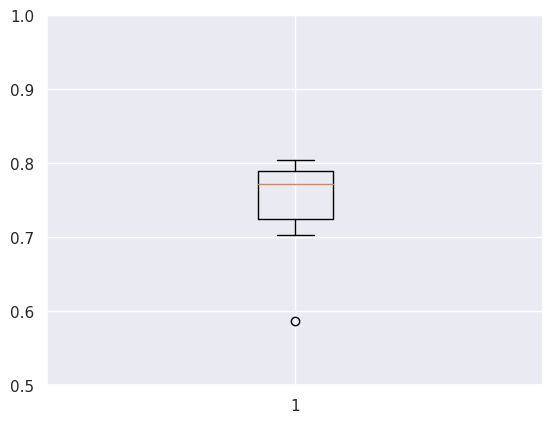

In [23]:
plt.boxplot(Aucs)
plt.ylim(0.5,1)
plt.savefig('Exaiplots/violin_spvalrv1.pdf')

In [ ]:
# plot all confusion maps


In [51]:
#plot 
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np 
rcl_indexes=[]
df=gpd.read_file('Data/NepalEqUSGSV4.shp')
kf = KFold(n_splits=10,random_state=42,shuffle=True)
kf.get_n_splits(df)
i=0
for train_index, test_index in kf.split(df):
    rcl_indexes.append(test_index)

for i in range(0,10):
    print(i)
    preds=np.load(f'crossval_results/RvPredsrv1_{str(i)}.npy')
    truths=np.load(f'crossval_results/RvTruthsrv1_{str(i)}.npy')

    #confusion  map
    confusiondata=np.empty(truths.shape,dtype=object)
    confusiondata[np.bitwise_and(truths.flatten()==1,np.rint(preds.flatten())==1)]='True Positive'
    confusiondata[np.bitwise_and(truths.flatten()==0,np.rint(preds.flatten())==1)]='False Positive'
    confusiondata[np.bitwise_and(truths.flatten()==1,np.rint(preds.flatten())==0)]='False Negative'
    confusiondata[np.bitwise_and(truths.flatten()==0,np.rint(preds.flatten())==0)]='True Negative'
    sel_idx=rcl_indexes[i].tolist()
    df.loc[sel_idx,'rcl_confusion']=confusiondata
df_rc=df

0
1
2
3
4
5
6
7
8
9


In [52]:
df=gpd.read_file('Data/NepalEqUSGSV4.shp')
for i in range(1,11):
    preds=np.load(f'crossval_results/SpPredsrv1_{str(i)}.npy')
    truths=np.load(f'crossval_results/SpTruthsrv1_{str(i)}.npy')
    print(i)
    #confusion  map
    confusiondata=np.empty(truths.shape,dtype=object)
    confusiondata[np.bitwise_and(truths.flatten()==1,np.rint(preds.flatten())==1)]='True Positive'
    confusiondata[np.bitwise_and(truths.flatten()==0,np.rint(preds.flatten())==1)]='False Positive'
    confusiondata[np.bitwise_and(truths.flatten()==1,np.rint(preds.flatten())==0)]='False Negative'
    confusiondata[np.bitwise_and(truths.flatten()==0,np.rint(preds.flatten())==0)]='True Negative'
    sel_idx=df.index[df['id']==i].tolist()
    df.loc[sel_idx,'scl_confusion']=confusiondata
df_sc=df

1
2
3
4
5
6
7
8
9
10


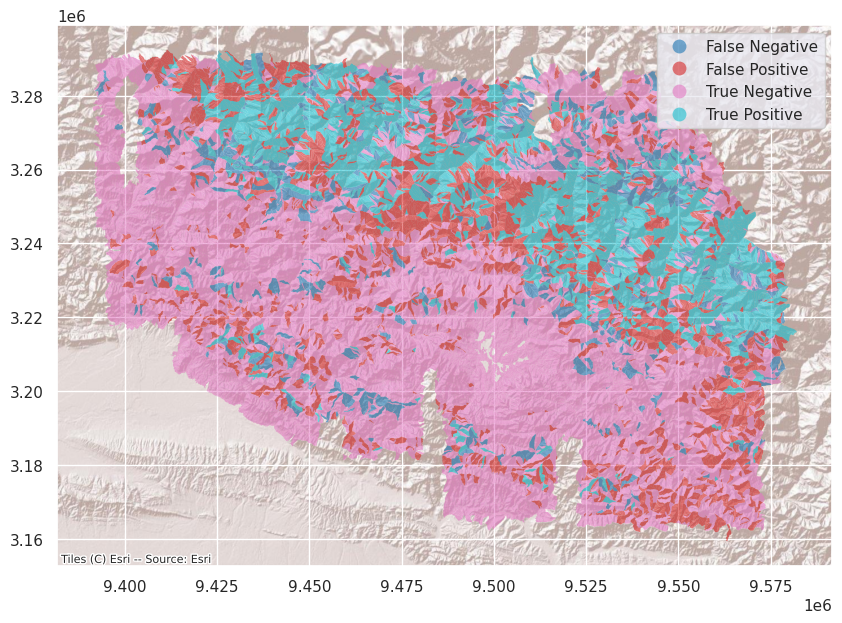

In [53]:
import contextily as cx
df_wm = df_sc.to_crs(epsg=3857)
ax=df_wm.plot(column='scl_confusion',legend=True,figsize=(10, 10), alpha=0.6,linewidth=0)
cx.add_basemap(ax,source=cx.providers.Esri.WorldShadedRelief)

In [54]:
ax.get_figure().savefig('Exaiplots/confusionmap_scvrv1.pdf',dpi=500,facecolor=ax.get_facecolor())

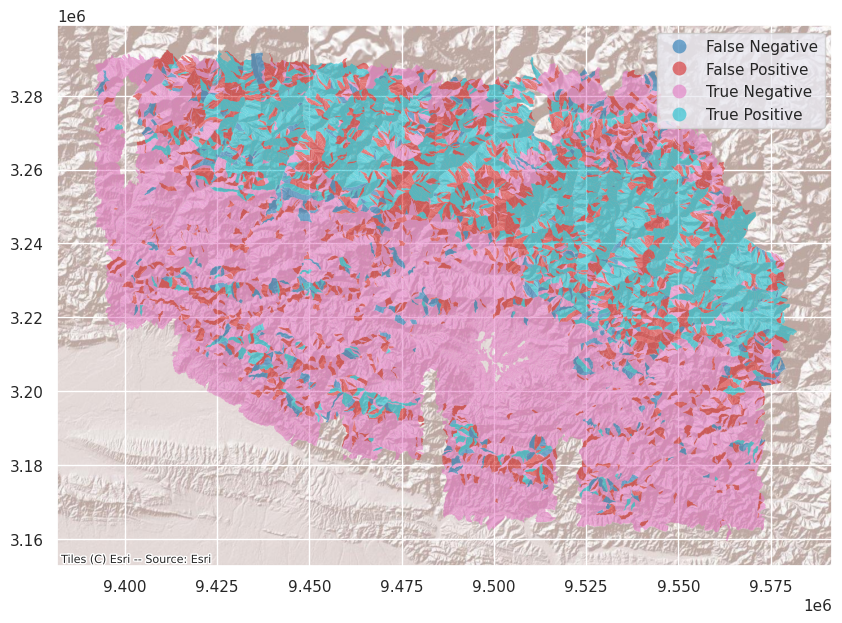

In [55]:
import contextily as cx
df_wm = df_rc.to_crs(epsg=3857)
ax=df_wm.plot(column='rcl_confusion',legend=True,figsize=(10, 10), alpha=0.6,linewidth=0)
cx.add_basemap(ax,source=cx.providers.Esri.WorldShadedRelief)

In [56]:
ax.get_figure().savefig('Exaiplots/confusionmap_rcvrv1.pdf',dpi=500,facecolor=ax.get_facecolor())

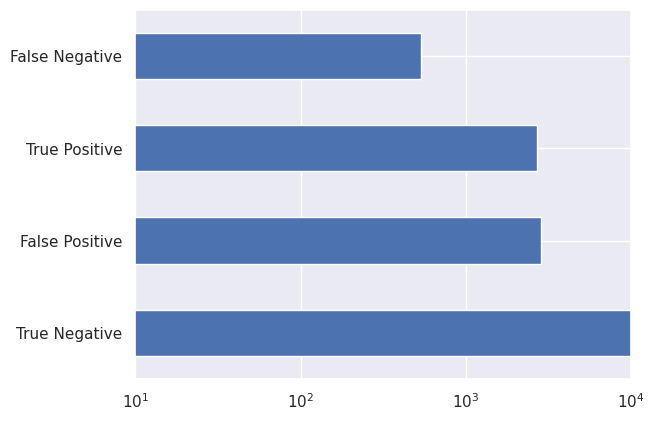

In [57]:
ax=df_rc.rcl_confusion.value_counts().plot(kind='barh',logx=True,xlim=(10,1e4))
ax.get_figure().savefig('Exaiplots/barplot_rcvrv1.pdf',dpi=500,facecolor=ax.get_facecolor())

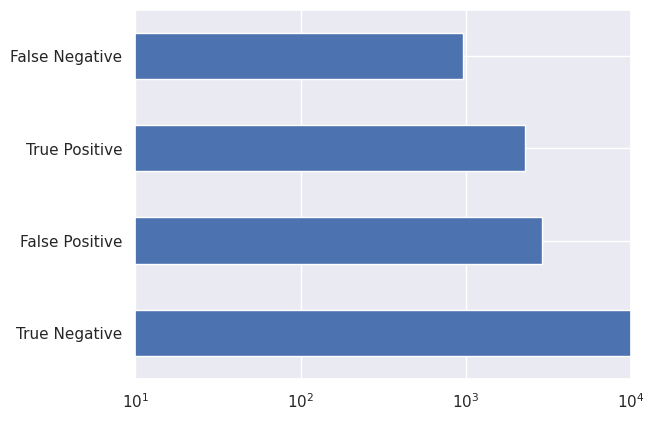

In [58]:
ax=df_sc.scl_confusion.value_counts().plot(kind='barh',logx=True,xlim=(10,1e4))
ax.get_figure().savefig('Exaiplots/barplot_scvrv1.pdf',dpi=500,facecolor=ax.get_facecolor())

In [37]:
ax=df.confusion.value_counts().plot(kind='barh',logx=True,xlim=(10,1e4))
ax.get_figure().savefig('Exaiplots/barplot_bestrv1.pdf',dpi=500,facecolor=ax.get_facecolor())

AttributeError: 'GeoDataFrame' object has no attribute 'confusion'